In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
#set the class of PINN

#定义了一个名为`PhysicsInformedNN'的类，用于实现基于物理的神经网络。
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, X_star, u_star, v_star, h_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        
        #`numpy.concatenate`是一个用于数组拼接的函数。它可以将多个数组沿指定的轴拼接在一起，形成一个新的数组：numpy.concatenate((a1,a2, ...), axis=0)其中，`a1,a2, ...`是需要拼接的数组（只能接受数组或序列类型的参数，且参数形状必须相同），可以是多个。`axis`参数用于指定拼接的轴向，`axis=0`表示沿着第一个轴（即行）进行拼接，不指定`axis`参数默认值是0。
        X0 = np.concatenate((x0,0*x0), 1) # [x0, 0],将x0和0*x0两个数组在第二个维度（即列）上进行了合并。0*x0会生成一个与x0形状相同，但所有元素都为0的数组。因此，X0的结果是一个新的二维数组，其中第一列是x0的值，第二列全为0
        X_lb = np.concatenate((0*tb+lb[0],tb), 1) # [lb[0], tb],将0*tb+lb[0]和tb两个数组在第二个维度（即列）上进行了合并。0*tb+lb[0]会生成一个与tb形状相同，但所有元素都为lb[0]的数组。因此，X_lb的结果是一个新的二维数组，其中第一列全为lb[0]的值，第二列是tb的值。
        X_ub = np.concatenate((0*tb+ub[0],tb), 1) # [ub[0], tb],同上生成一个与tb形状相同，但所有元素都为ub[0]的数组。因此，X_ub的结果是一个新的二维数组，其中第一列全为ub[0]的值，第二列是tb的值
        
        #Python使用self关键字来表示类的实例。当在类的方法中定义一个变量时，例如lb和ub，这些变量只在该方法内部可见，也就是说它们的作用域仅限于该方法。当方法执行完毕后，这些变量就会被销毁，无法在其他方法中访问它们。但如果希望在类的其他方法中也能访问这些变量就需要将它们保存为类的实例属性。这就是self.lb和self.ub的作用。
            #通过将lb和ub赋值给self.lb和self.ub，就可以在类的其他方法中通过self.lb和self.ub来访问这些值。总的来说，self.lb和self.ub是类的实例属性，它们的作用域是整个类，而不仅仅是定义它们的方法。
        self.lb = torch.tensor(lb).float().to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.ub = torch.tensor(ub).float().to(device)


        self.x0 = torch.tensor(X0[:,0:1], requires_grad=True).float().to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。
        self.t0 = torch.tensor(X0[:,1:2], requires_grad=True).float().to(device) #将x0的第二列赋值给self.t0

        self.x_lb = torch.tensor(X_lb[:,0:1], requires_grad=True).float().to(device) #将X_lb的第一列赋值给self.x_lb
        self.t_lb = torch.tensor(X_lb[:,1:2], requires_grad=True).float().to(device) #将X_lb的第二列赋值给self.t_lb

        self.x_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第一列赋值给self.x_ub
        self.t_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第二列赋值给self.t_ub
        
        self.x_f = torch.tensor(X_f[:,0:1], requires_grad=True).float().to(device) #将X_f的第一列赋值给self.x_f
        self.t_f = torch.tensor(X_f[:,1:2], requires_grad=True).float().to(device) #将X_f的第二列赋值给self.t_f
        
        self.u0 = torch.tensor(u0).float().to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。
        self.v0 = torch.tensor(v0).float().to(device)


        self.x_star = torch.tensor(X_star[:,0:1], requires_grad=True).float().to(device) #将X_star的第一列赋值给self.x_star
        self.t_star = torch.tensor(X_star[:,1:2], requires_grad=True).float().to(device) #将X_star的第二列赋值给self.t_star
        self.u_star = torch.tensor(u_star).float().to(device) #将传入的u_star和v_star参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u_star和self.v_star来访问这些值。
        self.v_star = torch.tensor(v_star).float().to(device)
        self.h_star = torch.tensor(h_star).float().to(device)
        
        # Initialize NNs 
        self.layers = layers #将传入的layers参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.layers来访问这些值。
        
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上



        # optimizers: using the same settings，这里是使用pytorch库进行优化的部分
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重、偏置以及两个新加的变量）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )
        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
                

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
    
    #这个函数与下面的net_uv函数功能相同，只是不计算梯度，因为在记录每个epoch的error时，使用with torch.no_grad()情况下调用net_uv函数会报错，不知道为啥？
    def net_uv_error(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        #将uv（是一个二维张量）的第一列赋值给u，第二列赋值给v
        u=uv[:,0:1]
        v=uv[:,1:2]

        return u,v #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #pytorch中
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_uv(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        #将uv（是一个二维张量）的第一列赋值给u，第二列赋值给v
        u=uv[:,0:1]
        v=uv[:,1:2]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        return u,v,u_x,v_x #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f_uv(self, x, t):
        """ The pytorch autograd version of calculating residual """

        u,v,u_x,v_x=self.net_uv(x,t) #调用上面的函数/方法，计算神经网络的输出（两个）以及输出关于输入x的梯度（两个）
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f_u=u_t+0.5*v_xx+(u**2+v**2)*v    #计算f_u,定义见论文
        f_v=v_t-0.5*u_xx-(u**2+v**2)*u   #计算f_v,定义见论文
        return f_u, f_v  #返回计算得到的f_u和f_v


    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）

        u0_pred, v0_pred, _ , _ = self.net_uv(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub) #同上
        f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

        loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((self.v0 - v0_pred) ** 2) + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((v_lb_pred - v_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean((v_x_lb_pred - v_x_ub_pred) ** 2) + \
                    torch.mean(f_u_pred ** 2) + \
                    torch.mean(f_v_pred ** 2)
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        
        self.iter += 1 #每调用一次损失函数，迭代次数加1


        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error\
        self.dnn.eval()
        with torch.no_grad():
            u_real_pred, v_real_pred= self.net_uv_error(self.x_star, self.t_star)
            h_real_pred = torch.sqrt(u_real_pred**2 + v_real_pred**2)

        error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)
        error_v_test = torch.norm(self.v_star - v_real_pred, 2) / torch.norm(self.v_star, 2)
        error_h_test = torch.norm(self.h_star - h_real_pred, 2) / torch.norm(self.h_star, 2)
        
        self.test_error.append(torch.tensor([error_u_test.item(), error_v_test.item(), error_h_test.item()]))

        # 计算 MAE
        mae = torch.mean(torch.abs(self.h_star - h_real_pred))
        # 计算 MSE
        mse = torch.mean((self.h_star - h_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)
        

        return loss #返回loss



    
    #定义了一个名为train的函数/方法，用于训练神经网络。这个方法接受一个参数nIter，表示训练的迭代次数。
    def train(self, nIter, nIterLBFGS):

        #先使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train()#将神经网络设置为训练模式而不是评估模式
            u0_pred, v0_pred, _ , _ = self.net_uv(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
            u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
            u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub) #同上
            f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

            loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((self.v0 - v0_pred) ** 2) + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((v_lb_pred - v_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean((v_x_lb_pred - v_x_ub_pred) ** 2) + \
                    torch.mean(f_u_pred ** 2) + \
                    torch.mean(f_v_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            

            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
            

            #record the test error
            self.dnn.eval()
            with torch.no_grad():
                u_real_pred, v_real_pred = self.net_uv_error(self.x_star, self.t_star)
                h_real_pred = torch.sqrt(u_real_pred**2 + v_real_pred**2)

            error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)
            error_v_test = torch.norm(self.v_star - v_real_pred, 2) / torch.norm(self.v_star, 2)
            error_h_test = torch.norm(self.h_star - h_real_pred, 2) / torch.norm(self.h_star, 2)
            
            self.test_error.append(torch.tensor([error_u_test.item(), error_v_test.item(), error_h_test.item()]))

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.h_star - h_real_pred))
            mse = torch.mean((self.h_star - h_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)



        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   

                                    
    #定义了一个名为predict的函数/方法，用于预测神经网络的输出。这个方法接受一个参数X_star，表示输入数据。最后返回预测的两个输出和两个输出的梯度。
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u, v, _, _ = self.net_uv(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f_u, f_v = self.net_f_uv(x, t) 

        u = u.detach().cpu().numpy() #将张量u和v先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v 
    
    #定义函数获得隐藏层的输出
    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval() #将神经网络切换为评估模式
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1)) #调用上一个神经网络类中的hidden_output方法，得到最后一个隐藏层的输出
        hidden_output_x = hidden_output[:, 0] #将输出的第一列赋值给hidden_output_x
        hidden_output_t = hidden_output[:, 1] #将输出的第二列赋值给hidden_output_t
        hidden_output_x = hidden_output_x.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        hidden_output_t = hidden_output_t.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        return hidden_output_x, hidden_output_t #返回隐藏层的输出


In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
import numpy as np

def calculate_chaos(model, X, num_iter, last_k=20):
    """
    计算模型在给定输入点集上的混沌度。
    参数:
    - model: 具有 hidden_predict 方法的神经网络模型，返回倒数第二层输出
    - X: 输入数据，形状为 (N_f_new, 2)，其中第一列为 x0，第二列为 t0
    - num_iter: 计算混沌情况的总迭代次数
    - last_k: 计算混沌度时考虑的最后 k 次迭代

    返回:
    - chaos_score: 每个采样点的混沌度（取最后 k 次的平均欧氏距离）
    """

    # 1. 取输入点 (x0, t0)
    x0 = X[:, 0:1]  # (N_f_new,1)
    t0 = X[:, 1:2]  # (N_f_new,1)

    # 2. 计算初始点的迭代轨迹
    xs = np.zeros((num_iter, X.shape[0], 2))  # 形状 (num_iter, N_f_new, 2)
    x, t = model.hidden_predict(x0, t0)
    x, t = x.reshape(-1,1), t.reshape(-1,1)

    for i in range(num_iter):
        x, t = model.hidden_predict(x, t)
        x, t = x.reshape(-1,1), t.reshape(-1,1)
        xs[i, :, 0] = x.flatten()  # 存储 x
        xs[i, :, 1] = t.flatten()  # 存储 t

    # 3. 给输入数据加微小扰动
    x1 = x0 + np.random.normal(0, 0.0001, size=x0.shape)
    t1 = t0 + np.random.normal(0, 0.0001, size=t0.shape)

    # 4. 计算扰动点的迭代轨迹
    xs1 = np.zeros_like(xs)  # 形状 (num_iter, N_f_new, 2)
    x, t = model.hidden_predict(x1, t1)
    x, t = x.reshape(-1,1), t.reshape(-1,1)

    for i in range(num_iter):
        x, t = model.hidden_predict(x, t)
        x, t = x.reshape(-1,1), t.reshape(-1,1)
        xs1[i, :, 0] = x.flatten()
        xs1[i, :, 1] = t.flatten()

    # 5. 计算最后 last_k 次迭代的欧氏距离
    last_xs = xs[-last_k:, :, :]  # 取最后 k 次迭代的结果
    last_xs1 = xs1[-last_k:, :, :]  # 取扰动点的结果

    # 计算最后 k 次的欧氏距离
    distances = np.linalg.norm(last_xs - last_xs1, axis=2)  # 形状 (last_k, N_f_new)

    # 6. 取最后 k 次迭代的平均混沌度
    chaos_score = np.mean(distances, axis=0)  # (N_f_new,)

    return chaos_score


In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 21, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

#设置噪声值为0 
noise = 0.0        

# Doman bounds，定义两个一维数组lb和ub，问题域是一个二维空间，其中 x 的范围是 -5 到 5，t 的范围是 0 到 π/2(竖着的)
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
#定义三个整数，分别表示初始条件点数量、边界条件点数量和配位点的数量（这些点用于训练神经网络）
N0 = 50
N_b = 50
N_f = 10000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 100, 100, 100, 100, 2, 2]
#读取名为NLS.mat的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改    
data = scipy.io.loadmat('../data/NLS.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu'] #从data字典中取出变量uu的值，并赋值给Exact
Exact_u = np.real(Exact)  #取Exact的实部，赋值给Exact_u
Exact_v = np.imag(Exact)  #取Exact的虚部，赋值给Exact_v
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2) #计算复数uu的|uu|
#生成一个二位网络，X和T是输出的二维数组
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact_u.T.flatten()[:,None] #先对Exact_u进行转置，然后使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组
v_star = Exact_v.T.flatten()[:,None] #同上，比如Exact_v是m*n二维数组，Exact_v.T是n*m二维数组，Exact_v.T.flatten()是一个长度为n*m的一维数组，Exact_v.T.flatten()[:,None]是一个(n*m)*1的三维数组
h_star = Exact_h.T.flatten()[:,None]
#上面五行代码的意义见Numpy库的索引的介绍


###########################

#从0~数组x的行数(256)中随机选择N0个数，replace=False表示不允许重复选择，最后将这N0个数赋值给idx_x
# idx_x = np.random.choice(x.shape[0], N0, replace=False)
idx_x = np.linspace(0, x.shape[0] - 1, N0, dtype=int) #生成一个等差数列，从0到X的行数，间隔为1，赋值给idx_x
#从x中选择N0个对应的行(idx_x对应的行)，最后将这N0行赋值给x0
x0 = x[idx_x,:]
#从Exact_u中选择N0个对应的行(idx_x对应的行)的第一列元素，最后将这N0个元素赋值给u0
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
#从0~数组t的行数中随机选择N_b个数，replace=False表示不允许重复选择，最后将这N_b个数赋值给idx_t
# idx_t = np.random.choice(t.shape[0], N_b, replace=False)
idx_t = np.linspace(0, t.shape[0] - 1, N_b, dtype=int) #生成一个等差数列，从0到t的行数，间隔为1，赋值给idx_t
#从t中选择N_b个对应的行(idx_t对应的行)，最后将这N_b行赋值给tb
tb = t[idx_t,:]
nIter = 50000 #设置迭代次数为10000
nIterLBFGS = 1000 #设置LBFGS迭代次数为500


error = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子

    #1.先训练500次

    #设置chaos的迭代次数
    num_iter = 50
    #采样配位点，每次采样总训练点数的1%
    N_f_1 = N_f//100
    #总的N_f个配位点
    X_f = lb + (ub-lb)*lhs(2, N_f_1) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。

    #创建PINN模型并输入各种参数        
    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, X_star, u_star, v_star, h_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100,0)


    #2.训练结束后，每500次迭代重采样一次N_f_new个点（即N_f_1的10倍），并从中选出N_f_1个点加入训练点中（即总训练点数的1%）；最后总共有N_f个点，共训练50000次
    for iter in range(nIter//100+1, nIter+1, nIter//100): #每500次迭代

        N_f_new = N_f_1 * 10 #重新总训练点数的1%个训练点的10倍
        # 生成新的X_f_new数据
        X_f_new = lb + (ub-lb)*lhs(2, N_f_new)

        #计算混沌情况
        distances = calculate_chaos(model, X_f_new, num_iter)

        # 计算残差
        _, _, residual_u, residual_v = model.predict(X_f_new)
        residual = np.sqrt(residual_u**2 + residual_v**2)
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        #将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()

        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)

        # 对distances进行归一化
        epsilon = 1e-5
        norm_distances = np.linalg.norm(distances)
        if norm_distances > epsilon:
            distances = distances / norm_distances
        else:
            distances = np.zeros_like(distances)

        # 计算信息量
        xinxi = 0.7*distances + 0.3*abs_residual

        #找出绝对值最大的N_f_1个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据，即新加入的训练数据
        X_f_topk = X_f_new[topk_indices]

        #与之前的训练数据合并
        X_f = np.vstack((X_f, X_f_topk))


        # 更新模型中的X_f_train数据
        model.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100,0)


    model.train(0,nIterLBFGS) #使用LBFGS训练500次

    #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))
  



    #每一个seed训练好之后，用训练好的模型进行预测，得到测试误差

    #用训练好的模型进行预测，返回四个值（均为数组）    
    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
    #计算u_pred和v_pred的模（平方和的平方根），赋值给h_pred
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    #计算误差（基于2范数）        
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
    #打印误差
    # print('Error u: %e' % (error_u))
    # print('Error v: %e' % (error_v))
    print('Error h: %e' % (error_h))

    #将误差添加到error_h列表中

    #计算误差（基于2范数）        
    error.append(error_h) #计算误差，然后将误差添加到error_u列表中
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(h_star - h_pred))
    mse = np.mean((h_star - h_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print(f'当前为第{i}次循环，种子为{seed}')





#使用griddata函数将X_star、u_pred、v_pred和h_pred插值到网格上，得到U_pred、V_pred和H_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
#同上，使用griddata函数将X_star、f_u_pred和f_v_pred插值到网格上，得到FU_pred和FV_pred
FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     

H_star = griddata(X_star, h_star.flatten(), (X, T), method='cubic') #同上，将X_star和h_star插值到网格上，得到H_star

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:52,  9.47it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 93.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 118.70it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 121.49it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 132.67it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 136.02it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 121.99it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 129.86it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 125.33it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 131.08it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 136.24it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 141.21it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 145.47it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 145.25it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 141.06it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 143.45it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 137.67it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 135.04it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 140.53it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 143.59it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 145.64it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.82it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 142.03it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 144.84it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 141.29it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 136.53it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 135.87it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 129.99it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 136.52it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 130.96it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.55it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 134.67it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 137.95it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 139.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.25it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.87it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 123.59it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 132.52it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 129.37it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 136.27it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 141.93it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 138.09it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 138.36it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 135.00it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 138.00it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 132.68it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 128.80it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 132.55it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 139.28it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 133.42it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 129.10it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 130.31it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 129.60it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 131.90it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 133.61it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 129.44it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 120.56it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.50it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 121.50it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 123.87it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 123.31it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 131.85it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 136.77it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 141.91it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 139.48it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 138.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 119.07it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 111.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.41it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.61it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 135.52it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 136.61it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 116.54it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 114.77it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 125.21it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 123.40it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 129.11it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 137.04it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 114.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 121.04it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 125.83it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 121.10it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 128.57it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 129.57it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 134.13it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 138.61it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 141.50it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 144.21it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 144.73it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 137.20it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 140.10it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 133.75it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 135.21it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 133.43it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 130.64it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 134.98it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 138.25it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 142.23it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 138.40it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 143.67it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 146.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.68it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.41it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.36it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 148.23it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 148.05it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 144.25it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 145.97it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 148.49it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 148.79it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 149.44it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 138.25it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 140.70it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 122.44it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 125.03it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 131.36it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 138.90it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 143.73it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 144.61it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 146.03it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 148.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 144.90it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 142.97it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 146.64it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 147.12it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 138.80it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 138.96it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 139.08it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 138.38it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 138.75it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 136.78it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 141.93it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 146.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.70it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.37it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 134.45it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 137.17it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 141.32it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 134.63it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 137.63it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 139.93it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 138.53it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 132.15it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 129.45it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 130.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 133.24it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 130.13it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 129.90it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 137.26it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 140.05it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 144.55it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 144.80it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 142.99it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 142.07it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 145.00it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 144.15it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 143.49it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 146.50it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 141.88it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 134.29it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 131.01it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 135.25it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 137.81it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 136.48it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 140.02it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 143.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.00it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.14it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.51it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 131.80it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 136.15it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 137.26it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 128.03it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 133.99it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 135.48it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 139.34it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 124.85it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 120.65it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 129.35it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.26it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 129.81it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 127.09it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 133.34it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 127.30it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.48it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 131.09it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 117.45it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 126.59it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 134.11it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 137.50it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 134.79it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 137.29it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 132.83it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 133.94it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 133.04it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 134.46it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 135.11it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 136.33it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 139.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:06, 76.42it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 100.92it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.99it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 124.04it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 130.33it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 135.03it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 136.53it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 135.25it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 121.86it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 128.79it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 134.04it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 138.67it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 137.75it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 140.56it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 142.45it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 144.54it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 146.69it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 148.41it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 143.13it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 142.06it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 141.44it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 139.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 136.18it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 141.13it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 138.73it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 131.73it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 125.08it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 123.06it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 129.92it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 134.19it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 140.45it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 135.02it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 129.01it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 129.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.34it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.43it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.61it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.92it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 141.33it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 136.02it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 135.07it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 140.72it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 143.41it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 144.89it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 144.70it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 140.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 141.55it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 143.41it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 140.10it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 142.26it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 145.85it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 144.53it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 133.20it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 138.77it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 139.25it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 130.09it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 133.90it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 116.47it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 112.53it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:01, 108.55it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 109.91it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 114.40it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 126.06it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 127.81it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 121.79it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 111.03it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 109.71it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 109.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 111.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.11it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 118.50it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 126.21it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.35it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.82it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 122.51it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 109.52it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 119.34it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 123.61it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 124.69it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 121.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 123.23it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 116.86it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 114.41it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 120.64it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 128.33it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 131.79it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 136.71it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 132.74it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 113.78it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 120.13it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 116.21it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 109.27it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 113.07it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 120.25it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 124.00it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 123.23it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 120.73it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 124.39it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 120.33it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 115.36it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 123.41it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 125.01it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 124.32it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 119.21it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.54it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.33it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.99it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 124.61it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 127.87it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 116.90it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 103.89it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:04, 98.97it/s] 

Adam:  22%|██▏       | 109/500 [00:00<00:03, 101.65it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 97.16it/s] 

Adam:  26%|██▌       | 130/500 [00:01<00:03, 94.70it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 106.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 117.87it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 116.19it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 114.69it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 116.33it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 114.36it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 120.33it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 122.92it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 125.06it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 123.41it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 130.68it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 129.36it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 129.46it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 132.09it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 135.16it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 137.28it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:00, 142.31it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 135.57it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 131.51it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 133.34it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.29it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 124.52it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 123.09it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 115.32it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 113.15it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 110.06it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.22it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.41it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.20it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.82it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 127.70it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 133.69it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 127.38it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 132.15it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 131.31it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 137.22it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 135.95it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 136.11it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 134.98it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 138.15it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 140.09it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 137.11it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 138.60it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 143.64it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 145.68it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 144.73it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 139.79it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 140.90it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 144.65it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 144.96it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 146.61it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 149.15it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 142.49it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 125.44it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 128.14it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 130.65it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 132.22it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 136.40it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 141.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.78it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.17it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 137.49it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 142.03it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 142.83it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 142.88it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 142.49it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 133.76it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 138.70it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 132.97it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 136.87it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 141.84it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 137.85it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 143.23it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 144.57it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 145.99it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 149.08it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 142.09it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 125.65it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.63it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 131.54it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 132.70it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 132.23it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 133.94it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 139.91it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 139.60it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 140.45it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 140.75it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 141.07it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 138.03it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 142.66it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 144.65it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 144.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.78it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 119.92it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 110.97it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 119.48it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 128.30it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 134.89it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 140.64it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 143.94it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 146.15it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 145.98it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 148.71it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 141.45it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 139.93it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 123.65it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 127.21it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 129.98it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 136.07it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 140.46it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 139.35it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 140.92it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 140.33it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 127.62it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 134.74it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 139.48it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 137.29it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 137.81it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 138.07it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 137.04it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 139.33it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 142.42it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 147.01it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 140.61it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 144.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.15it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.36it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.58it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 148.30it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 144.43it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 140.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 133.91it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 117.52it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 119.58it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 129.58it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 136.67it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 137.38it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 135.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 133.96it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 131.63it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 138.46it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 135.56it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 138.43it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 136.82it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 139.85it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 134.30it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 140.14it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 140.79it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 142.58it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 142.04it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 143.34it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 145.00it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 147.75it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 149.95it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 138.55it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 129.62it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 130.98it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 134.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.73it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.38it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.78it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 146.35it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.22it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 135.47it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 138.99it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 143.29it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 137.98it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 138.01it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 141.18it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 145.02it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 134.94it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 128.77it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 132.60it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 135.13it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 141.14it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 122.91it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 126.71it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 130.83it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 132.59it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 137.21it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 137.35it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 136.52it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 133.33it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 128.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 122.90it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 126.82it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 134.19it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 138.24it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 141.09it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 145.68it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 134.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.15it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.25it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 138.83it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 134.03it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 133.59it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 140.69it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 144.47it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 145.05it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 144.38it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 141.86it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 142.61it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 142.26it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 139.64it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 140.46it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 140.18it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 135.06it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 136.38it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 125.85it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 128.19it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 124.23it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.59it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 132.40it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 127.99it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 128.93it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 114.80it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:01, 116.03it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:01, 107.74it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 113.39it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 111.17it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 108.66it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 119.52it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 121.12it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 125.46it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 130.94it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 127.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 125.68it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.53it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.10it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 126.03it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 126.91it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 123.01it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 114.64it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 107.77it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 107.95it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.22it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 117.88it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 119.01it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 120.19it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 113.52it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 117.29it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 122.14it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 126.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 131.42it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 133.03it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.89it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 129.37it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 118.43it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 123.50it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.19it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 133.32it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 123.37it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 130.04it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 108.79it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 106.06it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 107.20it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 115.60it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 118.31it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 128.36it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 120.65it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 116.61it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 113.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.27it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 109.47it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 123.86it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.67it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 122.62it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 126.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 112.55it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 115.88it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 123.37it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 126.34it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 133.89it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 134.72it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 118.37it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 108.26it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 109.84it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 104.83it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 103.39it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 98.88it/s] 

Adam:  51%|█████     | 255/500 [00:02<00:02, 108.95it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 111.08it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 117.20it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 123.17it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 130.24it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 132.12it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 127.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 123.68it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 126.17it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 126.37it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 126.24it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 131.49it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 132.02it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 137.51it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 123.18it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 127.34it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 121.53it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 122.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.63it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.19it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 127.50it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.03it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 133.31it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 136.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 138.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 144.19it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 142.35it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 140.29it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 134.76it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 138.98it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 143.60it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 146.26it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 129.09it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 122.22it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 122.85it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 129.56it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 133.71it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 139.34it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 143.42it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 136.37it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 128.07it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 129.09it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 136.34it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 141.13it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 143.28it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 144.02it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 144.62it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 147.08it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 146.90it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 147.35it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 140.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.98it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.02it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 144.87it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 145.62it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 147.23it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 144.79it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.03it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 145.85it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 145.75it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 146.99it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 147.69it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 148.37it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.45it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 134.42it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 139.73it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 139.98it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 143.37it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 145.83it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 144.18it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 142.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 138.24it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 133.90it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 127.91it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 126.41it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 132.80it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 132.02it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 136.82it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 140.28it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 144.89it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 136.84it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 137.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 134.81it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 137.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.66it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.82it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 139.13it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 146.11it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 146.75it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 139.01it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 142.05it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 142.41it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 141.63it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 141.74it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 144.90it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 135.53it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 140.18it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 141.75it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 138.00it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 134.24it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 133.74it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 135.29it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 136.39it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 135.40it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 138.42it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 135.90it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 135.30it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 136.45it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 141.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 143.48it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 144.57it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 147.47it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 144.42it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 144.57it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 145.47it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 147.75it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 143.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.53it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.14it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 144.89it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 147.10it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.84it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 145.66it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 146.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 147.98it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 141.28it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 141.36it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 142.46it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 138.94it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 140.26it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 135.81it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 135.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 131.55it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 132.37it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 138.01it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 142.09it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 145.28it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 144.90it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 141.85it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 143.33it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 139.96it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 142.06it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 139.42it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 139.23it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 130.42it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 132.50it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 131.18it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 135.63it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 134.93it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 128.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 132.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 140.55it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 140.69it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 134.78it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 137.69it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 140.75it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 145.26it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 140.07it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 136.47it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 137.24it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 137.92it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 134.12it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 130.14it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 127.74it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 133.47it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 136.40it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 141.31it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 130.72it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 130.65it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 137.16it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 136.62it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 133.24it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 137.16it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 138.24it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 130.37it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 131.71it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 135.14it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 132.29it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 132.68it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 136.06it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 136.36it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 139.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.46it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 121.18it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 112.33it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 117.28it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.34it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.95it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 130.30it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 127.58it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 122.72it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 127.83it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 122.92it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 113.66it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 114.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 103.22it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 107.04it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 115.23it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 114.71it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 121.26it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 122.71it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 127.24it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 123.02it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 125.72it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 121.08it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 114.25it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.52it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 125.50it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 128.94it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 125.64it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 129.33it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 127.58it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 118.45it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 109.59it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 113.30it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 117.61it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 113.20it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 119.11it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 121.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.66it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 128.52it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 135.99it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 128.38it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 134.46it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 117.34it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 113.47it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 114.37it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 118.33it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.00it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 116.94it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 125.65it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 134.06it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 130.41it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 129.25it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 134.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 135.39it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 130.42it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 132.82it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 130.32it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 124.77it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 130.30it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 132.62it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 139.15it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 134.61it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 137.32it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 134.49it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 135.82it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 138.39it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 140.04it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 126.43it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 109.59it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 117.75it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 107.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 117.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.12it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.38it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 107.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 122.58it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 124.63it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 117.34it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 125.74it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 132.03it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 131.63it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 137.37it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 136.02it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 136.79it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 138.54it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 135.55it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 140.25it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 121.32it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 129.55it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 131.89it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 131.90it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 132.94it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 127.17it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 120.08it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.24it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.26it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 122.58it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 125.31it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 126.14it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 119.75it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 112.13it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 115.98it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 124.26it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 131.32it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 126.65it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 132.46it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 136.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.64it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.41it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 131.93it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 138.60it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 138.65it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 141.19it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 141.39it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 140.80it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 134.26it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 126.07it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 133.04it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 135.56it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 135.82it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 134.17it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 138.31it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 137.11it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 140.39it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 137.17it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 140.86it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 144.99it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 134.72it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 130.94it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 135.01it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 140.73it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 139.45it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 141.58it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 141.29it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 131.17it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 135.39it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 137.74it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 142.79it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 143.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 123.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.72it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 130.36it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 140.49it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 146.76it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 144.67it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 143.86it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 145.35it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 148.08it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 149.18it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 146.45it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 145.51it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 146.80it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 148.50it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 147.76it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 131.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 127.13it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 129.66it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 136.68it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 140.82it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 142.53it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 144.25it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 144.46it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 145.38it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 146.19it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 146.09it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 149.20it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 130.37it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 134.27it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 138.11it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 137.32it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 139.23it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 138.63it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 131.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.62it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 125.43it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 132.68it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 137.20it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 141.43it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 145.10it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 143.83it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 145.79it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 146.88it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 144.83it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 145.96it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 144.06it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 145.05it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 147.10it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 145.66it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 145.99it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 140.40it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 142.76it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 143.78it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 140.81it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 143.55it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 134.03it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 137.57it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 139.71it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 140.51it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 139.42it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 138.36it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 132.11it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 136.95it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 134.65it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 139.98it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 134.94it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 135.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.08it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.92it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.50it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 147.20it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.12it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 147.58it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 149.18it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 147.36it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 145.01it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 145.96it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 141.26it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 141.11it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 142.12it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 142.03it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 145.06it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 141.94it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 142.84it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 143.91it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 145.32it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 144.74it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 145.57it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 145.36it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 137.50it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 133.16it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 133.07it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 133.08it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 134.92it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 138.70it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 127.49it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 129.44it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 134.63it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 138.81it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 141.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.57it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 132.34it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 134.14it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 138.30it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 128.69it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 115.50it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 125.51it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 130.28it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 133.86it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 136.32it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 138.93it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 139.37it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 140.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 124.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 129.55it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 130.19it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 127.43it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 134.29it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 140.05it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 144.94it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 142.86it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 141.90it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 131.14it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 135.05it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 136.38it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 141.99it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 128.04it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 133.15it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 137.53it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 138.11it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 136.48it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 141.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.79it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.28it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.10it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.11it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 141.17it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 142.73it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 142.94it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 142.82it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 142.84it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 140.12it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 130.08it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 126.39it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 125.73it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 131.57it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 121.72it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 126.37it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 126.69it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 130.16it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 122.69it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 121.98it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 115.08it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 122.67it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 119.29it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 115.66it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 122.13it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 126.81it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 125.29it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 118.91it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 120.99it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 122.17it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 129.19it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 127.35it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 131.86it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 121.90it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 127.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.11it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.30it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 141.70it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 125.49it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 121.70it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 115.48it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 106.25it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 104.67it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 114.07it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 109.39it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 104.85it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 103.87it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 111.12it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 115.74it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 114.97it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 121.05it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 121.37it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 122.36it/s]

Adam:  50%|█████     | 251/500 [00:02<00:01, 129.74it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 129.32it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 133.37it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.43it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 133.36it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 137.74it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 138.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 137.77it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 127.13it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 128.40it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 133.67it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 123.09it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 124.45it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 125.81it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 130.93it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 127.82it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 123.15it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 117.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.30it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.99it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.95it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 135.44it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 137.97it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 126.10it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 123.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 123.64it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 128.79it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 121.14it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 120.69it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 125.72it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 131.85it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 135.29it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 140.61it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 141.13it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 138.92it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 138.16it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 138.72it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 133.77it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 137.50it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 129.78it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 134.72it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 127.83it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 125.39it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 133.25it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 130.17it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.72it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 134.85it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 140.35it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 138.97it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 141.13it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 140.62it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 143.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.26it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.86it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 129.73it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 133.26it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 125.33it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 129.22it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 134.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 139.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.27it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 147.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.67it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.74it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 142.35it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 123.91it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 128.63it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 128.34it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 129.35it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 136.45it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 138.83it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 138.90it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 140.38it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 142.39it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 141.82it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 140.22it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 132.81it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 122.93it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 124.01it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 124.68it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 133.61it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 136.44it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 135.57it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 139.30it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.82it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 128.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.29it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.21it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 146.43it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 145.18it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 139.54it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 141.48it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 137.71it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 142.59it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 143.27it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 144.08it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 142.69it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 132.54it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 137.08it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 141.35it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 144.52it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 148.15it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 147.21it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 150.43it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 149.61it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 146.66it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 137.95it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 134.22it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 133.21it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 123.78it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 126.71it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 128.30it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 134.28it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 135.53it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 138.69it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 135.12it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 133.73it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 130.86it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 135.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 143.68it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 134.44it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 138.84it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 138.92it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 136.59it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 140.41it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 142.38it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 140.53it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 134.03it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 132.51it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 134.17it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 135.73it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 134.66it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 140.64it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 143.00it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 143.56it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 144.27it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 144.85it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 146.09it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 144.95it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 148.37it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 147.81it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 147.30it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 150.12it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 151.66it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 137.00it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 134.45it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 137.46it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 137.85it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 141.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.01it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 129.33it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 126.50it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 129.42it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 125.67it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 118.35it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 129.40it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 133.31it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 131.20it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 131.18it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 136.14it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 136.87it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 139.40it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 142.38it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 143.55it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 144.85it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 140.93it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 132.19it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 126.78it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 126.46it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.95it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 127.74it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 132.01it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 132.69it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 128.24it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 125.94it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 129.21it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 134.34it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 137.18it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 125.55it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 120.04it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 127.32it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 132.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.31it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 130.72it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 119.71it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 121.74it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 126.76it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 132.68it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 133.60it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 131.14it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 134.41it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 137.25it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 140.89it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 137.36it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 125.89it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 119.53it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 128.29it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 127.53it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 128.78it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.43it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 134.72it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 138.39it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 140.93it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 142.73it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 144.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 142.92it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 142.09it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 131.59it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 128.22it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 128.25it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 128.42it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 122.89it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 130.21it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 129.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.48it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 133.31it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.27it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 129.53it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 132.96it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 135.89it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 135.80it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 129.30it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 132.54it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 131.37it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 131.12it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 131.75it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 126.23it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 115.56it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 124.58it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 120.98it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 125.52it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 117.16it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 106.68it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 110.88it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 115.80it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 109.62it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 114.89it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 118.87it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 121.44it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 114.55it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 117.29it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 119.54it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 128.05it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 131.38it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 132.68it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 136.37it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 134.29it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 140.86it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 142.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.92it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 127.12it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 134.09it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 130.86it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 134.05it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 122.53it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 121.80it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 129.63it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 126.07it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 127.48it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 130.39it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 133.93it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 135.21it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 139.89it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 142.80it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 145.97it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 146.63it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 148.64it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 147.13it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 141.52it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 141.93it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 138.54it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 137.24it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 140.80it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 134.21it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 134.53it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 138.66it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 138.61it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 137.78it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 137.81it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 139.66it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 132.25it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 134.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:04, 121.31it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 134.66it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 132.94it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 140.22it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 143.59it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 143.00it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 136.18it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 141.35it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 140.66it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 142.67it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 144.10it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 128.28it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 130.92it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 133.15it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 126.88it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 112.91it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 117.27it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 127.07it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 131.64it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 136.58it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 134.26it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 138.16it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 139.32it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 138.62it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 136.59it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 138.54it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 138.29it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 142.69it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 143.61it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 146.47it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 137.31it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 141.90it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 142.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.69it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.84it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.36it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 142.69it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 138.59it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 136.90it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 133.52it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 136.85it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 124.74it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 129.62it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 135.21it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 139.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 137.51it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 139.37it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 141.70it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 142.69it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 142.81it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 138.97it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 141.21it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 125.21it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 130.26it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 133.96it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 135.49it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 136.74it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 141.11it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 131.50it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 128.20it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 122.62it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 122.88it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 124.32it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 125.45it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 134.14it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 137.11it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 140.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.34it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 141.16it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 145.38it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.18it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 146.89it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 142.60it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 139.65it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 138.93it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 138.23it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 140.29it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 135.57it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 138.29it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 136.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 137.22it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 125.67it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 129.18it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 130.96it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 136.89it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 134.31it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 138.71it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 139.39it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 139.80it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 141.87it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 144.02it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 147.07it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 142.88it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 144.70it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 135.55it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 125.22it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 128.80it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 133.33it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 139.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.76it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 139.46it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 137.87it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 128.91it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 130.89it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 125.91it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 130.01it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 126.30it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 133.57it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 135.02it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 139.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 139.04it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 139.77it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 143.26it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 142.39it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 132.00it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 135.69it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 127.41it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 127.67it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.30it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 137.12it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 130.81it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 130.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 133.91it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 138.04it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 138.10it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 126.01it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 128.98it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 132.78it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 136.44it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 140.71it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 141.70it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 144.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.23it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 118.40it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.17it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 119.78it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.21it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 118.74it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 121.30it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 122.29it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 128.99it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 126.48it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 114.98it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 119.74it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 123.86it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 126.01it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 127.13it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 123.01it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 128.70it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 125.73it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 130.03it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 127.95it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 125.79it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.21it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 129.99it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 125.62it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.77it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 120.21it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 125.95it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 113.77it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 114.41it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 116.59it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 125.27it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 124.62it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 125.05it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 130.79it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 133.31it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 134.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.48it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.90it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 141.54it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 141.84it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 144.36it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 132.64it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 130.91it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 131.61it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 131.70it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 127.97it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 130.04it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 133.59it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 136.43it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 139.52it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 137.41it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 128.61it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 115.43it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 123.57it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 129.38it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 122.25it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 125.52it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 128.89it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 133.38it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 132.47it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 126.98it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 129.92it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 133.69it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 137.61it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 141.63it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 143.96it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 134.72it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 129.32it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 129.26it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 133.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.44it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.23it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.36it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 128.98it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 129.20it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.86it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 134.84it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 133.27it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 136.55it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 139.90it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 138.26it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 133.42it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 126.24it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 128.69it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 133.40it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 127.63it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 123.17it/s]

Adam:  51%|█████     | 253/500 [00:01<00:02, 120.00it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 125.03it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 102.87it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 97.62it/s] 

Adam:  61%|██████    | 304/500 [00:02<00:01, 104.53it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 113.00it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 119.19it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 126.91it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 128.68it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 134.70it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 135.95it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 133.66it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 136.45it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 138.63it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 134.49it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 138.61it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 136.31it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 137.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.73it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.68it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 130.49it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 123.55it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 126.38it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 130.49it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 133.28it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 136.57it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 135.51it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 138.84it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 140.43it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 141.63it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 141.36it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 143.27it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 142.83it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 145.01it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 136.86it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 137.03it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 139.39it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 143.35it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 136.21it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 138.24it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 139.60it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 141.72it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 135.54it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 137.61it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 129.70it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 117.08it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 112.90it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 118.84it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 126.49it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 132.50it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 136.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.17it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 85.37it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 91.23it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 111.93it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 112.05it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 119.45it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 123.89it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 123.46it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 128.98it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 134.14it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 135.85it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 138.68it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 134.47it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 133.11it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 134.08it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 136.80it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 139.74it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 141.94it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 141.83it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 138.67it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 130.38it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 131.03it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.74it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 133.60it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 126.18it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 123.43it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 123.12it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 127.00it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 131.86it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 131.88it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.87it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 127.49it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 130.22it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 131.90it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 132.88it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 128.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 113.90it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.40it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 129.35it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 131.44it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 135.08it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.82it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.29it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 127.68it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 127.64it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 126.36it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 111.32it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 117.42it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 124.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 126.08it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 131.80it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 135.98it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 131.91it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 133.61it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 136.90it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 135.77it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 135.41it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 137.84it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 136.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 135.74it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 135.28it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 139.07it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 132.60it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 128.14it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 128.45it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 130.10it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 127.64it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 123.27it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 128.99it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 129.95it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 134.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.20it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 132.27it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 136.35it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 120.09it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 123.09it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 124.88it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 129.80it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 129.60it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 127.60it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 126.23it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 129.89it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 131.41it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 135.20it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 137.63it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 128.83it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 128.20it/s]

Adam:  51%|█████     | 255/500 [00:01<00:02, 120.87it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 125.88it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.11it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.56it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 117.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 111.63it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 101.33it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 103.41it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 101.67it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 104.61it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 110.61it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 117.55it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 124.59it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 119.51it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 126.65it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 130.24it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 131.41it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 130.07it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 129.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.01it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 108.65it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.81it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.74it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 102.86it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 106.40it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 115.49it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 114.61it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 115.10it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 121.81it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 125.12it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.39it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 125.48it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 125.60it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 128.41it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 122.33it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 124.15it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 128.26it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 130.44it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 133.85it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 119.32it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.26it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 119.34it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 119.21it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 126.67it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 132.46it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 136.81it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 140.10it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 141.43it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 135.70it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 128.28it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 119.52it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 122.72it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 118.27it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 123.63it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 124.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.15it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 102.92it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 98.26it/s] 

Adam:  10%|█         | 52/500 [00:00<00:04, 108.51it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 112.28it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 119.66it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 114.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 121.28it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 124.81it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 123.82it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 112.90it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.54it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 122.69it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 123.93it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 119.34it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 117.12it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 116.53it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 115.61it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 120.58it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 123.50it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.40it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 127.48it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 125.82it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 128.00it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 131.29it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 131.20it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 121.46it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 128.11it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 130.12it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 134.91it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 136.61it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 139.29it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 141.13it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 132.20it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 129.47it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 131.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.99it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.30it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.74it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 135.07it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 116.76it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 118.23it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 118.16it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 122.34it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 128.66it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 127.43it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 125.28it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 130.38it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 131.89it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 135.73it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 132.45it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 135.81it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 132.94it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 133.59it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 136.96it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 139.71it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 134.40it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 130.47it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 124.42it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 129.14it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 131.02it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 134.98it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 136.22it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 137.74it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 128.53it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 131.35it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 134.15it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 135.61it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 137.53it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 136.76it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 138.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.31it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.19it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 136.12it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.15it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 134.75it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 138.02it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 133.51it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 136.01it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 115.10it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 122.70it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 128.10it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 130.96it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 129.68it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 133.17it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 127.54it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 124.95it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 125.11it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 124.05it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 119.21it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 125.54it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.26it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 125.03it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 123.41it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 123.03it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 126.10it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 131.40it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 131.96it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 135.36it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 137.27it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 132.18it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 126.39it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 126.94it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 129.77it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 127.96it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 131.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.20it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 130.06it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 135.32it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.64it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 122.67it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 128.87it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 130.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 134.55it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 135.93it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 137.75it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 138.12it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 134.15it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 133.33it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 125.51it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 121.66it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 121.25it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 125.95it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 131.43it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 134.16it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 137.26it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.84it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 125.06it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 128.32it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 124.10it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.93it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 125.33it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:01, 119.27it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 125.52it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 124.08it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 128.52it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 125.52it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 122.56it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 122.48it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 125.09it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 127.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.05it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 116.10it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 125.38it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 132.71it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 132.52it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 135.06it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 136.59it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 137.51it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 137.74it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 136.27it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 136.95it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 136.01it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 138.07it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 136.77it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 136.27it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 137.81it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 139.03it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 137.51it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 139.29it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 133.59it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 132.41it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 135.04it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 136.44it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 132.90it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 133.21it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 134.50it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 137.23it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 137.95it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 136.79it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 137.38it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 132.93it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 134.81it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 134.82it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 123.86it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 127.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.87it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.43it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.53it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 135.38it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 130.68it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 134.29it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 130.70it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 132.11it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 127.19it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 126.07it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 127.82it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 128.20it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 126.59it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 124.77it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 128.27it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 128.30it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 130.52it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 132.69it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 128.18it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 111.94it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 109.29it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 111.76it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 116.20it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 114.40it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 114.18it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 122.72it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 114.16it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 118.72it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 119.19it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 119.65it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 117.14it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 121.60it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 127.24it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 128.33it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 128.73it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 128.02it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 109.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.38it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.22it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.21it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 124.61it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 126.86it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 126.81it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 126.02it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 129.05it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 117.64it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 109.21it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 118.16it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 120.17it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 118.97it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 122.42it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 121.17it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 123.39it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 123.06it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 117.27it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.03it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 127.69it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 133.14it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 124.50it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 119.25it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 122.51it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 127.14it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 131.17it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 121.78it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.67it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 130.15it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 129.50it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 129.84it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 131.89it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 124.75it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 125.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.68it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 114.87it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 114.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 115.13it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 120.21it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 119.00it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 121.05it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 116.50it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 118.77it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 122.79it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 125.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 127.68it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 129.07it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 128.79it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 131.52it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 132.82it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 131.85it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 131.90it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 129.72it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 132.51it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 130.94it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 126.56it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 131.02it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 134.23it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 134.38it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 125.73it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 129.20it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 125.56it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 128.08it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 131.85it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 129.84it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 115.19it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 117.94it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 119.28it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 126.01it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 127.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.39it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.82it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 126.27it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.23it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 132.33it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 134.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 130.96it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.66it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 129.90it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.63it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 116.55it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 115.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 111.51it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 111.74it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 104.43it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 110.39it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 112.06it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 115.34it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 121.01it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 122.96it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 121.70it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 126.79it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 121.74it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 125.40it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 129.18it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 133.11it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 125.11it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 123.65it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 124.49it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 128.33it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 124.31it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 129.89it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 124.83it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 128.03it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 127.51it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 126.72it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 120.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.38it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.87it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.19it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 120.08it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 110.23it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 118.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 123.48it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 117.84it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 123.61it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 127.05it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 129.79it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 131.71it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 130.27it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 130.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 133.72it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 133.10it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 127.43it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 125.04it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 123.73it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 127.60it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 131.45it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 132.65it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 130.66it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 132.92it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 129.55it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 129.87it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 130.41it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 130.00it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 126.58it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 107.82it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 111.30it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 118.07it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 117.87it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 123.53it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 126.78it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 130.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.42it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.71it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 115.99it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.62it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 128.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 130.72it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 129.31it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 126.77it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 128.63it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 124.40it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 123.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 122.03it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 126.98it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 128.25it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 127.77it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 123.31it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 119.71it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 125.93it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 129.51it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 126.86it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 130.08it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 132.57it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 135.02it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 134.31it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 135.54it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 136.39it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 134.85it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 132.92it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 130.60it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 123.10it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.53it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 122.73it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 126.33it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 130.45it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 124.98it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 119.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.21it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.86it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.80it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 116.69it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 123.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 128.18it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 127.11it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.37it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 128.09it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 125.44it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 116.59it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 113.29it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 117.50it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 111.53it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 117.59it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 122.10it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 121.62it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 125.93it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 115.60it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 119.25it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 115.58it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 110.64it/s]

Adam:  60%|██████    | 302/500 [00:02<00:02, 97.31it/s] 

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 102.05it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 105.57it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 111.65it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 116.06it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 118.41it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 123.76it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 120.35it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 124.61it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 128.85it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 125.07it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 130.04it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 129.82it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 126.84it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 123.21it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.31it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.39it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.74it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 107.47it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 113.38it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 107.20it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 116.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 121.98it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 126.03it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 128.00it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 129.34it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 131.56it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 128.75it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 130.82it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 127.64it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 131.13it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 132.78it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 133.56it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 131.92it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 112.65it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 108.47it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 104.61it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 112.58it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 116.07it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 119.29it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 124.09it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 120.67it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 110.60it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 106.58it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 113.82it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 120.58it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 122.66it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 122.87it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 116.73it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 115.88it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 121.42it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 126.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.58it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.62it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 115.77it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.16it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 123.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.72it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 127.19it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 116.46it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 119.11it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 120.24it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 121.64it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 126.46it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 126.06it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 122.17it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 122.70it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 123.96it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 109.40it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 116.14it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 122.55it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 127.32it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 129.86it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 131.55it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 117.36it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 121.63it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 123.77it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 124.68it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 125.10it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 128.13it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 130.13it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 131.17it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 133.98it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 134.10it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 131.87it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 125.63it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 126.91it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 125.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.18it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.48it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.68it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 130.17it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 128.37it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 129.02it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 130.97it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 116.80it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 115.05it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 117.96it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 123.79it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 123.20it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 126.70it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 127.30it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 125.88it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 112.54it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 117.78it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 116.24it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 121.82it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 126.33it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 127.49it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 128.80it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 127.93it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 130.16it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 121.96it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 122.40it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 122.94it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 127.22it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 131.44it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 120.51it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 124.23it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 127.12it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 129.01it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 122.69it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 123.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.81it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 127.13it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.43it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 133.09it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.03it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 125.36it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 127.73it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 124.57it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 122.86it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 126.55it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 123.13it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 125.91it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 126.05it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 129.52it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 129.53it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 120.65it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 113.75it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 120.02it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 122.74it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 120.62it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 123.02it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 119.76it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 114.83it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 119.95it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 123.47it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 120.84it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 122.76it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 127.47it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 131.01it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 132.64it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 120.22it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 122.84it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 126.61it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 128.73it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 131.04it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 133.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.68it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.03it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.51it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 131.49it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 130.34it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 129.92it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 130.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 122.73it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.30it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 122.93it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 120.90it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 124.65it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 127.06it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 130.25it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 131.66it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 127.66it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 128.69it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 122.00it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 120.66it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 113.96it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 108.29it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 114.23it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 115.94it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 114.72it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 119.55it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 104.78it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 103.75it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 102.50it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 105.19it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 111.65it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 111.30it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 112.02it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 113.07it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 116.78it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 118.96it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 109.27it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 104.86it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 113.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.01it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.18it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.81it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.14it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 129.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 123.82it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 115.24it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 120.09it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 119.87it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 124.19it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 119.80it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 123.71it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 125.94it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 125.47it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 128.90it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 128.91it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 130.70it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 130.88it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 122.75it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 125.57it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 124.92it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 127.55it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 128.78it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 131.41it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 132.91it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 133.27it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 134.44it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 133.74it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 133.97it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 127.13it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 126.70it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 124.19it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 121.80it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 122.75it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 123.46it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 124.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.85it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.86it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 127.59it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.49it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 127.42it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 114.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 116.94it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 122.32it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 119.53it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 124.16it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 127.71it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 128.16it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 123.59it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 125.26it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 123.16it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 119.95it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 118.60it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 117.34it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 122.24it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 122.78it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 118.31it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.01it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 118.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 118.55it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 121.42it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 123.34it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 117.77it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 119.92it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 119.42it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 112.47it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 117.14it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 116.93it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 118.21it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 115.50it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 120.84it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 121.06it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 126.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.95it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 118.76it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.88it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 117.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 117.46it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 113.41it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 114.03it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 111.87it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 116.84it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 114.73it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.61it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 123.38it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 116.50it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 121.08it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 121.65it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 122.58it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 123.70it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 122.74it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 123.29it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.03it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 126.81it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 120.00it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 122.38it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 122.50it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 126.29it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 128.69it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 131.18it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 128.19it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 119.95it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 118.44it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 117.66it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 118.96it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 120.67it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 124.51it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 117.02it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 122.52it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 123.61it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 121.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.12it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.21it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 129.34it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 119.42it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.42it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 123.82it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 127.15it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 126.09it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 124.65it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 124.23it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 124.13it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 119.90it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 121.94it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 124.50it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 126.99it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 129.83it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 129.79it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 122.61it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 116.34it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 115.73it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 121.29it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 125.06it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 128.19it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 126.58it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 124.44it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 126.93it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 127.07it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 123.12it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 115.93it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 118.89it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 121.18it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 115.62it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 112.60it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 116.80it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 107.51it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 110.16it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 115.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.93it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.24it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.26it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.15it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 119.84it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 117.64it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 118.99it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 120.90it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.12it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 118.70it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 110.99it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 112.45it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 110.86it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 115.45it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 120.96it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 124.88it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 124.30it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 124.81it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 123.65it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 117.24it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 121.30it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 114.68it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 119.81it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 123.44it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 124.00it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 121.14it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 122.50it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 123.63it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 126.35it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.26it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 127.23it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 124.21it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 123.62it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 114.01it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 117.35it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 120.10it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.96it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.06it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 105.51it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 102.76it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 111.51it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 113.40it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 111.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 109.83it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 112.11it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 114.62it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 116.11it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 115.37it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 113.41it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 117.55it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 101.40it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 108.81it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 110.42it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 111.29it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 111.95it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 117.45it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 108.57it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 112.78it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 115.00it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.09it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 121.16it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 124.20it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 123.13it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 124.62it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 125.10it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 125.62it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 127.80it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 129.19it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 129.73it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 129.44it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 128.00it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 121.05it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 122.81it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 122.19it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 125.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.58it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.16it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 125.54it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.44it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 123.81it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.46it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.82it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 126.21it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 123.71it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.83it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 123.45it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 123.49it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 124.42it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 122.58it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 118.75it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 121.31it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 124.21it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 126.79it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 119.76it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.09it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 122.07it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 123.73it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 125.17it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 123.93it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 126.17it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 128.60it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 128.63it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 122.18it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 118.34it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 121.83it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 124.26it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 119.87it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 122.31it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 125.33it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 124.84it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 117.86it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 119.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.87it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.91it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.99it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.66it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 113.37it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 110.77it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.46it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 108.92it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 109.34it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 112.01it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 116.07it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 111.95it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 115.76it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 120.27it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.40it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 125.47it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 115.36it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 120.40it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 120.22it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 120.88it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 122.00it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 122.26it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 117.36it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 120.40it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 121.57it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 123.65it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 123.98it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 117.55it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 122.86it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 125.56it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 121.42it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 122.91it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 124.50it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 125.12it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 123.01it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 126.50it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 128.75it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 123.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.26it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 112.12it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 118.68it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 116.30it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 117.51it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 118.98it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 122.78it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 118.63it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 115.78it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 119.31it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 123.58it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 116.08it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 116.22it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 120.45it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 118.41it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 120.49it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 121.56it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.63it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 114.77it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 98.59it/s] 

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 106.06it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 109.22it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 115.41it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 120.92it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 123.30it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 123.22it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 119.83it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 110.42it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 109.98it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 114.21it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 114.17it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 113.93it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.03it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 119.34it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 118.75it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 123.42it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 121.69it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 122.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.32it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.47it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.94it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 116.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.17it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 114.55it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 107.76it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 113.69it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 113.20it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 112.76it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 114.36it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 119.48it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 118.90it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 123.11it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 124.95it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.23it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 128.24it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 124.08it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 125.27it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 118.51it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 115.11it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 117.95it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 121.26it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 121.01it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 122.61it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 117.29it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 116.73it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 114.79it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 116.80it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 118.60it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 116.94it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 119.21it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 118.65it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 112.12it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 116.20it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 119.58it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 113.71it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 114.71it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 117.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.83it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.99it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 111.37it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 117.25it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 113.31it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 115.93it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 115.67it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 98.64it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 99.99it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 104.89it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 103.99it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 96.40it/s] 

Adam:  34%|███▎      | 168/500 [00:01<00:03, 103.21it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 102.06it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 103.05it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 111.03it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 112.62it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 104.56it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 110.22it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 113.34it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 116.74it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 119.67it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 114.66it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 116.76it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 121.03it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 121.82it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 120.36it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 120.87it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 122.11it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 116.65it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 116.46it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 104.16it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 112.06it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 112.03it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 117.51it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 119.88it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 109.76it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 108.19it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 110.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.38it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 99.67it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 108.30it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 110.60it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 116.11it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 108.85it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 111.65it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 103.25it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 105.77it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 110.22it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 107.73it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 99.54it/s] 

Adam:  31%|███       | 155/500 [00:01<00:03, 105.92it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 108.93it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 112.96it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 117.72it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 106.60it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 102.56it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 106.56it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 100.62it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 103.32it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 108.55it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.95it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 108.68it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 111.35it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 104.37it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 107.50it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 103.47it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 109.09it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 112.56it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 113.59it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 108.38it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 105.92it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 106.14it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 105.78it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 109.62it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 111.57it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 104.42it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 99.95it/s] 

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 95.09it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 97.46it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 99.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.65it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.53it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.53it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.03it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 105.02it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 104.13it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 97.18it/s] 

Adam:  20%|█▉        | 98/500 [00:00<00:04, 100.13it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 105.19it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 104.13it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 103.87it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 101.26it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 105.88it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 108.29it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 108.71it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 111.42it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 102.29it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 101.28it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 102.19it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 105.48it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 94.35it/s] 

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 95.25it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 101.91it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 102.37it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 108.63it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 104.20it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 107.53it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 113.03it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 116.09it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 119.34it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 119.17it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 118.71it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 120.65it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 118.79it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 121.34it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 121.15it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 112.25it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 110.79it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 114.28it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 116.70it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.79it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 101.42it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 111.26it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 117.29it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 121.45it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 123.91it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 125.13it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 123.65it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 124.20it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 123.80it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 122.26it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 119.73it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 116.90it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 118.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 118.66it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 122.52it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 123.61it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 123.20it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 123.03it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.92it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 113.86it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 116.18it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 117.09it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 116.98it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 121.17it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 114.82it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 115.05it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 114.78it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 114.58it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 112.29it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 115.27it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 111.83it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 115.39it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 118.36it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 120.79it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 113.70it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 113.00it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.44it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 116.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.53it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.37it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.75it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 122.62it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 117.80it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 118.16it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 108.80it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 110.73it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 113.86it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 117.49it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 117.50it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 119.08it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 109.82it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 113.93it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 112.35it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 116.42it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 112.05it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 114.99it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 118.68it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 107.45it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 112.92it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 118.23it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 117.96it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 112.41it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 115.85it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 116.30it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 112.69it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 116.11it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 117.54it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 112.66it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 115.72it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 114.34it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 105.07it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 106.35it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 112.14it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 117.18it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 116.93it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 120.04it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 120.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.08it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.74it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.75it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 113.06it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 117.71it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 120.39it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 120.40it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 120.98it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 115.12it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 116.05it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 117.01it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 119.67it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 119.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 118.99it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 117.63it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 117.99it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 113.84it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 111.80it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 115.77it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 118.06it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 114.35it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 115.43it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 115.98it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 111.31it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 106.57it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 112.27it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 116.52it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 118.26it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 120.16it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 122.08it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 123.67it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 117.96it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 119.12it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 121.22it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 112.91it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 116.90it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 115.61it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 117.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.82it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.49it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.95it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.48it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.04it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 125.47it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.89it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 125.93it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 126.03it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 124.31it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 121.77it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 121.08it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 122.24it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 115.80it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 119.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 121.53it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 122.06it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 124.20it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 125.53it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 126.38it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 124.77it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 122.70it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 123.70it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 123.52it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 124.19it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 123.16it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 114.55it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 118.71it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 119.71it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 121.13it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 118.81it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 120.14it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 121.74it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 115.96it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 114.73it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 114.05it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 112.01it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 114.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.66it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 110.03it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 89.30it/s] 

Adam:  10%|▉         | 48/500 [00:00<00:05, 88.35it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 93.70it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 102.35it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 107.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 109.81it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 110.28it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 111.75it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 113.22it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 110.68it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 104.63it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 96.59it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 99.85it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 103.52it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 106.70it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 109.48it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 109.07it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 113.00it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 106.89it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 111.58it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 115.64it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 112.61it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 113.82it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 116.39it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 111.96it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 110.96it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 108.86it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 95.75it/s] 

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 98.36it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 103.01it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 104.17it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 107.96it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 111.37it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 114.66it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 118.10it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 118.64it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 119.42it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 118.34it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 117.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.35it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 103.52it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 104.92it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 112.91it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 116.55it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 118.51it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 121.01it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 122.04it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 102.38it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 107.57it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 108.43it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 112.27it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 115.34it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 117.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 119.60it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 120.67it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 120.59it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 119.48it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 121.35it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 122.78it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 124.73it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 120.91it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 114.91it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 117.68it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 120.28it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 121.91it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 110.66it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 108.70it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 112.22it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 112.32it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 111.78it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 116.21it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 111.65it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 116.20it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 119.38it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 117.31it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 120.06it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 116.54it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.55it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.74it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 106.90it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 112.50it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 116.36it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 118.71it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 117.10it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 119.93it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 120.95it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 123.13it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 124.35it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 122.72it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 122.78it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 111.16it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 114.01it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 115.15it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 116.77it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 118.57it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 111.71it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 108.00it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 109.51it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 113.19it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.40it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 115.31it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 116.16it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 118.83it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 120.27it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 119.08it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 116.25it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 112.24it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 115.06it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 116.10it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 116.66it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 117.12it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 113.27it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 112.95it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.51it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 114.08it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 115.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.23it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.06it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 118.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.61it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.87it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 117.64it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 113.20it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 115.62it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 118.90it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 120.75it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 118.94it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 121.00it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 119.91it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 117.37it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 117.11it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 119.65it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 121.33it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 121.71it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 113.97it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 114.84it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 116.81it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 114.55it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 116.70it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 117.96it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 120.23it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 122.49it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 122.80it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 120.41it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 120.86it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 121.15it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 114.34it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 114.09it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 111.88it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 112.93it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 109.35it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 113.81it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 113.61it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 114.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.95it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.13it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.56it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.66it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.60it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 117.57it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 114.60it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 105.32it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 109.86it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 114.72it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 112.85it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 110.88it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 112.44it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 115.91it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 114.94it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 115.61it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 118.50it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 114.61it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 115.43it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 115.31it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 110.13it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 102.36it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 106.88it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 106.20it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 110.21it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 108.27it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 96.72it/s] 

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 102.36it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 98.86it/s] 

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 97.21it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 103.02it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 109.12it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 109.08it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 108.89it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 111.34it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 110.93it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 110.22it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 115.08it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 114.50it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 113.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.11it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 99.95it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.43it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 110.77it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 99.96it/s] 

Adam:  14%|█▍        | 70/500 [00:00<00:04, 105.78it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 111.85it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 113.55it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 113.99it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 113.79it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.45it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 105.79it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 105.57it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 109.28it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 113.38it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 111.64it/s]

Adam:  41%|████      | 203/500 [00:01<00:03, 98.09it/s] 

Adam:  43%|████▎     | 215/500 [00:02<00:02, 102.39it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 97.79it/s] 

Adam:  47%|████▋     | 236/500 [00:02<00:02, 92.52it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 95.99it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 99.24it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 106.24it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 110.74it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 114.93it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 117.92it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 119.91it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 121.02it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 118.61it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 120.26it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 117.42it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 116.73it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 116.00it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 116.88it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 114.89it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 106.01it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 106.91it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 112.25it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 116.16it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 115.11it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 114.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.05it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.39it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.72it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 117.07it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 120.21it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 121.53it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 122.04it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 116.38it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 113.53it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 113.07it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 116.26it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 118.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 120.46it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 120.20it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.92it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 115.31it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 104.18it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 109.72it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 113.84it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 116.60it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 117.63it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 112.26it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 113.81it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 116.31it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 112.67it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 115.70it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 117.13it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 111.34it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 106.35it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 102.12it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 106.19it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 108.46it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.63it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 111.74it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 115.84it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 117.32it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 120.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.64it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.02it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.79it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.43it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 119.52it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 117.89it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 116.42it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 107.99it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 109.80it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 108.56it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 108.71it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 112.36it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 113.47it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 116.23it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 113.43it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 114.55it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 111.58it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 112.93it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 99.84it/s] 

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 101.22it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 104.19it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 109.45it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 112.96it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 112.51it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 115.02it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 115.50it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 117.61it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 114.91it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 117.43it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 117.42it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 115.76it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 113.36it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 115.99it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 113.51it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 117.09it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 119.07it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 116.42it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 117.98it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 117.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.45it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.95it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.98it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 109.50it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 106.19it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 105.48it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 106.79it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 109.68it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 111.01it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 113.05it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 115.06it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 115.76it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 117.75it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 118.99it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 119.13it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 120.65it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 115.91it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 114.20it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 114.83it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 111.35it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 113.28it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 115.46it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 112.15it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 115.26it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 114.76it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 115.84it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 116.46it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 116.00it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 116.03it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 116.83it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 117.71it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 118.67it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 112.01it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 106.57it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 109.60it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 110.01it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 114.59it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 115.16it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 118.25it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 108.68it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 109.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.11it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.25it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 121.70it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 118.03it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 114.05it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 112.60it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 114.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 111.67it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 113.49it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 113.46it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 116.20it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 118.23it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 116.04it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 112.78it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 114.43it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 112.07it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 114.16it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 117.08it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 116.73it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 119.15it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 119.54it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 120.42it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 121.02it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 111.04it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 113.92it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 116.10it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 113.84it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 112.73it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 111.20it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 114.02it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 115.48it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 114.32it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.39it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 113.50it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 108.78it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 110.88it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 109.04it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 108.45it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 110.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.97it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.89it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 110.57it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 111.89it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 108.60it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 106.17it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 104.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 100.50it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 106.88it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 108.90it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 112.78it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 105.45it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 109.99it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 108.47it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 105.78it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 106.05it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 101.46it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 102.61it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 100.36it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 97.30it/s] 

Adam:  50%|████▉     | 249/500 [00:02<00:02, 101.42it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 102.54it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 105.24it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 104.40it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 99.18it/s] 

Adam:  61%|██████    | 305/500 [00:02<00:02, 95.17it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 102.83it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 106.47it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 103.78it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 106.81it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 108.22it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 110.25it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 106.49it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 110.09it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 100.82it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 104.99it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 109.70it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 111.95it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 115.31it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 115.13it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 114.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 119.83it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 118.88it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.02it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.35it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 115.89it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 107.40it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 97.74it/s] 

Adam:  19%|█▉        | 96/500 [00:00<00:03, 102.80it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 107.21it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 108.46it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 110.56it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 114.19it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 115.85it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 117.01it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 114.43it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 115.28it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 114.88it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 116.71it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 116.47it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 110.47it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 106.66it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 105.83it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 110.40it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 112.24it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 114.91it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 113.40it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 116.50it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 117.26it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 112.70it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 105.32it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 105.29it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 110.49it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 110.77it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.69it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 110.91it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 113.45it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 113.35it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 113.44it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 115.13it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 115.05it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 114.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.10it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.42it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.70it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 112.91it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 104.33it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 105.16it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 104.67it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 101.54it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 107.80it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 109.89it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 113.63it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 115.40it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 112.36it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 113.23it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 112.77it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 112.64it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 108.96it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 107.84it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 110.06it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 112.50it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 111.50it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 112.90it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 114.78it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.57it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 108.84it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 110.58it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 108.73it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 111.98it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 113.90it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 113.81it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 115.24it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 116.53it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 118.08it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 118.53it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 119.62it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 120.08it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 120.19it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 113.61it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 115.22it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 113.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [10:16<171:10:54, 616.87s/it]

LBFGS:   0%|          | 2/1000 [11:06<78:32:08, 283.29s/it] 

LBFGS:   0%|          | 3/1000 [14:59<72:07:32, 260.43s/it]

LBFGS:   0%|          | 5/1000 [15:00<31:14:45, 113.05s/it]

LBFGS:   1%|          | 7/1000 [15:00<17:15:03, 62.54s/it] 

LBFGS:   1%|          | 9/1000 [15:00<10:30:55, 38.20s/it]

LBFGS:   1%|          | 11/1000 [15:00<6:44:53, 24.56s/it]

LBFGS:   1%|▏         | 13/1000 [15:00<4:27:50, 16.28s/it]

LBFGS:   2%|▏         | 15/1000 [15:00<3:00:36, 11.00s/it]

LBFGS:   2%|▏         | 17/1000 [15:01<2:03:25,  7.53s/it]

LBFGS:   2%|▏         | 19/1000 [15:01<1:25:08,  5.21s/it]

LBFGS:   2%|▏         | 21/1000 [15:01<59:10,  3.63s/it]  

LBFGS:   2%|▏         | 23/1000 [15:01<41:23,  2.54s/it]

LBFGS:   2%|▎         | 25/1000 [15:01<29:07,  1.79s/it]

LBFGS:   3%|▎         | 27/1000 [15:01<20:39,  1.27s/it]

LBFGS:   3%|▎         | 29/1000 [15:01<14:45,  1.10it/s]

LBFGS:   3%|▎         | 31/1000 [15:02<10:40,  1.51it/s]

LBFGS:   3%|▎         | 33/1000 [15:02<07:53,  2.04it/s]

LBFGS:   4%|▎         | 35/1000 [15:02<05:52,  2.74it/s]

LBFGS:   4%|▎         | 37/1000 [15:02<04:26,  3.61it/s]

LBFGS:   4%|▍         | 39/1000 [15:02<03:29,  4.60it/s]

LBFGS:   4%|▍         | 41/1000 [15:02<02:49,  5.66it/s]

LBFGS:   4%|▍         | 43/1000 [15:03<02:21,  6.74it/s]

LBFGS:   4%|▍         | 45/1000 [15:03<02:02,  7.80it/s]

LBFGS:   5%|▍         | 47/1000 [15:03<01:45,  9.01it/s]

LBFGS:   5%|▍         | 49/1000 [15:03<01:34, 10.09it/s]

LBFGS:   5%|▌         | 51/1000 [15:03<01:29, 10.60it/s]

LBFGS:   5%|▌         | 53/1000 [15:03<01:22, 11.55it/s]

LBFGS:   6%|▌         | 55/1000 [15:03<01:21, 11.54it/s]

LBFGS:   6%|▌         | 57/1000 [15:04<01:20, 11.74it/s]

LBFGS:   6%|▌         | 59/1000 [15:04<01:18, 12.00it/s]

LBFGS:   6%|▌         | 61/1000 [15:04<01:16, 12.24it/s]

LBFGS:   6%|▋         | 63/1000 [15:04<01:16, 12.29it/s]

LBFGS:   6%|▋         | 65/1000 [15:04<01:14, 12.50it/s]

LBFGS:   7%|▋         | 67/1000 [15:04<01:13, 12.70it/s]

LBFGS:   7%|▋         | 69/1000 [15:05<01:14, 12.52it/s]

LBFGS:   7%|▋         | 71/1000 [15:05<01:14, 12.43it/s]

LBFGS:   7%|▋         | 73/1000 [15:05<01:13, 12.57it/s]

LBFGS:   8%|▊         | 75/1000 [15:05<01:11, 12.88it/s]

LBFGS:   8%|▊         | 77/1000 [15:05<01:10, 13.00it/s]

LBFGS:   8%|▊         | 79/1000 [15:05<01:08, 13.39it/s]

LBFGS:   8%|▊         | 81/1000 [15:06<01:10, 13.07it/s]

LBFGS:   8%|▊         | 83/1000 [15:06<01:12, 12.71it/s]

LBFGS:   8%|▊         | 85/1000 [15:06<01:07, 13.65it/s]

LBFGS:   9%|▊         | 87/1000 [15:06<01:08, 13.27it/s]

LBFGS:   9%|▉         | 89/1000 [15:06<01:09, 13.05it/s]

LBFGS:   9%|▉         | 91/1000 [15:06<01:07, 13.51it/s]

LBFGS:   9%|▉         | 93/1000 [15:06<01:09, 13.14it/s]

LBFGS:  10%|▉         | 95/1000 [15:07<01:04, 14.08it/s]

LBFGS:  10%|▉         | 97/1000 [15:07<00:59, 15.27it/s]

LBFGS:  10%|▉         | 99/1000 [15:07<00:58, 15.27it/s]

LBFGS:  10%|█         | 101/1000 [15:07<00:57, 15.54it/s]

LBFGS:  10%|█         | 103/1000 [15:07<01:07, 13.28it/s]

LBFGS:  10%|█         | 105/1000 [15:07<01:03, 14.03it/s]

LBFGS:  11%|█         | 107/1000 [15:07<01:01, 14.47it/s]

LBFGS:  11%|█         | 109/1000 [15:07<00:59, 14.85it/s]

LBFGS:  11%|█         | 111/1000 [15:08<01:04, 13.89it/s]

LBFGS:  11%|█▏        | 113/1000 [15:08<01:02, 14.10it/s]

LBFGS:  12%|█▏        | 115/1000 [15:08<01:01, 14.37it/s]

LBFGS:  12%|█▏        | 117/1000 [15:08<01:02, 14.11it/s]

LBFGS:  12%|█▏        | 119/1000 [15:08<01:03, 13.92it/s]

LBFGS:  12%|█▏        | 121/1000 [15:08<01:00, 14.58it/s]

LBFGS:  12%|█▏        | 123/1000 [15:08<01:01, 14.18it/s]

LBFGS:  12%|█▎        | 125/1000 [15:09<00:59, 14.81it/s]

LBFGS:  13%|█▎        | 127/1000 [15:09<00:55, 15.70it/s]

LBFGS:  13%|█▎        | 129/1000 [15:09<00:52, 16.46it/s]

LBFGS:  13%|█▎        | 131/1000 [15:09<00:51, 16.74it/s]

LBFGS:  13%|█▎        | 133/1000 [15:09<00:50, 17.01it/s]

LBFGS:  14%|█▎        | 135/1000 [15:09<00:51, 16.69it/s]

LBFGS:  14%|█▎        | 137/1000 [15:09<00:50, 17.19it/s]

LBFGS:  14%|█▍        | 139/1000 [15:09<00:51, 16.81it/s]

LBFGS:  14%|█▍        | 141/1000 [15:10<00:52, 16.33it/s]

LBFGS:  14%|█▍        | 143/1000 [15:10<00:56, 15.30it/s]

LBFGS:  14%|█▍        | 145/1000 [15:10<00:54, 15.69it/s]

LBFGS:  15%|█▍        | 147/1000 [15:10<00:55, 15.45it/s]

LBFGS:  15%|█▍        | 149/1000 [15:10<00:56, 15.15it/s]

LBFGS:  15%|█▌        | 151/1000 [15:10<01:00, 13.93it/s]

LBFGS:  15%|█▌        | 153/1000 [15:10<00:57, 14.76it/s]

LBFGS:  16%|█▌        | 155/1000 [15:10<00:54, 15.47it/s]

LBFGS:  16%|█▌        | 157/1000 [15:11<00:52, 16.04it/s]

LBFGS:  16%|█▌        | 159/1000 [15:11<00:53, 15.84it/s]

LBFGS:  16%|█▌        | 161/1000 [15:11<00:53, 15.79it/s]

LBFGS:  16%|█▋        | 163/1000 [15:11<00:50, 16.51it/s]

LBFGS:  16%|█▋        | 165/1000 [15:11<00:49, 16.92it/s]

LBFGS:  17%|█▋        | 167/1000 [15:11<00:47, 17.46it/s]

LBFGS:  17%|█▋        | 169/1000 [15:11<00:53, 15.68it/s]

LBFGS:  17%|█▋        | 171/1000 [15:12<01:00, 13.67it/s]

LBFGS:  17%|█▋        | 173/1000 [15:12<00:58, 14.12it/s]

LBFGS:  18%|█▊        | 175/1000 [15:12<00:56, 14.54it/s]

LBFGS:  18%|█▊        | 177/1000 [15:12<00:55, 14.80it/s]

LBFGS:  18%|█▊        | 179/1000 [15:12<00:52, 15.50it/s]

LBFGS:  18%|█▊        | 181/1000 [15:12<00:53, 15.45it/s]

LBFGS:  18%|█▊        | 183/1000 [15:12<00:51, 15.74it/s]

LBFGS:  18%|█▊        | 185/1000 [15:12<00:53, 15.20it/s]

LBFGS:  19%|█▊        | 187/1000 [15:13<00:51, 15.72it/s]

LBFGS:  19%|█▉        | 189/1000 [15:13<00:52, 15.51it/s]

LBFGS:  19%|█▉        | 191/1000 [15:13<00:49, 16.43it/s]

LBFGS:  19%|█▉        | 193/1000 [15:13<00:47, 17.02it/s]

LBFGS:  20%|█▉        | 195/1000 [15:13<00:50, 15.98it/s]

LBFGS:  20%|█▉        | 197/1000 [15:13<00:48, 16.64it/s]

LBFGS:  20%|█▉        | 199/1000 [15:13<00:51, 15.69it/s]

LBFGS:  20%|██        | 201/1000 [15:13<00:49, 16.01it/s]

LBFGS:  20%|██        | 203/1000 [15:14<00:50, 15.80it/s]

LBFGS:  20%|██        | 205/1000 [15:14<00:47, 16.69it/s]

LBFGS:  21%|██        | 207/1000 [15:14<00:45, 17.48it/s]

LBFGS:  21%|██        | 209/1000 [15:14<00:44, 17.90it/s]

LBFGS:  21%|██        | 211/1000 [15:14<00:45, 17.40it/s]

LBFGS:  21%|██▏       | 213/1000 [15:14<00:45, 17.41it/s]

LBFGS:  22%|██▏       | 215/1000 [15:14<00:44, 17.49it/s]

LBFGS:  22%|██▏       | 217/1000 [15:14<00:44, 17.78it/s]

LBFGS:  22%|██▏       | 219/1000 [15:14<00:43, 18.10it/s]

LBFGS:  22%|██▏       | 221/1000 [15:15<00:43, 18.08it/s]

LBFGS:  22%|██▏       | 223/1000 [15:15<00:42, 18.35it/s]

LBFGS:  22%|██▎       | 225/1000 [15:15<00:41, 18.71it/s]

LBFGS:  23%|██▎       | 227/1000 [15:15<00:41, 18.61it/s]

LBFGS:  23%|██▎       | 229/1000 [15:15<00:44, 17.50it/s]

LBFGS:  23%|██▎       | 231/1000 [15:15<00:44, 17.32it/s]

LBFGS:  23%|██▎       | 233/1000 [15:15<00:43, 17.67it/s]

LBFGS:  24%|██▎       | 235/1000 [15:15<00:43, 17.74it/s]

LBFGS:  24%|██▎       | 237/1000 [15:15<00:42, 18.03it/s]

LBFGS:  24%|██▍       | 239/1000 [15:16<00:41, 18.33it/s]

LBFGS:  24%|██▍       | 241/1000 [15:16<00:41, 18.25it/s]

LBFGS:  24%|██▍       | 243/1000 [15:16<00:43, 17.28it/s]

LBFGS:  24%|██▍       | 245/1000 [15:16<00:44, 16.81it/s]

LBFGS:  25%|██▍       | 247/1000 [15:16<00:42, 17.60it/s]

LBFGS:  25%|██▍       | 249/1000 [15:16<00:43, 17.43it/s]

LBFGS:  25%|██▌       | 251/1000 [15:16<00:42, 17.73it/s]

LBFGS:  25%|██▌       | 253/1000 [15:16<00:41, 18.05it/s]

LBFGS:  26%|██▌       | 255/1000 [15:16<00:41, 17.97it/s]

LBFGS:  26%|██▌       | 257/1000 [15:17<00:41, 18.07it/s]

LBFGS:  26%|██▌       | 259/1000 [15:17<00:40, 18.51it/s]

LBFGS:  26%|██▌       | 261/1000 [15:17<00:40, 18.12it/s]

LBFGS:  26%|██▋       | 263/1000 [15:17<00:40, 18.00it/s]

LBFGS:  26%|██▋       | 265/1000 [15:17<00:41, 17.82it/s]

LBFGS:  27%|██▋       | 267/1000 [15:17<00:44, 16.33it/s]

LBFGS:  27%|██▋       | 269/1000 [15:17<00:43, 16.73it/s]

LBFGS:  27%|██▋       | 271/1000 [15:17<00:45, 16.18it/s]

LBFGS:  27%|██▋       | 273/1000 [15:18<00:46, 15.53it/s]

LBFGS:  28%|██▊       | 275/1000 [15:18<00:45, 15.82it/s]

LBFGS:  28%|██▊       | 277/1000 [15:18<00:43, 16.61it/s]

LBFGS:  28%|██▊       | 279/1000 [15:18<00:44, 16.05it/s]

LBFGS:  28%|██▊       | 281/1000 [15:18<00:44, 16.31it/s]

LBFGS:  28%|██▊       | 283/1000 [15:18<00:43, 16.64it/s]

LBFGS:  28%|██▊       | 285/1000 [15:18<00:41, 17.36it/s]

LBFGS:  29%|██▊       | 287/1000 [15:18<00:42, 16.96it/s]

LBFGS:  29%|██▉       | 289/1000 [15:18<00:41, 17.04it/s]

LBFGS:  29%|██▉       | 291/1000 [15:19<00:40, 17.64it/s]

LBFGS:  29%|██▉       | 293/1000 [15:19<00:40, 17.38it/s]

LBFGS:  30%|██▉       | 295/1000 [15:19<00:40, 17.57it/s]

LBFGS:  30%|██▉       | 297/1000 [15:19<00:39, 17.70it/s]

LBFGS:  30%|██▉       | 299/1000 [15:19<00:39, 17.97it/s]

LBFGS:  30%|███       | 301/1000 [15:19<00:38, 18.22it/s]

LBFGS:  30%|███       | 303/1000 [15:19<00:37, 18.45it/s]

LBFGS:  30%|███       | 305/1000 [15:19<00:38, 17.87it/s]

LBFGS:  31%|███       | 307/1000 [15:19<00:39, 17.50it/s]

LBFGS:  31%|███       | 309/1000 [15:20<00:39, 17.46it/s]

LBFGS:  31%|███       | 311/1000 [15:20<00:39, 17.32it/s]

LBFGS:  31%|███▏      | 313/1000 [15:20<00:38, 17.71it/s]

LBFGS:  32%|███▏      | 315/1000 [15:20<00:40, 17.12it/s]

LBFGS:  32%|███▏      | 317/1000 [15:20<00:40, 17.06it/s]

LBFGS:  32%|███▏      | 319/1000 [15:20<00:39, 17.03it/s]

LBFGS:  32%|███▏      | 321/1000 [15:20<00:39, 17.35it/s]

LBFGS:  32%|███▏      | 323/1000 [15:20<00:38, 17.52it/s]

LBFGS:  32%|███▎      | 325/1000 [15:21<00:40, 16.62it/s]

LBFGS:  33%|███▎      | 327/1000 [15:21<00:42, 15.91it/s]

LBFGS:  33%|███▎      | 329/1000 [15:21<00:40, 16.64it/s]

LBFGS:  33%|███▎      | 331/1000 [15:21<00:39, 17.01it/s]

LBFGS:  33%|███▎      | 333/1000 [15:21<00:40, 16.41it/s]

LBFGS:  34%|███▎      | 335/1000 [15:21<00:39, 16.87it/s]

LBFGS:  34%|███▎      | 337/1000 [15:21<00:39, 16.77it/s]

LBFGS:  34%|███▍      | 339/1000 [15:21<00:39, 16.76it/s]

LBFGS:  34%|███▍      | 341/1000 [15:22<00:43, 15.08it/s]

LBFGS:  34%|███▍      | 343/1000 [15:22<00:41, 15.74it/s]

LBFGS:  34%|███▍      | 345/1000 [15:22<00:39, 16.47it/s]

LBFGS:  35%|███▍      | 347/1000 [15:22<00:37, 17.19it/s]

LBFGS:  35%|███▍      | 349/1000 [15:22<00:38, 17.12it/s]

LBFGS:  35%|███▌      | 351/1000 [15:22<00:36, 17.57it/s]

LBFGS:  35%|███▌      | 353/1000 [15:22<00:36, 17.57it/s]

LBFGS:  36%|███▌      | 355/1000 [15:22<00:38, 16.81it/s]

LBFGS:  36%|███▌      | 357/1000 [15:22<00:37, 17.36it/s]

LBFGS:  36%|███▌      | 359/1000 [15:23<00:35, 17.86it/s]

LBFGS:  36%|███▌      | 361/1000 [15:23<00:35, 18.18it/s]

LBFGS:  36%|███▋      | 363/1000 [15:23<00:35, 17.86it/s]

LBFGS:  36%|███▋      | 365/1000 [15:23<00:35, 17.93it/s]

LBFGS:  37%|███▋      | 367/1000 [15:23<00:35, 18.00it/s]

LBFGS:  37%|███▋      | 369/1000 [15:23<00:34, 18.18it/s]

LBFGS:  37%|███▋      | 371/1000 [15:23<00:34, 18.10it/s]

LBFGS:  37%|███▋      | 373/1000 [15:23<00:35, 17.82it/s]

LBFGS:  38%|███▊      | 375/1000 [15:24<00:55, 11.22it/s]

LBFGS:  38%|███▊      | 377/1000 [15:24<00:48, 12.80it/s]

LBFGS:  38%|███▊      | 379/1000 [15:24<00:45, 13.73it/s]

LBFGS:  38%|███▊      | 381/1000 [15:24<00:46, 13.17it/s]

LBFGS:  38%|███▊      | 383/1000 [15:24<00:42, 14.46it/s]

LBFGS:  38%|███▊      | 385/1000 [15:24<00:42, 14.31it/s]

LBFGS:  39%|███▊      | 387/1000 [15:24<00:40, 15.07it/s]

LBFGS:  39%|███▉      | 389/1000 [15:25<00:38, 15.69it/s]

LBFGS:  39%|███▉      | 391/1000 [15:25<00:37, 16.26it/s]

LBFGS:  39%|███▉      | 393/1000 [15:25<00:37, 16.13it/s]

LBFGS:  40%|███▉      | 395/1000 [15:25<00:37, 15.98it/s]

LBFGS:  40%|███▉      | 397/1000 [15:25<00:36, 16.46it/s]

LBFGS:  40%|███▉      | 399/1000 [15:25<00:36, 16.63it/s]

LBFGS:  40%|████      | 401/1000 [15:25<00:35, 16.77it/s]

LBFGS:  40%|████      | 403/1000 [15:25<00:35, 16.73it/s]

LBFGS:  40%|████      | 405/1000 [15:25<00:36, 16.13it/s]

LBFGS:  41%|████      | 407/1000 [15:26<00:35, 16.52it/s]

LBFGS:  41%|████      | 409/1000 [15:26<00:35, 16.46it/s]

LBFGS:  41%|████      | 411/1000 [15:26<00:35, 16.65it/s]

LBFGS:  41%|████▏     | 413/1000 [15:26<00:34, 16.93it/s]

LBFGS:  42%|████▏     | 415/1000 [15:26<00:33, 17.50it/s]

LBFGS:  42%|████▏     | 417/1000 [15:26<00:33, 17.46it/s]

LBFGS:  42%|████▏     | 419/1000 [15:26<00:33, 17.33it/s]

LBFGS:  42%|████▏     | 421/1000 [15:26<00:32, 17.63it/s]

LBFGS:  42%|████▏     | 423/1000 [15:27<00:34, 16.71it/s]

LBFGS:  42%|████▎     | 425/1000 [15:27<00:40, 14.20it/s]

LBFGS:  43%|████▎     | 427/1000 [15:27<00:42, 13.64it/s]

LBFGS:  43%|████▎     | 429/1000 [15:27<00:38, 14.83it/s]

LBFGS:  43%|████▎     | 431/1000 [15:27<00:37, 15.18it/s]

LBFGS:  43%|████▎     | 433/1000 [15:27<00:39, 14.35it/s]

LBFGS:  44%|████▎     | 435/1000 [15:27<00:39, 14.43it/s]

LBFGS:  44%|████▎     | 437/1000 [15:28<00:36, 15.44it/s]

LBFGS:  44%|████▍     | 439/1000 [15:28<00:35, 15.75it/s]

LBFGS:  44%|████▍     | 441/1000 [15:28<00:35, 15.93it/s]

LBFGS:  44%|████▍     | 443/1000 [15:28<00:34, 16.15it/s]

LBFGS:  44%|████▍     | 445/1000 [15:28<00:32, 16.85it/s]

LBFGS:  45%|████▍     | 447/1000 [15:28<00:33, 16.48it/s]

LBFGS:  45%|████▍     | 449/1000 [15:28<00:36, 15.17it/s]

LBFGS:  45%|████▌     | 451/1000 [15:28<00:35, 15.66it/s]

LBFGS:  45%|████▌     | 453/1000 [15:28<00:33, 16.19it/s]

LBFGS:  46%|████▌     | 455/1000 [15:29<00:34, 15.70it/s]

LBFGS:  46%|████▌     | 457/1000 [15:29<00:34, 15.87it/s]

LBFGS:  46%|████▌     | 459/1000 [15:29<00:33, 15.96it/s]

LBFGS:  46%|████▌     | 461/1000 [15:29<00:34, 15.78it/s]

LBFGS:  46%|████▋     | 463/1000 [15:29<00:33, 16.26it/s]

LBFGS:  46%|████▋     | 465/1000 [15:29<00:31, 16.97it/s]

LBFGS:  47%|████▋     | 467/1000 [15:29<00:31, 17.05it/s]

LBFGS:  47%|████▋     | 469/1000 [15:30<00:33, 15.66it/s]

LBFGS:  47%|████▋     | 471/1000 [15:30<00:34, 15.30it/s]

LBFGS:  47%|████▋     | 473/1000 [15:30<00:32, 16.17it/s]

LBFGS:  48%|████▊     | 475/1000 [15:30<00:33, 15.90it/s]

LBFGS:  48%|████▊     | 477/1000 [15:30<00:31, 16.35it/s]

LBFGS:  48%|████▊     | 479/1000 [15:30<00:32, 16.19it/s]

LBFGS:  48%|████▊     | 481/1000 [15:30<00:31, 16.46it/s]

LBFGS:  48%|████▊     | 483/1000 [15:30<00:30, 16.71it/s]

LBFGS:  48%|████▊     | 485/1000 [15:30<00:31, 16.25it/s]

LBFGS:  49%|████▊     | 487/1000 [15:31<00:32, 15.74it/s]

LBFGS:  49%|████▉     | 489/1000 [15:31<00:30, 16.55it/s]

LBFGS:  49%|████▉     | 491/1000 [15:31<00:30, 16.57it/s]

LBFGS:  49%|████▉     | 493/1000 [15:31<00:32, 15.69it/s]

LBFGS:  50%|████▉     | 495/1000 [15:31<00:30, 16.41it/s]

LBFGS:  50%|████▉     | 497/1000 [15:31<00:29, 17.23it/s]

LBFGS:  50%|████▉     | 499/1000 [15:31<00:29, 17.00it/s]

LBFGS:  50%|█████     | 501/1000 [15:31<00:28, 17.62it/s]

LBFGS:  50%|█████     | 503/1000 [15:32<00:27, 17.98it/s]

LBFGS:  50%|█████     | 505/1000 [15:32<00:27, 18.27it/s]

LBFGS:  51%|█████     | 507/1000 [15:32<00:27, 18.19it/s]

LBFGS:  51%|█████     | 509/1000 [15:32<00:27, 17.60it/s]

LBFGS:  51%|█████     | 511/1000 [15:32<00:27, 17.96it/s]

LBFGS:  51%|█████▏    | 513/1000 [15:32<00:28, 17.38it/s]

LBFGS:  52%|█████▏    | 515/1000 [15:32<00:27, 17.39it/s]

LBFGS:  52%|█████▏    | 517/1000 [15:32<00:28, 17.11it/s]

LBFGS:  52%|█████▏    | 519/1000 [15:32<00:28, 16.86it/s]

LBFGS:  52%|█████▏    | 521/1000 [15:33<00:28, 17.04it/s]

LBFGS:  52%|█████▏    | 523/1000 [15:33<00:28, 16.78it/s]

LBFGS:  52%|█████▎    | 525/1000 [15:33<00:28, 16.63it/s]

LBFGS:  53%|█████▎    | 527/1000 [15:33<00:30, 15.76it/s]

LBFGS:  53%|█████▎    | 529/1000 [15:33<00:30, 15.58it/s]

LBFGS:  53%|█████▎    | 531/1000 [15:33<00:29, 15.81it/s]

LBFGS:  53%|█████▎    | 533/1000 [15:33<00:28, 16.50it/s]

LBFGS:  54%|█████▎    | 535/1000 [15:33<00:27, 17.00it/s]

LBFGS:  54%|█████▎    | 537/1000 [15:34<00:27, 17.15it/s]

LBFGS:  54%|█████▍    | 539/1000 [15:34<00:26, 17.50it/s]

LBFGS:  54%|█████▍    | 541/1000 [15:34<00:25, 17.74it/s]

LBFGS:  54%|█████▍    | 543/1000 [15:34<00:25, 17.75it/s]

LBFGS:  55%|█████▍    | 545/1000 [15:34<00:26, 17.43it/s]

LBFGS:  55%|█████▍    | 547/1000 [15:34<00:25, 17.74it/s]

LBFGS:  55%|█████▍    | 549/1000 [15:34<00:26, 17.16it/s]

LBFGS:  55%|█████▌    | 551/1000 [15:34<00:25, 17.51it/s]

LBFGS:  55%|█████▌    | 553/1000 [15:34<00:25, 17.32it/s]

LBFGS:  56%|█████▌    | 555/1000 [15:35<00:25, 17.77it/s]

LBFGS:  56%|█████▌    | 557/1000 [15:35<00:24, 17.75it/s]

LBFGS:  56%|█████▌    | 559/1000 [15:35<00:24, 18.17it/s]

LBFGS:  56%|█████▌    | 561/1000 [15:35<00:24, 17.95it/s]

LBFGS:  56%|█████▋    | 563/1000 [15:35<00:24, 17.84it/s]

LBFGS:  56%|█████▋    | 565/1000 [15:35<00:23, 18.15it/s]

LBFGS:  57%|█████▋    | 567/1000 [15:35<00:24, 17.35it/s]

LBFGS:  57%|█████▋    | 569/1000 [15:35<00:24, 17.82it/s]

LBFGS:  57%|█████▋    | 571/1000 [15:35<00:25, 16.81it/s]

LBFGS:  57%|█████▋    | 573/1000 [15:36<00:25, 16.97it/s]

LBFGS:  57%|█████▊    | 575/1000 [15:36<00:24, 17.56it/s]

LBFGS:  58%|█████▊    | 577/1000 [15:36<00:24, 17.26it/s]

LBFGS:  58%|█████▊    | 579/1000 [15:36<00:25, 16.42it/s]

LBFGS:  58%|█████▊    | 581/1000 [15:36<00:25, 16.48it/s]

LBFGS:  58%|█████▊    | 583/1000 [15:36<00:24, 16.96it/s]

LBFGS:  58%|█████▊    | 585/1000 [15:36<00:24, 17.18it/s]

LBFGS:  59%|█████▊    | 587/1000 [15:36<00:24, 17.14it/s]

LBFGS:  59%|█████▉    | 589/1000 [15:37<00:25, 16.23it/s]

LBFGS:  59%|█████▉    | 591/1000 [15:37<00:25, 16.27it/s]

LBFGS:  59%|█████▉    | 593/1000 [15:37<00:25, 15.94it/s]

LBFGS:  60%|█████▉    | 595/1000 [15:37<00:24, 16.45it/s]

LBFGS:  60%|█████▉    | 597/1000 [15:37<00:23, 16.83it/s]

LBFGS:  60%|█████▉    | 599/1000 [15:37<00:24, 16.47it/s]

LBFGS:  60%|██████    | 601/1000 [15:37<00:23, 17.18it/s]

LBFGS:  60%|██████    | 603/1000 [15:37<00:22, 17.31it/s]

LBFGS:  60%|██████    | 605/1000 [15:37<00:23, 17.10it/s]

LBFGS:  61%|██████    | 607/1000 [15:38<00:22, 17.66it/s]

LBFGS:  61%|██████    | 609/1000 [15:38<00:22, 17.42it/s]

LBFGS:  61%|██████    | 611/1000 [15:38<00:22, 17.47it/s]

LBFGS:  61%|██████▏   | 613/1000 [15:38<00:22, 17.36it/s]

LBFGS:  62%|██████▏   | 615/1000 [15:38<00:21, 17.90it/s]

LBFGS:  62%|██████▏   | 617/1000 [15:38<00:21, 18.06it/s]

LBFGS:  62%|██████▏   | 619/1000 [15:38<00:21, 18.04it/s]

LBFGS:  62%|██████▏   | 621/1000 [15:38<00:20, 18.36it/s]

LBFGS:  62%|██████▏   | 623/1000 [15:38<00:20, 18.58it/s]

LBFGS:  62%|██████▎   | 625/1000 [15:39<00:20, 18.64it/s]

LBFGS:  63%|██████▎   | 627/1000 [15:39<00:20, 18.30it/s]

LBFGS:  63%|██████▎   | 629/1000 [15:39<00:20, 18.39it/s]

LBFGS:  63%|██████▎   | 631/1000 [15:39<00:20, 18.43it/s]

LBFGS:  63%|██████▎   | 633/1000 [15:39<00:21, 16.98it/s]

LBFGS:  64%|██████▎   | 635/1000 [15:39<00:20, 17.64it/s]

LBFGS:  64%|██████▎   | 637/1000 [15:39<00:20, 18.14it/s]

LBFGS:  64%|██████▍   | 639/1000 [15:39<00:19, 18.28it/s]

LBFGS:  64%|██████▍   | 641/1000 [15:39<00:19, 18.01it/s]

LBFGS:  64%|██████▍   | 643/1000 [15:40<00:19, 18.27it/s]

LBFGS:  64%|██████▍   | 645/1000 [15:40<00:20, 17.23it/s]

LBFGS:  65%|██████▍   | 647/1000 [15:40<00:21, 16.14it/s]

LBFGS:  65%|██████▍   | 649/1000 [15:40<00:21, 16.23it/s]

LBFGS:  65%|██████▌   | 651/1000 [15:40<00:20, 16.71it/s]

LBFGS:  65%|██████▌   | 653/1000 [15:40<00:20, 16.85it/s]

LBFGS:  66%|██████▌   | 655/1000 [15:40<00:20, 17.21it/s]

LBFGS:  66%|██████▌   | 657/1000 [15:40<00:19, 17.55it/s]

LBFGS:  66%|██████▌   | 659/1000 [15:41<00:19, 17.89it/s]

LBFGS:  66%|██████▌   | 661/1000 [15:41<00:19, 17.69it/s]

LBFGS:  66%|██████▋   | 663/1000 [15:41<00:18, 17.80it/s]

LBFGS:  66%|██████▋   | 665/1000 [15:41<00:19, 17.54it/s]

LBFGS:  67%|██████▋   | 667/1000 [15:41<00:18, 17.76it/s]

LBFGS:  67%|██████▋   | 669/1000 [15:41<00:19, 16.78it/s]

LBFGS:  67%|██████▋   | 671/1000 [15:41<00:19, 17.19it/s]

LBFGS:  67%|██████▋   | 673/1000 [15:41<00:19, 17.17it/s]

LBFGS:  68%|██████▊   | 675/1000 [15:42<00:20, 16.12it/s]

LBFGS:  68%|██████▊   | 677/1000 [15:42<00:20, 16.10it/s]

LBFGS:  68%|██████▊   | 679/1000 [15:42<00:19, 16.25it/s]

LBFGS:  68%|██████▊   | 681/1000 [15:42<00:19, 16.78it/s]

LBFGS:  68%|██████▊   | 683/1000 [15:42<00:18, 17.32it/s]

LBFGS:  68%|██████▊   | 685/1000 [15:42<00:20, 15.15it/s]

LBFGS:  69%|██████▊   | 687/1000 [15:42<00:21, 14.84it/s]

LBFGS:  69%|██████▉   | 689/1000 [15:42<00:20, 15.25it/s]

LBFGS:  69%|██████▉   | 691/1000 [15:43<00:19, 16.18it/s]

LBFGS:  69%|██████▉   | 693/1000 [15:43<00:20, 15.32it/s]

LBFGS:  70%|██████▉   | 695/1000 [15:43<00:20, 15.10it/s]

LBFGS:  70%|██████▉   | 697/1000 [15:43<00:19, 15.19it/s]

LBFGS:  70%|██████▉   | 699/1000 [15:43<00:21, 13.69it/s]

LBFGS:  70%|███████   | 701/1000 [15:43<00:22, 13.27it/s]

LBFGS:  70%|███████   | 703/1000 [15:43<00:22, 13.00it/s]

LBFGS:  70%|███████   | 705/1000 [15:44<00:22, 13.37it/s]

LBFGS:  71%|███████   | 707/1000 [15:44<00:20, 14.61it/s]

LBFGS:  71%|███████   | 709/1000 [15:44<00:18, 15.74it/s]

LBFGS:  71%|███████   | 711/1000 [15:44<00:17, 16.58it/s]

LBFGS:  71%|███████▏  | 713/1000 [15:44<00:16, 17.17it/s]

LBFGS:  72%|███████▏  | 715/1000 [15:44<00:17, 16.54it/s]

LBFGS:  72%|███████▏  | 717/1000 [15:44<00:17, 16.31it/s]

LBFGS:  72%|███████▏  | 719/1000 [15:44<00:16, 16.92it/s]

LBFGS:  72%|███████▏  | 721/1000 [15:44<00:16, 16.99it/s]

LBFGS:  72%|███████▏  | 723/1000 [15:45<00:16, 16.46it/s]

LBFGS:  72%|███████▎  | 725/1000 [15:45<00:16, 16.74it/s]

LBFGS:  73%|███████▎  | 727/1000 [15:45<00:15, 17.20it/s]

LBFGS:  73%|███████▎  | 729/1000 [15:45<00:16, 16.48it/s]

LBFGS:  73%|███████▎  | 731/1000 [15:45<00:17, 15.49it/s]

LBFGS:  73%|███████▎  | 733/1000 [15:45<00:16, 15.71it/s]

LBFGS:  74%|███████▎  | 735/1000 [15:45<00:17, 14.84it/s]

LBFGS:  74%|███████▎  | 737/1000 [15:46<00:18, 14.29it/s]

LBFGS:  74%|███████▍  | 739/1000 [15:46<00:17, 14.70it/s]

LBFGS:  74%|███████▍  | 741/1000 [15:46<00:17, 14.97it/s]

LBFGS:  74%|███████▍  | 743/1000 [15:46<00:16, 15.64it/s]

LBFGS:  74%|███████▍  | 745/1000 [15:46<00:16, 15.67it/s]

LBFGS:  75%|███████▍  | 747/1000 [15:46<00:15, 16.34it/s]

LBFGS:  75%|███████▍  | 749/1000 [15:46<00:14, 16.77it/s]

LBFGS:  75%|███████▌  | 751/1000 [15:46<00:16, 15.08it/s]

LBFGS:  75%|███████▌  | 753/1000 [15:47<00:15, 16.04it/s]

LBFGS:  76%|███████▌  | 755/1000 [15:47<00:14, 16.40it/s]

LBFGS:  76%|███████▌  | 757/1000 [15:47<00:14, 16.36it/s]

LBFGS:  76%|███████▌  | 759/1000 [15:47<00:16, 14.67it/s]

LBFGS:  76%|███████▌  | 761/1000 [15:47<00:16, 14.64it/s]

LBFGS:  76%|███████▋  | 763/1000 [15:47<00:16, 14.31it/s]

LBFGS:  76%|███████▋  | 765/1000 [15:47<00:15, 15.01it/s]

LBFGS:  77%|███████▋  | 767/1000 [15:47<00:14, 15.82it/s]

LBFGS:  77%|███████▋  | 769/1000 [15:48<00:15, 14.74it/s]

LBFGS:  77%|███████▋  | 771/1000 [15:48<00:15, 15.00it/s]

LBFGS:  77%|███████▋  | 773/1000 [15:48<00:14, 15.90it/s]

LBFGS:  78%|███████▊  | 775/1000 [15:48<00:15, 14.29it/s]

LBFGS:  78%|███████▊  | 777/1000 [15:48<00:15, 14.22it/s]

LBFGS:  78%|███████▊  | 779/1000 [15:48<00:14, 14.97it/s]

LBFGS:  78%|███████▊  | 781/1000 [15:48<00:14, 15.15it/s]

LBFGS:  78%|███████▊  | 783/1000 [15:48<00:13, 16.05it/s]

LBFGS:  78%|███████▊  | 785/1000 [15:49<00:12, 16.69it/s]

LBFGS:  79%|███████▊  | 787/1000 [15:49<00:12, 16.80it/s]

LBFGS:  79%|███████▉  | 789/1000 [15:49<00:12, 17.10it/s]

LBFGS:  79%|███████▉  | 791/1000 [15:49<00:12, 17.15it/s]

LBFGS:  79%|███████▉  | 793/1000 [15:49<00:11, 17.61it/s]

LBFGS:  80%|███████▉  | 795/1000 [15:49<00:12, 17.06it/s]

LBFGS:  80%|███████▉  | 797/1000 [15:49<00:12, 16.50it/s]

LBFGS:  80%|███████▉  | 799/1000 [15:49<00:11, 17.15it/s]

LBFGS:  80%|████████  | 801/1000 [15:50<00:11, 16.85it/s]

LBFGS:  80%|████████  | 803/1000 [15:50<00:12, 16.07it/s]

LBFGS:  80%|████████  | 805/1000 [15:50<00:11, 16.85it/s]

LBFGS:  81%|████████  | 807/1000 [15:50<00:11, 17.09it/s]

LBFGS:  81%|████████  | 809/1000 [15:50<00:10, 17.39it/s]

LBFGS:  81%|████████  | 811/1000 [15:50<00:11, 16.87it/s]

LBFGS:  81%|████████▏ | 813/1000 [15:50<00:11, 16.85it/s]

LBFGS:  82%|████████▏ | 815/1000 [15:50<00:10, 17.04it/s]

LBFGS:  82%|████████▏ | 817/1000 [15:50<00:10, 17.48it/s]

LBFGS:  82%|████████▏ | 819/1000 [15:51<00:10, 17.62it/s]

LBFGS:  82%|████████▏ | 821/1000 [15:51<00:10, 17.52it/s]

LBFGS:  82%|████████▏ | 823/1000 [15:51<00:10, 17.06it/s]

LBFGS:  82%|████████▎ | 825/1000 [15:51<00:09, 17.67it/s]

LBFGS:  83%|████████▎ | 827/1000 [15:51<00:10, 16.70it/s]

LBFGS:  83%|████████▎ | 829/1000 [15:51<00:09, 17.31it/s]

LBFGS:  83%|████████▎ | 831/1000 [15:51<00:09, 17.72it/s]

LBFGS:  83%|████████▎ | 833/1000 [15:51<00:09, 17.24it/s]

LBFGS:  84%|████████▎ | 835/1000 [15:52<00:10, 16.46it/s]

LBFGS:  84%|████████▎ | 837/1000 [15:52<00:09, 16.98it/s]

LBFGS:  84%|████████▍ | 839/1000 [15:52<00:10, 15.75it/s]

LBFGS:  84%|████████▍ | 841/1000 [15:52<00:10, 14.52it/s]

LBFGS:  84%|████████▍ | 843/1000 [15:52<00:10, 14.79it/s]

LBFGS:  84%|████████▍ | 845/1000 [15:52<00:09, 15.81it/s]

LBFGS:  85%|████████▍ | 847/1000 [15:52<00:09, 16.59it/s]

LBFGS:  85%|████████▍ | 849/1000 [15:52<00:08, 17.08it/s]

LBFGS:  85%|████████▌ | 851/1000 [15:53<00:09, 16.53it/s]

LBFGS:  85%|████████▌ | 853/1000 [15:53<00:08, 16.42it/s]

LBFGS:  86%|████████▌ | 855/1000 [15:53<00:08, 16.25it/s]

LBFGS:  86%|████████▌ | 857/1000 [15:53<00:08, 16.44it/s]

LBFGS:  86%|████████▌ | 859/1000 [15:53<00:08, 16.40it/s]

LBFGS:  86%|████████▌ | 861/1000 [15:53<00:08, 16.82it/s]

LBFGS:  86%|████████▋ | 863/1000 [15:53<00:08, 16.80it/s]

LBFGS:  86%|████████▋ | 865/1000 [15:53<00:07, 17.03it/s]

LBFGS:  87%|████████▋ | 867/1000 [15:54<00:08, 16.57it/s]

LBFGS:  87%|████████▋ | 869/1000 [15:54<00:07, 17.09it/s]

LBFGS:  87%|████████▋ | 871/1000 [15:54<00:07, 17.63it/s]

LBFGS:  87%|████████▋ | 873/1000 [15:54<00:07, 17.86it/s]

LBFGS:  88%|████████▊ | 875/1000 [15:54<00:06, 18.25it/s]

LBFGS:  88%|████████▊ | 877/1000 [15:54<00:07, 17.01it/s]

LBFGS:  88%|████████▊ | 879/1000 [15:54<00:07, 17.14it/s]

LBFGS:  88%|████████▊ | 881/1000 [15:54<00:06, 17.23it/s]

LBFGS:  88%|████████▊ | 883/1000 [15:54<00:07, 16.68it/s]

LBFGS:  88%|████████▊ | 885/1000 [15:55<00:06, 16.92it/s]

LBFGS:  89%|████████▊ | 887/1000 [15:55<00:06, 16.93it/s]

LBFGS:  89%|████████▉ | 889/1000 [15:55<00:06, 17.53it/s]

LBFGS:  89%|████████▉ | 891/1000 [15:55<00:06, 16.43it/s]

LBFGS:  89%|████████▉ | 893/1000 [15:55<00:06, 16.88it/s]

LBFGS:  90%|████████▉ | 895/1000 [15:55<00:06, 17.20it/s]

LBFGS:  90%|████████▉ | 897/1000 [15:55<00:05, 17.59it/s]

LBFGS:  90%|████████▉ | 899/1000 [15:55<00:05, 17.32it/s]

LBFGS:  90%|█████████ | 901/1000 [15:55<00:05, 17.26it/s]

LBFGS:  90%|█████████ | 903/1000 [15:56<00:05, 17.19it/s]

LBFGS:  90%|█████████ | 905/1000 [15:56<00:05, 17.64it/s]

LBFGS:  91%|█████████ | 907/1000 [15:56<00:05, 17.85it/s]

LBFGS:  91%|█████████ | 909/1000 [15:56<00:05, 18.09it/s]

LBFGS:  91%|█████████ | 911/1000 [15:56<00:05, 17.36it/s]

LBFGS:  91%|█████████▏| 913/1000 [15:56<00:05, 17.38it/s]

LBFGS:  92%|█████████▏| 915/1000 [15:56<00:04, 17.44it/s]

LBFGS:  92%|█████████▏| 917/1000 [15:56<00:04, 17.53it/s]

LBFGS:  92%|█████████▏| 919/1000 [15:56<00:04, 17.28it/s]

LBFGS:  92%|█████████▏| 921/1000 [15:57<00:04, 17.51it/s]

LBFGS:  92%|█████████▏| 923/1000 [15:57<00:04, 17.05it/s]

LBFGS:  92%|█████████▎| 925/1000 [15:57<00:04, 16.53it/s]

LBFGS:  93%|█████████▎| 927/1000 [15:57<00:04, 17.24it/s]

LBFGS:  93%|█████████▎| 929/1000 [15:57<00:04, 17.55it/s]

LBFGS:  93%|█████████▎| 931/1000 [15:57<00:03, 17.38it/s]

LBFGS:  93%|█████████▎| 933/1000 [15:57<00:03, 17.82it/s]

LBFGS:  94%|█████████▎| 935/1000 [15:57<00:03, 17.10it/s]

LBFGS:  94%|█████████▎| 937/1000 [15:58<00:03, 16.79it/s]

LBFGS:  94%|█████████▍| 939/1000 [15:58<00:03, 17.44it/s]

LBFGS:  94%|█████████▍| 941/1000 [15:58<00:03, 18.00it/s]

LBFGS:  94%|█████████▍| 943/1000 [15:58<00:03, 18.13it/s]

LBFGS:  94%|█████████▍| 945/1000 [15:58<00:03, 18.19it/s]

LBFGS:  95%|█████████▍| 947/1000 [15:58<00:02, 18.07it/s]

LBFGS:  95%|█████████▍| 949/1000 [15:58<00:02, 18.51it/s]

LBFGS:  95%|█████████▌| 951/1000 [15:58<00:02, 18.76it/s]

LBFGS:  95%|█████████▌| 953/1000 [15:58<00:02, 19.02it/s]

LBFGS:  96%|█████████▌| 955/1000 [15:59<00:02, 17.33it/s]

LBFGS:  96%|█████████▌| 957/1000 [15:59<00:02, 16.83it/s]

LBFGS:  96%|█████████▌| 959/1000 [15:59<00:02, 17.07it/s]

LBFGS:  96%|█████████▌| 961/1000 [15:59<00:02, 15.47it/s]

LBFGS:  96%|█████████▋| 963/1000 [15:59<00:02, 14.60it/s]

LBFGS:  96%|█████████▋| 965/1000 [15:59<00:02, 15.08it/s]

LBFGS:  97%|█████████▋| 967/1000 [15:59<00:02, 15.81it/s]

LBFGS:  97%|█████████▋| 969/1000 [15:59<00:01, 16.46it/s]

LBFGS:  97%|█████████▋| 971/1000 [16:00<00:01, 16.76it/s]

LBFGS:  97%|█████████▋| 973/1000 [16:00<00:01, 16.05it/s]

LBFGS:  98%|█████████▊| 975/1000 [16:00<00:01, 16.70it/s]

LBFGS:  98%|█████████▊| 977/1000 [16:00<00:01, 16.96it/s]

LBFGS:  98%|█████████▊| 979/1000 [16:00<00:01, 17.19it/s]

LBFGS:  98%|█████████▊| 981/1000 [16:00<00:01, 16.70it/s]

LBFGS:  98%|█████████▊| 983/1000 [16:00<00:01, 16.04it/s]

LBFGS:  98%|█████████▊| 985/1000 [16:00<00:00, 16.43it/s]

LBFGS:  99%|█████████▊| 987/1000 [16:01<00:00, 16.48it/s]

LBFGS:  99%|█████████▉| 989/1000 [16:01<00:00, 15.62it/s]

LBFGS:  99%|█████████▉| 991/1000 [16:01<00:00, 14.76it/s]

LBFGS:  99%|█████████▉| 993/1000 [16:01<00:00, 15.42it/s]

LBFGS: 100%|█████████▉| 995/1000 [16:01<00:00, 15.22it/s]

LBFGS: 100%|█████████▉| 997/1000 [16:01<00:00, 15.60it/s]

LBFGS: 100%|█████████▉| 999/1000 [16:01<00:00, 15.17it/s]

LBFGS: 100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s]

Training time: 1362.0339
Error h: 6.081319e-01
MAE: 3.518972e-01
MSE: 2.958327e-01
当前为第1次循环，种子为0


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.30it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.38it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 113.85it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 117.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.22it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 121.00it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.33it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 124.87it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 116.95it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 119.25it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 116.98it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 116.39it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 116.92it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 109.70it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 110.08it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 102.19it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 103.37it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 107.70it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 106.42it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 102.04it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 106.14it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 105.41it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 108.95it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 108.04it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 105.47it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 108.05it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 107.53it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 111.12it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 106.36it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 105.03it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 106.41it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 108.97it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 110.93it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 114.38it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.32it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 114.81it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 114.08it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 113.03it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 111.89it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 112.39it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 116.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.81it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.34it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.56it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 121.02it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 118.72it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 115.37it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 115.98it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 108.08it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 109.66it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 110.53it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 112.47it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 113.62it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 109.29it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 104.09it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 100.54it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 105.31it/s]

Adam:  41%|████      | 204/500 [00:01<00:03, 96.82it/s] 

Adam:  43%|████▎     | 215/500 [00:01<00:02, 99.56it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 101.57it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 100.39it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 101.32it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 100.55it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 96.66it/s] 

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 101.18it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 95.59it/s] 

Adam:  61%|██████    | 303/500 [00:02<00:02, 94.52it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 94.27it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 97.15it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 99.15it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 101.21it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 103.60it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 107.28it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 104.19it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 107.57it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 110.98it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 113.19it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 112.35it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 114.52it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 115.91it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 116.00it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 115.57it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 114.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.20it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.30it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 109.89it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 117.51it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 108.36it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 113.54it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 114.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 114.66it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 115.32it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 119.26it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 115.09it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 114.24it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 114.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 116.61it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 118.89it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 113.62it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 117.33it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 120.25it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 122.72it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 122.41it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 121.54it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.66it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 112.51it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 111.67it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 112.12it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 103.48it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 108.40it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 99.74it/s] 

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 100.36it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 106.78it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 109.34it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 114.15it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 112.71it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 113.88it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 114.93it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 113.84it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 113.33it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 118.01it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 117.27it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 123.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.74it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.27it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 127.01it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.64it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.22it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 128.55it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 126.10it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 120.72it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 125.48it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 129.58it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 114.99it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 113.05it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 113.20it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 121.74it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 123.95it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 120.93it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 112.28it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 116.85it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 117.15it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 122.30it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 121.82it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 121.08it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 123.86it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 120.22it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 123.32it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 115.87it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 121.68it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 123.85it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 125.48it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 126.63it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 131.44it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 135.43it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 125.36it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 130.28it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 133.21it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 135.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.56it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.13it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.96it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.28it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 115.26it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 114.99it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 114.75it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 113.88it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 120.86it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 124.14it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 117.69it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.56it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 115.40it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 100.50it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 108.71it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 117.66it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 120.84it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 114.71it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 111.56it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 101.86it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 107.41it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 95.74it/s] 

Adam:  60%|██████    | 301/500 [00:02<00:01, 106.37it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 110.66it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 118.54it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 120.05it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 114.28it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 117.73it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 119.52it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 124.39it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 129.70it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 121.26it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 118.07it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 116.81it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 115.41it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 112.09it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 120.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.76it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 118.08it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 115.32it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 114.97it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 107.37it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 116.77it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 120.53it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 115.67it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 120.48it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 124.38it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 130.03it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 131.31it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 129.66it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 125.99it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 124.34it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 125.07it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 118.92it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 109.38it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 110.12it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 112.07it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 118.02it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 121.38it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 122.33it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 120.34it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 124.26it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 120.05it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 125.51it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 118.68it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 113.72it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.14it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 115.00it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 117.52it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 119.36it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 121.45it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 118.22it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 118.39it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 98.52it/s] 

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 94.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.70it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.82it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.48it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.47it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 97.54it/s] 

Adam:  16%|█▌        | 78/500 [00:00<00:04, 102.76it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 112.27it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 114.23it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 113.06it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 119.91it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 124.19it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 125.65it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 122.91it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 124.45it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 128.64it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 131.92it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 130.24it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 132.40it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 128.01it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.73it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 120.78it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 127.50it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 130.35it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 131.55it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 126.95it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 130.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 125.52it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 128.00it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 127.17it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.89it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 114.57it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 117.83it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 115.38it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 118.88it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 123.74it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 114.20it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 114.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.72it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.97it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.14it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 133.63it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 133.08it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 131.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 130.48it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 130.19it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 132.99it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 132.63it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 133.83it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 136.51it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.69it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 123.49it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 123.45it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 117.34it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 117.97it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 121.35it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 125.57it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 129.26it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 127.78it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 130.85it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 129.75it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 131.97it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 131.58it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 133.83it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 126.50it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 127.68it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 127.08it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 131.85it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 134.36it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 125.67it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 117.73it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 123.31it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 122.13it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 127.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.63it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.82it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 125.02it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.84it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 119.61it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 121.28it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 123.04it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 123.26it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 127.94it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 128.04it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 131.92it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 129.81it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 131.64it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 128.85it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 131.83it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 133.20it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 134.98it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 136.10it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 136.11it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 136.89it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 137.37it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 137.78it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 134.73it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 131.05it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 129.86it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 122.55it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 117.98it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 120.35it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 122.57it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 123.71it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 116.14it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 111.46it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 116.13it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 114.20it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 114.59it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 112.99it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 113.38it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.82it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 112.88it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 117.23it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 117.67it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 108.97it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 110.08it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.17it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 121.67it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 125.86it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 109.30it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 114.26it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 119.35it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 122.23it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 123.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 113.28it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 116.44it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.34it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 115.13it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 103.19it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 100.31it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 109.73it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 111.68it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 113.71it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 116.92it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 112.90it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 118.71it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 121.78it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 122.94it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 121.51it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 119.66it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 121.72it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 118.07it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 106.88it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 112.01it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 119.44it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 123.90it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 104.79it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 103.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.76it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.58it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.38it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.51it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 130.09it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 106.51it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 114.53it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 110.17it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 117.90it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 122.37it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 123.96it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 119.65it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 119.53it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 125.11it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 120.71it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 125.37it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 127.30it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 129.95it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 130.99it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 132.26it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 129.59it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 132.36it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 134.59it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 129.83it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 130.88it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 130.65it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 116.74it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 120.74it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 120.40it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 120.75it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 118.70it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 121.39it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 125.93it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 129.33it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 133.67it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 134.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.66it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.84it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.32it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 139.75it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 139.39it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 137.94it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 132.61it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 133.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 131.99it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 134.65it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 133.98it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 135.10it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 127.17it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 112.12it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 100.31it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 109.30it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 112.87it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 118.91it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 119.92it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.67it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 124.10it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 121.36it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 123.09it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 110.31it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 114.82it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 121.57it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 124.53it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 126.26it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 126.54it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 130.12it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 118.55it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 124.13it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 127.17it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 125.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 125.35it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 122.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.29it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 120.32it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 125.89it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 121.08it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.11it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.01it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.76it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 128.12it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 125.62it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 129.25it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 131.70it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 133.12it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 133.26it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 134.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 135.18it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 130.29it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 130.10it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 123.70it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 126.75it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 127.11it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 129.62it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 133.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 135.11it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 134.50it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 137.06it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 134.79it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 130.12it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 131.85it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 132.52it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 134.62it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 135.16it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 135.23it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 136.79it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 128.15it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 124.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.89it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.41it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 108.96it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 106.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 112.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 101.86it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 104.92it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 107.73it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 109.17it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 110.10it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 100.89it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 102.53it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 110.51it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 114.60it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 115.37it/s]

Adam:  40%|████      | 200/500 [00:01<00:03, 99.46it/s] 

Adam:  42%|████▏     | 211/500 [00:01<00:02, 101.94it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 108.34it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 114.78it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 115.11it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 121.56it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 122.77it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 123.86it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 124.44it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 129.46it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 121.98it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 123.55it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 119.05it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 118.66it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 118.86it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 123.15it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 127.69it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 123.91it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 116.73it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 121.97it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 123.63it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 123.52it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 121.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.77it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.60it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.75it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 125.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 124.08it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 129.95it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 122.20it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 124.52it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 118.82it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 123.22it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.92it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 124.52it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 125.86it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 124.44it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 127.27it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 129.58it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 126.14it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 128.49it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 124.30it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 122.30it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 113.78it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.09it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 107.09it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 105.23it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 107.48it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 109.99it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 110.13it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 111.63it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 100.31it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 98.82it/s] 

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 106.76it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 111.45it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 120.64it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 118.81it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 125.21it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 123.76it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 119.66it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 122.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.80it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.69it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.28it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 139.51it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 139.52it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 122.20it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 124.60it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 125.36it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 126.19it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 127.66it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 106.47it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 114.46it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 120.77it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 128.73it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 127.36it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 126.64it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 130.66it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 127.60it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 131.96it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 126.46it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 126.23it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 124.90it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 125.39it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 127.90it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 131.12it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 134.86it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 132.19it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 134.40it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 125.63it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 120.32it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 121.72it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 127.74it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 127.54it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 130.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.60it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.56it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 130.91it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 131.63it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 132.72it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 134.15it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 134.86it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 129.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:03, 122.37it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 121.21it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 120.23it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 121.92it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 121.11it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 126.41it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 126.80it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 119.55it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 126.00it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 118.81it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 119.26it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 124.31it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 127.31it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 129.96it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 128.22it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 123.95it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 107.40it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 113.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 113.88it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 119.07it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 125.92it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 128.89it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 132.64it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 126.24it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 129.79it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 132.16it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 131.91it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 132.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.79it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 127.71it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 133.38it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 133.76it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 131.69it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 129.21it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 130.95it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 133.49it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.31it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 134.80it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.78it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 125.49it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 124.03it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 125.69it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 123.73it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.63it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 125.32it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 128.31it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 123.47it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 114.96it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 117.43it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 121.41it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 121.12it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 125.98it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 124.28it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 119.55it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 120.21it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 121.57it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 116.14it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 120.34it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 109.94it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 111.42it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 115.66it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 119.58it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 120.08it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 121.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 126.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.62it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.69it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.20it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 110.24it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 115.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 109.09it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 110.36it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 114.76it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 112.62it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 113.80it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 106.25it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 103.99it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 99.27it/s] 

Adam:  38%|███▊      | 191/500 [00:01<00:02, 103.70it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 109.64it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 100.27it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 102.35it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 111.52it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 115.33it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 120.45it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 114.24it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 108.38it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 110.13it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 95.06it/s] 

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 104.75it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 112.42it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 116.88it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 124.09it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 127.58it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 130.49it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 122.08it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 123.90it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 110.77it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 102.27it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 105.37it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 113.88it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 120.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.71it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 118.96it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 96.56it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 106.33it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 114.78it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 119.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 118.84it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 122.83it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 123.81it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 128.46it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 130.94it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 128.92it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 127.41it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 126.08it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 128.54it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 122.70it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 125.88it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 126.68it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 127.30it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 125.46it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 128.82it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 127.57it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 124.89it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 127.77it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 121.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 123.60it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 119.55it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 117.57it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 121.81it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 123.82it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 126.32it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 126.49it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 129.70it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 127.11it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 129.90it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 123.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.31it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.12it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 106.09it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 119.20it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.55it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 128.03it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 127.88it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 119.60it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 112.86it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 120.20it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 124.11it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 129.33it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 133.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 133.05it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 125.50it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 128.72it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 130.38it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 126.85it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 128.28it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 123.74it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 122.41it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.97it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 120.94it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 126.02it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 127.84it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 131.24it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 132.74it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 125.94it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 124.91it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 125.48it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 122.15it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 126.19it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 128.60it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 129.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 130.33it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 131.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.99it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.18it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 123.41it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.09it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 122.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 117.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 119.41it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.25it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.62it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 130.54it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 125.52it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 129.34it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 132.53it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 132.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 133.70it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 134.30it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 129.36it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 129.49it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 128.16it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 127.69it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 124.33it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 118.94it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 122.86it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 125.93it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 124.57it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 124.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 121.42it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 120.51it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 119.30it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 121.69it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 114.70it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 109.45it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 99.87it/s] 

Adam:  91%|█████████ | 456/500 [00:03<00:00, 104.92it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 113.11it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 113.62it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 121.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.31it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.46it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 117.72it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 125.22it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 128.22it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.09it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.10it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.35it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 128.01it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 111.43it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 114.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 108.94it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 107.78it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 100.46it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 100.20it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 106.75it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 112.70it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 121.07it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 127.11it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 130.30it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 131.69it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 127.69it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 130.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 132.36it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 130.84it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 134.23it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 126.15it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 126.85it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 128.36it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 130.10it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 130.10it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 130.69it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 133.64it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 121.88it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 123.28it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 119.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.65it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.46it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.96it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.00it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 124.30it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 119.63it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 114.16it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 117.38it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 117.82it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.63it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 124.36it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 122.21it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 123.94it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 120.79it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 117.50it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 113.09it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 117.61it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 120.86it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 122.48it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 126.53it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 123.26it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.01it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 128.86it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 128.13it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 132.07it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 129.07it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 128.63it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 129.76it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 124.14it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 128.13it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 122.94it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 126.44it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 117.19it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 122.93it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 116.67it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 117.24it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 124.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.07it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.89it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 139.96it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.09it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.88it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 129.20it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 128.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 131.56it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 133.12it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 129.63it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 124.92it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 127.19it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 126.76it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 130.24it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 128.80it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 130.78it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 129.50it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 132.54it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 129.95it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 129.07it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.71it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 129.44it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 131.34it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 132.80it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 132.94it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 134.20it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 134.68it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 137.08it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 136.30it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 136.94it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 131.61it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 134.79it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 132.01it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 133.93it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 133.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.73it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 105.42it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 110.11it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 116.11it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.91it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.47it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.97it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.36it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 131.01it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 128.06it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 119.45it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 118.91it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 107.17it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 106.09it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 110.92it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 115.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 103.66it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 107.90it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 108.04it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 106.88it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 106.91it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 102.59it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 105.83it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 101.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 110.24it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 114.48it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 118.80it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 123.29it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 111.06it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 117.77it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 114.40it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 107.29it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 114.85it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 112.13it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 100.94it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 94.05it/s] 

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 88.94it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 86.11it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 86.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.66it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 101.83it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 108.19it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 103.93it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 115.67it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 122.10it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 119.62it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 112.77it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 117.14it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 123.11it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 120.95it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 112.25it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 105.56it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.66it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 109.90it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 109.03it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 118.09it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 121.92it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 125.76it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 126.72it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 112.47it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 101.95it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 111.20it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 114.02it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 120.92it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 121.20it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 126.94it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 131.13it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 128.05it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 130.16it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.48it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.21it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 126.74it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 130.22it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 121.71it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 125.64it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 129.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.97it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.34it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.17it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 131.70it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 132.19it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 135.09it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 134.06it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 136.71it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 137.14it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 136.94it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 138.88it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 133.25it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 128.98it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 128.04it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 127.18it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 126.92it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 123.55it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 126.07it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 127.31it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 119.76it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 123.19it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 127.58it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 126.84it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 128.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 130.73it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 133.35it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 132.75it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 130.63it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 122.91it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.01it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 131.44it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 134.92it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 131.13it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 131.47it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 134.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.85it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 133.09it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 126.33it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 124.91it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.36it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 130.68it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 130.77it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 130.30it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 133.96it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 135.08it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 134.10it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 136.31it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 127.59it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 108.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 115.11it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 118.44it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 124.85it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 129.64it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 129.71it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 130.73it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.86it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 128.57it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 130.42it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.25it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 129.93it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 132.43it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 133.59it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 135.92it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 134.52it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 134.25it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 136.92it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 135.67it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 131.16it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 131.39it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 128.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.98it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 137.77it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.94it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 140.33it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 141.45it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 115.22it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 106.47it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 112.17it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 107.28it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 98.68it/s] 

Adam:  31%|███       | 153/500 [00:01<00:03, 105.96it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 107.66it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 101.84it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 110.68it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 114.80it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 116.70it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 115.06it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 119.85it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 124.59it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 124.88it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 123.85it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 126.88it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 128.81it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 120.91it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 123.27it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 112.46it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 110.10it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 98.59it/s] 

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 99.13it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 104.93it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 108.11it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 114.00it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 108.15it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 108.90it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 103.88it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 108.52it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 111.51it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 97.90it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.22it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 100.31it/s]

Adam:   6%|▋         | 32/500 [00:00<00:05, 88.24it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:04, 105.13it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 109.62it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 114.44it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 120.66it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 124.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 123.52it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 113.06it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 115.52it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 120.79it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 124.82it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 124.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 119.46it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 122.24it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 106.02it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 104.09it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 103.18it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 111.27it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 118.34it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 123.56it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 126.76it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 124.39it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 121.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 119.23it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 122.87it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 125.34it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 109.45it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 100.48it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 95.20it/s] 

Adam:  82%|████████▏ | 410/500 [00:03<00:01, 89.35it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 99.19it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 110.51it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 115.01it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 120.89it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 125.05it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 125.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.90it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.35it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 128.49it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 132.28it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 129.10it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 129.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 123.15it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.61it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 125.50it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 123.97it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 119.59it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 115.82it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 118.49it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 120.52it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 125.93it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 129.23it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 133.15it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 132.29it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 134.44it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 128.95it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 113.38it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 119.53it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 124.59it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 128.48it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 131.13it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 130.95it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 133.36it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 130.86it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 132.74it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.49it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 129.88it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.63it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 129.72it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.64it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 129.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.89it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.79it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 140.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 127.83it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 130.96it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 131.42it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 129.85it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 128.01it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 130.61it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 133.00it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 134.25it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.40it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 129.77it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 130.82it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 124.52it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 120.12it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 120.22it/s]

Adam:  51%|█████     | 255/500 [00:01<00:02, 120.84it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 117.15it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 122.38it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 125.33it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 125.92it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 129.74it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 131.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 134.51it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 135.32it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 135.97it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 127.93it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 132.51it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 135.11it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 134.22it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 133.43it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 134.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 129.10it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 126.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.53it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.56it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.11it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 125.36it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 127.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.14it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 119.92it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 120.82it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.91it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 126.93it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 125.72it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 128.68it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 130.98it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 117.77it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 121.82it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 113.83it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 117.54it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 121.02it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 120.25it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 117.85it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 117.30it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 114.68it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 116.68it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 116.36it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 115.99it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 116.47it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 122.56it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 127.19it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 130.15it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 131.75it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 131.81it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 129.88it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 133.41it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 129.72it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 122.63it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 112.62it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 114.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.14it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 98.33it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.97it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 109.25it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 117.24it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 120.43it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 110.99it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 109.75it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 117.25it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 109.93it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 103.37it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 106.34it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 114.53it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 117.23it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 116.36it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 103.18it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:03, 95.94it/s] 

Adam:  44%|████▍     | 222/500 [00:02<00:02, 104.40it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 111.76it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 113.61it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 106.44it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 100.41it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 94.78it/s] 

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 101.08it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 111.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 109.02it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 113.12it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 118.57it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 121.90it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 111.58it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 102.07it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 104.76it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 111.09it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 109.80it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 111.31it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 119.85it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 124.93it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 117.64it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 112.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.19it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 106.74it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 103.29it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 111.35it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.76it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 117.90it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 113.83it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 120.94it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 121.91it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 123.38it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 124.16it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 129.64it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 129.67it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 125.37it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 126.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 129.15it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 133.48it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 135.15it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 122.67it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 124.59it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 129.30it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 127.33it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 123.85it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 128.16it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 132.08it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 133.84it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 136.12it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 136.33it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 135.64it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 120.49it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 114.59it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 118.91it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 124.33it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 129.41it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 132.58it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 133.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.88it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.51it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 132.84it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 132.86it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 123.37it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 127.61it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 132.17it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 129.80it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 133.90it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 135.98it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 137.12it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 135.19it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 132.33it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 131.28it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 132.30it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 134.42it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 132.94it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 130.99it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 130.12it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 131.02it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 132.64it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 135.49it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 136.05it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 127.86it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 124.60it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 129.22it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 133.74it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 132.91it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 135.90it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 136.99it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 125.23it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 123.72it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 128.77it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.51it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 129.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.44it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.50it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.48it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.77it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 134.94it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.35it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.69it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 132.94it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 135.59it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 137.69it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 135.23it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 135.85it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 135.85it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 134.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 136.28it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 126.32it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 126.47it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 130.52it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 126.61it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 122.22it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 125.16it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 128.84it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 128.25it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 120.50it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 121.39it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 126.35it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 129.93it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 132.08it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 134.77it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 133.49it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 132.25it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 133.54it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 132.04it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 112.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 116.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.08it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.30it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 112.90it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.45it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 119.74it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 112.88it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 105.41it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 109.33it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 99.11it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 91.69it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 92.44it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 96.29it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 105.86it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 107.40it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 112.45it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 116.27it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 122.04it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 125.50it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 130.47it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 130.25it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 132.26it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 125.43it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 114.83it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 116.73it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 124.10it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 128.36it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 131.33it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 123.95it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 124.84it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 127.38it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 127.02it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 119.85it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 123.73it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 125.03it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 125.29it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 126.30it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 114.11it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 115.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.89it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.78it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 121.06it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.48it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 126.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 128.12it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.08it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 128.13it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 130.18it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 116.08it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 119.51it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 116.29it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 116.35it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 113.30it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 116.01it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 115.60it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 122.32it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 127.27it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 125.95it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 129.14it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 133.21it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 136.02it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 135.90it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 136.71it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 133.57it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 135.13it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 136.05it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 138.64it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 130.56it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 131.00it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 128.33it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 128.99it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 130.93it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 131.92it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 134.02it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 136.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.92it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.78it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 105.48it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 103.98it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 109.24it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 116.87it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.41it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 124.55it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 111.53it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 113.40it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 120.40it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 123.52it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 129.12it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 124.80it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 128.68it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 128.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 131.19it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 132.46it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 130.79it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 131.52it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 130.19it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 126.50it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 129.24it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 121.67it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 125.01it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 129.64it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 131.99it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 129.36it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 132.10it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 120.13it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 121.14it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 125.74it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 130.13it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 120.78it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 122.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.12it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.13it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.18it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 125.71it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 121.24it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 125.34it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.24it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 120.65it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 125.16it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 125.76it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 128.36it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 130.52it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 129.87it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 131.36it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 131.26it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 131.90it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 130.92it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 118.42it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.65it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.32it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 126.48it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 122.52it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 124.46it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 117.15it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 117.90it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 124.64it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 117.87it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 115.90it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 117.92it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 119.77it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 122.12it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 123.72it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 129.90it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 133.66it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 123.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.14it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 90.48it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 104.96it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 95.53it/s] 

Adam:  11%|█         | 56/500 [00:00<00:04, 103.26it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 103.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 110.75it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 118.61it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 123.96it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 124.15it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 128.04it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 119.16it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.91it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 117.36it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 116.21it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 114.21it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 112.70it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 109.37it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 99.56it/s] 

Adam:  49%|████▉     | 245/500 [00:02<00:02, 104.71it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 109.86it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 114.07it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 117.08it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 118.27it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 123.83it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 115.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 108.22it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 112.58it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 116.76it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 118.66it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 121.71it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 118.27it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 122.39it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 124.90it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 127.62it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 130.35it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 131.73it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 133.87it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 123.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.19it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 118.85it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.72it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 117.98it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 120.49it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 120.56it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 127.06it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 130.40it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 132.63it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 133.86it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 131.46it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 126.07it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 125.81it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 126.72it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 128.14it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 130.89it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 131.41it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 134.67it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 134.54it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 137.37it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 133.04it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 131.35it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 126.45it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 128.55it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 130.04it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 126.67it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 126.54it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 126.18it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 123.85it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 119.81it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 121.74it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 122.61it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 123.57it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 128.23it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 130.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.64it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.56it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.56it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.09it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 131.23it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.01it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 129.28it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 114.71it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 121.01it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 121.17it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 126.47it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 130.05it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 126.02it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 130.74it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 133.92it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 137.04it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 131.32it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.74it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 134.56it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 133.55it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 129.85it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 130.81it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 133.94it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 135.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 136.41it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 137.34it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 139.72it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 126.01it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 128.14it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 117.32it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 124.43it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 126.40it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 129.15it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 122.37it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 127.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 90.07it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.30it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.33it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 131.26it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 135.80it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 133.37it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.51it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.59it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 130.04it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 132.78it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 131.11it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 127.20it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 130.44it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 126.82it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 123.02it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 124.33it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 126.75it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 126.33it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 126.75it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 127.60it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 126.70it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.14it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 124.07it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.08it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 127.06it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 122.21it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 119.37it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 118.68it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 122.66it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 125.39it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 121.08it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 112.44it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 113.13it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 117.48it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 119.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.02it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 119.74it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 113.23it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 120.41it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 125.83it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.65it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 115.22it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 118.39it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 117.70it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 120.26it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 118.83it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 122.46it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 127.80it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 127.33it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 131.46it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 129.52it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 131.59it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 132.68it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 133.72it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 137.24it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 136.49it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 136.98it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 138.40it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 132.34it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 130.11it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 132.78it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 129.05it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 133.11it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 124.85it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 123.38it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 126.80it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 127.29it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 115.78it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 115.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 113.06it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 119.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.81it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 134.24it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 125.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 115.73it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 119.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 121.99it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 127.49it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 121.86it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 125.44it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 127.79it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 125.28it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 126.20it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 125.54it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 126.70it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 120.72it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 112.78it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 106.12it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 110.03it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 117.97it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 116.94it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 123.96it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.27it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 131.79it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 127.82it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 130.56it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 132.84it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 133.59it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 135.13it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 132.40it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 131.49it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 132.07it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 134.20it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 134.54it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 134.81it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 136.71it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 129.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.24it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.88it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.59it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 123.25it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 110.57it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 120.39it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 124.76it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.61it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 130.14it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 122.27it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 124.24it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 125.15it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 126.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 127.47it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 121.94it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 119.57it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 124.65it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 129.66it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 128.83it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 131.83it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 134.37it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.04it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 128.22it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 125.50it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 129.79it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 128.12it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 127.18it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 117.92it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 119.59it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 126.12it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 122.88it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 117.10it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 120.33it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 124.71it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 128.18it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 127.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.00it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.32it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.64it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.35it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 118.99it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 122.42it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.12it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 127.48it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 127.06it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 128.72it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 130.04it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 129.74it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 122.21it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 125.70it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 118.55it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 118.37it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 115.17it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 120.42it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 120.68it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 113.81it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 118.21it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 122.97it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 124.07it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 127.72it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 130.32it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 121.77it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 125.92it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 123.65it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 126.36it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 105.08it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 108.13it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 101.68it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 110.03it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 106.85it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 116.23it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 121.65it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 125.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.58it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.44it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 87.80it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 96.33it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 106.21it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 115.60it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 119.17it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.37it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 116.78it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 106.26it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 112.08it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 116.48it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 121.26it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 120.45it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 122.00it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 124.69it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 120.63it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 121.66it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 117.35it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 118.87it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 125.56it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 130.79it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 133.39it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 133.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 134.49it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 130.27it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 125.49it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 124.62it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 128.31it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 128.64it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 127.00it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 124.26it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 120.78it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 112.23it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 118.79it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 124.38it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 125.02it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 128.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.26it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 137.20it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 130.92it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 128.36it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 131.15it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 133.94it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 135.57it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 132.66it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 128.49it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 121.27it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 123.81it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 124.25it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 126.63it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 128.28it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 130.96it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 124.26it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 126.50it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 122.00it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 123.81it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 117.78it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 118.85it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 118.55it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 122.36it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 123.94it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 128.17it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 130.46it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 124.59it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 124.57it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 126.69it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 129.30it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 130.32it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 127.82it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 128.67it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 130.79it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.21it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 119.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.20it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 118.73it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.93it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.39it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 125.36it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 126.33it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 123.86it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 125.21it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 122.87it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 126.44it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 129.93it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 131.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 126.97it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 130.40it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 123.93it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 122.56it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 123.79it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 123.24it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 125.76it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 120.06it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 121.44it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 116.42it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 119.73it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 119.89it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 118.09it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 123.53it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 127.35it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 127.77it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 129.22it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 124.86it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 125.67it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 127.58it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 117.76it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.10it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 125.76it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 128.17it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 131.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.94it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.73it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 116.75it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 121.21it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 119.45it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 116.43it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 108.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 107.89it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 112.08it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 111.79it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 114.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 117.78it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 109.03it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 114.05it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 111.56it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 109.96it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 107.83it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 110.42it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 114.54it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 116.29it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 116.84it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 106.13it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 111.53it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 106.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 108.79it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 115.10it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 108.47it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 108.18it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 107.49it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 109.51it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 116.71it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 113.94it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 115.27it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 116.60it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 117.86it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 116.04it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 95.95it/s] 

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 96.52it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 104.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.23it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.35it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 121.68it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 121.57it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 127.21it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 125.44it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 109.41it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 113.53it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 112.49it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 119.43it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.95it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 103.84it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 110.04it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 110.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 116.98it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 108.94it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 113.94it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 119.24it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 123.85it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 115.79it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 117.47it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 121.70it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 118.09it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 123.58it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 123.05it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 126.11it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 123.85it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 125.51it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 127.24it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 130.65it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 130.05it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 129.69it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 127.93it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 125.82it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 129.34it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 125.50it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 124.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.75it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 100.80it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 100.01it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 106.25it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 105.08it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 113.59it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 111.40it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 117.61it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 120.93it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 110.39it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 111.72it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 114.63it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 119.18it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 121.15it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 124.89it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 118.18it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 123.94it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 119.68it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 122.37it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 123.91it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 119.24it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 122.68it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 126.42it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 125.73it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 127.73it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 128.17it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 129.49it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 126.84it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 126.41it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 114.71it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 113.22it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 117.40it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 114.18it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 115.73it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 119.20it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 122.71it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 125.97it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 129.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.93it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.91it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 121.44it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 122.96it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 128.02it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 131.41it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 131.60it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 133.19it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 129.56it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 132.31it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 132.88it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 130.79it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 126.10it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 126.64it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 127.23it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 129.99it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 128.50it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 130.39it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 132.12it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 127.77it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 127.44it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 129.25it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 128.95it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 122.32it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 121.65it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 122.65it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 125.15it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 129.25it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 129.33it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 127.00it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 127.75it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 125.35it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 125.61it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 126.54it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 125.24it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 125.04it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 124.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.74it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.95it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 107.42it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 117.10it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.93it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 127.20it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 129.62it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 122.55it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.76it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 122.30it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 114.99it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 109.96it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 108.32it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 112.09it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 115.46it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 113.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 116.94it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 111.07it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 100.70it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 102.81it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 111.38it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 109.45it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 109.34it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 108.99it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 113.20it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 119.32it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 119.32it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 120.62it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 112.57it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 114.07it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 115.09it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 113.99it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 114.90it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 117.29it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 114.84it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 118.14it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 117.10it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 111.45it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 109.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.91it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.42it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 106.49it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 114.23it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 92.82it/s] 

Adam:  14%|█▍        | 71/500 [00:00<00:04, 100.34it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 109.52it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 115.18it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 119.80it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 123.82it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 115.16it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 108.87it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 113.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 117.53it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 118.07it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 116.14it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 108.14it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 110.30it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 105.26it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 111.53it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 116.37it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 119.37it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 120.93it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 111.23it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 113.60it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 115.22it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 116.50it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 114.64it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 119.53it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 115.98it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 111.58it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 117.30it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 120.28it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 111.11it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 113.54it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 100.60it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 100.43it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 102.21it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 105.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.12it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.65it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.20it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.44it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.86it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 121.79it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 124.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 121.54it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 123.67it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 119.10it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 120.57it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 118.36it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 118.29it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 123.11it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 121.38it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 113.28it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 109.46it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 111.63it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 115.55it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 120.43it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 124.33it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 122.54it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 124.62it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 125.88it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 125.84it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 128.14it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 129.66it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 130.67it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 130.32it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 127.70it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 113.28it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 114.38it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 112.51it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 112.57it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 115.94it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 116.57it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 120.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.94it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 110.13it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 113.04it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 111.80it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.46it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 121.38it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.89it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 122.44it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 125.77it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 126.48it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 117.94it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 120.70it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 122.42it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 109.57it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 109.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 106.02it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 111.06it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 117.89it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 120.17it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 124.18it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 121.93it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 125.28it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 126.31it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 128.14it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 128.01it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 116.51it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 120.05it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 120.55it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 124.50it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 124.45it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 125.96it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 129.06it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 123.22it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 116.99it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 102.98it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 107.16it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 112.06it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 113.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.15it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.55it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.75it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 129.12it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.74it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 123.65it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 118.44it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 117.71it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 121.13it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.03it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 119.40it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 112.15it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 114.10it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 114.11it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 116.33it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 110.78it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 112.47it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 115.35it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 120.50it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 121.58it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 117.47it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 113.82it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 111.02it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 116.51it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 119.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 120.80it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 122.20it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 123.96it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 125.41it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 119.51it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 117.80it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 116.09it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 106.47it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 110.86it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 115.30it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 117.91it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 116.05it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 109.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 94.93it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.01it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 99.30it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:04, 110.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.82it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 124.18it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 122.57it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 111.00it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 116.97it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 118.73it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 119.67it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 120.08it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 120.87it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 121.45it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 117.99it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 121.92it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 125.03it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 125.12it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 121.71it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 123.03it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 125.56it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 127.64it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 130.19it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 131.77it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 129.44it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 129.95it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 130.31it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 127.83it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 122.52it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.69it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 119.79it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 123.06it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 126.46it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 125.51it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 126.29it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 123.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 120.30it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 118.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.56it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.27it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.67it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 124.60it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 128.24it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 123.75it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 122.23it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 123.32it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 121.43it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 110.77it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 109.88it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 114.48it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 115.32it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 118.43it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 123.53it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 125.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 120.33it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 124.87it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 123.74it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 124.36it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 118.80it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 116.85it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 115.92it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 114.04it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 116.60it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 119.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 117.90it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 114.59it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 111.99it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 116.20it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 116.13it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 121.79it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.24it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 128.32it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.30it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 123.09it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 123.46it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 122.85it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.15it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.14it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.38it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.23it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.19it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 123.07it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 115.78it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 108.88it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 112.19it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 112.89it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 115.50it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 120.24it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 121.76it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 123.86it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 124.39it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 126.11it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 124.34it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 119.35it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 118.04it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 119.28it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 115.31it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 113.79it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 116.79it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 116.48it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 110.88it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 111.93it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 113.24it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 111.85it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 117.31it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 106.76it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 108.77it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 115.14it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 118.76it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 111.25it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 113.49it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 108.86it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 108.95it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.24it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 107.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.52it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.97it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 106.55it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 98.54it/s] 

Adam:  12%|█▏        | 61/500 [00:00<00:04, 96.19it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 98.61it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 106.03it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 113.76it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 118.89it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 119.61it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 106.99it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 111.25it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 105.22it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 100.32it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 104.46it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 110.27it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 107.27it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 109.79it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 106.22it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 99.43it/s] 

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 91.01it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 100.59it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 104.38it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 111.63it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 115.73it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 104.20it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 97.07it/s] 

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 103.75it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 109.56it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 109.32it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 112.18it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 113.82it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 116.11it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 113.17it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 115.03it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 115.25it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 101.60it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 99.06it/s] 

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 100.49it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 101.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.38it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.74it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 91.83it/s] 

Adam:  11%|█         | 53/500 [00:00<00:04, 98.03it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 96.10it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 106.81it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 107.25it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 107.18it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 113.27it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 110.40it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 112.05it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 115.50it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 98.38it/s] 

Adam:  35%|███▍      | 174/500 [00:01<00:03, 99.18it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 107.60it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.37it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 116.10it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 120.41it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 118.19it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 108.57it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 108.98it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 114.49it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 114.33it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 117.40it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 119.76it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 106.06it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 112.15it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 113.45it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 117.40it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 118.50it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 120.70it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 119.97it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 123.65it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 124.11it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 123.59it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 116.43it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 119.90it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 119.45it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 118.14it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.16it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 110.46it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 116.37it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.39it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 114.30it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 117.54it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 117.91it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 116.81it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 119.45it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 120.48it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 123.06it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 123.24it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 120.98it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 116.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 114.11it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 115.43it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 118.93it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 122.12it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 124.31it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 122.41it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 124.87it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 121.37it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 124.68it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 124.37it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 123.54it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 126.42it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 126.00it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 127.12it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 125.98it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 126.59it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 128.55it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 123.36it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 120.06it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 113.02it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 117.71it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 121.91it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 125.24it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 126.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.93it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.90it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.86it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.12it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 119.32it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 115.36it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 115.93it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 106.34it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 113.55it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 111.99it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 117.53it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 119.72it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 121.78it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 124.69it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 125.68it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 121.96it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 116.77it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 119.45it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 122.79it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 117.76it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 108.94it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 110.37it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 103.81it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 107.73it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 114.72it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 106.65it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 104.83it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 103.59it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 104.67it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 107.04it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 111.89it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 114.94it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 119.50it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 118.78it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 115.24it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 110.72it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.11it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 111.79it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 114.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.67it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 104.68it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 110.64it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 114.17it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 105.71it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 105.59it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 110.79it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 113.25it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 112.84it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 113.31it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 117.68it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 111.48it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 112.63it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 118.55it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 122.35it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 124.54it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 114.31it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 112.05it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.51it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 102.64it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 108.93it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 109.43it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 113.95it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 115.41it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 117.38it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 118.72it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 117.60it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 101.30it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 104.92it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 111.46it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 116.45it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 119.46it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 122.04it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 121.85it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 123.60it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 122.11it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 120.61it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 123.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 120.29it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.47it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 123.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.52it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 122.03it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 120.33it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 122.95it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 122.95it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 122.43it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 121.67it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 123.34it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 119.51it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 118.24it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 121.42it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 124.38it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 126.23it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 123.97it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:01, 126.65it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 124.39it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 125.78it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 123.99it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 124.60it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 121.31it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 117.91it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 114.05it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 117.26it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 118.76it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 106.87it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 103.61it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 103.16it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 108.64it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 114.22it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 118.64it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 121.88it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 123.14it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 124.84it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 122.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.62it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.72it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.10it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.51it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.02it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 123.30it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 123.51it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 123.33it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 118.41it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 114.23it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 114.65it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 120.04it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 122.85it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 117.38it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 112.51it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 108.58it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 114.31it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 115.33it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 119.38it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 121.02it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 123.95it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 120.29it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 118.39it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 120.60it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 121.28it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 122.58it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 122.85it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 117.62it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 113.96it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 109.42it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 114.25it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 111.86it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 112.32it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 114.14it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 119.21it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 115.16it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 117.04it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 119.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 103.84it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 95.82it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 93.59it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 94.94it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 99.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 94.87it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 103.77it/s]

Adam:  21%|██        | 103/500 [00:01<00:03, 100.22it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 103.78it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 107.58it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 112.42it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 100.36it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 104.19it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 102.11it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 107.64it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 111.78it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 100.04it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 99.41it/s] 

Adam:  47%|████▋     | 236/500 [00:02<00:02, 92.47it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 98.91it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 101.43it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 107.42it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 106.58it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 108.54it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 112.24it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 108.87it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 111.58it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 113.76it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 114.09it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 114.24it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 113.74it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 105.75it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 107.39it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 109.07it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 105.03it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 107.23it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 107.79it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 108.19it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 112.45it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 113.40it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 114.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.58it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.93it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 102.25it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 108.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 102.44it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 96.81it/s] 

Adam:  17%|█▋        | 86/500 [00:00<00:04, 99.43it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 91.62it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 93.80it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 94.43it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 92.80it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 102.22it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 105.03it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 102.93it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 98.72it/s] 

Adam:  38%|███▊      | 188/500 [00:01<00:02, 106.74it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.50it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 117.23it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 119.56it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 119.13it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 121.07it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.82it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.37it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 119.56it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 117.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 119.58it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 118.02it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 121.05it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 124.39it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 119.79it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 121.97it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 119.92it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 118.11it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 120.97it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 120.71it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 122.93it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 122.94it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 115.59it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 119.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.77it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.98it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 96.37it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:04, 96.34it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 104.84it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 112.13it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.28it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 120.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 123.63it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 124.99it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.75it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 128.67it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 129.05it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 121.22it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 120.98it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 121.44it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 112.42it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 110.13it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 112.62it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 111.60it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 113.79it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 117.45it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 120.48it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 119.99it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 117.62it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 112.64it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 108.79it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 104.98it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 107.66it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 112.36it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 109.26it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 108.72it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 114.37it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 118.00it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 121.12it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 118.71it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 121.26it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 122.87it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 124.19it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.19it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.89it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.65it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 114.29it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 117.23it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 115.20it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 113.32it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 113.83it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 111.81it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 115.76it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 118.04it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 120.29it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 118.61it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 120.65it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 122.36it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 118.13it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 119.52it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 118.55it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 118.52it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 119.64it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 119.29it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 113.65it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 114.77it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 117.05it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 94.77it/s] 

Adam:  71%|███████   | 353/500 [00:03<00:01, 89.27it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 90.37it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 96.79it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 98.17it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 98.23it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 98.81it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 95.70it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 96.77it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 96.87it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 97.43it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 106.12it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 112.09it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 114.37it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 111.05it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.27it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.50it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 106.45it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 110.26it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 112.71it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 107.00it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 107.09it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 109.79it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 97.85it/s] 

Adam:  26%|██▌       | 130/500 [00:01<00:03, 102.15it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 106.37it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 106.03it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 97.39it/s] 

Adam:  35%|███▌      | 177/500 [00:01<00:03, 104.47it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 108.41it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 112.04it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 93.12it/s] 

Adam:  45%|████▌     | 225/500 [00:02<00:02, 96.54it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 101.94it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 106.14it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 107.81it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 102.09it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 109.19it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 114.65it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 118.62it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 115.22it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 102.74it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 100.15it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 104.79it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 109.48it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 112.22it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 113.84it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 116.91it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 117.97it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 115.04it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 111.15it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 107.13it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 109.59it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 115.69it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 119.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.73it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.57it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.93it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 114.49it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 110.94it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 115.07it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 105.40it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 111.32it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 114.32it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 116.74it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 118.31it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 120.56it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 122.49it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 118.28it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 120.78it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 113.10it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 111.57it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 106.27it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 103.27it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 108.93it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 112.95it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 115.80it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 117.75it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 119.84it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 121.41it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 122.88it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 121.55it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 121.61it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 121.50it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 116.04it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 115.39it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 119.10it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 109.30it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 113.93it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 114.80it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 117.46it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 119.26it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 111.28it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 108.02it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.50it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.79it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.09it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.17it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.40it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.93it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 125.09it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.64it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 121.87it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 122.99it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 123.23it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 121.55it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 111.06it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 111.91it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 114.81it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 111.50it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 115.88it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 116.49it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 116.37it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 118.76it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 117.65it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 120.35it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 121.98it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 120.44it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 116.72it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 117.16it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 117.39it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 115.92it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 109.62it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 104.44it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 104.16it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 109.81it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 110.79it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 111.18it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 107.94it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 103.12it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 101.17it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 106.32it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 111.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.09it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 91.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 106.89it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 103.37it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 109.53it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 106.60it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 110.15it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 110.59it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 97.86it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 94.58it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 98.46it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 98.21it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 102.48it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 102.85it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 102.56it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 100.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 100.20it/s]

Adam:  41%|████      | 203/500 [00:02<00:02, 99.05it/s] 

Adam:  43%|████▎     | 214/500 [00:02<00:02, 100.28it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 104.64it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 106.61it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 111.09it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 111.07it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 113.86it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 117.18it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 114.70it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 115.43it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 101.05it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 98.87it/s] 

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 101.06it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 106.79it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 104.79it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 106.99it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 107.21it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 100.95it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 100.26it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 103.27it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 103.59it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 104.22it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 109.10it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 111.25it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 106.89it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 108.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.94it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.28it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 106.23it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 106.66it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 113.36it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 112.40it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 106.17it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 108.58it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 110.41it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 112.96it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 116.80it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 115.37it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 107.01it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 106.23it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 104.78it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 110.14it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 112.18it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 115.10it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 117.34it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 117.68it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 110.92it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 114.38it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 115.78it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.27it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 120.39it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 122.57it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 123.77it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 123.50it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 117.74it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 117.97it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 120.18it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 116.31it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 117.27it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 118.02it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 116.24it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 117.30it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 118.00it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 120.59it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 121.11it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 122.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.05it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 87.37it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 103.71it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 109.68it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 107.56it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 113.44it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 110.12it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 110.78it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 114.87it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 116.00it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 119.32it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 120.34it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 118.22it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 118.72it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 120.18it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 120.53it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.08it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 120.98it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 122.17it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 117.92it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 119.79it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 120.63it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 121.61it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 121.30it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 122.25it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 119.60it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 118.05it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 110.28it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 110.44it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 113.06it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 108.43it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 110.52it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 110.36it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 113.56it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 115.04it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 116.25it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 119.02it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 114.00it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 116.41it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 115.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.69it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.04it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 118.54it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 110.50it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 112.82it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.46it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 119.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 117.45it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 115.17it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 116.39it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 119.72it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 121.67it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 120.26it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 120.96it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 122.36it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 121.11it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 120.31it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 115.16it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 117.45it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 117.89it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 109.29it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 96.62it/s] 

Adam:  60%|██████    | 301/500 [00:02<00:01, 101.29it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 102.68it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 97.58it/s] 

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 91.31it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 97.40it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 100.64it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 104.59it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 101.16it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 97.54it/s] 

Adam:  80%|████████  | 401/500 [00:03<00:00, 100.76it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 102.90it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 104.62it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 109.90it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 114.15it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 104.85it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 107.85it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 106.66it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 108.81it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.66it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.39it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 102.56it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 92.59it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 100.34it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 104.02it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 106.98it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 105.30it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 110.90it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 113.39it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 111.38it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 110.75it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 112.44it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 112.35it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 108.95it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 101.79it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 104.94it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 110.23it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 112.24it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 110.31it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 110.67it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 112.98it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 105.40it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 107.92it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 103.72it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 105.50it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 107.41it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 111.91it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 114.65it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 114.45it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 109.23it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 106.22it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 109.64it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 113.07it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 109.67it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 113.63it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 115.33it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 116.95it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 107.67it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 109.99it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 107.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.39it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.10it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.83it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 114.18it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 115.64it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 111.58it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 115.67it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 113.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 109.60it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 105.22it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 110.93it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 108.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 110.55it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 113.22it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 115.97it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 116.57it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 118.23it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 117.26it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 116.79it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 111.21it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 112.88it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 112.57it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 109.68it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 107.01it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 109.17it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 111.66it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 115.81it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 117.74it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 119.36it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 117.90it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 109.10it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 108.11it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 111.89it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 112.67it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 114.33it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 111.02it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 113.47it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 116.44it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 117.02it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 117.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.01it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.69it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.71it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 109.15it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 109.92it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 110.83it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 114.68it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 118.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.99it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 119.82it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 113.97it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 115.25it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 112.11it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 115.38it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 118.35it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 112.86it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 116.24it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 117.65it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 119.78it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.76it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 117.00it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 115.26it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.74it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 104.52it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 108.77it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 110.77it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 111.67it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 112.76it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 110.34it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 112.46it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 109.80it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 105.14it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 103.82it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 102.84it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 97.99it/s] 

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 100.45it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 103.80it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 101.33it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 104.46it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 103.87it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 97.64it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.48it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.73it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.39it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 114.31it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 108.43it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 111.61it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 109.59it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 103.27it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 101.25it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 104.65it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 108.55it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 108.00it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 108.92it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 108.90it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 109.10it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 105.38it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 110.56it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 113.19it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 116.09it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 116.82it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 115.93it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 114.90it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.32it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 115.58it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 112.39it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 114.49it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 107.54it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 111.56it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 115.19it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 115.25it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 117.73it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 116.63it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 109.51it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 112.17it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 110.24it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 113.85it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 116.80it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 118.37it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 117.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.67it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 103.66it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.60it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 111.06it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 108.09it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 108.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 112.63it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 109.49it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 108.04it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.25it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 111.31it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 113.77it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 114.12it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 116.11it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 116.77it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 118.70it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.67it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 118.41it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 117.82it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 117.16it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 114.15it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 112.73it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.33it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 113.35it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 114.64it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 113.15it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.66it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 111.57it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 114.70it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 115.23it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 115.79it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 117.00it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 113.49it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 104.93it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 100.05it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 100.12it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 103.64it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 105.51it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 110.56it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 106.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.27it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.40it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 91.02it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 101.37it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 98.21it/s] 

Adam:  14%|█▎        | 68/500 [00:00<00:04, 105.22it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 105.31it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 100.90it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 102.90it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 107.44it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 111.32it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 113.28it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.77it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 112.17it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 113.44it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 106.06it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 110.69it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 113.01it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 112.05it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 111.25it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 113.94it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 114.97it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 116.53it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 106.20it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 108.45it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 111.11it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 113.19it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 110.69it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 104.11it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 101.18it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 104.91it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 103.51it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 107.38it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 109.61it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 111.45it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 102.01it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 105.30it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 107.28it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 102.37it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 96.64it/s] 

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 96.65it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 98.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.79it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.16it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 100.04it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 107.07it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 110.09it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 111.76it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 113.10it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 105.80it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 102.91it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 106.45it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 106.90it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 105.85it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 103.85it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 103.09it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 102.27it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 107.71it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 110.91it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 112.30it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 114.28it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 115.48it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 116.60it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 117.23it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 112.03it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 112.86it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 115.89it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 118.52it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 116.93it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 114.89it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 111.17it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 112.95it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 114.92it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 115.93it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 115.15it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 114.81it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 116.10it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 117.90it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 116.26it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 117.22it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 118.03it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 118.44it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 118.26it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 118.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.86it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.46it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.06it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 112.39it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 115.22it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 117.57it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 117.88it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 117.67it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 117.41it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 116.63it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 116.80it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 115.59it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 115.21it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 116.28it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 117.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 117.96it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 114.58it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 111.37it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 109.06it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 106.89it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 108.16it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 111.18it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 112.46it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 111.80it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 114.09it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 114.06it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 114.35it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 112.24it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 110.24it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 112.79it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 113.76it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 116.25it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 111.33it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 114.07it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 106.53it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 107.20it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 107.81it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 112.29it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 112.34it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 113.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.70it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.45it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.23it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 118.79it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 117.61it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 113.15it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 111.89it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 113.64it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 115.04it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 116.08it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 110.98it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 110.81it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 110.35it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 111.06it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 113.17it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 112.98it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 111.24it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 110.72it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 106.38it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 108.22it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 111.80it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 108.37it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 105.64it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 108.36it/s]

Adam:  60%|██████    | 301/500 [00:02<00:02, 96.23it/s] 

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 100.14it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 100.84it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 90.43it/s] 

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 92.41it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 95.78it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 97.75it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 91.81it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 98.74it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 93.13it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 98.12it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 103.55it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 106.09it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 104.81it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 103.19it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 94.40it/s] 

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 96.26it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 83.65it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 79.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.72it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.15it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.43it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 99.63it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 104.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 92.60it/s] 

Adam:  15%|█▌        | 75/500 [00:00<00:04, 96.27it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 100.67it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 96.02it/s] 

Adam:  22%|██▏       | 108/500 [00:01<00:04, 95.78it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 102.19it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 101.64it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 104.46it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 106.36it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 110.13it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 109.71it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 110.95it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 110.71it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 105.03it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 107.65it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 101.42it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 104.50it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 109.54it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 110.20it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 112.66it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.09it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 110.26it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 112.06it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 110.46it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 111.21it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 111.39it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 114.84it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 110.64it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 113.66it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 115.09it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 114.06it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 115.61it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 115.47it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 115.49it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 115.40it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 111.70it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 111.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.74it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 116.78it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.90it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 112.48it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 101.94it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 98.17it/s] 

Adam:  16%|█▋        | 82/500 [00:00<00:04, 96.74it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 95.99it/s]

Adam:  21%|██        | 104/500 [00:01<00:03, 101.56it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 103.28it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 106.94it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 109.81it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 110.37it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 109.97it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 109.44it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 111.44it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 112.64it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 106.01it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 100.72it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 104.24it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 107.34it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 108.68it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 109.94it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 112.33it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 106.72it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 108.92it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 110.71it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 106.25it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 108.19it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 109.60it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 108.74it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 109.71it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 104.89it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 107.89it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 108.41it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 107.75it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 107.70it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 109.94it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 103.98it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 105.62it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 106.00it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 109.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.17it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.98it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 112.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.34it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 111.27it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 97.28it/s] 

Adam:  17%|█▋        | 84/500 [00:00<00:04, 102.07it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 103.81it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 99.99it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 99.03it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 100.80it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 105.31it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 88.19it/s] 

Adam:  32%|███▏      | 161/500 [00:01<00:03, 87.34it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 91.66it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 97.48it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 104.33it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 107.34it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 109.93it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 108.59it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 103.95it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 105.40it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 108.79it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 112.31it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 102.72it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 104.27it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 99.04it/s] 

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 99.66it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 98.95it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 100.38it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 99.38it/s] 

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 103.98it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 98.41it/s] 

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 88.19it/s]

Adam:  80%|████████  | 402/500 [00:03<00:01, 90.43it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 92.54it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 96.85it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 100.84it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 97.66it/s] 

Adam:  91%|█████████ | 456/500 [00:04<00:00, 95.05it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 96.95it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 87.26it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 89.63it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 86.75it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.12it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 107.93it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 111.14it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 110.50it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 108.48it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 97.61it/s] 

Adam:  16%|█▋        | 82/500 [00:00<00:04, 102.49it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 104.13it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 105.64it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 106.29it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 102.19it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 78.77it/s] 

Adam:  30%|██▉       | 148/500 [00:01<00:04, 85.43it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 92.53it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 98.82it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 99.37it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 104.11it/s]

Adam:  41%|████      | 206/500 [00:02<00:02, 104.68it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 99.08it/s] 

Adam:  46%|████▌     | 228/500 [00:02<00:02, 96.26it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 102.11it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 102.76it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 103.23it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 102.97it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 102.28it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 105.78it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 105.93it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 108.08it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 99.66it/s] 

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 104.75it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 100.57it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 93.23it/s] 

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 81.69it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 79.46it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 87.75it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 94.31it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 90.63it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 94.98it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 97.39it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 97.61it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 104.51it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 108.31it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 108.48it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 109.35it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.76it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.83it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.54it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 116.39it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.77it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 113.07it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 112.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 112.56it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 113.71it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 113.28it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 111.56it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 107.13it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 107.90it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 103.85it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 105.42it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 108.50it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 109.76it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 110.08it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 110.63it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 111.22it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 111.77it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 105.86it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 108.96it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 111.34it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 113.04it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 113.98it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 115.00it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 115.11it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 115.99it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 114.18it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 115.28it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 110.08it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 110.00it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 108.73it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 110.81it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 112.60it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 113.08it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 115.63it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 115.45it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 113.65it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 111.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.27it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.04it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:04, 107.90it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 107.27it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 95.61it/s] 

Adam:  13%|█▎        | 67/500 [00:00<00:04, 93.26it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 99.56it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 99.31it/s]

Adam:  20%|██        | 102/500 [00:01<00:03, 102.88it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 101.99it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 104.77it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 104.97it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 103.44it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 108.67it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 108.64it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 111.52it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 111.48it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 109.60it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 103.47it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 100.05it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 104.58it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 108.10it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 111.09it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 112.85it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 111.65it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 113.92it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 111.48it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 113.61it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 114.34it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 111.18it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 111.54it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 113.45it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 114.83it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 114.99it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 112.17it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 109.74it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 109.40it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 107.60it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 98.92it/s] 

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 104.56it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 108.77it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 111.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.74it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.52it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.76it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 97.44it/s] 

Adam:  12%|█▏        | 59/500 [00:00<00:04, 102.91it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 106.54it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 101.78it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:04, 95.72it/s] 

Adam:  21%|██        | 103/500 [00:01<00:04, 88.49it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 81.79it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 90.22it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 93.56it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 97.26it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 100.60it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 102.25it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 106.00it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 106.72it/s]

Adam:  40%|████      | 202/500 [00:02<00:02, 104.74it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 102.28it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 104.07it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 97.44it/s] 

Adam:  49%|████▉     | 246/500 [00:02<00:02, 97.99it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 91.39it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 93.52it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 97.60it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 103.45it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 98.21it/s] 

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 100.35it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 98.94it/s] 

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 102.47it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 100.48it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 103.88it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 107.11it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 110.31it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 110.39it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 99.90it/s] 

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 96.80it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 99.82it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 102.04it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 103.29it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 106.39it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 105.41it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 105.49it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 106.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.17it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.77it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 87.82it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 92.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 93.48it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 93.86it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 88.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 95.70it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 99.26it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 92.62it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 96.05it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 99.44it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 98.48it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 101.31it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 102.07it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 102.63it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.82it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 101.82it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 99.49it/s] 

Adam:  42%|████▏     | 211/500 [00:02<00:02, 102.39it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 105.13it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 105.08it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 103.63it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 103.83it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 106.87it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 103.08it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 106.17it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 108.33it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 109.73it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 110.09it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 111.65it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 107.61it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 109.56it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 109.57it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 112.16it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 105.79it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 108.13it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 104.42it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 106.70it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 105.74it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 106.81it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 106.54it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 108.96it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 110.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:40<44:26:21, 160.14s/it]

LBFGS:   0%|          | 3/1000 [02:40<11:30:33, 41.56s/it] 

LBFGS:   0%|          | 5/1000 [02:40<5:35:23, 20.22s/it] 

LBFGS:   1%|          | 7/1000 [02:40<3:13:22, 11.68s/it]

LBFGS:   1%|          | 9/1000 [02:40<2:00:36,  7.30s/it]

LBFGS:   1%|          | 11/1000 [02:40<1:18:35,  4.77s/it]

LBFGS:   1%|▏         | 13/1000 [02:40<52:36,  3.20s/it]  

LBFGS:   2%|▏         | 15/1000 [02:40<35:52,  2.18s/it]

LBFGS:   2%|▏         | 17/1000 [02:41<24:49,  1.52s/it]

LBFGS:   2%|▏         | 19/1000 [02:41<17:25,  1.07s/it]

LBFGS:   2%|▏         | 21/1000 [02:41<12:19,  1.32it/s]

LBFGS:   2%|▏         | 23/1000 [02:41<08:52,  1.84it/s]

LBFGS:   2%|▎         | 25/1000 [02:41<06:28,  2.51it/s]

LBFGS:   3%|▎         | 27/1000 [02:41<04:46,  3.39it/s]

LBFGS:   3%|▎         | 29/1000 [02:41<03:36,  4.48it/s]

LBFGS:   3%|▎         | 31/1000 [02:41<02:47,  5.80it/s]

LBFGS:   3%|▎         | 33/1000 [02:42<02:13,  7.26it/s]

LBFGS:   4%|▎         | 35/1000 [02:42<01:49,  8.78it/s]

LBFGS:   4%|▎         | 37/1000 [02:42<01:34, 10.20it/s]

LBFGS:   4%|▍         | 39/1000 [02:42<01:24, 11.43it/s]

LBFGS:   4%|▍         | 41/1000 [02:42<01:15, 12.78it/s]

LBFGS:   4%|▍         | 43/1000 [02:42<01:08, 13.91it/s]

LBFGS:   4%|▍         | 45/1000 [02:42<01:04, 14.74it/s]

LBFGS:   5%|▍         | 47/1000 [02:42<01:03, 15.01it/s]

LBFGS:   5%|▍         | 49/1000 [02:42<01:01, 15.48it/s]

LBFGS:   5%|▌         | 51/1000 [02:43<00:58, 16.20it/s]

LBFGS:   5%|▌         | 53/1000 [02:43<00:57, 16.49it/s]

LBFGS:   6%|▌         | 55/1000 [02:43<00:55, 16.99it/s]

LBFGS:   6%|▌         | 57/1000 [02:43<00:54, 17.27it/s]

LBFGS:   6%|▌         | 59/1000 [02:43<00:54, 17.24it/s]

LBFGS:   6%|▌         | 61/1000 [02:43<00:54, 17.29it/s]

LBFGS:   6%|▋         | 63/1000 [02:43<00:53, 17.56it/s]

LBFGS:   6%|▋         | 65/1000 [02:43<00:53, 17.44it/s]

LBFGS:   7%|▋         | 67/1000 [02:44<00:54, 17.08it/s]

LBFGS:   7%|▋         | 69/1000 [02:44<00:53, 17.45it/s]

LBFGS:   7%|▋         | 71/1000 [02:44<00:54, 16.97it/s]

LBFGS:   7%|▋         | 73/1000 [02:44<00:53, 17.20it/s]

LBFGS:   8%|▊         | 75/1000 [02:44<00:52, 17.54it/s]

LBFGS:   8%|▊         | 77/1000 [02:44<00:52, 17.49it/s]

LBFGS:   8%|▊         | 79/1000 [02:44<00:54, 16.94it/s]

LBFGS:   8%|▊         | 81/1000 [02:44<00:53, 17.22it/s]

LBFGS:   8%|▊         | 83/1000 [02:44<00:53, 17.13it/s]

LBFGS:   8%|▊         | 85/1000 [02:45<00:52, 17.29it/s]

LBFGS:   9%|▊         | 87/1000 [02:45<00:56, 16.25it/s]

LBFGS:   9%|▉         | 89/1000 [02:45<00:54, 16.70it/s]

LBFGS:   9%|▉         | 91/1000 [02:45<00:53, 16.91it/s]

LBFGS:   9%|▉         | 93/1000 [02:45<00:52, 17.34it/s]

LBFGS:  10%|▉         | 95/1000 [02:45<00:51, 17.51it/s]

LBFGS:  10%|▉         | 97/1000 [02:45<00:53, 16.86it/s]

LBFGS:  10%|▉         | 99/1000 [02:45<00:53, 16.99it/s]

LBFGS:  10%|█         | 101/1000 [02:46<00:51, 17.53it/s]

LBFGS:  10%|█         | 103/1000 [02:46<00:50, 17.80it/s]

LBFGS:  10%|█         | 105/1000 [02:46<00:50, 17.61it/s]

LBFGS:  11%|█         | 107/1000 [02:46<00:50, 17.64it/s]

LBFGS:  11%|█         | 109/1000 [02:46<00:51, 17.37it/s]

LBFGS:  11%|█         | 111/1000 [02:46<00:51, 17.24it/s]

LBFGS:  11%|█▏        | 113/1000 [02:46<00:52, 16.80it/s]

LBFGS:  12%|█▏        | 115/1000 [02:46<00:52, 16.74it/s]

LBFGS:  12%|█▏        | 117/1000 [02:46<00:57, 15.23it/s]

LBFGS:  12%|█▏        | 119/1000 [02:47<01:00, 14.64it/s]

LBFGS:  12%|█▏        | 121/1000 [02:47<01:00, 14.44it/s]

LBFGS:  12%|█▏        | 123/1000 [02:47<01:03, 13.86it/s]

LBFGS:  12%|█▎        | 125/1000 [02:47<00:59, 14.70it/s]

LBFGS:  13%|█▎        | 127/1000 [02:47<00:56, 15.55it/s]

LBFGS:  13%|█▎        | 129/1000 [02:47<00:54, 15.93it/s]

LBFGS:  13%|█▎        | 131/1000 [02:47<00:53, 16.39it/s]

LBFGS:  13%|█▎        | 133/1000 [02:48<00:52, 16.56it/s]

LBFGS:  14%|█▎        | 135/1000 [02:48<00:51, 16.89it/s]

LBFGS:  14%|█▎        | 137/1000 [02:48<00:54, 15.72it/s]

LBFGS:  14%|█▍        | 139/1000 [02:48<00:53, 16.06it/s]

LBFGS:  14%|█▍        | 141/1000 [02:48<00:51, 16.60it/s]

LBFGS:  14%|█▍        | 143/1000 [02:48<00:52, 16.36it/s]

LBFGS:  14%|█▍        | 145/1000 [02:48<00:51, 16.76it/s]

LBFGS:  15%|█▍        | 147/1000 [02:48<00:50, 17.02it/s]

LBFGS:  15%|█▍        | 149/1000 [02:48<00:49, 17.07it/s]

LBFGS:  15%|█▌        | 151/1000 [02:49<00:51, 16.34it/s]

LBFGS:  15%|█▌        | 153/1000 [02:49<00:55, 15.28it/s]

LBFGS:  16%|█▌        | 155/1000 [02:49<00:53, 15.84it/s]

LBFGS:  16%|█▌        | 157/1000 [02:49<00:54, 15.48it/s]

LBFGS:  16%|█▌        | 159/1000 [02:49<00:55, 15.22it/s]

LBFGS:  16%|█▌        | 161/1000 [02:49<00:53, 15.77it/s]

LBFGS:  16%|█▋        | 163/1000 [02:49<00:53, 15.69it/s]

LBFGS:  16%|█▋        | 165/1000 [02:50<00:56, 14.83it/s]

LBFGS:  17%|█▋        | 167/1000 [02:50<00:57, 14.52it/s]

LBFGS:  17%|█▋        | 169/1000 [02:50<01:04, 12.79it/s]

LBFGS:  17%|█▋        | 171/1000 [02:50<01:00, 13.67it/s]

LBFGS:  17%|█▋        | 173/1000 [02:50<01:01, 13.54it/s]

LBFGS:  18%|█▊        | 175/1000 [02:50<00:56, 14.60it/s]

LBFGS:  18%|█▊        | 177/1000 [02:50<00:53, 15.35it/s]

LBFGS:  18%|█▊        | 179/1000 [02:50<00:51, 16.05it/s]

LBFGS:  18%|█▊        | 181/1000 [02:51<00:49, 16.61it/s]

LBFGS:  18%|█▊        | 183/1000 [02:51<00:49, 16.55it/s]

LBFGS:  18%|█▊        | 185/1000 [02:51<00:50, 16.22it/s]

LBFGS:  19%|█▊        | 187/1000 [02:51<00:51, 15.74it/s]

LBFGS:  19%|█▉        | 189/1000 [02:51<00:54, 14.84it/s]

LBFGS:  19%|█▉        | 191/1000 [02:51<00:54, 14.85it/s]

LBFGS:  19%|█▉        | 193/1000 [02:51<00:57, 13.99it/s]

LBFGS:  20%|█▉        | 195/1000 [02:52<00:57, 14.05it/s]

LBFGS:  20%|█▉        | 197/1000 [02:52<00:55, 14.36it/s]

LBFGS:  20%|█▉        | 199/1000 [02:52<00:57, 13.94it/s]

LBFGS:  20%|██        | 201/1000 [02:52<00:54, 14.65it/s]

LBFGS:  20%|██        | 203/1000 [02:52<00:51, 15.55it/s]

LBFGS:  20%|██        | 205/1000 [02:52<00:49, 15.93it/s]

LBFGS:  21%|██        | 207/1000 [02:52<00:51, 15.31it/s]

LBFGS:  21%|██        | 209/1000 [02:52<00:49, 15.83it/s]

LBFGS:  21%|██        | 211/1000 [02:53<00:51, 15.46it/s]

LBFGS:  21%|██▏       | 213/1000 [02:53<00:49, 15.97it/s]

LBFGS:  22%|██▏       | 215/1000 [02:53<00:48, 16.24it/s]

LBFGS:  22%|██▏       | 217/1000 [02:53<00:49, 15.67it/s]

LBFGS:  22%|██▏       | 219/1000 [02:53<00:54, 14.27it/s]

LBFGS:  22%|██▏       | 221/1000 [02:53<00:54, 14.42it/s]

LBFGS:  22%|██▏       | 223/1000 [02:53<00:56, 13.65it/s]

LBFGS:  22%|██▎       | 225/1000 [02:54<00:53, 14.51it/s]

LBFGS:  23%|██▎       | 227/1000 [02:54<00:52, 14.83it/s]

LBFGS:  23%|██▎       | 229/1000 [02:54<00:55, 13.86it/s]

LBFGS:  23%|██▎       | 231/1000 [02:54<00:56, 13.59it/s]

LBFGS:  23%|██▎       | 233/1000 [02:54<00:54, 14.12it/s]

LBFGS:  24%|██▎       | 235/1000 [02:54<00:51, 14.77it/s]

LBFGS:  24%|██▎       | 237/1000 [02:54<00:49, 15.45it/s]

LBFGS:  24%|██▍       | 239/1000 [02:55<00:48, 15.81it/s]

LBFGS:  24%|██▍       | 241/1000 [02:55<00:48, 15.69it/s]

LBFGS:  24%|██▍       | 243/1000 [02:55<00:47, 16.00it/s]

LBFGS:  24%|██▍       | 245/1000 [02:55<00:47, 16.04it/s]

LBFGS:  25%|██▍       | 247/1000 [02:55<00:46, 16.32it/s]

LBFGS:  25%|██▍       | 249/1000 [02:55<00:47, 15.80it/s]

LBFGS:  25%|██▌       | 251/1000 [02:55<00:46, 15.98it/s]

LBFGS:  25%|██▌       | 253/1000 [02:55<00:47, 15.78it/s]

LBFGS:  26%|██▌       | 255/1000 [02:56<00:47, 15.70it/s]

LBFGS:  26%|██▌       | 257/1000 [02:56<00:47, 15.74it/s]

LBFGS:  26%|██▌       | 259/1000 [02:56<00:48, 15.33it/s]

LBFGS:  26%|██▌       | 261/1000 [02:56<00:47, 15.70it/s]

LBFGS:  26%|██▋       | 263/1000 [02:56<00:47, 15.53it/s]

LBFGS:  26%|██▋       | 265/1000 [02:56<00:46, 15.73it/s]

LBFGS:  27%|██▋       | 267/1000 [02:56<00:44, 16.35it/s]

LBFGS:  27%|██▋       | 269/1000 [02:56<00:47, 15.50it/s]

LBFGS:  27%|██▋       | 271/1000 [02:57<00:44, 16.27it/s]

LBFGS:  27%|██▋       | 273/1000 [02:57<00:43, 16.85it/s]

LBFGS:  28%|██▊       | 275/1000 [02:57<00:41, 17.34it/s]

LBFGS:  28%|██▊       | 277/1000 [02:57<00:41, 17.58it/s]

LBFGS:  28%|██▊       | 279/1000 [02:57<00:40, 17.63it/s]

LBFGS:  28%|██▊       | 281/1000 [02:57<00:40, 17.67it/s]

LBFGS:  28%|██▊       | 283/1000 [02:57<00:40, 17.60it/s]

LBFGS:  28%|██▊       | 285/1000 [02:57<00:40, 17.83it/s]

LBFGS:  29%|██▊       | 287/1000 [02:57<00:40, 17.81it/s]

LBFGS:  29%|██▉       | 289/1000 [02:58<00:39, 17.91it/s]

LBFGS:  29%|██▉       | 291/1000 [02:58<00:42, 16.71it/s]

LBFGS:  29%|██▉       | 293/1000 [02:58<00:42, 16.45it/s]

LBFGS:  30%|██▉       | 295/1000 [02:58<00:41, 17.07it/s]

LBFGS:  30%|██▉       | 297/1000 [02:58<00:41, 16.88it/s]

LBFGS:  30%|██▉       | 299/1000 [02:58<00:40, 17.12it/s]

LBFGS:  30%|███       | 301/1000 [02:58<00:39, 17.58it/s]

LBFGS:  30%|███       | 303/1000 [02:58<00:41, 16.66it/s]

LBFGS:  30%|███       | 305/1000 [02:58<00:40, 17.07it/s]

LBFGS:  31%|███       | 307/1000 [02:59<00:39, 17.51it/s]

LBFGS:  31%|███       | 309/1000 [02:59<00:38, 17.84it/s]

LBFGS:  31%|███       | 311/1000 [02:59<00:38, 18.11it/s]

LBFGS:  31%|███▏      | 313/1000 [02:59<00:39, 17.24it/s]

LBFGS:  32%|███▏      | 315/1000 [02:59<00:39, 17.54it/s]

LBFGS:  32%|███▏      | 317/1000 [02:59<00:38, 17.84it/s]

LBFGS:  32%|███▏      | 319/1000 [02:59<00:38, 17.82it/s]

LBFGS:  32%|███▏      | 321/1000 [02:59<00:40, 16.81it/s]

LBFGS:  32%|███▏      | 323/1000 [03:00<00:41, 16.31it/s]

LBFGS:  32%|███▎      | 325/1000 [03:00<00:40, 16.59it/s]

LBFGS:  33%|███▎      | 327/1000 [03:00<00:39, 16.98it/s]

LBFGS:  33%|███▎      | 329/1000 [03:00<00:40, 16.66it/s]

LBFGS:  33%|███▎      | 331/1000 [03:00<00:39, 17.14it/s]

LBFGS:  33%|███▎      | 333/1000 [03:00<00:38, 17.42it/s]

LBFGS:  34%|███▎      | 335/1000 [03:00<00:37, 17.62it/s]

LBFGS:  34%|███▎      | 337/1000 [03:00<00:38, 17.43it/s]

LBFGS:  34%|███▍      | 339/1000 [03:00<00:38, 16.98it/s]

LBFGS:  34%|███▍      | 341/1000 [03:01<00:39, 16.62it/s]

LBFGS:  34%|███▍      | 343/1000 [03:01<00:38, 17.01it/s]

LBFGS:  34%|███▍      | 345/1000 [03:01<00:37, 17.42it/s]

LBFGS:  35%|███▍      | 347/1000 [03:01<00:37, 17.29it/s]

LBFGS:  35%|███▍      | 349/1000 [03:01<00:38, 16.73it/s]

LBFGS:  35%|███▌      | 351/1000 [03:01<00:37, 17.15it/s]

LBFGS:  35%|███▌      | 353/1000 [03:01<00:37, 17.36it/s]

LBFGS:  36%|███▌      | 355/1000 [03:01<00:37, 17.18it/s]

LBFGS:  36%|███▌      | 357/1000 [03:01<00:37, 17.36it/s]

LBFGS:  36%|███▌      | 359/1000 [03:02<00:37, 17.05it/s]

LBFGS:  36%|███▌      | 361/1000 [03:02<00:36, 17.40it/s]

LBFGS:  36%|███▋      | 363/1000 [03:02<00:37, 16.85it/s]

LBFGS:  36%|███▋      | 365/1000 [03:02<00:36, 17.22it/s]

LBFGS:  37%|███▋      | 367/1000 [03:02<00:37, 16.97it/s]

LBFGS:  37%|███▋      | 369/1000 [03:02<00:36, 17.32it/s]

LBFGS:  37%|███▋      | 371/1000 [03:02<00:36, 17.11it/s]

LBFGS:  37%|███▋      | 373/1000 [03:02<00:36, 17.34it/s]

LBFGS:  38%|███▊      | 375/1000 [03:03<00:36, 17.10it/s]

LBFGS:  38%|███▊      | 377/1000 [03:03<00:35, 17.34it/s]

LBFGS:  38%|███▊      | 379/1000 [03:03<00:35, 17.40it/s]

LBFGS:  38%|███▊      | 381/1000 [03:03<00:35, 17.34it/s]

LBFGS:  38%|███▊      | 383/1000 [03:03<00:35, 17.19it/s]

LBFGS:  38%|███▊      | 385/1000 [03:03<00:34, 17.62it/s]

LBFGS:  39%|███▊      | 387/1000 [03:03<00:35, 17.44it/s]

LBFGS:  39%|███▉      | 389/1000 [03:03<00:36, 16.91it/s]

LBFGS:  39%|███▉      | 391/1000 [03:03<00:35, 17.34it/s]

LBFGS:  39%|███▉      | 393/1000 [03:04<00:34, 17.77it/s]

LBFGS:  40%|███▉      | 395/1000 [03:04<00:33, 18.06it/s]

LBFGS:  40%|███▉      | 397/1000 [03:04<00:33, 18.16it/s]

LBFGS:  40%|███▉      | 399/1000 [03:04<00:33, 18.21it/s]

LBFGS:  40%|████      | 401/1000 [03:04<00:33, 17.98it/s]

LBFGS:  40%|████      | 403/1000 [03:04<00:33, 17.67it/s]

LBFGS:  40%|████      | 405/1000 [03:04<00:34, 17.19it/s]

LBFGS:  41%|████      | 407/1000 [03:04<00:35, 16.88it/s]

LBFGS:  41%|████      | 409/1000 [03:04<00:34, 17.30it/s]

LBFGS:  41%|████      | 411/1000 [03:05<00:34, 17.27it/s]

LBFGS:  41%|████▏     | 413/1000 [03:05<00:34, 17.17it/s]

LBFGS:  42%|████▏     | 415/1000 [03:05<00:33, 17.31it/s]

LBFGS:  42%|████▏     | 417/1000 [03:05<00:32, 17.67it/s]

LBFGS:  42%|████▏     | 419/1000 [03:05<00:32, 17.69it/s]

LBFGS:  42%|████▏     | 421/1000 [03:05<00:34, 16.88it/s]

LBFGS:  42%|████▏     | 423/1000 [03:05<00:34, 16.92it/s]

LBFGS:  42%|████▎     | 425/1000 [03:05<00:33, 17.18it/s]

LBFGS:  43%|████▎     | 427/1000 [03:06<00:35, 16.16it/s]

LBFGS:  43%|████▎     | 429/1000 [03:06<00:37, 15.09it/s]

LBFGS:  43%|████▎     | 431/1000 [03:06<00:37, 15.01it/s]

LBFGS:  43%|████▎     | 433/1000 [03:06<00:36, 15.54it/s]

LBFGS:  44%|████▎     | 435/1000 [03:06<00:35, 16.13it/s]

LBFGS:  44%|████▎     | 437/1000 [03:06<00:37, 14.98it/s]

LBFGS:  44%|████▍     | 439/1000 [03:06<00:36, 15.39it/s]

LBFGS:  44%|████▍     | 441/1000 [03:06<00:37, 14.84it/s]

LBFGS:  44%|████▍     | 443/1000 [03:07<00:38, 14.43it/s]

LBFGS:  44%|████▍     | 445/1000 [03:07<00:37, 14.72it/s]

LBFGS:  45%|████▍     | 447/1000 [03:07<00:36, 15.02it/s]

LBFGS:  45%|████▍     | 449/1000 [03:07<00:35, 15.42it/s]

LBFGS:  45%|████▌     | 451/1000 [03:07<00:35, 15.62it/s]

LBFGS:  45%|████▌     | 453/1000 [03:07<00:34, 15.95it/s]

LBFGS:  46%|████▌     | 455/1000 [03:07<00:36, 14.83it/s]

LBFGS:  46%|████▌     | 457/1000 [03:08<00:37, 14.37it/s]

LBFGS:  46%|████▌     | 459/1000 [03:08<00:38, 14.07it/s]

LBFGS:  46%|████▌     | 461/1000 [03:08<00:36, 14.61it/s]

LBFGS:  46%|████▋     | 463/1000 [03:08<00:34, 15.44it/s]

LBFGS:  46%|████▋     | 465/1000 [03:08<00:34, 15.33it/s]

LBFGS:  47%|████▋     | 467/1000 [03:08<00:33, 15.87it/s]

LBFGS:  47%|████▋     | 469/1000 [03:08<00:33, 15.96it/s]

LBFGS:  47%|████▋     | 471/1000 [03:08<00:33, 15.68it/s]

LBFGS:  47%|████▋     | 473/1000 [03:09<00:32, 16.23it/s]

LBFGS:  48%|████▊     | 475/1000 [03:09<00:31, 16.61it/s]

LBFGS:  48%|████▊     | 477/1000 [03:09<00:31, 16.79it/s]

LBFGS:  48%|████▊     | 479/1000 [03:09<00:30, 16.98it/s]

LBFGS:  48%|████▊     | 481/1000 [03:09<00:30, 16.92it/s]

LBFGS:  48%|████▊     | 483/1000 [03:09<00:31, 16.30it/s]

LBFGS:  48%|████▊     | 485/1000 [03:09<00:32, 15.75it/s]

LBFGS:  49%|████▊     | 487/1000 [03:09<00:31, 16.16it/s]

LBFGS:  49%|████▉     | 489/1000 [03:10<00:30, 16.68it/s]

LBFGS:  49%|████▉     | 491/1000 [03:10<00:30, 16.56it/s]

LBFGS:  49%|████▉     | 493/1000 [03:10<00:31, 15.98it/s]

LBFGS:  50%|████▉     | 495/1000 [03:10<00:30, 16.44it/s]

LBFGS:  50%|████▉     | 497/1000 [03:10<00:30, 16.45it/s]

LBFGS:  50%|████▉     | 499/1000 [03:10<00:31, 15.88it/s]

LBFGS:  50%|█████     | 501/1000 [03:10<00:33, 15.01it/s]

LBFGS:  50%|█████     | 503/1000 [03:10<00:32, 15.26it/s]

LBFGS:  50%|█████     | 505/1000 [03:11<00:31, 15.91it/s]

LBFGS:  51%|█████     | 507/1000 [03:11<00:32, 15.19it/s]

LBFGS:  51%|█████     | 509/1000 [03:11<00:31, 15.58it/s]

LBFGS:  51%|█████     | 511/1000 [03:11<00:30, 16.22it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:11<00:29, 16.68it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:11<00:29, 16.26it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:11<00:29, 16.29it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:11<00:28, 16.77it/s]

LBFGS:  52%|█████▏    | 521/1000 [03:12<00:29, 16.46it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:12<00:31, 15.27it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:12<00:30, 15.60it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:12<00:29, 15.93it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:12<00:28, 16.63it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:12<00:27, 17.08it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:12<00:27, 16.82it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:12<00:29, 15.91it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:13<00:27, 16.62it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:13<00:27, 17.06it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:13<00:30, 14.88it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:13<00:29, 15.72it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:13<00:28, 15.84it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:13<00:30, 14.83it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:13<00:30, 14.89it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:13<00:31, 14.39it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:14<00:30, 14.70it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:14<00:30, 14.76it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:14<00:28, 15.42it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:14<00:27, 16.10it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:14<00:27, 16.20it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:14<00:26, 16.75it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:14<00:25, 17.26it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:14<00:25, 17.16it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:15<00:25, 17.11it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:15<00:24, 17.19it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:15<00:24, 17.33it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:15<00:24, 17.31it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:15<00:24, 17.40it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:15<00:24, 17.47it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:15<00:23, 17.70it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:15<00:23, 17.69it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:15<00:23, 17.59it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:16<00:23, 17.50it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:16<00:23, 17.67it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:16<00:24, 16.61it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:16<00:23, 17.04it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:16<00:23, 17.50it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:16<00:23, 17.00it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:16<00:23, 17.36it/s]

LBFGS:  60%|██████    | 601/1000 [03:16<00:22, 17.71it/s]

LBFGS:  60%|██████    | 603/1000 [03:16<00:22, 17.95it/s]

LBFGS:  60%|██████    | 605/1000 [03:17<00:21, 18.10it/s]

LBFGS:  61%|██████    | 607/1000 [03:17<00:22, 17.66it/s]

LBFGS:  61%|██████    | 609/1000 [03:17<00:22, 17.27it/s]

LBFGS:  61%|██████    | 611/1000 [03:17<00:22, 17.02it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:17<00:22, 17.51it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:17<00:21, 17.80it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:17<00:21, 17.44it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:17<00:21, 17.74it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:18<00:21, 17.48it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:18<00:21, 17.21it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:18<00:22, 16.41it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:18<00:23, 15.91it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:18<00:22, 16.49it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:18<00:22, 16.38it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:18<00:21, 16.94it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:18<00:21, 16.76it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:18<00:21, 17.26it/s]

LBFGS:  64%|██████▍   | 639/1000 [03:19<00:21, 17.18it/s]

LBFGS:  64%|██████▍   | 641/1000 [03:19<00:20, 17.17it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:19<00:21, 16.31it/s]

LBFGS:  64%|██████▍   | 645/1000 [03:19<00:21, 16.40it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:19<00:22, 15.74it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:19<00:23, 14.98it/s]

LBFGS:  65%|██████▌   | 651/1000 [03:19<00:21, 15.96it/s]

LBFGS:  65%|██████▌   | 653/1000 [03:20<00:23, 14.72it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:20<00:22, 15.47it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:20<00:21, 16.11it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:20<00:21, 15.88it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:20<00:21, 16.07it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:20<00:20, 16.64it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:20<00:20, 16.28it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:20<00:20, 16.35it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:20<00:19, 16.92it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:21<00:19, 17.11it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:21<00:21, 15.40it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:21<00:21, 15.43it/s]

LBFGS:  68%|██████▊   | 677/1000 [03:21<00:20, 15.74it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:21<00:20, 15.53it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:21<00:20, 15.70it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:21<00:20, 15.30it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:22<00:20, 15.51it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:22<00:21, 14.83it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:22<00:22, 13.90it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:22<00:21, 14.69it/s]

LBFGS:  69%|██████▉   | 693/1000 [03:22<00:19, 15.61it/s]

LBFGS:  70%|██████▉   | 695/1000 [03:22<00:19, 15.52it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:22<00:19, 15.18it/s]

LBFGS:  70%|██████▉   | 699/1000 [03:22<00:18, 15.91it/s]

LBFGS:  70%|███████   | 701/1000 [03:23<00:17, 16.64it/s]

LBFGS:  70%|███████   | 703/1000 [03:23<00:17, 16.75it/s]

LBFGS:  70%|███████   | 705/1000 [03:23<00:17, 17.07it/s]

LBFGS:  71%|███████   | 707/1000 [03:23<00:16, 17.51it/s]

LBFGS:  71%|███████   | 709/1000 [03:23<00:16, 17.79it/s]

LBFGS:  71%|███████   | 711/1000 [03:23<00:16, 17.32it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:23<00:16, 17.00it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:23<00:16, 17.34it/s]

LBFGS:  72%|███████▏  | 717/1000 [03:23<00:16, 17.62it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:24<00:15, 17.97it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:24<00:15, 17.82it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:24<00:15, 17.82it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:24<00:15, 17.77it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:24<00:15, 17.71it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:24<00:16, 16.79it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:24<00:18, 14.69it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:24<00:17, 15.23it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:25<00:17, 15.59it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:25<00:16, 15.68it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:25<00:15, 16.31it/s]

LBFGS:  74%|███████▍  | 741/1000 [03:25<00:16, 15.95it/s]

LBFGS:  74%|███████▍  | 743/1000 [03:25<00:15, 16.42it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:25<00:16, 15.73it/s]

LBFGS:  75%|███████▍  | 747/1000 [03:25<00:16, 15.12it/s]

LBFGS:  75%|███████▍  | 749/1000 [03:25<00:17, 14.67it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:26<00:18, 13.59it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:26<00:18, 13.20it/s]

LBFGS:  76%|███████▌  | 755/1000 [03:26<00:19, 12.89it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:26<00:18, 13.50it/s]

LBFGS:  76%|███████▌  | 759/1000 [03:26<00:18, 13.22it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:26<00:17, 13.39it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:27<00:17, 13.77it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:27<00:17, 13.26it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:27<00:16, 14.28it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:27<00:15, 14.65it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:27<00:15, 15.07it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:27<00:14, 15.64it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:27<00:14, 15.40it/s]

LBFGS:  78%|███████▊  | 777/1000 [03:27<00:14, 15.29it/s]

LBFGS:  78%|███████▊  | 779/1000 [03:28<00:14, 15.45it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:28<00:15, 13.87it/s]

LBFGS:  78%|███████▊  | 783/1000 [03:28<00:14, 14.68it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:28<00:14, 14.78it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:28<00:13, 15.53it/s]

LBFGS:  79%|███████▉  | 789/1000 [03:28<00:12, 16.32it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:28<00:13, 15.98it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:28<00:12, 16.66it/s]

LBFGS:  80%|███████▉  | 795/1000 [03:29<00:12, 17.05it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:29<00:11, 17.32it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:29<00:12, 15.98it/s]

LBFGS:  80%|████████  | 801/1000 [03:29<00:12, 15.63it/s]

LBFGS:  80%|████████  | 803/1000 [03:29<00:12, 15.41it/s]

LBFGS:  80%|████████  | 805/1000 [03:29<00:12, 15.87it/s]

LBFGS:  81%|████████  | 807/1000 [03:29<00:12, 15.46it/s]

LBFGS:  81%|████████  | 809/1000 [03:29<00:11, 16.16it/s]

LBFGS:  81%|████████  | 811/1000 [03:30<00:11, 16.47it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:30<00:11, 16.84it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:30<00:11, 16.64it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:30<00:10, 17.13it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:30<00:10, 16.84it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:30<00:10, 17.23it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:30<00:10, 16.26it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:30<00:10, 16.06it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:31<00:10, 16.52it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:31<00:10, 16.12it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:31<00:10, 16.60it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:31<00:09, 16.87it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:31<00:09, 16.71it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:31<00:09, 16.43it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:31<00:09, 16.76it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:31<00:09, 17.16it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:31<00:08, 17.55it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:32<00:08, 17.63it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:32<00:08, 17.76it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:32<00:08, 17.54it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:32<00:08, 17.32it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:32<00:08, 17.56it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:32<00:08, 16.98it/s]

LBFGS:  86%|████████▌ | 857/1000 [03:32<00:09, 15.56it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:32<00:08, 16.08it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:33<00:08, 16.56it/s]

LBFGS:  86%|████████▋ | 863/1000 [03:33<00:08, 15.82it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:33<00:08, 15.92it/s]

LBFGS:  87%|████████▋ | 867/1000 [03:33<00:08, 16.62it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:33<00:07, 16.42it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:33<00:07, 16.96it/s]

LBFGS:  87%|████████▋ | 873/1000 [03:33<00:07, 17.06it/s]

LBFGS:  88%|████████▊ | 875/1000 [03:33<00:07, 17.46it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:34<00:06, 17.58it/s]

LBFGS:  88%|████████▊ | 879/1000 [03:34<00:06, 17.33it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:34<00:07, 16.78it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:34<00:06, 17.27it/s]

LBFGS:  88%|████████▊ | 885/1000 [03:34<00:06, 17.67it/s]

LBFGS:  89%|████████▊ | 887/1000 [03:34<00:06, 17.77it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:34<00:06, 16.78it/s]

LBFGS:  89%|████████▉ | 891/1000 [03:34<00:06, 17.00it/s]

LBFGS:  89%|████████▉ | 893/1000 [03:34<00:06, 17.11it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:35<00:06, 16.68it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:35<00:06, 16.01it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:35<00:06, 16.16it/s]

LBFGS:  90%|█████████ | 901/1000 [03:35<00:05, 16.66it/s]

LBFGS:  90%|█████████ | 903/1000 [03:35<00:06, 15.74it/s]

LBFGS:  90%|█████████ | 905/1000 [03:35<00:05, 16.04it/s]

LBFGS:  91%|█████████ | 907/1000 [03:35<00:05, 16.23it/s]

LBFGS:  91%|█████████ | 909/1000 [03:35<00:05, 16.09it/s]

LBFGS:  91%|█████████ | 911/1000 [03:36<00:05, 16.67it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:36<00:05, 15.84it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:36<00:05, 15.84it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:36<00:05, 16.48it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:36<00:04, 16.99it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:36<00:04, 17.35it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:36<00:04, 17.44it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:36<00:04, 17.69it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:37<00:04, 17.40it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:37<00:04, 16.71it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:37<00:04, 16.71it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:37<00:03, 16.92it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:37<00:03, 16.98it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:37<00:03, 17.30it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:37<00:03, 17.35it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:37<00:03, 17.52it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:37<00:03, 17.19it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:38<00:03, 17.39it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:38<00:03, 17.04it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:38<00:03, 15.68it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:38<00:03, 14.27it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:38<00:03, 14.01it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:38<00:03, 14.94it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:38<00:02, 15.13it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:39<00:02, 15.53it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:39<00:02, 15.94it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:39<00:02, 15.98it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:39<00:02, 16.24it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:39<00:01, 16.61it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:39<00:01, 16.23it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:39<00:01, 14.90it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:39<00:01, 15.32it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:40<00:01, 15.85it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:40<00:01, 16.29it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:40<00:01, 15.70it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:40<00:01, 15.35it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:40<00:01, 14.65it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:40<00:01, 14.30it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:40<00:00, 14.10it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:40<00:00, 15.10it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:41<00:00, 15.88it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:41<00:00, 16.64it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:41<00:00, 15.07it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:41<00:00, 15.58it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:41<00:00, 15.99it/s]

LBFGS: 100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]

Training time: 651.1455
Error h: 5.589886e-03
MAE: 3.105330e-03
MSE: 2.499519e-05
当前为第2次循环，种子为1


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:54,  9.13it/s]

Adam:   1%|          | 3/500 [00:00<00:45, 10.93it/s]

Adam:   1%|          | 5/500 [00:00<00:44, 11.24it/s]

Adam:   1%|▏         | 7/500 [00:00<00:43, 11.46it/s]

Adam:   2%|▏         | 9/500 [00:00<00:42, 11.49it/s]

Adam:   2%|▏         | 11/500 [00:00<00:42, 11.50it/s]

Adam:   3%|▎         | 13/500 [00:01<00:42, 11.50it/s]

Adam:   3%|▎         | 15/500 [00:01<00:39, 12.15it/s]

Adam:   5%|▌         | 27/500 [00:01<00:13, 35.34it/s]

Adam:   8%|▊         | 41/500 [00:01<00:07, 59.28it/s]

Adam:  11%|█         | 53/500 [00:01<00:06, 74.43it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:04, 89.99it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:04, 102.28it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:03, 111.29it/s]

Adam:  22%|██▏       | 109/500 [00:02<00:03, 118.33it/s]

Adam:  25%|██▍       | 123/500 [00:02<00:03, 122.25it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:02, 121.86it/s]

Adam:  30%|███       | 150/500 [00:02<00:02, 125.68it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:02, 120.91it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:02, 118.16it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:02, 111.63it/s]

Adam:  40%|████      | 202/500 [00:02<00:02, 117.81it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 122.44it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:02, 126.48it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:01, 129.59it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 118.68it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:01, 123.28it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:01, 126.21it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 118.35it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 112.07it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 118.72it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 118.24it/s]

Adam:  71%|███████   | 353/500 [00:04<00:01, 122.60it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 125.73it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:00, 127.52it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:00, 120.70it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 115.07it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 114.11it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 113.27it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 115.99it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 121.65it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 121.94it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 113.62it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 110.98it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.10it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 79.77it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.19it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 111.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 121.06it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 125.04it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 129.11it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 122.75it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 122.74it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 121.97it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 124.26it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 122.58it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 111.42it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 102.26it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 102.65it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 96.69it/s] 

Adam:  40%|████      | 202/500 [00:01<00:02, 106.08it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 112.38it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 116.54it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 118.88it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 119.56it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 118.63it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 120.05it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.11it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 122.24it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 122.40it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 123.99it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 122.86it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 124.74it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 119.95it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 123.25it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 125.01it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 126.26it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 125.95it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 127.44it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.02it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 121.29it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 121.85it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 122.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<16:04,  1.93s/it]

Adam:   1%|          | 3/500 [00:02<04:31,  1.83it/s]

Adam:   2%|▏         | 10/500 [00:02<01:02,  7.81it/s]

Adam:   3%|▎         | 14/500 [00:03<01:41,  4.79it/s]

Adam:   6%|▌         | 28/500 [00:03<00:35, 13.21it/s]

Adam:   8%|▊         | 38/500 [00:03<00:22, 20.28it/s]

Adam:  10%|█         | 50/500 [00:03<00:14, 30.61it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:10, 43.29it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:07, 57.75it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:05, 68.95it/s]

Adam:  21%|██        | 103/500 [00:04<00:04, 82.41it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:04, 94.44it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:03, 99.42it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:03, 105.36it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:03, 112.11it/s]

Adam:  34%|███▍      | 171/500 [00:04<00:02, 117.90it/s]

Adam:  37%|███▋      | 185/500 [00:04<00:02, 121.79it/s]

Adam:  40%|███▉      | 199/500 [00:04<00:02, 124.52it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:02, 124.11it/s]

Adam:  45%|████▌     | 225/500 [00:05<00:02, 121.93it/s]

Adam:  48%|████▊     | 238/500 [00:05<00:02, 124.16it/s]

Adam:  50%|█████     | 251/500 [00:05<00:02, 123.28it/s]

Adam:  53%|█████▎    | 265/500 [00:05<00:01, 126.89it/s]

Adam:  56%|█████▌    | 278/500 [00:05<00:01, 117.67it/s]

Adam:  58%|█████▊    | 292/500 [00:05<00:01, 122.82it/s]

Adam:  61%|██████    | 305/500 [00:05<00:01, 119.72it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:01, 123.28it/s]

Adam:  66%|██████▋   | 332/500 [00:06<00:01, 123.99it/s]

Adam:  69%|██████▉   | 346/500 [00:06<00:01, 126.53it/s]

Adam:  72%|███████▏  | 360/500 [00:06<00:01, 126.64it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:01, 121.73it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:00, 125.66it/s]

Adam:  80%|████████  | 401/500 [00:06<00:00, 129.36it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:00, 128.82it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:00, 129.57it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 129.63it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 131.53it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 133.58it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 134.15it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 134.58it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 68.07it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.08it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.82it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 133.01it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.39it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 107.04it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 114.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 120.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 122.39it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 125.49it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 128.36it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 130.15it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 123.18it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 123.27it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 124.07it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.46it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 111.06it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 117.47it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 121.29it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 124.79it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 119.96it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 116.46it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 121.01it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 121.94it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 122.67it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 125.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 121.91it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 117.97it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 106.65it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 111.96it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 115.37it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 112.02it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 103.98it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 98.50it/s] 

Adam:  90%|█████████ | 452/500 [00:03<00:00, 108.03it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 105.50it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 111.97it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 110.19it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.27it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 102.89it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 101.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 94.51it/s] 

Adam:  12%|█▏        | 62/500 [00:00<00:04, 107.74it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 113.64it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 115.03it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 119.75it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 125.57it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 123.88it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 118.23it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 123.88it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 127.67it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 130.30it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 116.75it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 115.55it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 117.44it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 117.99it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 119.40it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 118.44it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 121.56it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 117.27it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 123.28it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 121.63it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 127.14it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 125.92it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 123.89it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 126.41it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 128.71it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 130.15it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 131.69it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 132.61it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 126.78it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 129.57it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 122.43it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 126.96it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 130.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.49it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.26it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.78it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.07it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 133.72it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 130.83it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 131.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 132.74it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 133.58it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 130.75it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 131.01it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 128.06it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 127.68it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 129.72it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 129.48it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 132.85it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 130.00it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 132.04it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 127.18it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 129.78it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 128.54it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 128.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 116.97it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 113.08it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 109.14it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 112.86it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 113.68it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 110.34it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 113.62it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 118.02it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 120.29it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 120.74it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 122.76it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 121.54it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 122.90it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 122.48it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 123.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.75it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 133.34it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 126.61it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.90it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 126.08it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 130.18it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 133.12it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.64it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 122.72it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 120.53it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 120.67it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 116.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 119.78it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 114.39it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 121.00it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 124.89it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 128.96it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 126.75it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 130.23it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 128.34it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 128.20it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 129.96it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 122.67it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 114.05it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 117.03it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 119.31it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 121.11it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 109.67it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 93.27it/s] 

Adam:  81%|████████  | 403/500 [00:03<00:00, 101.09it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 108.12it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 110.42it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 116.67it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.71it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 118.72it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 113.11it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 117.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.36it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.17it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.53it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 116.84it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 123.65it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 124.41it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 127.58it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 116.13it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 117.17it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 113.16it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 111.48it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 117.34it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 117.85it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 122.04it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 126.73it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 126.37it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 128.46it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 129.87it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 131.62it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 122.18it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 124.77it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 128.68it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 125.67it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 126.48it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 128.12it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 130.09it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 133.85it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 136.06it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 134.87it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 124.34it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 111.76it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 117.08it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 112.05it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 117.84it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 122.96it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 125.47it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 127.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.88it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 121.75it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 116.51it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 121.13it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 128.53it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 131.87it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 127.60it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.46it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.69it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 127.09it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 131.24it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 130.00it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 117.25it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 119.91it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 122.72it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 123.53it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 121.84it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 124.65it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 129.61it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 131.19it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 133.31it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 132.37it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 130.50it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 130.64it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 132.01it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 119.35it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 121.36it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 125.70it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 104.80it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 108.13it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 114.15it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 122.00it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 126.66it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 128.88it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 132.73it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 121.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.32it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 134.30it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 124.35it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 118.08it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 121.66it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.69it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 127.80it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 128.27it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 130.52it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 125.03it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 128.55it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 125.00it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 125.65it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 126.78it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 122.12it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 127.61it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 122.99it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 126.59it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 128.43it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 130.60it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 132.26it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 134.50it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 131.33it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 132.97it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 130.39it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 125.43it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 128.79it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 128.16it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 127.83it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 127.79it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 128.14it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 129.02it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 126.12it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 112.01it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 116.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.52it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.30it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.59it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 129.21it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 122.13it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 112.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 117.07it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 116.50it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 118.51it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 111.50it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 108.07it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 112.74it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 111.89it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 114.01it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 118.12it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 122.49it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 111.25it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 104.63it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 110.90it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 111.68it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 116.07it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 107.82it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 111.10it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 118.33it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 124.92it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 126.77it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 119.08it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 123.15it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 125.92it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 125.68it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.62it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 122.12it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 125.50it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 114.22it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 115.43it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 90.72it/s] 

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 94.80it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 104.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 88.62it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.95it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.90it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 121.96it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 122.22it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 128.52it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 126.86it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 126.66it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 129.12it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 132.40it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 125.87it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 128.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 129.12it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 132.05it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 131.08it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 133.42it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 132.05it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 126.69it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 124.68it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 123.16it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 120.05it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 120.18it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 122.76it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 112.45it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 117.29it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 122.76it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 125.93it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 126.93it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 128.98it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 126.51it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 124.74it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 118.26it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 108.80it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 117.06it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 121.44it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 122.19it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 127.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.76it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.15it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.82it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 133.02it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 128.71it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.86it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 131.45it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 126.73it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 125.83it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 127.65it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 125.25it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 126.24it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 119.82it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 118.41it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 123.86it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 125.45it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 125.58it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 115.56it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 112.13it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 118.70it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.29it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 118.13it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 108.62it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 116.08it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 111.81it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 116.19it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 119.63it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 120.80it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 124.58it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 126.13it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 125.74it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 123.68it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.41it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 131.29it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 123.70it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 127.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.35it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.97it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.13it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.18it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 130.32it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 125.18it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 113.05it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 114.06it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 116.64it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 121.02it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 124.87it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 124.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 118.84it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 106.69it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:03, 100.20it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 109.68it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 107.92it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 107.93it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 113.83it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 120.60it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 120.74it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.87it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 119.22it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 124.49it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 108.41it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 113.32it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 111.58it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 108.13it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 107.16it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 116.82it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 121.77it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 107.91it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 111.11it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 116.60it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 115.22it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 120.57it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 123.02it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 115.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.22it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.14it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 122.45it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 123.37it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 123.62it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 118.60it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 124.15it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 124.78it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 124.94it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 121.11it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 122.26it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 127.65it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 126.86it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 131.48it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 131.75it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 129.27it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 124.13it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 122.95it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 128.97it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 125.96it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 124.46it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 104.56it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 106.83it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 112.63it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 119.54it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 119.33it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 121.52it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 117.07it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 124.16it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.50it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 118.79it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 116.34it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 118.78it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 115.46it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 118.51it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 122.35it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 127.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.97it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.23it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 128.01it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.18it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 128.31it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 122.30it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.70it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 129.11it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 121.16it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 122.07it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 128.46it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 130.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 131.41it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 134.83it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 131.75it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 116.99it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 123.19it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 126.83it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 127.85it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 123.87it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 113.23it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 117.17it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 120.75it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 125.91it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 124.68it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 124.53it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 126.28it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 128.48it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 130.15it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 129.85it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 130.17it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 131.86it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 128.68it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 120.44it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 121.32it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 122.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.84it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.17it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.78it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 122.67it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 125.51it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 128.70it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 125.12it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 126.16it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 108.22it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 107.11it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 98.73it/s] 

Adam:  32%|███▏      | 158/500 [00:01<00:03, 108.20it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 112.10it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 118.90it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 121.25it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 121.67it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 124.74it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 124.63it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 120.73it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 121.53it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 116.80it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 118.33it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.40it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 125.96it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 128.34it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 125.68it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 113.26it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 118.20it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 123.66it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 110.25it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 108.64it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 109.17it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 114.50it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 117.90it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 119.65it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 111.01it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 109.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.08it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 120.59it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 119.55it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 115.49it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 109.80it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 111.31it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 108.24it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 116.98it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 112.60it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 107.76it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 107.29it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 100.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 88.21it/s] 

Adam:  35%|███▍      | 174/500 [00:01<00:03, 99.53it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 103.89it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 92.51it/s] 

Adam:  42%|████▏     | 209/500 [00:01<00:02, 99.37it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 107.68it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 106.18it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 108.91it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 116.22it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 115.97it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 118.54it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 114.81it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 121.72it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 125.54it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 121.52it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 104.26it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 109.21it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 110.64it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 119.97it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 123.07it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 127.66it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 130.30it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 131.79it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 130.61it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 128.60it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 130.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.74it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.96it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.08it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 100.35it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 110.52it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 118.83it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 123.12it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 115.07it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 120.24it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 124.53it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 123.88it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 125.51it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 128.49it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 129.31it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 124.80it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 128.41it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 129.96it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 130.66it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 132.54it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 124.65it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 118.02it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.02it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 126.88it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 127.19it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 128.85it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 132.52it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 134.09it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 135.36it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 125.53it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 128.33it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.46it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 129.18it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 128.79it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 131.83it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 122.30it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 126.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.09it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.83it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 133.81it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 134.94it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 135.62it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 137.65it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 138.32it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 135.79it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 127.88it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 123.35it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 123.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 127.33it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 130.84it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 126.31it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 129.40it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 131.13it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 132.51it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 130.97it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 132.66it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 130.80it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 134.27it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 127.17it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 131.20it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 134.78it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 135.07it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 136.20it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 137.54it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 133.32it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 127.64it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 131.43it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 129.74it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 131.48it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 123.19it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 114.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 120.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.60it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 109.26it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 120.84it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 129.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 129.46it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 130.97it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.74it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 120.01it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 112.41it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 116.20it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 119.37it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 122.15it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 108.46it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 109.81it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 109.12it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 112.81it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 119.18it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 119.32it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 121.99it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 121.45it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 126.20it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 120.07it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 125.09it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 126.42it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 123.45it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 127.10it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 107.61it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 100.84it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 108.50it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 113.89it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 120.79it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 121.72it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 107.97it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 112.82it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 120.46it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 120.86it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 104.80it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 105.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.89it/s]

Adam:   4%|▍         | 22/500 [00:00<00:07, 65.63it/s] 

Adam:   6%|▌         | 31/500 [00:00<00:06, 72.58it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 86.93it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 100.15it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 106.37it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.00it/s] 

Adam:  18%|█▊        | 91/500 [00:01<00:04, 85.17it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 96.94it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 97.21it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 99.81it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 102.28it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 106.80it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 107.16it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 112.62it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.17it/s]

Adam:  40%|████      | 200/500 [00:02<00:02, 113.44it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 113.63it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 116.74it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 116.72it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 121.99it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 121.63it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 118.15it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 110.56it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 104.03it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 112.30it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 116.73it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 122.63it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 112.90it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 112.24it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 119.12it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 117.17it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 121.04it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 118.17it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 123.78it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 124.74it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 125.41it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 128.18it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 125.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.78it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.37it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 134.59it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 122.64it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 114.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 98.82it/s] 

Adam:  19%|█▊        | 93/500 [00:00<00:03, 106.83it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 115.91it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 118.69it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.16it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 121.92it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 118.51it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 117.13it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 119.75it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 125.21it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 129.92it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 132.90it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 131.74it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 129.18it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 131.81it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 120.27it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 123.60it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 127.24it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 130.50it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 132.27it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 135.50it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 134.89it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 132.30it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 132.50it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 121.53it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.18it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 122.75it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 127.16it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 129.52it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 126.77it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 128.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.41it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.89it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.18it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 127.22it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 130.41it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.25it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 128.14it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 131.70it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 131.54it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 133.12it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 131.29it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 131.33it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 130.75it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 132.76it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 131.67it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 126.88it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 128.89it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 131.69it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 134.87it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 135.75it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 133.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 134.58it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 133.36it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 129.46it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:01, 121.66it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 126.50it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 130.85it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 127.17it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 130.97it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 134.57it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 131.92it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 122.88it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 125.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.80it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.69it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.17it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.90it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.44it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 120.82it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 120.07it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 124.55it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 118.33it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 106.44it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 103.42it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 107.07it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 114.85it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 102.02it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 93.94it/s] 

Adam:  41%|████      | 206/500 [00:01<00:02, 103.39it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 111.21it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 117.20it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 121.28it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 111.73it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 103.79it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 108.84it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 113.81it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 121.27it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 114.64it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 117.68it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 114.12it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 103.73it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 105.01it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 105.43it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 111.10it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 110.41it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 107.66it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 114.91it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 118.88it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 123.65it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 112.23it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 109.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.14it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.77it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.91it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.29it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 130.72it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 128.14it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 131.67it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 133.81it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 131.64it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 131.73it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 131.38it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 130.85it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 122.25it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 125.82it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 121.34it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 119.32it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 118.32it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 123.31it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 124.71it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 126.49it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 126.01it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 130.86it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 133.80it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 134.33it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 129.44it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 119.97it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 121.03it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 114.67it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 121.06it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 120.91it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 124.60it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 128.50it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 128.35it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 128.78it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 131.98it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 133.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.63it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 132.20it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 129.97it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 128.21it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 133.11it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 135.63it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 136.60it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 137.20it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 129.49it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 127.83it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 130.97it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 112.84it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 119.40it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 119.75it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 114.21it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 116.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 124.70it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 129.68it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 131.76it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 133.82it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 122.87it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 126.32it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 122.02it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 122.08it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 109.10it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 112.27it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 118.01it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 121.86it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 122.14it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 126.59it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 128.04it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 119.35it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 118.16it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 120.69it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.06it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 112.38it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 119.04it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 118.13it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 118.61it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 124.15it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.02it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 118.45it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 123.11it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 127.77it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 126.06it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 119.00it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 125.56it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 129.33it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 130.08it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 133.46it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 131.90it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 131.38it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 129.80it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 131.56it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 119.71it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 119.52it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 124.17it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 125.72it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 119.27it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 124.28it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 126.20it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 127.16it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 123.18it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 114.38it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 112.35it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 109.39it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 112.11it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 116.24it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 120.50it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 120.23it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 107.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.39it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.53it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 123.62it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 109.99it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 106.92it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 110.84it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 110.15it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 119.44it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 125.28it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 128.63it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 122.25it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 102.55it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 103.21it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 102.42it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 103.55it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 110.20it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 111.34it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 113.39it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 117.99it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 114.79it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 118.92it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 110.74it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 112.77it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 112.42it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.31it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 114.44it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 112.55it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 108.21it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 113.37it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 116.21it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 119.64it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 116.86it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 117.85it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 122.86it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 125.69it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 129.62it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 117.01it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 121.47it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 125.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.87it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.39it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.21it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 120.42it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 124.07it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 129.53it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 129.38it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 131.56it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 125.74it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 123.57it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 125.66it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 129.64it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 129.40it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 126.72it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 128.95it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 129.18it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 126.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 129.14it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 128.52it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 124.82it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 127.62it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 119.87it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 124.35it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 128.26it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 132.95it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 135.83it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 135.74it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 135.54it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 134.04it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 136.93it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 128.96it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 125.80it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 125.52it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 119.89it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 127.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 90.71it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.24it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.63it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.78it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 121.95it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 123.52it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 118.30it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 122.18it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 117.89it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 124.84it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 129.43it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 128.24it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 124.20it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 119.86it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 117.95it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 123.35it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 118.06it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 115.00it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 117.60it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 116.11it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 117.74it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 118.34it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 124.43it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 123.51it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 117.24it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 124.14it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 127.04it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:00, 131.19it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 130.01it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 132.45it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 133.46it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 134.52it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 128.62it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 130.54it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 131.68it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 132.84it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 131.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.60it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.96it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 114.74it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 115.90it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.05it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 127.85it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 130.67it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 132.98it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 133.55it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 132.32it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 133.56it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 125.69it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 126.24it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 129.69it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 130.51it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 126.10it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 128.26it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 130.04it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 132.88it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 128.74it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 131.34it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 134.21it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.23it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 127.76it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 130.67it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 131.61it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 129.54it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 129.43it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 128.37it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 117.56it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 123.62it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 125.89it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 125.60it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 120.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.81it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.31it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.87it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.77it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 125.84it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 112.79it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 113.79it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 103.49it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 105.21it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 109.06it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 113.98it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.34it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 123.10it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 125.87it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 118.18it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 112.65it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 113.98it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 120.97it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 116.68it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 122.93it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 124.60it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 128.56it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 132.16it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 128.36it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 125.92it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.36it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.07it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:00, 133.70it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 130.20it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 133.39it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 132.11it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 132.65it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 131.76it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 133.59it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 136.09it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 130.63it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 130.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.06it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.54it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 115.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 119.13it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 127.42it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 130.91it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 122.17it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 126.60it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 128.48it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 125.58it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 126.17it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 115.42it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 118.01it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 117.22it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 123.40it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.83it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 119.40it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 122.98it/s]

Adam:  50%|█████     | 251/500 [00:02<00:01, 127.55it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 127.88it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 130.75it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 130.09it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 132.24it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 134.15it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 131.30it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 132.71it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 134.12it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 135.64it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 124.65it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 119.27it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 123.02it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 127.22it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 119.48it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 122.21it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 118.08it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 120.84it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 115.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:04, 117.10it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.05it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 126.51it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.28it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.71it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 129.59it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 116.86it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 117.16it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 123.56it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 126.92it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 116.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 113.01it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 119.83it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 118.03it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 121.21it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 125.68it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 129.09it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 128.77it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 129.63it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 121.28it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 126.33it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.48it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 123.65it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 128.51it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 130.41it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 127.39it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 128.82it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 129.95it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 123.89it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 120.30it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 120.79it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 125.85it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 126.77it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 130.86it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 131.39it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 132.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.74it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.09it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.96it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 131.53it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 121.14it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 117.72it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 109.94it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 110.56it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 118.09it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 112.87it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 115.65it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 111.54it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 117.57it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 117.82it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 115.40it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 112.05it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 120.32it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 111.69it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.67it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 115.13it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 118.47it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 125.24it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 127.88it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 125.91it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 128.78it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 131.45it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 127.35it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 129.95it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 129.34it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 128.57it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 112.45it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 106.84it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 113.27it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 113.93it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 114.61it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 113.33it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 118.77it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 117.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.28it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.82it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.30it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 134.84it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 134.36it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 132.70it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 136.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 134.10it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 134.47it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 133.95it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 136.66it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 138.09it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 137.45it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 133.92it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 135.06it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 136.18it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 138.88it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 136.47it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 136.13it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 127.78it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 116.23it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 120.57it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 124.36it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 118.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 125.74it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 129.59it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 128.20it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 132.70it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 128.73it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 130.39it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 127.33it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 130.20it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 130.75it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 132.95it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 131.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.79it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.34it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 111.89it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 114.64it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 122.83it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 125.62it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 122.00it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 127.35it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 129.69it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 129.77it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 131.95it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 133.50it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 134.84it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 135.48it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 125.52it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 126.63it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 129.51it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 127.87it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 127.57it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 127.74it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 130.48it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 131.55it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 133.91it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 133.42it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 130.68it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 128.35it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 128.61it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 132.32it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 126.73it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 117.26it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 122.18it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 127.46it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 130.06it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 125.94it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 115.64it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 115.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 117.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.12it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.78it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.93it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.24it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 128.32it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.47it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 127.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 126.23it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 118.12it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 120.00it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 123.97it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 129.15it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 127.45it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 127.62it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 130.74it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 129.78it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 132.55it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 122.52it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 126.38it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 119.92it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 110.90it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 112.90it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 118.78it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 125.46it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 122.70it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 112.95it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 109.24it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 111.24it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 114.39it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 103.98it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 107.05it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 113.75it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 114.18it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 117.74it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 114.99it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 112.04it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 110.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 76.12it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 90.73it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 84.97it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 92.50it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 91.04it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 97.56it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 97.18it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 91.50it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 98.50it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 94.05it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 106.34it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.81it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 103.81it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 101.87it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 104.86it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 110.67it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 116.86it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 121.36it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 127.62it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:01, 132.15it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 134.22it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 136.34it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 137.38it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 139.33it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 139.90it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 130.97it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 131.64it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 133.66it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:00, 135.52it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 123.81it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 123.78it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 126.37it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 126.41it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 126.88it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 122.91it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 127.68it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 130.25it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 128.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.76it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.67it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.00it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 129.34it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 119.22it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 123.99it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 117.24it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 119.32it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 123.17it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 116.45it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 121.77it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 119.21it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 121.56it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 122.81it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 126.38it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 131.46it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 133.28it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 127.98it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 131.72it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 129.07it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 132.20it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 134.79it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 133.18it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 133.94it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 136.53it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 135.05it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 132.28it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 121.82it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 110.07it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 117.11it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 118.53it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 118.76it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 123.99it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 119.66it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 124.20it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 120.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.39it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.80it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.89it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.87it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 135.28it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 137.05it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 134.71it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 134.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 135.52it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 137.10it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 138.79it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 138.79it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 138.43it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 137.84it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 137.78it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 137.31it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 135.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 136.40it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 137.77it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 137.42it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 134.04it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 129.37it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 128.38it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 127.69it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.39it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 113.75it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:01, 119.85it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 122.57it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 107.81it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 110.46it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 120.19it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 127.14it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 128.51it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 130.10it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 132.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:05, 97.74it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.69it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.42it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 123.36it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 113.91it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 112.62it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 120.26it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 121.18it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 119.55it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 122.20it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 127.05it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 121.85it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 114.70it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 116.99it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 119.58it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 112.03it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 111.46it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 105.49it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 104.91it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 104.88it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 103.03it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 104.45it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 111.15it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 118.43it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 120.57it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 125.83it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 120.10it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 122.69it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 127.81it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 122.77it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 121.46it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 125.58it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 119.45it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 123.12it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 118.78it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 116.44it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 118.22it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 121.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.11it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 83.12it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 94.02it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 101.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 112.61it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 116.12it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 120.33it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 120.81it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 119.00it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 120.92it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 125.60it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 124.31it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 126.49it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 125.97it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 120.03it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 114.19it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 117.96it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 119.12it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 113.57it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 96.87it/s] 

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 103.23it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 93.62it/s] 

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 103.67it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 99.69it/s] 

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 104.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 115.10it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 121.91it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 126.90it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 129.26it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 131.90it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 131.72it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 119.00it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 121.64it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 125.53it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 126.22it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 127.02it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 130.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.20it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.36it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.11it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.28it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 136.11it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 121.98it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 123.17it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 128.12it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 131.48it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 131.85it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 127.45it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 127.37it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 126.64it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 129.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 128.40it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 126.95it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 129.03it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 126.45it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 121.16it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 120.69it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 125.64it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 126.76it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.48it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 121.50it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 126.66it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.04it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 131.05it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 124.16it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 126.85it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 129.46it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 129.08it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 129.21it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 120.69it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 117.86it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 122.34it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 117.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.11it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 123.96it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 122.19it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 118.29it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 120.43it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 118.15it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 125.31it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 127.61it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 129.23it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 129.13it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 128.92it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 131.24it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 134.26it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 132.19it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 135.61it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 137.35it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 138.73it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 138.99it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 138.67it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 133.58it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.34it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 127.70it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 128.76it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 127.36it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 129.68it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 129.63it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 131.47it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 130.55it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 129.95it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 122.87it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 125.61it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 123.92it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 119.48it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 116.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.66it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.06it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 114.08it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.19it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 129.82it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 110.01it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 114.22it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 117.87it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 114.50it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 122.47it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 121.78it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 123.24it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 119.55it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 124.98it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 128.22it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 127.56it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 131.92it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 124.85it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 126.96it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 127.66it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 128.39it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 126.71it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 124.44it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 118.14it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 123.84it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 122.60it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 118.43it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 120.08it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 114.27it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 120.14it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 111.49it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 110.04it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 107.83it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 105.56it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 96.63it/s] 

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 106.96it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 108.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.62it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.18it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.00it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.80it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 110.33it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 109.29it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 113.58it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 119.40it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 121.61it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 126.68it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 127.48it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 126.99it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 114.27it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 112.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 117.30it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 108.28it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 101.68it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 99.63it/s] 

Adam:  48%|████▊     | 240/500 [00:02<00:02, 105.87it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 103.18it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 99.27it/s] 

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 104.76it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 110.04it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 105.56it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 109.28it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 116.28it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 110.48it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 118.48it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 118.71it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 124.16it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 124.89it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 125.71it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 118.68it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 110.75it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 107.01it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 117.33it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 119.29it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 124.78it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 130.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 117.28it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 123.09it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 120.18it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 123.42it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 128.07it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 131.05it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 133.43it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 135.95it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 138.25it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 137.81it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 136.16it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 134.62it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 125.64it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 120.09it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 124.67it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 124.64it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 125.95it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 122.98it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 127.90it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 130.68it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 128.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 131.55it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 122.53it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 123.57it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 124.80it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 129.87it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 132.97it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 134.83it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 134.55it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 134.72it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 126.66it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 122.85it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 123.03it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 127.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.52it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.55it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.21it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.17it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 122.81it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 127.29it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 130.99it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 130.03it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 130.10it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 131.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 129.77it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 128.34it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 126.14it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 124.05it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 127.75it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 131.64it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 134.39it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 133.05it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 132.32it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 133.34it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 132.96it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 135.75it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 135.95it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 130.84it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 129.26it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 131.91it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 130.97it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 126.95it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.25it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 126.35it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 131.38it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 126.89it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 129.45it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 130.85it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 131.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 117.90it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 121.32it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 127.41it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 130.67it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 134.12it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 133.03it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 133.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.07it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 128.73it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 127.98it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 124.44it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 127.04it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 128.95it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 125.33it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 129.50it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 129.20it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 122.78it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 123.94it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 123.67it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 119.64it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.39it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 123.66it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 124.67it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 126.58it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 126.16it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 124.70it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 124.96it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.72it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 99.64it/s] 

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 104.47it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 112.87it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 100.58it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 109.28it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 103.24it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 103.99it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 107.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 82.28it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.22it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 116.27it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 120.67it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 111.06it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 112.41it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 113.95it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 114.66it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 111.04it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 115.01it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 120.17it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 118.63it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 123.04it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 125.56it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 122.66it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 117.70it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 108.98it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 115.62it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 121.16it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 116.85it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 123.46it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 115.90it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 115.31it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 120.27it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 104.19it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 105.16it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 92.90it/s] 

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 101.62it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 108.51it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.65it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 110.58it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 103.22it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 106.63it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 109.46it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 110.70it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 114.74it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 121.76it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 126.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 128.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.26it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.07it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 118.03it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 123.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 126.37it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 131.95it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.57it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 117.37it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 120.69it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.61it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 124.99it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 127.82it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 130.61it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 130.81it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 133.43it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 128.21it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 124.72it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 121.75it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 120.57it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 124.12it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.58it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 124.36it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.99it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 127.51it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 125.46it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 124.33it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 112.73it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 119.62it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 124.17it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.07it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 124.74it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 128.05it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 126.75it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 122.45it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 126.55it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 130.20it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 132.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.56it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.91it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.62it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 125.76it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 131.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.35it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 116.48it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 120.06it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 124.32it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 126.79it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 127.54it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 129.47it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 126.42it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 128.15it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 127.70it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 129.97it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 125.60it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 126.75it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 121.83it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 126.23it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 129.33it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.97it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 127.02it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 128.86it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 132.56it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 125.89it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 126.09it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 129.39it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 130.85it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 133.23it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 131.86it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 133.12it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 128.87it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 118.39it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 116.29it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 121.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.23it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.64it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.90it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 128.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.40it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.44it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 126.98it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 131.23it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 133.02it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 132.94it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 129.96it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 131.69it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 132.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 135.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 136.74it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 136.78it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 136.96it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 134.34it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 129.19it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 130.02it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 131.62it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 131.41it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 128.78it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 123.13it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 114.02it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 114.44it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 107.45it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 112.62it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 110.98it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 109.93it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 112.38it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 102.51it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 109.72it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 103.04it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 109.50it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 115.83it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 123.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.96it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.33it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 119.70it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.27it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 109.75it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 117.04it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 107.03it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 105.52it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 111.09it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 108.22it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 111.02it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 113.61it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.27it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.77it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 101.08it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 104.31it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 113.33it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 108.08it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 107.83it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 107.11it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 113.22it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 115.09it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 111.50it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.31it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 120.00it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.40it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 124.08it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 127.81it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 130.09it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 131.19it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 132.40it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 128.31it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 129.12it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 118.41it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 120.23it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 116.34it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 119.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.82it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 118.61it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 121.18it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.30it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 119.82it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 124.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 126.97it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 129.82it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 121.40it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 117.72it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 122.39it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 124.04it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 120.43it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 125.75it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.46it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 124.16it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 124.15it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 119.61it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 116.56it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 115.28it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 120.77it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.01it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 124.49it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.61it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 129.34it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 124.30it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 120.96it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 124.16it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 127.60it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 127.36it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 128.01it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 130.61it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 133.89it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 130.28it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 128.59it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 129.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.31it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.61it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.70it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.43it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 125.00it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 125.20it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 125.65it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 124.40it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 129.04it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 129.38it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 124.79it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 128.15it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 119.20it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 113.70it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 119.82it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 121.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 123.66it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 125.05it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 123.02it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 114.96it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.45it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 119.12it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 123.83it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 127.13it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 127.73it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 126.20it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 128.86it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 130.85it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.51it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 128.03it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 129.10it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 129.97it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 125.04it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 125.74it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 123.98it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 118.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.21it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 120.16it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.03it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 123.91it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 118.52it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 106.21it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 112.50it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 111.33it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 114.96it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 114.78it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 117.36it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 119.10it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 117.96it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 104.28it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 100.28it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 106.10it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 112.05it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 118.14it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 123.76it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 125.75it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 127.53it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 121.89it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 117.79it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 121.39it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 121.08it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 121.40it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 117.16it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 119.63it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.42it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 119.38it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 123.55it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 116.29it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 112.34it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 115.75it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 115.63it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 96.18it/s] 

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 94.96it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 98.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.85it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 99.48it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 106.36it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 113.62it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.04it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 116.34it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 117.23it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 113.65it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 117.62it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 119.46it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 112.35it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 114.14it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 117.51it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 114.36it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 120.29it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 108.76it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 108.71it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 106.57it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 111.78it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 113.19it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 115.83it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 121.86it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 109.34it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 115.86it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 109.11it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 111.56it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 111.83it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 116.45it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 117.31it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 116.79it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 117.26it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 115.07it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 117.32it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 122.90it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 123.88it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 121.45it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 117.18it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 118.75it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 116.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.66it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 93.80it/s] 

Adam:   7%|▋         | 36/500 [00:00<00:04, 101.52it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 112.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 118.73it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 117.34it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 122.16it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 125.64it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 122.79it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.64it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 109.35it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 113.19it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 117.18it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 120.26it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 121.38it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 116.91it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 118.93it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 121.45it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 122.62it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 123.80it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 126.24it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 127.80it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 125.35it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 115.06it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 119.85it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 121.85it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 118.34it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 121.06it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 123.32it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.72it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 109.38it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 113.90it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 119.46it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 117.50it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 109.65it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 107.92it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 110.57it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 112.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.35it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.15it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.90it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.78it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 129.15it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 129.42it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 127.69it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 126.50it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 128.05it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 127.92it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 128.81it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 127.01it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 128.43it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 124.52it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 127.32it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 129.80it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 128.77it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 131.16it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 123.82it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 118.72it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 111.50it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 108.26it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 114.93it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 120.06it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 121.18it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 124.09it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 122.97it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 125.94it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 123.96it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 124.67it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 123.29it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 111.45it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 115.07it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 115.38it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 112.30it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 119.10it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 119.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:12, 39.96it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 87.94it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 105.88it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 112.36it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 114.14it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 106.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 100.29it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 108.30it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 113.18it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 116.15it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.47it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 116.01it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 116.44it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 112.87it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 113.78it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 112.07it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 110.78it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 108.77it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 106.09it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 114.23it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 107.40it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 101.74it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 102.24it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 108.16it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 113.78it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:02, 85.00it/s] 

Adam:  65%|██████▍   | 324/500 [00:03<00:02, 79.97it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 86.51it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 92.56it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 93.92it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 104.39it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 106.70it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 108.04it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 108.29it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 109.76it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 105.67it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 105.62it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 94.90it/s] 

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 97.56it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 101.64it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 104.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.18it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.73it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.10it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.44it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 112.70it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 112.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 113.56it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 114.84it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 109.09it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 111.23it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 110.17it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 108.41it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 106.17it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 107.07it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 110.98it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 109.70it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 113.46it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 114.63it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 107.90it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 111.71it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 109.35it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 107.86it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 109.32it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 103.45it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 105.23it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 107.29it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 106.16it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 110.01it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 113.63it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 115.28it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 109.36it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 111.07it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 111.23it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 113.46it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 111.18it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 109.97it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 110.14it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 109.72it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 110.57it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 111.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.27it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 107.38it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 110.57it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 103.80it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 110.24it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 111.92it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 114.70it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 115.46it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 114.05it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 116.02it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 112.50it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 114.43it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 109.96it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 105.35it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 108.70it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 105.06it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 107.28it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 107.84it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 105.18it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 107.99it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 108.25it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 109.89it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.23it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 112.26it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 109.13it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 106.23it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 105.84it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 103.93it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 107.31it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 108.03it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 107.40it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 109.90it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 103.13it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 104.19it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 103.38it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 107.65it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 107.87it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 104.92it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 108.18it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 109.35it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 111.97it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 112.02it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 110.68it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 114.90it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 110.91it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 107.84it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 100.34it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 100.79it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 100.51it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 105.83it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 105.65it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 107.23it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 105.80it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 106.54it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 106.11it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 102.63it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 101.04it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 102.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 102.18it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 103.87it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 108.06it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 106.43it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 100.64it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 98.34it/s] 

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 93.82it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 94.09it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:02, 99.40it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 104.16it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 109.58it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 93.54it/s] 

Adam:  69%|██████▊   | 343/500 [00:03<00:02, 72.43it/s]

Adam:  70%|███████   | 352/500 [00:03<00:02, 73.28it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 85.15it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 86.24it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 90.35it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 96.48it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 104.90it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 109.00it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 116.10it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 109.38it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 114.27it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 110.57it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 109.41it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 110.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.46it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.95it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.83it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 124.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 124.57it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 124.24it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 127.55it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 124.87it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 127.47it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 126.46it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 126.21it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 124.44it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 119.66it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 93.21it/s] 

Adam:  39%|███▉      | 194/500 [00:01<00:03, 96.67it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 103.88it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 106.85it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 108.79it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 113.91it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 113.08it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 113.62it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 114.76it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 114.21it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 110.57it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 103.51it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 100.93it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 95.57it/s] 

Adam:  70%|███████   | 350/500 [00:03<00:01, 100.81it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 103.08it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 104.81it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 105.40it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 104.31it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 101.54it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 99.02it/s] 

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 101.33it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 103.51it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 107.27it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 106.74it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 109.10it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 107.17it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 105.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.68it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.12it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 109.22it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 109.18it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 111.46it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 112.09it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 109.10it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 110.50it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 113.31it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 113.79it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 113.22it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 113.10it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 114.31it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 114.64it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 114.81it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 114.40it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 107.44it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 109.15it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 108.39it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 109.04it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 110.18it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 110.21it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 110.73it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 112.73it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 112.48it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 110.88it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 111.31it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 112.05it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 110.53it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 108.87it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 108.22it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 110.44it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 109.41it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 107.90it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 106.93it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 100.98it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 101.17it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 101.52it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 103.28it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 103.77it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 107.44it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 111.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 103.22it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.82it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 108.58it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 109.74it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 109.44it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 105.68it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 97.25it/s] 

Adam:  20%|██        | 102/500 [00:00<00:04, 97.08it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 100.73it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 104.86it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 100.53it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 98.34it/s] 

Adam:  31%|███▏      | 157/500 [00:01<00:03, 92.07it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 93.07it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 94.47it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 98.73it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 102.82it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 103.75it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 96.47it/s] 

Adam:  47%|████▋     | 233/500 [00:02<00:02, 99.41it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 88.22it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 92.74it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 92.43it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 96.68it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 94.77it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 92.41it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 94.36it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 88.80it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 85.70it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 84.72it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 87.15it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 89.59it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 89.08it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 91.16it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 92.96it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 95.30it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 101.51it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 105.07it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 104.58it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 102.08it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 102.79it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 96.84it/s] 

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 92.41it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 99.02it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 104.71it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.62it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 105.96it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 107.39it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 93.75it/s] 

Adam:  11%|█▏        | 57/500 [00:00<00:04, 98.33it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 101.80it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 99.27it/s] 

Adam:  18%|█▊        | 91/500 [00:00<00:03, 104.09it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 99.14it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 105.02it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 109.58it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 111.32it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 107.69it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 107.96it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 106.77it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 110.19it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 108.22it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 109.53it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 112.59it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 114.02it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 115.67it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 110.69it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 111.42it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 114.06it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 109.08it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 105.99it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 101.15it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 102.46it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 104.23it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 109.45it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 110.68it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 109.87it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 108.73it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 110.28it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 113.62it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 109.77it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 109.03it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 111.77it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 107.97it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 110.70it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 112.55it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 108.85it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.39it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.15it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 110.51it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 110.04it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 111.55it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 112.81it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 111.19it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 103.10it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 102.19it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 106.21it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 105.77it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 108.97it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 111.54it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 106.95it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 106.55it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 108.72it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 109.65it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 105.71it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 105.62it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 104.60it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 104.34it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 105.59it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 109.03it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 106.41it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 109.06it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 111.66it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 109.61it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 105.09it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 102.48it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 103.82it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 105.98it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 109.26it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 108.48it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.85it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 109.87it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 111.30it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 108.64it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 106.78it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 102.10it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 98.76it/s] 

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 97.75it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 95.88it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 102.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.08it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 96.39it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:05, 91.95it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 99.43it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 101.50it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 103.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 107.02it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 98.81it/s] 

Adam:  20%|██        | 102/500 [00:01<00:03, 101.10it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 102.35it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 104.51it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 105.03it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 103.59it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 105.07it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 101.83it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 100.41it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 93.54it/s] 

Adam:  40%|████      | 200/500 [00:02<00:03, 93.09it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 97.53it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 97.93it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 91.97it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 96.36it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 93.90it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 90.44it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 89.45it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 95.50it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:02, 100.57it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 101.83it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 99.60it/s] 

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 100.73it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 96.54it/s] 

Adam:  70%|███████   | 350/500 [00:03<00:01, 95.31it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 95.99it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 95.62it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 93.37it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 91.84it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 86.37it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 76.56it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 82.25it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 88.78it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 89.60it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 97.29it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 102.03it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 105.83it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 109.63it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 112.20it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.97it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.92it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.87it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 113.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.52it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.69it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 110.24it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 110.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 105.30it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 102.05it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 102.55it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 100.19it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 97.17it/s] 

Adam:  30%|███       | 152/500 [00:01<00:03, 100.41it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 100.99it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 105.29it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 101.99it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 104.67it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 107.01it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 103.61it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 99.08it/s] 

Adam:  49%|████▉     | 244/500 [00:02<00:02, 104.23it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 105.18it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 109.20it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 110.88it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 110.59it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 107.16it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 109.23it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 111.33it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 108.13it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 107.65it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 107.92it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 106.01it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 108.81it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 109.74it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 102.95it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 101.07it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 105.14it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 108.60it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 106.20it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 109.89it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 112.25it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 105.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.88it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.72it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 120.52it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 122.08it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 125.77it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 109.94it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 114.93it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 120.07it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 121.04it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 110.96it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 115.20it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 114.27it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.91it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 120.22it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 98.16it/s] 

Adam:  41%|████      | 205/500 [00:01<00:02, 100.79it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 104.21it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 109.90it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 114.71it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 118.83it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 122.64it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 124.96it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 120.19it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 106.90it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 103.74it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 109.92it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 113.47it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 114.63it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 112.87it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 116.20it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 116.53it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 118.82it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 122.90it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 119.55it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 116.27it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 118.73it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 121.23it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 120.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.91it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.53it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 115.68it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 110.15it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 109.32it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 110.42it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 104.22it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 103.96it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 109.44it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 110.18it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 108.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 98.26it/s] 

Adam:  34%|███▍      | 170/500 [00:01<00:03, 97.78it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 93.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 100.11it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 103.81it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 109.24it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 111.42it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 116.02it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 113.94it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 112.51it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 114.55it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 117.49it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 118.07it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 116.44it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 111.08it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 112.06it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 111.53it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 109.66it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 114.67it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 103.96it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 107.83it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 101.79it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 104.23it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 102.56it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 92.16it/s] 

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 97.14it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 102.88it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 99.54it/s] 

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 94.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.16it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 91.03it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 97.54it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 102.17it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 95.98it/s] 

Adam:  13%|█▎        | 64/500 [00:00<00:04, 99.98it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 108.95it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 114.62it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 118.81it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 119.65it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 122.41it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 123.75it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 124.27it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.25it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 112.86it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 112.29it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 114.07it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.39it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 109.73it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 111.99it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 111.14it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 105.87it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 108.03it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 104.15it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 108.07it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 109.47it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 111.79it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 113.67it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 111.67it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 110.16it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 113.92it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 117.62it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 120.61it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 122.37it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 123.09it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 117.97it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 119.17it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 122.08it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 116.64it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 114.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.43it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.51it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.04it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.29it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.95it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.60it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 117.38it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 120.46it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 120.22it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 116.69it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 118.54it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 120.38it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 121.34it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 123.13it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 115.41it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 115.03it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 116.71it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 115.95it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 112.10it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 109.18it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 113.58it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 117.65it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 119.04it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 116.61it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 118.75it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 114.66it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 118.45it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 110.90it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 112.94it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 115.73it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 113.63it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 114.24it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 116.02it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 116.56it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 109.56it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 115.67it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 111.28it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 116.04it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 118.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.33it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.75it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.16it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.94it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 112.25it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 113.16it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 111.24it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 115.25it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 114.96it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 112.70it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 117.25it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 120.91it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 123.14it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 122.33it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 113.02it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 114.08it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 108.18it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 112.16it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 115.53it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 109.65it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 108.73it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 110.30it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 113.00it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 116.44it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 119.32it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 114.93it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 117.29it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 113.75it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 118.22it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 119.35it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 122.12it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 124.36it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 114.62it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 115.44it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 115.81it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 117.72it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 116.54it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 115.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:05, 93.68it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.50it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 116.50it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 116.10it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 97.34it/s] 

Adam:  15%|█▍        | 73/500 [00:00<00:04, 103.07it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 107.86it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 107.72it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 106.90it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 110.41it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 115.01it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 112.53it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 109.52it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 106.20it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 111.18it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 114.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 117.63it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 118.89it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 120.38it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.42it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 113.26it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 106.01it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 106.66it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 110.73it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 114.42it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 116.62it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 115.83it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 110.90it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 111.63it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 115.75it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 114.46it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 115.71it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 115.06it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 112.70it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 115.20it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 105.02it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 109.89it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 109.79it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 113.21it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 115.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.74it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.42it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.85it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.83it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.69it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 117.86it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 111.88it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 113.84it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 114.54it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 117.27it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 114.32it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 118.08it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 118.95it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 118.20it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 118.93it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 121.38it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 119.53it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 118.17it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 118.09it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 118.20it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 112.47it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 115.66it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 119.42it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 119.57it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 121.23it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 122.64it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 120.75it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 122.44it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 119.83it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.05it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 116.77it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 107.03it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 110.89it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 114.22it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 114.86it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 102.17it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 107.73it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 112.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.95it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.78it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 98.55it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 99.00it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 103.72it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 109.42it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 107.92it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 106.00it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 109.69it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 113.44it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 116.90it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 117.29it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 115.00it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 116.27it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 116.57it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 116.53it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 116.42it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.52it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 120.93it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 120.42it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 121.43it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 121.47it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 117.62it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 105.57it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 104.48it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 104.19it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 110.78it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 113.88it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 116.00it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 118.36it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 111.95it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 115.28it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 115.71it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 109.19it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 106.82it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 110.98it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 115.28it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 117.05it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 113.33it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 109.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.15it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 96.66it/s] 

Adam:   7%|▋         | 36/500 [00:00<00:04, 105.58it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 111.52it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.79it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 115.01it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 116.62it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 106.72it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 109.91it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 112.25it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 111.82it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 110.11it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 110.04it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 102.13it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 103.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 100.86it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 106.00it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 109.69it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 110.21it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 110.23it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 102.45it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 103.90it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 106.19it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 109.05it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 110.21it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 108.11it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 106.97it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 108.49it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 101.83it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 95.43it/s] 

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 101.75it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 103.53it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 104.75it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 100.81it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 106.66it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 111.94it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 115.15it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 102.89it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 104.59it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 104.13it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 109.40it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 110.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.95it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 112.62it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 119.59it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 118.36it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 108.39it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 110.21it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 113.63it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 107.76it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 110.05it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 112.55it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 115.67it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 117.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 113.12it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 116.36it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.64it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 115.81it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 112.88it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 115.19it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 111.06it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 113.13it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 115.87it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.05it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 114.88it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 112.70it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 115.25it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 116.05it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 116.50it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 118.66it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 118.33it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 116.10it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 116.36it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 109.99it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 112.43it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 114.91it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 117.50it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 120.33it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 121.06it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 121.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.07it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.91it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.90it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 117.81it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 111.11it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 112.01it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 114.30it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 113.91it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 114.18it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 115.12it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 103.70it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 100.91it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 107.33it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 106.32it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 107.16it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 100.48it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 100.40it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 106.22it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 109.47it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 113.22it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 112.87it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 112.33it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 111.49it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 111.27it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 114.62it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.13it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 117.49it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 119.72it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 108.38it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 112.22it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 114.05it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 116.43it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 117.83it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 115.74it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 114.68it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 117.75it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 117.94it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 114.83it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 117.02it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 111.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.94it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.90it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 112.99it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 115.17it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 119.29it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 119.01it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.82it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 116.94it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 113.68it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 103.66it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 109.05it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 101.20it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 100.00it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 88.89it/s] 

Adam:  36%|███▋      | 182/500 [00:01<00:03, 94.02it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 94.56it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 99.80it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 97.65it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 96.12it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 95.05it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 94.96it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 100.85it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 93.02it/s] 

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 98.41it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 105.81it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 108.16it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 106.50it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 96.51it/s] 

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 99.93it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 100.25it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 94.16it/s] 

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 90.79it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 91.23it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 87.43it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 87.15it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 92.65it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 88.76it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 90.64it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 95.68it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 101.54it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 107.29it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 103.54it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 104.19it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 105.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.19it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.25it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 110.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 114.77it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.15it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 118.35it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 118.89it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 113.04it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 110.12it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 107.87it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 111.19it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 112.98it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 111.20it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 108.19it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 111.90it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 112.44it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 114.50it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 116.31it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 115.92it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 118.04it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 115.78it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 115.14it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 107.87it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 107.77it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 112.16it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 112.71it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 110.51it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 108.73it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 106.55it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 109.11it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 109.64it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.42it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 101.77it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 103.51it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 109.56it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 113.07it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 107.72it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 103.71it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 105.06it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 101.81it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 106.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.94it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.01it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.40it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 115.55it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 113.42it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 114.25it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 116.36it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 117.78it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 119.17it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 108.45it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 110.45it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 111.04it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 112.90it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 112.50it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 115.09it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 116.28it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 116.54it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 108.42it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 107.99it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 111.16it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 111.64it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 104.61it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 101.99it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 101.55it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 97.01it/s] 

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 99.74it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 104.35it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 108.29it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 107.33it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 109.47it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 111.44it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 110.20it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 105.46it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 107.34it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 111.48it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 108.49it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 111.28it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 114.18it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 115.63it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 113.38it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.42it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 91.88it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 102.42it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 106.82it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 111.20it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 112.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 112.13it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 111.52it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 112.04it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 110.80it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 111.88it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 111.17it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 107.51it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 111.28it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 106.17it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 105.80it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 106.97it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 103.64it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 107.51it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 111.86it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 111.96it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 98.74it/s] 

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 103.14it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 101.53it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 96.01it/s] 

Adam:  61%|██████    | 304/500 [00:02<00:01, 98.89it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 98.06it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 101.64it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 104.67it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 106.32it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 100.88it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 82.41it/s] 

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 83.07it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 78.08it/s]

Adam:  80%|████████  | 402/500 [00:03<00:01, 84.43it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 90.10it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 96.72it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 93.84it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 99.61it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 102.31it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 101.79it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 105.75it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 106.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.35it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.88it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 116.76it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 118.50it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 113.12it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 115.55it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 117.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.76it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 118.12it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 117.39it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 115.14it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 109.01it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 108.01it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 109.29it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 105.11it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 104.02it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 109.18it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 112.65it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 113.23it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 106.82it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 107.33it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 106.68it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 103.92it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 101.18it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 103.79it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:02, 88.25it/s] 

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 84.46it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 92.77it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 98.40it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 102.00it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 99.72it/s] 

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 96.38it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 96.26it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 98.26it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 97.95it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 102.23it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 107.27it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 110.20it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 102.54it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 106.63it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 108.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.72it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.79it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.84it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 116.15it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.52it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 113.56it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 109.97it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 110.26it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 112.47it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 111.06it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 107.22it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 107.31it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 109.29it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 110.59it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 110.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 111.86it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 114.44it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 115.89it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 115.55it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 116.15it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 113.84it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 115.23it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 116.53it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.44it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 112.14it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 111.86it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 110.01it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 109.45it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 108.08it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 107.25it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 108.24it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 108.06it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 106.71it/s]

Adam:  81%|████████  | 404/500 [00:03<00:01, 95.72it/s] 

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 95.75it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 96.82it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 95.95it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 99.87it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 102.08it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 104.66it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 100.72it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 100.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.01it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 108.14it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.76it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 110.04it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.32it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 105.21it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 100.28it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 90.16it/s] 

Adam:  20%|██        | 102/500 [00:01<00:04, 85.49it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 79.65it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 80.57it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 78.55it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 81.55it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 83.84it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 87.23it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:04, 82.87it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 85.72it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 89.52it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 87.59it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 88.61it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 91.24it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 95.14it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 95.92it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 94.16it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 95.38it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 95.38it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 91.91it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 94.77it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 94.30it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 87.75it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:02, 88.06it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 87.93it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 92.87it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 93.52it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 90.71it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 90.75it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 91.73it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 91.99it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 86.50it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 91.86it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 90.52it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 90.20it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 92.59it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 87.08it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 86.84it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 83.08it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 84.39it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 90.40it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.41it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.09it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 92.36it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:04, 95.87it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 98.96it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 96.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 91.73it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 95.51it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 95.13it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 94.93it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 92.63it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 96.67it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 97.30it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 91.19it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 92.96it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 92.45it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 93.14it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 96.83it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 95.15it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 92.33it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 94.47it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 96.71it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 92.04it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 91.83it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 88.98it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 88.75it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 88.48it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 81.12it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 78.86it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 80.39it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 88.10it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 88.01it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 91.34it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 92.17it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 96.16it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 97.21it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 99.51it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 98.67it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 98.33it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:00, 102.15it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 104.97it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 102.13it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 103.43it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 100.20it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 100.07it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 100.98it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 102.74it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 100.54it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 99.19it/s] 

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.73it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.76it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 104.65it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 102.29it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 95.25it/s] 

Adam:  13%|█▎        | 67/500 [00:00<00:04, 98.62it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 101.26it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 101.16it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 101.34it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 102.95it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 103.02it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 103.10it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 99.05it/s] 

Adam:  31%|███       | 155/500 [00:01<00:03, 100.45it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:04, 73.29it/s] 

Adam:  35%|███▌      | 176/500 [00:01<00:04, 78.29it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 84.38it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 87.44it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 94.22it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 97.93it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 99.74it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 98.85it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 103.91it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 103.74it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 106.89it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 104.22it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 104.29it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 102.90it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 104.83it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 107.38it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 97.07it/s] 

Adam:  71%|███████   | 356/500 [00:03<00:01, 101.64it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 101.08it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 100.48it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 104.18it/s]

Adam:  80%|████████  | 402/500 [00:04<00:00, 107.04it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 109.07it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 110.59it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 108.81it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 109.54it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 110.16it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 111.46it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 111.03it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 112.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.72it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 96.56it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:04, 101.25it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 104.37it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 97.48it/s] 

Adam:  13%|█▎        | 65/500 [00:00<00:04, 98.21it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 96.54it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 94.78it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 99.51it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 99.51it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 101.74it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 99.96it/s] 

Adam:  28%|██▊       | 140/500 [00:01<00:03, 100.81it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 103.25it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 98.72it/s] 

Adam:  35%|███▍      | 173/500 [00:01<00:03, 99.26it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 96.83it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 92.92it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 80.74it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 79.44it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 85.34it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 91.14it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 96.16it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 98.05it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 94.21it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 96.40it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 97.32it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 100.03it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 103.83it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 101.69it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 100.77it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 91.47it/s] 

Adam:  71%|███████   | 353/500 [00:03<00:01, 89.29it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 89.85it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 94.45it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 90.09it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 87.22it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 84.29it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 86.79it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 92.47it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 89.59it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 92.05it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 95.09it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 98.35it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 98.01it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 97.82it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 95.08it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.45it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.81it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 99.50it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 96.27it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 93.84it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 97.11it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 97.84it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 98.25it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:04, 99.00it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 97.44it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 96.95it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 89.89it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 89.44it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 94.31it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 91.79it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 89.42it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 86.10it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 89.73it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 92.14it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 93.11it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 92.13it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 96.98it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 94.09it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 94.66it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 97.17it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 99.61it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 101.07it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 102.64it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 104.71it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:01, 106.57it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 107.06it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 99.13it/s] 

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 101.14it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 97.77it/s] 

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 97.14it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 98.28it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 96.08it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 89.54it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 90.31it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 94.53it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 97.63it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 94.88it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 93.13it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 95.57it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 94.44it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 92.71it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 90.66it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 92.11it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 95.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.93it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.24it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 100.52it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 96.65it/s] 

Adam:  11%|█         | 54/500 [00:00<00:04, 94.53it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 99.13it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 99.71it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 98.06it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 98.26it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 101.11it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 103.93it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 104.63it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 105.06it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 103.08it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 101.91it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 99.49it/s] 

Adam:  37%|███▋      | 185/500 [00:01<00:03, 101.94it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 102.80it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:02, 99.78it/s] 

Adam:  44%|████▎     | 218/500 [00:02<00:02, 101.18it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 102.64it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 101.80it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 101.95it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 102.25it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 98.30it/s] 

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 100.55it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 100.43it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 100.13it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 100.15it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 99.89it/s] 

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 99.26it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 93.07it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 91.89it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 93.75it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 98.05it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 100.31it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 97.74it/s] 

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 98.17it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 98.53it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 97.81it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 97.15it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 98.32it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 100.70it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 92.58it/s] 

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 95.13it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 94.17it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.14it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.78it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 100.55it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 97.63it/s] 

Adam:  10%|█         | 52/500 [00:00<00:04, 97.28it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 98.26it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 93.29it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 95.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 98.09it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 100.19it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 102.21it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 100.16it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 98.64it/s] 

Adam:  30%|██▉       | 149/500 [00:01<00:03, 98.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 99.14it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 98.74it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 99.86it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 99.62it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 97.47it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 97.44it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 94.54it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:03, 87.38it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:03, 84.65it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 87.47it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:03, 79.88it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 79.57it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 81.09it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 81.14it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.64it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 88.34it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 91.07it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 88.73it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 84.05it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 89.24it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 91.36it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 93.64it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 93.23it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 94.93it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 95.83it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 91.09it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 92.74it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 92.14it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 92.71it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 91.16it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 92.50it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 88.23it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 92.13it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 85.35it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 88.79it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.80it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 91.71it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 91.74it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 94.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 89.32it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 86.66it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 86.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 89.46it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 95.06it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 96.69it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 95.39it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 91.21it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 92.75it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 92.54it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 88.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 87.15it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 84.78it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 91.94it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 91.82it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 94.90it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 93.49it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 95.05it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 97.63it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 93.91it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 96.32it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 96.79it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 95.71it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 99.19it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 101.01it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 96.54it/s] 

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 96.09it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 92.68it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 92.29it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 94.07it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 93.42it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 93.02it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 93.76it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 93.97it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 96.38it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:00, 97.14it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 97.24it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 100.06it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 100.31it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 94.09it/s] 

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 95.40it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 93.18it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 89.95it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 91.70it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.66it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 99.12it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 94.96it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 94.39it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 96.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 100.45it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 96.00it/s] 

Adam:  17%|█▋        | 85/500 [00:00<00:04, 93.10it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 87.47it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 89.77it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 93.21it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.63it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 91.70it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 92.63it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 94.63it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 96.23it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 97.09it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 95.13it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 98.44it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:02, 100.64it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 99.33it/s] 

Adam:  46%|████▋     | 232/500 [00:02<00:02, 100.81it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 100.66it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 100.94it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 99.09it/s] 

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 95.85it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 98.63it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 100.22it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 94.48it/s] 

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 97.45it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 94.44it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 95.72it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 97.40it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 100.33it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 101.58it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 102.73it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 102.15it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 101.94it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 101.75it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 102.47it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 102.87it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 99.69it/s] 

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 99.73it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 98.03it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 98.98it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 100.09it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.56it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.12it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 90.94it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 97.58it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 96.03it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 100.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 100.13it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 100.50it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 92.41it/s] 

Adam:  19%|█▉        | 95/500 [00:00<00:04, 93.26it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 91.98it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 91.77it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 94.70it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 92.05it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 86.31it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 89.63it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 93.61it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 91.60it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 90.63it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 91.41it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 89.29it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 86.32it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 83.74it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:03, 86.15it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 91.83it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 94.64it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 94.05it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 78.46it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 79.86it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 84.13it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 89.28it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:02, 83.30it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:02, 79.65it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 84.85it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 90.88it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 88.87it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 89.08it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 91.68it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 92.75it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 98.60it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 101.67it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 97.29it/s] 

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 99.75it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 99.57it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 101.84it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 104.91it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 107.23it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 102.32it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.75it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:47<46:27:57, 167.44s/it]

LBFGS:   0%|          | 3/1000 [02:47<12:02:00, 43.45s/it] 

LBFGS:   0%|          | 5/1000 [02:47<5:50:37, 21.14s/it] 

LBFGS:   1%|          | 7/1000 [02:47<3:22:08, 12.21s/it]

LBFGS:   1%|          | 9/1000 [02:47<2:06:09,  7.64s/it]

LBFGS:   1%|          | 11/1000 [02:48<1:22:15,  4.99s/it]

LBFGS:   1%|▏         | 13/1000 [02:48<55:02,  3.35s/it]  

LBFGS:   2%|▏         | 15/1000 [02:48<37:30,  2.28s/it]

LBFGS:   2%|▏         | 17/1000 [02:48<25:54,  1.58s/it]

LBFGS:   2%|▏         | 19/1000 [02:48<18:06,  1.11s/it]

LBFGS:   2%|▏         | 21/1000 [02:48<12:51,  1.27it/s]

LBFGS:   2%|▏         | 23/1000 [02:48<09:13,  1.77it/s]

LBFGS:   2%|▎         | 25/1000 [02:48<06:40,  2.44it/s]

LBFGS:   3%|▎         | 27/1000 [02:49<04:55,  3.29it/s]

LBFGS:   3%|▎         | 29/1000 [02:49<03:42,  4.36it/s]

LBFGS:   3%|▎         | 31/1000 [02:49<02:52,  5.63it/s]

LBFGS:   3%|▎         | 33/1000 [02:49<02:16,  7.08it/s]

LBFGS:   4%|▎         | 35/1000 [02:49<01:51,  8.66it/s]

LBFGS:   4%|▎         | 37/1000 [02:49<01:33, 10.30it/s]

LBFGS:   4%|▍         | 39/1000 [02:49<01:26, 11.12it/s]

LBFGS:   4%|▍         | 41/1000 [02:49<01:16, 12.51it/s]

LBFGS:   4%|▍         | 43/1000 [02:49<01:09, 13.80it/s]

LBFGS:   4%|▍         | 45/1000 [02:50<01:04, 14.70it/s]

LBFGS:   5%|▍         | 47/1000 [02:50<01:01, 15.56it/s]

LBFGS:   5%|▍         | 49/1000 [02:50<00:59, 16.09it/s]

LBFGS:   5%|▌         | 51/1000 [02:50<01:00, 15.58it/s]

LBFGS:   5%|▌         | 53/1000 [02:50<00:59, 15.95it/s]

LBFGS:   6%|▌         | 55/1000 [02:50<00:57, 16.50it/s]

LBFGS:   6%|▌         | 57/1000 [02:50<00:57, 16.47it/s]

LBFGS:   6%|▌         | 59/1000 [02:50<00:55, 16.93it/s]

LBFGS:   6%|▌         | 61/1000 [02:51<01:01, 15.24it/s]

LBFGS:   6%|▋         | 63/1000 [02:51<00:59, 15.87it/s]

LBFGS:   6%|▋         | 65/1000 [02:51<00:59, 15.71it/s]

LBFGS:   7%|▋         | 67/1000 [02:51<00:56, 16.45it/s]

LBFGS:   7%|▋         | 69/1000 [02:51<00:56, 16.58it/s]

LBFGS:   7%|▋         | 71/1000 [02:51<00:55, 16.62it/s]

LBFGS:   7%|▋         | 73/1000 [02:51<00:56, 16.35it/s]

LBFGS:   8%|▊         | 75/1000 [02:51<00:55, 16.69it/s]

LBFGS:   8%|▊         | 77/1000 [02:52<00:58, 15.75it/s]

LBFGS:   8%|▊         | 79/1000 [02:52<01:00, 15.21it/s]

LBFGS:   8%|▊         | 81/1000 [02:52<00:59, 15.54it/s]

LBFGS:   8%|▊         | 83/1000 [02:52<00:56, 16.31it/s]

LBFGS:   8%|▊         | 85/1000 [02:52<00:54, 16.65it/s]

LBFGS:   9%|▊         | 87/1000 [02:52<00:53, 17.04it/s]

LBFGS:   9%|▉         | 89/1000 [02:52<00:53, 17.19it/s]

LBFGS:   9%|▉         | 91/1000 [02:52<00:52, 17.47it/s]

LBFGS:   9%|▉         | 93/1000 [02:52<00:53, 17.05it/s]

LBFGS:  10%|▉         | 95/1000 [02:53<00:51, 17.42it/s]

LBFGS:  10%|▉         | 97/1000 [02:53<00:53, 16.89it/s]

LBFGS:  10%|▉         | 99/1000 [02:53<00:52, 17.10it/s]

LBFGS:  10%|█         | 101/1000 [02:53<00:54, 16.63it/s]

LBFGS:  10%|█         | 103/1000 [02:53<00:52, 17.14it/s]

LBFGS:  10%|█         | 105/1000 [02:53<00:52, 17.14it/s]

LBFGS:  11%|█         | 107/1000 [02:53<00:51, 17.22it/s]

LBFGS:  11%|█         | 109/1000 [02:53<00:53, 16.68it/s]

LBFGS:  11%|█         | 111/1000 [02:54<00:51, 17.10it/s]

LBFGS:  11%|█▏        | 113/1000 [02:54<00:50, 17.48it/s]

LBFGS:  12%|█▏        | 115/1000 [02:54<00:50, 17.60it/s]

LBFGS:  12%|█▏        | 117/1000 [02:54<00:51, 17.23it/s]

LBFGS:  12%|█▏        | 119/1000 [02:54<00:50, 17.30it/s]

LBFGS:  12%|█▏        | 121/1000 [02:54<00:50, 17.36it/s]

LBFGS:  12%|█▏        | 123/1000 [02:54<00:50, 17.46it/s]

LBFGS:  12%|█▎        | 125/1000 [02:54<00:50, 17.24it/s]

LBFGS:  13%|█▎        | 127/1000 [02:54<00:50, 17.37it/s]

LBFGS:  13%|█▎        | 129/1000 [02:55<00:50, 17.09it/s]

LBFGS:  13%|█▎        | 131/1000 [02:55<00:54, 15.84it/s]

LBFGS:  13%|█▎        | 133/1000 [02:55<00:55, 15.69it/s]

LBFGS:  14%|█▎        | 135/1000 [02:55<00:54, 15.78it/s]

LBFGS:  14%|█▎        | 137/1000 [02:55<00:52, 16.39it/s]

LBFGS:  14%|█▍        | 139/1000 [02:55<00:54, 15.85it/s]

LBFGS:  14%|█▍        | 141/1000 [02:55<00:52, 16.43it/s]

LBFGS:  14%|█▍        | 143/1000 [02:55<00:50, 16.90it/s]

LBFGS:  14%|█▍        | 145/1000 [02:56<00:49, 17.22it/s]

LBFGS:  15%|█▍        | 147/1000 [02:56<00:49, 17.39it/s]

LBFGS:  15%|█▍        | 149/1000 [02:56<00:47, 17.82it/s]

LBFGS:  15%|█▌        | 151/1000 [02:56<00:47, 17.70it/s]

LBFGS:  15%|█▌        | 153/1000 [02:56<00:53, 15.92it/s]

LBFGS:  16%|█▌        | 155/1000 [02:56<00:52, 16.05it/s]

LBFGS:  16%|█▌        | 157/1000 [02:56<00:50, 16.56it/s]

LBFGS:  16%|█▌        | 159/1000 [02:56<00:49, 17.06it/s]

LBFGS:  16%|█▌        | 161/1000 [02:57<00:51, 16.33it/s]

LBFGS:  16%|█▋        | 163/1000 [02:57<00:50, 16.67it/s]

LBFGS:  16%|█▋        | 165/1000 [02:57<00:49, 17.01it/s]

LBFGS:  17%|█▋        | 167/1000 [02:57<00:47, 17.36it/s]

LBFGS:  17%|█▋        | 169/1000 [02:57<00:47, 17.52it/s]

LBFGS:  17%|█▋        | 171/1000 [02:57<00:49, 16.82it/s]

LBFGS:  17%|█▋        | 173/1000 [02:57<00:49, 16.59it/s]

LBFGS:  18%|█▊        | 175/1000 [02:57<00:51, 16.06it/s]

LBFGS:  18%|█▊        | 177/1000 [02:57<00:50, 16.43it/s]

LBFGS:  18%|█▊        | 179/1000 [02:58<00:50, 16.37it/s]

LBFGS:  18%|█▊        | 181/1000 [02:58<00:53, 15.23it/s]

LBFGS:  18%|█▊        | 183/1000 [02:58<00:53, 15.35it/s]

LBFGS:  18%|█▊        | 185/1000 [02:58<00:51, 15.88it/s]

LBFGS:  19%|█▊        | 187/1000 [02:58<00:50, 16.19it/s]

LBFGS:  19%|█▉        | 189/1000 [02:58<00:49, 16.54it/s]

LBFGS:  19%|█▉        | 191/1000 [02:58<00:48, 16.52it/s]

LBFGS:  19%|█▉        | 193/1000 [02:59<00:55, 14.48it/s]

LBFGS:  20%|█▉        | 195/1000 [02:59<00:53, 14.94it/s]

LBFGS:  20%|█▉        | 197/1000 [02:59<00:51, 15.49it/s]

LBFGS:  20%|█▉        | 199/1000 [02:59<00:50, 15.73it/s]

LBFGS:  20%|██        | 201/1000 [02:59<00:51, 15.65it/s]

LBFGS:  20%|██        | 203/1000 [02:59<00:49, 16.13it/s]

LBFGS:  20%|██        | 205/1000 [02:59<00:48, 16.40it/s]

LBFGS:  21%|██        | 207/1000 [02:59<00:48, 16.41it/s]

LBFGS:  21%|██        | 209/1000 [02:59<00:47, 16.75it/s]

LBFGS:  21%|██        | 211/1000 [03:00<00:53, 14.79it/s]

LBFGS:  21%|██▏       | 213/1000 [03:00<00:51, 15.14it/s]

LBFGS:  22%|██▏       | 215/1000 [03:00<00:50, 15.56it/s]

LBFGS:  22%|██▏       | 217/1000 [03:00<00:49, 15.72it/s]

LBFGS:  22%|██▏       | 219/1000 [03:00<00:50, 15.37it/s]

LBFGS:  22%|██▏       | 221/1000 [03:00<00:49, 15.88it/s]

LBFGS:  22%|██▏       | 223/1000 [03:00<00:54, 14.18it/s]

LBFGS:  22%|██▎       | 225/1000 [03:01<00:53, 14.48it/s]

LBFGS:  23%|██▎       | 227/1000 [03:01<00:51, 15.07it/s]

LBFGS:  23%|██▎       | 229/1000 [03:01<00:50, 15.41it/s]

LBFGS:  23%|██▎       | 231/1000 [03:01<00:50, 15.28it/s]

LBFGS:  23%|██▎       | 233/1000 [03:01<00:48, 15.93it/s]

LBFGS:  24%|██▎       | 235/1000 [03:01<00:46, 16.40it/s]

LBFGS:  24%|██▎       | 237/1000 [03:01<00:48, 15.76it/s]

LBFGS:  24%|██▍       | 239/1000 [03:01<00:48, 15.62it/s]

LBFGS:  24%|██▍       | 241/1000 [03:02<00:48, 15.65it/s]

LBFGS:  24%|██▍       | 243/1000 [03:02<00:46, 16.29it/s]

LBFGS:  24%|██▍       | 245/1000 [03:02<00:49, 15.38it/s]

LBFGS:  25%|██▍       | 247/1000 [03:02<00:46, 16.03it/s]

LBFGS:  25%|██▍       | 249/1000 [03:02<00:50, 15.02it/s]

LBFGS:  25%|██▌       | 251/1000 [03:02<00:49, 15.24it/s]

LBFGS:  25%|██▌       | 253/1000 [03:02<00:49, 15.21it/s]

LBFGS:  26%|██▌       | 255/1000 [03:02<00:49, 14.98it/s]

LBFGS:  26%|██▌       | 257/1000 [03:03<00:51, 14.30it/s]

LBFGS:  26%|██▌       | 259/1000 [03:03<00:53, 13.79it/s]

LBFGS:  26%|██▌       | 261/1000 [03:03<00:50, 14.73it/s]

LBFGS:  26%|██▋       | 263/1000 [03:03<00:49, 14.85it/s]

LBFGS:  26%|██▋       | 265/1000 [03:03<00:52, 14.01it/s]

LBFGS:  27%|██▋       | 267/1000 [03:03<00:49, 14.91it/s]

LBFGS:  27%|██▋       | 269/1000 [03:03<00:47, 15.46it/s]

LBFGS:  27%|██▋       | 271/1000 [03:04<00:45, 15.85it/s]

LBFGS:  27%|██▋       | 273/1000 [03:04<00:48, 15.00it/s]

LBFGS:  28%|██▊       | 275/1000 [03:04<00:47, 15.29it/s]

LBFGS:  28%|██▊       | 277/1000 [03:04<00:45, 15.80it/s]

LBFGS:  28%|██▊       | 279/1000 [03:04<00:46, 15.47it/s]

LBFGS:  28%|██▊       | 281/1000 [03:04<00:48, 14.86it/s]

LBFGS:  28%|██▊       | 283/1000 [03:04<00:47, 14.96it/s]

LBFGS:  28%|██▊       | 285/1000 [03:04<00:45, 15.57it/s]

LBFGS:  29%|██▊       | 287/1000 [03:05<00:46, 15.38it/s]

LBFGS:  29%|██▉       | 289/1000 [03:05<00:45, 15.79it/s]

LBFGS:  29%|██▉       | 291/1000 [03:05<00:46, 15.23it/s]

LBFGS:  29%|██▉       | 293/1000 [03:05<00:46, 15.30it/s]

LBFGS:  30%|██▉       | 295/1000 [03:05<00:47, 14.91it/s]

LBFGS:  30%|██▉       | 297/1000 [03:05<00:50, 13.83it/s]

LBFGS:  30%|██▉       | 299/1000 [03:05<00:48, 14.35it/s]

LBFGS:  30%|███       | 301/1000 [03:06<00:48, 14.36it/s]

LBFGS:  30%|███       | 303/1000 [03:06<00:47, 14.71it/s]

LBFGS:  30%|███       | 305/1000 [03:06<00:45, 15.35it/s]

LBFGS:  31%|███       | 307/1000 [03:06<00:45, 15.34it/s]

LBFGS:  31%|███       | 309/1000 [03:06<00:46, 14.72it/s]

LBFGS:  31%|███       | 311/1000 [03:06<00:45, 15.11it/s]

LBFGS:  31%|███▏      | 313/1000 [03:06<00:43, 15.71it/s]

LBFGS:  32%|███▏      | 315/1000 [03:07<00:46, 14.69it/s]

LBFGS:  32%|███▏      | 317/1000 [03:07<00:47, 14.46it/s]

LBFGS:  32%|███▏      | 319/1000 [03:07<00:45, 15.01it/s]

LBFGS:  32%|███▏      | 321/1000 [03:07<00:42, 15.82it/s]

LBFGS:  32%|███▏      | 323/1000 [03:07<00:41, 16.26it/s]

LBFGS:  32%|███▎      | 325/1000 [03:07<00:40, 16.55it/s]

LBFGS:  33%|███▎      | 327/1000 [03:07<00:39, 17.12it/s]

LBFGS:  33%|███▎      | 329/1000 [03:07<00:38, 17.45it/s]

LBFGS:  33%|███▎      | 331/1000 [03:07<00:38, 17.40it/s]

LBFGS:  33%|███▎      | 333/1000 [03:08<00:40, 16.46it/s]

LBFGS:  34%|███▎      | 335/1000 [03:08<00:40, 16.58it/s]

LBFGS:  34%|███▎      | 337/1000 [03:08<00:39, 16.99it/s]

LBFGS:  34%|███▍      | 339/1000 [03:08<00:38, 17.16it/s]

LBFGS:  34%|███▍      | 341/1000 [03:08<00:37, 17.34it/s]

LBFGS:  34%|███▍      | 343/1000 [03:08<00:42, 15.44it/s]

LBFGS:  34%|███▍      | 345/1000 [03:08<00:40, 16.09it/s]

LBFGS:  35%|███▍      | 347/1000 [03:08<00:41, 15.92it/s]

LBFGS:  35%|███▍      | 349/1000 [03:09<00:39, 16.31it/s]

LBFGS:  35%|███▌      | 351/1000 [03:09<00:38, 16.82it/s]

LBFGS:  35%|███▌      | 353/1000 [03:09<00:37, 17.19it/s]

LBFGS:  36%|███▌      | 355/1000 [03:09<00:37, 17.09it/s]

LBFGS:  36%|███▌      | 357/1000 [03:09<00:37, 17.36it/s]

LBFGS:  36%|███▌      | 359/1000 [03:09<00:42, 15.22it/s]

LBFGS:  36%|███▌      | 361/1000 [03:09<00:42, 15.06it/s]

LBFGS:  36%|███▋      | 363/1000 [03:09<00:39, 16.01it/s]

LBFGS:  36%|███▋      | 365/1000 [03:10<00:40, 15.75it/s]

LBFGS:  37%|███▋      | 367/1000 [03:10<00:40, 15.81it/s]

LBFGS:  37%|███▋      | 369/1000 [03:10<00:41, 15.11it/s]

LBFGS:  37%|███▋      | 371/1000 [03:10<00:41, 15.20it/s]

LBFGS:  37%|███▋      | 373/1000 [03:10<00:39, 15.71it/s]

LBFGS:  38%|███▊      | 375/1000 [03:10<00:39, 15.82it/s]

LBFGS:  38%|███▊      | 377/1000 [03:10<00:40, 15.54it/s]

LBFGS:  38%|███▊      | 379/1000 [03:10<00:39, 15.77it/s]

LBFGS:  38%|███▊      | 381/1000 [03:11<00:37, 16.44it/s]

LBFGS:  38%|███▊      | 383/1000 [03:11<00:37, 16.48it/s]

LBFGS:  38%|███▊      | 385/1000 [03:11<00:36, 16.91it/s]

LBFGS:  39%|███▊      | 387/1000 [03:11<00:36, 16.60it/s]

LBFGS:  39%|███▉      | 389/1000 [03:11<00:38, 16.00it/s]

LBFGS:  39%|███▉      | 391/1000 [03:11<00:39, 15.26it/s]

LBFGS:  39%|███▉      | 393/1000 [03:11<00:37, 16.03it/s]

LBFGS:  40%|███▉      | 395/1000 [03:11<00:37, 16.24it/s]

LBFGS:  40%|███▉      | 397/1000 [03:12<00:36, 16.72it/s]

LBFGS:  40%|███▉      | 399/1000 [03:12<00:35, 16.79it/s]

LBFGS:  40%|████      | 401/1000 [03:12<00:34, 17.13it/s]

LBFGS:  40%|████      | 403/1000 [03:12<00:34, 17.11it/s]

LBFGS:  40%|████      | 405/1000 [03:12<00:34, 17.28it/s]

LBFGS:  41%|████      | 407/1000 [03:12<00:35, 16.78it/s]

LBFGS:  41%|████      | 409/1000 [03:12<00:34, 17.31it/s]

LBFGS:  41%|████      | 411/1000 [03:12<00:33, 17.60it/s]

LBFGS:  41%|████▏     | 413/1000 [03:12<00:34, 16.92it/s]

LBFGS:  42%|████▏     | 415/1000 [03:13<00:33, 17.35it/s]

LBFGS:  42%|████▏     | 417/1000 [03:13<00:33, 17.24it/s]

LBFGS:  42%|████▏     | 419/1000 [03:13<00:33, 17.53it/s]

LBFGS:  42%|████▏     | 421/1000 [03:13<00:33, 17.52it/s]

LBFGS:  42%|████▏     | 423/1000 [03:13<00:37, 15.51it/s]

LBFGS:  42%|████▎     | 425/1000 [03:13<00:38, 15.07it/s]

LBFGS:  43%|████▎     | 427/1000 [03:13<00:37, 15.33it/s]

LBFGS:  43%|████▎     | 429/1000 [03:13<00:36, 15.83it/s]

LBFGS:  43%|████▎     | 431/1000 [03:14<00:35, 15.84it/s]

LBFGS:  43%|████▎     | 433/1000 [03:14<00:34, 16.37it/s]

LBFGS:  44%|████▎     | 435/1000 [03:14<00:35, 15.92it/s]

LBFGS:  44%|████▎     | 437/1000 [03:14<00:36, 15.61it/s]

LBFGS:  44%|████▍     | 439/1000 [03:14<00:39, 14.33it/s]

LBFGS:  44%|████▍     | 441/1000 [03:14<00:37, 14.85it/s]

LBFGS:  44%|████▍     | 443/1000 [03:14<00:35, 15.49it/s]

LBFGS:  44%|████▍     | 445/1000 [03:15<00:35, 15.71it/s]

LBFGS:  45%|████▍     | 447/1000 [03:15<00:35, 15.67it/s]

LBFGS:  45%|████▍     | 449/1000 [03:15<00:34, 16.19it/s]

LBFGS:  45%|████▌     | 451/1000 [03:15<00:32, 16.80it/s]

LBFGS:  45%|████▌     | 453/1000 [03:15<00:32, 16.81it/s]

LBFGS:  46%|████▌     | 455/1000 [03:15<00:34, 15.96it/s]

LBFGS:  46%|████▌     | 457/1000 [03:15<00:34, 15.88it/s]

LBFGS:  46%|████▌     | 459/1000 [03:15<00:34, 15.59it/s]

LBFGS:  46%|████▌     | 461/1000 [03:15<00:33, 16.18it/s]

LBFGS:  46%|████▋     | 463/1000 [03:16<00:33, 16.15it/s]

LBFGS:  46%|████▋     | 465/1000 [03:16<00:32, 16.62it/s]

LBFGS:  47%|████▋     | 467/1000 [03:16<00:31, 17.09it/s]

LBFGS:  47%|████▋     | 469/1000 [03:16<00:31, 16.73it/s]

LBFGS:  47%|████▋     | 471/1000 [03:16<00:30, 17.12it/s]

LBFGS:  47%|████▋     | 473/1000 [03:16<00:30, 17.46it/s]

LBFGS:  48%|████▊     | 475/1000 [03:16<00:30, 17.09it/s]

LBFGS:  48%|████▊     | 477/1000 [03:16<00:30, 17.27it/s]

LBFGS:  48%|████▊     | 479/1000 [03:17<00:29, 17.60it/s]

LBFGS:  48%|████▊     | 481/1000 [03:17<00:30, 17.16it/s]

LBFGS:  48%|████▊     | 483/1000 [03:17<00:30, 16.97it/s]

LBFGS:  48%|████▊     | 485/1000 [03:17<00:31, 16.53it/s]

LBFGS:  49%|████▊     | 487/1000 [03:17<00:33, 15.29it/s]

LBFGS:  49%|████▉     | 489/1000 [03:17<00:33, 15.31it/s]

LBFGS:  49%|████▉     | 491/1000 [03:17<00:31, 15.95it/s]

LBFGS:  49%|████▉     | 493/1000 [03:17<00:31, 15.90it/s]

LBFGS:  50%|████▉     | 495/1000 [03:18<00:31, 16.05it/s]

LBFGS:  50%|████▉     | 497/1000 [03:18<00:33, 15.17it/s]

LBFGS:  50%|████▉     | 499/1000 [03:18<00:32, 15.33it/s]

LBFGS:  50%|█████     | 501/1000 [03:18<00:35, 14.11it/s]

LBFGS:  50%|█████     | 503/1000 [03:18<00:32, 15.08it/s]

LBFGS:  50%|█████     | 505/1000 [03:18<00:33, 14.68it/s]

LBFGS:  51%|█████     | 507/1000 [03:18<00:33, 14.77it/s]

LBFGS:  51%|█████     | 509/1000 [03:19<00:33, 14.55it/s]

LBFGS:  51%|█████     | 511/1000 [03:19<00:32, 15.08it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:19<00:32, 15.00it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:19<00:33, 14.37it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:19<00:34, 14.06it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:19<00:34, 13.87it/s]

LBFGS:  52%|█████▏    | 521/1000 [03:19<00:35, 13.61it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:20<00:36, 13.21it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:20<00:37, 12.72it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:20<00:35, 13.14it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:20<00:33, 14.18it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:20<00:30, 15.24it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:20<00:28, 16.24it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:20<00:27, 16.97it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:20<00:26, 17.51it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:21<00:25, 17.89it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:21<00:25, 18.18it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:21<00:24, 18.45it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:21<00:24, 18.61it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:21<00:24, 18.77it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:21<00:23, 18.98it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:21<00:23, 18.93it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:21<00:23, 19.05it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:21<00:23, 19.08it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:21<00:23, 18.96it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:22<00:23, 18.85it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:22<00:23, 18.52it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:22<00:23, 18.74it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:22<00:23, 18.73it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:22<00:22, 18.89it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:22<00:22, 18.82it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:22<00:22, 19.06it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:22<00:22, 19.18it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:22<00:22, 19.29it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:22<00:21, 19.38it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:23<00:21, 19.42it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:23<00:21, 19.41it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:23<00:21, 19.47it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:23<00:21, 19.51it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:23<00:21, 19.51it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:23<00:21, 19.51it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:23<00:20, 19.53it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:23<00:20, 19.53it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:23<00:20, 19.55it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:24<00:20, 19.43it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:24<00:20, 19.27it/s]

LBFGS:  60%|██████    | 601/1000 [03:24<00:20, 19.36it/s]

LBFGS:  60%|██████    | 603/1000 [03:24<00:20, 19.43it/s]

LBFGS:  60%|██████    | 605/1000 [03:24<00:20, 19.47it/s]

LBFGS:  61%|██████    | 607/1000 [03:24<00:20, 19.44it/s]

LBFGS:  61%|██████    | 609/1000 [03:24<00:20, 19.47it/s]

LBFGS:  61%|██████    | 611/1000 [03:24<00:20, 19.38it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:24<00:19, 19.44it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:24<00:19, 19.38it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:25<00:19, 19.39it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:25<00:19, 19.27it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:25<00:19, 19.27it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:25<00:19, 18.96it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:25<00:19, 18.81it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:25<00:20, 18.40it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:25<00:19, 18.71it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:25<00:19, 18.93it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:25<00:19, 19.13it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:26<00:19, 19.21it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:26<00:18, 19.18it/s]

LBFGS:  64%|██████▍   | 639/1000 [03:26<00:18, 19.27it/s]

LBFGS:  64%|██████▍   | 641/1000 [03:26<00:18, 19.38it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:26<00:18, 19.41it/s]

LBFGS:  64%|██████▍   | 645/1000 [03:26<00:18, 19.44it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:26<00:18, 19.38it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:26<00:18, 19.35it/s]

LBFGS:  65%|██████▌   | 651/1000 [03:26<00:18, 19.24it/s]

LBFGS:  65%|██████▌   | 653/1000 [03:26<00:18, 19.19it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:27<00:17, 19.17it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:27<00:17, 19.10it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:27<00:17, 19.14it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:27<00:17, 18.93it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:27<00:17, 19.09it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:27<00:17, 19.09it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:27<00:17, 19.16it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:27<00:17, 19.11it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:27<00:17, 19.13it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:27<00:16, 19.26it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:28<00:16, 19.13it/s]

LBFGS:  68%|██████▊   | 677/1000 [03:28<00:16, 19.25it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:28<00:16, 19.36it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:28<00:16, 19.33it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:28<00:16, 19.30it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:28<00:16, 19.17it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:28<00:16, 19.09it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:28<00:16, 19.22it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:28<00:15, 19.35it/s]

LBFGS:  69%|██████▉   | 693/1000 [03:29<00:15, 19.28it/s]

LBFGS:  70%|██████▉   | 695/1000 [03:29<00:15, 19.33it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:29<00:15, 19.39it/s]

LBFGS:  70%|██████▉   | 699/1000 [03:29<00:15, 19.41it/s]

LBFGS:  70%|███████   | 701/1000 [03:29<00:15, 19.37it/s]

LBFGS:  70%|███████   | 703/1000 [03:29<00:15, 19.22it/s]

LBFGS:  70%|███████   | 705/1000 [03:29<00:15, 19.27it/s]

LBFGS:  71%|███████   | 707/1000 [03:29<00:15, 19.16it/s]

LBFGS:  71%|███████   | 709/1000 [03:29<00:15, 19.14it/s]

LBFGS:  71%|███████   | 711/1000 [03:29<00:14, 19.30it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:30<00:14, 19.21it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:30<00:14, 19.33it/s]

LBFGS:  72%|███████▏  | 717/1000 [03:30<00:14, 19.21it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:30<00:14, 19.13it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:30<00:14, 19.15it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:30<00:14, 19.22it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:30<00:14, 19.32it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:30<00:14, 19.35it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:30<00:13, 19.41it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:30<00:13, 19.37it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:31<00:13, 19.36it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:31<00:13, 19.36it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:31<00:13, 19.45it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:31<00:13, 19.39it/s]

LBFGS:  74%|███████▍  | 741/1000 [03:31<00:13, 19.26it/s]

LBFGS:  74%|███████▍  | 743/1000 [03:31<00:13, 19.19it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:31<00:13, 19.30it/s]

LBFGS:  75%|███████▍  | 747/1000 [03:31<00:13, 19.34it/s]

LBFGS:  75%|███████▍  | 749/1000 [03:31<00:12, 19.43it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:32<00:12, 19.38it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:32<00:12, 19.39it/s]

LBFGS:  76%|███████▌  | 755/1000 [03:32<00:12, 19.46it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:32<00:12, 19.44it/s]

LBFGS:  76%|███████▌  | 759/1000 [03:32<00:12, 18.64it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:32<00:12, 18.79it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:32<00:12, 18.84it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:32<00:12, 19.01it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:32<00:12, 19.19it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:32<00:11, 19.27it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:33<00:11, 19.27it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:33<00:11, 19.30it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:33<00:11, 19.37it/s]

LBFGS:  78%|███████▊  | 777/1000 [03:33<00:11, 19.36it/s]

LBFGS:  78%|███████▊  | 779/1000 [03:33<00:11, 19.35it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:33<00:11, 19.20it/s]

LBFGS:  78%|███████▊  | 783/1000 [03:33<00:11, 19.30it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:33<00:11, 19.40it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:33<00:10, 19.46it/s]

LBFGS:  79%|███████▉  | 789/1000 [03:33<00:10, 19.53it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:34<00:10, 19.33it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:34<00:10, 19.38it/s]

LBFGS:  80%|███████▉  | 795/1000 [03:34<00:10, 19.45it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:34<00:10, 19.36it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:34<00:10, 19.32it/s]

LBFGS:  80%|████████  | 801/1000 [03:34<00:10, 19.30it/s]

LBFGS:  80%|████████  | 803/1000 [03:34<00:10, 19.19it/s]

LBFGS:  80%|████████  | 805/1000 [03:34<00:10, 19.30it/s]

LBFGS:  81%|████████  | 807/1000 [03:34<00:09, 19.32it/s]

LBFGS:  81%|████████  | 809/1000 [03:35<00:09, 19.20it/s]

LBFGS:  81%|████████  | 811/1000 [03:35<00:09, 19.30it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:35<00:09, 19.08it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:35<00:09, 19.03it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:35<00:09, 19.04it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:35<00:09, 19.05it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:35<00:09, 19.15it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:35<00:09, 19.03it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:35<00:09, 19.19it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:35<00:09, 19.18it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:36<00:08, 19.04it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:36<00:08, 18.99it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:36<00:08, 19.07it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:36<00:08, 19.10it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:36<00:08, 19.25it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:36<00:08, 19.23it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:36<00:08, 19.34it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:36<00:08, 19.40it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:36<00:07, 19.48it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:37<00:07, 19.13it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:37<00:07, 19.12it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:37<00:07, 19.07it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:37<00:07, 18.99it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:37<00:07, 19.01it/s]

LBFGS:  86%|████████▌ | 857/1000 [03:37<00:07, 19.15it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:37<00:07, 19.24it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:37<00:07, 19.27it/s]

LBFGS:  86%|████████▋ | 863/1000 [03:37<00:07, 19.33it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:37<00:06, 19.41it/s]

LBFGS:  87%|████████▋ | 867/1000 [03:38<00:06, 19.39it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:38<00:06, 19.33it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:38<00:06, 19.28it/s]

LBFGS:  87%|████████▋ | 873/1000 [03:38<00:06, 19.18it/s]

LBFGS:  88%|████████▊ | 875/1000 [03:38<00:06, 19.24it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:38<00:06, 19.13it/s]

LBFGS:  88%|████████▊ | 879/1000 [03:38<00:06, 19.06it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:38<00:06, 19.20it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:38<00:06, 19.03it/s]

LBFGS:  88%|████████▊ | 885/1000 [03:39<00:05, 19.17it/s]

LBFGS:  89%|████████▊ | 887/1000 [03:39<00:05, 19.30it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:39<00:05, 19.21it/s]

LBFGS:  89%|████████▉ | 891/1000 [03:39<00:05, 19.30it/s]

LBFGS:  89%|████████▉ | 893/1000 [03:39<00:05, 19.29it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:39<00:05, 19.29it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:39<00:05, 19.28it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:39<00:05, 19.30it/s]

LBFGS:  90%|█████████ | 901/1000 [03:39<00:05, 19.26it/s]

LBFGS:  90%|█████████ | 903/1000 [03:39<00:05, 19.32it/s]

LBFGS:  90%|█████████ | 905/1000 [03:40<00:04, 19.24it/s]

LBFGS:  91%|█████████ | 907/1000 [03:40<00:04, 19.03it/s]

LBFGS:  91%|█████████ | 909/1000 [03:40<00:04, 19.09it/s]

LBFGS:  91%|█████████ | 911/1000 [03:40<00:04, 18.96it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:40<00:04, 18.76it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:40<00:04, 18.70it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:40<00:04, 18.90it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:40<00:04, 19.07it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:40<00:04, 19.17it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:40<00:04, 18.93it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:41<00:03, 19.11it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:41<00:03, 19.17it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:41<00:03, 19.19it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:41<00:03, 19.21it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:41<00:03, 19.27it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:41<00:03, 19.19it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:41<00:03, 19.23it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:41<00:03, 19.14it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:41<00:03, 19.04it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:42<00:02, 19.04it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:42<00:02, 19.01it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:42<00:02, 19.02it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:42<00:02, 19.16it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:42<00:02, 19.20it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:42<00:02, 19.14it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:42<00:02, 19.03it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:42<00:02, 19.04it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:42<00:02, 19.10it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:42<00:02, 19.15it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:43<00:01, 19.29it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:43<00:01, 19.08it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:43<00:01, 19.19it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:43<00:01, 19.09it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:43<00:01, 19.18it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:43<00:01, 19.25it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:43<00:01, 19.36it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:43<00:01, 19.36it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:43<00:01, 19.38it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:44<00:00, 19.34it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:44<00:00, 19.22it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:44<00:00, 19.18it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:44<00:00, 19.19it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:44<00:00, 19.15it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:44<00:00, 19.16it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:44<00:00, 19.12it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:44<00:00, 18.97it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:44<00:00, 19.02it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:44<00:00, 19.15it/s]

LBFGS: 100%|██████████| 1000/1000 [03:45<00:00,  4.44it/s]

Training time: 668.9208
Error h: 5.619582e-03
MAE: 3.249865e-03
MSE: 2.526146e-05
当前为第3次循环，种子为12


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.01it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 144.19it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 145.69it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 149.28it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 151.40it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 152.61it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 152.59it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 149.25it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 149.35it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 150.56it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.86it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 149.87it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 150.84it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 151.95it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 152.96it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 152.01it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 151.00it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.67it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 147.75it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 149.56it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.74it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 151.95it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 152.72it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 153.65it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 151.48it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 143.11it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 143.33it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 138.78it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 142.13it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 144.03it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 145.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.64it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.50it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.52it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.70it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.20it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.66it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.48it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.81it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.07it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.46it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.47it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.17it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 147.27it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 144.06it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 146.47it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 145.88it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 145.16it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 147.42it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 149.12it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.28it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 151.82it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.54it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 153.67it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.85it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.41it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.86it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.40it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.98it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.74it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.17it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 151.70it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.05it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.98it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.57it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.35it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.71it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.81it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.00it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.38it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.36it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.32it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 144.94it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 147.04it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 148.80it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.32it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 151.18it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.18it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.23it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.63it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.97it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 146.04it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.61it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.10it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 148.96it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.50it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.06it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 149.51it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 149.39it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.78it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 150.08it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 151.53it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.29it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 151.87it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 152.41it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 152.51it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 151.07it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 150.78it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 146.64it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 146.02it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 147.73it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 148.12it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 148.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.02it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.03it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 136.82it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 136.70it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 137.75it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 139.27it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 143.36it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 146.30it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 148.37it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 149.51it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 146.45it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 147.46it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 149.05it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 150.16it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 148.85it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 150.05it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 148.52it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 149.43it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 147.43it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 149.17it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 149.25it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 149.63it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 150.60it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 148.86it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 149.63it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 149.88it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 150.13it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 150.87it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 151.54it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 150.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.38it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.20it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 145.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 146.69it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 148.10it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 147.46it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 147.84it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 148.98it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 149.85it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 150.41it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 149.83it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 145.50it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 147.00it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 148.11it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 148.43it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 147.17it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 147.23it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 147.18it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 147.81it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 148.49it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 149.33it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 149.07it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 149.73it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 149.59it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 150.42it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 145.57it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 147.13it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 147.33it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 147.63it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 147.83it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 147.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.53it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.00it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.15it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 146.41it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 147.85it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.54it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.32it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.45it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.83it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.25it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 148.96it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 148.45it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 147.79it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 148.20it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 148.12it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 148.19it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 147.31it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 149.25it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 148.70it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 148.69it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 146.78it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 146.63it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 147.00it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.81it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 148.37it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 148.49it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.85it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.10it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 139.88it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.17it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.84it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 140.69it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 140.71it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 142.83it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 142.86it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 143.12it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 143.54it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 145.37it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 146.10it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 148.02it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 148.90it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 149.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.63it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.92it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.94it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.67it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 143.86it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.06it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.43it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 147.15it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 147.72it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 148.68it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.00it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 150.23it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.08it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.07it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.13it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.43it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 144.19it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.47it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 146.69it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 146.26it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 145.26it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 145.58it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 145.41it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 144.72it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 144.00it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 140.79it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 138.72it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 137.45it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 135.74it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 136.31it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 138.67it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 141.52it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 140.20it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 141.45it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 143.79it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 144.33it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 145.74it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 147.20it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 148.41it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 146.22it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 147.12it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 147.20it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 148.22it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 146.20it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 146.03it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 146.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.75it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.56it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.26it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.96it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 150.84it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 151.56it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 151.50it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 151.88it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 152.18it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 151.64it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 151.13it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 151.31it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.34it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.74it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.63it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 145.62it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 145.68it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 140.04it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 137.13it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 139.47it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 138.50it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 134.14it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 123.52it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 128.60it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 129.75it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 133.72it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 131.40it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 135.62it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 137.93it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 141.06it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 142.88it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 143.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.93it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.54it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.95it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 147.83it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 145.64it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 145.07it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 145.36it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 145.64it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 145.59it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 146.14it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 146.10it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 145.87it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 137.05it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 140.02it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 138.90it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 138.32it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 139.80it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 141.72it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 142.85it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 141.62it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 130.93it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 129.12it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 121.94it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 117.55it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 117.50it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 122.18it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 126.90it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 131.86it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 131.16it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 134.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.36it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.47it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.33it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.72it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 133.41it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.86it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 130.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 130.85it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 133.25it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 133.44it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.88it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 121.83it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 122.84it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 119.04it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 110.45it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 116.72it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 121.31it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 119.00it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 122.59it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 123.64it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 128.78it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 129.56it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 130.58it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 132.96it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 128.48it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 117.55it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 123.36it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 122.46it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 118.52it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 125.67it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 125.52it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.22it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 107.79it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 112.26it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 118.86it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 118.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.90it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.88it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.85it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.08it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 130.79it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 128.26it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 126.06it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.51it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 130.33it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 113.27it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 108.16it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 111.95it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 119.00it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.93it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 122.59it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 126.35it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 122.01it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 125.36it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 128.04it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 130.77it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 130.28it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 130.83it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 127.50it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 123.70it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 123.91it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 127.67it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 126.85it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 124.39it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.59it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 124.61it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 126.13it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 128.04it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 125.31it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 118.49it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 124.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.28it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 105.59it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 118.87it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 124.61it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 124.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.83it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 123.48it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 129.94it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 130.57it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 127.03it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 128.56it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 130.30it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 131.89it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 131.78it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 134.89it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 135.18it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 136.81it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 138.07it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 137.80it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 136.80it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 137.31it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 136.56it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 136.24it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 135.57it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 130.17it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 121.75it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 127.13it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 123.63it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 127.62it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 122.72it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 115.79it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 121.85it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 125.68it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 125.63it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 125.42it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 121.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.11it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.87it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 134.15it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 132.28it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 133.10it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 136.62it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 134.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 125.41it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 126.66it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 127.37it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 129.67it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 129.18it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 130.86it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 125.21it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 129.67it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 132.65it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 129.42it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 118.70it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 122.36it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 123.36it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 126.82it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 128.83it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 132.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.79it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 133.13it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 129.44it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 126.72it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 123.63it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 127.32it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 127.61it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 128.78it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 124.29it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 128.61it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 131.47it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 129.33it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 122.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.21it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.72it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.57it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 140.01it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 131.86it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 122.59it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 126.41it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 130.30it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 134.42it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 134.35it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 128.81it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 122.66it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 126.18it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 128.28it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 125.39it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 126.46it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 114.87it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 115.80it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 117.39it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 108.29it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 109.27it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 114.02it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 103.74it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 95.65it/s] 

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 94.01it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 87.12it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 92.20it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 97.65it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 101.31it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 110.57it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 114.17it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 117.42it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 117.19it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 116.77it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 110.17it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 118.17it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 116.23it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 122.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 119.54it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.70it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 110.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 106.15it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 111.84it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 110.12it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 111.63it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 117.00it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 121.78it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 119.14it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 118.36it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 114.93it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 118.38it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 120.52it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 120.53it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 113.23it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 116.18it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 119.20it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 120.47it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 109.21it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 109.85it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 109.50it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 109.08it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 113.13it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 117.15it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 122.43it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 114.98it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 109.27it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 113.71it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 117.53it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 111.13it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 116.16it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 113.83it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 103.96it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 107.92it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 107.31it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 114.41it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 119.48it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 124.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 98.32it/s]

Adam:   4%|▍         | 21/500 [00:00<00:05, 94.23it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 109.66it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.58it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 102.67it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 106.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 96.77it/s] 

Adam:  18%|█▊        | 92/500 [00:00<00:03, 103.29it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 108.74it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 107.07it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 112.09it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 115.25it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 117.37it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 106.19it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 114.00it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 117.40it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 122.24it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 118.47it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 118.00it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 120.46it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 126.68it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 126.05it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 124.13it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 112.26it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 109.68it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 116.62it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 119.51it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 111.72it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 116.05it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 117.01it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 108.49it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 115.58it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 117.74it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 122.11it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 126.20it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 130.90it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 133.27it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 129.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.82it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.33it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 119.15it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 122.67it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 119.22it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 115.81it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 116.11it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 122.31it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 103.01it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 105.96it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 114.52it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 121.15it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 126.26it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 127.87it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 130.10it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 130.53it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 133.17it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 127.19it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 126.35it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 121.09it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.49it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 131.91it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 129.84it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 132.36it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 130.41it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 123.94it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 126.25it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 131.42it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 134.01it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 129.31it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 128.72it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 126.73it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 127.75it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 122.32it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 123.47it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 125.19it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.57it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.33it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 127.38it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 129.06it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 129.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 130.38it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 117.71it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 124.13it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 128.45it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 130.32it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 130.07it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 130.52it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 128.85it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 131.06it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.45it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 128.69it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 127.09it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 129.80it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 132.04it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 130.53it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 126.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 128.50it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 128.20it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 130.23it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 129.38it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:01, 124.84it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 128.28it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 132.11it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 130.72it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 133.05it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 130.72it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 127.08it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 124.17it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 127.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 113.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.82it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.95it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 112.86it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 123.22it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 121.03it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 126.29it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 128.12it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 130.38it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 126.73it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 122.74it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 126.69it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 128.04it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 130.48it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 131.55it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 123.77it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 127.43it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 130.01it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 132.06it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 125.85it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 128.66it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 127.72it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 130.64it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 119.69it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.80it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 122.83it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 126.81it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 124.20it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 125.00it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 120.83it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 118.00it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 118.94it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 116.22it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 118.73it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 120.03it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 119.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.22it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.49it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 114.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 115.51it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.78it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 125.01it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 128.03it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 128.21it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 126.50it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 130.26it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 132.16it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 133.87it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 133.37it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 136.50it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 134.92it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 136.99it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 135.01it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 133.27it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 129.23it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 131.91it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 131.66it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 130.04it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 126.33it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 130.86it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 125.92it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 128.20it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 132.66it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 134.15it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 130.17it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 132.52it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 134.13it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 135.16it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 134.28it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 132.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.76it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.83it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.33it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.30it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 132.93it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 121.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 125.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 126.31it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 119.51it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 125.08it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 126.80it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 127.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 116.51it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 118.83it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 123.13it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 126.66it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 128.99it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 131.52it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 131.73it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 132.14it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 131.26it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 126.15it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 124.46it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 127.22it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 127.78it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 120.54it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 113.92it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 108.43it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 103.51it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 94.88it/s] 

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 104.87it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 112.52it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 117.79it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 119.59it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 112.16it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 118.56it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 121.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.52it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.36it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 121.18it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.75it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 124.61it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 110.21it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 114.85it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 109.30it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 114.68it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 112.69it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 111.36it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 109.52it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 103.93it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 103.20it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.30it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 107.34it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 113.49it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 105.94it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 104.14it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 112.55it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 113.35it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.27it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 103.56it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 98.38it/s] 

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 99.52it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 106.95it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 106.00it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 116.13it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 118.32it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 105.64it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 105.85it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 104.98it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 100.03it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 109.03it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 115.81it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 109.27it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 112.14it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 114.00it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 113.05it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.53it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 102.19it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 112.00it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 102.60it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 107.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 103.81it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 113.58it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 119.87it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 119.77it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 118.97it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 120.44it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 122.48it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 112.72it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 108.92it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 116.09it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 121.27it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 123.97it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 118.47it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 115.82it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 118.73it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 117.30it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 113.72it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 111.12it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 108.62it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 110.57it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 107.32it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 114.43it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 121.52it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 102.92it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 98.56it/s] 

Adam:  80%|████████  | 400/500 [00:03<00:01, 93.33it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 99.68it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 100.85it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 107.64it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 102.01it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 107.26it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 112.33it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 115.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.54it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.25it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.24it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 114.35it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.59it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.25it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 126.37it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 127.39it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 113.90it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 120.49it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 124.91it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 127.05it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 125.99it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 124.28it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 128.39it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 132.71it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 134.13it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 136.72it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 137.27it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 136.94it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 137.47it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 135.10it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 136.40it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 136.41it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 137.12it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 133.68it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 136.03it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 135.14it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.50it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 129.49it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 129.07it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 131.62it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 133.35it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 133.81it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 131.39it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 128.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.77it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 100.33it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 106.32it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.29it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 129.61it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 133.86it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 135.07it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 131.96it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 131.66it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 133.10it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 134.82it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 135.80it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 137.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 131.32it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 126.09it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 118.88it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 109.85it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 117.63it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 121.96it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 121.96it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 127.44it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 125.14it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 130.00it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 130.85it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 132.84it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 135.12it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 132.39it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 135.58it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 137.32it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 137.86it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 137.16it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 136.43it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 138.63it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 128.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.10it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.68it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 128.83it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 132.51it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 137.43it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 136.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 131.06it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 130.64it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 133.09it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 133.90it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 136.81it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 132.79it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 136.05it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 136.75it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 137.89it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 134.75it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 133.55it/s]

Adam:  51%|█████     | 253/500 [00:01<00:02, 123.07it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 111.96it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 106.33it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 114.30it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 117.96it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 120.71it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 121.89it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 124.51it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 117.22it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 117.68it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 120.80it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 123.30it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 126.89it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 116.26it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 121.07it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 123.33it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 126.60it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 126.26it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 131.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.65it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 121.84it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 125.74it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 120.43it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 120.04it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 123.87it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 121.82it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 126.73it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 129.46it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 125.41it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 128.69it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 130.37it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.49it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 126.48it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 126.96it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 125.33it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 126.48it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 123.21it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 128.56it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 132.22it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 133.76it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 134.51it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 126.27it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 127.06it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 123.06it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.83it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 126.33it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 129.93it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 131.08it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 133.50it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 133.39it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 132.16it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.93it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 130.18it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 129.28it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 132.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.19it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.82it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.96it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.67it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.92it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 134.32it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 135.90it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 131.73it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:03, 124.26it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 128.60it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 132.42it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 131.00it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 130.21it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 132.24it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 132.65it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 131.48it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 122.10it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 126.62it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.29it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.78it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 124.79it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 120.33it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 118.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 123.18it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 126.77it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 128.75it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:01, 119.08it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 117.90it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 116.73it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 117.66it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 118.67it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 116.74it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 123.52it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 122.97it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 118.05it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 125.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 128.05it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 119.66it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 120.28it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 112.01it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 120.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 120.58it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 115.06it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 116.54it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 109.47it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 102.61it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 110.90it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 117.54it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 124.28it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 122.19it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 125.33it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 128.36it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 106.23it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 91.95it/s] 

Adam:  50%|█████     | 252/500 [00:02<00:02, 99.39it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.62it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 113.91it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 115.48it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 100.01it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 101.47it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 106.10it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 112.57it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 112.17it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 116.06it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 122.21it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 124.06it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 125.74it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 116.75it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 112.56it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 107.33it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 110.69it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 112.65it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 113.60it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 110.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.61it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 77.98it/s]

Adam:   6%|▌         | 29/500 [00:00<00:04, 100.96it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 103.44it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 102.58it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 113.83it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 120.36it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 122.47it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 116.18it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 122.45it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.73it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 104.06it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 110.25it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 117.48it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 119.54it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 121.46it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.74it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 123.81it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 124.38it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 126.15it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 124.05it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 124.49it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 127.79it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 119.52it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 124.36it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 117.03it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 117.13it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 119.97it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 119.67it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 118.38it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 120.75it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 116.23it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 123.64it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 123.12it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 120.51it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 124.16it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 128.00it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 104.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.02it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.91it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 105.44it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 104.00it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 107.76it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 106.83it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 110.70it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 114.08it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 117.69it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 123.54it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 124.75it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 124.01it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 116.54it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 112.05it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 101.95it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 109.83it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 113.54it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 117.50it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 123.79it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 116.54it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 122.22it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 122.92it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 127.47it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 118.81it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 118.02it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 120.86it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.02it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 125.78it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 128.21it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 129.84it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 131.76it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 131.62it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 116.47it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 122.56it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 126.67it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 130.23it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 131.81it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.61it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.06it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.73it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 128.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 128.31it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.48it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 128.62it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 125.80it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 107.71it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 115.71it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 121.15it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 120.91it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 113.77it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 117.71it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 113.51it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 109.84it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 117.71it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 120.83it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 127.03it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 128.67it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.07it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 116.29it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 111.03it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 118.11it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 119.58it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 121.78it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 125.21it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 124.26it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 126.74it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 130.52it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.85it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 128.52it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 129.59it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 126.13it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 128.94it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 130.06it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.12it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 124.39it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 115.03it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 121.94it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 118.42it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 123.91it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 122.93it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 127.22it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 126.47it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 127.31it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 126.78it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 129.34it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 132.43it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 131.02it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 134.67it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 130.37it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 128.51it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 127.04it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 124.56it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 127.82it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 132.08it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 132.73it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 133.69it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 132.04it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 126.16it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 127.67it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 126.54it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 128.48it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 131.58it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 131.34it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 133.40it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 125.36it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 115.17it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 116.94it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 122.57it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 121.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.33it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.15it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 130.86it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 133.89it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 125.08it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 128.99it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 127.21it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 117.40it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 124.36it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 127.13it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 127.93it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 131.65it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 132.00it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 131.97it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 135.35it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 136.71it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 120.76it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 118.94it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 122.25it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 122.85it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.17it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 129.88it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 124.51it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 124.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 126.49it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 129.27it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 130.94it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 132.89it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 134.63it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.51it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 120.07it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 126.08it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 127.53it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 131.64it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 133.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.37it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.16it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.47it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.06it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 128.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 131.13it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 133.14it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 131.55it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 131.31it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 109.11it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 116.80it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 113.50it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 112.00it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 110.92it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 116.92it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 122.20it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 123.10it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 123.70it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 126.86it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 128.66it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.65it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 125.04it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 123.77it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 126.13it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 124.84it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 122.93it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 117.94it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 115.89it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 110.92it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 118.51it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 123.42it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 127.67it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 130.14it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.53it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 131.53it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.68it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 126.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.53it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 123.07it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 115.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 108.94it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 113.43it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 108.93it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 107.63it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 108.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 116.47it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 121.09it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 111.34it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 109.45it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 108.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 113.88it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 114.53it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 118.07it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 111.96it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 116.05it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 104.55it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 106.40it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 111.45it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 114.65it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 112.63it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 109.56it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 118.61it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 119.91it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 118.61it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 123.01it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 118.64it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 124.00it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 128.08it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 126.81it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 114.16it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 120.48it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 123.52it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 128.61it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 121.44it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 114.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.03it/s]

Adam:   4%|▍         | 20/500 [00:00<00:06, 78.90it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 85.69it/s]

Adam:   8%|▊         | 41/500 [00:00<00:05, 90.48it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 102.57it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 104.44it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 108.72it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 112.50it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 113.42it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 112.93it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 115.05it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 107.37it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 104.61it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 104.62it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 102.34it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 95.15it/s] 

Adam:  39%|███▊      | 193/500 [00:01<00:03, 94.95it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 106.61it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 115.91it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 122.75it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 126.80it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 129.98it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 131.79it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 125.71it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 123.54it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 117.73it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.33it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 116.03it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 109.35it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 109.47it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 116.51it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 107.42it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 107.69it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 103.46it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 100.08it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 107.60it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 100.25it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 100.74it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 105.32it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 111.38it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 111.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.45it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 115.22it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 116.14it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 115.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 109.28it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 110.19it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 114.90it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 113.78it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 108.36it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 107.95it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 104.72it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 111.07it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 115.33it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 119.24it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 121.25it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 119.62it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 95.84it/s] 

Adam:  45%|████▌     | 225/500 [00:02<00:02, 93.67it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 101.64it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 110.02it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 115.87it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 103.53it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 113.66it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 114.07it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 120.49it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 124.93it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 128.84it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 122.23it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 122.67it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 125.28it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.68it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 120.37it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 118.88it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 124.58it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 125.35it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 115.37it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 117.53it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 119.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.61it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.23it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.08it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 119.12it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 125.69it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 128.65it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 123.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 128.32it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.70it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 131.78it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 127.73it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 131.04it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 133.01it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 132.43it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 133.76it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 128.76it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 128.09it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 125.06it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 126.23it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 120.90it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 123.33it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 122.99it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 112.02it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 110.16it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 118.85it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 122.88it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 128.31it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 124.87it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 113.39it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 119.33it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 121.59it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 125.19it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 129.08it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 132.94it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 136.46it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 138.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.90it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.96it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.77it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.48it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 129.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 134.03it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 134.98it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 126.66it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 126.74it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 126.51it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 126.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 126.42it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 129.54it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 127.23it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 128.88it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 126.30it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 129.87it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 131.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 133.62it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 133.34it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 131.97it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.37it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 132.33it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 133.28it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 130.07it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 131.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 129.11it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 128.88it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 130.68it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 133.08it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 133.06it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 126.34it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 127.80it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 127.71it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 129.76it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 123.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.94it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.88it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.43it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 132.13it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 136.14it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 135.16it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 113.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.72it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 122.34it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.33it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 118.73it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 124.24it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 125.24it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 128.46it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 131.01it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 125.88it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 128.77it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 130.01it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 129.43it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 132.14it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 134.17it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 134.71it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.15it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 128.57it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 126.45it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 124.59it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 127.24it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 131.61it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 132.20it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 128.51it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 128.03it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 126.95it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 122.37it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 125.43it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 129.46it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 125.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.12it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.17it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.23it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.64it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 121.37it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 125.51it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 125.62it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 127.84it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 129.73it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 123.53it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 128.15it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 130.57it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 134.10it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 134.41it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 137.35it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 136.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 133.15it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.80it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 134.42it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 128.98it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 130.21it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 125.62it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 129.16it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 130.63it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 126.26it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 125.65it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 130.33it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 128.44it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 129.29it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 123.95it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 122.62it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 108.18it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 115.25it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 111.28it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 113.24it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 116.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.98it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.44it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.49it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.84it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 133.61it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 130.48it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 129.29it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.13it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 117.69it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 115.43it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 121.25it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 125.38it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 124.98it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 108.99it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 115.14it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 116.13it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 119.95it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 125.36it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 119.58it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 120.39it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 122.08it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 124.21it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 121.55it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 123.67it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 113.21it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 114.59it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 114.58it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 103.34it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 103.34it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 106.80it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 110.14it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 112.65it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 117.05it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 110.33it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 118.50it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 112.50it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 113.24it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 118.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.34it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.09it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.81it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.98it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 108.05it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 116.03it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 121.04it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 125.56it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 129.18it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 130.36it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 133.93it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 134.88it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 136.83it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 135.39it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 136.69it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 136.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 131.60it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 131.77it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 127.34it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 126.62it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 130.39it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 132.49it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 126.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 126.77it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 128.50it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 124.36it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 127.74it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 126.60it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 129.62it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 134.15it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 136.11it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 127.24it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 130.64it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 131.19it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 133.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.96it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.14it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 140.21it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 140.16it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 137.47it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 137.31it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 136.74it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 135.65it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 132.82it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 128.90it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 127.76it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 111.35it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 114.32it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 113.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 113.46it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 112.71it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 118.25it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 123.51it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 124.72it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 126.95it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 132.07it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 134.34it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 131.84it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 130.45it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 132.09it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 132.35it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 128.66it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 131.23it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 131.59it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 132.81it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 115.94it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 114.89it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 117.64it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 124.37it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 126.40it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 121.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.61it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.40it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 126.62it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.48it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.23it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 131.51it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 134.92it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 136.11it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 134.10it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 130.00it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 128.16it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 130.85it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 132.16it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 124.06it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 121.84it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 123.31it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 120.44it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 123.81it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 125.13it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 125.71it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 123.96it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 126.09it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 129.21it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 131.33it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 127.78it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 121.05it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 124.33it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 127.06it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 122.44it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 110.57it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 118.43it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 121.32it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 117.15it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 122.70it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 127.93it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 127.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.12it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.18it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.19it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 136.80it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 137.44it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 125.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.34it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 124.14it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 126.45it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 119.05it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 122.39it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 121.43it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 114.13it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 113.84it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 115.95it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 115.28it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 120.82it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 99.64it/s] 

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 108.06it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 112.12it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 115.67it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 120.73it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 126.56it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 126.50it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 126.67it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 122.41it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 121.89it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 123.06it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 127.53it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 121.39it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 125.61it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 115.09it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 120.98it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 124.55it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 126.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 130.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.27it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.25it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.06it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 113.61it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 116.42it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 124.11it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 126.87it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 119.03it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 123.14it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 124.38it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 123.74it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 110.97it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 115.65it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 116.47it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 121.86it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 121.46it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 118.19it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 116.21it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 111.29it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 116.03it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 113.31it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 117.10it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 119.37it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 117.38it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 116.17it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 113.07it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 117.73it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 121.75it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 126.01it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 126.93it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 114.93it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 115.72it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 115.86it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 112.32it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 111.99it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 107.65it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 114.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 103.69it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 103.12it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.06it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.39it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 122.78it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 115.68it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 121.27it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 117.39it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 115.10it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 109.74it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 111.70it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 119.05it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 122.17it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 126.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 116.17it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.00it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 125.56it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.83it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 122.95it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 123.35it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 127.21it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 115.46it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 99.05it/s] 

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 97.71it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 105.76it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 93.53it/s] 

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 95.09it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 100.05it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 109.29it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 112.74it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 113.20it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 115.10it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 113.87it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 115.51it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 119.04it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 115.48it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 115.86it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 118.17it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.19it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 99.52it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 112.43it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 117.14it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 115.59it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 120.07it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 116.46it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 116.00it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 118.66it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 120.69it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 124.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 126.06it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 128.09it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 123.46it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 104.59it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 103.82it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 107.75it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 104.44it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 111.12it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 110.66it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 112.74it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 112.80it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 107.23it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 101.82it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 104.67it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 106.57it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 102.83it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 101.61it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 89.32it/s] 

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 94.23it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 99.01it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 101.74it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 102.93it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 103.38it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 95.07it/s] 

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 98.71it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 95.09it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 92.76it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 94.05it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 88.24it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 94.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.82it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 98.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 104.90it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 105.55it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 101.59it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 100.80it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 102.64it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 102.30it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 103.92it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 105.82it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 108.74it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 106.01it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 105.24it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 105.95it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 107.06it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 97.21it/s] 

Adam:  38%|███▊      | 189/500 [00:01<00:03, 101.31it/s]

Adam:  40%|████      | 200/500 [00:01<00:03, 95.23it/s] 

Adam:  42%|████▏     | 210/500 [00:02<00:03, 92.42it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 94.17it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 89.26it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 91.54it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 99.72it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 106.90it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 110.46it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 110.32it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 114.58it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 108.74it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 101.42it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 97.70it/s] 

Adam:  70%|███████   | 350/500 [00:03<00:01, 103.77it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 107.41it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 111.70it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 113.51it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 114.26it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 116.25it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 112.58it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 113.07it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 116.51it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 118.04it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 118.99it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 119.11it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 117.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.51it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.29it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 100.01it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 102.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 108.91it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 111.55it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 110.40it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 110.92it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 113.65it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 115.24it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 113.42it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 116.53it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 103.71it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 103.64it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 101.66it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 103.92it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 96.56it/s] 

Adam:  45%|████▌     | 226/500 [00:02<00:02, 100.12it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 106.93it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 111.01it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 113.50it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 115.86it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.27it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 113.34it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 106.54it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 108.26it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 113.73it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 114.50it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 107.26it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 112.25it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 111.19it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 114.33it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 115.80it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 111.61it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 110.69it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 108.88it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 107.80it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 111.56it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 113.72it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 111.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 87.76it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 83.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 101.16it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 107.77it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 107.94it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 113.03it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 117.02it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 111.63it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 112.53it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 118.56it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 118.63it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 118.34it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 122.37it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 122.46it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 122.84it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 122.58it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 124.12it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 123.73it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 114.46it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 110.88it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 117.17it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 112.75it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 112.03it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 111.06it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 107.10it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 113.33it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 117.71it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 121.74it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 123.86it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 116.35it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 121.81it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 121.32it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 119.46it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 112.79it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 117.87it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 117.07it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 119.74it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 118.61it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 110.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.00it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.04it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 120.49it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 117.70it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 122.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 120.47it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 112.63it/s]

Adam:  21%|██        | 105/500 [00:00<00:04, 94.12it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 103.87it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 108.65it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 116.44it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 121.03it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 125.53it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 108.54it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 115.61it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 116.50it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 120.11it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 111.88it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 112.53it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 119.76it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 122.59it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 125.99it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 124.39it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 123.76it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 114.45it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 118.11it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 122.83it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 123.56it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 112.17it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 104.84it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 112.15it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 111.55it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 115.96it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 120.65it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 124.12it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 125.44it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 127.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.60it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.08it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.33it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 113.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 114.77it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.42it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 107.55it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 110.72it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 100.91it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 102.09it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 105.86it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 106.95it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 109.47it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 113.56it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 111.76it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 112.50it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 108.00it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 108.40it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 97.31it/s] 

Adam:  50%|█████     | 250/500 [00:02<00:02, 101.67it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 103.99it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 103.25it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 104.28it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 105.04it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 107.30it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 107.99it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 110.59it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 109.83it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 113.36it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 115.57it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 116.30it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 115.76it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 116.11it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 116.11it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 116.65it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 118.44it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 111.52it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 107.83it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 109.88it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 108.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.98it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.12it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.73it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 109.13it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 97.61it/s] 

Adam:  14%|█▍        | 69/500 [00:00<00:04, 96.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 97.91it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 96.94it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 94.26it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 97.63it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 101.92it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 106.93it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 109.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 107.61it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 105.40it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 110.14it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 111.94it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 96.44it/s] 

Adam:  44%|████▎     | 218/500 [00:02<00:02, 97.78it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 101.57it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 101.01it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 103.10it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 96.07it/s] 

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 99.04it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 103.33it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 106.97it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 110.56it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 104.72it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 104.17it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 102.65it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 98.21it/s] 

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 98.00it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 100.72it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 93.58it/s] 

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 93.08it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 97.89it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 99.99it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 98.74it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 92.78it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 88.89it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 84.26it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 87.52it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 87.86it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 90.57it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 89.31it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.57it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 98.90it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 92.56it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 100.01it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 94.82it/s] 

Adam:  13%|█▎        | 65/500 [00:00<00:04, 91.36it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 98.48it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 85.91it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 88.85it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 90.43it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 89.00it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 92.15it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 92.71it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 89.05it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 90.14it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 91.21it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 96.44it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 99.08it/s]

Adam:  40%|████      | 201/500 [00:02<00:02, 101.42it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 104.84it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 107.85it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 109.95it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 112.81it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 113.66it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 104.47it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 112.67it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 109.87it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:01, 112.40it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 113.29it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 114.81it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 103.33it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 103.62it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 104.36it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 98.58it/s] 

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 102.46it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 103.23it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 102.42it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 100.16it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 99.10it/s] 

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 96.94it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 96.37it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 97.25it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 99.81it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 104.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.39it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.42it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 109.39it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 107.39it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 104.11it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 102.38it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 104.79it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 106.42it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 107.65it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 97.06it/s] 

Adam:  25%|██▌       | 126/500 [00:01<00:03, 93.94it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 97.92it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 101.46it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 102.92it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 103.31it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 108.03it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 112.26it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 114.59it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 113.90it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 109.39it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 109.98it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 106.18it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 100.16it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 102.82it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 106.04it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 110.77it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 109.50it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 109.05it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 108.18it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 110.20it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 108.91it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 105.64it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 108.80it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 112.46it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 110.60it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 110.02it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 111.74it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 108.18it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 106.83it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 108.63it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 109.89it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 112.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.57it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 102.01it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 94.70it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 101.50it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 95.63it/s] 

Adam:  14%|█▍        | 71/500 [00:00<00:04, 103.65it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 106.92it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 108.18it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 95.64it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 95.04it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 100.51it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 103.76it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 106.19it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 110.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 111.04it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 111.06it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 113.05it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 106.03it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 108.83it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 108.34it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 110.45it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 109.79it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 105.76it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 103.73it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 106.42it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 109.46it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 109.54it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 108.02it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 105.51it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 104.40it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 106.88it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 104.99it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 100.79it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 103.07it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 107.65it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 103.12it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 107.87it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 104.64it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 100.82it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 101.01it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 106.89it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 105.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.62it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.14it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.08it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 112.49it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 111.09it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 109.07it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 109.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 108.54it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 111.62it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 114.68it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 109.67it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 106.31it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 106.37it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 106.53it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.89it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 100.92it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 102.03it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 103.63it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 103.60it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 102.13it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 99.90it/s] 

Adam:  51%|█████     | 255/500 [00:02<00:02, 102.25it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 105.06it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 108.94it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 107.15it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 104.81it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 108.83it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 112.93it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 107.66it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 110.58it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 108.01it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 102.75it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 106.08it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 104.71it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 100.38it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 99.86it/s] 

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 101.89it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 100.62it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 101.33it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 105.30it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 103.28it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 102.56it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 100.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:09, 51.92it/s]

Adam:   4%|▍         | 21/500 [00:00<00:06, 75.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:05, 86.43it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 90.31it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 96.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 98.66it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 96.66it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 101.08it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:03, 105.52it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 104.59it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 103.25it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 100.29it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 101.22it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 105.72it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 109.23it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 113.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 113.98it/s]

Adam:  41%|████      | 204/500 [00:02<00:02, 113.41it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 109.16it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 110.31it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 111.77it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 110.77it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 113.22it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.47it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 113.77it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 111.27it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 107.91it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 106.15it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 99.20it/s] 

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 104.44it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 105.42it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 100.54it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 100.75it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 106.53it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 106.39it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 106.94it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 110.06it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 111.05it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 111.84it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 105.20it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 102.29it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 105.60it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 106.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.18it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.29it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 112.33it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 114.52it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 114.80it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 107.75it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 104.86it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 106.74it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 106.26it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 107.05it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 104.81it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 106.55it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 100.55it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 96.13it/s] 

Adam:  34%|███▍      | 172/500 [00:01<00:03, 97.86it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 103.31it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 101.69it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 104.38it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 94.00it/s] 

Adam:  46%|████▌     | 230/500 [00:02<00:02, 98.83it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 97.71it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 98.10it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 97.78it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 98.07it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 98.37it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 92.27it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 95.72it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 97.39it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 97.22it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 95.77it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 97.86it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 97.45it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 102.33it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 96.97it/s] 

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 95.32it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 95.82it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 102.50it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 106.36it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 106.37it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 105.07it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 97.15it/s] 

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 91.82it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 89.07it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 88.19it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 82.42it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.65it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.40it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 101.41it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 97.31it/s] 

Adam:  11%|█         | 54/500 [00:00<00:04, 94.61it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 92.73it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 100.24it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 102.26it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 102.32it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 103.00it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 97.80it/s] 

Adam:  26%|██▌       | 131/500 [00:01<00:03, 99.83it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 99.14it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 95.02it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 97.64it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 88.92it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 97.50it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:03, 97.85it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:02, 98.76it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 103.90it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 104.91it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 103.61it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 95.07it/s] 

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 95.76it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 92.04it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 97.35it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 98.41it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 91.70it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 97.98it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 96.60it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 104.65it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 108.70it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 108.52it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 108.27it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 104.40it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 104.51it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 104.67it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 107.83it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 111.24it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 108.56it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 108.33it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 88.77it/s] 

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 93.98it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 101.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:05, 97.32it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 102.08it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.00it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 116.87it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 115.56it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 113.10it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 89.32it/s] 

Adam:  19%|█▉        | 95/500 [00:00<00:04, 91.41it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 101.38it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 104.74it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 101.77it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 102.62it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 106.62it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 109.33it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 92.28it/s] 

Adam:  38%|███▊      | 188/500 [00:01<00:03, 93.54it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:03, 87.64it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 97.30it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 105.76it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 110.80it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 116.54it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 112.46it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 117.14it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 120.34it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 119.17it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 116.37it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 115.01it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 117.90it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 121.58it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 121.29it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 116.16it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 119.19it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 113.53it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.19it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 119.28it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 116.67it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 119.56it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 121.09it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 113.28it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 113.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.11it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.35it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 116.38it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.57it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.72it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.84it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 121.61it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.83it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 123.88it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 125.05it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 118.27it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 111.60it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 112.69it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 114.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 108.97it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 105.65it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 106.38it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 112.31it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 117.94it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 117.56it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 121.82it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 123.94it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 124.70it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 124.83it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 126.30it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 127.88it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 129.81it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 131.48it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 132.49it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 132.34it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 131.27it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 131.31it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 131.03it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 130.37it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 122.23it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 118.79it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 116.86it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 118.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.35it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.67it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.73it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 131.29it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 115.90it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 110.47it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 114.52it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 117.86it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 111.35it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 103.12it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 103.94it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 106.92it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 102.82it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 111.63it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 105.83it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 106.23it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 111.28it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 115.98it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 113.20it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 119.50it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 118.76it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 122.50it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 120.51it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 115.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 117.67it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 120.18it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 120.27it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 122.46it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 124.60it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 124.60it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 123.83it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 121.71it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 122.38it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 113.66it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 116.81it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 118.66it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 118.91it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.22it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.15it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 106.90it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 96.70it/s] 

Adam:  13%|█▎        | 63/500 [00:00<00:04, 106.58it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 105.96it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 106.23it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 110.79it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 113.44it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 112.49it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 117.07it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 118.61it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 109.93it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 107.42it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 112.41it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 116.54it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 120.73it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 122.16it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 120.72it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 123.25it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 126.14it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.45it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 125.56it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 125.88it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 127.76it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.44it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 123.85it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 126.57it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:00, 128.33it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 126.88it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.50it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 122.91it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 125.28it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 122.33it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 114.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 116.80it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 117.79it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 120.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.44it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.20it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 126.46it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.43it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 128.13it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 129.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 129.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.61it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 119.49it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 119.55it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 118.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 116.43it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 118.98it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 120.38it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 120.99it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 122.57it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 126.39it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 126.95it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 123.93it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 125.64it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.90it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 99.19it/s] 

Adam:  60%|██████    | 302/500 [00:02<00:02, 94.88it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 100.25it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 107.65it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 110.45it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 116.32it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 116.87it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 117.14it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 119.46it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 116.60it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 115.51it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 115.70it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 114.41it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 107.02it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 107.98it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 100.81it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 107.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.92it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.26it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.07it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 97.52it/s] 

Adam:  13%|█▎        | 63/500 [00:00<00:04, 103.92it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 110.67it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 110.29it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 110.12it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 104.07it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 95.31it/s] 

Adam:  27%|██▋       | 134/500 [00:01<00:03, 98.55it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 104.09it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 107.29it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 111.90it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 106.76it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 104.01it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 106.74it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 110.90it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 112.32it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 114.36it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 106.09it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 105.12it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 104.19it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 103.25it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 103.19it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 102.20it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 110.02it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 110.75it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 115.15it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 100.41it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 107.46it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 113.75it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 116.05it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 108.78it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 109.68it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 109.11it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 107.78it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 112.00it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 108.26it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 98.15it/s] 

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 105.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.22it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 112.73it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 116.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 118.84it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 121.16it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 119.48it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 114.91it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 107.68it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 108.30it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 107.81it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 101.57it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 95.49it/s] 

Adam:  30%|███       | 152/500 [00:01<00:03, 95.31it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 103.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 103.73it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 103.43it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.42it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 110.02it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 107.35it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 107.72it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 110.83it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 114.68it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 114.58it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 116.96it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 112.64it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.21it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 111.94it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 106.38it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 101.35it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 102.48it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 102.34it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 105.28it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 106.15it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 109.20it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 109.25it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 108.64it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 111.44it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 117.30it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 117.91it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 118.96it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 109.04it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.22it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.94it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 113.30it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 117.33it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 116.85it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 120.51it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 120.32it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 122.56it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 116.44it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 103.83it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 107.44it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 110.65it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 112.39it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 109.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 107.61it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 112.04it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 115.80it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 120.93it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.17it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 123.25it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 118.97it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 119.20it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 114.87it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 113.84it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 113.87it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 115.42it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 118.09it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 120.78it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.22it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 119.72it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 123.06it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 126.16it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 123.45it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 115.18it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 115.59it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 119.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.88it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.91it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 128.37it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 129.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 122.31it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 123.47it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 121.51it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 117.04it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 114.59it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 118.27it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 105.30it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 109.15it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 114.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 114.96it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 114.15it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 114.01it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 117.12it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 113.52it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 111.31it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 104.17it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 106.36it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 110.94it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 114.08it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 111.46it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 116.83it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 119.17it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 112.95it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 113.93it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 118.39it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 122.26it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 124.20it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 122.85it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 124.30it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 123.33it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 121.70it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 119.26it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 119.26it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 121.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.32it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 118.88it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 104.52it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 110.82it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 109.61it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 105.87it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 110.78it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 112.08it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 114.84it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 114.84it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 117.74it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 115.81it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 118.49it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 116.21it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 119.49it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 121.08it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 120.40it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 121.23it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 122.53it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 121.61it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 122.18it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 123.18it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.08it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.34it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 119.49it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 115.59it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 115.35it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 119.15it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 122.63it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 117.02it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 118.89it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 113.92it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 109.80it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 111.86it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 114.00it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 114.73it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 113.31it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 115.71it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 118.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.53it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.63it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 116.85it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 115.31it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 114.46it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 114.28it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 117.81it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 120.84it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 121.74it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 113.46it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 115.85it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 113.22it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 112.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 112.82it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 114.56it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 115.82it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 117.47it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 120.84it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 121.14it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 122.59it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 112.02it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 107.43it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 114.38it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 118.17it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 120.08it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 119.13it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 118.27it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 114.34it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 114.47it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 111.68it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 111.89it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 116.12it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 116.19it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 111.92it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 108.72it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 110.63it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 103.74it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 111.20it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 114.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.18it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.65it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.95it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 120.83it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 121.32it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 122.34it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 124.51it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 122.15it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 124.41it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 125.47it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 124.51it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 124.74it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 122.94it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 123.97it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 121.68it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 116.31it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 118.44it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 118.79it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 118.61it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 120.27it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 121.95it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 123.62it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 125.21it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 126.58it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 125.85it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 127.13it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 122.78it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 119.75it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 121.90it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 118.65it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 118.39it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 117.10it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 116.76it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 116.97it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 112.07it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 113.27it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 117.62it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 114.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.74it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.12it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 99.44it/s] 

Adam:  10%|▉         | 48/500 [00:00<00:04, 104.62it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 107.83it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 104.95it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 108.95it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 111.09it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 114.12it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 106.69it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 106.07it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 108.23it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 111.04it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 111.88it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 109.72it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 112.44it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 109.95it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 106.13it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 105.19it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 99.88it/s] 

Adam:  50%|████▉     | 249/500 [00:02<00:02, 102.87it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 95.69it/s] 

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 101.21it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 106.30it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 107.27it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 110.51it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 112.45it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 109.78it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 106.08it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 108.50it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 112.80it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 106.17it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 111.48it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 112.48it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 113.08it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 102.23it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 103.65it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 93.26it/s] 

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 100.51it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 104.57it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 105.71it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 100.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.21it/s]

Adam:   4%|▍         | 22/500 [00:00<00:06, 79.11it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 86.38it/s]

Adam:   8%|▊         | 41/500 [00:00<00:05, 86.70it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 98.58it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 101.59it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 106.83it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 104.07it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 95.24it/s] 

Adam:  22%|██▏       | 110/500 [00:01<00:03, 98.71it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 87.75it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 94.32it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 94.47it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 98.48it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 104.04it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 96.40it/s] 

Adam:  37%|███▋      | 187/500 [00:01<00:03, 92.06it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 99.46it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 95.83it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 83.23it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 87.24it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 94.56it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 95.40it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 98.43it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 89.40it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 96.65it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 96.86it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 92.67it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 97.22it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 98.77it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 93.86it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 90.21it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 90.28it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 97.38it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 101.83it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 105.42it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 108.19it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 110.42it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 113.02it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 108.84it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 108.65it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 104.18it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 99.44it/s] 

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 101.73it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 106.56it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.87it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.74it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.45it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 115.88it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.79it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 102.19it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 102.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 106.19it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 107.11it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 110.82it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.83it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 112.76it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 111.93it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 112.14it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 116.56it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 117.06it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 116.86it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 113.87it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 109.24it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 108.89it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 112.04it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 112.07it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 111.49it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 110.15it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 113.66it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 111.55it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 105.56it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 107.53it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 110.56it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 113.86it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 115.89it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 110.37it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 110.94it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 114.30it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 112.82it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 106.60it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 111.35it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 115.86it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 114.34it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 109.21it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 107.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.59it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.95it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 115.71it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 103.58it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 108.07it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 112.95it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 95.72it/s] 

Adam:  19%|█▉        | 97/500 [00:00<00:04, 99.29it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 104.37it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 108.47it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 113.53it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 108.86it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 112.36it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 114.52it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 117.51it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 119.66it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 111.64it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 113.21it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 114.87it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 116.05it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 118.27it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 115.85it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 108.53it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 108.06it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 112.32it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 112.72it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 116.10it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 115.65it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 118.76it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 120.41it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 121.35it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 122.61it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 123.57it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 123.20it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 121.60it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 119.18it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 121.36it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 119.53it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 118.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.48it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.29it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 113.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 118.18it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.98it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 115.68it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 115.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 117.13it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 119.37it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 120.51it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 120.84it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 121.92it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 118.33it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 119.04it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 116.36it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 116.21it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 117.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 118.43it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 118.88it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 117.17it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 119.70it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 121.36it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 121.76it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 122.10it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 117.98it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 115.79it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 110.72it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 110.25it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 109.72it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 102.55it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 103.05it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 103.96it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 104.34it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 107.13it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 104.11it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 107.34it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 113.19it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 113.04it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 106.34it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 112.05it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.45it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 90.84it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 102.83it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 109.03it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 113.84it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 117.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 117.40it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 114.02it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 116.83it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 111.30it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 113.80it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 112.95it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 115.78it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.21it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 117.94it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 116.48it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 118.13it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 117.17it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 115.28it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 111.34it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 114.42it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 115.56it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 117.80it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.27it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 110.26it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 112.58it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 111.00it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 111.60it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 114.46it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 115.59it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 115.51it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 114.65it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 115.74it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 118.81it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 118.31it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 118.67it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 113.84it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 111.34it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 112.59it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 114.66it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 111.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.96it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.25it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 104.59it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 110.28it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 114.31it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 114.56it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 117.76it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 118.36it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 118.45it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 114.25it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 107.35it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 105.97it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 103.21it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 106.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 110.81it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 99.79it/s] 

Adam:  40%|███▉      | 199/500 [00:01<00:03, 94.11it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 90.30it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 96.75it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 101.44it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 107.36it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 108.92it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 105.48it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 105.91it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 105.48it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 108.87it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 109.06it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 108.57it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 108.24it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 108.16it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 105.44it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 106.86it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 111.70it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 111.35it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 113.54it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 105.79it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 101.97it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 102.89it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 105.34it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 101.79it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 104.67it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 109.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.95it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.79it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 106.84it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 106.07it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 102.49it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 98.65it/s] 

Adam:  16%|█▌        | 78/500 [00:00<00:04, 101.06it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 107.09it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 111.54it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 113.64it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 101.96it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 104.99it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 101.66it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 102.01it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 103.27it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 107.17it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 111.17it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 113.32it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 112.96it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 114.50it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 102.09it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 101.66it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 103.06it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 105.00it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 106.02it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 103.77it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 105.45it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 103.66it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 99.36it/s] 

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 103.96it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 108.46it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 112.15it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 113.17it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 109.72it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 113.04it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 105.71it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 105.21it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 102.71it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 108.30it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 111.05it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 109.61it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 108.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.15it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.60it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 103.01it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 105.10it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 107.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 109.91it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 111.61it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 104.34it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 104.27it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 107.52it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 108.34it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 103.69it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 104.11it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 99.82it/s] 

Adam:  38%|███▊      | 188/500 [00:01<00:02, 105.72it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:03, 99.86it/s] 

Adam:  42%|████▏     | 210/500 [00:01<00:02, 99.86it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 103.84it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 107.30it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 107.68it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 110.45it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 97.08it/s] 

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 103.05it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 108.37it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 109.69it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 106.97it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 102.49it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 102.18it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 95.52it/s] 

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 103.56it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 107.90it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 112.39it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 113.72it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 107.57it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 110.54it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 112.41it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 115.26it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 114.40it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 114.23it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 117.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.20it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.18it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 101.48it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 103.26it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 100.99it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 103.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 107.03it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 110.23it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 110.67it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 112.75it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 112.08it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 113.98it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 113.86it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 110.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 111.30it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 110.08it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 103.17it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 103.22it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 107.81it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 109.56it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 112.30it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 104.48it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 108.64it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 108.06it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 101.34it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 105.61it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 107.19it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 111.55it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 111.06it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 111.72it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 114.51it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 113.85it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 114.56it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 115.67it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 108.09it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 107.83it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 111.12it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 114.79it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 108.68it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 105.46it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 104.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.25it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.62it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 119.50it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 118.45it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 118.77it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 115.84it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 117.06it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 115.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 109.41it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 109.99it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 107.93it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 104.44it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 106.95it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 111.02it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 112.21it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 115.29it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 106.31it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 108.86it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 110.35it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 111.79it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 109.16it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 107.80it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 104.66it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 107.18it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 108.96it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 110.28it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 110.60it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 107.12it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 106.98it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 111.04it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 112.54it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 111.13it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 109.66it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 113.01it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 115.41it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 108.22it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 102.12it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 101.69it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 105.01it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 109.89it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 111.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.40it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 99.61it/s] 

Adam:   7%|▋         | 36/500 [00:00<00:04, 106.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.18it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 90.66it/s] 

Adam:  14%|█▍        | 71/500 [00:00<00:04, 95.63it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 101.50it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 107.57it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 108.39it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 109.08it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 110.70it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 109.58it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 106.80it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 105.19it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 106.51it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 105.61it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 102.33it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 108.57it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 111.68it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 113.41it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 108.43it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 110.16it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 108.60it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 108.60it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 107.47it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.01it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 113.46it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 109.45it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 109.14it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 111.21it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 112.64it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 114.35it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 115.27it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 111.39it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 113.34it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 113.97it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 110.42it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 110.80it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 110.40it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 111.63it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 114.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.29it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.47it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 115.37it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 105.79it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 109.28it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 113.06it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.02it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 111.96it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 109.90it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 109.18it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 110.72it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 112.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 102.78it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 103.29it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 101.40it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 106.70it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 103.11it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 107.88it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 111.07it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 113.87it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 116.14it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 112.49it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 112.08it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 105.00it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 107.50it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 110.00it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 111.87it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 111.48it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 113.83it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 111.53it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 114.64it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 116.36it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.13it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 117.44it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 114.79it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.51it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 112.08it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 113.33it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 111.78it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 108.18it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 104.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 89.63it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.11it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 98.16it/s]

Adam:   8%|▊         | 41/500 [00:00<00:05, 86.00it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 81.52it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 81.33it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 87.87it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 96.83it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:03, 101.61it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 102.30it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 105.02it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 106.60it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.14it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 110.56it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 110.24it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 110.95it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.37it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 105.93it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 106.89it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 99.62it/s] 

Adam:  47%|████▋     | 235/500 [00:02<00:02, 103.37it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 95.52it/s] 

Adam:  51%|█████     | 256/500 [00:02<00:02, 96.05it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 97.87it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 97.88it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 103.17it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 98.90it/s] 

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 105.62it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 108.35it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 109.63it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 104.05it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 106.90it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 108.85it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.68it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 108.48it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 111.72it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 108.83it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 109.08it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 106.95it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 102.60it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 108.22it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 111.42it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 112.85it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.57it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 105.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 97.69it/s] 

Adam:   8%|▊         | 42/500 [00:00<00:04, 97.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 101.75it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 105.21it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 103.13it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 108.01it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 106.45it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 106.25it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 107.29it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 111.28it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 111.12it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 104.39it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 107.29it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 105.75it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 108.77it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 112.64it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 113.68it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 115.13it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 114.81it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 111.13it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 111.84it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 108.94it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 108.93it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 110.08it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 111.74it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 109.00it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 106.88it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 106.60it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 100.73it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 101.96it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 106.20it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 105.48it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 104.41it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 100.86it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 101.93it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 106.87it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 110.39it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 113.67it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 114.28it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 116.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 96.00it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.84it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 99.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 105.40it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 107.93it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 109.41it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 108.60it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 108.96it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.26it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 100.74it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 101.01it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 98.51it/s] 

Adam:  27%|██▋       | 136/500 [00:01<00:03, 103.00it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 105.50it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 103.88it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 103.39it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 104.75it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 104.91it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 102.91it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 103.86it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 108.70it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 112.19it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 112.82it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 105.40it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 104.59it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 105.84it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 109.07it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 106.09it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 110.02it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 106.56it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 102.41it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 106.70it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 95.64it/s] 

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 101.77it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 105.91it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 108.80it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 99.61it/s] 

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 96.47it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 101.31it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 104.55it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 105.26it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 105.42it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 106.52it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 106.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.09it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 104.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 105.36it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 106.70it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 107.21it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 110.45it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 110.73it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 112.39it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 106.04it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 104.01it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 107.32it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 107.49it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 110.98it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 113.27it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 107.97it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 106.49it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 109.72it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:03, 94.55it/s] 

Adam:  44%|████▍     | 220/500 [00:02<00:02, 100.35it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 104.65it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 106.04it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 108.88it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 110.45it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 112.91it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 109.03it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 105.78it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 105.64it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 106.60it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 86.66it/s] 

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 86.84it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 91.67it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 96.91it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 78.29it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 86.77it/s]

Adam:  80%|████████  | 402/500 [00:03<00:01, 92.08it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 98.57it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 93.68it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 96.99it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 102.85it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 104.22it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 101.62it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 104.82it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 107.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.74it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.95it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 104.22it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 102.37it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 107.49it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 105.71it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 105.19it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 101.14it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 99.36it/s] 

Adam:  25%|██▌       | 127/500 [00:01<00:03, 102.85it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 105.07it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 106.83it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 106.42it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 108.93it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 108.16it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 108.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 108.48it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 108.50it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 111.04it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 111.43it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 108.22it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 103.49it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 105.30it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 106.04it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 102.85it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 99.81it/s] 

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 93.55it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 88.91it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 84.77it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 90.87it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 90.92it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 91.50it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 81.54it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 83.15it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 87.39it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 89.35it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 91.03it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 87.95it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 93.13it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 81.91it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 83.44it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 83.12it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 82.50it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 86.74it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 85.11it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.85it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.03it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 93.33it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 97.91it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 96.89it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 95.29it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 97.82it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 92.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 93.21it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 91.25it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 84.22it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 83.21it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 85.14it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 80.34it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 82.26it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 86.82it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 85.52it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 82.40it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 84.82it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 85.85it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 86.21it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 80.81it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 79.61it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 79.71it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:03, 82.43it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 83.49it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.56it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 88.38it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 87.66it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 87.13it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 83.63it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 80.22it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 82.43it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 80.87it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 88.83it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 90.68it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 93.65it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 93.45it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 93.92it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 95.51it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 98.01it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 97.68it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 97.87it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 89.78it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 88.59it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 90.54it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 92.92it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 95.05it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 90.28it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 92.03it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.50it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 78.88it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 87.66it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 90.26it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 90.02it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 93.19it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 93.55it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 95.05it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 90.90it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 89.26it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 91.79it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 87.57it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 89.07it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 90.29it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 89.30it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 90.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 94.08it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 92.97it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 92.15it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 93.81it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 95.71it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 95.78it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 95.01it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 93.78it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 87.74it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 91.03it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 84.08it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 88.14it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 85.22it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 87.90it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 90.87it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 82.42it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:02, 87.61it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 92.09it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 93.20it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 88.32it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 91.12it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 95.37it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 92.07it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 93.99it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 93.52it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 90.51it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 94.51it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 98.67it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 97.65it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 96.25it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 97.26it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 96.46it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 91.86it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 94.78it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 91.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.37it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 106.74it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 106.01it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 101.18it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 99.59it/s] 

Adam:  14%|█▎        | 68/500 [00:00<00:04, 100.54it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 98.10it/s] 

Adam:  18%|█▊        | 89/500 [00:00<00:04, 92.17it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 92.36it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 94.10it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 96.39it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 97.40it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 95.00it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 89.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 89.12it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 94.01it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 93.42it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 96.66it/s]

Adam:  41%|████      | 204/500 [00:02<00:02, 98.98it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 100.55it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 98.60it/s] 

Adam:  47%|████▋     | 236/500 [00:02<00:02, 90.32it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 93.62it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 96.08it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 90.08it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 89.14it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 89.23it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 93.30it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 94.65it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 89.94it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 94.75it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 98.36it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 97.85it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 95.37it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 98.73it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 97.82it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 98.28it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 100.38it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 97.05it/s] 

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 100.54it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 96.73it/s] 

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 96.54it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 93.06it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 86.03it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 88.76it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 92.48it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 92.48it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 95.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.15it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 98.59it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 100.29it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 90.78it/s] 

Adam:  10%|█         | 52/500 [00:00<00:04, 91.00it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 89.49it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 87.35it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 92.80it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:04, 90.64it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 95.44it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 91.97it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 92.03it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 84.63it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 88.37it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 87.62it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 91.86it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 93.62it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 95.69it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 94.15it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 93.44it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 96.42it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 98.61it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 97.26it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 96.87it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 94.05it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 95.62it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 93.24it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 96.33it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 98.22it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 99.51it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 98.89it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 100.65it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 100.88it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 101.83it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 102.94it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 104.61it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 102.71it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:00, 104.00it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:00, 105.58it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 100.18it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 99.33it/s] 

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 99.72it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 99.51it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 101.93it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 99.67it/s] 

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 100.54it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 102.20it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.81it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.96it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.32it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 96.91it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 95.52it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 94.11it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 85.50it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 88.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 90.96it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 91.76it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 96.85it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 95.75it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 97.60it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 93.93it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 93.05it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 92.56it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 91.51it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 93.84it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 90.55it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 91.38it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 88.47it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 90.90it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 89.33it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 86.89it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 89.84it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 86.07it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 88.37it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 90.11it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 92.32it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 89.06it/s]

Adam:  61%|██████    | 303/500 [00:03<00:02, 90.59it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 94.14it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 92.27it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 92.21it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 89.30it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 89.66it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 89.62it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 91.83it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 88.16it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 92.02it/s]

Adam:  81%|████████  | 405/500 [00:04<00:00, 95.95it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 99.40it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 98.57it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 99.58it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 94.64it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 92.64it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 92.35it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 92.79it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 89.70it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 93.27it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:47<46:30:03, 167.57s/it]

LBFGS:   0%|          | 3/1000 [02:47<12:02:42, 43.49s/it] 

LBFGS:   0%|          | 5/1000 [02:47<5:51:00, 21.17s/it] 

LBFGS:   1%|          | 7/1000 [02:47<3:22:28, 12.23s/it]

LBFGS:   1%|          | 9/1000 [02:48<2:06:25,  7.65s/it]

LBFGS:   1%|          | 11/1000 [02:48<1:22:25,  5.00s/it]

LBFGS:   1%|▏         | 13/1000 [02:48<55:16,  3.36s/it]  

LBFGS:   2%|▏         | 15/1000 [02:48<37:44,  2.30s/it]

LBFGS:   2%|▏         | 17/1000 [02:48<26:08,  1.60s/it]

LBFGS:   2%|▏         | 19/1000 [02:48<18:18,  1.12s/it]

LBFGS:   2%|▏         | 21/1000 [02:48<12:59,  1.26it/s]

LBFGS:   2%|▏         | 23/1000 [02:49<09:21,  1.74it/s]

LBFGS:   2%|▎         | 25/1000 [02:49<06:49,  2.38it/s]

LBFGS:   3%|▎         | 27/1000 [02:49<05:04,  3.19it/s]

LBFGS:   3%|▎         | 29/1000 [02:49<03:54,  4.13it/s]

LBFGS:   3%|▎         | 31/1000 [02:49<03:02,  5.30it/s]

LBFGS:   3%|▎         | 33/1000 [02:49<02:27,  6.57it/s]

LBFGS:   4%|▎         | 35/1000 [02:49<02:01,  7.95it/s]

LBFGS:   4%|▎         | 37/1000 [02:50<01:43,  9.33it/s]

LBFGS:   4%|▍         | 39/1000 [02:50<01:31, 10.51it/s]

LBFGS:   4%|▍         | 41/1000 [02:50<01:30, 10.55it/s]

LBFGS:   4%|▍         | 43/1000 [02:50<01:24, 11.34it/s]

LBFGS:   4%|▍         | 45/1000 [02:50<01:20, 11.82it/s]

LBFGS:   5%|▍         | 47/1000 [02:50<01:19, 12.02it/s]

LBFGS:   5%|▍         | 49/1000 [02:50<01:15, 12.53it/s]

LBFGS:   5%|▌         | 51/1000 [02:51<01:11, 13.19it/s]

LBFGS:   5%|▌         | 53/1000 [02:51<01:11, 13.25it/s]

LBFGS:   6%|▌         | 55/1000 [02:51<01:08, 13.83it/s]

LBFGS:   6%|▌         | 57/1000 [02:51<01:05, 14.33it/s]

LBFGS:   6%|▌         | 59/1000 [02:51<01:06, 14.19it/s]

LBFGS:   6%|▌         | 61/1000 [02:51<01:04, 14.51it/s]

LBFGS:   6%|▋         | 63/1000 [02:51<01:04, 14.59it/s]

LBFGS:   6%|▋         | 65/1000 [02:52<01:03, 14.79it/s]

LBFGS:   7%|▋         | 67/1000 [02:52<01:05, 14.17it/s]

LBFGS:   7%|▋         | 69/1000 [02:52<01:07, 13.84it/s]

LBFGS:   7%|▋         | 71/1000 [02:52<01:05, 14.11it/s]

LBFGS:   7%|▋         | 73/1000 [02:52<01:06, 13.90it/s]

LBFGS:   8%|▊         | 75/1000 [02:52<01:06, 13.99it/s]

LBFGS:   8%|▊         | 77/1000 [02:52<01:04, 14.41it/s]

LBFGS:   8%|▊         | 79/1000 [02:53<01:01, 14.86it/s]

LBFGS:   8%|▊         | 81/1000 [02:53<01:01, 14.97it/s]

LBFGS:   8%|▊         | 83/1000 [02:53<01:00, 15.04it/s]

LBFGS:   8%|▊         | 85/1000 [02:53<01:01, 15.00it/s]

LBFGS:   9%|▊         | 87/1000 [02:53<01:03, 14.30it/s]

LBFGS:   9%|▉         | 89/1000 [02:53<01:02, 14.56it/s]

LBFGS:   9%|▉         | 91/1000 [02:53<01:01, 14.79it/s]

LBFGS:   9%|▉         | 93/1000 [02:54<01:02, 14.48it/s]

LBFGS:  10%|▉         | 95/1000 [02:54<01:02, 14.58it/s]

LBFGS:  10%|▉         | 97/1000 [02:54<01:01, 14.57it/s]

LBFGS:  10%|▉         | 99/1000 [02:54<01:05, 13.78it/s]

LBFGS:  10%|█         | 101/1000 [02:54<01:02, 14.34it/s]

LBFGS:  10%|█         | 103/1000 [02:54<01:06, 13.58it/s]

LBFGS:  10%|█         | 105/1000 [02:54<01:07, 13.35it/s]

LBFGS:  11%|█         | 107/1000 [02:55<01:03, 13.98it/s]

LBFGS:  11%|█         | 109/1000 [02:55<01:03, 14.08it/s]

LBFGS:  11%|█         | 111/1000 [02:55<01:06, 13.32it/s]

LBFGS:  11%|█▏        | 113/1000 [02:55<01:08, 12.92it/s]

LBFGS:  12%|█▏        | 115/1000 [02:55<01:05, 13.45it/s]

LBFGS:  12%|█▏        | 117/1000 [02:55<01:02, 14.17it/s]

LBFGS:  12%|█▏        | 119/1000 [02:55<01:03, 13.88it/s]

LBFGS:  12%|█▏        | 121/1000 [02:56<01:06, 13.29it/s]

LBFGS:  12%|█▏        | 123/1000 [02:56<01:03, 13.80it/s]

LBFGS:  12%|█▎        | 125/1000 [02:56<01:00, 14.36it/s]

LBFGS:  13%|█▎        | 127/1000 [02:56<01:01, 14.30it/s]

LBFGS:  13%|█▎        | 129/1000 [02:56<00:59, 14.63it/s]

LBFGS:  13%|█▎        | 131/1000 [02:56<01:01, 14.23it/s]

LBFGS:  13%|█▎        | 133/1000 [02:56<00:59, 14.48it/s]

LBFGS:  14%|█▎        | 135/1000 [02:57<01:00, 14.21it/s]

LBFGS:  14%|█▎        | 137/1000 [02:57<01:00, 14.23it/s]

LBFGS:  14%|█▍        | 139/1000 [02:57<01:00, 14.35it/s]

LBFGS:  14%|█▍        | 141/1000 [02:57<01:00, 14.10it/s]

LBFGS:  14%|█▍        | 143/1000 [02:57<01:03, 13.51it/s]

LBFGS:  14%|█▍        | 145/1000 [02:57<01:00, 14.17it/s]

LBFGS:  15%|█▍        | 147/1000 [02:57<00:58, 14.56it/s]

LBFGS:  15%|█▍        | 149/1000 [02:58<00:57, 14.74it/s]

LBFGS:  15%|█▌        | 151/1000 [02:58<00:57, 14.76it/s]

LBFGS:  15%|█▌        | 153/1000 [02:58<00:57, 14.66it/s]

LBFGS:  16%|█▌        | 155/1000 [02:58<01:00, 14.04it/s]

LBFGS:  16%|█▌        | 157/1000 [02:58<01:01, 13.67it/s]

LBFGS:  16%|█▌        | 159/1000 [02:58<00:59, 14.09it/s]

LBFGS:  16%|█▌        | 161/1000 [02:58<00:58, 14.44it/s]

LBFGS:  16%|█▋        | 163/1000 [02:58<00:57, 14.56it/s]

LBFGS:  16%|█▋        | 165/1000 [02:59<00:55, 15.03it/s]

LBFGS:  17%|█▋        | 167/1000 [02:59<00:59, 13.96it/s]

LBFGS:  17%|█▋        | 169/1000 [02:59<00:59, 13.91it/s]

LBFGS:  17%|█▋        | 171/1000 [02:59<00:58, 14.19it/s]

LBFGS:  17%|█▋        | 173/1000 [02:59<00:57, 14.38it/s]

LBFGS:  18%|█▊        | 175/1000 [02:59<00:58, 14.13it/s]

LBFGS:  18%|█▊        | 177/1000 [02:59<00:58, 14.15it/s]

LBFGS:  18%|█▊        | 179/1000 [03:00<00:57, 14.35it/s]

LBFGS:  18%|█▊        | 181/1000 [03:00<00:59, 13.86it/s]

LBFGS:  18%|█▊        | 183/1000 [03:00<00:58, 14.07it/s]

LBFGS:  18%|█▊        | 185/1000 [03:00<00:56, 14.51it/s]

LBFGS:  19%|█▊        | 187/1000 [03:00<00:55, 14.55it/s]

LBFGS:  19%|█▉        | 189/1000 [03:00<00:55, 14.65it/s]

LBFGS:  19%|█▉        | 191/1000 [03:00<00:58, 13.77it/s]

LBFGS:  19%|█▉        | 193/1000 [03:01<01:00, 13.43it/s]

LBFGS:  20%|█▉        | 195/1000 [03:01<01:02, 12.88it/s]

LBFGS:  20%|█▉        | 197/1000 [03:01<00:59, 13.60it/s]

LBFGS:  20%|█▉        | 199/1000 [03:01<00:58, 13.62it/s]

LBFGS:  20%|██        | 201/1000 [03:01<00:56, 14.18it/s]

LBFGS:  20%|██        | 203/1000 [03:01<00:55, 14.32it/s]

LBFGS:  20%|██        | 205/1000 [03:02<00:59, 13.36it/s]

LBFGS:  21%|██        | 207/1000 [03:02<01:02, 12.72it/s]

LBFGS:  21%|██        | 209/1000 [03:02<00:59, 13.41it/s]

LBFGS:  21%|██        | 211/1000 [03:02<00:57, 13.78it/s]

LBFGS:  21%|██▏       | 213/1000 [03:02<00:57, 13.69it/s]

LBFGS:  22%|██▏       | 215/1000 [03:02<01:00, 12.99it/s]

LBFGS:  22%|██▏       | 217/1000 [03:02<01:02, 12.58it/s]

LBFGS:  22%|██▏       | 219/1000 [03:03<00:58, 13.43it/s]

LBFGS:  22%|██▏       | 221/1000 [03:03<00:58, 13.33it/s]

LBFGS:  22%|██▏       | 223/1000 [03:03<00:59, 13.09it/s]

LBFGS:  22%|██▎       | 225/1000 [03:03<00:58, 13.25it/s]

LBFGS:  23%|██▎       | 227/1000 [03:03<01:00, 12.86it/s]

LBFGS:  23%|██▎       | 229/1000 [03:03<00:57, 13.31it/s]

LBFGS:  23%|██▎       | 231/1000 [03:03<00:55, 13.76it/s]

LBFGS:  23%|██▎       | 233/1000 [03:04<00:53, 14.23it/s]

LBFGS:  24%|██▎       | 235/1000 [03:04<00:55, 13.74it/s]

LBFGS:  24%|██▎       | 237/1000 [03:04<00:56, 13.57it/s]

LBFGS:  24%|██▍       | 239/1000 [03:04<00:54, 14.08it/s]

LBFGS:  24%|██▍       | 241/1000 [03:04<00:52, 14.47it/s]

LBFGS:  24%|██▍       | 243/1000 [03:04<00:54, 13.91it/s]

LBFGS:  24%|██▍       | 245/1000 [03:05<01:02, 12.01it/s]

LBFGS:  25%|██▍       | 247/1000 [03:05<00:58, 12.82it/s]

LBFGS:  25%|██▍       | 249/1000 [03:05<00:57, 13.13it/s]

LBFGS:  25%|██▌       | 251/1000 [03:05<00:58, 12.73it/s]

LBFGS:  25%|██▌       | 253/1000 [03:05<00:56, 13.31it/s]

LBFGS:  26%|██▌       | 255/1000 [03:05<00:53, 13.82it/s]

LBFGS:  26%|██▌       | 257/1000 [03:05<00:52, 14.26it/s]

LBFGS:  26%|██▌       | 259/1000 [03:06<00:53, 13.97it/s]

LBFGS:  26%|██▌       | 261/1000 [03:06<00:51, 14.29it/s]

LBFGS:  26%|██▋       | 263/1000 [03:06<00:50, 14.55it/s]

LBFGS:  26%|██▋       | 265/1000 [03:06<00:50, 14.64it/s]

LBFGS:  27%|██▋       | 267/1000 [03:06<00:49, 14.71it/s]

LBFGS:  27%|██▋       | 269/1000 [03:06<00:49, 14.77it/s]

LBFGS:  27%|██▋       | 271/1000 [03:06<00:48, 15.11it/s]

LBFGS:  27%|██▋       | 273/1000 [03:06<00:48, 15.15it/s]

LBFGS:  28%|██▊       | 275/1000 [03:07<00:48, 15.01it/s]

LBFGS:  28%|██▊       | 277/1000 [03:07<00:50, 14.26it/s]

LBFGS:  28%|██▊       | 279/1000 [03:07<00:49, 14.62it/s]

LBFGS:  28%|██▊       | 281/1000 [03:07<00:48, 14.95it/s]

LBFGS:  28%|██▊       | 283/1000 [03:07<00:48, 14.74it/s]

LBFGS:  28%|██▊       | 285/1000 [03:07<00:51, 13.86it/s]

LBFGS:  29%|██▊       | 287/1000 [03:07<00:51, 13.96it/s]

LBFGS:  29%|██▉       | 289/1000 [03:08<00:49, 14.48it/s]

LBFGS:  29%|██▉       | 291/1000 [03:08<00:49, 14.38it/s]

LBFGS:  29%|██▉       | 293/1000 [03:08<00:50, 13.91it/s]

LBFGS:  30%|██▉       | 295/1000 [03:08<00:49, 14.23it/s]

LBFGS:  30%|██▉       | 297/1000 [03:08<00:49, 14.07it/s]

LBFGS:  30%|██▉       | 299/1000 [03:08<00:49, 14.29it/s]

LBFGS:  30%|███       | 301/1000 [03:08<00:48, 14.54it/s]

LBFGS:  30%|███       | 303/1000 [03:09<00:47, 14.71it/s]

LBFGS:  30%|███       | 305/1000 [03:09<00:48, 14.37it/s]

LBFGS:  31%|███       | 307/1000 [03:09<00:49, 14.05it/s]

LBFGS:  31%|███       | 309/1000 [03:09<00:49, 13.99it/s]

LBFGS:  31%|███       | 311/1000 [03:09<00:49, 13.96it/s]

LBFGS:  31%|███▏      | 313/1000 [03:09<00:48, 14.02it/s]

LBFGS:  32%|███▏      | 315/1000 [03:09<00:49, 13.70it/s]

LBFGS:  32%|███▏      | 317/1000 [03:10<00:52, 13.11it/s]

LBFGS:  32%|███▏      | 319/1000 [03:10<00:52, 13.04it/s]

LBFGS:  32%|███▏      | 321/1000 [03:10<00:50, 13.45it/s]

LBFGS:  32%|███▏      | 323/1000 [03:10<00:52, 12.94it/s]

LBFGS:  32%|███▎      | 325/1000 [03:10<00:51, 13.18it/s]

LBFGS:  33%|███▎      | 327/1000 [03:10<00:50, 13.42it/s]

LBFGS:  33%|███▎      | 329/1000 [03:10<00:48, 13.89it/s]

LBFGS:  33%|███▎      | 331/1000 [03:11<00:46, 14.25it/s]

LBFGS:  33%|███▎      | 333/1000 [03:11<00:45, 14.76it/s]

LBFGS:  34%|███▎      | 335/1000 [03:11<00:44, 15.05it/s]

LBFGS:  34%|███▎      | 337/1000 [03:11<00:44, 14.87it/s]

LBFGS:  34%|███▍      | 339/1000 [03:11<00:44, 14.73it/s]

LBFGS:  34%|███▍      | 341/1000 [03:11<00:51, 12.72it/s]

LBFGS:  34%|███▍      | 343/1000 [03:12<00:53, 12.22it/s]

LBFGS:  34%|███▍      | 345/1000 [03:12<00:50, 12.87it/s]

LBFGS:  35%|███▍      | 347/1000 [03:12<00:49, 13.29it/s]

LBFGS:  35%|███▍      | 349/1000 [03:12<00:47, 13.82it/s]

LBFGS:  35%|███▌      | 351/1000 [03:12<00:51, 12.64it/s]

LBFGS:  35%|███▌      | 353/1000 [03:12<00:50, 12.74it/s]

LBFGS:  36%|███▌      | 355/1000 [03:12<00:48, 13.29it/s]

LBFGS:  36%|███▌      | 357/1000 [03:13<00:47, 13.52it/s]

LBFGS:  36%|███▌      | 359/1000 [03:13<00:47, 13.44it/s]

LBFGS:  36%|███▌      | 361/1000 [03:13<00:45, 14.07it/s]

LBFGS:  36%|███▋      | 363/1000 [03:13<00:44, 14.25it/s]

LBFGS:  36%|███▋      | 365/1000 [03:13<00:45, 13.90it/s]

LBFGS:  37%|███▋      | 367/1000 [03:13<00:45, 13.86it/s]

LBFGS:  37%|███▋      | 369/1000 [03:13<00:45, 13.86it/s]

LBFGS:  37%|███▋      | 371/1000 [03:14<00:43, 14.41it/s]

LBFGS:  37%|███▋      | 373/1000 [03:14<00:47, 13.20it/s]

LBFGS:  38%|███▊      | 375/1000 [03:14<00:47, 13.20it/s]

LBFGS:  38%|███▊      | 377/1000 [03:14<00:44, 13.88it/s]

LBFGS:  38%|███▊      | 379/1000 [03:14<00:45, 13.59it/s]

LBFGS:  38%|███▊      | 381/1000 [03:14<00:44, 14.07it/s]

LBFGS:  38%|███▊      | 383/1000 [03:14<00:43, 14.29it/s]

LBFGS:  38%|███▊      | 385/1000 [03:15<00:41, 14.69it/s]

LBFGS:  39%|███▊      | 387/1000 [03:15<00:44, 13.73it/s]

LBFGS:  39%|███▉      | 389/1000 [03:15<00:45, 13.33it/s]

LBFGS:  39%|███▉      | 391/1000 [03:15<00:44, 13.71it/s]

LBFGS:  39%|███▉      | 393/1000 [03:15<00:45, 13.32it/s]

LBFGS:  40%|███▉      | 395/1000 [03:15<00:46, 13.10it/s]

LBFGS:  40%|███▉      | 397/1000 [03:16<00:47, 12.58it/s]

LBFGS:  40%|███▉      | 399/1000 [03:16<00:44, 13.48it/s]

LBFGS:  40%|████      | 401/1000 [03:16<00:43, 13.65it/s]

LBFGS:  40%|████      | 403/1000 [03:16<00:42, 13.97it/s]

LBFGS:  40%|████      | 405/1000 [03:16<00:41, 14.29it/s]

LBFGS:  41%|████      | 407/1000 [03:16<00:40, 14.60it/s]

LBFGS:  41%|████      | 409/1000 [03:16<00:40, 14.58it/s]

LBFGS:  41%|████      | 411/1000 [03:16<00:40, 14.54it/s]

LBFGS:  41%|████▏     | 413/1000 [03:17<00:41, 14.08it/s]

LBFGS:  42%|████▏     | 415/1000 [03:17<00:41, 13.99it/s]

LBFGS:  42%|████▏     | 417/1000 [03:17<00:40, 14.55it/s]

LBFGS:  42%|████▏     | 419/1000 [03:17<00:38, 14.95it/s]

LBFGS:  42%|████▏     | 421/1000 [03:17<00:40, 14.42it/s]

LBFGS:  42%|████▏     | 423/1000 [03:17<00:40, 14.10it/s]

LBFGS:  42%|████▎     | 425/1000 [03:17<00:39, 14.58it/s]

LBFGS:  43%|████▎     | 427/1000 [03:18<00:43, 13.25it/s]

LBFGS:  43%|████▎     | 429/1000 [03:18<00:42, 13.56it/s]

LBFGS:  43%|████▎     | 431/1000 [03:18<00:40, 13.95it/s]

LBFGS:  43%|████▎     | 433/1000 [03:18<00:40, 14.08it/s]

LBFGS:  44%|████▎     | 435/1000 [03:18<00:40, 14.05it/s]

LBFGS:  44%|████▎     | 437/1000 [03:18<00:39, 14.30it/s]

LBFGS:  44%|████▍     | 439/1000 [03:18<00:38, 14.68it/s]

LBFGS:  44%|████▍     | 441/1000 [03:19<00:38, 14.66it/s]

LBFGS:  44%|████▍     | 443/1000 [03:19<00:39, 14.19it/s]

LBFGS:  44%|████▍     | 445/1000 [03:19<00:41, 13.42it/s]

LBFGS:  45%|████▍     | 447/1000 [03:19<00:40, 13.67it/s]

LBFGS:  45%|████▍     | 449/1000 [03:19<00:39, 13.91it/s]

LBFGS:  45%|████▌     | 451/1000 [03:19<00:38, 14.13it/s]

LBFGS:  45%|████▌     | 453/1000 [03:19<00:38, 14.08it/s]

LBFGS:  46%|████▌     | 455/1000 [03:20<00:38, 14.24it/s]

LBFGS:  46%|████▌     | 457/1000 [03:20<00:37, 14.54it/s]

LBFGS:  46%|████▌     | 459/1000 [03:20<00:38, 14.08it/s]

LBFGS:  46%|████▌     | 461/1000 [03:20<00:37, 14.44it/s]

LBFGS:  46%|████▋     | 463/1000 [03:20<00:36, 14.54it/s]

LBFGS:  46%|████▋     | 465/1000 [03:20<00:36, 14.59it/s]

LBFGS:  47%|████▋     | 467/1000 [03:20<00:35, 14.98it/s]

LBFGS:  47%|████▋     | 469/1000 [03:21<00:36, 14.56it/s]

LBFGS:  47%|████▋     | 471/1000 [03:21<00:41, 12.74it/s]

LBFGS:  47%|████▋     | 473/1000 [03:21<00:41, 12.80it/s]

LBFGS:  48%|████▊     | 475/1000 [03:21<00:40, 12.91it/s]

LBFGS:  48%|████▊     | 477/1000 [03:21<00:38, 13.50it/s]

LBFGS:  48%|████▊     | 479/1000 [03:21<00:37, 13.75it/s]

LBFGS:  48%|████▊     | 481/1000 [03:21<00:37, 13.97it/s]

LBFGS:  48%|████▊     | 483/1000 [03:22<00:36, 14.13it/s]

LBFGS:  48%|████▊     | 485/1000 [03:22<00:35, 14.40it/s]

LBFGS:  49%|████▊     | 487/1000 [03:22<00:35, 14.56it/s]

LBFGS:  49%|████▉     | 489/1000 [03:22<00:34, 14.70it/s]

LBFGS:  49%|████▉     | 491/1000 [03:22<00:34, 14.63it/s]

LBFGS:  49%|████▉     | 493/1000 [03:22<00:36, 14.08it/s]

LBFGS:  50%|████▉     | 495/1000 [03:22<00:36, 13.98it/s]

LBFGS:  50%|████▉     | 497/1000 [03:23<00:34, 14.48it/s]

LBFGS:  50%|████▉     | 499/1000 [03:23<00:34, 14.62it/s]

LBFGS:  50%|█████     | 501/1000 [03:23<00:33, 14.73it/s]

LBFGS:  50%|█████     | 503/1000 [03:23<00:35, 14.11it/s]

LBFGS:  50%|█████     | 505/1000 [03:23<00:35, 13.93it/s]

LBFGS:  51%|█████     | 507/1000 [03:23<00:38, 12.81it/s]

LBFGS:  51%|█████     | 509/1000 [03:23<00:36, 13.58it/s]

LBFGS:  51%|█████     | 511/1000 [03:24<00:34, 14.18it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:24<00:33, 14.63it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:24<00:36, 13.46it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:24<00:36, 13.40it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:24<00:34, 14.01it/s]

LBFGS:  52%|█████▏    | 521/1000 [03:24<00:33, 14.33it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:24<00:35, 13.33it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:25<00:35, 13.42it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:25<00:35, 13.50it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:25<00:34, 13.80it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:25<00:32, 14.31it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:25<00:33, 14.13it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:25<00:33, 14.06it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:25<00:33, 13.94it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:26<00:33, 13.81it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:26<00:34, 13.24it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:26<00:33, 13.57it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:26<00:32, 14.17it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:26<00:32, 14.14it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:26<00:33, 13.47it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:26<00:32, 13.80it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:27<00:32, 13.79it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:27<00:33, 13.17it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:27<00:33, 13.38it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:27<00:31, 13.79it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:27<00:31, 14.11it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:27<00:31, 13.70it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:27<00:31, 14.01it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:28<00:30, 14.36it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:28<00:29, 14.59it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:28<00:28, 14.95it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:28<00:28, 15.01it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:28<00:30, 13.86it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:28<00:29, 14.54it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:28<00:28, 14.88it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:29<00:27, 15.13it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:29<00:28, 14.77it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:29<00:28, 14.46it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:29<00:29, 14.00it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:29<00:28, 14.22it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:29<00:29, 13.79it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:29<00:28, 14.26it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:30<00:27, 14.58it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:30<00:27, 14.48it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:30<00:28, 14.07it/s]

LBFGS:  60%|██████    | 601/1000 [03:30<00:29, 13.60it/s]

LBFGS:  60%|██████    | 603/1000 [03:30<00:29, 13.31it/s]

LBFGS:  60%|██████    | 605/1000 [03:30<00:28, 13.66it/s]

LBFGS:  61%|██████    | 607/1000 [03:30<00:28, 13.71it/s]

LBFGS:  61%|██████    | 609/1000 [03:31<00:28, 13.86it/s]

LBFGS:  61%|██████    | 611/1000 [03:31<00:28, 13.53it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:31<00:28, 13.81it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:31<00:26, 14.39it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:31<00:26, 14.66it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:31<00:25, 14.68it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:31<00:25, 14.97it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:32<00:24, 15.09it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:32<00:25, 14.99it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:32<00:24, 15.18it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:32<00:25, 14.52it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:32<00:25, 14.70it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:32<00:25, 14.27it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:32<00:26, 13.69it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:33<00:26, 13.89it/s]

LBFGS:  64%|██████▍   | 639/1000 [03:33<00:25, 14.23it/s]

LBFGS:  64%|██████▍   | 641/1000 [03:33<00:25, 14.33it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:33<00:24, 14.46it/s]

LBFGS:  64%|██████▍   | 645/1000 [03:33<00:25, 14.11it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:33<00:24, 14.43it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:33<00:23, 14.78it/s]

LBFGS:  65%|██████▌   | 651/1000 [03:33<00:22, 15.22it/s]

LBFGS:  65%|██████▌   | 653/1000 [03:34<00:23, 14.77it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:34<00:22, 15.13it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:34<00:23, 14.87it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:34<00:23, 14.25it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:34<00:23, 14.16it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:34<00:23, 14.40it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:34<00:22, 14.84it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:35<00:22, 14.98it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:35<00:22, 14.66it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:35<00:23, 14.03it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:35<00:23, 13.79it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:35<00:22, 14.34it/s]

LBFGS:  68%|██████▊   | 677/1000 [03:35<00:22, 14.14it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:35<00:25, 12.66it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:36<00:24, 12.99it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:36<00:23, 13.24it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:36<00:22, 13.71it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:36<00:25, 12.50it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:36<00:24, 12.86it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:36<00:23, 13.35it/s]

LBFGS:  69%|██████▉   | 693/1000 [03:36<00:22, 13.85it/s]

LBFGS:  70%|██████▉   | 695/1000 [03:37<00:22, 13.41it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:37<00:21, 13.84it/s]

LBFGS:  70%|██████▉   | 699/1000 [03:37<00:22, 13.52it/s]

LBFGS:  70%|███████   | 701/1000 [03:37<00:21, 14.07it/s]

LBFGS:  70%|███████   | 703/1000 [03:37<00:20, 14.15it/s]

LBFGS:  70%|███████   | 705/1000 [03:37<00:20, 14.54it/s]

LBFGS:  71%|███████   | 707/1000 [03:37<00:21, 13.66it/s]

LBFGS:  71%|███████   | 709/1000 [03:38<00:20, 14.08it/s]

LBFGS:  71%|███████   | 711/1000 [03:38<00:20, 14.04it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:38<00:20, 14.20it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:38<00:19, 14.63it/s]

LBFGS:  72%|███████▏  | 717/1000 [03:38<00:19, 14.15it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:38<00:19, 14.15it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:38<00:19, 14.28it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:39<00:19, 14.24it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:39<00:21, 13.03it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:39<00:19, 13.69it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:39<00:19, 13.94it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:39<00:19, 14.13it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:39<00:18, 14.53it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:39<00:18, 14.63it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:40<00:17, 14.70it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:40<00:17, 14.82it/s]

LBFGS:  74%|███████▍  | 741/1000 [03:40<00:17, 14.41it/s]

LBFGS:  74%|███████▍  | 743/1000 [03:40<00:17, 14.78it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:40<00:17, 14.70it/s]

LBFGS:  75%|███████▍  | 747/1000 [03:40<00:16, 14.89it/s]

LBFGS:  75%|███████▍  | 749/1000 [03:40<00:16, 15.07it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:41<00:17, 14.39it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:41<00:16, 14.61it/s]

LBFGS:  76%|███████▌  | 755/1000 [03:41<00:16, 14.92it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:41<00:16, 14.81it/s]

LBFGS:  76%|███████▌  | 759/1000 [03:41<00:16, 14.76it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:41<00:18, 13.17it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:41<00:17, 13.20it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:42<00:17, 13.70it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:42<00:16, 14.34it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:42<00:15, 14.76it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:42<00:15, 15.07it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:42<00:14, 15.38it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:42<00:15, 14.16it/s]

LBFGS:  78%|███████▊  | 777/1000 [03:42<00:16, 13.74it/s]

LBFGS:  78%|███████▊  | 779/1000 [03:43<00:15, 13.87it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:43<00:16, 13.59it/s]

LBFGS:  78%|███████▊  | 783/1000 [03:43<00:16, 13.52it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:43<00:15, 14.13it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:43<00:14, 14.40it/s]

LBFGS:  79%|███████▉  | 789/1000 [03:43<00:14, 14.17it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:43<00:14, 14.28it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:44<00:14, 14.07it/s]

LBFGS:  80%|███████▉  | 795/1000 [03:44<00:14, 14.00it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:44<00:14, 13.63it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:44<00:14, 13.58it/s]

LBFGS:  80%|████████  | 801/1000 [03:44<00:14, 13.72it/s]

LBFGS:  80%|████████  | 803/1000 [03:44<00:14, 13.76it/s]

LBFGS:  80%|████████  | 805/1000 [03:44<00:13, 14.39it/s]

LBFGS:  81%|████████  | 807/1000 [03:45<00:13, 14.46it/s]

LBFGS:  81%|████████  | 809/1000 [03:45<00:13, 14.53it/s]

LBFGS:  81%|████████  | 811/1000 [03:45<00:13, 14.39it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:45<00:13, 14.20it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:45<00:13, 13.84it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:45<00:13, 13.82it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:45<00:12, 14.28it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:46<00:12, 13.82it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:46<00:12, 14.39it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:46<00:12, 13.61it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:46<00:13, 13.16it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:46<00:12, 13.63it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:46<00:12, 14.08it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:46<00:11, 14.44it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:47<00:11, 14.19it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:47<00:11, 14.44it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:47<00:11, 14.31it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:47<00:10, 14.51it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:47<00:10, 14.41it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:47<00:11, 13.91it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:47<00:12, 12.55it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:48<00:11, 13.28it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:48<00:11, 13.01it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:48<00:12, 11.91it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:48<00:11, 12.36it/s]

LBFGS:  86%|████████▌ | 857/1000 [03:48<00:11, 12.51it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:48<00:11, 12.80it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:49<00:10, 12.84it/s]

LBFGS:  86%|████████▋ | 863/1000 [03:49<00:10, 13.40it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:49<00:10, 13.20it/s]

LBFGS:  87%|████████▋ | 867/1000 [03:49<00:10, 13.16it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:49<00:10, 12.13it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:49<00:10, 12.29it/s]

LBFGS:  87%|████████▋ | 873/1000 [03:49<00:09, 12.90it/s]

LBFGS:  88%|████████▊ | 875/1000 [03:50<00:09, 13.27it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:50<00:09, 13.38it/s]

LBFGS:  88%|████████▊ | 879/1000 [03:50<00:09, 12.75it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:50<00:09, 13.01it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:50<00:08, 13.46it/s]

LBFGS:  88%|████████▊ | 885/1000 [03:50<00:08, 13.85it/s]

LBFGS:  89%|████████▊ | 887/1000 [03:50<00:08, 14.05it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:51<00:07, 14.20it/s]

LBFGS:  89%|████████▉ | 891/1000 [03:51<00:08, 13.06it/s]

LBFGS:  89%|████████▉ | 893/1000 [03:51<00:08, 12.80it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:51<00:08, 12.32it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:51<00:07, 13.16it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:51<00:07, 13.49it/s]

LBFGS:  90%|█████████ | 901/1000 [03:52<00:07, 13.90it/s]

LBFGS:  90%|█████████ | 903/1000 [03:52<00:06, 14.39it/s]

LBFGS:  90%|█████████ | 905/1000 [03:52<00:06, 14.17it/s]

LBFGS:  91%|█████████ | 907/1000 [03:52<00:06, 14.26it/s]

LBFGS:  91%|█████████ | 909/1000 [03:52<00:06, 13.80it/s]

LBFGS:  91%|█████████ | 911/1000 [03:52<00:07, 12.25it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:52<00:06, 13.18it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:53<00:06, 13.67it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:53<00:06, 13.73it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:53<00:05, 13.65it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:53<00:06, 12.61it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:53<00:05, 13.21it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:53<00:06, 11.70it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:54<00:05, 12.27it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:54<00:06, 11.81it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:54<00:05, 11.85it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:54<00:05, 12.35it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:54<00:05, 12.18it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:54<00:04, 12.63it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:54<00:04, 13.46it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:55<00:04, 12.87it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:55<00:04, 13.13it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:55<00:04, 11.60it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:55<00:04, 11.68it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:55<00:04, 11.88it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:56<00:04, 11.85it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:56<00:03, 12.39it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:56<00:03, 13.21it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:56<00:03, 13.56it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:56<00:03, 13.16it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:56<00:03, 12.28it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:56<00:03, 12.23it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:57<00:02, 12.95it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:57<00:02, 12.94it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:57<00:02, 12.87it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:57<00:02, 13.40it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:57<00:02, 12.79it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:57<00:02, 12.03it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:58<00:01, 12.84it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:58<00:01, 13.00it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:58<00:01, 13.33it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:58<00:01, 13.72it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:58<00:01, 13.54it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:58<00:00, 14.12it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:58<00:00, 14.48it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:58<00:00, 14.03it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:59<00:00, 13.56it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:59<00:00, 14.17it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:59<00:00, 14.45it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:59<00:00, 14.28it/s]

LBFGS: 100%|██████████| 1000/1000 [03:59<00:00,  4.17it/s]

Training time: 672.9580
Error h: 5.832340e-03
MAE: 3.417727e-03
MSE: 2.721048e-05
当前为第4次循环，种子为21


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:51,  9.72it/s]

Adam:   1%|          | 3/500 [00:00<00:45, 11.02it/s]

Adam:   1%|          | 5/500 [00:00<00:43, 11.29it/s]

Adam:   1%|▏         | 7/500 [00:00<00:43, 11.43it/s]

Adam:   2%|▏         | 9/500 [00:00<00:43, 11.39it/s]

Adam:   2%|▏         | 11/500 [00:00<00:43, 11.32it/s]

Adam:   3%|▎         | 13/500 [00:01<00:42, 11.43it/s]

Adam:   3%|▎         | 15/500 [00:01<00:42, 11.36it/s]

Adam:   5%|▌         | 26/500 [00:01<00:14, 31.72it/s]

Adam:   8%|▊         | 39/500 [00:01<00:08, 53.74it/s]

Adam:  11%|█         | 53/500 [00:01<00:06, 73.87it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:04, 90.75it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:04, 91.40it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 96.04it/s]

Adam:  20%|██        | 100/500 [00:02<00:04, 97.65it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:03, 107.76it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:03, 108.96it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:03, 116.89it/s]

Adam:  30%|███       | 152/500 [00:02<00:03, 115.89it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:02, 116.13it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:02, 115.80it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:02, 120.56it/s]

Adam:  41%|████      | 204/500 [00:02<00:02, 121.56it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:02, 115.22it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:02, 118.34it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:02, 118.48it/s]

Adam:  51%|█████     | 255/500 [00:03<00:02, 118.87it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:01, 123.67it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:01, 126.43it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:01, 128.26it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 126.21it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 125.98it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:01, 116.28it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 110.49it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 115.64it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 118.75it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:00, 122.36it/s]

Adam:  80%|████████  | 402/500 [00:04<00:00, 125.68it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 128.79it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 127.27it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 116.03it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 115.26it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 114.65it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 106.27it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 111.11it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.47it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.14it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.39it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.93it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 124.27it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 128.32it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 131.22it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 124.82it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 117.70it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 122.33it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 120.29it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 117.92it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 122.09it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 124.47it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 127.31it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 128.91it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 122.30it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 125.17it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 123.14it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 125.60it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 118.88it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 119.16it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 119.61it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 120.54it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 119.26it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 123.57it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 120.90it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 124.35it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 126.29it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 128.31it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 130.56it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 128.36it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 128.15it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 129.73it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 131.48it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 116.17it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 120.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<16:24,  1.97s/it]

Adam:   1%|          | 3/500 [00:02<04:37,  1.79it/s]

Adam:   2%|▏         | 12/500 [00:03<01:49,  4.44it/s]

Adam:   5%|▌         | 25/500 [00:03<00:41, 11.34it/s]

Adam:   7%|▋         | 36/500 [00:03<00:25, 18.52it/s]

Adam:  10%|▉         | 48/500 [00:03<00:16, 28.01it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:11, 37.65it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:09, 45.29it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:07, 53.83it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:05, 68.34it/s]

Adam:  21%|██        | 105/500 [00:04<00:04, 80.63it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:04, 89.23it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:04, 91.73it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:03, 100.00it/s]

Adam:  31%|███       | 155/500 [00:04<00:03, 105.93it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:03, 103.65it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:02, 111.60it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:02, 117.25it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:02, 112.69it/s]

Adam:  44%|████▍     | 222/500 [00:05<00:02, 118.93it/s]

Adam:  47%|████▋     | 236/500 [00:05<00:02, 122.21it/s]

Adam:  50%|████▉     | 249/500 [00:05<00:02, 123.43it/s]

Adam:  53%|█████▎    | 263/500 [00:05<00:01, 127.26it/s]

Adam:  55%|█████▌    | 276/500 [00:05<00:01, 127.15it/s]

Adam:  58%|█████▊    | 290/500 [00:05<00:01, 129.08it/s]

Adam:  61%|██████    | 304/500 [00:05<00:01, 130.88it/s]

Adam:  64%|██████▎   | 318/500 [00:06<00:01, 125.50it/s]

Adam:  66%|██████▌   | 331/500 [00:06<00:01, 117.58it/s]

Adam:  69%|██████▉   | 344/500 [00:06<00:01, 116.36it/s]

Adam:  71%|███████▏  | 357/500 [00:06<00:01, 118.73it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:01, 119.83it/s]

Adam:  77%|███████▋  | 384/500 [00:06<00:00, 123.51it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:00, 125.12it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:00, 121.82it/s]

Adam:  85%|████████▍ | 423/500 [00:06<00:00, 123.08it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:00, 124.55it/s]

Adam:  90%|█████████ | 450/500 [00:07<00:00, 128.19it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 124.10it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 122.79it/s]

Adam:  98%|█████████▊| 490/500 [00:07<00:00, 125.99it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.00it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.07it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 133.69it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 128.28it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 121.21it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 120.12it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 122.80it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 123.47it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 126.91it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 120.06it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 120.89it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 122.40it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 125.67it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 124.03it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 128.36it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 130.66it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 133.33it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 134.49it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 134.47it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 125.13it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 125.50it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 120.57it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 122.44it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 127.11it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 127.44it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 120.91it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 125.52it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 129.47it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 130.63it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 131.80it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 131.65it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 133.31it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 124.13it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 123.10it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 123.52it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 121.53it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 124.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.63it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.70it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 129.27it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 130.14it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 128.28it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 132.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 127.83it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 129.67it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 128.20it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 129.45it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 130.59it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 133.16it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 131.21it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 132.54it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 131.13it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 131.30it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 131.43it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 127.28it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 129.25it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 128.29it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 129.09it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 128.71it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 130.71it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 130.42it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 130.99it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 124.97it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 124.95it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 115.47it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 120.34it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 123.78it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 127.86it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 130.09it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.36it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 129.27it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 126.78it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 126.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.28it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.59it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.33it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 134.69it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 133.90it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 135.73it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 132.25it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 134.09it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 131.01it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 131.48it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 126.63it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 120.75it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 125.11it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 128.68it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 130.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 131.62it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 131.74it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.09it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 130.51it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 132.68it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.69it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 129.55it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.09it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 125.98it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 126.27it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 127.03it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 123.47it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 127.36it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 130.54it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 131.91it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 132.33it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 127.38it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 128.03it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 131.67it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 128.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.06it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.34it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 121.06it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 121.04it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 113.78it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 120.93it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 118.12it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 123.05it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 126.89it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 126.76it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 128.31it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 129.02it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 119.63it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 120.42it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 115.81it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 113.99it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 119.71it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 119.76it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 125.41it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 128.31it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 124.51it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 124.67it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 125.04it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 126.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 128.95it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 132.01it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 133.44it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 132.99it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 131.89it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 134.55it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 135.40it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 121.63it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 123.31it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 112.38it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 107.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.65it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.07it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.00it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 133.03it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 121.89it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 127.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 119.85it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 122.45it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 118.89it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 118.73it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 123.36it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 124.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 126.68it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 129.34it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 128.73it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 129.33it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 129.99it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 117.71it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 119.40it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 124.58it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 122.68it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 123.67it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 120.91it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 122.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 121.99it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 122.47it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 122.63it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 101.97it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 108.80it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 107.91it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 114.75it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 113.08it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 114.14it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 116.55it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 116.21it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 117.80it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 117.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.29it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 117.92it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 106.75it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 101.52it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 106.73it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 109.67it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 111.71it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 115.43it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 120.44it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 115.73it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 122.56it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 126.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 129.93it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 131.84it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 131.09it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 132.32it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 116.58it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 110.85it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 107.98it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 107.64it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 110.39it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 104.68it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 107.63it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 100.32it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 105.13it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 112.92it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 119.41it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 119.57it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 116.71it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 117.18it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 111.93it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 120.85it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 123.54it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 107.85it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 109.23it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 110.39it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 108.17it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 113.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.38it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 119.60it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 97.51it/s] 

Adam:  11%|█         | 56/500 [00:00<00:04, 106.34it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 108.21it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 115.84it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 108.90it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 92.24it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 102.72it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 102.95it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 109.99it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 104.15it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 109.77it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 110.55it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 115.24it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 107.75it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 110.74it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 109.30it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 104.30it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 98.85it/s] 

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 104.53it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 103.80it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 90.43it/s] 

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 87.12it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:02, 87.27it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 102.02it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 109.49it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 113.03it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 118.29it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 120.97it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 116.16it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 122.17it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 124.93it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 123.01it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 115.64it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 114.78it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 117.52it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 120.49it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 122.54it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 137.97it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 108.67it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 110.84it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 116.65it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 115.02it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 113.70it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 112.90it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 112.04it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 115.43it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 121.28it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 108.28it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 112.60it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 113.27it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 117.18it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 120.46it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 125.14it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 114.27it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 109.24it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 118.22it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 123.58it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.19it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 126.96it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 124.53it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 125.96it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.22it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 129.03it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 131.46it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 134.37it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 135.39it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 135.23it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 124.98it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 121.60it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 124.90it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 125.09it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 125.48it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 120.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.17it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.70it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 121.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 114.84it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 119.29it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 124.04it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 129.53it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.40it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 120.91it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 123.02it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 127.64it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 129.39it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 129.22it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 126.46it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 126.68it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 123.75it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 122.54it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 125.93it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 130.34it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 130.13it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 132.78it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 128.97it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.64it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 123.26it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 124.13it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 127.70it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 129.56it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 131.04it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 130.91it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 125.49it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 123.64it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 125.26it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 129.74it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 133.08it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 127.90it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 130.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.21it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.49it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.98it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 122.70it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 124.54it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 128.06it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 122.41it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 113.52it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 109.41it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 112.94it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 113.57it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 116.82it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 117.68it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 113.68it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 107.09it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 109.83it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 110.78it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 111.23it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 108.03it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 116.69it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 122.24it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 126.73it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 128.38it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 132.29it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 135.08it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 134.32it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 134.61it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 126.55it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 130.25it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 125.50it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 111.55it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 110.52it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 108.11it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 104.87it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 112.55it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 116.77it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 119.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.33it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.68it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.74it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.88it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 133.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 135.42it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 133.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 132.30it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 134.49it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 128.13it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 126.64it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 129.67it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 132.41it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 130.90it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 125.33it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 122.13it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 128.17it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.48it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 130.51it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 131.33it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 125.16it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 123.25it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 126.20it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 129.96it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 129.22it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 132.36it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 131.55it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 130.16it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 130.86it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 130.23it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 117.35it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 121.45it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 125.05it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 125.37it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 127.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.92it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.85it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.35it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.66it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 132.80it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 131.41it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 131.76it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 112.81it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 104.21it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 109.97it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 117.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 116.66it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 106.59it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 108.43it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 98.32it/s] 

Adam:  45%|████▌     | 226/500 [00:01<00:02, 108.02it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 105.30it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 105.63it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 108.41it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 114.30it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 119.27it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 118.48it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 110.44it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 104.81it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 109.05it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 110.50it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 107.23it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 117.07it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 116.07it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 106.22it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 106.89it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 109.08it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 114.54it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 115.15it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.21it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 114.85it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 112.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.92it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.71it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 104.82it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 103.84it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 109.59it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 116.95it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 122.89it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 120.77it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 119.34it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 106.72it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 106.97it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 111.29it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 110.07it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 114.37it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 109.49it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 116.59it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 120.82it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 125.38it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 124.52it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 124.49it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 123.70it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 127.30it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 121.73it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 123.57it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 114.94it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 104.41it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 113.06it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 120.03it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 124.15it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 126.75it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 130.16it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 117.95it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 119.02it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 122.65it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 120.65it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 121.90it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 119.52it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.14it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 100.90it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 106.04it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 114.23it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.38it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.68it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 122.75it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 125.13it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 120.45it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 119.35it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 124.14it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 118.62it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 121.57it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 127.52it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 130.04it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 125.70it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 125.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 123.35it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 121.68it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 122.99it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 125.29it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 122.72it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 123.86it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 125.34it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 121.93it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 121.94it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 121.31it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 123.69it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 126.92it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 124.04it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 123.38it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 127.19it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 130.56it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 133.05it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 125.78it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 126.02it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 130.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.83it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 112.59it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 117.23it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 116.70it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 124.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.87it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 117.45it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 123.20it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 115.35it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 120.62it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 122.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 117.49it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 119.85it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 122.59it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 126.22it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 127.52it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 127.99it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 125.08it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 124.71it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.53it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.27it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 128.06it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 129.88it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 131.61it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 131.91it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 133.54it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 133.97it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 135.51it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 122.14it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 125.98it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 126.77it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 128.95it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 130.70it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 130.60it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 132.13it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 130.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.44it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.19it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.59it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.67it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.16it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.09it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.71it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.22it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 118.91it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 123.45it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 123.96it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 122.80it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 125.43it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 121.14it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 107.28it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 103.88it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 108.13it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 103.53it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 109.81it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 107.25it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 114.12it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 119.37it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 121.98it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 126.13it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 128.07it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 131.18it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 131.65it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 125.33it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 119.79it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 123.73it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 123.99it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 128.83it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 131.79it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 135.18it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 135.49it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 133.80it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 123.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.90it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.20it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 133.21it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 130.65it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 132.75it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 130.93it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 128.91it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 130.55it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 132.81it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 120.28it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 117.36it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 118.81it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 116.71it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 119.30it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 120.02it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 118.82it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 124.27it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 128.53it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 122.89it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 106.98it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 112.20it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 118.56it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 123.85it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 129.01it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 131.17it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 131.33it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 128.15it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 113.83it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 107.93it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 114.16it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 114.91it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 117.56it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 120.54it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 122.75it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 121.10it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 125.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 118.98it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.73it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 129.87it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.77it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 112.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 119.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 112.10it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 116.64it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 117.98it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 111.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 111.11it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 118.70it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 118.57it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 124.39it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 119.49it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 114.80it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 94.24it/s] 

Adam:  50%|█████     | 250/500 [00:02<00:02, 95.84it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 90.73it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 99.65it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 100.52it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 102.88it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 106.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 106.22it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 100.02it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 102.23it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.54it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 109.02it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 114.48it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 108.33it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 103.35it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 111.96it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 113.37it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 116.17it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 117.21it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 120.47it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 119.96it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 94.62it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.86it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.22it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.98it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 93.96it/s] 

Adam:  12%|█▏        | 62/500 [00:00<00:04, 94.57it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 98.44it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 99.69it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 109.61it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 119.23it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.52it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 116.63it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 108.34it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 116.00it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 116.99it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 118.24it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 120.80it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 120.59it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 124.83it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 115.72it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 108.75it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 108.97it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 113.17it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 120.19it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 123.84it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 126.98it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 124.65it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 112.10it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 111.36it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 114.29it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.48it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 113.42it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 94.98it/s] 

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 99.49it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 98.28it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 107.24it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 102.40it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 103.86it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 105.81it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 110.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.05it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 98.55it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 91.04it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 105.01it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 104.75it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 114.77it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 119.38it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 121.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 122.89it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 118.14it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 115.22it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 114.88it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 115.83it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 114.46it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 120.98it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 123.23it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 124.24it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 117.97it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 115.69it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 116.31it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 120.00it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 118.93it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 109.31it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 114.83it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 120.25it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 124.44it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 120.02it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 124.99it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 124.57it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 129.69it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 133.31it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 130.25it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 128.07it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 131.35it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 124.03it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 124.62it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 124.57it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 123.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 108.32it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.39it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.87it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 123.68it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 115.29it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 121.47it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 127.72it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 131.40it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 133.24it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 131.98it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 129.64it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 130.27it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 129.13it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 131.06it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 128.09it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 127.46it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 130.76it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 133.16it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 132.28it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 119.47it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 116.48it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.21it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.35it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 125.80it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 127.89it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 121.67it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 123.98it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 127.29it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 131.29it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 126.68it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 128.04it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 129.31it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 124.75it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 127.27it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 119.27it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 124.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.30it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.62it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.16it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 131.38it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 133.78it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 131.88it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 128.98it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 124.62it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 122.22it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 126.06it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 129.26it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 130.59it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 128.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 115.90it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.30it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 121.27it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.37it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 124.70it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 129.51it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 120.88it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 118.29it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 116.39it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 117.33it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 110.74it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 114.68it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 113.83it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 119.36it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 119.51it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 119.55it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 122.63it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 116.50it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 122.31it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 126.12it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 125.74it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 126.58it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.19it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 131.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.28it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 98.69it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:04, 111.94it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 113.30it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 119.83it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.46it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 121.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 122.80it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 127.70it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.55it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 120.30it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 117.20it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 122.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 117.45it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 117.94it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 120.76it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 114.00it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 116.61it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 115.35it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 108.13it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 116.02it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 120.49it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 122.21it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 123.91it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.36it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 122.03it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 120.88it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 126.04it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 126.30it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 128.84it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 130.72it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 128.34it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 125.84it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 129.81it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 132.32it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 124.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 127.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.12it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.60it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.68it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.78it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 121.60it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 125.24it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 124.55it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 119.13it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 125.71it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 129.54it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 128.79it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 128.63it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 128.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 128.73it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 118.06it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 124.58it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 128.42it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 125.82it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 128.04it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 128.09it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 124.69it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 127.17it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 126.30it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 129.29it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 129.21it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 122.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 125.69it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 129.77it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 125.99it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 118.13it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 119.23it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 119.12it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 117.36it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 118.73it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 121.13it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 124.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.80it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 132.32it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 130.51it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 115.95it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 119.39it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 122.03it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.35it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 124.68it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 118.71it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 118.64it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 117.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 119.70it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 118.15it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 106.05it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 107.70it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 111.70it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 109.61it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 117.68it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 104.16it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 109.33it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 115.67it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 113.75it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 110.91it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 105.53it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 110.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 112.22it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 114.51it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 118.72it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 122.48it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 120.11it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 117.42it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 112.19it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 120.49it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 121.83it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 114.27it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 120.16it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 121.54it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 124.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.91it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.50it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.13it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 123.63it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 119.05it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 118.68it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 126.41it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 130.46it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 132.85it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 131.51it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 130.73it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 131.05it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 133.40it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.34it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 126.73it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 120.98it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 126.76it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 124.53it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 123.10it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 128.48it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 130.40it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 132.15it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 132.86it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 127.93it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 125.49it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 128.63it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 124.70it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 128.75it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 126.42it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 125.49it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 126.35it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 125.02it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 119.42it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 125.19it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 126.76it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 123.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 122.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.26it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.49it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.28it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.89it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 123.36it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 128.28it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 130.39it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 132.30it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 135.78it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 137.49it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 138.63it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 127.34it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 125.02it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 124.07it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 126.71it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 127.34it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 125.59it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 127.74it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 120.62it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.91it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.53it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 120.83it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 125.91it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 122.36it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 124.28it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 125.44it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 123.66it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 124.22it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 124.22it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 125.32it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 130.15it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 133.17it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 136.59it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 137.43it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 132.06it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 133.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.32it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.45it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.54it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.32it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 122.51it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 130.41it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 133.00it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 122.77it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 125.58it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 126.18it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 117.98it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 112.82it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 110.51it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 111.60it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 112.07it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 119.25it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 122.15it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 128.07it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 128.37it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 130.85it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 128.18it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 129.98it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 131.76it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 117.20it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 117.37it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 122.67it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 117.98it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 120.90it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 122.09it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.13it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 122.78it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 122.47it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 126.18it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 128.73it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 128.27it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 125.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.13it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.22it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.48it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 126.99it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 131.16it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 133.50it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 132.19it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 132.13it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 131.21it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 118.82it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 119.54it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.29it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 124.53it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 129.99it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 131.37it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 131.78it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 131.84it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 131.07it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 130.59it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 119.69it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 122.04it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 126.10it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 119.28it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 116.36it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 114.31it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 118.05it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 117.82it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 115.79it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 111.28it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 112.02it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 118.92it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 123.81it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 125.70it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 126.85it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.85it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.72it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 140.80it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 125.82it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 131.49it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 133.02it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 127.29it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 127.61it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 131.21it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 128.02it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 128.32it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 114.50it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 108.31it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 116.09it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 119.75it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 120.68it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 109.85it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 116.05it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 120.91it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 111.76it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 112.75it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 111.53it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 118.69it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 120.57it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 122.09it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 126.00it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 125.00it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 120.96it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.80it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 124.37it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 128.76it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 127.48it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 120.82it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 118.00it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 124.11it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 126.98it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.80it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.78it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 120.45it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 120.83it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 111.59it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 109.28it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 110.51it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 115.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 112.77it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 120.51it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.28it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 122.35it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 127.00it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.91it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 119.89it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 116.87it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 121.74it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 126.44it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 129.69it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 129.59it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 130.55it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 125.76it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.77it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 125.54it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 111.52it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 112.21it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 119.50it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 116.64it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 116.98it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 120.81it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 111.97it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 117.46it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 112.82it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 113.31it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 119.37it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 123.94it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 123.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:04, 120.37it/s]

Adam:   5%|▌         | 27/500 [00:00<00:04, 97.92it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 98.05it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 101.45it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 111.68it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 117.27it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 124.00it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 128.23it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 117.57it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 125.06it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 130.01it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 128.46it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 124.59it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 128.12it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 127.19it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 123.85it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 124.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 118.97it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 124.40it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 127.35it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 123.70it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 119.00it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 123.17it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 126.50it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 129.10it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 130.33it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 128.69it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 113.25it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 114.95it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 117.59it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 123.18it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 119.74it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 119.32it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 122.93it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 125.63it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 127.73it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 128.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.70it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.18it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 130.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 132.34it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 134.56it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 119.14it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 117.97it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 122.22it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 126.27it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 126.11it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 130.81it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 129.15it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 130.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 133.18it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 136.94it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 137.58it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 132.18it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 124.26it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 122.42it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 122.52it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 124.81it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 126.60it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 130.38it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 132.49it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 133.47it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 134.40it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 133.65it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 130.05it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 133.93it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 133.16it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 127.22it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 123.22it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 121.91it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 117.59it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 118.20it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 125.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.05it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.26it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 136.95it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.04it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 134.34it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.70it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 133.45it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 135.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.92it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 125.87it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 127.77it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 119.28it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 117.21it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 124.49it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 126.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 127.30it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 123.95it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 128.54it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 131.69it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 135.96it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 137.11it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 132.92it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 134.89it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 132.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 135.73it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 132.66it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 131.64it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 124.46it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.23it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 124.12it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 122.75it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 126.83it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 126.76it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 131.27it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 133.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.21it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 135.51it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 134.30it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 120.81it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 121.79it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 128.79it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 132.01it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 128.96it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 128.34it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 131.27it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 132.79it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 131.94it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 128.73it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 116.26it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 123.75it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 127.71it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 122.22it/s]

Adam:  50%|█████     | 251/500 [00:01<00:02, 120.14it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 126.72it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 127.22it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 131.48it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 129.96it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 130.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 124.61it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 121.78it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 116.91it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 116.18it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 119.16it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 124.40it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 116.04it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 96.64it/s] 

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 99.66it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 106.04it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 114.43it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 121.21it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 123.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.62it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.84it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 113.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 91.15it/s] 

Adam:  12%|█▏        | 62/500 [00:00<00:04, 104.76it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 99.78it/s] 

Adam:  18%|█▊        | 88/500 [00:00<00:03, 108.84it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 100.67it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 108.36it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 111.98it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 111.95it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.11it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 112.89it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 113.88it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 105.61it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 97.79it/s] 

Adam:  41%|████▏     | 207/500 [00:01<00:03, 92.91it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 103.96it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 107.92it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.69it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 121.74it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 125.38it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 130.16it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 129.87it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 125.24it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 117.59it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 102.38it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 102.30it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 111.33it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 118.69it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 115.09it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 120.88it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 123.78it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 126.09it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 126.35it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 125.06it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 127.14it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 132.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.88it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.85it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.27it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 127.32it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 123.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 122.76it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 120.94it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 123.09it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 120.64it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 121.12it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 124.39it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 129.11it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 131.17it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 128.66it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 120.32it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 124.11it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 116.34it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 123.28it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 126.78it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 127.90it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 122.65it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.59it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 123.58it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 123.98it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 123.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 127.88it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 130.32it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 128.64it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 128.45it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 125.34it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 126.33it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 131.41it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 134.61it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 127.00it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 124.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 111.29it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.31it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 121.78it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 121.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 124.21it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 116.11it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 121.24it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 115.48it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.89it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 112.72it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 118.30it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 123.94it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 127.20it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 130.25it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 132.48it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 133.84it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 131.78it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 134.73it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 134.89it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 135.38it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 130.69it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 131.95it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 129.93it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 129.31it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.58it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 121.86it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 125.22it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 120.26it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 113.49it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 120.54it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 118.59it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 119.79it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 124.54it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 127.84it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 131.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.40it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.11it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.49it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 128.69it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 130.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.79it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 120.68it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 118.44it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 121.18it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 125.27it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 124.78it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 123.35it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 130.24it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 132.01it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 121.80it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 120.49it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 123.89it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 120.43it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 111.71it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 119.07it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 120.90it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 123.82it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 126.93it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 127.55it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 128.62it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 130.41it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 115.00it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 119.33it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 123.68it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 124.01it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 122.32it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 127.67it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 126.28it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 121.40it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 116.81it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.56it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.99it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.86it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 135.51it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 137.47it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 135.25it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 134.10it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 134.24it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 128.60it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 120.88it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 126.12it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 128.24it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 130.53it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 129.91it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 128.23it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 129.62it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 129.73it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 131.53it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 117.85it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 123.44it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.53it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 125.15it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 130.89it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 131.25it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 133.42it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 119.18it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 119.61it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.05it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 122.96it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.89it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 124.80it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 125.09it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 127.82it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 124.37it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 128.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.79it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.59it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 132.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 127.31it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 126.27it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 115.35it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 120.30it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 120.27it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 123.73it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 119.12it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 117.83it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 114.06it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 122.58it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 123.68it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 122.79it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 120.12it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 120.23it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 123.62it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 127.99it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 130.76it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 124.13it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 111.65it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 115.18it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 92.41it/s] 

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 102.65it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 106.31it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 102.12it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 103.68it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 106.27it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 112.59it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 119.15it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 109.30it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 117.14it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 120.44it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 116.31it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 116.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.13it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.58it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.88it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 116.70it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 116.07it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 121.59it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 121.48it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 123.51it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 116.19it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 111.84it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 116.97it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 117.48it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 123.30it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 126.32it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 120.36it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 125.47it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 126.69it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 101.67it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 105.09it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 110.52it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 110.70it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 113.33it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 109.33it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 117.46it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 114.45it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 110.82it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 111.93it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 108.29it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 117.72it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 123.55it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 126.53it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 128.27it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 127.66it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 127.94it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 129.33it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 123.06it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 119.98it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 120.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.49it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 119.50it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.21it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.71it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 127.64it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 127.07it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 130.99it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 126.63it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 131.47it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 125.54it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 126.63it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 131.36it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 133.02it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 132.30it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 123.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 127.99it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 129.15it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.71it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 126.23it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 129.34it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 132.18it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 132.95it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.67it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 128.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 132.13it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 134.22it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 136.12it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 138.43it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 138.33it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 130.87it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 130.75it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 132.83it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 130.82it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 133.01it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 124.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.64it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 108.06it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 124.16it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 125.77it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 125.02it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 123.64it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 127.00it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 129.95it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 131.88it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 133.84it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 131.00it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 125.59it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 128.36it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 130.83it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 128.35it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 130.99it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 128.14it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 132.24it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 126.95it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 129.83it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 130.30it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 132.98it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 134.07it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 135.35it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 130.25it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 130.93it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 129.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 128.07it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 111.08it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 116.90it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 121.71it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 126.48it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 130.84it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 129.24it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 129.84it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 129.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.35it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 110.55it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 121.70it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 130.64it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 134.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 120.95it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 120.53it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 122.80it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 112.73it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 108.78it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 109.34it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 110.10it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 118.01it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 123.37it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 124.24it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 124.77it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 124.91it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 122.63it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 127.53it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 130.13it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 125.42it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 126.19it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 118.91it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 126.00it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 127.87it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 130.00it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 132.72it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 132.52it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 135.63it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 132.62it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 119.70it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 123.18it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 126.92it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 130.79it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 117.19it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 119.02it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.42it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.14it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 131.86it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 131.86it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 126.10it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 121.81it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.93it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 122.27it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 126.97it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 125.81it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 128.11it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 127.66it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 131.00it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 133.38it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 130.16it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 130.00it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 133.58it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 133.33it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 115.76it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 116.12it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 118.93it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 120.71it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 122.08it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 121.39it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 123.55it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 120.69it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 124.42it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 123.35it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 127.96it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 131.22it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 134.51it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 129.52it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 132.25it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 124.03it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 118.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.99it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 113.56it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.06it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.49it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.12it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 110.36it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 105.54it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 114.70it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 121.42it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 116.31it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 118.44it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 121.38it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 123.84it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 123.02it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 103.35it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 97.08it/s] 

Adam:  46%|████▋     | 232/500 [00:02<00:02, 101.54it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 104.58it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 99.79it/s] 

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 101.85it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 94.73it/s] 

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 93.90it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 100.57it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 104.88it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 113.16it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 110.03it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 110.42it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 116.37it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 118.10it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 120.73it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 117.73it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 121.91it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 120.77it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 124.57it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 125.77it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 120.05it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 120.23it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 122.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.01it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.66it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 114.27it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 114.90it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 116.93it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 113.79it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 83.86it/s] 

Adam:  21%|██        | 105/500 [00:01<00:04, 95.41it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 96.77it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 97.12it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 101.48it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 107.87it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 117.44it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 104.22it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 98.85it/s] 

Adam:  41%|████      | 205/500 [00:01<00:02, 108.59it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 114.90it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 103.77it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 109.07it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 114.63it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 100.88it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 104.22it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 109.11it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 112.91it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 119.51it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 121.80it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 126.64it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 127.88it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 115.63it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 116.09it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 114.46it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 118.57it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 117.74it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 108.84it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 110.80it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 110.33it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 108.30it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 114.08it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 116.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.60it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.26it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 122.00it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 117.62it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 118.28it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 115.96it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 119.52it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 116.30it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 121.26it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 126.05it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 126.32it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.75it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 128.77it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 127.41it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 128.39it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 125.41it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 116.31it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 121.13it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 105.64it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 111.38it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 117.32it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 122.08it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 123.41it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 127.05it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 129.15it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 130.53it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 127.47it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 121.93it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 125.53it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 120.10it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 126.47it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 125.80it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 120.41it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 120.84it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 119.19it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 116.71it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 113.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.89it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.04it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.02it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 129.27it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 132.06it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 119.13it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 116.26it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 122.12it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 119.52it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 125.08it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 103.38it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 106.85it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 98.45it/s] 

Adam:  37%|███▋      | 186/500 [00:01<00:03, 104.19it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 114.19it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 116.92it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 118.74it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 116.98it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 118.10it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 117.60it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 119.05it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 124.66it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 128.68it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.48it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 125.78it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 122.37it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 125.68it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 129.28it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 130.21it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 127.54it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 128.84it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 121.48it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 116.24it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 122.52it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 123.71it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 121.17it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 121.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.72it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.60it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.20it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.86it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 117.59it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 121.11it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 124.66it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 123.79it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 125.19it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 128.46it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 123.43it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 128.13it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 130.76it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 128.23it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 125.17it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 128.14it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 118.13it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 123.01it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 125.23it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 124.10it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 125.78it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 122.77it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 117.52it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 119.78it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 123.60it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 125.65it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 122.65it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 125.82it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 127.43it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 120.87it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 121.72it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 120.17it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 121.42it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 119.30it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 124.87it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 125.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.27it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.98it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.71it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.63it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.69it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 125.05it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 129.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 129.43it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 132.20it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 133.19it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 130.82it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 131.08it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 130.22it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 127.30it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 125.34it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 127.11it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 123.55it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 125.25it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 125.36it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 121.07it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 122.99it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 126.47it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 122.65it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 120.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 123.64it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 118.05it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 120.34it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 122.28it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 123.14it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 119.82it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 121.88it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 123.17it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 126.17it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 120.53it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 125.28it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 126.61it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 129.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.09it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.42it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.14it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.76it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.45it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 130.70it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 112.24it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 110.38it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 109.46it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 107.40it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 115.15it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 110.75it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 115.19it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 110.41it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 114.37it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 120.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 115.07it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 118.93it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 121.95it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 123.21it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 126.81it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 118.79it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 108.18it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 109.15it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 105.49it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 112.75it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 115.38it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 118.09it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 118.43it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 120.67it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 124.43it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 118.76it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 118.48it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 124.44it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 125.10it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 128.91it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 126.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 129.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.17it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 108.62it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 101.25it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 105.56it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 102.84it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 113.06it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 119.28it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 115.74it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 115.69it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 120.93it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 120.09it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 116.46it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 101.39it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 110.39it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 114.94it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 117.00it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 111.42it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 111.77it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 103.57it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 109.54it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 114.25it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 114.97it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 117.35it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 105.55it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 107.33it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 108.75it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 100.97it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 101.10it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 110.46it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 111.99it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 111.08it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 114.08it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 120.68it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 123.11it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 127.02it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 126.39it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 121.00it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 115.28it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 119.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.25it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.88it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 103.86it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 113.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 116.69it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 117.09it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 113.80it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 102.31it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 98.29it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 93.41it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 101.94it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 103.08it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 107.66it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 114.80it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 117.12it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 120.53it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 116.21it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 114.20it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 117.98it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 118.53it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 123.49it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.33it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 121.43it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 124.97it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 108.32it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 103.96it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 101.84it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 109.07it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 112.93it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 110.97it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 106.00it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 110.26it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 106.13it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 111.32it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 109.72it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 114.92it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 108.61it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 111.52it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 109.87it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 107.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.51it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.07it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 101.92it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 114.34it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 118.64it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 104.38it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 100.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 97.24it/s] 

Adam:  22%|██▏       | 109/500 [00:01<00:03, 104.49it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 104.57it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 107.75it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 101.41it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 100.70it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 102.66it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 109.87it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 107.13it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 112.72it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 109.49it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 112.37it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 118.07it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 118.93it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 120.50it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 124.11it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.36it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 125.28it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 117.14it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 123.92it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 122.39it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 110.89it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 115.31it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 113.70it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 113.83it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 111.83it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 117.65it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 122.68it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 125.48it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 125.15it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 124.83it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 127.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.61it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.23it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.51it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 120.29it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 122.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 122.56it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 122.66it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 123.99it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 126.34it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 129.75it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 131.41it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 134.02it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 133.20it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 127.91it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 124.01it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 126.62it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 130.79it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 129.59it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 130.47it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 132.13it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 133.56it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 132.08it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 133.91it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 133.77it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 133.99it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 132.89it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 128.92it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 118.71it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 121.09it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 125.06it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 122.06it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 126.16it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.07it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 128.76it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 128.47it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 117.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.17it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.81it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.49it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 129.32it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 126.49it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 127.14it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 127.10it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 130.14it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 125.99it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.33it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 111.78it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 114.46it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 120.68it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 118.72it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 116.86it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 119.78it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 121.01it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 114.71it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 108.99it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 111.35it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 117.61it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 117.75it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 119.33it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 119.24it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 122.11it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 124.07it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 123.30it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 123.32it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 121.35it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 121.46it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 118.01it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 122.47it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 123.88it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 122.01it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 126.34it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 124.02it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 123.28it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 126.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.86it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.36it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 112.88it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 118.32it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 111.02it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 115.97it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 116.11it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 121.26it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 119.15it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 123.19it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 117.52it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 117.44it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 120.59it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 110.18it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 107.94it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 106.08it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 110.86it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 108.15it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 113.62it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 111.35it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 115.09it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 118.47it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 119.85it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 119.12it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 119.08it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 111.25it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 111.17it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 106.84it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 109.39it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 112.98it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 106.91it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 110.13it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 104.48it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 112.24it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 118.58it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 121.59it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 124.40it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 121.97it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 123.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.78it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.27it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 128.83it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 132.54it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 121.56it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 118.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 119.56it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 117.29it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 121.36it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 122.08it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 121.93it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 118.06it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 117.10it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 122.29it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 127.21it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 128.67it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 126.68it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 128.32it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 130.37it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 121.36it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 121.75it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 125.81it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 127.06it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 128.17it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 124.49it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 124.00it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 125.46it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 126.40it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 120.96it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 120.36it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 119.99it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 124.04it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 123.88it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 126.77it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 126.14it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 128.97it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 129.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.94it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.78it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 118.68it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 120.50it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 108.35it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 113.90it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 117.32it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 120.81it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 123.74it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 123.47it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 123.42it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 107.87it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 96.28it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 97.97it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 95.26it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:03, 95.45it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:03, 90.29it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 78.19it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 87.16it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 96.57it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 100.87it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 95.70it/s] 

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 105.35it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 112.92it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 116.56it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 107.13it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 102.87it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 89.72it/s] 

Adam:  70%|███████   | 352/500 [00:03<00:01, 84.05it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 87.98it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 88.17it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 96.24it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 103.64it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 106.35it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 111.94it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 108.39it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 115.25it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 108.01it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 102.68it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 108.40it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 112.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.77it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 113.11it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 112.99it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 114.03it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 113.37it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 118.45it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 121.06it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 120.83it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 121.55it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 123.16it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 125.43it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 128.41it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 121.96it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 119.43it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 123.65it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 121.29it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 114.60it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 113.42it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 118.86it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 123.07it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 126.10it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 118.57it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.61it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 116.23it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 109.71it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 116.88it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 121.15it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 121.68it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 115.73it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 119.36it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 115.26it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 117.73it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 114.06it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 113.98it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 118.34it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 109.52it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 105.04it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 109.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.12it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.13it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.70it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 119.64it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 104.18it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 108.41it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 103.97it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 110.36it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 115.09it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 118.35it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.91it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 119.70it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 123.15it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 115.46it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 120.77it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 117.13it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 121.36it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.56it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 123.75it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 123.75it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 126.07it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 126.93it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 120.65it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 122.53it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 115.41it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 113.74it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 107.42it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 112.56it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 113.30it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 108.74it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 103.79it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 106.66it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 100.77it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 105.09it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 105.46it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 112.37it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 118.27it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 121.84it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 123.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.23it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.11it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 111.27it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 111.93it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 117.02it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 117.01it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 121.84it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 125.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 124.04it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 122.79it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 120.46it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 117.99it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 120.80it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 122.41it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 123.76it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 124.11it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 122.45it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 119.60it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 115.32it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 114.93it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 110.92it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 112.43it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 111.94it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 116.80it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 108.20it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 113.58it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 113.16it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 116.27it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 117.18it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 119.51it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 117.27it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 116.47it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 120.97it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 121.76it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 121.07it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 113.51it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 117.54it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 120.37it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 124.14it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 113.19it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.35it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.61it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 128.09it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 129.31it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 127.97it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 117.67it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.06it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 120.90it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 124.03it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.33it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 127.67it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 126.42it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 128.83it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 126.95it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 125.60it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 122.13it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 125.38it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 118.50it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 116.78it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 121.05it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 124.22it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 125.25it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 123.56it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 123.48it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 126.47it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 123.33it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 123.80it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 115.21it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 116.38it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 111.74it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 110.39it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 111.32it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 99.20it/s] 

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 106.11it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 107.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.06it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.91it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.71it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.66it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 122.90it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 123.17it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.53it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 103.58it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 108.90it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 111.76it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 117.41it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 118.69it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 113.29it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 105.05it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 106.94it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 106.69it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 107.48it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 109.21it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 99.22it/s] 

Adam:  50%|████▉     | 248/500 [00:02<00:02, 105.65it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 102.95it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 109.95it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 107.62it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 108.29it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 109.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 109.97it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 108.97it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 112.78it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 110.34it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 113.31it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 117.83it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 114.07it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 94.28it/s] 

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 93.72it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 97.07it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 102.24it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 108.91it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 104.84it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 110.87it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 112.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.97it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.13it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 109.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 114.56it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.88it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.00it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 121.30it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 122.22it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 116.05it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 108.77it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 110.59it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 114.14it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 107.96it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 100.25it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 102.39it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:03, 98.28it/s] 

Adam:  42%|████▏     | 212/500 [00:01<00:02, 106.24it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 112.78it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 110.49it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 97.06it/s] 

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 94.82it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 96.62it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 99.84it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 107.50it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 112.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 104.52it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 101.70it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 102.03it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 93.76it/s] 

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 94.23it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 99.52it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 101.53it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 93.12it/s] 

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 94.44it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 100.37it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 91.15it/s] 

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 101.24it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 103.34it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 110.06it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 112.26it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 110.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.05it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 96.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 100.34it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 107.37it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 111.71it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 112.83it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 116.15it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 112.62it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 116.87it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 114.40it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.18it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 102.37it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 106.89it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 93.73it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 100.60it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 105.54it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 103.18it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 104.92it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 109.78it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 115.32it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 117.30it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 116.93it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 117.28it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 112.79it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.60it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 116.06it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 119.26it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 117.58it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 121.14it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 101.74it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 101.26it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 105.25it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.22it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 116.67it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 118.63it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 121.08it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 124.20it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 117.03it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 119.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.69it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.04it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 94.84it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:04, 98.87it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 92.19it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 101.19it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 103.00it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 107.32it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 112.55it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 115.65it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 114.37it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 117.01it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 117.39it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 116.22it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 117.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 116.91it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 119.00it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 120.69it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 119.03it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 120.71it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 121.86it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 123.28it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 115.67it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 113.72it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 115.06it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 113.00it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 116.60it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 119.47it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 121.64it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 114.70it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 113.77it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 117.21it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.24it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 124.56it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 124.23it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 124.45it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 122.46it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 123.01it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 122.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.21it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.65it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.75it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 124.88it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 115.52it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 112.92it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 117.73it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 109.46it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 113.17it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 116.85it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 120.13it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 123.27it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 123.95it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 126.46it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 126.24it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 127.77it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 125.81it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 121.98it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 122.42it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 125.32it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 122.70it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 116.78it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 119.52it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 118.77it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 117.76it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 116.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 114.77it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 116.30it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 116.39it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 120.23it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 114.37it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 118.36it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 119.69it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 121.65it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 121.49it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 120.03it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 120.06it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 122.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.47it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 102.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 107.56it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 111.32it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 116.31it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 122.17it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 124.18it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 125.29it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.84it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 122.68it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 124.73it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 126.64it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 120.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 115.78it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 107.76it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 104.44it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 109.13it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 113.33it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 104.01it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 109.15it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 113.39it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 114.82it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 109.12it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 109.97it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 116.24it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 110.88it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 115.42it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 115.21it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 113.01it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 105.43it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 109.18it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 114.38it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 112.68it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 116.45it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 120.36it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 119.07it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 121.81it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 123.49it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 117.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 113.87it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.30it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 104.56it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 111.50it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 117.50it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 116.19it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 120.17it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 119.36it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 119.78it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 119.29it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 110.60it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 114.51it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 118.14it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 112.34it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 114.23it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 117.66it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 121.07it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 124.34it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 121.49it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 118.19it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 120.10it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 119.76it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.59it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 121.32it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 118.44it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 121.09it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 123.01it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 124.17it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 117.97it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 119.29it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 120.56it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 121.82it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 120.67it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 121.49it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 122.25it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 113.68it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 103.35it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 103.13it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 94.59it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.11it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.16it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 107.89it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 104.66it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 106.28it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 94.99it/s] 

Adam:  16%|█▌        | 78/500 [00:00<00:04, 96.52it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 97.12it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 104.88it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 111.52it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 110.04it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 105.25it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 102.33it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 107.97it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 112.49it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 114.08it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 119.00it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 115.58it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 116.73it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 115.04it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 108.42it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 108.71it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 87.12it/s] 

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 91.28it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 92.58it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 99.15it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 103.40it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 94.62it/s] 

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 94.26it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 102.22it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 97.84it/s] 

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 101.06it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 101.91it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 98.04it/s] 

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 101.78it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 101.10it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 101.68it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 102.78it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 103.45it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 106.56it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 110.14it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 110.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.37it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.19it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 103.55it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 104.15it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 104.39it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 107.22it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 108.32it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 107.35it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 110.09it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 112.69it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 116.46it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 115.62it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 115.14it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.24it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 118.21it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 119.14it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.99it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 118.10it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 112.18it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 112.76it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 101.26it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 107.46it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 100.87it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 102.57it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 99.88it/s] 

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 94.85it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 100.60it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 97.40it/s] 

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 95.62it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 103.22it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 105.35it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 104.01it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 106.49it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 107.03it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 104.27it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 109.55it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 108.12it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 104.06it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 100.85it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 101.82it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 103.85it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 99.59it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.24it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.68it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 118.89it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 119.04it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 117.51it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 115.85it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 110.02it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 112.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 116.39it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 115.67it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 113.44it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 115.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 113.25it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 110.55it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 114.64it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 110.22it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 113.54it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 115.33it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 118.68it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 120.43it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 121.38it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 115.58it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 112.73it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 107.37it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 111.96it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 111.99it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 116.36it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 118.47it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 119.40it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 121.25it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 122.08it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 118.68it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 120.31it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 122.17it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 122.30it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 121.71it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 122.54it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 115.76it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 116.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 119.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.25it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.88it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.26it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.95it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 112.90it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 109.80it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 111.60it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 105.36it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 108.30it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 113.06it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 117.44it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 118.11it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 115.49it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 115.00it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 114.29it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 109.36it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 111.67it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 114.47it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 117.30it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 117.96it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 120.79it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 122.93it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 122.30it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 115.93it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 117.67it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 120.13it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 120.94it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 121.61it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 121.99it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 121.70it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 115.54it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.66it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 107.97it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 112.36it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 116.43it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 117.39it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 117.54it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 116.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.87it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 104.34it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 110.34it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 109.43it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 110.40it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 114.64it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.77it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 111.19it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 109.04it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 112.87it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 115.98it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 107.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 107.61it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 112.81it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 116.90it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 110.72it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 111.21it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 110.19it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 108.80it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.26it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 117.87it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 119.17it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 109.15it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 111.46it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 116.21it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 120.44it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 116.03it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 115.26it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 112.46it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 115.19it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.52it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 119.41it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 114.09it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.01it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 115.67it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 117.82it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 112.80it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 103.88it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 102.09it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 105.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 87.46it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 97.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 101.63it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 107.36it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 106.33it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 113.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 109.43it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 112.14it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 114.82it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 115.79it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 114.13it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 115.58it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 118.54it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 118.22it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 109.11it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 111.62it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 111.37it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 103.54it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 103.38it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 100.29it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 95.42it/s] 

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 104.14it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 102.85it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 108.45it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 107.26it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 112.36it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 116.31it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 111.54it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 109.85it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 114.96it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 113.67it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 117.17it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 119.46it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 118.18it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 120.22it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 115.22it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 113.44it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 117.61it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 117.35it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 117.96it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 120.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.99it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.66it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.41it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.24it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.30it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.29it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 121.71it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 109.98it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 110.38it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 113.68it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 107.24it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 112.03it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 111.51it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 109.97it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 113.59it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 115.29it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 116.49it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 114.99it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 113.37it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 116.24it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 116.33it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 116.63it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 114.14it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 113.36it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 116.08it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 114.83it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.12it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 111.01it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 106.83it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 108.13it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 111.39it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 101.92it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 102.11it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 103.68it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 100.98it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 97.10it/s] 

Adam:  91%|█████████ | 454/500 [00:04<00:00, 100.23it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 106.04it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 109.56it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 111.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.28it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 84.81it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:05, 92.96it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 90.32it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 99.66it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 92.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 98.61it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 104.75it/s]

Adam:  20%|██        | 101/500 [00:01<00:03, 105.79it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 106.21it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 109.13it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 109.32it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 112.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 112.05it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 116.14it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 112.61it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 115.44it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:02, 100.96it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 97.63it/s] 

Adam:  47%|████▋     | 234/500 [00:02<00:02, 101.35it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 107.28it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 110.41it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 113.69it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 114.25it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 115.18it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 114.60it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 118.66it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 121.61it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 118.00it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 118.21it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 119.16it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.19it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 110.72it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 113.42it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 114.06it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 117.02it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 117.67it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 118.50it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 118.86it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 118.39it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 118.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.00it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.52it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 116.38it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 110.12it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 110.54it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 111.18it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 107.33it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 109.26it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 105.78it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 109.84it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 110.95it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 113.87it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 110.95it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 104.58it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 110.81it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 112.82it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 110.01it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 112.33it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 111.54it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 110.29it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 111.60it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 107.83it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 112.08it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 113.08it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 114.33it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 115.03it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 115.97it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 110.15it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 112.11it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 113.39it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 116.77it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 113.49it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 113.51it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.34it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 115.80it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 116.25it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 115.15it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 112.57it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 115.73it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 112.35it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 114.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.61it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.67it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 108.76it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 112.20it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 114.39it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 110.18it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 112.80it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 115.34it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 116.80it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 115.27it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 117.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 117.50it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 108.49it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 113.06it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 115.90it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 115.62it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 117.32it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 107.74it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 110.61it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 108.11it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 110.72it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 109.85it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 113.83it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 115.45it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 110.65it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 106.14it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 101.64it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.56it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 105.91it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 109.51it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 113.10it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 113.06it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 105.31it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 108.24it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 112.13it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 104.85it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 102.57it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 105.90it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 110.71it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 111.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.66it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 97.58it/s] 

Adam:   7%|▋         | 36/500 [00:00<00:04, 105.72it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 111.19it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 106.94it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 109.15it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 110.83it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 114.68it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 110.96it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 112.30it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 113.86it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 116.31it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 116.62it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 114.38it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 116.98it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 115.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 113.73it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 113.39it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 108.85it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 110.22it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 114.67it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 118.15it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 118.05it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 115.49it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 117.18it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 108.40it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 108.75it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 99.81it/s] 

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.27it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 107.00it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 107.00it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 109.22it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 104.64it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 105.11it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 107.21it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 110.81it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 113.29it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 113.63it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 112.41it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 109.17it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 111.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.27it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 118.81it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.75it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.79it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 114.61it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 105.32it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 105.60it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 107.56it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 110.32it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 106.28it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 107.09it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 111.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 105.54it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 110.09it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 109.85it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 109.13it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 110.19it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 107.14it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 104.14it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 104.19it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 95.47it/s] 

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 100.29it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 104.43it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 95.05it/s] 

Adam:  60%|██████    | 300/500 [00:02<00:02, 97.59it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 103.40it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 101.17it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 104.24it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 102.90it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 99.89it/s] 

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 97.57it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 102.18it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 91.76it/s] 

Adam:  80%|████████  | 402/500 [00:03<00:01, 96.15it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 98.06it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 103.26it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 100.29it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 98.84it/s] 

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 105.09it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 108.99it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 110.59it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 105.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.76it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.30it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 105.62it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.57it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 93.29it/s] 

Adam:  13%|█▎        | 67/500 [00:00<00:04, 89.61it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 95.05it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 98.62it/s]

Adam:  20%|██        | 101/500 [00:01<00:03, 103.68it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 104.32it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 106.31it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 98.15it/s] 

Adam:  29%|██▉       | 145/500 [00:01<00:03, 97.31it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 103.54it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 107.08it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 106.97it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 104.59it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 106.92it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 110.62it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 113.06it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 113.90it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.72it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 113.77it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 115.16it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 117.09it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 113.47it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 114.02it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 113.61it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 112.83it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 108.63it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 109.45it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 112.70it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.56it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 109.07it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 111.83it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 113.78it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 113.20it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 108.09it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 108.53it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 101.28it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 102.49it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 108.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.82it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.34it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.56it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 106.59it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 108.81it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 113.27it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 116.17it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 111.94it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 115.06it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 118.05it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 119.60it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 116.32it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 114.50it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 111.19it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 108.80it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 108.42it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 111.34it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 112.89it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 114.73it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 117.47it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 118.62it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 118.72it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 119.97it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 121.58it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 118.62it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 119.71it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 119.48it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 114.72it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 116.55it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 111.40it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 107.96it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 111.70it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 110.20it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 108.77it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 112.88it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 113.50it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 115.90it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 108.79it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 97.94it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.15it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.53it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 108.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 93.78it/s] 

Adam:  12%|█▏        | 58/500 [00:00<00:04, 90.04it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 92.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 96.32it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 102.13it/s]

Adam:  21%|██        | 104/500 [00:01<00:03, 107.44it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 102.95it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 98.49it/s] 

Adam:  27%|██▋       | 137/500 [00:01<00:03, 100.52it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 105.11it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 107.45it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 102.96it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 108.70it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 105.96it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 109.19it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 110.23it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 112.79it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 114.36it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 110.89it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 111.33it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 108.41it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 111.07it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 105.99it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 104.34it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 105.50it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 109.12it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 108.51it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 101.46it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 106.60it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.42it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 112.34it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 112.47it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 115.22it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 112.67it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 113.60it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 112.78it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 115.27it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 116.29it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 117.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.25it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.77it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 102.58it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 105.82it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 109.04it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 108.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 110.89it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 112.18it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 111.86it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.28it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 112.38it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 106.67it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 109.37it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 112.67it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 115.96it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.29it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 116.92it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 112.66it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 110.84it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 114.05it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 115.85it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.48it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 117.28it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 117.49it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 118.60it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 112.87it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 115.26it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 107.22it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 107.20it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 109.78it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 107.37it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 108.28it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 112.29it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 114.28it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 114.10it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 114.73it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.52it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 110.47it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 112.46it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 112.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.69it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.10it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 100.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 104.80it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.31it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 111.84it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 114.90it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 116.27it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 115.12it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 115.57it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 107.74it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 102.29it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 105.12it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 99.55it/s] 

Adam:  36%|███▌      | 179/500 [00:01<00:03, 101.09it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 102.27it/s]

Adam:  40%|████      | 202/500 [00:01<00:03, 83.94it/s] 

Adam:  42%|████▏     | 212/500 [00:02<00:03, 87.75it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 88.40it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 94.75it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 100.74it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 105.89it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 107.59it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 105.38it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 95.01it/s] 

Adam:  61%|██████    | 303/500 [00:02<00:02, 96.62it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 96.57it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 101.22it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 100.53it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 102.66it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 104.12it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 108.60it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 110.16it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 104.99it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 104.34it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 96.44it/s] 

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 93.92it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 82.07it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 81.20it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 89.56it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 91.42it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 91.17it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 96.05it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 92.38it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.76it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 101.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 93.63it/s] 

Adam:   8%|▊         | 42/500 [00:00<00:04, 94.28it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 96.08it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 88.75it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 93.61it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 91.16it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 95.47it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 101.56it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 92.56it/s] 

Adam:  26%|██▌       | 128/500 [00:01<00:04, 84.30it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 89.64it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 89.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 92.84it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 96.56it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 96.99it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 90.75it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 97.87it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 102.70it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 105.29it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 105.65it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 108.26it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 108.68it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 111.32it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 112.22it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 112.25it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 108.86it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 110.19it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 109.28it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 107.98it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 95.78it/s] 

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 88.34it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 93.87it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 93.78it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 96.85it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 101.71it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 99.33it/s] 

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 87.02it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 89.72it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 96.39it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 99.86it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 100.38it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 103.75it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 103.03it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.53it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.54it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.66it/s]

Adam:   7%|▋         | 33/500 [00:00<00:05, 92.47it/s] 

Adam:   9%|▉         | 44/500 [00:00<00:04, 97.66it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 93.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 83.84it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 88.29it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 96.03it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 98.90it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 100.68it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 96.15it/s] 

Adam:  26%|██▌       | 129/500 [00:01<00:03, 97.03it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 93.62it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 94.32it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 99.44it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 103.09it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 107.85it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 110.67it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 112.35it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 113.81it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 113.15it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 109.24it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 108.73it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 111.53it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 113.09it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 114.91it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 112.27it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 111.71it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 113.96it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 115.32it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 116.39it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 109.67it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 112.90it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 113.72it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 111.73it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.14it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 112.75it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 106.15it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 106.48it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 106.78it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 110.89it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 113.06it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 112.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.47it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.37it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 108.06it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 109.26it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 110.98it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 112.58it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 111.20it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 113.67it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 102.07it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 105.07it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 108.37it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 106.70it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 106.25it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 109.67it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 110.60it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 95.82it/s] 

Adam:  40%|████      | 200/500 [00:01<00:03, 98.69it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 102.36it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 106.50it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 110.11it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 113.67it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 113.42it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 114.94it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 114.47it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 115.36it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 114.60it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 115.84it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 115.55it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 112.33it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 113.13it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 114.95it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 110.97it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 108.19it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 109.85it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 110.35it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 109.79it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 111.76it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 112.90it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 108.68it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 106.30it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 109.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.52it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.30it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.86it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 113.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.91it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 112.13it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 113.64it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 113.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 111.82it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 109.05it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 110.70it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.79it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 111.22it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 104.96it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 107.10it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 109.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 111.51it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 111.48it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 112.48it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 113.25it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 109.93it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 109.81it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 111.25it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 98.60it/s] 

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 95.67it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 100.71it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 104.69it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 108.46it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 109.41it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 110.44it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 103.44it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 94.65it/s] 

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 100.35it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 102.23it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 103.86it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 106.26it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 106.79it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 107.66it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 105.15it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 108.99it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 111.46it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 110.50it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 108.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.18it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.31it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 106.35it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.27it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 106.42it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 106.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 109.91it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 112.30it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 111.61it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 111.62it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 104.30it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 103.23it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 105.65it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 109.67it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 110.62it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 113.01it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 113.54it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 115.84it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 115.97it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 116.22it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 117.46it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 118.78it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 119.09it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 118.91it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 109.60it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 110.06it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 111.92it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 112.89it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 112.06it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 108.46it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 106.44it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 109.75it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 111.26it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 109.10it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 110.49it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 110.40it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 113.44it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 113.61it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 115.43it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 115.09it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 112.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.37it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.69it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 115.73it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 114.81it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 111.47it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 110.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 110.37it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 111.08it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 111.63it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.96it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 112.39it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 111.57it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 106.54it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 107.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 110.11it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 107.84it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 109.42it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 111.30it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 100.45it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 101.94it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 98.65it/s] 

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 103.07it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 96.12it/s] 

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 101.60it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 103.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 107.17it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 110.45it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 112.95it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 110.67it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 105.27it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 108.19it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 96.08it/s] 

Adam:  80%|████████  | 401/500 [00:03<00:01, 90.76it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:01, 87.09it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 86.91it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 95.04it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 92.33it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 95.79it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 97.58it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 92.02it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 95.81it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 101.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.18it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.22it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 113.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.31it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 114.91it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 98.57it/s] 

Adam:  17%|█▋        | 83/500 [00:00<00:04, 97.16it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 99.78it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 101.12it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 103.15it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 106.16it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 107.42it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 108.06it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 109.42it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 103.96it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 96.25it/s] 

Adam:  39%|███▉      | 197/500 [00:01<00:02, 101.90it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 103.10it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 94.77it/s] 

Adam:  46%|████▌     | 230/500 [00:02<00:02, 97.59it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 94.02it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 97.48it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 103.12it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 101.97it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 102.94it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 107.20it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 105.80it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 105.87it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 107.57it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 111.66it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 112.66it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 113.77it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 111.76it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 112.64it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 113.34it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 113.39it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 104.07it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 107.28it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 103.63it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 107.51it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 109.93it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 110.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.78it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 95.44it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 103.88it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 105.31it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 109.73it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 108.55it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 109.70it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 110.42it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 108.73it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 108.95it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 109.18it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 108.57it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 108.77it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 109.70it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 106.67it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 107.27it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 110.80it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 107.60it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 103.61it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 103.14it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 104.43it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 106.56it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 109.92it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 109.83it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 110.15it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 111.89it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 108.19it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 107.95it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 109.47it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 100.82it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 99.59it/s] 

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 96.47it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 95.12it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 94.46it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 99.33it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 99.36it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 99.92it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 102.53it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 102.51it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 103.66it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 106.22it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 109.01it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 111.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:05<34:42:33, 125.08s/it]

LBFGS:   0%|          | 3/1000 [02:05<8:59:37, 32.48s/it]  

LBFGS:   0%|          | 5/1000 [02:05<4:22:26, 15.83s/it]

LBFGS:   1%|          | 7/1000 [02:05<2:31:31,  9.16s/it]

LBFGS:   1%|          | 9/1000 [02:05<1:34:36,  5.73s/it]

LBFGS:   1%|          | 11/1000 [02:05<1:01:43,  3.75s/it]

LBFGS:   1%|▏         | 13/1000 [02:05<41:29,  2.52s/it]  

LBFGS:   2%|▏         | 15/1000 [02:06<28:22,  1.73s/it]

LBFGS:   2%|▏         | 17/1000 [02:06<19:44,  1.21s/it]

LBFGS:   2%|▏         | 19/1000 [02:06<13:54,  1.18it/s]

LBFGS:   2%|▏         | 21/1000 [02:06<09:57,  1.64it/s]

LBFGS:   2%|▏         | 23/1000 [02:06<07:12,  2.26it/s]

LBFGS:   2%|▎         | 25/1000 [02:06<05:18,  3.07it/s]

LBFGS:   3%|▎         | 27/1000 [02:06<03:59,  4.07it/s]

LBFGS:   3%|▎         | 29/1000 [02:06<03:02,  5.31it/s]

LBFGS:   3%|▎         | 31/1000 [02:07<02:25,  6.64it/s]

LBFGS:   3%|▎         | 33/1000 [02:07<01:58,  8.14it/s]

LBFGS:   4%|▎         | 35/1000 [02:07<01:39,  9.66it/s]

LBFGS:   4%|▎         | 37/1000 [02:07<01:27, 11.01it/s]

LBFGS:   4%|▍         | 39/1000 [02:07<01:18, 12.30it/s]

LBFGS:   4%|▍         | 41/1000 [02:07<01:10, 13.52it/s]

LBFGS:   4%|▍         | 43/1000 [02:07<01:09, 13.68it/s]

LBFGS:   4%|▍         | 45/1000 [02:07<01:06, 14.29it/s]

LBFGS:   5%|▍         | 47/1000 [02:08<01:02, 15.14it/s]

LBFGS:   5%|▍         | 49/1000 [02:08<01:02, 15.22it/s]

LBFGS:   5%|▌         | 51/1000 [02:08<01:05, 14.42it/s]

LBFGS:   5%|▌         | 53/1000 [02:08<01:03, 14.89it/s]

LBFGS:   6%|▌         | 55/1000 [02:08<01:00, 15.54it/s]

LBFGS:   6%|▌         | 57/1000 [02:08<00:59, 15.76it/s]

LBFGS:   6%|▌         | 59/1000 [02:08<00:56, 16.61it/s]

LBFGS:   6%|▌         | 61/1000 [02:08<00:55, 16.93it/s]

LBFGS:   6%|▋         | 63/1000 [02:09<00:56, 16.62it/s]

LBFGS:   6%|▋         | 65/1000 [02:09<00:55, 16.87it/s]

LBFGS:   7%|▋         | 67/1000 [02:09<00:55, 16.73it/s]

LBFGS:   7%|▋         | 69/1000 [02:09<00:54, 17.07it/s]

LBFGS:   7%|▋         | 71/1000 [02:09<00:55, 16.74it/s]

LBFGS:   7%|▋         | 73/1000 [02:09<00:55, 16.83it/s]

LBFGS:   8%|▊         | 75/1000 [02:09<00:54, 16.96it/s]

LBFGS:   8%|▊         | 77/1000 [02:09<00:56, 16.44it/s]

LBFGS:   8%|▊         | 79/1000 [02:09<00:55, 16.49it/s]

LBFGS:   8%|▊         | 81/1000 [02:10<00:55, 16.46it/s]

LBFGS:   8%|▊         | 83/1000 [02:10<00:55, 16.54it/s]

LBFGS:   8%|▊         | 85/1000 [02:10<00:56, 16.27it/s]

LBFGS:   9%|▊         | 87/1000 [02:10<00:55, 16.48it/s]

LBFGS:   9%|▉         | 89/1000 [02:10<00:54, 16.77it/s]

LBFGS:   9%|▉         | 91/1000 [02:10<00:53, 17.14it/s]

LBFGS:   9%|▉         | 93/1000 [02:10<00:53, 16.80it/s]

LBFGS:  10%|▉         | 95/1000 [02:10<00:57, 15.69it/s]

LBFGS:  10%|▉         | 97/1000 [02:11<00:59, 15.21it/s]

LBFGS:  10%|▉         | 99/1000 [02:11<00:58, 15.31it/s]

LBFGS:  10%|█         | 101/1000 [02:11<00:57, 15.71it/s]

LBFGS:  10%|█         | 103/1000 [02:11<00:56, 15.83it/s]

LBFGS:  10%|█         | 105/1000 [02:11<00:54, 16.47it/s]

LBFGS:  11%|█         | 107/1000 [02:11<00:54, 16.33it/s]

LBFGS:  11%|█         | 109/1000 [02:11<00:52, 16.81it/s]

LBFGS:  11%|█         | 111/1000 [02:11<00:51, 17.20it/s]

LBFGS:  11%|█▏        | 113/1000 [02:12<00:50, 17.57it/s]

LBFGS:  12%|█▏        | 115/1000 [02:12<00:49, 17.91it/s]

LBFGS:  12%|█▏        | 117/1000 [02:12<00:49, 17.91it/s]

LBFGS:  12%|█▏        | 119/1000 [02:12<00:48, 18.05it/s]

LBFGS:  12%|█▏        | 121/1000 [02:12<00:50, 17.51it/s]

LBFGS:  12%|█▏        | 123/1000 [02:12<00:51, 17.06it/s]

LBFGS:  12%|█▎        | 125/1000 [02:12<00:57, 15.31it/s]

LBFGS:  13%|█▎        | 127/1000 [02:12<00:54, 15.99it/s]

LBFGS:  13%|█▎        | 129/1000 [02:13<00:54, 16.11it/s]

LBFGS:  13%|█▎        | 131/1000 [02:13<00:54, 16.08it/s]

LBFGS:  13%|█▎        | 133/1000 [02:13<00:52, 16.48it/s]

LBFGS:  14%|█▎        | 135/1000 [02:13<00:52, 16.61it/s]

LBFGS:  14%|█▎        | 137/1000 [02:13<00:54, 15.80it/s]

LBFGS:  14%|█▍        | 139/1000 [02:13<00:54, 15.85it/s]

LBFGS:  14%|█▍        | 141/1000 [02:13<00:52, 16.32it/s]

LBFGS:  14%|█▍        | 143/1000 [02:13<00:51, 16.70it/s]

LBFGS:  14%|█▍        | 145/1000 [02:13<00:49, 17.15it/s]

LBFGS:  15%|█▍        | 147/1000 [02:14<00:49, 17.27it/s]

LBFGS:  15%|█▍        | 149/1000 [02:14<00:49, 17.28it/s]

LBFGS:  15%|█▌        | 151/1000 [02:14<00:50, 16.87it/s]

LBFGS:  15%|█▌        | 153/1000 [02:14<00:51, 16.56it/s]

LBFGS:  16%|█▌        | 155/1000 [02:14<00:53, 15.67it/s]

LBFGS:  16%|█▌        | 157/1000 [02:14<00:51, 16.21it/s]

LBFGS:  16%|█▌        | 159/1000 [02:14<00:50, 16.51it/s]

LBFGS:  16%|█▌        | 161/1000 [02:14<00:51, 16.38it/s]

LBFGS:  16%|█▋        | 163/1000 [02:15<00:50, 16.50it/s]

LBFGS:  16%|█▋        | 165/1000 [02:15<00:49, 17.03it/s]

LBFGS:  17%|█▋        | 167/1000 [02:15<00:49, 16.77it/s]

LBFGS:  17%|█▋        | 169/1000 [02:15<00:48, 17.17it/s]

LBFGS:  17%|█▋        | 171/1000 [02:15<00:51, 16.24it/s]

LBFGS:  17%|█▋        | 173/1000 [02:15<00:50, 16.30it/s]

LBFGS:  18%|█▊        | 175/1000 [02:15<00:54, 15.21it/s]

LBFGS:  18%|█▊        | 177/1000 [02:15<00:52, 15.60it/s]

LBFGS:  18%|█▊        | 179/1000 [02:16<00:53, 15.45it/s]

LBFGS:  18%|█▊        | 181/1000 [02:16<00:53, 15.31it/s]

LBFGS:  18%|█▊        | 183/1000 [02:16<00:52, 15.50it/s]

LBFGS:  18%|█▊        | 185/1000 [02:16<00:50, 16.15it/s]

LBFGS:  19%|█▊        | 187/1000 [02:16<00:48, 16.68it/s]

LBFGS:  19%|█▉        | 189/1000 [02:16<00:47, 17.03it/s]

LBFGS:  19%|█▉        | 191/1000 [02:16<00:46, 17.44it/s]

LBFGS:  19%|█▉        | 193/1000 [02:16<00:48, 16.57it/s]

LBFGS:  20%|█▉        | 195/1000 [02:17<00:49, 16.22it/s]

LBFGS:  20%|█▉        | 197/1000 [02:17<00:48, 16.49it/s]

LBFGS:  20%|█▉        | 199/1000 [02:17<00:47, 16.84it/s]

LBFGS:  20%|██        | 201/1000 [02:17<00:46, 17.03it/s]

LBFGS:  20%|██        | 203/1000 [02:17<00:47, 16.76it/s]

LBFGS:  20%|██        | 205/1000 [02:17<00:46, 17.09it/s]

LBFGS:  21%|██        | 207/1000 [02:17<00:46, 17.04it/s]

LBFGS:  21%|██        | 209/1000 [02:17<00:46, 17.09it/s]

LBFGS:  21%|██        | 211/1000 [02:17<00:48, 16.40it/s]

LBFGS:  21%|██▏       | 213/1000 [02:18<00:50, 15.60it/s]

LBFGS:  22%|██▏       | 215/1000 [02:18<00:52, 15.01it/s]

LBFGS:  22%|██▏       | 217/1000 [02:18<00:53, 14.65it/s]

LBFGS:  22%|██▏       | 219/1000 [02:18<00:53, 14.73it/s]

LBFGS:  22%|██▏       | 221/1000 [02:18<00:49, 15.59it/s]

LBFGS:  22%|██▏       | 223/1000 [02:18<00:50, 15.32it/s]

LBFGS:  22%|██▎       | 225/1000 [02:18<00:53, 14.60it/s]

LBFGS:  23%|██▎       | 227/1000 [02:19<00:51, 15.00it/s]

LBFGS:  23%|██▎       | 229/1000 [02:19<00:48, 15.77it/s]

LBFGS:  23%|██▎       | 231/1000 [02:19<00:47, 16.20it/s]

LBFGS:  23%|██▎       | 233/1000 [02:19<00:45, 16.80it/s]

LBFGS:  24%|██▎       | 235/1000 [02:19<00:44, 17.06it/s]

LBFGS:  24%|██▎       | 237/1000 [02:19<00:48, 15.77it/s]

LBFGS:  24%|██▍       | 239/1000 [02:19<00:47, 16.18it/s]

LBFGS:  24%|██▍       | 241/1000 [02:19<00:45, 16.52it/s]

LBFGS:  24%|██▍       | 243/1000 [02:20<00:44, 17.05it/s]

LBFGS:  24%|██▍       | 245/1000 [02:20<00:42, 17.57it/s]

LBFGS:  25%|██▍       | 247/1000 [02:20<00:44, 16.86it/s]

LBFGS:  25%|██▍       | 249/1000 [02:20<00:45, 16.35it/s]

LBFGS:  25%|██▌       | 251/1000 [02:20<00:45, 16.54it/s]

LBFGS:  25%|██▌       | 253/1000 [02:20<00:45, 16.53it/s]

LBFGS:  26%|██▌       | 255/1000 [02:20<00:46, 15.89it/s]

LBFGS:  26%|██▌       | 257/1000 [02:20<00:45, 16.43it/s]

LBFGS:  26%|██▌       | 259/1000 [02:20<00:44, 16.71it/s]

LBFGS:  26%|██▌       | 261/1000 [02:21<00:43, 17.15it/s]

LBFGS:  26%|██▋       | 263/1000 [02:21<00:43, 17.13it/s]

LBFGS:  26%|██▋       | 265/1000 [02:21<00:42, 17.41it/s]

LBFGS:  27%|██▋       | 267/1000 [02:21<00:42, 17.33it/s]

LBFGS:  27%|██▋       | 269/1000 [02:21<00:41, 17.51it/s]

LBFGS:  27%|██▋       | 271/1000 [02:21<00:43, 16.84it/s]

LBFGS:  27%|██▋       | 273/1000 [02:21<00:43, 16.79it/s]

LBFGS:  28%|██▊       | 275/1000 [02:21<00:45, 15.91it/s]

LBFGS:  28%|██▊       | 277/1000 [02:22<00:44, 16.09it/s]

LBFGS:  28%|██▊       | 279/1000 [02:22<00:45, 15.89it/s]

LBFGS:  28%|██▊       | 281/1000 [02:22<00:46, 15.52it/s]

LBFGS:  28%|██▊       | 283/1000 [02:22<00:45, 15.73it/s]

LBFGS:  28%|██▊       | 285/1000 [02:22<00:48, 14.80it/s]

LBFGS:  29%|██▊       | 287/1000 [02:22<00:46, 15.42it/s]

LBFGS:  29%|██▉       | 289/1000 [02:22<00:44, 16.07it/s]

LBFGS:  29%|██▉       | 291/1000 [02:22<00:44, 15.95it/s]

LBFGS:  29%|██▉       | 293/1000 [02:23<00:46, 15.19it/s]

LBFGS:  30%|██▉       | 295/1000 [02:23<00:47, 14.96it/s]

LBFGS:  30%|██▉       | 297/1000 [02:23<00:46, 15.22it/s]

LBFGS:  30%|██▉       | 299/1000 [02:23<00:44, 15.78it/s]

LBFGS:  30%|███       | 301/1000 [02:23<00:42, 16.41it/s]

LBFGS:  30%|███       | 303/1000 [02:23<00:41, 16.87it/s]

LBFGS:  30%|███       | 305/1000 [02:23<00:41, 16.87it/s]

LBFGS:  31%|███       | 307/1000 [02:23<00:41, 16.67it/s]

LBFGS:  31%|███       | 309/1000 [02:24<00:40, 16.89it/s]

LBFGS:  31%|███       | 311/1000 [02:24<00:43, 15.88it/s]

LBFGS:  31%|███▏      | 313/1000 [02:24<00:43, 15.97it/s]

LBFGS:  32%|███▏      | 315/1000 [02:24<00:42, 15.97it/s]

LBFGS:  32%|███▏      | 317/1000 [02:24<00:41, 16.48it/s]

LBFGS:  32%|███▏      | 319/1000 [02:24<00:41, 16.44it/s]

LBFGS:  32%|███▏      | 321/1000 [02:24<00:41, 16.36it/s]

LBFGS:  32%|███▏      | 323/1000 [02:24<00:43, 15.49it/s]

LBFGS:  32%|███▎      | 325/1000 [02:25<00:42, 16.06it/s]

LBFGS:  33%|███▎      | 327/1000 [02:25<00:43, 15.31it/s]

LBFGS:  33%|███▎      | 329/1000 [02:25<00:42, 15.61it/s]

LBFGS:  33%|███▎      | 331/1000 [02:25<00:41, 16.00it/s]

LBFGS:  33%|███▎      | 333/1000 [02:25<00:40, 16.28it/s]

LBFGS:  34%|███▎      | 335/1000 [02:25<00:42, 15.55it/s]

LBFGS:  34%|███▎      | 337/1000 [02:25<00:45, 14.52it/s]

LBFGS:  34%|███▍      | 339/1000 [02:26<00:45, 14.67it/s]

LBFGS:  34%|███▍      | 341/1000 [02:26<00:43, 15.13it/s]

LBFGS:  34%|███▍      | 343/1000 [02:26<00:41, 15.85it/s]

LBFGS:  34%|███▍      | 345/1000 [02:26<00:44, 14.61it/s]

LBFGS:  35%|███▍      | 347/1000 [02:26<00:44, 14.64it/s]

LBFGS:  35%|███▍      | 349/1000 [02:26<00:45, 14.40it/s]

LBFGS:  35%|███▌      | 351/1000 [02:26<00:42, 15.32it/s]

LBFGS:  35%|███▌      | 353/1000 [02:26<00:41, 15.57it/s]

LBFGS:  36%|███▌      | 355/1000 [02:27<00:42, 15.09it/s]

LBFGS:  36%|███▌      | 357/1000 [02:27<00:42, 15.29it/s]

LBFGS:  36%|███▌      | 359/1000 [02:27<00:43, 14.78it/s]

LBFGS:  36%|███▌      | 361/1000 [02:27<00:43, 14.57it/s]

LBFGS:  36%|███▋      | 363/1000 [02:27<00:45, 13.94it/s]

LBFGS:  36%|███▋      | 365/1000 [02:27<00:44, 14.18it/s]

LBFGS:  37%|███▋      | 367/1000 [02:27<00:42, 14.84it/s]

LBFGS:  37%|███▋      | 369/1000 [02:28<00:44, 14.33it/s]

LBFGS:  37%|███▋      | 371/1000 [02:28<00:43, 14.36it/s]

LBFGS:  37%|███▋      | 373/1000 [02:28<00:44, 14.21it/s]

LBFGS:  38%|███▊      | 375/1000 [02:28<00:50, 12.46it/s]

LBFGS:  38%|███▊      | 377/1000 [02:28<00:50, 12.38it/s]

LBFGS:  38%|███▊      | 379/1000 [02:28<00:51, 12.16it/s]

LBFGS:  38%|███▊      | 381/1000 [02:29<00:51, 11.93it/s]

LBFGS:  38%|███▊      | 383/1000 [02:29<00:47, 12.90it/s]

LBFGS:  38%|███▊      | 385/1000 [02:29<00:48, 12.74it/s]

LBFGS:  39%|███▊      | 387/1000 [02:29<00:46, 13.27it/s]

LBFGS:  39%|███▉      | 389/1000 [02:29<00:43, 14.16it/s]

LBFGS:  39%|███▉      | 391/1000 [02:29<00:44, 13.67it/s]

LBFGS:  39%|███▉      | 393/1000 [02:29<00:41, 14.71it/s]

LBFGS:  40%|███▉      | 395/1000 [02:29<00:39, 15.48it/s]

LBFGS:  40%|███▉      | 397/1000 [02:30<00:37, 15.87it/s]

LBFGS:  40%|███▉      | 399/1000 [02:30<00:37, 16.04it/s]

LBFGS:  40%|████      | 401/1000 [02:30<00:36, 16.49it/s]

LBFGS:  40%|████      | 403/1000 [02:30<00:38, 15.48it/s]

LBFGS:  40%|████      | 405/1000 [02:30<00:37, 15.77it/s]

LBFGS:  41%|████      | 407/1000 [02:30<00:36, 16.41it/s]

LBFGS:  41%|████      | 409/1000 [02:30<00:35, 16.72it/s]

LBFGS:  41%|████      | 411/1000 [02:30<00:37, 15.82it/s]

LBFGS:  41%|████▏     | 413/1000 [02:31<00:36, 16.00it/s]

LBFGS:  42%|████▏     | 415/1000 [02:31<00:36, 16.11it/s]

LBFGS:  42%|████▏     | 417/1000 [02:31<00:35, 16.22it/s]

LBFGS:  42%|████▏     | 419/1000 [02:31<00:35, 16.50it/s]

LBFGS:  42%|████▏     | 421/1000 [02:31<00:34, 16.99it/s]

LBFGS:  42%|████▏     | 423/1000 [02:31<00:33, 17.04it/s]

LBFGS:  42%|████▎     | 425/1000 [02:31<00:36, 15.82it/s]

LBFGS:  43%|████▎     | 427/1000 [02:31<00:35, 16.19it/s]

LBFGS:  43%|████▎     | 429/1000 [02:32<00:35, 16.19it/s]

LBFGS:  43%|████▎     | 431/1000 [02:32<00:36, 15.42it/s]

LBFGS:  43%|████▎     | 433/1000 [02:32<00:35, 15.91it/s]

LBFGS:  44%|████▎     | 435/1000 [02:32<00:35, 15.78it/s]

LBFGS:  44%|████▎     | 437/1000 [02:32<00:34, 16.41it/s]

LBFGS:  44%|████▍     | 439/1000 [02:32<00:34, 16.39it/s]

LBFGS:  44%|████▍     | 441/1000 [02:32<00:33, 16.87it/s]

LBFGS:  44%|████▍     | 443/1000 [02:32<00:33, 16.85it/s]

LBFGS:  44%|████▍     | 445/1000 [02:33<00:34, 16.32it/s]

LBFGS:  45%|████▍     | 447/1000 [02:33<00:33, 16.30it/s]

LBFGS:  45%|████▍     | 449/1000 [02:33<00:34, 16.20it/s]

LBFGS:  45%|████▌     | 451/1000 [02:33<00:33, 16.41it/s]

LBFGS:  45%|████▌     | 453/1000 [02:33<00:35, 15.29it/s]

LBFGS:  46%|████▌     | 455/1000 [02:33<00:34, 15.79it/s]

LBFGS:  46%|████▌     | 457/1000 [02:33<00:33, 16.25it/s]

LBFGS:  46%|████▌     | 459/1000 [02:33<00:33, 16.32it/s]

LBFGS:  46%|████▌     | 461/1000 [02:34<00:32, 16.65it/s]

LBFGS:  46%|████▋     | 463/1000 [02:34<00:34, 15.64it/s]

LBFGS:  46%|████▋     | 465/1000 [02:34<00:33, 16.21it/s]

LBFGS:  47%|████▋     | 467/1000 [02:34<00:32, 16.45it/s]

LBFGS:  47%|████▋     | 469/1000 [02:34<00:32, 16.48it/s]

LBFGS:  47%|████▋     | 471/1000 [02:34<00:32, 16.09it/s]

LBFGS:  47%|████▋     | 473/1000 [02:34<00:33, 15.83it/s]

LBFGS:  48%|████▊     | 475/1000 [02:34<00:32, 16.23it/s]

LBFGS:  48%|████▊     | 477/1000 [02:35<00:31, 16.79it/s]

LBFGS:  48%|████▊     | 479/1000 [02:35<00:30, 17.07it/s]

LBFGS:  48%|████▊     | 481/1000 [02:35<00:30, 17.01it/s]

LBFGS:  48%|████▊     | 483/1000 [02:35<00:31, 16.27it/s]

LBFGS:  48%|████▊     | 485/1000 [02:35<00:30, 16.68it/s]

LBFGS:  49%|████▊     | 487/1000 [02:35<00:33, 15.10it/s]

LBFGS:  49%|████▉     | 489/1000 [02:35<00:32, 15.87it/s]

LBFGS:  49%|████▉     | 491/1000 [02:35<00:32, 15.60it/s]

LBFGS:  49%|████▉     | 493/1000 [02:36<00:31, 15.86it/s]

LBFGS:  50%|████▉     | 495/1000 [02:36<00:31, 16.23it/s]

LBFGS:  50%|████▉     | 497/1000 [02:36<00:30, 16.71it/s]

LBFGS:  50%|████▉     | 499/1000 [02:36<00:29, 16.86it/s]

LBFGS:  50%|█████     | 501/1000 [02:36<00:29, 17.16it/s]

LBFGS:  50%|█████     | 503/1000 [02:36<00:28, 17.57it/s]

LBFGS:  50%|█████     | 505/1000 [02:36<00:27, 17.75it/s]

LBFGS:  51%|█████     | 507/1000 [02:36<00:28, 17.50it/s]

LBFGS:  51%|█████     | 509/1000 [02:36<00:27, 17.55it/s]

LBFGS:  51%|█████     | 511/1000 [02:37<00:27, 17.83it/s]

LBFGS:  51%|█████▏    | 513/1000 [02:37<00:27, 17.92it/s]

LBFGS:  52%|█████▏    | 515/1000 [02:37<00:27, 17.43it/s]

LBFGS:  52%|█████▏    | 517/1000 [02:37<00:27, 17.51it/s]

LBFGS:  52%|█████▏    | 519/1000 [02:37<00:28, 16.96it/s]

LBFGS:  52%|█████▏    | 521/1000 [02:37<00:27, 17.22it/s]

LBFGS:  52%|█████▏    | 523/1000 [02:37<00:27, 17.24it/s]

LBFGS:  52%|█████▎    | 525/1000 [02:37<00:28, 16.89it/s]

LBFGS:  53%|█████▎    | 527/1000 [02:37<00:27, 17.06it/s]

LBFGS:  53%|█████▎    | 529/1000 [02:38<00:27, 16.97it/s]

LBFGS:  53%|█████▎    | 531/1000 [02:38<00:27, 17.14it/s]

LBFGS:  53%|█████▎    | 533/1000 [02:38<00:26, 17.45it/s]

LBFGS:  54%|█████▎    | 535/1000 [02:38<00:27, 17.19it/s]

LBFGS:  54%|█████▎    | 537/1000 [02:38<00:26, 17.34it/s]

LBFGS:  54%|█████▍    | 539/1000 [02:38<00:26, 17.51it/s]

LBFGS:  54%|█████▍    | 541/1000 [02:38<00:27, 16.76it/s]

LBFGS:  54%|█████▍    | 543/1000 [02:38<00:27, 16.76it/s]

LBFGS:  55%|█████▍    | 545/1000 [02:39<00:26, 17.24it/s]

LBFGS:  55%|█████▍    | 547/1000 [02:39<00:26, 17.35it/s]

LBFGS:  55%|█████▍    | 549/1000 [02:39<00:27, 16.62it/s]

LBFGS:  55%|█████▌    | 551/1000 [02:39<00:28, 15.66it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:39<00:27, 16.31it/s]

LBFGS:  56%|█████▌    | 555/1000 [02:39<00:28, 15.80it/s]

LBFGS:  56%|█████▌    | 557/1000 [02:39<00:27, 16.06it/s]

LBFGS:  56%|█████▌    | 559/1000 [02:39<00:27, 15.76it/s]

LBFGS:  56%|█████▌    | 561/1000 [02:40<00:28, 15.63it/s]

LBFGS:  56%|█████▋    | 563/1000 [02:40<00:26, 16.37it/s]

LBFGS:  56%|█████▋    | 565/1000 [02:40<00:26, 16.28it/s]

LBFGS:  57%|█████▋    | 567/1000 [02:40<00:26, 16.33it/s]

LBFGS:  57%|█████▋    | 569/1000 [02:40<00:26, 16.35it/s]

LBFGS:  57%|█████▋    | 571/1000 [02:40<00:25, 16.63it/s]

LBFGS:  57%|█████▋    | 573/1000 [02:40<00:27, 15.65it/s]

LBFGS:  57%|█████▊    | 575/1000 [02:40<00:28, 15.17it/s]

LBFGS:  58%|█████▊    | 577/1000 [02:41<00:26, 15.70it/s]

LBFGS:  58%|█████▊    | 579/1000 [02:41<00:26, 16.01it/s]

LBFGS:  58%|█████▊    | 581/1000 [02:41<00:26, 16.00it/s]

LBFGS:  58%|█████▊    | 583/1000 [02:41<00:25, 16.60it/s]

LBFGS:  58%|█████▊    | 585/1000 [02:41<00:25, 16.23it/s]

LBFGS:  59%|█████▊    | 587/1000 [02:41<00:24, 16.54it/s]

LBFGS:  59%|█████▉    | 589/1000 [02:41<00:25, 16.12it/s]

LBFGS:  59%|█████▉    | 591/1000 [02:41<00:24, 16.62it/s]

LBFGS:  59%|█████▉    | 593/1000 [02:41<00:23, 17.06it/s]

LBFGS:  60%|█████▉    | 595/1000 [02:42<00:25, 15.94it/s]

LBFGS:  60%|█████▉    | 597/1000 [02:42<00:24, 16.55it/s]

LBFGS:  60%|█████▉    | 599/1000 [02:42<00:23, 17.04it/s]

LBFGS:  60%|██████    | 601/1000 [02:42<00:23, 17.26it/s]

LBFGS:  60%|██████    | 603/1000 [02:42<00:22, 17.57it/s]

LBFGS:  60%|██████    | 605/1000 [02:42<00:22, 17.40it/s]

LBFGS:  61%|██████    | 607/1000 [02:42<00:22, 17.52it/s]

LBFGS:  61%|██████    | 609/1000 [02:42<00:22, 17.50it/s]

LBFGS:  61%|██████    | 611/1000 [02:43<00:22, 17.36it/s]

LBFGS:  61%|██████▏   | 613/1000 [02:43<00:22, 17.16it/s]

LBFGS:  62%|██████▏   | 615/1000 [02:43<00:23, 16.48it/s]

LBFGS:  62%|██████▏   | 617/1000 [02:43<00:23, 16.65it/s]

LBFGS:  62%|██████▏   | 619/1000 [02:43<00:22, 17.17it/s]

LBFGS:  62%|██████▏   | 621/1000 [02:43<00:21, 17.43it/s]

LBFGS:  62%|██████▏   | 623/1000 [02:43<00:21, 17.51it/s]

LBFGS:  62%|██████▎   | 625/1000 [02:43<00:21, 17.66it/s]

LBFGS:  63%|██████▎   | 627/1000 [02:43<00:21, 17.65it/s]

LBFGS:  63%|██████▎   | 629/1000 [02:44<00:22, 16.45it/s]

LBFGS:  63%|██████▎   | 631/1000 [02:44<00:21, 16.93it/s]

LBFGS:  63%|██████▎   | 633/1000 [02:44<00:21, 17.10it/s]

LBFGS:  64%|██████▎   | 635/1000 [02:44<00:21, 17.37it/s]

LBFGS:  64%|██████▎   | 637/1000 [02:44<00:20, 17.66it/s]

LBFGS:  64%|██████▍   | 639/1000 [02:44<00:20, 17.79it/s]

LBFGS:  64%|██████▍   | 641/1000 [02:44<00:19, 18.02it/s]

LBFGS:  64%|██████▍   | 643/1000 [02:44<00:19, 18.02it/s]

LBFGS:  64%|██████▍   | 645/1000 [02:44<00:19, 18.07it/s]

LBFGS:  65%|██████▍   | 647/1000 [02:45<00:20, 17.62it/s]

LBFGS:  65%|██████▍   | 649/1000 [02:45<00:19, 17.88it/s]

LBFGS:  65%|██████▌   | 651/1000 [02:45<00:19, 17.61it/s]

LBFGS:  65%|██████▌   | 653/1000 [02:45<00:20, 17.31it/s]

LBFGS:  66%|██████▌   | 655/1000 [02:45<00:19, 17.36it/s]

LBFGS:  66%|██████▌   | 657/1000 [02:45<00:20, 16.76it/s]

LBFGS:  66%|██████▌   | 659/1000 [02:45<00:20, 16.89it/s]

LBFGS:  66%|██████▌   | 661/1000 [02:45<00:19, 17.35it/s]

LBFGS:  66%|██████▋   | 663/1000 [02:46<00:19, 17.51it/s]

LBFGS:  66%|██████▋   | 665/1000 [02:46<00:19, 17.33it/s]

LBFGS:  67%|██████▋   | 667/1000 [02:46<00:19, 16.89it/s]

LBFGS:  67%|██████▋   | 669/1000 [02:46<00:19, 17.13it/s]

LBFGS:  67%|██████▋   | 671/1000 [02:46<00:19, 17.23it/s]

LBFGS:  67%|██████▋   | 673/1000 [02:46<00:18, 17.58it/s]

LBFGS:  68%|██████▊   | 675/1000 [02:46<00:18, 17.57it/s]

LBFGS:  68%|██████▊   | 677/1000 [02:46<00:18, 17.55it/s]

LBFGS:  68%|██████▊   | 679/1000 [02:46<00:18, 17.06it/s]

LBFGS:  68%|██████▊   | 681/1000 [02:47<00:18, 17.15it/s]

LBFGS:  68%|██████▊   | 683/1000 [02:47<00:18, 17.17it/s]

LBFGS:  68%|██████▊   | 685/1000 [02:47<00:18, 17.50it/s]

LBFGS:  69%|██████▊   | 687/1000 [02:47<00:17, 17.69it/s]

LBFGS:  69%|██████▉   | 689/1000 [02:47<00:17, 17.47it/s]

LBFGS:  69%|██████▉   | 691/1000 [02:47<00:19, 15.46it/s]

LBFGS:  69%|██████▉   | 693/1000 [02:47<00:20, 14.99it/s]

LBFGS:  70%|██████▉   | 695/1000 [02:47<00:19, 15.57it/s]

LBFGS:  70%|██████▉   | 697/1000 [02:48<00:18, 16.03it/s]

LBFGS:  70%|██████▉   | 699/1000 [02:48<00:19, 15.62it/s]

LBFGS:  70%|███████   | 701/1000 [02:48<00:19, 15.02it/s]

LBFGS:  70%|███████   | 703/1000 [02:48<00:19, 15.58it/s]

LBFGS:  70%|███████   | 705/1000 [02:48<00:18, 15.91it/s]

LBFGS:  71%|███████   | 707/1000 [02:48<00:18, 16.22it/s]

LBFGS:  71%|███████   | 709/1000 [02:48<00:17, 16.73it/s]

LBFGS:  71%|███████   | 711/1000 [02:48<00:17, 16.84it/s]

LBFGS:  71%|███████▏  | 713/1000 [02:49<00:16, 17.34it/s]

LBFGS:  72%|███████▏  | 715/1000 [02:49<00:16, 17.49it/s]

LBFGS:  72%|███████▏  | 717/1000 [02:49<00:16, 17.31it/s]

LBFGS:  72%|███████▏  | 719/1000 [02:49<00:16, 17.30it/s]

LBFGS:  72%|███████▏  | 721/1000 [02:49<00:16, 17.31it/s]

LBFGS:  72%|███████▏  | 723/1000 [02:49<00:15, 17.55it/s]

LBFGS:  72%|███████▎  | 725/1000 [02:49<00:15, 17.41it/s]

LBFGS:  73%|███████▎  | 727/1000 [02:49<00:15, 17.37it/s]

LBFGS:  73%|███████▎  | 729/1000 [02:49<00:16, 16.60it/s]

LBFGS:  73%|███████▎  | 731/1000 [02:50<00:17, 15.66it/s]

LBFGS:  73%|███████▎  | 733/1000 [02:50<00:16, 15.77it/s]

LBFGS:  74%|███████▎  | 735/1000 [02:50<00:16, 15.69it/s]

LBFGS:  74%|███████▎  | 737/1000 [02:50<00:18, 14.58it/s]

LBFGS:  74%|███████▍  | 739/1000 [02:50<00:16, 15.47it/s]

LBFGS:  74%|███████▍  | 741/1000 [02:50<00:15, 16.22it/s]

LBFGS:  74%|███████▍  | 743/1000 [02:50<00:18, 14.26it/s]

LBFGS:  74%|███████▍  | 745/1000 [02:51<00:16, 15.09it/s]

LBFGS:  75%|███████▍  | 747/1000 [02:51<00:15, 15.86it/s]

LBFGS:  75%|███████▍  | 749/1000 [02:51<00:15, 16.33it/s]

LBFGS:  75%|███████▌  | 751/1000 [02:51<00:16, 15.23it/s]

LBFGS:  75%|███████▌  | 753/1000 [02:51<00:15, 15.82it/s]

LBFGS:  76%|███████▌  | 755/1000 [02:51<00:14, 16.50it/s]

LBFGS:  76%|███████▌  | 757/1000 [02:51<00:15, 15.59it/s]

LBFGS:  76%|███████▌  | 759/1000 [02:51<00:15, 15.74it/s]

LBFGS:  76%|███████▌  | 761/1000 [02:52<00:14, 16.27it/s]

LBFGS:  76%|███████▋  | 763/1000 [02:52<00:14, 16.68it/s]

LBFGS:  76%|███████▋  | 765/1000 [02:52<00:13, 17.04it/s]

LBFGS:  77%|███████▋  | 767/1000 [02:52<00:13, 17.46it/s]

LBFGS:  77%|███████▋  | 769/1000 [02:52<00:13, 16.98it/s]

LBFGS:  77%|███████▋  | 771/1000 [02:52<00:13, 17.39it/s]

LBFGS:  77%|███████▋  | 773/1000 [02:52<00:13, 17.14it/s]

LBFGS:  78%|███████▊  | 775/1000 [02:52<00:13, 16.23it/s]

LBFGS:  78%|███████▊  | 777/1000 [02:52<00:13, 16.59it/s]

LBFGS:  78%|███████▊  | 779/1000 [02:53<00:13, 16.85it/s]

LBFGS:  78%|███████▊  | 781/1000 [02:53<00:12, 16.86it/s]

LBFGS:  78%|███████▊  | 783/1000 [02:53<00:13, 16.21it/s]

LBFGS:  78%|███████▊  | 785/1000 [02:53<00:13, 16.14it/s]

LBFGS:  79%|███████▊  | 787/1000 [02:53<00:13, 15.74it/s]

LBFGS:  79%|███████▉  | 789/1000 [02:53<00:13, 16.01it/s]

LBFGS:  79%|███████▉  | 791/1000 [02:53<00:12, 16.60it/s]

LBFGS:  79%|███████▉  | 793/1000 [02:53<00:12, 16.11it/s]

LBFGS:  80%|███████▉  | 795/1000 [02:54<00:12, 16.13it/s]

LBFGS:  80%|███████▉  | 797/1000 [02:54<00:12, 16.41it/s]

LBFGS:  80%|███████▉  | 799/1000 [02:54<00:12, 16.52it/s]

LBFGS:  80%|████████  | 801/1000 [02:54<00:11, 16.74it/s]

LBFGS:  80%|████████  | 803/1000 [02:54<00:11, 17.24it/s]

LBFGS:  80%|████████  | 805/1000 [02:54<00:11, 17.20it/s]

LBFGS:  81%|████████  | 807/1000 [02:54<00:10, 17.63it/s]

LBFGS:  81%|████████  | 809/1000 [02:54<00:10, 17.81it/s]

LBFGS:  81%|████████  | 811/1000 [02:54<00:10, 17.55it/s]

LBFGS:  81%|████████▏ | 813/1000 [02:55<00:10, 17.54it/s]

LBFGS:  82%|████████▏ | 815/1000 [02:55<00:10, 17.68it/s]

LBFGS:  82%|████████▏ | 817/1000 [02:55<00:10, 17.23it/s]

LBFGS:  82%|████████▏ | 819/1000 [02:55<00:10, 16.58it/s]

LBFGS:  82%|████████▏ | 821/1000 [02:55<00:10, 17.17it/s]

LBFGS:  82%|████████▏ | 823/1000 [02:55<00:10, 17.49it/s]

LBFGS:  82%|████████▎ | 825/1000 [02:55<00:10, 16.75it/s]

LBFGS:  83%|████████▎ | 827/1000 [02:55<00:10, 16.73it/s]

LBFGS:  83%|████████▎ | 829/1000 [02:56<00:09, 17.12it/s]

LBFGS:  83%|████████▎ | 831/1000 [02:56<00:09, 17.39it/s]

LBFGS:  83%|████████▎ | 833/1000 [02:56<00:09, 17.60it/s]

LBFGS:  84%|████████▎ | 835/1000 [02:56<00:10, 16.30it/s]

LBFGS:  84%|████████▎ | 837/1000 [02:56<00:09, 16.77it/s]

LBFGS:  84%|████████▍ | 839/1000 [02:56<00:09, 16.32it/s]

LBFGS:  84%|████████▍ | 841/1000 [02:56<00:09, 16.49it/s]

LBFGS:  84%|████████▍ | 843/1000 [02:56<00:09, 15.95it/s]

LBFGS:  84%|████████▍ | 845/1000 [02:57<00:09, 16.24it/s]

LBFGS:  85%|████████▍ | 847/1000 [02:57<00:09, 16.78it/s]

LBFGS:  85%|████████▍ | 849/1000 [02:57<00:08, 16.89it/s]

LBFGS:  85%|████████▌ | 851/1000 [02:57<00:08, 16.90it/s]

LBFGS:  85%|████████▌ | 853/1000 [02:57<00:08, 17.04it/s]

LBFGS:  86%|████████▌ | 855/1000 [02:57<00:08, 17.47it/s]

LBFGS:  86%|████████▌ | 857/1000 [02:57<00:08, 17.52it/s]

LBFGS:  86%|████████▌ | 859/1000 [02:57<00:08, 15.67it/s]

LBFGS:  86%|████████▌ | 861/1000 [02:57<00:08, 16.30it/s]

LBFGS:  86%|████████▋ | 863/1000 [02:58<00:08, 16.09it/s]

LBFGS:  86%|████████▋ | 865/1000 [02:58<00:08, 16.14it/s]

LBFGS:  87%|████████▋ | 867/1000 [02:58<00:08, 16.29it/s]

LBFGS:  87%|████████▋ | 869/1000 [02:58<00:08, 15.79it/s]

LBFGS:  87%|████████▋ | 871/1000 [02:58<00:07, 16.34it/s]

LBFGS:  87%|████████▋ | 873/1000 [02:58<00:07, 16.33it/s]

LBFGS:  88%|████████▊ | 875/1000 [02:58<00:07, 16.87it/s]

LBFGS:  88%|████████▊ | 877/1000 [02:58<00:07, 17.03it/s]

LBFGS:  88%|████████▊ | 879/1000 [02:59<00:06, 17.45it/s]

LBFGS:  88%|████████▊ | 881/1000 [02:59<00:06, 17.49it/s]

LBFGS:  88%|████████▊ | 883/1000 [02:59<00:07, 16.26it/s]

LBFGS:  88%|████████▊ | 885/1000 [02:59<00:07, 14.89it/s]

LBFGS:  89%|████████▊ | 887/1000 [02:59<00:07, 15.35it/s]

LBFGS:  89%|████████▉ | 889/1000 [02:59<00:07, 15.75it/s]

LBFGS:  89%|████████▉ | 891/1000 [02:59<00:06, 16.39it/s]

LBFGS:  89%|████████▉ | 893/1000 [02:59<00:06, 16.39it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:00<00:06, 16.94it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:00<00:06, 17.03it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:00<00:05, 17.26it/s]

LBFGS:  90%|█████████ | 901/1000 [03:00<00:06, 16.43it/s]

LBFGS:  90%|█████████ | 903/1000 [03:00<00:05, 16.67it/s]

LBFGS:  90%|█████████ | 905/1000 [03:00<00:05, 16.92it/s]

LBFGS:  91%|█████████ | 907/1000 [03:00<00:05, 16.54it/s]

LBFGS:  91%|█████████ | 909/1000 [03:00<00:05, 16.99it/s]

LBFGS:  91%|█████████ | 911/1000 [03:01<00:05, 17.13it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:01<00:05, 17.02it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:01<00:04, 17.38it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:01<00:04, 17.49it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:01<00:04, 17.34it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:01<00:05, 15.31it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:01<00:04, 15.93it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:01<00:04, 16.24it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:01<00:04, 16.65it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:02<00:04, 16.28it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:02<00:04, 16.78it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:02<00:03, 17.02it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:02<00:03, 17.22it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:02<00:03, 16.75it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:02<00:03, 17.04it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:02<00:03, 17.30it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:02<00:03, 16.92it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:03<00:03, 16.97it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:03<00:03, 17.22it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:03<00:02, 17.08it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:03<00:02, 16.82it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:03<00:02, 16.78it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:03<00:02, 17.20it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:03<00:02, 16.14it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:03<00:02, 16.75it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:03<00:02, 17.16it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:04<00:02, 16.89it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:04<00:02, 16.02it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:04<00:02, 15.91it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:04<00:01, 16.50it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:04<00:01, 16.71it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:04<00:01, 16.78it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:04<00:01, 16.96it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:04<00:01, 17.13it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:05<00:01, 16.87it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:05<00:01, 17.03it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:05<00:01, 16.17it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:05<00:00, 15.16it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:05<00:00, 14.88it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:05<00:00, 15.37it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:05<00:00, 15.79it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:05<00:00, 16.31it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:06<00:00, 15.88it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:06<00:00, 15.54it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:06<00:00, 16.14it/s]

LBFGS: 100%|██████████| 1000/1000 [03:06<00:00,  5.37it/s]

Training time: 621.2907
Error h: 5.403034e-03
MAE: 2.996594e-03
MSE: 2.335210e-05
当前为第5次循环，种子为123


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.19it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.67it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.69it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.89it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 135.45it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 139.45it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 138.83it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 137.49it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 136.93it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 130.02it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 118.15it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 119.74it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 124.55it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 129.32it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 128.68it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 128.78it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 131.84it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 132.56it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 121.76it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 126.23it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 129.65it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 132.58it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 136.26it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 134.96it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 131.33it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 128.30it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 130.64it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 129.83it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 126.70it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 130.54it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 131.51it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 134.83it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 137.60it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 137.62it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 139.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.62it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.83it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 136.01it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 119.96it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 118.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 116.17it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 104.14it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 111.06it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 115.37it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 120.63it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 120.65it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 99.95it/s] 

Adam:  34%|███▍      | 172/500 [00:01<00:03, 108.11it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 115.69it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 120.43it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 128.07it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 132.22it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:01, 134.20it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 129.66it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 132.38it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 126.35it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 124.92it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 125.43it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 129.35it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 132.00it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 120.23it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 120.55it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 122.22it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 119.79it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 112.06it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 120.70it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 122.08it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 119.91it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 122.47it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 129.08it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 122.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.67it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.79it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.57it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 128.30it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 127.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 132.27it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 135.93it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 121.81it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 125.25it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 126.29it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 129.32it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 131.84it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.74it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 132.46it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 133.28it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 134.29it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 135.26it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 130.11it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 133.22it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 134.17it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.71it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 129.57it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 132.26it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 133.70it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 135.91it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 137.67it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 130.23it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 130.97it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 131.84it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 133.69it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 135.51it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 137.51it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 138.50it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 137.65it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 134.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.36it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 119.40it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 124.89it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.73it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 127.66it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 125.34it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 124.21it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 127.89it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 130.36it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 130.34it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 130.53it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 127.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 127.02it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 129.50it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 126.25it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 129.99it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 127.36it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 125.55it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 129.28it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 133.47it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 134.49it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 135.98it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 138.14it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 116.64it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 123.37it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 122.21it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 122.35it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 118.33it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 124.96it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 127.38it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 129.63it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 126.88it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 126.16it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 118.63it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 119.57it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 122.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 103.57it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.41it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.21it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.28it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 122.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 126.18it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 129.60it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 129.63it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 129.42it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 121.73it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 120.15it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 122.43it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 125.22it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 126.46it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 122.78it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 125.93it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 122.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 126.12it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 130.25it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 128.56it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 128.94it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 131.07it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 129.77it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.70it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 105.49it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 93.87it/s] 

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 101.16it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 102.62it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 112.21it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 109.30it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 116.41it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 119.32it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 123.70it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 121.36it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 114.31it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 112.73it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 114.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.54it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 96.52it/s] 

Adam:   8%|▊         | 39/500 [00:00<00:04, 105.78it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 112.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 99.92it/s] 

Adam:  16%|█▌        | 78/500 [00:00<00:03, 110.67it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 117.99it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 109.17it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 107.04it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 112.46it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 119.23it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 120.04it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 123.26it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 128.68it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 130.42it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 129.02it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 132.57it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 128.07it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 129.72it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 129.50it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 125.38it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 116.71it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 120.89it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 118.76it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 122.75it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 126.57it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 126.69it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 120.65it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 124.81it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 124.38it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 126.57it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 125.91it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 128.03it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 128.47it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 131.35it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 126.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.54it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.77it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 131.46it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 124.25it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 113.41it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 118.32it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 128.71it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 130.58it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 130.64it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.27it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 125.10it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.82it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 128.82it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 128.50it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 126.80it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 125.15it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 117.66it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 119.47it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 125.20it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 129.11it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 126.33it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 131.50it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 133.36it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 130.78it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 131.56it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 131.61it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 130.10it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 131.99it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 134.08it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 134.86it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 136.09it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 129.69it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 125.25it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 116.80it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 112.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.55it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.65it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 138.50it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.79it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 139.65it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 138.56it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 138.20it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 130.04it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 128.29it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 127.11it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.10it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 122.77it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 124.52it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 128.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 130.73it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 131.00it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 133.28it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 135.72it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 135.98it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 136.81it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 137.38it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 136.77it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 119.45it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 120.51it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 126.27it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 123.56it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:01, 124.01it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 125.49it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 128.89it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 129.95it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 128.05it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 120.33it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.68it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 127.27it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 131.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.71it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.82it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 141.29it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 143.62it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 144.94it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 145.70it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 144.10it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 146.35it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 147.60it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 146.90it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 148.74it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 148.61it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 148.99it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 148.69it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 147.20it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 148.72it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 149.76it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 148.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 146.79it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 147.42it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.06it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.17it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.43it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.67it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.22it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.95it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.80it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.82it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 151.12it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.73it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.86it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.15it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.71it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.96it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.60it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.54it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.26it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.02it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.63it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.93it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.31it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.99it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.79it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.57it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.82it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.31it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.34it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.64it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.65it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.96it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.84it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.80it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.32it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.38it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.11it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.68it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.77it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.38it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 144.23it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.69it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.48it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.70it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.16it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.04it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.40it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.45it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 149.64it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.81it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.80it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.06it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.06it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.92it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 146.00it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 148.39it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 146.77it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 149.35it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 142.62it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 143.66it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 143.31it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 145.70it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 148.11it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 148.01it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 148.81it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 150.23it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 150.41it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 151.21it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 150.87it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 150.11it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 150.09it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 150.30it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 151.15it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 151.88it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 152.75it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 153.10it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 153.41it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 152.65it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 151.86it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 151.05it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 151.18it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 151.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.35it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.35it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 148.39it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.43it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.83it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.68it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.56it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.86it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.69it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.00it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.86it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.64it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 149.59it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.73it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.32it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 147.78it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.15it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.10it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 149.63it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.37it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.75it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.82it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.46it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.06it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.76it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.69it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.77it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.68it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.19it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 149.09it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 149.27it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 148.65it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 148.84it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 150.32it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 150.76it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 149.83it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 149.15it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 149.72it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 148.26it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 149.44it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 150.23it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 150.85it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 151.05it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 148.85it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 148.86it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 144.87it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 137.53it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 139.73it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 142.98it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 144.51it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 144.54it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 144.57it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 145.62it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 146.45it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 146.95it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 147.80it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 147.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.51it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.89it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.70it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.26it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 148.23it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 148.75it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 146.72it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 147.22it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 148.20it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 149.35it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 149.05it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 149.24it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 149.09it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 149.60it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 148.32it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 148.31it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 147.22it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 145.70it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 146.42it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 145.17it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 145.96it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.33it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.34it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 145.50it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 147.44it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 145.77it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 145.07it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 144.90it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 145.80it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 145.49it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 147.22it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 146.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.29it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.30it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.66it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 145.70it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 145.42it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 136.67it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 138.91it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 138.98it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 140.25it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 138.10it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 138.50it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 137.70it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 134.15it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 135.72it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 137.26it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 137.79it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 131.26it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 131.57it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 131.60it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 123.35it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 126.41it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 128.97it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 132.24it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 134.41it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 134.92it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 134.64it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 137.94it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 139.74it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 142.00it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 143.27it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 143.96it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 144.72it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 146.48it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 148.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.85it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.03it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.00it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.92it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 146.79it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 148.56it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 148.08it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 148.46it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 149.54it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 150.22it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 150.68it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 151.14it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 151.89it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 152.49it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 151.99it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 150.15it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 150.32it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 149.98it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 150.64it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 151.31it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 151.63it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 150.44it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.34it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 148.49it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 149.02it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.02it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.94it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 149.88it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 149.30it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 148.75it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.13it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.39it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.25it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 145.86it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 144.67it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 140.34it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 142.48it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 144.89it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 146.05it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 147.46it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 147.43it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 147.52it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 147.48it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 146.20it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 146.38it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 145.49it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 144.76it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 146.96it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 147.09it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 149.09it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 149.53it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 150.69it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 146.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 145.35it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 145.29it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 144.16it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 145.70it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 142.42it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 143.66it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 144.40it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 146.51it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 147.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.39it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 144.40it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.98it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.36it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.86it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.20it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.87it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.70it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.45it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.99it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.47it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.65it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.16it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 148.12it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 149.67it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.19it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 149.51it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 150.58it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 149.97it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 148.71it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 149.90it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.88it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.42it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 149.36it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 149.18it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 148.48it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 147.87it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 148.64it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 149.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.65it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.61it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.13it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.74it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 149.27it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.64it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.52it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.31it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 149.83it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 149.67it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 149.32it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 149.85it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 150.25it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.21it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 146.43it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 146.49it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 146.72it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 147.31it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 146.89it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 136.44it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 139.50it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 143.54it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 146.08it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 146.69it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 147.37it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 148.75it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 147.35it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 145.49it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 146.33it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 147.55it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.21it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.89it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.38it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 146.17it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 146.30it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.42it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 149.20it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 148.67it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 148.88it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 148.94it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 149.17it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 145.71it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 146.71it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 147.88it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 147.90it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 146.87it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 147.14it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 146.19it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 145.43it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 146.98it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 147.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.29it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.50it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 148.66it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.89it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.77it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.17it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.86it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 151.22it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.74it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.24it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 148.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.15it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.48it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.46it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 140.16it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 143.08it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 146.02it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 147.34it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 147.08it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 146.63it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 146.58it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 145.76it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 145.76it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 146.89it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 148.52it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 149.13it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 149.97it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 150.45it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 150.32it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 149.80it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 149.55it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 146.84it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 148.80it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 145.35it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 146.78it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 148.00it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 148.39it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 149.36it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 149.76it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 147.48it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.12it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.13it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.93it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 148.98it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.45it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.83it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 144.81it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 137.53it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 140.55it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 139.14it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 142.46it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 143.41it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 144.73it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 145.93it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 146.16it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 147.22it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 148.18it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 146.92it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 147.28it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 148.35it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 146.70it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 147.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.11it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.46it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 147.80it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 147.17it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 147.40it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 148.89it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 147.83it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 147.44it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 148.06it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 144.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.86it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.72it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 144.84it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.55it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 144.80it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 142.96it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 143.78it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 144.51it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 143.94it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 145.59it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 147.55it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 147.29it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 148.86it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 150.01it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 148.41it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 148.81it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 149.58it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 148.27it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 148.20it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.32it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 147.73it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 148.09it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 148.49it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 144.25it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 144.08it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 145.89it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 145.56it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 147.07it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 147.61it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 148.48it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 146.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.13it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.36it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.06it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 147.19it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 147.99it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 147.80it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 147.81it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 148.85it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 149.81it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 150.10it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 144.84it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 144.53it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 145.52it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 145.95it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 147.69it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 147.79it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 146.93it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 147.36it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 145.29it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 146.65it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 148.04it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 148.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 147.85it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.15it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.07it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 148.03it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.96it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.61it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 147.94it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 147.11it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 146.52it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 146.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.43it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 128.45it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 132.88it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 135.42it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 138.50it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 142.67it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 144.90it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 144.75it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 145.57it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 147.09it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 147.64it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 147.24it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 146.18it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 147.64it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 145.00it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 146.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 145.15it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.95it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.13it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 147.59it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 146.68it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 146.89it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 147.04it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 147.82it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 148.62it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 148.54it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 148.35it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 148.82it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 148.31it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 149.19it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 146.27it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 147.27it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 148.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.16it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.40it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 148.09it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 148.17it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 147.34it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 146.19it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 148.10it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 149.64it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 150.87it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 151.41it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 151.34it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 150.77it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 149.48it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 149.37it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 149.68it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 149.19it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 149.27it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 149.85it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 149.02it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 147.82it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 147.51it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 147.04it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 147.82it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 149.10it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 149.91it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 147.61it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 148.92it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 148.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.71it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.94it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.76it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 146.89it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 148.19it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 146.55it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 148.04it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 146.60it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 147.84it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 147.72it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 147.94it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 148.37it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 148.84it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 148.35it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 148.81it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 149.67it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 149.59it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 150.27it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 150.63it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 149.37it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 148.68it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 149.00it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 147.42it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 147.07it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.17it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 140.49it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 143.08it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 144.98it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 146.22it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 144.05it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 146.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.46it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.50it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.13it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.33it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.01it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.82it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 148.91it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.35it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.01it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.65it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 149.96it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.07it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.56it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.34it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.97it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.61it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.14it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.25it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 150.68it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.74it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.79it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 142.94it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 146.16it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 147.77it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 148.36it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 148.65it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 142.62it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 143.52it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 142.97it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 143.91it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 142.20it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 143.94it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 144.74it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 145.71it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 147.19it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 142.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 143.57it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 146.26it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 147.50it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 146.28it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.70it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 146.96it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 147.83it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 149.24it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 149.45it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.24it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.11it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 150.36it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.48it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.15it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 151.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.35it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 143.85it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 145.08it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.90it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 147.11it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.41it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 147.03it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 147.94it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 148.07it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 148.68it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 148.66it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 145.50it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 146.69it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 147.27it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 145.73it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 145.72it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 139.58it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 140.91it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 140.17it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 142.77it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 144.01it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 141.01it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 144.05it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 145.05it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 146.20it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 141.45it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 141.14it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 142.48it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 141.88it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 141.77it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 141.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.39it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.25it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 135.01it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 139.26it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 138.92it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 137.84it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 140.68it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 132.75it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 137.39it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 141.60it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 143.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 145.70it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 144.69it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 146.59it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 147.21it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 148.34it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 148.76it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 148.80it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.26it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 148.84it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 149.99it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 151.23it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.01it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 150.96it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 148.94it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.29it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 148.78it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 145.95it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 144.47it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 146.23it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 146.87it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 146.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.68it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.41it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 136.15it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 138.87it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 141.40it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.83it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 120.37it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 124.25it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 128.03it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 124.03it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 130.15it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 133.64it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 137.06it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 139.88it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 140.82it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 141.16it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 140.67it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 141.78it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 143.50it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 145.30it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 146.96it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 148.16it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 146.61it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 146.01it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 139.94it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 134.92it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 138.34it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 141.08it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 141.99it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 143.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 142.88it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 143.90it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 144.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 134.44it/s]

Adam:   6%|▌         | 29/500 [00:00<00:04, 116.48it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 123.02it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 123.17it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 129.68it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.27it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.54it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 137.56it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.77it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 129.64it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 133.49it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 133.45it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 133.91it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 129.42it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 130.74it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 128.77it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 130.78it/s]

Adam:  51%|█████     | 255/500 [00:01<00:02, 121.66it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 121.48it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 122.03it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 125.52it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 128.09it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 128.63it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 130.70it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 129.03it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 126.60it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 128.13it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 120.28it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 121.75it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 122.58it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 122.56it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 121.90it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 125.25it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 121.94it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 127.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.68it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.19it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 118.94it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 121.83it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 120.58it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 122.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 129.36it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 132.17it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 131.01it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 129.46it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 122.89it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 124.88it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 126.05it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 127.09it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 118.64it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 118.24it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 112.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 109.12it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 116.47it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 121.97it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.89it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.95it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.83it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 125.24it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 129.48it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 131.46it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 134.36it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 130.89it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 126.98it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.61it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 105.87it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 113.44it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 120.67it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 126.39it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 130.51it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 133.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.32it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 102.30it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 115.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.69it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.01it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 127.46it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 131.80it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 133.86it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 135.67it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 135.45it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 124.15it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 123.46it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 126.76it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 129.54it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 129.10it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 131.95it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 130.46it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 130.36it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 129.77it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 130.64it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 131.39it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 133.09it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 134.99it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 136.07it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 136.12it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 133.87it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 134.65it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 132.41it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 132.37it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 125.16it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 127.65it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 127.91it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 126.83it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 130.12it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 130.96it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 133.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.35it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.93it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 130.75it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 131.02it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 131.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 119.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 123.09it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 128.54it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 128.84it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 130.46it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 130.41it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 133.05it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 128.22it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 130.66it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 131.92it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 134.69it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.61it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 134.07it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 130.25it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 119.01it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 123.30it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 126.42it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 127.18it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 126.58it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 126.10it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 127.77it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 125.54it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 116.45it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 123.44it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 121.18it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 127.62it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 131.07it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 133.15it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 121.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.36it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.84it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.62it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.13it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.10it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.59it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 126.62it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 117.18it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.83it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 112.49it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 118.41it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 123.83it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 123.99it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 128.53it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 131.62it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 134.03it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 136.45it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 126.73it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 125.18it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 128.84it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 132.68it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 135.54it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 135.05it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 129.19it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 130.36it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 120.21it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 120.90it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.21it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 127.80it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 131.77it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 132.51it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 132.61it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 134.70it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 131.42it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 133.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.48it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 111.42it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 114.08it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 103.00it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.22it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 110.23it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 88.51it/s] 

Adam:  19%|█▉        | 96/500 [00:00<00:04, 100.85it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 106.76it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 110.99it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 114.06it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 122.10it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 119.67it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 119.76it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 116.01it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 111.08it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 111.05it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 106.93it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 97.31it/s] 

Adam:  50%|█████     | 251/500 [00:02<00:02, 107.87it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 108.89it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 111.35it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 111.81it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.29it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 113.51it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 117.41it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 117.72it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 117.84it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 119.03it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 123.93it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 127.44it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 113.93it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 114.23it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 114.38it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 116.86it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 119.80it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 118.31it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 114.82it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 121.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:05, 97.15it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.87it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 109.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.87it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 125.45it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 126.71it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 125.31it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 117.62it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 120.37it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 122.06it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 112.18it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 117.74it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 117.26it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 121.66it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 121.62it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.94it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 123.85it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 122.78it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 111.49it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 111.75it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 117.48it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 118.17it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 120.29it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 112.03it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 118.91it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 119.99it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 118.91it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 114.08it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 114.46it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 118.09it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 118.45it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 120.61it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 121.66it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 119.50it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 112.31it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 113.51it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 111.51it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 114.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 87.64it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.01it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 119.01it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 121.72it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 127.00it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 128.64it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 126.36it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 122.92it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 124.60it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 127.23it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 128.66it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 122.17it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 124.46it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 117.94it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 120.11it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.54it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 126.74it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 116.88it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 117.30it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 122.43it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 119.37it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 113.54it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 115.32it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 120.48it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 120.95it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 125.09it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 118.87it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 119.83it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 123.76it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 128.07it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 117.26it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 114.35it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 113.16it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 121.36it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 125.98it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 129.35it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 120.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.26it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.56it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 95.46it/s] 

Adam:  10%|▉         | 49/500 [00:00<00:04, 96.56it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 102.15it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 100.23it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 103.41it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 112.73it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 122.28it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 127.99it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 122.59it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 125.32it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 129.37it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 131.34it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 131.09it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 130.83it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 130.93it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 121.28it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 121.69it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 117.19it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 122.90it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 126.43it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 131.00it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 123.14it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 124.18it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 126.74it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 123.48it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 121.24it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 123.44it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 126.86it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 129.49it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.29it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 130.02it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 127.27it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 120.22it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 122.85it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 121.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.51it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.83it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.67it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 117.53it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 130.11it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 131.98it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 132.58it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 132.76it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 134.56it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 135.36it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 136.36it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 135.67it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 134.52it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 133.04it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 130.75it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 125.61it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 117.39it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 120.67it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 109.10it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 106.92it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 116.51it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 121.08it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 126.20it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.43it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.88it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 128.79it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 131.60it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 122.71it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 126.46it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.45it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 128.69it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 129.90it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 131.20it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 132.18it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 135.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.67it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 133.29it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 136.26it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 133.31it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 133.11it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 134.96it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 134.40it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 129.25it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 131.13it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 132.92it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 133.62it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 135.12it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 136.98it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 134.07it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 125.78it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 126.48it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 131.30it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 134.02it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 119.68it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 125.40it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 121.89it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 122.50it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 126.53it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.91it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 129.93it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 133.51it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 133.68it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 126.41it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 123.18it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 122.70it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 124.36it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 123.05it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 127.57it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 127.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.84it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.10it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.02it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.44it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 131.56it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 132.89it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 133.30it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 133.57it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 134.27it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 132.44it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 134.61it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 137.23it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 137.62it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 138.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 124.35it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 129.03it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 130.42it/s]

Adam:  50%|█████     | 251/500 [00:01<00:02, 121.97it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 124.12it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 129.01it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 130.64it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 131.74it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 127.66it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 123.19it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 123.28it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 116.31it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:01, 121.73it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 122.26it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 117.41it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 123.02it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 126.29it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 129.53it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 128.74it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 129.75it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 130.40it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 129.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.28it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.79it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.77it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.42it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 131.02it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 119.71it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 124.94it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 129.22it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 129.63it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 127.35it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 127.36it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 122.64it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 124.88it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 125.75it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 115.19it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 118.88it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 122.51it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 125.80it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 116.72it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.70it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 119.92it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 111.27it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 111.56it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 119.94it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 110.16it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 111.00it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 118.31it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 120.08it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 119.37it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 124.12it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 119.48it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 115.20it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 119.74it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 123.71it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 128.97it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 129.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.19it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.71it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 96.36it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 94.75it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 89.09it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 99.44it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 107.99it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 107.37it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 112.81it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 119.58it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 118.22it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 120.22it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 122.52it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 114.23it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 114.57it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 118.88it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 122.73it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 121.40it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 123.52it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 127.46it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.65it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 131.95it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 134.45it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 127.36it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 124.64it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 116.63it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 111.09it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 116.97it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 114.30it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 104.44it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 105.34it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 113.93it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 117.16it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 121.90it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 115.85it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 104.45it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 107.77it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 112.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.01it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.64it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 127.53it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 111.78it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 112.11it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 99.95it/s] 

Adam:  19%|█▊        | 93/500 [00:00<00:03, 105.11it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 113.74it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 113.47it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 111.42it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 112.31it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 105.70it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 113.07it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 116.90it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 121.79it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.84it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 124.12it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 120.81it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 122.23it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 126.82it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 124.87it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 124.32it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 119.15it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 122.80it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 123.79it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 121.44it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 107.72it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 109.81it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 107.03it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 114.00it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 119.55it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 117.26it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 103.41it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 108.12it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 104.95it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 107.54it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 115.22it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 111.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.22it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.51it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.48it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 123.30it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 125.28it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 129.41it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 121.29it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 124.93it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 130.68it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 133.06it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 124.42it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 126.77it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 130.53it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 130.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 133.28it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 130.79it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 126.94it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 125.30it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 128.48it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 129.84it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 133.09it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 125.97it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 113.99it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 116.63it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 121.05it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 125.67it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 124.52it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 126.05it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 130.57it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 128.88it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 131.06it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 130.97it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 134.60it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 131.99it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 127.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.54it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.10it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.74it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 116.80it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 122.66it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 125.66it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 125.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 123.54it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 123.44it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 122.89it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 126.94it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 129.36it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 129.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 129.02it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 121.91it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 124.12it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 121.01it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 112.76it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 114.55it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 113.55it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 116.19it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 121.33it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 124.07it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 126.25it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 126.86it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 130.52it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 132.51it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 134.85it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 135.78it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 134.83it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 130.60it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 130.89it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 132.11it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 133.25it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 135.35it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 135.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.90it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.27it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 132.03it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 120.33it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 117.43it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 123.02it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 126.66it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 130.27it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 131.33it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 129.26it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 125.00it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 125.56it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 119.85it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 117.04it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 121.42it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 122.34it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 126.02it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 127.37it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 122.22it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 115.03it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 114.02it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 106.38it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.28it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 109.57it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 115.93it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 122.46it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 125.34it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 121.14it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 122.19it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 127.11it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 125.16it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 128.77it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 131.24it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 127.34it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 127.71it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 129.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.86it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.54it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.56it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.67it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 119.83it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 122.24it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.50it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 123.63it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 120.61it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 117.21it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.69it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 126.26it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 126.26it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 129.17it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 127.99it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 131.07it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 125.62it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 126.59it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 123.08it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 122.70it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 126.33it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 128.90it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 130.72it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 133.66it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 135.39it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 135.27it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 136.02it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 134.81it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 136.00it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 136.33it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 135.41it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 129.77it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 123.31it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 126.13it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 125.52it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 128.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.11it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.91it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.36it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.38it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.52it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 131.23it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 131.60it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 130.92it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 133.00it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 131.44it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 132.36it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 130.87it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 132.00it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 130.71it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 130.67it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 132.96it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 131.86it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 132.17it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 129.56it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 124.31it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 119.85it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 118.54it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.60it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 125.87it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 125.51it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 126.74it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 124.37it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 119.49it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 121.22it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 118.29it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 120.23it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 123.78it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 103.79it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 100.98it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 107.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.07it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.95it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 97.97it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 84.75it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 101.81it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 94.16it/s] 

Adam:  16%|█▌        | 79/500 [00:00<00:03, 105.74it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 114.21it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 120.54it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 118.74it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 113.20it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 117.20it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 120.34it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 125.12it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.65it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 129.65it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 115.48it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 117.34it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 107.14it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 110.82it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 113.82it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.11it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 116.19it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 105.78it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:02, 92.41it/s] 

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 90.55it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 94.10it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 96.51it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 96.25it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 101.60it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 111.78it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 108.37it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 116.19it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 120.66it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 125.56it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 123.86it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 125.96it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 123.25it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 108.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.36it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.08it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 109.66it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 110.39it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.37it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 121.06it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 114.38it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 115.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 113.43it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 117.01it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 110.59it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 113.12it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 119.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 121.74it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 122.67it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 115.29it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 118.05it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 114.15it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 100.62it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 90.02it/s] 

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 98.89it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 107.47it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 112.81it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 105.05it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 102.38it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 109.58it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 103.75it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 110.24it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 109.62it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 114.31it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 110.09it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 114.65it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 115.40it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 120.89it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 114.56it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 115.95it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 115.68it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 121.18it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 124.54it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.43it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 123.32it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 102.82it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 108.27it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 104.03it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 114.77it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 111.65it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 103.43it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 108.81it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 115.28it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 113.92it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 115.76it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 113.74it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 118.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 123.43it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 120.11it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 123.30it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 123.49it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 125.66it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 126.26it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 122.73it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 123.26it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 126.47it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 128.67it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 131.51it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 133.04it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 133.76it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:00, 132.57it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 130.14it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 129.68it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 125.41it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 107.75it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 111.79it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 117.39it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 119.45it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 119.14it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 123.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.95it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.76it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.41it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 125.43it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 127.17it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 128.40it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 114.29it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 116.49it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 118.24it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.67it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.28it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 125.62it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 127.71it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 130.56it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 132.19it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 132.55it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 127.79it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 131.55it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 130.43it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 129.56it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 124.17it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 127.11it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 125.92it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 126.86it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.96it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 115.69it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 117.81it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 118.71it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 123.07it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 118.26it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 123.28it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 117.57it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 120.23it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 124.39it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 125.92it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 130.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 128.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.80it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 118.05it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 124.11it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 128.11it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 128.12it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 128.45it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 130.98it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 132.17it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 130.33it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 129.86it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 131.12it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 131.23it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.72it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.96it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.15it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 123.94it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.24it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 116.45it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 112.69it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 114.36it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 101.35it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 107.72it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 115.65it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 115.08it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 113.82it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 113.68it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 107.34it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 110.96it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 114.64it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 117.57it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 122.78it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 122.83it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 123.07it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 125.89it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 125.63it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 128.03it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 124.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.57it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.85it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.54it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 135.03it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 122.51it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 124.64it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 123.87it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 118.63it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 120.85it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 120.13it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 112.39it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 118.28it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 122.25it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 127.73it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 123.71it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 124.57it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 124.97it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 129.14it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 124.41it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 126.60it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 127.34it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 129.40it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 122.65it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 126.30it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 124.06it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 123.38it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 119.12it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 123.21it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 122.25it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 124.34it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 121.50it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 118.63it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 121.39it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 123.58it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 122.47it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 126.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 130.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.34it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.53it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.27it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 130.19it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 121.91it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 125.09it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 124.35it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.09it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 120.54it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 122.20it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 122.97it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 125.94it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 126.81it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 128.32it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 129.02it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 131.49it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 131.09it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 123.62it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 125.92it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 121.86it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 123.88it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 124.21it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 126.01it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 112.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 108.35it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 113.45it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 116.14it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 120.88it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 124.33it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 125.23it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 117.12it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 121.69it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 126.35it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 126.02it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 123.36it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 121.86it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 108.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.89it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.79it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 110.72it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 120.25it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 124.94it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 123.16it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.57it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 116.61it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 121.93it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 120.18it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 123.94it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 119.25it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 122.16it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 120.58it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 124.51it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 124.56it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 121.54it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 116.45it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 121.78it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 106.01it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 104.02it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 106.72it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 111.44it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.24it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 104.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 110.98it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 103.27it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 107.66it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 113.69it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 115.40it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 114.08it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 113.54it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 106.83it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 107.06it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 112.84it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 109.07it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 112.06it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 116.72it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 106.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.70it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 109.37it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.21it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.22it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.77it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 124.80it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 126.23it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 118.81it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 124.07it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 121.81it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 117.14it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 113.23it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 115.65it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 121.92it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 122.25it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 106.88it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 110.26it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 106.84it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 108.91it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 105.46it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 101.36it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 103.21it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 102.48it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 108.23it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 112.55it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 115.57it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 115.06it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 119.54it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 114.28it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 114.78it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 119.91it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 115.63it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 116.71it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 116.42it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 120.83it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 125.32it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 125.79it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 121.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.52it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.22it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 115.00it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 115.17it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 114.67it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 115.50it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 118.02it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 122.94it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 126.61it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:02, 126.10it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 120.90it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 110.36it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 113.86it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 117.31it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 118.60it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 116.44it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 116.98it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 115.38it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 120.28it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 121.16it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 121.28it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 117.99it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 119.52it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 115.42it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 118.37it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 113.42it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 117.43it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 121.29it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 123.37it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 125.36it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 123.85it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 126.21it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 123.33it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 116.16it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 114.37it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 115.60it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 119.59it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 122.13it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 115.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.82it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.73it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.47it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 118.06it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 121.72it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 122.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 125.56it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 122.09it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 119.80it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 119.11it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 120.39it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 124.23it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 124.07it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 120.26it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 118.76it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 120.78it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 123.14it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 123.28it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 124.49it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 123.82it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 123.41it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 119.53it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 116.12it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 115.14it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 118.06it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 119.74it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 114.06it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 114.96it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 118.69it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 116.08it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 113.33it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 106.24it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 105.63it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.95it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 117.00it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 118.61it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 120.10it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 122.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 117.47it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 127.33it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 126.65it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.46it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 122.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 117.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 121.06it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 114.59it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 118.77it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 123.16it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 126.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 129.60it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 118.31it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 121.84it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 123.43it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 126.35it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 126.91it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 118.41it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 113.82it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 116.78it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 116.03it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 107.11it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 112.97it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 116.97it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 120.44it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 124.26it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 117.11it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 120.92it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 122.95it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 125.67it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 124.22it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 117.42it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 121.33it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 111.88it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 114.87it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 120.04it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.52it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.48it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.65it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.51it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 123.89it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 126.79it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 128.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 116.13it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 120.85it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 124.37it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 125.45it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 122.33it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 114.10it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 114.06it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 116.25it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 106.43it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 112.64it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 110.20it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 115.23it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 120.07it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 115.36it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 119.93it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 121.05it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 121.80it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 124.14it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 126.40it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 127.71it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 126.09it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 128.22it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 127.94it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 127.51it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 126.76it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 128.87it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 127.82it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 128.56it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 117.15it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 120.36it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 123.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.87it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.11it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 127.12it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 122.77it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 115.73it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 118.56it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 122.94it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 116.68it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 116.05it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 116.28it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 114.81it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 116.09it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 115.76it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 120.35it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 116.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 116.95it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 120.97it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 123.77it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 124.21it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 118.59it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 120.54it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 117.80it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 121.74it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 122.89it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 124.74it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 121.51it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 118.94it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 118.27it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 122.24it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 123.24it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 124.77it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 125.62it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 123.95it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 123.16it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 122.29it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 124.02it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 119.69it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 112.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.53it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.56it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.40it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 104.64it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 111.27it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 113.12it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 113.15it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 116.06it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 113.46it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 101.22it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 107.45it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 104.57it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 105.98it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 102.54it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 104.58it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 109.26it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 111.34it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 114.40it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 118.74it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 121.40it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 114.90it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 114.78it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 110.99it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 111.95it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 105.35it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 106.28it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 97.92it/s] 

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 96.43it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 95.27it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 93.37it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 89.69it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 86.97it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 92.40it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 94.04it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:01, 87.92it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 98.12it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 103.96it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 108.32it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 113.15it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 111.98it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 110.53it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 112.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.37it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 94.82it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 94.78it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 101.58it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 107.77it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 109.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 108.29it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 109.97it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 111.64it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 112.38it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 113.26it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 115.57it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 109.60it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 101.54it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 106.42it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 104.52it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 103.40it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 109.66it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 101.48it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 104.24it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 99.95it/s] 

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 103.91it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 105.25it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 100.47it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 103.75it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 97.74it/s] 

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 102.61it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 109.94it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 111.88it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 109.52it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 114.59it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 93.54it/s] 

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 96.03it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 94.42it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 99.71it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 95.23it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 98.23it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 104.50it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 104.14it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 93.13it/s] 

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 98.40it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 104.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.28it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.37it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 116.13it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 109.90it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 107.05it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 99.47it/s] 

Adam:  17%|█▋        | 85/500 [00:00<00:04, 97.59it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 97.77it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 106.61it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 112.92it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 114.36it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 117.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 119.21it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 123.30it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 125.64it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 126.22it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 119.55it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 121.74it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 117.35it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 119.00it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 118.26it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 119.37it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 117.85it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 118.66it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 123.47it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 117.88it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 110.66it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 112.61it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 113.94it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 112.93it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 116.54it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 121.18it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 122.23it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 117.99it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 115.40it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 115.62it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 120.14it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 120.16it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 118.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.85it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.33it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 119.50it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 121.68it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 123.51it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 120.72it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 121.94it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 124.35it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 120.88it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 119.00it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 120.85it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 115.16it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 111.54it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 117.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 117.32it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 121.90it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 120.68it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 122.18it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 109.03it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 111.18it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 109.30it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 108.36it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 114.65it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 117.12it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 118.38it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 110.07it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 114.11it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 118.24it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 117.79it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 118.00it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 114.62it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 119.10it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 123.13it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 120.38it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 120.47it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 118.22it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 118.56it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 112.78it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 115.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.74it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 95.00it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 103.27it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 112.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 106.92it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 112.88it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 111.68it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 112.97it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 111.86it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 114.11it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 107.75it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 109.46it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 114.44it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 117.72it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 121.62it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 121.63it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 120.29it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 115.72it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 117.87it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 121.59it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 122.63it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 119.35it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.33it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 118.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 117.31it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 118.85it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 118.05it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 115.78it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 117.89it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 120.94it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 119.21it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 119.99it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 120.89it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 120.91it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 121.99it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 123.77it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 123.93it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 117.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.00it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.94it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.52it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.99it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 106.31it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 110.78it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 115.92it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 115.76it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 118.56it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 119.45it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 122.18it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 124.36it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 123.97it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 118.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 121.44it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 123.50it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 123.18it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 120.46it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 111.22it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 110.33it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 112.18it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 111.77it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 112.95it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 110.95it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 116.01it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 114.86it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 110.19it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 112.11it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 116.18it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 120.80it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.57it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 123.85it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 124.23it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 123.22it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 123.12it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 126.02it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 124.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.28it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 102.06it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 106.36it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 105.58it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 106.51it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 111.29it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 116.34it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 114.11it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 114.12it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 114.71it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 113.51it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 114.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.68it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 117.71it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 120.35it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 118.01it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 111.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 115.64it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 117.90it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 122.02it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 123.78it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 125.21it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 124.42it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 126.43it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 125.48it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 121.73it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 121.48it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 123.59it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 117.16it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 110.45it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 107.09it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 110.19it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 109.90it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 108.88it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 103.77it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 109.68it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 111.68it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 116.01it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 119.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.75it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.44it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.68it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 114.46it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 102.87it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 94.98it/s] 

Adam:  17%|█▋        | 85/500 [00:00<00:04, 101.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 87.86it/s] 

Adam:  22%|██▏       | 109/500 [00:01<00:04, 97.01it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 105.27it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 110.46it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 111.84it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.35it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 106.54it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 102.12it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 110.00it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 112.19it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 110.25it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 109.50it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 109.09it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 110.25it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 105.13it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 103.19it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 107.63it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 109.18it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 111.12it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 108.88it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 105.59it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 106.19it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 105.68it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 101.87it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 100.51it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 102.53it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 99.74it/s] 

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 100.50it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 107.82it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 112.07it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 107.18it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 89.97it/s] 

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 87.50it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 91.30it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 89.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.84it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 99.42it/s] 

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.21it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 105.28it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 107.95it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 106.94it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 112.54it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 115.44it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 116.14it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 104.61it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 107.13it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 112.20it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 113.42it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 113.14it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 113.08it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 114.35it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 112.93it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 104.87it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 101.48it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 106.91it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 109.83it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 114.39it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 112.99it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 108.04it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 99.17it/s] 

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 106.45it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 97.70it/s] 

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 90.70it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 87.74it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 95.48it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 92.65it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 97.46it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 94.65it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 97.20it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 102.74it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 104.97it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 102.73it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 107.34it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 110.77it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 110.39it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 111.99it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 113.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.66it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.72it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.43it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 119.93it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 118.65it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 114.68it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 109.56it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 115.07it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 116.96it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 112.90it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 117.67it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 119.80it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 111.31it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 105.89it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 112.01it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 108.96it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 114.09it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 109.29it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 104.39it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 94.87it/s] 

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 102.66it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 105.82it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 108.44it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 107.88it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 111.90it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 113.17it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 113.70it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 114.53it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 117.38it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 117.79it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.78it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 122.57it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 120.62it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 121.64it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 122.13it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 124.67it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 124.36it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 122.05it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 122.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.60it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.88it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 126.97it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 127.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.12it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 120.91it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 116.11it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 115.32it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 114.87it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 117.74it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 117.25it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 120.34it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 121.40it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 120.19it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 121.89it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 123.49it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 117.07it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 116.61it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 119.15it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 121.72it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.74it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.64it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 121.26it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 119.56it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 119.31it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 115.54it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 118.83it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 111.06it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 111.97it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 115.33it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 118.40it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 115.68it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 115.39it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 113.89it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 117.00it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 110.61it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 108.95it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 109.09it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 114.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.97it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.42it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 107.72it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 113.35it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 116.66it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 113.80it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 116.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.24it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 120.91it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 118.00it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 116.31it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 108.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 113.98it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 106.88it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 104.79it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 109.35it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 113.29it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 115.06it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 109.11it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 110.92it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 115.74it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 115.89it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 113.79it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 117.77it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 121.76it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 121.54it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 120.42it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 116.63it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 117.51it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 120.11it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 120.88it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 121.38it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 112.01it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.28it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 114.53it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 117.30it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 114.97it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 116.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.45it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.15it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.87it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 120.84it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 119.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 117.30it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 112.82it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 111.68it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 109.57it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 107.79it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 109.37it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 107.59it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 106.70it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 96.43it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 99.70it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 103.56it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 109.68it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 113.67it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 116.78it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 118.96it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 120.55it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 118.88it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 120.47it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 120.08it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 121.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 120.45it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 120.97it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 122.88it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 123.85it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 123.22it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 120.85it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 120.05it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 117.72it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 114.24it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 110.31it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 112.57it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 113.52it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 116.08it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 116.57it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 109.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.74it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.28it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 96.18it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:05, 86.34it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 89.43it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 101.37it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 109.12it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 108.79it/s]

Adam:  21%|██        | 103/500 [00:01<00:03, 100.07it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 107.52it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 110.89it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 113.64it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 116.45it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 116.61it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 113.03it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 112.51it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 112.77it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 105.40it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 107.35it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 104.94it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 105.14it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 110.56it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 111.16it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 115.48it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 111.60it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 109.54it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 103.97it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 108.87it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 108.01it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 113.20it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 108.29it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 101.50it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 105.94it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 107.60it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 107.06it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 107.18it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 101.63it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 106.41it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 105.59it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 104.99it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 107.62it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 109.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.35it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.94it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 99.31it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 104.23it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 105.71it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 97.23it/s] 

Adam:  16%|█▌        | 79/500 [00:00<00:04, 97.99it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 96.77it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 105.74it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 110.96it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 113.30it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 116.88it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 118.16it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 117.89it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 111.87it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 113.04it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 107.95it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 104.27it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 105.23it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 110.24it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 114.16it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 116.21it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 118.82it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 118.50it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 120.02it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 121.17it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 121.34it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 119.93it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 121.16it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 122.05it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 122.99it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 122.39it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.11it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 114.93it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 110.37it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 112.96it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 114.70it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 111.72it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 115.50it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 117.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.10it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.97it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 116.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 117.43it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.64it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 112.88it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 114.23it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 114.45it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 116.08it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 112.63it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 114.14it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 117.42it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 112.60it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 102.51it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 99.63it/s] 

Adam:  39%|███▊      | 193/500 [00:01<00:03, 101.71it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 107.68it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 109.63it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 109.72it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 105.63it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 104.79it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 106.75it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 112.27it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 108.65it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 111.67it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 105.57it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 108.68it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 112.47it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 111.29it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 105.42it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 108.53it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 112.36it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 114.78it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 114.94it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 117.68it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 116.43it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 117.70it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 114.57it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 116.19it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 116.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.10it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.13it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 111.16it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 114.46it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 113.91it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 110.30it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 110.42it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 112.99it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 108.12it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 105.74it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 105.87it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 106.49it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 110.28it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 109.10it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 111.87it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 113.02it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 112.58it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 113.50it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 109.78it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 111.22it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 109.71it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 114.24it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 114.78it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 113.62it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 112.28it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 115.02it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 115.47it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 112.35it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 106.06it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 109.54it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 113.62it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 113.51it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 109.04it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 110.77it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 113.26it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 114.99it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 115.13it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 117.10it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 118.74it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 119.71it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 112.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.31it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.19it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 108.35it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 106.77it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 107.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 111.02it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 106.33it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 105.63it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 110.64it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 114.22it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 115.98it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 114.36it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 117.32it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 119.03it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 118.53it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 103.75it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 108.52it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 113.21it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 112.79it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 116.49it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 117.16it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 117.67it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 106.14it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 101.89it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 107.81it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 108.40it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 112.85it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 103.95it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 104.60it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 108.37it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 111.54it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 115.24it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 111.26it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 111.54it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 111.90it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.57it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 112.26it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 114.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.37it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.28it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 112.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.15it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 110.24it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 114.23it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 113.34it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 108.52it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 112.33it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 114.84it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 110.73it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 113.13it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 109.77it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 110.71it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 112.74it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 112.74it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 113.22it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 100.26it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 105.23it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 94.20it/s] 

Adam:  50%|█████     | 252/500 [00:02<00:02, 95.42it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 99.07it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 104.81it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 101.12it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 102.51it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:02, 87.97it/s] 

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 94.61it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 100.82it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 101.45it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 105.81it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 110.52it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 112.88it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 114.08it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 110.90it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 112.04it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 114.36it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 117.15it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 115.29it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 114.28it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 115.54it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 105.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.21it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.47it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 104.02it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 98.75it/s] 

Adam:  12%|█▏        | 60/500 [00:00<00:04, 101.02it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 98.83it/s] 

Adam:  16%|█▌        | 81/500 [00:00<00:04, 92.64it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 95.68it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 98.04it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 105.13it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 99.53it/s] 

Adam:  28%|██▊       | 140/500 [00:01<00:03, 106.12it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 103.84it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 100.33it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 105.71it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 109.15it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 112.55it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 114.37it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 112.40it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 114.72it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 115.28it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 111.85it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 107.66it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 111.08it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 114.54it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 116.18it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 104.01it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 107.33it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 110.00it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 111.49it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 112.05it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 102.18it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 102.87it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 106.92it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 106.12it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 108.83it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 112.66it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 113.10it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 106.34it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 108.41it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 111.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.91it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.55it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 106.77it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 100.44it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 107.35it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 106.43it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 110.31it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 112.86it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 115.36it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 115.37it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 109.55it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 107.50it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 109.66it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 112.06it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 113.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 114.08it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 116.73it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.26it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 120.27it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 118.82it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 119.39it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 119.55it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 117.35it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 114.18it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 111.12it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 112.44it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 112.43it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 114.52it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 114.81it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 114.64it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 115.20it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 116.92it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 118.43it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 111.66it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 110.19it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 112.51it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 110.13it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 108.51it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 107.79it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 108.21it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 109.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.78it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.63it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.00it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 116.95it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 113.22it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 99.82it/s] 

Adam:  17%|█▋        | 85/500 [00:00<00:04, 102.05it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 106.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 109.99it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 111.48it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 109.61it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 109.66it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 107.89it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 111.12it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 113.34it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 115.97it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 118.55it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 118.33it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 119.40it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 119.92it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 118.24it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 116.45it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 115.44it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 106.33it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 105.72it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 104.76it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 107.73it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 107.92it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 97.47it/s] 

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 94.86it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 101.15it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 91.34it/s] 

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 99.98it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 100.96it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 101.79it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 107.38it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 111.55it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 114.68it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 116.87it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 115.66it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 114.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.13it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.07it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.53it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.64it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 115.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 115.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 115.93it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 117.05it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 116.76it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 113.17it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 115.32it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 111.99it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 112.89it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 113.37it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 116.74it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 113.26it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 111.47it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 113.35it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 114.97it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 111.26it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 111.30it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 111.72it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 100.56it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 105.08it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 107.97it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 110.23it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 110.30it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 112.77it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 115.42it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 113.46it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 110.32it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 112.61it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 115.12it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 117.17it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 117.29it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 105.73it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 103.76it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 98.73it/s] 

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 103.02it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 103.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.70it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.79it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 108.11it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 108.09it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 102.89it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:04, 99.02it/s] 

Adam:  21%|██        | 104/500 [00:00<00:03, 101.62it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 106.70it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 102.36it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 106.34it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 108.17it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 108.93it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 99.41it/s] 

Adam:  37%|███▋      | 185/500 [00:01<00:03, 97.18it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 102.11it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 104.73it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 109.68it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 109.97it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 107.70it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 100.91it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 97.42it/s] 

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 100.06it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 105.00it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 104.09it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 101.35it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 97.38it/s] 

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 101.89it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 104.63it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 108.14it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 112.14it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.06it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 99.73it/s] 

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 99.88it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 97.03it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 101.28it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 105.04it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 103.96it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 105.11it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 107.86it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 108.84it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 101.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.43it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.79it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 103.21it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 104.15it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 106.11it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 101.95it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 98.61it/s] 

Adam:  18%|█▊        | 89/500 [00:00<00:04, 85.81it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 92.94it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 96.60it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 94.12it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 86.92it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 89.63it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 94.28it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 99.97it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 94.13it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 97.53it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 98.39it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 97.85it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 100.88it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 97.17it/s] 

Adam:  48%|████▊     | 242/500 [00:02<00:02, 99.51it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 99.51it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 100.03it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 102.72it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 83.01it/s] 

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 90.33it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 89.92it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 95.73it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 101.47it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 107.10it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 103.74it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 98.64it/s] 

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 101.09it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 99.05it/s] 

Adam:  80%|████████  | 401/500 [00:04<00:00, 103.18it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 102.11it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 102.14it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 97.20it/s] 

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 101.15it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 101.85it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 99.24it/s] 

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 100.21it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 103.67it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.37it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.22it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 107.49it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 101.22it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 101.37it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 98.48it/s] 

Adam:  13%|█▎        | 67/500 [00:00<00:04, 100.09it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 102.43it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 103.25it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 101.40it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 104.30it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 108.68it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 103.07it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 103.85it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 102.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 106.70it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 104.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 98.61it/s] 

Adam:  40%|████      | 202/500 [00:01<00:03, 98.41it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 93.83it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 94.84it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 98.95it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 104.38it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 107.54it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 111.90it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 113.16it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 104.33it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 102.03it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 101.18it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 102.93it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 105.96it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 108.90it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 111.93it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 113.77it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 108.26it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 112.68it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 113.37it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 115.19it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 113.83it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 113.63it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 113.36it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 114.85it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.61it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 115.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.41it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.91it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 105.25it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.69it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 108.56it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 110.35it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 112.73it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 114.10it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 113.28it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 115.56it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 115.90it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 114.66it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 114.98it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 110.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 109.14it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 111.51it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 110.71it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 110.81it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 111.15it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 112.80it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 113.41it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 115.30it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 116.23it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 117.07it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 115.59it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 117.21it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 117.63it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 117.78it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 113.24it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 112.68it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 113.50it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 116.35it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 111.64it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 113.76it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 112.41it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 96.66it/s] 

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 100.99it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 105.83it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 109.05it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 108.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.78it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 105.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 99.41it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:04, 101.19it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 99.95it/s] 

Adam:  13%|█▎        | 66/500 [00:00<00:04, 104.17it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 101.93it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 103.35it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 106.18it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 110.95it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 114.29it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 116.20it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 106.98it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 109.73it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 104.84it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 106.23it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 106.77it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 105.51it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 105.90it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 106.55it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 108.28it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 108.90it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.45it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 112.09it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 113.07it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 112.91it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 114.22it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 114.13it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 114.92it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 116.05it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 115.41it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 114.84it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.94it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 112.76it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 112.79it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 113.43it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 109.46it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 112.89it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 114.53it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 113.89it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 113.50it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 110.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.51it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 100.79it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 92.88it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:04, 96.45it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 98.52it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 103.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 101.11it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 98.44it/s] 

Adam:  20%|██        | 101/500 [00:01<00:04, 97.13it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 103.16it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 104.95it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 105.48it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 103.80it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 107.47it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 106.12it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 106.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 108.98it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.47it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 112.10it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 109.81it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 110.80it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 110.93it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 108.75it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 107.01it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 102.81it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 106.03it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 109.48it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 108.40it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 105.93it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 108.84it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 106.44it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 106.68it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 109.33it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 111.70it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 107.39it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 109.84it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 110.35it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 111.15it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 112.48it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 109.23it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 111.22it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 105.73it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 107.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.09it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 105.11it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 103.65it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 104.33it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 106.34it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 109.42it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 112.47it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 105.28it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 101.87it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 107.38it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 108.52it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 106.41it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 108.00it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 107.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 110.47it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 112.18it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 110.49it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 112.32it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 112.71it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 110.19it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 103.95it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 107.12it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 107.33it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 109.64it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 109.31it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 111.15it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 111.84it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 104.70it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 105.08it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 101.14it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 103.38it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 105.83it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 104.55it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 101.27it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 103.15it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 106.53it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 99.84it/s] 

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 101.47it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 103.27it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 104.28it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 106.85it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 103.46it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 105.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.14it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 106.77it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 105.32it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 104.37it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 102.77it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 100.72it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 96.34it/s] 

Adam:  18%|█▊        | 90/500 [00:00<00:04, 101.69it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 94.59it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 91.51it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 86.91it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 86.50it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 91.08it/s]

Adam:  30%|███       | 151/500 [00:01<00:04, 86.51it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 94.07it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 97.02it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 99.24it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:02, 102.96it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 106.27it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 106.29it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 105.61it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 99.52it/s] 

Adam:  51%|█████     | 254/500 [00:02<00:02, 103.69it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 107.35it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 109.53it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 111.77it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 112.76it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 115.32it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 116.20it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 103.93it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 107.76it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 109.92it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 109.86it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 110.41it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 103.78it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 103.83it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 105.23it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 107.05it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 110.44it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 109.13it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 111.69it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 103.43it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 98.92it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.14it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.97it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 105.18it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 108.80it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 108.61it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 108.78it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 109.58it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 107.75it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 106.57it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 99.33it/s] 

Adam:  28%|██▊       | 139/500 [00:01<00:03, 98.20it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 103.40it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 106.96it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 103.30it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 104.94it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 105.46it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 100.83it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 104.72it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 107.84it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 110.16it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 112.50it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 113.33it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 111.08it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 110.62it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 109.96it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 103.36it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 102.34it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 98.15it/s] 

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 98.26it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 98.12it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 100.41it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 101.70it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 105.52it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 108.25it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 109.45it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 107.34it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 110.23it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 110.48it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.35it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 111.31it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 110.66it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 111.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.76it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.11it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.78it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.49it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 104.41it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 103.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 107.41it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 109.88it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 112.35it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 107.55it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 105.57it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 104.84it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 108.45it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 106.54it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 108.95it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 107.33it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 108.50it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 107.93it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 111.75it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 113.46it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 113.87it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 114.48it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 115.63it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.14it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 113.00it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 113.45it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 111.38it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 112.88it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 112.52it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 112.84it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 103.91it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 106.36it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 108.90it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 107.73it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 100.80it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 103.13it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 103.01it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 104.64it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 107.15it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 104.53it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 107.08it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 109.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:41<44:45:44, 161.31s/it]

LBFGS:   0%|          | 3/1000 [02:41<11:35:38, 41.86s/it] 

LBFGS:   0%|          | 5/1000 [02:41<5:37:52, 20.37s/it] 

LBFGS:   1%|          | 7/1000 [02:41<3:14:49, 11.77s/it]

LBFGS:   1%|          | 9/1000 [02:41<2:01:29,  7.36s/it]

LBFGS:   1%|          | 11/1000 [02:41<1:19:09,  4.80s/it]

LBFGS:   1%|▏         | 13/1000 [02:42<53:01,  3.22s/it]  

LBFGS:   2%|▏         | 15/1000 [02:42<36:09,  2.20s/it]

LBFGS:   2%|▏         | 17/1000 [02:42<25:00,  1.53s/it]

LBFGS:   2%|▏         | 19/1000 [02:42<17:30,  1.07s/it]

LBFGS:   2%|▏         | 21/1000 [02:42<12:23,  1.32it/s]

LBFGS:   2%|▏         | 23/1000 [02:42<08:51,  1.84it/s]

LBFGS:   2%|▎         | 25/1000 [02:42<06:27,  2.51it/s]

LBFGS:   3%|▎         | 27/1000 [02:42<04:50,  3.35it/s]

LBFGS:   3%|▎         | 29/1000 [02:43<03:43,  4.35it/s]

LBFGS:   3%|▎         | 31/1000 [02:43<02:51,  5.64it/s]

LBFGS:   3%|▎         | 33/1000 [02:43<02:15,  7.15it/s]

LBFGS:   4%|▎         | 35/1000 [02:43<01:50,  8.72it/s]

LBFGS:   4%|▎         | 37/1000 [02:43<01:38,  9.73it/s]

LBFGS:   4%|▍         | 39/1000 [02:43<01:26, 11.09it/s]

LBFGS:   4%|▍         | 41/1000 [02:43<01:18, 12.26it/s]

LBFGS:   4%|▍         | 43/1000 [02:43<01:10, 13.66it/s]

LBFGS:   4%|▍         | 45/1000 [02:43<01:05, 14.50it/s]

LBFGS:   5%|▍         | 47/1000 [02:44<01:02, 15.21it/s]

LBFGS:   5%|▍         | 49/1000 [02:44<01:00, 15.71it/s]

LBFGS:   5%|▌         | 51/1000 [02:44<00:58, 16.27it/s]

LBFGS:   5%|▌         | 53/1000 [02:44<00:59, 16.03it/s]

LBFGS:   6%|▌         | 55/1000 [02:44<00:56, 16.63it/s]

LBFGS:   6%|▌         | 57/1000 [02:44<00:56, 16.72it/s]

LBFGS:   6%|▌         | 59/1000 [02:44<00:55, 16.81it/s]

LBFGS:   6%|▌         | 61/1000 [02:44<00:57, 16.34it/s]

LBFGS:   6%|▋         | 63/1000 [02:45<00:56, 16.68it/s]

LBFGS:   6%|▋         | 65/1000 [02:45<00:55, 16.88it/s]

LBFGS:   7%|▋         | 67/1000 [02:45<00:55, 16.78it/s]

LBFGS:   7%|▋         | 69/1000 [02:45<00:55, 16.85it/s]

LBFGS:   7%|▋         | 71/1000 [02:45<00:59, 15.55it/s]

LBFGS:   7%|▋         | 73/1000 [02:45<01:01, 15.17it/s]

LBFGS:   8%|▊         | 75/1000 [02:45<01:00, 15.29it/s]

LBFGS:   8%|▊         | 77/1000 [02:45<00:58, 15.84it/s]

LBFGS:   8%|▊         | 79/1000 [02:46<00:56, 16.19it/s]

LBFGS:   8%|▊         | 81/1000 [02:46<00:55, 16.51it/s]

LBFGS:   8%|▊         | 83/1000 [02:46<00:55, 16.53it/s]

LBFGS:   8%|▊         | 85/1000 [02:46<00:54, 16.65it/s]

LBFGS:   9%|▊         | 87/1000 [02:46<00:54, 16.64it/s]

LBFGS:   9%|▉         | 89/1000 [02:46<00:53, 16.98it/s]

LBFGS:   9%|▉         | 91/1000 [02:46<00:52, 17.35it/s]

LBFGS:   9%|▉         | 93/1000 [02:46<00:52, 17.13it/s]

LBFGS:  10%|▉         | 95/1000 [02:46<00:51, 17.57it/s]

LBFGS:  10%|▉         | 97/1000 [02:47<00:53, 16.93it/s]

LBFGS:  10%|▉         | 99/1000 [02:47<00:55, 16.18it/s]

LBFGS:  10%|█         | 101/1000 [02:47<00:55, 16.11it/s]

LBFGS:  10%|█         | 103/1000 [02:47<00:59, 15.18it/s]

LBFGS:  10%|█         | 105/1000 [02:47<01:02, 14.34it/s]

LBFGS:  11%|█         | 107/1000 [02:47<01:00, 14.85it/s]

LBFGS:  11%|█         | 109/1000 [02:47<01:02, 14.29it/s]

LBFGS:  11%|█         | 111/1000 [02:48<00:59, 15.00it/s]

LBFGS:  11%|█▏        | 113/1000 [02:48<00:55, 15.86it/s]

LBFGS:  12%|█▏        | 115/1000 [02:48<00:54, 16.31it/s]

LBFGS:  12%|█▏        | 117/1000 [02:48<00:53, 16.61it/s]

LBFGS:  12%|█▏        | 119/1000 [02:48<00:52, 16.71it/s]

LBFGS:  12%|█▏        | 121/1000 [02:48<00:56, 15.52it/s]

LBFGS:  12%|█▏        | 123/1000 [02:48<00:55, 15.71it/s]

LBFGS:  12%|█▎        | 125/1000 [02:48<00:55, 15.76it/s]

LBFGS:  13%|█▎        | 127/1000 [02:49<00:55, 15.74it/s]

LBFGS:  13%|█▎        | 129/1000 [02:49<00:52, 16.49it/s]

LBFGS:  13%|█▎        | 131/1000 [02:49<00:52, 16.52it/s]

LBFGS:  13%|█▎        | 133/1000 [02:49<00:51, 16.79it/s]

LBFGS:  14%|█▎        | 135/1000 [02:49<00:50, 17.23it/s]

LBFGS:  14%|█▎        | 137/1000 [02:49<00:50, 17.10it/s]

LBFGS:  14%|█▍        | 139/1000 [02:49<00:50, 17.07it/s]

LBFGS:  14%|█▍        | 141/1000 [02:49<00:50, 17.12it/s]

LBFGS:  14%|█▍        | 143/1000 [02:49<00:49, 17.36it/s]

LBFGS:  14%|█▍        | 145/1000 [02:50<00:49, 17.40it/s]

LBFGS:  15%|█▍        | 147/1000 [02:50<00:49, 17.32it/s]

LBFGS:  15%|█▍        | 149/1000 [02:50<00:48, 17.60it/s]

LBFGS:  15%|█▌        | 151/1000 [02:50<00:47, 17.87it/s]

LBFGS:  15%|█▌        | 153/1000 [02:50<00:47, 17.88it/s]

LBFGS:  16%|█▌        | 155/1000 [02:50<00:48, 17.48it/s]

LBFGS:  16%|█▌        | 157/1000 [02:50<00:48, 17.51it/s]

LBFGS:  16%|█▌        | 159/1000 [02:50<00:50, 16.51it/s]

LBFGS:  16%|█▌        | 161/1000 [02:51<00:49, 16.93it/s]

LBFGS:  16%|█▋        | 163/1000 [02:51<00:48, 17.12it/s]

LBFGS:  16%|█▋        | 165/1000 [02:51<00:47, 17.58it/s]

LBFGS:  17%|█▋        | 167/1000 [02:51<00:47, 17.39it/s]

LBFGS:  17%|█▋        | 169/1000 [02:51<00:47, 17.62it/s]

LBFGS:  17%|█▋        | 171/1000 [02:51<00:48, 17.10it/s]

LBFGS:  17%|█▋        | 173/1000 [02:51<00:48, 16.98it/s]

LBFGS:  18%|█▊        | 175/1000 [02:51<00:47, 17.46it/s]

LBFGS:  18%|█▊        | 177/1000 [02:51<00:46, 17.63it/s]

LBFGS:  18%|█▊        | 179/1000 [02:52<00:46, 17.61it/s]

LBFGS:  18%|█▊        | 181/1000 [02:52<00:46, 17.59it/s]

LBFGS:  18%|█▊        | 183/1000 [02:52<00:45, 17.78it/s]

LBFGS:  18%|█▊        | 185/1000 [02:52<00:45, 18.04it/s]

LBFGS:  19%|█▊        | 187/1000 [02:52<00:45, 17.93it/s]

LBFGS:  19%|█▉        | 189/1000 [02:52<00:44, 18.16it/s]

LBFGS:  19%|█▉        | 191/1000 [02:52<00:45, 17.93it/s]

LBFGS:  19%|█▉        | 193/1000 [02:52<00:46, 17.35it/s]

LBFGS:  20%|█▉        | 195/1000 [02:52<00:50, 16.03it/s]

LBFGS:  20%|█▉        | 197/1000 [02:53<00:49, 16.28it/s]

LBFGS:  20%|█▉        | 199/1000 [02:53<00:49, 16.19it/s]

LBFGS:  20%|██        | 201/1000 [02:53<00:48, 16.48it/s]

LBFGS:  20%|██        | 203/1000 [02:53<00:47, 16.75it/s]

LBFGS:  20%|██        | 205/1000 [02:53<00:46, 17.00it/s]

LBFGS:  21%|██        | 207/1000 [02:53<00:46, 17.10it/s]

LBFGS:  21%|██        | 209/1000 [02:53<00:45, 17.48it/s]

LBFGS:  21%|██        | 211/1000 [02:53<00:46, 16.82it/s]

LBFGS:  21%|██▏       | 213/1000 [02:54<00:46, 16.79it/s]

LBFGS:  22%|██▏       | 215/1000 [02:54<00:45, 17.25it/s]

LBFGS:  22%|██▏       | 217/1000 [02:54<00:46, 16.73it/s]

LBFGS:  22%|██▏       | 219/1000 [02:54<00:46, 16.78it/s]

LBFGS:  22%|██▏       | 221/1000 [02:54<00:45, 17.01it/s]

LBFGS:  22%|██▏       | 223/1000 [02:54<00:44, 17.39it/s]

LBFGS:  22%|██▎       | 225/1000 [02:54<00:44, 17.29it/s]

LBFGS:  23%|██▎       | 227/1000 [02:54<00:45, 17.14it/s]

LBFGS:  23%|██▎       | 229/1000 [02:54<00:44, 17.33it/s]

LBFGS:  23%|██▎       | 231/1000 [02:55<00:44, 17.31it/s]

LBFGS:  23%|██▎       | 233/1000 [02:55<00:45, 16.93it/s]

LBFGS:  24%|██▎       | 235/1000 [02:55<00:46, 16.39it/s]

LBFGS:  24%|██▎       | 237/1000 [02:55<00:47, 16.07it/s]

LBFGS:  24%|██▍       | 239/1000 [02:55<00:45, 16.59it/s]

LBFGS:  24%|██▍       | 241/1000 [02:55<00:46, 16.20it/s]

LBFGS:  24%|██▍       | 243/1000 [02:55<00:50, 14.97it/s]

LBFGS:  24%|██▍       | 245/1000 [02:55<00:51, 14.78it/s]

LBFGS:  25%|██▍       | 247/1000 [02:56<00:50, 15.01it/s]

LBFGS:  25%|██▍       | 249/1000 [02:56<00:49, 15.19it/s]

LBFGS:  25%|██▌       | 251/1000 [02:56<00:46, 16.06it/s]

LBFGS:  25%|██▌       | 253/1000 [02:56<00:45, 16.55it/s]

LBFGS:  26%|██▌       | 255/1000 [02:56<00:45, 16.48it/s]

LBFGS:  26%|██▌       | 257/1000 [02:56<00:43, 16.99it/s]

LBFGS:  26%|██▌       | 259/1000 [02:56<00:46, 15.99it/s]

LBFGS:  26%|██▌       | 261/1000 [02:56<00:45, 16.37it/s]

LBFGS:  26%|██▋       | 263/1000 [02:57<00:43, 17.05it/s]

LBFGS:  26%|██▋       | 265/1000 [02:57<00:44, 16.55it/s]

LBFGS:  27%|██▋       | 267/1000 [02:57<00:43, 16.96it/s]

LBFGS:  27%|██▋       | 269/1000 [02:57<00:42, 17.11it/s]

LBFGS:  27%|██▋       | 271/1000 [02:57<00:42, 17.01it/s]

LBFGS:  27%|██▋       | 273/1000 [02:57<00:42, 17.19it/s]

LBFGS:  28%|██▊       | 275/1000 [02:57<00:41, 17.46it/s]

LBFGS:  28%|██▊       | 277/1000 [02:57<00:41, 17.28it/s]

LBFGS:  28%|██▊       | 279/1000 [02:57<00:41, 17.22it/s]

LBFGS:  28%|██▊       | 281/1000 [02:58<00:43, 16.66it/s]

LBFGS:  28%|██▊       | 283/1000 [02:58<00:42, 17.00it/s]

LBFGS:  28%|██▊       | 285/1000 [02:58<00:41, 17.31it/s]

LBFGS:  29%|██▊       | 287/1000 [02:58<00:40, 17.63it/s]

LBFGS:  29%|██▉       | 289/1000 [02:58<00:43, 16.49it/s]

LBFGS:  29%|██▉       | 291/1000 [02:58<00:42, 16.82it/s]

LBFGS:  29%|██▉       | 293/1000 [02:58<00:44, 15.82it/s]

LBFGS:  30%|██▉       | 295/1000 [02:58<00:44, 16.02it/s]

LBFGS:  30%|██▉       | 297/1000 [02:59<00:42, 16.45it/s]

LBFGS:  30%|██▉       | 299/1000 [02:59<00:41, 16.75it/s]

LBFGS:  30%|███       | 301/1000 [02:59<00:41, 16.71it/s]

LBFGS:  30%|███       | 303/1000 [02:59<00:41, 16.85it/s]

LBFGS:  30%|███       | 305/1000 [02:59<00:42, 16.47it/s]

LBFGS:  31%|███       | 307/1000 [02:59<00:42, 16.29it/s]

LBFGS:  31%|███       | 309/1000 [02:59<00:43, 15.76it/s]

LBFGS:  31%|███       | 311/1000 [02:59<00:43, 15.90it/s]

LBFGS:  31%|███▏      | 313/1000 [03:00<00:41, 16.59it/s]

LBFGS:  32%|███▏      | 315/1000 [03:00<00:41, 16.52it/s]

LBFGS:  32%|███▏      | 317/1000 [03:00<00:41, 16.35it/s]

LBFGS:  32%|███▏      | 319/1000 [03:00<00:40, 16.98it/s]

LBFGS:  32%|███▏      | 321/1000 [03:00<00:39, 17.24it/s]

LBFGS:  32%|███▏      | 323/1000 [03:00<00:40, 16.88it/s]

LBFGS:  32%|███▎      | 325/1000 [03:00<00:41, 16.15it/s]

LBFGS:  33%|███▎      | 327/1000 [03:00<00:43, 15.51it/s]

LBFGS:  33%|███▎      | 329/1000 [03:01<00:44, 15.08it/s]

LBFGS:  33%|███▎      | 331/1000 [03:01<00:42, 15.72it/s]

LBFGS:  33%|███▎      | 333/1000 [03:01<00:41, 16.22it/s]

LBFGS:  34%|███▎      | 335/1000 [03:01<00:41, 15.97it/s]

LBFGS:  34%|███▎      | 337/1000 [03:01<00:41, 15.84it/s]

LBFGS:  34%|███▍      | 339/1000 [03:01<00:40, 16.21it/s]

LBFGS:  34%|███▍      | 341/1000 [03:01<00:41, 15.94it/s]

LBFGS:  34%|███▍      | 343/1000 [03:01<00:40, 16.19it/s]

LBFGS:  34%|███▍      | 345/1000 [03:02<00:39, 16.54it/s]

LBFGS:  35%|███▍      | 347/1000 [03:02<00:38, 17.00it/s]

LBFGS:  35%|███▍      | 349/1000 [03:02<00:37, 17.53it/s]

LBFGS:  35%|███▌      | 351/1000 [03:02<00:39, 16.62it/s]

LBFGS:  35%|███▌      | 353/1000 [03:02<00:40, 16.02it/s]

LBFGS:  36%|███▌      | 355/1000 [03:02<00:39, 16.42it/s]

LBFGS:  36%|███▌      | 357/1000 [03:02<00:37, 17.04it/s]

LBFGS:  36%|███▌      | 359/1000 [03:02<00:38, 16.73it/s]

LBFGS:  36%|███▌      | 361/1000 [03:03<00:40, 15.92it/s]

LBFGS:  36%|███▋      | 363/1000 [03:03<00:39, 16.16it/s]

LBFGS:  36%|███▋      | 365/1000 [03:03<00:37, 16.72it/s]

LBFGS:  37%|███▋      | 367/1000 [03:03<00:36, 17.15it/s]

LBFGS:  37%|███▋      | 369/1000 [03:03<00:36, 17.47it/s]

LBFGS:  37%|███▋      | 371/1000 [03:03<00:37, 16.88it/s]

LBFGS:  37%|███▋      | 373/1000 [03:03<00:38, 16.17it/s]

LBFGS:  38%|███▊      | 375/1000 [03:03<00:37, 16.53it/s]

LBFGS:  38%|███▊      | 377/1000 [03:03<00:36, 16.99it/s]

LBFGS:  38%|███▊      | 379/1000 [03:04<00:37, 16.64it/s]

LBFGS:  38%|███▊      | 381/1000 [03:04<00:38, 16.27it/s]

LBFGS:  38%|███▊      | 383/1000 [03:04<00:37, 16.35it/s]

LBFGS:  38%|███▊      | 385/1000 [03:04<00:37, 16.59it/s]

LBFGS:  39%|███▊      | 387/1000 [03:04<00:36, 16.95it/s]

LBFGS:  39%|███▉      | 389/1000 [03:04<00:35, 17.23it/s]

LBFGS:  39%|███▉      | 391/1000 [03:04<00:34, 17.61it/s]

LBFGS:  39%|███▉      | 393/1000 [03:04<00:36, 16.53it/s]

LBFGS:  40%|███▉      | 395/1000 [03:05<00:36, 16.49it/s]

LBFGS:  40%|███▉      | 397/1000 [03:05<00:37, 15.98it/s]

LBFGS:  40%|███▉      | 399/1000 [03:05<00:37, 15.87it/s]

LBFGS:  40%|████      | 401/1000 [03:05<00:36, 16.42it/s]

LBFGS:  40%|████      | 403/1000 [03:05<00:35, 16.71it/s]

LBFGS:  40%|████      | 405/1000 [03:05<00:36, 16.47it/s]

LBFGS:  41%|████      | 407/1000 [03:05<00:37, 15.72it/s]

LBFGS:  41%|████      | 409/1000 [03:05<00:36, 16.29it/s]

LBFGS:  41%|████      | 411/1000 [03:06<00:37, 15.68it/s]

LBFGS:  41%|████▏     | 413/1000 [03:06<00:35, 16.45it/s]

LBFGS:  42%|████▏     | 415/1000 [03:06<00:35, 16.51it/s]

LBFGS:  42%|████▏     | 417/1000 [03:06<00:36, 16.00it/s]

LBFGS:  42%|████▏     | 419/1000 [03:06<00:36, 15.91it/s]

LBFGS:  42%|████▏     | 421/1000 [03:06<00:35, 16.21it/s]

LBFGS:  42%|████▏     | 423/1000 [03:06<00:35, 16.10it/s]

LBFGS:  42%|████▎     | 425/1000 [03:06<00:34, 16.66it/s]

LBFGS:  43%|████▎     | 427/1000 [03:07<00:34, 16.43it/s]

LBFGS:  43%|████▎     | 429/1000 [03:07<00:34, 16.37it/s]

LBFGS:  43%|████▎     | 431/1000 [03:07<00:35, 16.07it/s]

LBFGS:  43%|████▎     | 433/1000 [03:07<00:34, 16.49it/s]

LBFGS:  44%|████▎     | 435/1000 [03:07<00:35, 15.73it/s]

LBFGS:  44%|████▎     | 437/1000 [03:07<00:36, 15.27it/s]

LBFGS:  44%|████▍     | 439/1000 [03:07<00:37, 14.95it/s]

LBFGS:  44%|████▍     | 441/1000 [03:07<00:35, 15.61it/s]

LBFGS:  44%|████▍     | 443/1000 [03:08<00:36, 15.20it/s]

LBFGS:  44%|████▍     | 445/1000 [03:08<00:35, 15.69it/s]

LBFGS:  45%|████▍     | 447/1000 [03:08<00:36, 15.17it/s]

LBFGS:  45%|████▍     | 449/1000 [03:08<00:34, 15.86it/s]

LBFGS:  45%|████▌     | 451/1000 [03:08<00:33, 16.19it/s]

LBFGS:  45%|████▌     | 453/1000 [03:08<00:32, 16.69it/s]

LBFGS:  46%|████▌     | 455/1000 [03:08<00:31, 17.16it/s]

LBFGS:  46%|████▌     | 457/1000 [03:08<00:33, 16.41it/s]

LBFGS:  46%|████▌     | 459/1000 [03:09<00:32, 16.82it/s]

LBFGS:  46%|████▌     | 461/1000 [03:09<00:32, 16.37it/s]

LBFGS:  46%|████▋     | 463/1000 [03:09<00:31, 16.79it/s]

LBFGS:  46%|████▋     | 465/1000 [03:09<00:31, 17.02it/s]

LBFGS:  47%|████▋     | 467/1000 [03:09<00:32, 16.39it/s]

LBFGS:  47%|████▋     | 469/1000 [03:09<00:31, 16.86it/s]

LBFGS:  47%|████▋     | 471/1000 [03:09<00:31, 16.66it/s]

LBFGS:  47%|████▋     | 473/1000 [03:09<00:31, 16.67it/s]

LBFGS:  48%|████▊     | 475/1000 [03:09<00:33, 15.54it/s]

LBFGS:  48%|████▊     | 477/1000 [03:10<00:32, 16.03it/s]

LBFGS:  48%|████▊     | 479/1000 [03:10<00:31, 16.50it/s]

LBFGS:  48%|████▊     | 481/1000 [03:10<00:33, 15.55it/s]

LBFGS:  48%|████▊     | 483/1000 [03:10<00:32, 16.03it/s]

LBFGS:  48%|████▊     | 485/1000 [03:10<00:33, 15.52it/s]

LBFGS:  49%|████▊     | 487/1000 [03:10<00:33, 15.47it/s]

LBFGS:  49%|████▉     | 489/1000 [03:10<00:32, 15.66it/s]

LBFGS:  49%|████▉     | 491/1000 [03:11<00:35, 14.52it/s]

LBFGS:  49%|████▉     | 493/1000 [03:11<00:34, 14.77it/s]

LBFGS:  50%|████▉     | 495/1000 [03:11<00:32, 15.37it/s]

LBFGS:  50%|████▉     | 497/1000 [03:11<00:32, 15.42it/s]

LBFGS:  50%|████▉     | 499/1000 [03:11<00:30, 16.29it/s]

LBFGS:  50%|█████     | 501/1000 [03:11<00:29, 17.00it/s]

LBFGS:  50%|█████     | 503/1000 [03:11<00:29, 16.85it/s]

LBFGS:  50%|█████     | 505/1000 [03:11<00:28, 17.10it/s]

LBFGS:  51%|█████     | 507/1000 [03:11<00:29, 16.84it/s]

LBFGS:  51%|█████     | 509/1000 [03:12<00:29, 16.79it/s]

LBFGS:  51%|█████     | 511/1000 [03:12<00:28, 17.00it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:12<00:29, 16.39it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:12<00:28, 16.87it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:12<00:29, 16.51it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:12<00:28, 16.59it/s]

LBFGS:  52%|█████▏    | 521/1000 [03:12<00:31, 15.40it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:12<00:29, 15.92it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:13<00:28, 16.45it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:13<00:29, 16.16it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:13<00:28, 16.79it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:13<00:27, 16.91it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:13<00:29, 15.93it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:13<00:28, 16.26it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:13<00:27, 16.72it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:13<00:26, 17.08it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:14<00:26, 17.42it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:14<00:26, 17.51it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:14<00:25, 17.74it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:14<00:25, 17.49it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:14<00:26, 17.11it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:14<00:25, 17.30it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:14<00:25, 17.64it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:14<00:24, 17.93it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:14<00:27, 16.14it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:15<00:27, 16.07it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:15<00:26, 16.62it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:15<00:27, 16.04it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:15<00:27, 15.59it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:15<00:27, 15.52it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:15<00:26, 16.17it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:15<00:25, 16.58it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:15<00:26, 16.10it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:16<00:26, 16.17it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:16<00:26, 16.14it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:16<00:25, 16.76it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:16<00:24, 17.11it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:16<00:24, 17.03it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:16<00:24, 17.24it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:16<00:23, 17.53it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:16<00:23, 17.53it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:17<00:23, 17.54it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:17<00:23, 17.31it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:17<00:23, 17.27it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:17<00:23, 17.26it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:17<00:22, 17.47it/s]

LBFGS:  60%|██████    | 601/1000 [03:17<00:22, 17.81it/s]

LBFGS:  60%|██████    | 603/1000 [03:17<00:22, 17.39it/s]

LBFGS:  60%|██████    | 605/1000 [03:17<00:22, 17.44it/s]

LBFGS:  61%|██████    | 607/1000 [03:17<00:22, 17.86it/s]

LBFGS:  61%|██████    | 609/1000 [03:18<00:22, 17.26it/s]

LBFGS:  61%|██████    | 611/1000 [03:18<00:23, 16.70it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:18<00:22, 16.88it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:18<00:22, 16.88it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:18<00:22, 17.24it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:18<00:21, 17.32it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:18<00:21, 17.27it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:18<00:22, 16.94it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:19<00:23, 15.67it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:19<00:22, 16.46it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:19<00:22, 16.81it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:19<00:21, 17.20it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:19<00:21, 17.40it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:19<00:21, 16.86it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:19<00:23, 15.62it/s]

LBFGS:  64%|██████▍   | 639/1000 [03:19<00:23, 15.65it/s]

LBFGS:  64%|██████▍   | 641/1000 [03:19<00:22, 16.12it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:20<00:21, 16.48it/s]

LBFGS:  64%|██████▍   | 645/1000 [03:20<00:21, 16.70it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:20<00:21, 16.76it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:20<00:20, 17.21it/s]

LBFGS:  65%|██████▌   | 651/1000 [03:20<00:21, 16.22it/s]

LBFGS:  65%|██████▌   | 653/1000 [03:20<00:21, 16.05it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:20<00:22, 15.39it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:20<00:22, 15.45it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:21<00:21, 16.23it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:21<00:20, 16.48it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:21<00:19, 16.93it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:21<00:19, 17.43it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:21<00:19, 17.20it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:21<00:18, 17.53it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:21<00:19, 17.09it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:21<00:20, 15.75it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:22<00:20, 16.21it/s]

LBFGS:  68%|██████▊   | 677/1000 [03:22<00:19, 16.74it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:22<00:19, 16.82it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:22<00:18, 16.88it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:22<00:18, 17.15it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:22<00:18, 17.49it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:22<00:17, 17.50it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:22<00:17, 17.61it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:22<00:17, 17.49it/s]

LBFGS:  69%|██████▉   | 693/1000 [03:23<00:17, 17.15it/s]

LBFGS:  70%|██████▉   | 695/1000 [03:23<00:17, 17.46it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:23<00:17, 17.81it/s]

LBFGS:  70%|██████▉   | 699/1000 [03:23<00:17, 17.04it/s]

LBFGS:  70%|███████   | 701/1000 [03:23<00:17, 17.02it/s]

LBFGS:  70%|███████   | 703/1000 [03:23<00:17, 17.40it/s]

LBFGS:  70%|███████   | 705/1000 [03:23<00:16, 17.65it/s]

LBFGS:  71%|███████   | 707/1000 [03:23<00:16, 17.69it/s]

LBFGS:  71%|███████   | 709/1000 [03:24<00:17, 16.50it/s]

LBFGS:  71%|███████   | 711/1000 [03:24<00:18, 15.96it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:24<00:17, 16.67it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:24<00:17, 16.71it/s]

LBFGS:  72%|███████▏  | 717/1000 [03:24<00:16, 17.02it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:24<00:16, 17.22it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:24<00:16, 17.21it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:24<00:16, 17.18it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:24<00:17, 16.07it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:25<00:16, 16.32it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:25<00:16, 16.62it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:25<00:15, 16.99it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:25<00:16, 16.65it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:25<00:16, 16.33it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:25<00:16, 15.50it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:25<00:16, 16.14it/s]

LBFGS:  74%|███████▍  | 741/1000 [03:25<00:15, 16.37it/s]

LBFGS:  74%|███████▍  | 743/1000 [03:26<00:16, 15.27it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:26<00:15, 15.99it/s]

LBFGS:  75%|███████▍  | 747/1000 [03:26<00:15, 16.45it/s]

LBFGS:  75%|███████▍  | 749/1000 [03:26<00:15, 16.25it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:26<00:16, 15.56it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:26<00:15, 15.72it/s]

LBFGS:  76%|███████▌  | 755/1000 [03:26<00:14, 16.53it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:26<00:15, 16.08it/s]

LBFGS:  76%|███████▌  | 759/1000 [03:27<00:15, 15.95it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:27<00:14, 16.29it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:27<00:14, 15.84it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:27<00:14, 16.31it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:27<00:13, 16.70it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:27<00:13, 17.14it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:27<00:14, 15.45it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:27<00:14, 15.43it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:28<00:15, 14.11it/s]

LBFGS:  78%|███████▊  | 777/1000 [03:28<00:14, 15.11it/s]

LBFGS:  78%|███████▊  | 779/1000 [03:28<00:13, 15.89it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:28<00:13, 16.49it/s]

LBFGS:  78%|███████▊  | 783/1000 [03:28<00:12, 16.83it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:28<00:12, 17.34it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:28<00:12, 17.54it/s]

LBFGS:  79%|███████▉  | 789/1000 [03:28<00:11, 17.71it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:29<00:12, 17.37it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:29<00:11, 17.65it/s]

LBFGS:  80%|███████▉  | 795/1000 [03:29<00:11, 17.71it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:29<00:11, 17.18it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:29<00:12, 16.33it/s]

LBFGS:  80%|████████  | 801/1000 [03:29<00:11, 16.73it/s]

LBFGS:  80%|████████  | 803/1000 [03:29<00:12, 16.17it/s]

LBFGS:  80%|████████  | 805/1000 [03:29<00:12, 15.83it/s]

LBFGS:  81%|████████  | 807/1000 [03:30<00:12, 15.15it/s]

LBFGS:  81%|████████  | 809/1000 [03:30<00:12, 15.60it/s]

LBFGS:  81%|████████  | 811/1000 [03:30<00:11, 16.32it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:30<00:12, 15.21it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:30<00:12, 15.22it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:30<00:12, 15.24it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:30<00:11, 15.42it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:30<00:11, 16.04it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:31<00:10, 16.62it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:31<00:10, 16.43it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:31<00:10, 16.81it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:31<00:09, 17.14it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:31<00:09, 17.34it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:31<00:09, 17.46it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:31<00:09, 17.17it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:31<00:09, 16.94it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:31<00:10, 16.02it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:32<00:10, 15.74it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:32<00:09, 16.00it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:32<00:09, 15.69it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:32<00:10, 15.20it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:32<00:09, 15.67it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:32<00:09, 15.47it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:32<00:09, 15.78it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:33<00:09, 15.12it/s]

LBFGS:  86%|████████▌ | 857/1000 [03:33<00:09, 15.44it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:33<00:09, 15.57it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:33<00:08, 15.91it/s]

LBFGS:  86%|████████▋ | 863/1000 [03:33<00:08, 15.94it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:33<00:08, 15.99it/s]

LBFGS:  87%|████████▋ | 867/1000 [03:33<00:08, 15.51it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:33<00:08, 16.35it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:33<00:07, 16.69it/s]

LBFGS:  87%|████████▋ | 873/1000 [03:34<00:07, 17.20it/s]

LBFGS:  88%|████████▊ | 875/1000 [03:34<00:07, 17.30it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:34<00:07, 17.22it/s]

LBFGS:  88%|████████▊ | 879/1000 [03:34<00:07, 16.14it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:34<00:07, 16.20it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:34<00:07, 16.50it/s]

LBFGS:  88%|████████▊ | 885/1000 [03:34<00:06, 16.62it/s]

LBFGS:  89%|████████▊ | 887/1000 [03:34<00:06, 16.96it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:35<00:06, 17.17it/s]

LBFGS:  89%|████████▉ | 891/1000 [03:35<00:06, 17.20it/s]

LBFGS:  89%|████████▉ | 893/1000 [03:35<00:06, 17.21it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:35<00:05, 17.57it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:35<00:06, 16.73it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:35<00:05, 17.09it/s]

LBFGS:  90%|█████████ | 901/1000 [03:35<00:05, 17.25it/s]

LBFGS:  90%|█████████ | 903/1000 [03:35<00:05, 16.98it/s]

LBFGS:  90%|█████████ | 905/1000 [03:35<00:05, 17.37it/s]

LBFGS:  91%|█████████ | 907/1000 [03:36<00:05, 17.03it/s]

LBFGS:  91%|█████████ | 909/1000 [03:36<00:05, 17.20it/s]

LBFGS:  91%|█████████ | 911/1000 [03:36<00:05, 17.57it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:36<00:05, 17.39it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:36<00:04, 17.28it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:36<00:04, 16.78it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:36<00:04, 17.18it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:36<00:04, 17.47it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:37<00:04, 17.06it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:37<00:04, 17.22it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:37<00:04, 17.25it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:37<00:04, 17.43it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:37<00:03, 17.53it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:37<00:03, 17.77it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:37<00:03, 17.35it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:37<00:03, 17.16it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:37<00:03, 16.92it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:38<00:03, 16.39it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:38<00:03, 16.40it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:38<00:03, 16.86it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:38<00:03, 16.71it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:38<00:03, 16.96it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:38<00:02, 17.20it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:38<00:02, 17.00it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:38<00:02, 15.18it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:39<00:02, 15.54it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:39<00:02, 15.60it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:39<00:02, 16.22it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:39<00:02, 16.51it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:39<00:02, 16.36it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:39<00:01, 16.69it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:39<00:01, 17.14it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:39<00:01, 17.35it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:40<00:01, 17.64it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:40<00:01, 17.19it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:40<00:01, 17.26it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:40<00:01, 17.45it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:40<00:01, 16.76it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:40<00:01, 16.94it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:40<00:00, 17.40it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:40<00:00, 17.35it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:40<00:00, 17.51it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:41<00:00, 17.29it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:41<00:00, 16.84it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:41<00:00, 17.32it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:41<00:00, 16.95it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:41<00:00, 16.27it/s]

LBFGS: 100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]

Training time: 631.1410
Error h: 5.506152e-03
MAE: 2.927344e-03
MSE: 2.425197e-05
当前为第6次循环，种子为321


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:50,  9.88it/s]

Adam:   1%|          | 3/500 [00:00<00:44, 11.13it/s]

Adam:   1%|          | 5/500 [00:00<00:43, 11.34it/s]

Adam:   1%|▏         | 7/500 [00:00<00:43, 11.40it/s]

Adam:   2%|▏         | 9/500 [00:00<00:43, 11.41it/s]

Adam:   2%|▏         | 11/500 [00:00<00:42, 11.46it/s]

Adam:   3%|▎         | 13/500 [00:01<00:42, 11.49it/s]

Adam:   3%|▎         | 15/500 [00:01<00:39, 12.37it/s]

Adam:   6%|▌         | 28/500 [00:01<00:12, 37.91it/s]

Adam:   8%|▊         | 41/500 [00:01<00:07, 59.36it/s]

Adam:  11%|█         | 53/500 [00:01<00:06, 73.44it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:04, 90.40it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:04, 102.17it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:03, 109.53it/s]

Adam:  21%|██        | 106/500 [00:02<00:03, 112.08it/s]

Adam:  24%|██▍       | 119/500 [00:02<00:03, 116.56it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:03, 114.82it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:03, 109.95it/s]

Adam:  31%|███       | 156/500 [00:02<00:03, 114.64it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:02, 120.65it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:02, 122.67it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:02, 123.37it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 116.45it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 118.24it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:02, 116.45it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:02, 119.10it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:01, 121.42it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:01, 125.53it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:01, 114.97it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 115.45it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:01, 113.27it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 116.94it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 121.34it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 125.83it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 124.96it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:00, 127.62it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:00, 128.13it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 130.05it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 131.51it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 124.26it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 122.63it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 123.82it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 121.52it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 125.43it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 126.71it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 95.61it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.77it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.91it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.97it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 103.88it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 100.80it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 112.20it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 112.35it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 113.39it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 120.71it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 106.30it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 108.84it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 113.93it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 108.25it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 104.59it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 107.74it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 98.88it/s] 

Adam:  42%|████▏     | 208/500 [00:01<00:02, 108.09it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 113.07it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 113.90it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 116.08it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 111.56it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 114.47it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 120.58it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 118.02it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 109.95it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 107.51it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 109.36it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 106.08it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 107.78it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 113.35it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 116.86it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 119.34it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.73it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 121.99it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 122.98it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 126.01it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 123.77it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 115.94it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 113.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<16:04,  1.93s/it]

Adam:   1%|          | 3/500 [00:02<04:32,  1.83it/s]

Adam:   2%|▏         | 11/500 [00:02<01:22,  5.94it/s]

Adam:   3%|▎         | 13/500 [00:03<01:42,  4.74it/s]

Adam:   5%|▌         | 26/500 [00:03<00:35, 13.51it/s]

Adam:   8%|▊         | 39/500 [00:03<00:19, 24.01it/s]

Adam:  11%|█         | 53/500 [00:03<00:12, 36.68it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:08, 50.66it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:06, 63.68it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:05, 76.15it/s]

Adam:  21%|██        | 105/500 [00:04<00:04, 84.56it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:04, 87.94it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:03, 93.02it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:03, 98.74it/s]

Adam:  31%|███       | 153/500 [00:04<00:03, 103.90it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:02, 112.57it/s]

Adam:  36%|███▌      | 181/500 [00:04<00:02, 117.86it/s]

Adam:  39%|███▉      | 194/500 [00:04<00:02, 117.08it/s]

Adam:  41%|████▏     | 207/500 [00:05<00:02, 117.79it/s]

Adam:  44%|████▍     | 220/500 [00:05<00:02, 113.85it/s]

Adam:  46%|████▋     | 232/500 [00:05<00:02, 107.28it/s]

Adam:  49%|████▊     | 243/500 [00:05<00:02, 105.74it/s]

Adam:  51%|█████     | 254/500 [00:05<00:02, 104.45it/s]

Adam:  53%|█████▎    | 267/500 [00:05<00:02, 111.25it/s]

Adam:  56%|█████▌    | 279/500 [00:05<00:01, 111.10it/s]

Adam:  58%|█████▊    | 292/500 [00:05<00:01, 115.44it/s]

Adam:  61%|██████    | 306/500 [00:05<00:01, 121.54it/s]

Adam:  64%|██████▍   | 319/500 [00:06<00:01, 121.70it/s]

Adam:  67%|██████▋   | 333/500 [00:06<00:01, 125.48it/s]

Adam:  69%|██████▉   | 346/500 [00:06<00:01, 122.56it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:01, 110.97it/s]

Adam:  74%|███████▍  | 371/500 [00:06<00:01, 111.21it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:01, 110.88it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:00, 118.64it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:00, 120.41it/s]

Adam:  85%|████████▍ | 423/500 [00:06<00:00, 116.70it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:00, 121.50it/s]

Adam:  90%|█████████ | 450/500 [00:07<00:00, 120.29it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 117.24it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 121.01it/s]

Adam:  98%|█████████▊| 490/500 [00:07<00:00, 122.51it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.48it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.56it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.48it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 126.50it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 120.48it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.52it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.98it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.00it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 124.50it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 125.33it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 122.13it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 125.72it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 128.24it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 124.48it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 120.56it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 113.83it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 117.45it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 121.62it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 126.38it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 124.60it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 124.90it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.76it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 127.26it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 129.55it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 126.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 127.80it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 130.15it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 124.07it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 127.09it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 127.33it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 128.05it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 130.40it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 117.88it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 117.95it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 115.57it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 121.10it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 119.45it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 117.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.53it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.31it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.05it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 127.52it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 116.22it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 119.47it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 120.17it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 118.55it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 107.53it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 107.85it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 115.01it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 108.69it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 107.95it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 115.57it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 122.12it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 123.03it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 123.40it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 126.88it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 126.64it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 127.03it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 121.45it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.96it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 119.50it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.84it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 124.94it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 122.04it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 126.15it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 121.27it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 120.81it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 126.45it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 122.45it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 116.82it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 112.21it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 108.56it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 105.97it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 112.44it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 118.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.75it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.49it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.57it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.74it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 135.15it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 111.02it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 105.97it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 106.96it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 114.68it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 119.03it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 120.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 118.25it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 115.47it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 115.63it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 122.06it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 126.88it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 125.21it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 117.03it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 116.22it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 115.37it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 120.74it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 116.52it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 121.44it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 123.31it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 123.56it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 120.40it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 124.33it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 124.70it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 126.49it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 127.31it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 124.13it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 119.26it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 120.21it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 112.46it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 102.70it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 113.05it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 117.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.70it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.46it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 110.35it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 115.35it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 109.21it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 115.95it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 109.99it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 116.30it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 101.97it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 103.64it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 104.35it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 101.48it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 99.04it/s] 

Adam:  35%|███▌      | 175/500 [00:01<00:03, 103.32it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 110.24it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 104.30it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 110.17it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 107.27it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 116.78it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 121.94it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 112.69it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 105.59it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 106.46it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 105.67it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 112.75it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 114.71it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 116.12it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 114.88it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 120.08it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 125.29it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 127.79it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 127.90it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 125.44it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 124.56it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 121.03it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 126.92it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 125.36it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 129.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.13it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.02it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.19it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.38it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 128.19it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 131.06it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 132.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 133.35it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 128.07it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 115.90it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 119.62it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 119.35it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 116.38it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 113.60it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 115.99it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 119.53it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 116.41it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 110.61it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 117.45it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.17it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 110.70it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 118.17it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 123.76it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 106.88it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 111.25it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 115.98it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 118.19it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 123.58it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 122.14it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 127.00it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 129.64it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 127.72it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 130.30it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 133.98it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 126.38it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 126.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 128.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.31it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 114.52it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 124.33it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 120.64it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 125.62it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 126.84it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 129.89it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 131.84it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 129.27it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.00it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 125.71it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 124.63it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 121.69it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 125.23it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 128.77it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 124.56it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 126.71it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 127.50it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 130.17it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 133.55it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 130.20it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 128.74it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.88it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 127.24it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 131.19it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 129.23it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 128.91it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 129.95it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 128.56it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 128.87it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 131.83it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 130.96it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 134.02it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 135.22it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 132.26it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 131.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.43it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.72it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.94it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.96it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 138.50it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 127.61it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 130.22it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 130.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.14it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 126.14it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.00it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 130.84it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 132.79it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 129.74it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 132.11it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 129.12it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 130.94it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.90it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 134.32it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 120.50it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 124.83it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 114.33it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 106.33it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 112.19it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 115.17it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 115.77it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 121.03it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 117.78it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 114.66it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.13it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 125.45it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 110.27it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 111.76it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 115.51it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 123.19it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 122.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.14it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.45it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.10it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.33it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.63it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 126.35it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.91it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 130.24it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 133.15it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 135.75it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 135.81it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 128.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 128.74it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 123.31it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 120.66it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 110.46it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 109.23it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 113.70it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 116.12it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 119.59it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 124.21it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 126.20it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 129.53it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 132.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 131.64it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 127.61it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 118.77it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 116.81it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 123.04it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 117.34it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 122.14it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 110.27it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 117.80it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 119.69it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 123.67it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 126.99it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 127.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 126.97it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.23it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.25it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.37it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 130.72it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 124.16it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 120.71it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 112.31it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 118.99it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 121.31it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 124.71it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 125.52it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 121.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 125.78it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 129.80it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 129.97it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 114.61it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 119.98it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 116.03it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 117.90it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 123.14it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 124.63it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.97it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 118.29it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 120.80it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 112.84it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 116.38it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 121.37it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 124.91it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 127.03it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 129.30it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 131.73it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 126.36it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 111.94it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 117.55it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 115.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.15it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 120.25it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 112.43it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 116.82it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 122.25it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 122.83it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 126.36it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 129.74it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 128.13it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 127.79it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 131.67it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 131.68it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.45it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 129.68it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 119.67it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 115.13it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 118.92it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 123.56it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 120.02it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 123.43it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 125.24it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 129.27it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 126.39it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 127.87it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 115.31it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 108.02it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 113.31it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 118.66it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 118.59it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.85it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 118.82it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 123.32it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 123.53it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 124.31it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 126.32it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 118.86it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 123.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.00it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.77it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 124.42it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.51it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.71it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 127.47it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 127.61it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 105.98it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 106.35it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.76it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 117.37it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 115.94it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 113.28it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 120.39it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 122.71it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 115.40it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 120.39it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 119.72it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 124.53it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 126.80it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 122.32it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 127.78it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 126.56it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 129.64it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 127.90it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 129.43it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 130.30it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 129.54it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 127.61it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 127.67it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 119.59it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 124.11it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 125.61it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 125.22it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 129.88it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 130.94it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 132.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.29it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.20it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.36it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 124.43it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 128.09it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 114.98it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 111.01it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 115.31it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 119.21it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 124.67it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 128.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 118.20it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 123.45it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 125.33it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 127.72it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 130.22it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 123.94it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 126.98it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 123.84it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 119.47it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 120.23it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 125.32it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 118.13it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 124.05it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 127.01it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 130.37it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 129.06it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 131.50it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 134.11it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 136.04it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 135.46it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 135.86it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 132.13it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 135.44it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 136.68it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 136.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.17it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.16it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 107.39it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 113.67it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 120.44it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 122.81it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.43it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 124.14it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 120.76it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 125.65it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 123.02it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 126.21it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 123.33it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 116.41it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 119.54it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 113.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 116.58it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 118.76it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 124.48it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 120.59it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 122.37it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 118.85it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 121.09it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 124.26it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 125.05it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 128.23it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 130.33it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 133.95it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 132.48it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 135.26it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 137.57it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 124.97it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 126.02it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 125.98it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 129.12it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 124.95it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.33it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.26it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 130.94it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 131.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 130.52it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 131.65it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 129.18it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 132.96it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 134.84it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 132.32it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 134.62it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 127.39it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 126.35it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.51it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 105.87it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 106.33it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 114.35it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 116.75it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 118.96it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 120.88it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.06it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 124.94it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 128.68it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 124.93it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 124.66it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 127.79it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 123.74it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 121.03it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 121.61it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 122.69it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 128.10it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 127.18it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 109.37it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 106.49it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 105.28it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 111.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.52it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.77it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.76it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.24it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 124.07it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 127.74it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.77it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 131.24it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 129.31it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 127.33it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 118.45it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 122.72it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 126.48it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 126.42it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 121.65it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 115.44it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 118.91it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 118.63it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 113.90it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 110.45it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.48it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 114.08it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 119.62it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 118.94it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 115.66it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 120.22it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 117.79it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 123.66it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 125.96it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 128.04it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 110.90it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 111.42it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 115.24it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 122.78it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 124.75it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 125.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.56it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.30it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 116.22it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 115.57it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.65it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 110.08it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.59it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 115.75it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 120.85it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 118.81it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 120.66it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 117.89it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 106.84it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 105.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 108.07it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 112.65it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 115.98it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 121.62it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 117.39it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 114.64it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 119.39it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 111.48it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 115.06it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 109.47it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 102.11it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 97.43it/s] 

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 104.23it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 106.95it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 96.20it/s] 

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 97.97it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 88.72it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 92.41it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 95.92it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 100.59it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 96.08it/s] 

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 101.09it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 105.47it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 113.27it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 104.38it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 102.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.09it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 112.16it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.86it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 112.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 109.74it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 110.69it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 102.40it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:04, 99.33it/s] 

Adam:  23%|██▎       | 113/500 [00:01<00:03, 108.74it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 106.14it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 111.19it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.23it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 107.12it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 111.47it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 109.81it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 116.61it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 119.37it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 116.53it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 118.04it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 124.64it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 127.81it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 130.70it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 133.88it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 127.56it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 129.12it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 128.01it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 129.87it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 123.78it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 128.02it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 125.33it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 121.56it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 126.66it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 127.20it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 124.73it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 128.00it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 121.42it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 112.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.92it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 134.05it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.17it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 133.68it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 132.20it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 112.81it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 115.75it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 117.95it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 124.26it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 127.71it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 115.96it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 120.94it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 121.94it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 126.06it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 125.93it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 119.99it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 123.65it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 126.87it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 130.31it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 131.51it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 130.44it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 132.70it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 131.56it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 131.03it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 132.44it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 130.04it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 126.96it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 118.39it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 112.85it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 120.13it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 125.52it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 128.27it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 129.66it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 130.51it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 133.15it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 129.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.85it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.66it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 115.22it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 114.15it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 119.32it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 125.38it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 123.66it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 126.20it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 127.89it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 128.42it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 127.35it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 130.00it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 120.73it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 123.34it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 127.15it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 130.95it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 133.37it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 123.84it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 123.84it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 124.17it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 113.96it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 119.94it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 124.69it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 121.70it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 121.19it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 122.39it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 121.11it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 123.52it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 127.71it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.77it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 132.65it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 126.83it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 126.36it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 130.71it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 132.69it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 133.03it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 134.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.80it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.83it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 125.83it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 129.08it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 131.16it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 127.27it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 126.40it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 124.60it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 128.10it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 130.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 132.17it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 135.10it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 126.04it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 123.06it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 125.32it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 129.79it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 133.25it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 133.64it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 134.18it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 132.67it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 135.36it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 132.97it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 134.49it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 129.09it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 124.91it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 122.15it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 120.66it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 122.22it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.66it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 125.28it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 125.97it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 129.31it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 132.10it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 132.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.18it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.76it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.95it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 126.14it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 120.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 120.55it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 119.84it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 121.20it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.53it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 119.78it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 122.39it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 118.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 123.06it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 122.45it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 123.10it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 121.57it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 127.63it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 130.25it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 133.53it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 134.00it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 123.23it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 126.41it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 120.45it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 122.99it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 127.11it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 109.21it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 113.19it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 103.09it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 111.38it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 118.61it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 118.65it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 121.47it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 122.99it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 121.65it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 123.77it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:05, 94.53it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 116.76it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 121.13it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 118.10it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.89it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 101.88it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 106.15it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 114.17it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 99.96it/s] 

Adam:  25%|██▌       | 127/500 [00:01<00:03, 98.69it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 102.49it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 110.90it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 114.87it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 117.43it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 116.52it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 109.53it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 114.84it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 118.27it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 122.91it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 119.61it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 116.86it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 110.03it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 99.26it/s] 

Adam:  61%|██████    | 306/500 [00:02<00:01, 102.81it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 106.37it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 108.89it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 113.69it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 116.07it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 114.67it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 116.44it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 116.78it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 114.49it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 113.78it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 111.62it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 111.36it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 116.42it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 123.70it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 127.05it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 130.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.48it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.35it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.88it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 115.93it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.69it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 121.52it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 123.20it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 120.18it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 119.02it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 116.81it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 124.00it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 126.28it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 126.73it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 129.60it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 118.69it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 122.65it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 125.22it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 130.39it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 128.02it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 122.35it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 118.22it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.30it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.41it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 113.71it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 116.92it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 114.28it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 118.56it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 123.83it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 123.56it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 123.63it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 114.16it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 119.06it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 124.09it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 120.17it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 119.39it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 120.54it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 126.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.88it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.97it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.31it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 126.45it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 115.26it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 123.28it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 127.51it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 132.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.23it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 127.70it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 129.59it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 132.34it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 133.03it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 116.15it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 116.00it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 118.30it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 117.95it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 115.81it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 116.48it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 121.97it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 123.64it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.09it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 125.18it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 130.17it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 129.53it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 131.25it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 132.06it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 134.06it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 136.02it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 136.78it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 137.67it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 138.46it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 138.75it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 135.53it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 135.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.57it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.28it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 114.65it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 113.65it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 119.79it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 122.31it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.62it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 131.40it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 132.67it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 130.19it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 131.27it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 134.29it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 133.66it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 133.20it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 124.62it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.59it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 127.80it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 126.66it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 121.03it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 126.91it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.51it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.68it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 113.84it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 112.62it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 118.99it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 115.77it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 117.99it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 124.15it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 126.91it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 131.51it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 121.41it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 119.64it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 124.65it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 126.66it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 126.39it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 129.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.70it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 131.65it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 123.06it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 119.77it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 122.99it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.16it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 127.00it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 127.12it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 123.08it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 126.28it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 125.67it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 125.34it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 130.00it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 133.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 125.56it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 128.13it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 130.43it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 130.86it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 132.28it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 128.23it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 132.26it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 130.50it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 134.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 134.24it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 133.14it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 128.93it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 131.17it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 120.94it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 126.59it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 130.97it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 132.27it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 134.95it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 134.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 130.65it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 133.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.68it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.35it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.12it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 136.60it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 136.38it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 131.05it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 132.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 127.16it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 126.99it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 121.59it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 122.12it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 116.94it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 120.32it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 124.24it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 128.05it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 122.95it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 128.24it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 131.78it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 132.45it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 120.56it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 119.59it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 119.34it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 111.45it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 110.75it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 111.72it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 116.52it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 120.84it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 125.09it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 123.16it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 120.24it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 122.00it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 120.90it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 114.90it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 122.82it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 125.21it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.05it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 104.77it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 106.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.69it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 106.34it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 106.24it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 112.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 105.42it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 104.02it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 103.27it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 111.48it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 114.34it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 113.46it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 107.06it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 113.11it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 120.20it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 117.34it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 111.58it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 114.93it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 116.60it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 114.99it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 117.42it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 112.29it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 108.56it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 104.92it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 108.64it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 111.73it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 116.91it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 119.83it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 117.66it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 111.86it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 115.29it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 109.70it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 105.48it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 112.67it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 116.97it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 120.25it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 122.92it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 104.44it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 104.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.80it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.01it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 132.39it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 127.34it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.30it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.55it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 129.48it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 131.12it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 132.29it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 117.16it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 112.39it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 114.68it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 117.50it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 121.43it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 115.38it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 112.44it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 108.16it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 116.13it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 106.67it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 109.12it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 113.25it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 109.59it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 114.18it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 122.72it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.22it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 126.37it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 128.75it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 128.82it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 123.19it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 124.53it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 121.39it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 124.66it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 122.23it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 120.11it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 124.52it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 116.57it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 120.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 124.81it/s]

Adam:   5%|▌         | 27/500 [00:00<00:04, 113.17it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 114.75it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 117.90it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.62it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 124.53it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 113.98it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 120.34it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.73it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 125.57it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 127.57it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 130.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 128.74it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 113.36it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 119.44it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 113.88it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 119.27it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 122.85it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 119.42it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 121.93it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 126.24it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 129.25it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 128.18it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 131.71it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 135.77it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 132.31it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 119.73it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 124.18it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.90it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 124.33it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 125.09it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 124.33it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 124.21it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 122.31it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 123.46it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 121.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.41it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.63it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.25it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.05it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 124.04it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 128.12it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 132.08it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 129.04it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 131.44it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 129.55it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 126.37it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 127.86it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 118.14it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 112.68it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 119.84it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 113.85it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 114.53it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 114.50it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 107.44it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 107.38it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 109.83it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 114.73it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 117.80it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 123.84it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 123.73it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 114.15it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 120.59it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 113.89it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 113.90it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 119.03it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 125.24it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 117.38it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 122.91it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 126.87it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 131.21it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.17it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 132.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.06it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.77it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.33it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 131.82it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 122.14it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 114.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 122.27it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.76it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 122.98it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 129.04it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 129.23it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 128.41it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 131.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 132.15it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 126.03it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 128.75it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 131.70it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 133.61it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 135.41it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 130.21it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 129.17it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 122.48it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 123.87it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 123.53it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 119.37it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 118.11it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 125.63it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 128.41it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 130.72it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 132.98it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 131.54it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 123.61it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 128.73it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 127.89it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 123.04it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 117.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.06it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.73it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 129.23it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 116.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 114.37it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 118.14it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 125.30it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 120.43it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 125.54it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 128.28it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 126.20it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 121.41it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 124.28it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 127.21it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 128.94it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 130.89it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 134.42it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 135.09it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 127.38it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 126.51it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 130.76it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 125.91it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 127.57it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 126.47it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 123.06it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 126.13it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 130.04it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 131.75it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 133.78it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 129.62it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 133.32it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 134.52it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 135.93it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 129.22it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 125.23it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 126.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.17it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.35it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 117.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 121.38it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 122.94it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 124.43it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 118.39it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 124.03it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 124.41it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 126.58it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 129.49it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 128.81it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 126.56it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 126.79it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 126.09it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 129.13it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 127.90it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 110.93it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 115.32it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 110.26it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 114.04it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 121.64it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 123.23it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.82it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 126.03it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 131.73it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 127.76it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 126.23it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 128.45it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 130.02it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 130.41it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 126.96it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 130.08it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 131.35it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 132.13it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 134.02it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 129.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.42it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.67it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.74it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 131.29it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 129.75it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 131.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 131.67it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 113.94it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 115.12it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 117.09it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 122.11it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 126.69it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 127.08it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 128.43it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 120.05it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 121.89it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 124.79it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 126.67it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 130.74it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 131.13it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 110.79it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 114.94it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 109.98it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 110.80it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 95.52it/s] 

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 101.28it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 102.37it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 105.56it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 107.75it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 113.30it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 118.61it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 121.53it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 120.71it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 127.68it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 127.10it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 114.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.34it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 99.18it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:04, 111.57it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.69it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 120.19it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 121.23it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 121.29it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 118.14it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 124.26it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 127.69it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 126.13it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 130.77it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 125.80it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 130.32it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 127.99it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 120.16it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 120.05it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 118.80it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 120.88it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 124.09it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 128.50it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 132.88it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 129.52it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 128.29it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 132.10it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 131.25it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 133.19it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 132.03it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 131.18it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 132.29it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 134.29it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 133.11it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 124.66it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 127.42it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 131.99it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 126.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.46it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.52it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.99it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.52it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 134.15it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 128.91it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 130.10it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 126.55it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 115.97it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 113.95it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 122.06it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 123.57it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 127.96it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 129.94it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 129.44it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 129.21it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 116.85it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 116.87it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 121.98it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 126.04it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 126.31it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 128.46it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 119.81it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 120.50it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.58it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.69it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 127.30it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 120.12it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 117.37it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 123.53it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 127.95it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 129.48it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 132.04it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 109.13it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 112.98it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 117.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.49it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.17it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.43it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.91it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 137.58it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 138.34it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 135.68it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 116.88it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 111.05it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 113.05it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 118.92it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 107.16it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 106.07it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 111.09it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 113.65it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 116.25it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 116.63it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 123.83it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 127.24it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 126.64it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 129.91it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 126.07it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 129.85it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 127.61it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 129.63it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 127.52it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 126.28it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 127.78it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 131.38it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 132.97it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 131.89it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 133.41it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 131.33it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 133.07it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 135.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 137.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.62it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 124.99it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 129.42it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 128.91it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 131.88it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 131.84it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 129.81it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 126.19it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 125.95it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 128.56it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 133.22it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 132.03it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 134.91it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 130.61it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 133.23it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 119.30it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 119.91it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 126.43it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.44it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 113.25it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 120.86it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 122.05it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 126.72it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 129.92it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 131.59it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 134.58it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 135.08it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 128.74it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 127.88it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 120.55it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 122.84it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 127.13it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 130.36it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 132.77it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 126.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.60it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 119.54it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 112.96it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 122.44it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 125.81it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 129.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 127.96it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 129.96it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 133.72it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.05it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 128.92it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 131.09it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 127.31it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 123.50it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 125.04it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 119.99it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 116.04it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 116.27it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 115.29it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 118.48it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 125.16it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 122.32it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 110.21it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 109.19it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 114.71it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 120.68it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 109.43it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 100.82it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 106.39it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 104.37it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 110.69it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 110.36it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 106.24it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 101.61it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 99.12it/s] 

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 105.51it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 105.56it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 109.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.71it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.95it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 107.67it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 103.74it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 105.12it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 113.93it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 113.32it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 106.24it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 108.04it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 112.13it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 107.55it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 116.04it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 114.61it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 116.97it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 108.97it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 113.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.72it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 116.04it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 115.17it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 97.11it/s] 

Adam:  51%|█████     | 255/500 [00:02<00:02, 101.50it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 110.91it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 116.97it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 105.64it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 108.54it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 116.73it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 96.92it/s] 

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 99.29it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 102.85it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 109.60it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 115.73it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 116.12it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 116.29it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 109.06it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 104.99it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 112.58it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 107.62it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 109.86it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 111.70it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 101.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.68it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.48it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 110.58it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 115.00it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 117.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.49it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 121.66it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 122.52it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 122.76it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 116.17it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 123.45it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.90it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 122.04it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 117.91it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 109.74it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 112.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 116.76it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 120.80it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 116.45it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 120.18it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 103.68it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 98.80it/s] 

Adam:  60%|██████    | 300/500 [00:02<00:01, 104.05it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 99.90it/s] 

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 93.78it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 105.57it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 101.82it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 101.60it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 106.05it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 111.73it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 115.56it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 116.43it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 118.62it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 118.33it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 121.95it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 122.03it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 106.73it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 107.26it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 114.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.66it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.95it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 132.32it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 131.36it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 125.56it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.46it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 132.75it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 129.77it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 120.07it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 124.47it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 126.59it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 122.90it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 123.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 123.52it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 123.72it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 128.96it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 131.13it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 132.16it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 131.81it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 126.03it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 130.60it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 131.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 134.29it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 135.29it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 135.10it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 133.54it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 135.18it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 133.08it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 122.44it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 127.11it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 131.10it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 127.78it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 128.19it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 125.03it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 122.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.94it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.60it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.61it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 133.57it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 136.65it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 135.88it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.05it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 127.66it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 127.46it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 130.91it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 130.55it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 123.88it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 123.99it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 123.75it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 127.68it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 127.89it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 130.32it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.75it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 132.50it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 131.90it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 126.59it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 130.23it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 132.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 124.90it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.36it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 122.18it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 126.71it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 126.13it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 125.08it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 128.56it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 129.91it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 124.72it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 121.81it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 125.39it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 128.68it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 124.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.42it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.27it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.96it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.58it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 119.89it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 121.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 116.78it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 121.31it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 124.74it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 121.25it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 108.21it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 110.68it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 119.18it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 121.16it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 126.34it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 129.99it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 129.40it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 131.79it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 124.08it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 127.37it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 127.35it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 130.55it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 133.51it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 135.79it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 136.49it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 132.58it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 130.71it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 133.13it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 125.27it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 127.93it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 129.99it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 127.47it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 125.32it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 130.10it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 122.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.87it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.32it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 134.85it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 124.89it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 120.12it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 125.58it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 116.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 122.33it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 128.03it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 121.47it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 120.14it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 126.46it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 131.82it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 132.52it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 127.00it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 127.47it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 130.13it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 130.94it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 130.06it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 132.16it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 131.24it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 130.11it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 127.11it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 130.24it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 109.91it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 116.41it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 115.36it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 115.48it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 115.68it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 122.84it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 125.84it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 128.89it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 130.35it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 134.95it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 133.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.09it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 115.20it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.57it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 129.28it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 129.76it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 132.12it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 132.34it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 134.95it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 133.02it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 133.02it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 127.26it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 124.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 125.73it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 119.36it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 112.43it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 103.95it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 112.37it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 120.88it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 121.20it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 118.09it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 122.62it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 122.78it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 122.66it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 126.04it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 110.98it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 117.81it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 107.37it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 109.94it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 118.19it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 106.60it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 105.39it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 106.01it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 115.06it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 118.40it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 120.13it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 102.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 124.74it/s]

Adam:   5%|▌         | 27/500 [00:00<00:04, 114.28it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 121.03it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.72it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 116.27it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 120.44it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.50it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 122.02it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 118.42it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 119.67it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 114.60it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 112.94it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 111.00it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 106.78it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 92.87it/s] 

Adam:  42%|████▏     | 208/500 [00:01<00:02, 103.22it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 109.85it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 103.57it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 92.73it/s] 

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 100.19it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 106.84it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 112.56it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 120.51it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 121.75it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 107.44it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 106.03it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 114.19it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 122.31it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 120.66it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 119.35it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 126.12it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 130.02it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 115.98it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 116.95it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 120.97it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 119.67it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 118.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.13it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.98it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.12it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 124.57it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 111.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 116.20it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 113.98it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 119.62it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 122.19it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 119.83it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 116.02it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 123.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 127.65it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 129.73it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 120.96it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 125.01it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 125.97it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 128.49it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 131.56it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 134.62it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 136.33it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 128.50it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 126.59it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 129.08it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 126.92it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 125.02it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 113.95it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 118.64it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 119.52it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 124.41it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 124.39it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 125.72it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 127.37it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 129.42it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 125.31it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 124.02it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.48it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.49it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 122.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 128.37it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 126.48it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 124.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 114.96it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 115.42it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.64it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 118.12it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 124.34it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 125.95it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 128.55it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 122.15it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 126.36it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 126.44it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 129.60it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 130.63it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 131.19it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 128.88it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 129.78it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 130.36it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 132.11it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 131.81it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 130.48it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 114.07it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 117.24it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 121.90it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 126.76it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 118.31it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 120.65it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 115.34it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 119.20it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 120.05it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 123.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 125.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.56it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.92it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.87it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.85it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 126.77it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 121.85it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 126.42it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 127.60it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 128.28it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 128.18it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 122.60it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 125.42it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 128.80it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 127.50it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 128.44it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 131.03it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 121.71it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 115.89it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 116.16it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 122.40it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 125.57it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 128.43it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 129.33it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 126.99it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 127.97it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 128.39it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 129.82it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 124.39it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 128.20it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 131.11it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 131.86it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 132.50it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 116.61it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 118.09it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 121.65it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 123.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.84it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.07it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.83it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 119.68it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.88it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 122.24it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 123.66it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 127.08it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 129.51it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 130.08it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 124.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 127.63it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 128.04it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 115.66it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 119.31it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 122.60it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 126.48it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 130.21it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 132.46it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 123.08it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 122.95it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 109.95it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 115.99it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 121.17it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 124.57it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 128.48it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 129.55it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 132.36it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.54it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.07it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.95it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 125.39it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 120.27it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 118.34it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 118.40it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 123.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.29it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.04it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.97it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.53it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 128.99it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 97.14it/s] 

Adam:  18%|█▊        | 92/500 [00:00<00:03, 104.15it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 113.21it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 118.94it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 124.11it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 108.46it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 106.68it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 111.78it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 110.21it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 108.29it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 103.76it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 109.98it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 114.99it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 119.11it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 111.49it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.12it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 122.36it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 122.51it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 120.46it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 123.02it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 124.41it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 109.22it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 113.29it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 115.30it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 109.22it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 112.06it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 113.81it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 113.32it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 95.75it/s] 

Adam:  90%|█████████ | 452/500 [00:04<00:00, 103.63it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 111.50it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 116.04it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 118.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.92it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.99it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.64it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.12it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.11it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 117.37it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 116.10it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 120.07it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 117.15it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 116.66it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 119.27it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 115.97it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 119.24it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 123.98it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 126.84it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 129.32it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 111.30it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 116.96it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 122.20it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 125.84it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 124.54it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 127.93it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 126.66it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 125.04it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 126.52it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 120.79it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 121.03it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 118.72it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.67it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 111.46it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 116.01it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 119.69it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 113.04it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 111.38it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 112.72it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 111.87it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 108.86it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 115.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.83it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 116.57it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.57it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.88it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.41it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.49it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 129.65it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 130.37it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 120.23it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 123.44it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 125.60it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 125.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 125.13it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 125.96it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 127.76it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 128.76it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 131.11it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 119.65it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 123.34it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 125.81it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 127.83it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 129.98it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 130.34it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 129.53it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 128.35it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 129.79it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 131.34it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 133.51it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 129.77it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 122.76it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 121.62it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 120.89it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 122.58it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 124.48it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 127.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.80it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.27it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.00it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.14it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.40it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 127.95it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 126.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 128.44it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 131.10it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 130.94it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 132.29it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 129.48it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 127.16it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 124.87it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 128.52it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 128.57it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 131.06it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 123.40it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 123.85it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 123.73it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 127.77it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 129.32it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 124.55it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 120.34it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 122.76it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 121.89it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 110.98it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 115.05it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 118.21it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 118.13it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 117.99it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 116.42it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 115.23it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 98.35it/s] 

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 103.61it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 109.22it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 109.73it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 113.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.42it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.58it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.69it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 122.29it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 124.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.73it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 120.31it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 121.06it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 117.35it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 118.56it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 122.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 126.96it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 125.29it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 128.05it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 126.36it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 129.07it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 128.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 126.72it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 125.49it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 120.14it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 117.37it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 113.92it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 117.82it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 110.87it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 110.96it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 113.16it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 115.91it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 112.81it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 116.04it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 118.84it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 114.66it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 120.22it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 123.23it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 123.69it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 126.65it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 110.48it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 115.46it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 112.77it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.14it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.93it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.38it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 125.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 129.25it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.05it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 123.86it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 127.71it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 125.89it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 127.68it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 124.97it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 121.05it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 118.45it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 122.61it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 126.36it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 124.94it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 116.68it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 116.71it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 117.35it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 119.47it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 119.27it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 124.60it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 126.93it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 129.71it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 128.77it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 130.02it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 131.12it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 132.23it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.71it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 126.98it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 127.47it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 127.81it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 115.63it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 120.70it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 123.95it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 123.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.46it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.56it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 108.89it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 103.56it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 112.42it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 102.69it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 109.75it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 110.31it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 109.05it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 104.90it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 97.26it/s] 

Adam:  31%|███       | 156/500 [00:01<00:03, 98.00it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 100.53it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 105.53it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 104.57it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 107.92it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 112.48it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 104.20it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 105.45it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 104.93it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 113.24it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 111.57it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 118.06it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.88it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 120.76it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 124.34it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 125.01it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 124.74it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 127.56it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 116.45it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 119.90it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 123.24it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 122.64it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 125.95it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 120.01it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 121.90it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 123.14it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 121.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.11it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 112.28it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 121.21it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 124.95it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 128.48it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 123.28it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 113.54it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 115.68it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 120.20it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.33it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 124.55it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 127.05it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 125.98it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 124.09it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 121.65it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 122.98it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 119.93it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 114.38it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 114.81it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 118.86it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 121.65it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 123.46it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 115.29it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 117.71it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 113.30it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 116.99it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 122.43it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 123.01it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 123.44it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 125.39it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 125.47it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 107.39it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 106.58it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 112.62it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 114.56it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 119.13it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 119.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.78it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.13it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 127.09it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.93it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.46it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 130.22it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 129.66it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 130.88it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 131.84it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 125.06it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 119.27it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 123.22it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 124.28it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 127.15it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 129.27it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 126.58it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.60it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 126.19it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 128.71it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 129.52it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 129.56it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 111.85it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 107.55it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 112.48it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 118.61it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 120.30it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 122.09it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 122.76it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 122.31it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 120.78it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 122.25it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 109.04it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 111.38it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 112.27it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 111.26it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 116.02it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 118.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.14it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 113.25it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 106.75it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 110.81it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 118.36it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 115.82it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 118.82it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 122.88it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 125.59it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 117.14it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 115.74it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.64it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 114.80it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 109.01it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 115.49it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 118.78it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 116.60it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 117.10it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 122.12it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 124.93it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 127.10it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 123.16it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 125.03it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 127.38it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 117.95it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.20it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 111.70it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 113.56it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 119.14it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 122.95it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 122.72it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 124.41it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.99it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 121.66it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 120.55it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 123.83it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 123.87it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 119.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.22it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.90it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 129.03it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.90it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 127.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.17it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 126.49it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 128.50it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 128.35it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 124.51it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 118.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 119.22it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 119.04it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 120.48it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 123.71it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 124.35it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 124.89it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 122.64it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.55it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 117.93it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 120.73it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 124.80it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 127.22it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.06it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 109.43it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 112.18it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 114.90it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 114.70it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 114.59it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 114.50it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 119.38it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 120.31it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 122.04it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 124.98it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 125.27it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 122.47it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 111.31it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 113.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.04it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 102.39it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.86it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 116.24it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 110.52it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 115.39it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 115.84it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 117.79it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 121.15it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 121.45it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 114.56it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 113.20it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 107.92it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 99.49it/s] 

Adam:  39%|███▉      | 197/500 [00:01<00:02, 101.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:03, 96.72it/s] 

Adam:  44%|████▍     | 219/500 [00:02<00:02, 99.12it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 104.50it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 110.09it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 101.59it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 91.91it/s] 

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 93.61it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 98.90it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 105.84it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 105.07it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 108.64it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 111.26it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 105.79it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 109.25it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 115.83it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 113.12it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 117.52it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 118.02it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 119.71it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 112.90it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 114.68it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 107.84it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 104.56it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 102.53it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 109.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.10it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.70it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 116.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 113.58it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 113.86it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 112.28it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 116.08it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 117.31it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.72it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 117.46it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 116.11it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 118.21it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 122.08it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 120.25it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 122.03it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 113.25it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 114.05it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 116.07it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 119.01it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 121.14it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 121.51it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 115.34it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 119.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 120.68it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 122.65it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 122.08it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 123.89it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 123.56it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 126.17it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 120.07it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 111.96it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 112.90it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 118.26it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 120.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 122.73it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 124.27it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 125.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.86it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.78it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 119.43it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 111.93it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 115.60it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 120.66it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 120.68it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 114.02it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 111.47it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 113.56it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 112.58it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 118.87it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 119.32it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 121.61it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 122.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 121.68it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 122.43it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 121.44it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 121.00it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 116.19it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 120.47it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 119.77it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 111.33it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 113.23it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 116.01it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 118.28it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 118.84it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 116.27it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 119.88it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 109.47it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 115.74it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 119.57it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 113.00it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 110.54it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 116.17it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 117.45it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 118.02it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 120.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.17it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 115.32it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 121.92it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 123.28it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 116.49it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 119.45it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 122.65it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.64it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 126.64it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 125.67it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 127.69it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 128.06it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 112.09it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 115.75it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 116.86it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 119.47it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 122.17it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 111.53it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 116.11it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 120.44it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 116.23it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 116.92it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 109.80it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 110.54it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 115.78it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 118.99it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 118.82it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 122.60it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 120.96it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 119.26it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 121.32it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 123.05it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 121.56it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 120.63it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 120.44it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 113.56it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 116.71it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 115.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.58it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 100.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 106.20it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 108.54it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 116.92it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 122.40it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 121.76it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 123.47it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 125.66it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 122.56it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 118.81it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 122.25it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 122.77it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 123.23it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 122.17it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 121.45it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 113.87it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 119.35it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 117.82it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 114.88it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 115.91it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 115.52it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 119.39it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 117.03it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 121.63it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 110.57it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 106.33it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 104.38it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 109.16it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 112.07it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 115.97it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 115.96it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 116.38it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 119.84it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 120.32it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 119.14it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 115.97it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 109.22it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 114.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.26it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.04it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.56it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.34it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.22it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 115.36it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 107.54it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 104.96it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 111.74it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 117.25it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 116.02it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 116.19it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 115.61it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 109.15it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 104.75it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 101.68it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 108.19it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 111.09it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 107.94it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 107.63it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 110.25it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 99.74it/s] 

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 104.35it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 106.58it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 111.38it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 114.98it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 118.84it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 120.05it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 121.17it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 115.53it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 101.29it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 102.43it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 107.71it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 103.35it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 107.42it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 109.30it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 115.01it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 118.08it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 109.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.67it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 89.04it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 93.90it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 98.46it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 101.94it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 106.42it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 111.39it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 114.43it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 107.81it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 109.90it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 113.35it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 114.71it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 113.90it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 117.37it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 121.99it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 113.48it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 111.54it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 110.20it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 114.60it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 114.63it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 118.49it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 117.91it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 118.96it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 118.30it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 117.97it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 122.02it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 118.51it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 121.47it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 122.63it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 123.78it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 115.60it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 115.88it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 117.78it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 117.87it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 114.42it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 115.38it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 119.10it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 121.91it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 123.27it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 123.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.02it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.48it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.03it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 120.25it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 122.94it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 122.47it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 122.25it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 111.34it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 101.56it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 109.81it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 114.74it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 110.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 112.78it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 114.89it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 110.23it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 113.46it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 116.98it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 114.68it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 100.88it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 98.42it/s] 

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 104.05it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 109.87it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 104.33it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 106.75it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 106.24it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 109.13it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 104.16it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 109.64it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 114.60it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 106.39it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 108.18it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 112.83it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 112.33it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 116.80it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 111.79it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 114.56it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 116.80it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 118.78it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.94it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.30it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.39it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 118.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.77it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 120.31it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 122.52it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 122.63it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 125.61it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 122.95it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 117.60it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 106.85it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 108.69it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 114.22it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 119.31it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 111.72it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 111.04it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 111.12it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 112.10it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 115.00it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 115.84it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 119.65it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 121.82it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 120.86it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 111.13it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 108.75it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 107.01it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 112.35it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 116.89it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 117.08it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 117.90it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 117.38it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 117.66it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 120.37it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 122.44it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 114.02it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 117.99it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 118.82it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 116.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.34it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.27it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 124.63it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 125.10it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 124.14it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 124.85it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 125.50it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 125.17it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 126.43it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 124.77it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.47it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 118.72it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 112.53it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 115.31it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 107.70it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 107.01it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 105.33it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 106.51it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 108.06it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 113.77it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 115.29it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 113.11it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 116.06it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 119.01it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 121.63it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 111.63it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 116.81it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 115.83it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 118.14it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 116.66it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 108.60it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 112.62it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 117.02it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 119.63it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 121.94it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 122.42it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 123.47it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 123.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.86it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.73it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 111.18it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.05it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 106.02it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 108.78it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 114.06it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 117.36it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 115.57it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 118.99it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 113.07it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 113.94it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 112.62it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 114.26it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 113.11it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 105.44it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 111.14it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 110.20it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 113.55it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 117.70it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 120.00it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 119.58it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 121.82it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 115.77it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 117.93it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 115.49it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 113.13it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 94.84it/s] 

Adam:  71%|███████   | 356/500 [00:03<00:01, 97.08it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 104.68it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 110.24it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 112.11it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 115.76it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 108.89it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 112.70it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 116.82it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 114.95it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 110.77it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 113.93it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 104.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.31it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.61it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 110.38it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 110.48it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 112.81it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 112.29it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 111.03it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 108.45it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 95.21it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 98.33it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 95.94it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 101.49it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 101.51it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 93.72it/s] 

Adam:  34%|███▍      | 172/500 [00:01<00:03, 88.15it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 92.33it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:03, 101.21it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 108.87it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 112.24it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 112.61it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 110.72it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 115.20it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 118.00it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 117.48it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 112.59it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 109.14it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 109.81it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 109.68it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 114.47it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 112.38it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 107.01it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 109.41it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 114.01it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 118.03it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 115.18it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 117.95it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 120.00it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 122.33it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 123.35it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 123.21it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 124.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.94it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.31it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 114.34it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 116.28it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 119.36it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 120.36it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 114.78it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 114.62it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 117.61it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 111.03it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 100.09it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 106.40it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 109.81it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 110.93it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 111.04it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 113.13it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 112.81it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 112.55it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 113.99it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.53it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 114.67it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 118.39it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 120.60it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 120.48it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 121.40it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 119.20it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 120.42it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 121.21it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 117.90it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 118.29it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 111.01it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 114.09it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 114.94it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 118.63it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 119.66it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 112.90it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 108.40it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 112.13it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 107.95it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 104.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.40it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.68it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.83it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 117.35it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 110.22it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 113.59it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 117.10it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 117.85it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 113.82it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 106.69it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 111.35it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 106.26it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 108.85it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 107.73it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 110.68it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 112.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 111.43it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 114.52it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 115.07it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 116.87it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 119.70it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 118.25it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 120.49it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 112.38it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 115.70it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 117.55it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 117.92it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 116.42it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 117.99it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 116.90it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 116.62it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 117.05it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 114.04it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 117.78it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 120.85it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 122.61it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 124.63it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 123.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.05it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.83it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 115.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 118.48it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 118.61it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 119.23it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 121.47it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 120.47it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 110.92it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 113.82it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 115.47it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 118.03it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 120.08it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 119.26it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 112.14it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 116.30it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 119.03it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 118.49it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 114.63it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 116.74it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 119.88it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 116.20it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 114.31it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 114.61it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 112.77it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 115.64it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.56it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 111.30it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 115.60it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 106.06it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 97.20it/s] 

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 98.81it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 102.43it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 107.55it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 100.13it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 100.03it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 100.42it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 100.81it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 99.19it/s] 

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 103.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.25it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 117.80it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.90it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.93it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 123.21it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 123.08it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.05it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 116.20it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 116.68it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 116.99it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.36it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 104.28it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 109.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 113.31it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 113.49it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 112.13it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 115.33it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 113.05it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 110.60it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 112.09it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 114.85it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.40it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 111.25it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 109.07it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 112.97it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 113.04it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 111.66it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 101.79it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 100.21it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 104.14it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 101.52it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 107.09it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 110.31it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 113.55it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 102.83it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 108.34it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 100.07it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 98.23it/s] 

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 103.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.20it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 87.04it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 90.68it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 97.16it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 95.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 95.95it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:05, 81.71it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 91.20it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 99.07it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 103.10it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 104.48it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 108.70it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 108.23it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 107.91it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 104.42it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 102.45it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 106.37it/s]

Adam:  40%|████      | 201/500 [00:02<00:02, 102.06it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 102.27it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 103.56it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 107.85it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 107.93it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 104.89it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 107.10it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 102.72it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 102.56it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 107.03it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 109.67it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 111.70it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 110.71it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 104.80it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 99.37it/s] 

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 103.44it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 99.44it/s] 

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 100.13it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 102.83it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 107.40it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 112.35it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 115.32it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 114.23it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 116.15it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 116.69it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 119.05it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.82it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 99.75it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 109.64it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 105.48it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 108.65it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 112.24it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 101.42it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 96.35it/s] 

Adam:  21%|██        | 103/500 [00:01<00:03, 99.53it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 106.48it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 102.31it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 100.22it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 103.96it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 103.02it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 104.80it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 104.32it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 100.62it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 93.78it/s] 

Adam:  43%|████▎     | 215/500 [00:02<00:03, 91.27it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 95.70it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 94.89it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 98.46it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 97.90it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 103.93it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 102.16it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 101.61it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 107.86it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 107.38it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 110.92it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 109.42it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 111.73it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 107.57it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 106.80it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 107.97it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 107.79it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 92.50it/s] 

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 90.21it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 92.27it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 94.38it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 98.19it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 105.97it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 110.40it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 114.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.43it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 99.59it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:04, 96.60it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 97.21it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 100.58it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 105.27it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 106.52it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 108.74it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 111.15it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 106.09it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 108.96it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 112.84it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 114.71it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 115.98it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 116.46it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 118.41it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 118.68it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 114.40it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 114.81it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 112.24it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 106.16it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 107.06it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 108.97it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 107.70it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 111.14it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 105.63it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 105.84it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 108.87it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 109.79it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 103.47it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 108.56it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 108.94it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 110.17it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 111.78it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 111.09it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 112.23it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 111.13it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 107.03it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.22it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 112.02it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 98.70it/s] 

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 102.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.09it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 87.56it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 97.76it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 101.39it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 108.10it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 106.66it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 102.19it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 107.09it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 106.87it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 110.35it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.94it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 114.73it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 114.99it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 115.23it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 110.47it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 114.15it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 117.14it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 120.00it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 119.43it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 118.72it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 118.21it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 113.23it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 114.46it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 114.68it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 116.00it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 109.56it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 112.90it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 101.42it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 104.08it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 109.07it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 109.49it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 113.11it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 102.35it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 107.87it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 110.06it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 110.80it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 110.19it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 107.94it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 112.15it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 115.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.47it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.10it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 110.03it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 108.57it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 111.70it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 113.44it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 109.57it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 109.30it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 108.59it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 112.87it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 116.08it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 105.67it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 106.76it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 108.02it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 112.13it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 112.80it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 113.25it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 106.78it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 109.75it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 112.50it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 102.26it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 108.56it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 112.36it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 114.10it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 116.00it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 117.31it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 116.93it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 117.64it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 119.21it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 119.10it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 118.00it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 117.10it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.09it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 116.81it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 112.88it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.32it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 112.10it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 115.64it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 118.13it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 113.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.80it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 100.34it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 101.07it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 105.84it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 111.71it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 114.84it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 114.04it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 115.77it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 112.03it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 109.38it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 108.82it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 111.60it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 112.10it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 114.44it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 109.19it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 112.11it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 113.00it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 111.30it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 112.95it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 115.94it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 117.99it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 118.06it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 116.45it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 116.06it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 118.49it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 118.55it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 104.58it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 105.01it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 109.76it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 113.61it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 108.30it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 110.82it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 113.03it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 115.32it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 114.82it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 117.56it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 111.90it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 102.65it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 105.29it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 106.19it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 107.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.99it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.74it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 116.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 109.28it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 105.29it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 105.08it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 104.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 108.93it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 106.97it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 107.61it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 106.63it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 107.20it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 108.44it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 106.69it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 103.71it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 93.23it/s] 

Adam:  39%|███▉      | 195/500 [00:01<00:03, 93.61it/s]

Adam:  41%|████      | 205/500 [00:01<00:03, 94.75it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 87.00it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 94.83it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 98.74it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 93.65it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 93.60it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 97.41it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 100.84it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 101.95it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 105.94it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 107.98it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 108.26it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 107.30it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 110.29it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 112.58it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 110.16it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 112.90it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 115.07it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 113.56it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 110.20it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 107.06it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 109.64it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 110.12it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 113.31it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 108.21it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 112.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.68it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.29it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.12it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 113.35it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 106.46it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 108.67it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 113.28it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 114.18it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 106.20it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 107.59it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 105.25it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 107.98it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 107.14it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 102.63it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 102.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 105.99it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 109.62it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 113.24it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 112.99it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 114.53it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 112.89it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 115.63it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 116.45it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 116.90it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 117.40it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 111.76it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 110.97it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 111.06it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 103.45it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 105.76it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 98.61it/s] 

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 103.48it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 103.36it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 107.15it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 103.41it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 105.36it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 101.51it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 104.63it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 107.84it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 109.74it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 109.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.93it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.26it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.43it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 111.64it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 96.79it/s] 

Adam:  14%|█▍        | 72/500 [00:00<00:04, 99.62it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 104.58it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 108.62it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 111.39it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 114.16it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 111.09it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 112.94it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 102.84it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 105.48it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 108.04it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 109.14it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 107.63it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 107.13it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 95.52it/s] 

Adam:  48%|████▊     | 240/500 [00:02<00:02, 101.07it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 105.67it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 109.58it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.97it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.31it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.09it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 116.89it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 111.38it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 112.59it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 113.60it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 109.08it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 112.69it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 114.67it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 111.00it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 106.18it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 100.70it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 102.85it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 98.64it/s] 

Adam:  91%|█████████ | 455/500 [00:04<00:00, 103.79it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 100.50it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 106.78it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 108.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.15it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 95.78it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 104.10it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 111.29it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 109.33it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 112.65it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 111.53it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 110.28it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 107.43it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 108.07it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 110.26it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 113.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.60it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 115.56it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 105.46it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 106.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 109.37it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 112.30it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 107.34it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 108.07it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 111.09it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 112.22it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 113.58it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 114.80it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 116.15it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 105.80it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 104.14it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 106.32it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 106.64it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 93.23it/s] 

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 96.57it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 99.98it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 104.69it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 108.40it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 111.52it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 105.80it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 104.10it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 106.83it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 110.96it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 113.31it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 115.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.60it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 104.64it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 109.01it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 112.30it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 115.56it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 111.77it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 112.56it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 114.11it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 110.51it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 113.32it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.59it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 113.47it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 113.13it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 114.25it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 113.69it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 114.86it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 108.69it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 103.45it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 105.14it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 100.88it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 99.64it/s] 

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 100.36it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 104.99it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 106.26it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 109.30it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 112.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 112.65it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 110.08it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 112.48it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 106.09it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 109.29it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 106.74it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 108.38it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 109.40it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 112.99it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 113.79it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 115.79it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 117.27it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 113.41it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 115.11it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 112.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.70it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 85.39it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 86.34it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 97.83it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 103.12it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 104.86it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 104.33it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 105.99it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 103.85it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 108.47it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 108.59it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 107.82it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.44it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 98.73it/s] 

Adam:  33%|███▎      | 164/500 [00:01<00:03, 102.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 106.58it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 105.57it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 105.63it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 102.94it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 90.53it/s] 

Adam:  46%|████▋     | 232/500 [00:02<00:02, 96.19it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 98.81it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 102.80it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 106.85it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 104.83it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 93.39it/s] 

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 91.40it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 94.83it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 99.60it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 103.60it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 104.71it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 102.30it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 103.88it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 106.45it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 109.89it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 109.33it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 107.11it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 105.13it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 109.12it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 112.85it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 109.94it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 108.97it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 110.48it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 110.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.57it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.86it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 99.73it/s] 

Adam:  10%|█         | 50/500 [00:00<00:04, 105.10it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 98.76it/s] 

Adam:  14%|█▍        | 72/500 [00:00<00:04, 102.10it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 103.06it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 101.59it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 103.17it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 109.08it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 106.11it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 107.21it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 109.62it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 108.06it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 111.28it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 108.21it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 110.09it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 99.45it/s] 

Adam:  44%|████▍     | 222/500 [00:02<00:02, 100.38it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 101.80it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 95.10it/s] 

Adam:  51%|█████     | 256/500 [00:02<00:02, 98.32it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 100.13it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 105.32it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 107.20it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 110.36it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 110.30it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 108.10it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 106.87it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 109.46it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 112.37it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 109.19it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 102.83it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 103.53it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 103.81it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 107.22it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 110.63it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 110.23it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 112.14it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 108.68it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 109.42it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 110.21it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.44it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.06it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.14it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 102.66it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 104.15it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 105.96it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 109.37it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 111.17it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 113.68it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 106.25it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 103.11it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 100.17it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 104.68it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 107.32it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 108.51it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 102.36it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 102.00it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 103.86it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 106.12it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 101.44it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 100.39it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 104.08it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 109.26it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 110.50it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 112.40it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 114.16it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 116.46it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 115.93it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 116.30it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 114.41it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 114.54it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 114.81it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 114.67it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 116.07it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 111.44it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.19it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 113.30it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 115.64it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 116.48it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 116.31it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 115.19it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 116.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.86it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.53it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 100.99it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 92.84it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 97.40it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 99.72it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 104.94it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 104.95it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 108.86it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 107.93it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 110.02it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 106.62it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 103.98it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 103.77it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 89.76it/s] 

Adam:  36%|███▋      | 182/500 [00:01<00:03, 96.94it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 102.73it/s]

Adam:  41%|████      | 205/500 [00:02<00:02, 101.38it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 101.93it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 107.13it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 109.05it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 108.34it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 109.88it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.70it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.00it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 113.29it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 113.88it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 108.09it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 109.50it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 111.39it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 112.04it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 111.01it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 104.62it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 98.99it/s] 

Adam:  81%|████████  | 406/500 [00:03<00:00, 97.09it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 102.93it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 107.19it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 110.20it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 111.73it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 110.60it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 108.62it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 110.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.74it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.12it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 112.35it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 111.20it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 111.45it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 112.39it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 110.45it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 102.28it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 102.76it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 103.48it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 101.19it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 103.08it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 100.46it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 104.05it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 107.97it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 111.09it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 111.95it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 104.37it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 104.49it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 107.79it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 109.86it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 111.85it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 104.49it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 106.68it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 103.52it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 100.62it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 103.59it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 107.16it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 109.55it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 106.62it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 109.69it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 110.63it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.12it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 102.95it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 95.97it/s] 

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 91.08it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 92.97it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 90.97it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 93.77it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 91.29it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 90.60it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 90.04it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 95.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.56it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.63it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 104.64it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 105.63it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.39it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 101.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 102.02it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 99.86it/s] 

Adam:  21%|██        | 103/500 [00:00<00:03, 103.82it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 106.67it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 103.88it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 104.86it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 102.09it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 97.44it/s] 

Adam:  34%|███▍      | 169/500 [00:01<00:03, 95.11it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:04, 79.29it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 84.30it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 92.11it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 93.05it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 97.01it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 98.61it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 97.90it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 93.00it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 93.64it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 96.36it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 101.07it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 104.86it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 103.50it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 105.96it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 108.72it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 108.16it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 94.39it/s] 

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 94.74it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 95.77it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 95.57it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 99.46it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 104.21it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 105.85it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 104.34it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 105.07it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 102.80it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 107.04it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 108.61it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 102.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.76it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.51it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 113.04it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 113.36it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 113.50it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 113.19it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 114.44it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 111.07it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 113.56it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 111.23it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 112.16it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 102.73it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 105.68it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 106.67it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 107.95it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 108.20it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 110.97it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 113.44it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 110.26it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 107.08it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 104.10it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 106.60it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 104.85it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 101.13it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 102.17it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 103.84it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 107.62it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 104.54it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 106.98it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 102.39it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 102.69it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 103.39it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 103.00it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 104.05it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 106.99it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 110.08it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 108.88it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 112.02it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 108.16it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 110.02it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 109.81it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 109.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [03:44<62:25:58, 224.98s/it]

LBFGS:   0%|          | 3/1000 [03:45<16:10:11, 58.39s/it] 

LBFGS:   0%|          | 5/1000 [03:45<7:51:00, 28.40s/it] 

LBFGS:   1%|          | 7/1000 [03:45<4:31:35, 16.41s/it]

LBFGS:   1%|          | 9/1000 [03:45<2:49:19, 10.25s/it]

LBFGS:   1%|          | 11/1000 [03:45<1:50:13,  6.69s/it]

LBFGS:   1%|▏         | 13/1000 [03:45<1:13:41,  4.48s/it]

LBFGS:   2%|▏         | 15/1000 [03:46<50:14,  3.06s/it]  

LBFGS:   2%|▏         | 17/1000 [03:46<34:39,  2.12s/it]

LBFGS:   2%|▏         | 19/1000 [03:46<24:10,  1.48s/it]

LBFGS:   2%|▏         | 21/1000 [03:46<17:01,  1.04s/it]

LBFGS:   2%|▏         | 23/1000 [03:46<12:07,  1.34it/s]

LBFGS:   2%|▎         | 25/1000 [03:46<08:45,  1.86it/s]

LBFGS:   3%|▎         | 27/1000 [03:46<06:25,  2.52it/s]

LBFGS:   3%|▎         | 29/1000 [03:46<04:48,  3.37it/s]

LBFGS:   3%|▎         | 31/1000 [03:47<03:39,  4.42it/s]

LBFGS:   3%|▎         | 33/1000 [03:47<02:56,  5.49it/s]

LBFGS:   4%|▎         | 35/1000 [03:47<02:21,  6.83it/s]

LBFGS:   4%|▎         | 37/1000 [03:47<02:03,  7.83it/s]

LBFGS:   4%|▍         | 39/1000 [03:47<01:46,  9.03it/s]

LBFGS:   4%|▍         | 41/1000 [03:47<01:34, 10.13it/s]

LBFGS:   4%|▍         | 43/1000 [03:47<01:24, 11.28it/s]

LBFGS:   4%|▍         | 45/1000 [03:48<01:18, 12.23it/s]

LBFGS:   5%|▍         | 47/1000 [03:48<01:14, 12.81it/s]

LBFGS:   5%|▍         | 49/1000 [03:48<01:10, 13.42it/s]

LBFGS:   5%|▌         | 51/1000 [03:48<01:13, 12.92it/s]

LBFGS:   5%|▌         | 53/1000 [03:48<01:09, 13.68it/s]

LBFGS:   6%|▌         | 55/1000 [03:48<01:06, 14.17it/s]

LBFGS:   6%|▌         | 57/1000 [03:48<01:05, 14.41it/s]

LBFGS:   6%|▌         | 59/1000 [03:49<01:04, 14.56it/s]

LBFGS:   6%|▌         | 61/1000 [03:49<01:03, 14.77it/s]

LBFGS:   6%|▋         | 63/1000 [03:49<01:02, 14.98it/s]

LBFGS:   6%|▋         | 65/1000 [03:49<01:05, 14.17it/s]

LBFGS:   7%|▋         | 67/1000 [03:49<01:03, 14.60it/s]

LBFGS:   7%|▋         | 69/1000 [03:49<01:06, 14.08it/s]

LBFGS:   7%|▋         | 71/1000 [03:49<01:06, 13.88it/s]

LBFGS:   7%|▋         | 73/1000 [03:50<01:10, 13.16it/s]

LBFGS:   8%|▊         | 75/1000 [03:50<01:06, 13.91it/s]

LBFGS:   8%|▊         | 77/1000 [03:50<01:09, 13.32it/s]

LBFGS:   8%|▊         | 79/1000 [03:50<01:11, 12.89it/s]

LBFGS:   8%|▊         | 81/1000 [03:50<01:07, 13.52it/s]

LBFGS:   8%|▊         | 83/1000 [03:50<01:05, 13.96it/s]

LBFGS:   8%|▊         | 85/1000 [03:50<01:05, 13.93it/s]

LBFGS:   9%|▊         | 87/1000 [03:51<01:03, 14.35it/s]

LBFGS:   9%|▉         | 89/1000 [03:51<01:01, 14.71it/s]

LBFGS:   9%|▉         | 91/1000 [03:51<01:08, 13.37it/s]

LBFGS:   9%|▉         | 93/1000 [03:51<01:06, 13.66it/s]

LBFGS:  10%|▉         | 95/1000 [03:51<01:06, 13.61it/s]

LBFGS:  10%|▉         | 97/1000 [03:51<01:05, 13.82it/s]

LBFGS:  10%|▉         | 99/1000 [03:51<01:06, 13.61it/s]

LBFGS:  10%|█         | 101/1000 [03:52<01:06, 13.50it/s]

LBFGS:  10%|█         | 103/1000 [03:52<01:07, 13.25it/s]

LBFGS:  10%|█         | 105/1000 [03:52<01:05, 13.73it/s]

LBFGS:  11%|█         | 107/1000 [03:52<01:03, 14.13it/s]

LBFGS:  11%|█         | 109/1000 [03:52<01:03, 14.08it/s]

LBFGS:  11%|█         | 111/1000 [03:52<01:04, 13.81it/s]

LBFGS:  11%|█▏        | 113/1000 [03:52<01:05, 13.48it/s]

LBFGS:  12%|█▏        | 115/1000 [03:53<01:07, 13.18it/s]

LBFGS:  12%|█▏        | 117/1000 [03:53<01:05, 13.46it/s]

LBFGS:  12%|█▏        | 119/1000 [03:53<01:02, 13.99it/s]

LBFGS:  12%|█▏        | 121/1000 [03:53<01:01, 14.19it/s]

LBFGS:  12%|█▏        | 123/1000 [03:53<00:59, 14.67it/s]

LBFGS:  12%|█▎        | 125/1000 [03:53<00:58, 14.89it/s]

LBFGS:  13%|█▎        | 127/1000 [03:53<01:01, 14.27it/s]

LBFGS:  13%|█▎        | 129/1000 [03:54<00:59, 14.60it/s]

LBFGS:  13%|█▎        | 131/1000 [03:54<00:59, 14.58it/s]

LBFGS:  13%|█▎        | 133/1000 [03:54<00:59, 14.60it/s]

LBFGS:  14%|█▎        | 135/1000 [03:54<00:57, 14.97it/s]

LBFGS:  14%|█▎        | 137/1000 [03:54<00:59, 14.57it/s]

LBFGS:  14%|█▍        | 139/1000 [03:54<01:01, 14.04it/s]

LBFGS:  14%|█▍        | 141/1000 [03:54<01:03, 13.56it/s]

LBFGS:  14%|█▍        | 143/1000 [03:55<01:03, 13.40it/s]

LBFGS:  14%|█▍        | 145/1000 [03:55<01:02, 13.65it/s]

LBFGS:  15%|█▍        | 147/1000 [03:55<01:03, 13.51it/s]

LBFGS:  15%|█▍        | 149/1000 [03:55<01:02, 13.65it/s]

LBFGS:  15%|█▌        | 151/1000 [03:55<00:59, 14.24it/s]

LBFGS:  15%|█▌        | 153/1000 [03:55<00:58, 14.37it/s]

LBFGS:  16%|█▌        | 155/1000 [03:55<01:02, 13.58it/s]

LBFGS:  16%|█▌        | 157/1000 [03:56<01:00, 13.84it/s]

LBFGS:  16%|█▌        | 159/1000 [03:56<01:02, 13.55it/s]

LBFGS:  16%|█▌        | 161/1000 [03:56<00:59, 14.04it/s]

LBFGS:  16%|█▋        | 163/1000 [03:56<00:58, 14.35it/s]

LBFGS:  16%|█▋        | 165/1000 [03:56<00:57, 14.44it/s]

LBFGS:  17%|█▋        | 167/1000 [03:56<00:58, 14.36it/s]

LBFGS:  17%|█▋        | 169/1000 [03:56<00:56, 14.71it/s]

LBFGS:  17%|█▋        | 171/1000 [03:57<00:55, 15.07it/s]

LBFGS:  17%|█▋        | 173/1000 [03:57<00:54, 15.18it/s]

LBFGS:  18%|█▊        | 175/1000 [03:57<00:55, 14.98it/s]

LBFGS:  18%|█▊        | 177/1000 [03:57<00:54, 15.03it/s]

LBFGS:  18%|█▊        | 179/1000 [03:57<00:53, 15.23it/s]

LBFGS:  18%|█▊        | 181/1000 [03:57<00:56, 14.55it/s]

LBFGS:  18%|█▊        | 183/1000 [03:57<00:56, 14.48it/s]

LBFGS:  18%|█▊        | 185/1000 [03:57<00:54, 14.83it/s]

LBFGS:  19%|█▊        | 187/1000 [03:58<00:56, 14.40it/s]

LBFGS:  19%|█▉        | 189/1000 [03:58<00:55, 14.63it/s]

LBFGS:  19%|█▉        | 191/1000 [03:58<00:55, 14.68it/s]

LBFGS:  19%|█▉        | 193/1000 [03:58<00:56, 14.32it/s]

LBFGS:  20%|█▉        | 195/1000 [03:58<00:54, 14.81it/s]

LBFGS:  20%|█▉        | 197/1000 [03:58<00:54, 14.82it/s]

LBFGS:  20%|█▉        | 199/1000 [03:58<00:55, 14.37it/s]

LBFGS:  20%|██        | 201/1000 [03:59<00:57, 13.82it/s]

LBFGS:  20%|██        | 203/1000 [03:59<00:56, 14.05it/s]

LBFGS:  20%|██        | 205/1000 [03:59<00:55, 14.22it/s]

LBFGS:  21%|██        | 207/1000 [03:59<00:56, 13.98it/s]

LBFGS:  21%|██        | 209/1000 [03:59<00:57, 13.79it/s]

LBFGS:  21%|██        | 211/1000 [03:59<00:57, 13.82it/s]

LBFGS:  21%|██▏       | 213/1000 [03:59<00:57, 13.77it/s]

LBFGS:  22%|██▏       | 215/1000 [04:00<00:56, 13.88it/s]

LBFGS:  22%|██▏       | 217/1000 [04:00<00:56, 13.76it/s]

LBFGS:  22%|██▏       | 219/1000 [04:00<00:57, 13.50it/s]

LBFGS:  22%|██▏       | 221/1000 [04:00<01:00, 12.87it/s]

LBFGS:  22%|██▏       | 223/1000 [04:00<00:58, 13.28it/s]

LBFGS:  22%|██▎       | 225/1000 [04:00<01:01, 12.62it/s]

LBFGS:  23%|██▎       | 227/1000 [04:01<01:03, 12.24it/s]

LBFGS:  23%|██▎       | 229/1000 [04:01<01:00, 12.78it/s]

LBFGS:  23%|██▎       | 231/1000 [04:01<01:02, 12.27it/s]

LBFGS:  23%|██▎       | 233/1000 [04:01<01:04, 11.87it/s]

LBFGS:  24%|██▎       | 235/1000 [04:01<01:02, 12.31it/s]

LBFGS:  24%|██▎       | 237/1000 [04:01<01:02, 12.18it/s]

LBFGS:  24%|██▍       | 239/1000 [04:02<01:00, 12.62it/s]

LBFGS:  24%|██▍       | 241/1000 [04:02<01:01, 12.29it/s]

LBFGS:  24%|██▍       | 243/1000 [04:02<01:00, 12.44it/s]

LBFGS:  24%|██▍       | 245/1000 [04:02<01:03, 11.89it/s]

LBFGS:  25%|██▍       | 247/1000 [04:02<01:01, 12.16it/s]

LBFGS:  25%|██▍       | 249/1000 [04:02<01:04, 11.68it/s]

LBFGS:  25%|██▌       | 251/1000 [04:02<00:59, 12.64it/s]

LBFGS:  25%|██▌       | 253/1000 [04:03<00:58, 12.76it/s]

LBFGS:  26%|██▌       | 255/1000 [04:03<00:56, 13.25it/s]

LBFGS:  26%|██▌       | 257/1000 [04:03<00:53, 13.84it/s]

LBFGS:  26%|██▌       | 259/1000 [04:03<00:51, 14.34it/s]

LBFGS:  26%|██▌       | 261/1000 [04:03<00:50, 14.70it/s]

LBFGS:  26%|██▋       | 263/1000 [04:03<00:50, 14.58it/s]

LBFGS:  26%|██▋       | 265/1000 [04:03<00:49, 14.81it/s]

LBFGS:  27%|██▋       | 267/1000 [04:04<00:48, 15.03it/s]

LBFGS:  27%|██▋       | 269/1000 [04:04<00:50, 14.60it/s]

LBFGS:  27%|██▋       | 271/1000 [04:04<00:49, 14.61it/s]

LBFGS:  27%|██▋       | 273/1000 [04:04<00:49, 14.73it/s]

LBFGS:  28%|██▊       | 275/1000 [04:04<00:49, 14.61it/s]

LBFGS:  28%|██▊       | 277/1000 [04:04<00:51, 14.12it/s]

LBFGS:  28%|██▊       | 279/1000 [04:04<00:51, 13.96it/s]

LBFGS:  28%|██▊       | 281/1000 [04:05<00:56, 12.80it/s]

LBFGS:  28%|██▊       | 283/1000 [04:05<00:53, 13.30it/s]

LBFGS:  28%|██▊       | 285/1000 [04:05<00:51, 13.94it/s]

LBFGS:  29%|██▊       | 287/1000 [04:05<00:50, 14.06it/s]

LBFGS:  29%|██▉       | 289/1000 [04:05<00:49, 14.42it/s]

LBFGS:  29%|██▉       | 291/1000 [04:05<00:47, 14.82it/s]

LBFGS:  29%|██▉       | 293/1000 [04:05<00:50, 14.04it/s]

LBFGS:  30%|██▉       | 295/1000 [04:06<00:48, 14.45it/s]

LBFGS:  30%|██▉       | 297/1000 [04:06<00:49, 14.34it/s]

LBFGS:  30%|██▉       | 299/1000 [04:06<00:51, 13.71it/s]

LBFGS:  30%|███       | 301/1000 [04:06<00:49, 14.02it/s]

LBFGS:  30%|███       | 303/1000 [04:06<00:47, 14.57it/s]

LBFGS:  30%|███       | 305/1000 [04:06<00:46, 14.87it/s]

LBFGS:  31%|███       | 307/1000 [04:06<00:48, 14.29it/s]

LBFGS:  31%|███       | 309/1000 [04:07<00:49, 14.08it/s]

LBFGS:  31%|███       | 311/1000 [04:07<00:47, 14.40it/s]

LBFGS:  31%|███▏      | 313/1000 [04:07<00:48, 14.14it/s]

LBFGS:  32%|███▏      | 315/1000 [04:07<00:47, 14.50it/s]

LBFGS:  32%|███▏      | 317/1000 [04:07<00:46, 14.83it/s]

LBFGS:  32%|███▏      | 319/1000 [04:07<00:46, 14.64it/s]

LBFGS:  32%|███▏      | 321/1000 [04:07<00:45, 14.98it/s]

LBFGS:  32%|███▏      | 323/1000 [04:07<00:45, 14.91it/s]

LBFGS:  32%|███▎      | 325/1000 [04:08<00:47, 14.15it/s]

LBFGS:  33%|███▎      | 327/1000 [04:08<00:49, 13.61it/s]

LBFGS:  33%|███▎      | 329/1000 [04:08<00:47, 14.09it/s]

LBFGS:  33%|███▎      | 331/1000 [04:08<00:46, 14.33it/s]

LBFGS:  33%|███▎      | 333/1000 [04:08<00:48, 13.64it/s]

LBFGS:  34%|███▎      | 335/1000 [04:08<00:50, 13.10it/s]

LBFGS:  34%|███▎      | 337/1000 [04:09<00:49, 13.29it/s]

LBFGS:  34%|███▍      | 339/1000 [04:09<00:48, 13.55it/s]

LBFGS:  34%|███▍      | 341/1000 [04:09<00:47, 13.94it/s]

LBFGS:  34%|███▍      | 343/1000 [04:09<00:49, 13.35it/s]

LBFGS:  34%|███▍      | 345/1000 [04:09<00:46, 14.07it/s]

LBFGS:  35%|███▍      | 347/1000 [04:09<00:46, 14.16it/s]

LBFGS:  35%|███▍      | 349/1000 [04:09<00:47, 13.78it/s]

LBFGS:  35%|███▌      | 351/1000 [04:10<00:46, 13.92it/s]

LBFGS:  35%|███▌      | 353/1000 [04:10<00:44, 14.42it/s]

LBFGS:  36%|███▌      | 355/1000 [04:10<00:45, 14.21it/s]

LBFGS:  36%|███▌      | 357/1000 [04:10<00:43, 14.64it/s]

LBFGS:  36%|███▌      | 359/1000 [04:10<00:42, 14.96it/s]

LBFGS:  36%|███▌      | 361/1000 [04:10<00:42, 14.99it/s]

LBFGS:  36%|███▋      | 363/1000 [04:10<00:43, 14.63it/s]

LBFGS:  36%|███▋      | 365/1000 [04:11<00:45, 13.88it/s]

LBFGS:  37%|███▋      | 367/1000 [04:11<00:44, 14.19it/s]

LBFGS:  37%|███▋      | 369/1000 [04:11<00:43, 14.47it/s]

LBFGS:  37%|███▋      | 371/1000 [04:11<00:45, 13.90it/s]

LBFGS:  37%|███▋      | 373/1000 [04:11<00:44, 13.98it/s]

LBFGS:  38%|███▊      | 375/1000 [04:11<00:43, 14.35it/s]

LBFGS:  38%|███▊      | 377/1000 [04:11<00:42, 14.76it/s]

LBFGS:  38%|███▊      | 379/1000 [04:11<00:43, 14.35it/s]

LBFGS:  38%|███▊      | 381/1000 [04:12<00:42, 14.71it/s]

LBFGS:  38%|███▊      | 383/1000 [04:12<00:43, 14.27it/s]

LBFGS:  38%|███▊      | 385/1000 [04:12<00:42, 14.36it/s]

LBFGS:  39%|███▊      | 387/1000 [04:12<00:42, 14.55it/s]

LBFGS:  39%|███▉      | 389/1000 [04:12<00:42, 14.51it/s]

LBFGS:  39%|███▉      | 391/1000 [04:12<00:42, 14.45it/s]

LBFGS:  39%|███▉      | 393/1000 [04:12<00:44, 13.65it/s]

LBFGS:  40%|███▉      | 395/1000 [04:13<00:43, 14.07it/s]

LBFGS:  40%|███▉      | 397/1000 [04:13<00:41, 14.48it/s]

LBFGS:  40%|███▉      | 399/1000 [04:13<00:40, 14.78it/s]

LBFGS:  40%|████      | 401/1000 [04:13<00:42, 14.12it/s]

LBFGS:  40%|████      | 403/1000 [04:13<00:41, 14.50it/s]

LBFGS:  40%|████      | 405/1000 [04:13<00:40, 14.63it/s]

LBFGS:  41%|████      | 407/1000 [04:13<00:39, 14.86it/s]

LBFGS:  41%|████      | 409/1000 [04:14<00:39, 14.81it/s]

LBFGS:  41%|████      | 411/1000 [04:14<00:40, 14.52it/s]

LBFGS:  41%|████▏     | 413/1000 [04:14<00:40, 14.54it/s]

LBFGS:  42%|████▏     | 415/1000 [04:14<00:40, 14.44it/s]

LBFGS:  42%|████▏     | 417/1000 [04:14<00:39, 14.68it/s]

LBFGS:  42%|████▏     | 419/1000 [04:14<00:39, 14.87it/s]

LBFGS:  42%|████▏     | 421/1000 [04:14<00:40, 14.25it/s]

LBFGS:  42%|████▏     | 423/1000 [04:15<00:40, 14.35it/s]

LBFGS:  42%|████▎     | 425/1000 [04:15<00:39, 14.41it/s]

LBFGS:  43%|████▎     | 427/1000 [04:15<00:41, 13.82it/s]

LBFGS:  43%|████▎     | 429/1000 [04:15<00:43, 13.24it/s]

LBFGS:  43%|████▎     | 431/1000 [04:15<00:41, 13.71it/s]

LBFGS:  43%|████▎     | 433/1000 [04:15<00:40, 13.86it/s]

LBFGS:  44%|████▎     | 435/1000 [04:15<00:41, 13.63it/s]

LBFGS:  44%|████▎     | 437/1000 [04:16<00:42, 13.18it/s]

LBFGS:  44%|████▍     | 439/1000 [04:16<00:40, 13.78it/s]

LBFGS:  44%|████▍     | 441/1000 [04:16<00:40, 13.68it/s]

LBFGS:  44%|████▍     | 443/1000 [04:16<00:39, 14.24it/s]

LBFGS:  44%|████▍     | 445/1000 [04:16<00:37, 14.71it/s]

LBFGS:  45%|████▍     | 447/1000 [04:16<00:39, 14.12it/s]

LBFGS:  45%|████▍     | 449/1000 [04:16<00:38, 14.43it/s]

LBFGS:  45%|████▌     | 451/1000 [04:17<00:38, 14.25it/s]

LBFGS:  45%|████▌     | 453/1000 [04:17<00:38, 14.30it/s]

LBFGS:  46%|████▌     | 455/1000 [04:17<00:38, 14.30it/s]

LBFGS:  46%|████▌     | 457/1000 [04:17<00:37, 14.49it/s]

LBFGS:  46%|████▌     | 459/1000 [04:17<00:37, 14.26it/s]

LBFGS:  46%|████▌     | 461/1000 [04:17<00:37, 14.44it/s]

LBFGS:  46%|████▋     | 463/1000 [04:17<00:37, 14.32it/s]

LBFGS:  46%|████▋     | 465/1000 [04:18<00:40, 13.25it/s]

LBFGS:  47%|████▋     | 467/1000 [04:18<00:40, 13.12it/s]

LBFGS:  47%|████▋     | 469/1000 [04:18<00:38, 13.65it/s]

LBFGS:  47%|████▋     | 471/1000 [04:18<00:37, 13.98it/s]

LBFGS:  47%|████▋     | 473/1000 [04:18<00:37, 13.94it/s]

LBFGS:  48%|████▊     | 475/1000 [04:18<00:37, 14.03it/s]

LBFGS:  48%|████▊     | 477/1000 [04:18<00:36, 14.50it/s]

LBFGS:  48%|████▊     | 479/1000 [04:19<00:36, 14.28it/s]

LBFGS:  48%|████▊     | 481/1000 [04:19<00:38, 13.47it/s]

LBFGS:  48%|████▊     | 483/1000 [04:19<00:37, 13.75it/s]

LBFGS:  48%|████▊     | 485/1000 [04:19<00:38, 13.43it/s]

LBFGS:  49%|████▊     | 487/1000 [04:19<00:36, 13.93it/s]

LBFGS:  49%|████▉     | 489/1000 [04:19<00:36, 13.95it/s]

LBFGS:  49%|████▉     | 491/1000 [04:19<00:39, 12.85it/s]

LBFGS:  49%|████▉     | 493/1000 [04:20<00:37, 13.59it/s]

LBFGS:  50%|████▉     | 495/1000 [04:20<00:35, 14.14it/s]

LBFGS:  50%|████▉     | 497/1000 [04:20<00:34, 14.59it/s]

LBFGS:  50%|████▉     | 499/1000 [04:20<00:34, 14.69it/s]

LBFGS:  50%|█████     | 501/1000 [04:20<00:36, 13.68it/s]

LBFGS:  50%|█████     | 503/1000 [04:20<00:35, 13.86it/s]

LBFGS:  50%|█████     | 505/1000 [04:20<00:34, 14.19it/s]

LBFGS:  51%|█████     | 507/1000 [04:21<00:34, 14.41it/s]

LBFGS:  51%|█████     | 509/1000 [04:21<00:33, 14.70it/s]

LBFGS:  51%|█████     | 511/1000 [04:21<00:34, 14.32it/s]

LBFGS:  51%|█████▏    | 513/1000 [04:21<00:33, 14.68it/s]

LBFGS:  52%|█████▏    | 515/1000 [04:21<00:32, 14.97it/s]

LBFGS:  52%|█████▏    | 517/1000 [04:21<00:31, 15.21it/s]

LBFGS:  52%|█████▏    | 519/1000 [04:21<00:31, 15.16it/s]

LBFGS:  52%|█████▏    | 521/1000 [04:21<00:32, 14.74it/s]

LBFGS:  52%|█████▏    | 523/1000 [04:22<00:32, 14.72it/s]

LBFGS:  52%|█████▎    | 525/1000 [04:22<00:33, 14.28it/s]

LBFGS:  53%|█████▎    | 527/1000 [04:22<00:35, 13.46it/s]

LBFGS:  53%|█████▎    | 529/1000 [04:22<00:34, 13.76it/s]

LBFGS:  53%|█████▎    | 531/1000 [04:22<00:34, 13.69it/s]

LBFGS:  53%|█████▎    | 533/1000 [04:22<00:34, 13.69it/s]

LBFGS:  54%|█████▎    | 535/1000 [04:22<00:32, 14.13it/s]

LBFGS:  54%|█████▎    | 537/1000 [04:23<00:31, 14.50it/s]

LBFGS:  54%|█████▍    | 539/1000 [04:23<00:32, 14.00it/s]

LBFGS:  54%|█████▍    | 541/1000 [04:23<00:32, 14.09it/s]

LBFGS:  54%|█████▍    | 543/1000 [04:23<00:36, 12.57it/s]

LBFGS:  55%|█████▍    | 545/1000 [04:23<00:36, 12.51it/s]

LBFGS:  55%|█████▍    | 547/1000 [04:23<00:37, 12.13it/s]

LBFGS:  55%|█████▍    | 549/1000 [04:24<00:36, 12.50it/s]

LBFGS:  55%|█████▌    | 551/1000 [04:24<00:34, 12.94it/s]

LBFGS:  55%|█████▌    | 553/1000 [04:24<00:34, 12.81it/s]

LBFGS:  56%|█████▌    | 555/1000 [04:24<00:33, 13.20it/s]

LBFGS:  56%|█████▌    | 557/1000 [04:24<00:32, 13.78it/s]

LBFGS:  56%|█████▌    | 559/1000 [04:24<00:31, 13.91it/s]

LBFGS:  56%|█████▌    | 561/1000 [04:24<00:30, 14.34it/s]

LBFGS:  56%|█████▋    | 563/1000 [04:25<00:29, 14.57it/s]

LBFGS:  56%|█████▋    | 565/1000 [04:25<00:31, 13.90it/s]

LBFGS:  57%|█████▋    | 567/1000 [04:25<00:30, 14.05it/s]

LBFGS:  57%|█████▋    | 569/1000 [04:25<00:32, 13.46it/s]

LBFGS:  57%|█████▋    | 571/1000 [04:25<00:32, 13.37it/s]

LBFGS:  57%|█████▋    | 573/1000 [04:25<00:30, 13.84it/s]

LBFGS:  57%|█████▊    | 575/1000 [04:25<00:30, 13.89it/s]

LBFGS:  58%|█████▊    | 577/1000 [04:26<00:29, 14.18it/s]

LBFGS:  58%|█████▊    | 579/1000 [04:26<00:29, 14.07it/s]

LBFGS:  58%|█████▊    | 581/1000 [04:26<00:30, 13.88it/s]

LBFGS:  58%|█████▊    | 583/1000 [04:26<00:28, 14.46it/s]

LBFGS:  58%|█████▊    | 585/1000 [04:26<00:28, 14.73it/s]

LBFGS:  59%|█████▊    | 587/1000 [04:26<00:29, 13.92it/s]

LBFGS:  59%|█████▉    | 589/1000 [04:26<00:29, 13.93it/s]

LBFGS:  59%|█████▉    | 591/1000 [04:27<00:28, 14.42it/s]

LBFGS:  59%|█████▉    | 593/1000 [04:27<00:27, 14.58it/s]

LBFGS:  60%|█████▉    | 595/1000 [04:27<00:26, 15.00it/s]

LBFGS:  60%|█████▉    | 597/1000 [04:27<00:27, 14.64it/s]

LBFGS:  60%|█████▉    | 599/1000 [04:27<00:26, 15.00it/s]

LBFGS:  60%|██████    | 601/1000 [04:27<00:26, 15.15it/s]

LBFGS:  60%|██████    | 603/1000 [04:27<00:26, 15.18it/s]

LBFGS:  60%|██████    | 605/1000 [04:28<00:27, 14.32it/s]

LBFGS:  61%|██████    | 607/1000 [04:28<00:27, 14.46it/s]

LBFGS:  61%|██████    | 609/1000 [04:28<00:29, 13.34it/s]

LBFGS:  61%|██████    | 611/1000 [04:28<00:27, 13.95it/s]

LBFGS:  61%|██████▏   | 613/1000 [04:28<00:27, 14.18it/s]

LBFGS:  62%|██████▏   | 615/1000 [04:28<00:27, 14.10it/s]

LBFGS:  62%|██████▏   | 617/1000 [04:28<00:26, 14.36it/s]

LBFGS:  62%|██████▏   | 619/1000 [04:29<00:25, 14.82it/s]

LBFGS:  62%|██████▏   | 621/1000 [04:29<00:25, 15.01it/s]

LBFGS:  62%|██████▏   | 623/1000 [04:29<00:24, 15.15it/s]

LBFGS:  62%|██████▎   | 625/1000 [04:29<00:24, 15.17it/s]

LBFGS:  63%|██████▎   | 627/1000 [04:29<00:24, 15.33it/s]

LBFGS:  63%|██████▎   | 629/1000 [04:29<00:26, 13.81it/s]

LBFGS:  63%|██████▎   | 631/1000 [04:29<00:25, 14.23it/s]

LBFGS:  63%|██████▎   | 633/1000 [04:29<00:25, 14.62it/s]

LBFGS:  64%|██████▎   | 635/1000 [04:30<00:24, 14.98it/s]

LBFGS:  64%|██████▎   | 637/1000 [04:30<00:24, 14.69it/s]

LBFGS:  64%|██████▍   | 639/1000 [04:30<00:25, 14.20it/s]

LBFGS:  64%|██████▍   | 641/1000 [04:30<00:25, 14.23it/s]

LBFGS:  64%|██████▍   | 643/1000 [04:30<00:24, 14.32it/s]

LBFGS:  64%|██████▍   | 645/1000 [04:30<00:24, 14.54it/s]

LBFGS:  65%|██████▍   | 647/1000 [04:30<00:23, 14.73it/s]

LBFGS:  65%|██████▍   | 649/1000 [04:31<00:23, 14.92it/s]

LBFGS:  65%|██████▌   | 651/1000 [04:31<00:23, 14.71it/s]

LBFGS:  65%|██████▌   | 653/1000 [04:31<00:23, 14.76it/s]

LBFGS:  66%|██████▌   | 655/1000 [04:31<00:23, 14.78it/s]

LBFGS:  66%|██████▌   | 657/1000 [04:31<00:22, 14.96it/s]

LBFGS:  66%|██████▌   | 659/1000 [04:31<00:22, 15.21it/s]

LBFGS:  66%|██████▌   | 661/1000 [04:31<00:23, 14.50it/s]

LBFGS:  66%|██████▋   | 663/1000 [04:31<00:22, 14.90it/s]

LBFGS:  66%|██████▋   | 665/1000 [04:32<00:22, 14.89it/s]

LBFGS:  67%|██████▋   | 667/1000 [04:32<00:23, 14.37it/s]

LBFGS:  67%|██████▋   | 669/1000 [04:32<00:22, 14.54it/s]

LBFGS:  67%|██████▋   | 671/1000 [04:32<00:22, 14.77it/s]

LBFGS:  67%|██████▋   | 673/1000 [04:32<00:23, 14.15it/s]

LBFGS:  68%|██████▊   | 675/1000 [04:32<00:23, 13.97it/s]

LBFGS:  68%|██████▊   | 677/1000 [04:32<00:22, 14.34it/s]

LBFGS:  68%|██████▊   | 679/1000 [04:33<00:23, 13.41it/s]

LBFGS:  68%|██████▊   | 681/1000 [04:33<00:22, 13.97it/s]

LBFGS:  68%|██████▊   | 683/1000 [04:33<00:22, 14.32it/s]

LBFGS:  68%|██████▊   | 685/1000 [04:33<00:22, 14.13it/s]

LBFGS:  69%|██████▊   | 687/1000 [04:33<00:23, 13.41it/s]

LBFGS:  69%|██████▉   | 689/1000 [04:33<00:23, 13.38it/s]

LBFGS:  69%|██████▉   | 691/1000 [04:34<00:22, 13.64it/s]

LBFGS:  69%|██████▉   | 693/1000 [04:34<00:23, 13.23it/s]

LBFGS:  70%|██████▉   | 695/1000 [04:34<00:23, 13.05it/s]

LBFGS:  70%|██████▉   | 697/1000 [04:34<00:22, 13.71it/s]

LBFGS:  70%|██████▉   | 699/1000 [04:34<00:22, 13.33it/s]

LBFGS:  70%|███████   | 701/1000 [04:34<00:22, 13.42it/s]

LBFGS:  70%|███████   | 703/1000 [04:34<00:21, 14.03it/s]

LBFGS:  70%|███████   | 705/1000 [04:35<00:20, 14.21it/s]

LBFGS:  71%|███████   | 707/1000 [04:35<00:20, 14.47it/s]

LBFGS:  71%|███████   | 709/1000 [04:35<00:20, 14.54it/s]

LBFGS:  71%|███████   | 711/1000 [04:35<00:19, 14.92it/s]

LBFGS:  71%|███████▏  | 713/1000 [04:35<00:20, 14.27it/s]

LBFGS:  72%|███████▏  | 715/1000 [04:35<00:19, 14.74it/s]

LBFGS:  72%|███████▏  | 717/1000 [04:35<00:19, 14.72it/s]

LBFGS:  72%|███████▏  | 719/1000 [04:35<00:18, 15.03it/s]

LBFGS:  72%|███████▏  | 721/1000 [04:36<00:18, 14.69it/s]

LBFGS:  72%|███████▏  | 723/1000 [04:36<00:19, 14.37it/s]

LBFGS:  72%|███████▎  | 725/1000 [04:36<00:18, 14.58it/s]

LBFGS:  73%|███████▎  | 727/1000 [04:36<00:19, 14.29it/s]

LBFGS:  73%|███████▎  | 729/1000 [04:36<00:18, 14.63it/s]

LBFGS:  73%|███████▎  | 731/1000 [04:36<00:19, 14.03it/s]

LBFGS:  73%|███████▎  | 733/1000 [04:36<00:18, 14.37it/s]

LBFGS:  74%|███████▎  | 735/1000 [04:37<00:18, 14.70it/s]

LBFGS:  74%|███████▎  | 737/1000 [04:37<00:17, 14.78it/s]

LBFGS:  74%|███████▍  | 739/1000 [04:37<00:17, 14.63it/s]

LBFGS:  74%|███████▍  | 741/1000 [04:37<00:17, 14.41it/s]

LBFGS:  74%|███████▍  | 743/1000 [04:37<00:18, 13.81it/s]

LBFGS:  74%|███████▍  | 745/1000 [04:37<00:17, 14.28it/s]

LBFGS:  75%|███████▍  | 747/1000 [04:37<00:17, 14.21it/s]

LBFGS:  75%|███████▍  | 749/1000 [04:38<00:17, 13.97it/s]

LBFGS:  75%|███████▌  | 751/1000 [04:38<00:17, 14.25it/s]

LBFGS:  75%|███████▌  | 753/1000 [04:38<00:17, 14.02it/s]

LBFGS:  76%|███████▌  | 755/1000 [04:38<00:18, 13.59it/s]

LBFGS:  76%|███████▌  | 757/1000 [04:38<00:17, 14.24it/s]

LBFGS:  76%|███████▌  | 759/1000 [04:38<00:16, 14.56it/s]

LBFGS:  76%|███████▌  | 761/1000 [04:38<00:16, 14.61it/s]

LBFGS:  76%|███████▋  | 763/1000 [04:39<00:16, 14.77it/s]

LBFGS:  76%|███████▋  | 765/1000 [04:39<00:15, 14.96it/s]

LBFGS:  77%|███████▋  | 767/1000 [04:39<00:16, 14.30it/s]

LBFGS:  77%|███████▋  | 769/1000 [04:39<00:16, 14.01it/s]

LBFGS:  77%|███████▋  | 771/1000 [04:39<00:15, 14.33it/s]

LBFGS:  77%|███████▋  | 773/1000 [04:39<00:15, 14.56it/s]

LBFGS:  78%|███████▊  | 775/1000 [04:39<00:15, 14.82it/s]

LBFGS:  78%|███████▊  | 777/1000 [04:40<00:16, 13.65it/s]

LBFGS:  78%|███████▊  | 779/1000 [04:40<00:16, 13.20it/s]

LBFGS:  78%|███████▊  | 781/1000 [04:40<00:16, 13.67it/s]

LBFGS:  78%|███████▊  | 783/1000 [04:40<00:15, 14.17it/s]

LBFGS:  78%|███████▊  | 785/1000 [04:40<00:15, 14.21it/s]

LBFGS:  79%|███████▊  | 787/1000 [04:40<00:14, 14.74it/s]

LBFGS:  79%|███████▉  | 789/1000 [04:40<00:14, 14.49it/s]

LBFGS:  79%|███████▉  | 791/1000 [04:41<00:14, 14.46it/s]

LBFGS:  79%|███████▉  | 793/1000 [04:41<00:15, 13.75it/s]

LBFGS:  80%|███████▉  | 795/1000 [04:41<00:14, 13.90it/s]

LBFGS:  80%|███████▉  | 797/1000 [04:41<00:15, 13.20it/s]

LBFGS:  80%|███████▉  | 799/1000 [04:41<00:14, 13.83it/s]

LBFGS:  80%|████████  | 801/1000 [04:41<00:14, 13.92it/s]

LBFGS:  80%|████████  | 803/1000 [04:41<00:13, 14.26it/s]

LBFGS:  80%|████████  | 805/1000 [04:42<00:13, 14.47it/s]

LBFGS:  81%|████████  | 807/1000 [04:42<00:13, 14.43it/s]

LBFGS:  81%|████████  | 809/1000 [04:42<00:13, 14.06it/s]

LBFGS:  81%|████████  | 811/1000 [04:42<00:13, 13.92it/s]

LBFGS:  81%|████████▏ | 813/1000 [04:42<00:15, 12.45it/s]

LBFGS:  82%|████████▏ | 815/1000 [04:42<00:13, 13.22it/s]

LBFGS:  82%|████████▏ | 817/1000 [04:42<00:13, 13.97it/s]

LBFGS:  82%|████████▏ | 819/1000 [04:43<00:12, 14.54it/s]

LBFGS:  82%|████████▏ | 821/1000 [04:43<00:12, 14.21it/s]

LBFGS:  82%|████████▏ | 823/1000 [04:43<00:13, 13.35it/s]

LBFGS:  82%|████████▎ | 825/1000 [04:43<00:12, 13.63it/s]

LBFGS:  83%|████████▎ | 827/1000 [04:43<00:12, 14.07it/s]

LBFGS:  83%|████████▎ | 829/1000 [04:43<00:11, 14.38it/s]

LBFGS:  83%|████████▎ | 831/1000 [04:43<00:11, 14.20it/s]

LBFGS:  83%|████████▎ | 833/1000 [04:44<00:11, 14.16it/s]

LBFGS:  84%|████████▎ | 835/1000 [04:44<00:11, 13.80it/s]

LBFGS:  84%|████████▎ | 837/1000 [04:44<00:13, 12.51it/s]

LBFGS:  84%|████████▍ | 839/1000 [04:44<00:13, 11.92it/s]

LBFGS:  84%|████████▍ | 841/1000 [04:44<00:14, 11.17it/s]

LBFGS:  84%|████████▍ | 843/1000 [04:44<00:14, 11.12it/s]

LBFGS:  84%|████████▍ | 845/1000 [04:45<00:12, 12.13it/s]

LBFGS:  85%|████████▍ | 847/1000 [04:45<00:12, 12.69it/s]

LBFGS:  85%|████████▍ | 849/1000 [04:45<00:11, 12.97it/s]

LBFGS:  85%|████████▌ | 851/1000 [04:45<00:11, 13.31it/s]

LBFGS:  85%|████████▌ | 853/1000 [04:45<00:10, 13.75it/s]

LBFGS:  86%|████████▌ | 855/1000 [04:45<00:11, 12.91it/s]

LBFGS:  86%|████████▌ | 857/1000 [04:45<00:11, 12.94it/s]

LBFGS:  86%|████████▌ | 859/1000 [04:46<00:10, 13.58it/s]

LBFGS:  86%|████████▌ | 861/1000 [04:46<00:10, 13.56it/s]

LBFGS:  86%|████████▋ | 863/1000 [04:46<00:10, 13.54it/s]

LBFGS:  86%|████████▋ | 865/1000 [04:46<00:09, 13.96it/s]

LBFGS:  87%|████████▋ | 867/1000 [04:46<00:09, 13.78it/s]

LBFGS:  87%|████████▋ | 869/1000 [04:46<00:09, 14.02it/s]

LBFGS:  87%|████████▋ | 871/1000 [04:47<00:10, 12.86it/s]

LBFGS:  87%|████████▋ | 873/1000 [04:47<00:09, 13.19it/s]

LBFGS:  88%|████████▊ | 875/1000 [04:47<00:09, 13.10it/s]

LBFGS:  88%|████████▊ | 877/1000 [04:47<00:09, 13.40it/s]

LBFGS:  88%|████████▊ | 879/1000 [04:47<00:08, 13.81it/s]

LBFGS:  88%|████████▊ | 881/1000 [04:47<00:08, 13.99it/s]

LBFGS:  88%|████████▊ | 883/1000 [04:47<00:08, 13.89it/s]

LBFGS:  88%|████████▊ | 885/1000 [04:48<00:10, 11.49it/s]

LBFGS:  89%|████████▊ | 887/1000 [04:48<00:09, 12.18it/s]

LBFGS:  89%|████████▉ | 889/1000 [04:48<00:08, 13.08it/s]

LBFGS:  89%|████████▉ | 891/1000 [04:48<00:08, 13.37it/s]

LBFGS:  89%|████████▉ | 893/1000 [04:48<00:07, 13.73it/s]

LBFGS:  90%|████████▉ | 895/1000 [04:48<00:07, 14.20it/s]

LBFGS:  90%|████████▉ | 897/1000 [04:48<00:07, 14.17it/s]

LBFGS:  90%|████████▉ | 899/1000 [04:49<00:06, 14.54it/s]

LBFGS:  90%|█████████ | 901/1000 [04:49<00:06, 14.84it/s]

LBFGS:  90%|█████████ | 903/1000 [04:49<00:06, 15.09it/s]

LBFGS:  90%|█████████ | 905/1000 [04:49<00:06, 15.16it/s]

LBFGS:  91%|█████████ | 907/1000 [04:49<00:06, 14.94it/s]

LBFGS:  91%|█████████ | 909/1000 [04:49<00:06, 15.16it/s]

LBFGS:  91%|█████████ | 911/1000 [04:49<00:05, 15.17it/s]

LBFGS:  91%|█████████▏| 913/1000 [04:49<00:05, 15.35it/s]

LBFGS:  92%|█████████▏| 915/1000 [04:50<00:05, 15.33it/s]

LBFGS:  92%|█████████▏| 917/1000 [04:50<00:05, 14.47it/s]

LBFGS:  92%|█████████▏| 919/1000 [04:50<00:05, 14.83it/s]

LBFGS:  92%|█████████▏| 921/1000 [04:50<00:05, 15.01it/s]

LBFGS:  92%|█████████▏| 923/1000 [04:50<00:05, 15.25it/s]

LBFGS:  92%|█████████▎| 925/1000 [04:50<00:04, 15.47it/s]

LBFGS:  93%|█████████▎| 927/1000 [04:51<00:05, 12.18it/s]

LBFGS:  93%|█████████▎| 929/1000 [04:51<00:05, 13.00it/s]

LBFGS:  93%|█████████▎| 931/1000 [04:51<00:04, 13.82it/s]

LBFGS:  93%|█████████▎| 933/1000 [04:51<00:04, 13.44it/s]

LBFGS:  94%|█████████▎| 935/1000 [04:51<00:04, 14.03it/s]

LBFGS:  94%|█████████▎| 937/1000 [04:51<00:04, 14.39it/s]

LBFGS:  94%|█████████▍| 939/1000 [04:51<00:04, 14.77it/s]

LBFGS:  94%|█████████▍| 941/1000 [04:51<00:03, 14.90it/s]

LBFGS:  94%|█████████▍| 943/1000 [04:52<00:03, 15.27it/s]

LBFGS:  94%|█████████▍| 945/1000 [04:52<00:03, 15.19it/s]

LBFGS:  95%|█████████▍| 947/1000 [04:52<00:03, 14.49it/s]

LBFGS:  95%|█████████▍| 949/1000 [04:52<00:03, 14.31it/s]

LBFGS:  95%|█████████▌| 951/1000 [04:52<00:03, 14.47it/s]

LBFGS:  95%|█████████▌| 953/1000 [04:52<00:03, 14.79it/s]

LBFGS:  96%|█████████▌| 955/1000 [04:52<00:03, 14.45it/s]

LBFGS:  96%|█████████▌| 957/1000 [04:53<00:02, 14.45it/s]

LBFGS:  96%|█████████▌| 959/1000 [04:53<00:02, 14.87it/s]

LBFGS:  96%|█████████▌| 961/1000 [04:53<00:02, 14.64it/s]

LBFGS:  96%|█████████▋| 963/1000 [04:53<00:02, 14.93it/s]

LBFGS:  96%|█████████▋| 965/1000 [04:53<00:02, 15.18it/s]

LBFGS:  97%|█████████▋| 967/1000 [04:53<00:02, 14.90it/s]

LBFGS:  97%|█████████▋| 969/1000 [04:53<00:02, 14.16it/s]

LBFGS:  97%|█████████▋| 971/1000 [04:53<00:01, 14.63it/s]

LBFGS:  97%|█████████▋| 973/1000 [04:54<00:01, 14.33it/s]

LBFGS:  98%|█████████▊| 975/1000 [04:54<00:01, 13.92it/s]

LBFGS:  98%|█████████▊| 977/1000 [04:54<00:01, 13.72it/s]

LBFGS:  98%|█████████▊| 979/1000 [04:54<00:01, 13.69it/s]

LBFGS:  98%|█████████▊| 981/1000 [04:54<00:01, 14.26it/s]

LBFGS:  98%|█████████▊| 983/1000 [04:54<00:01, 14.24it/s]

LBFGS:  98%|█████████▊| 985/1000 [04:55<00:01, 13.31it/s]

LBFGS:  99%|█████████▊| 987/1000 [04:55<00:00, 13.55it/s]

LBFGS:  99%|█████████▉| 989/1000 [04:55<00:00, 13.67it/s]

LBFGS:  99%|█████████▉| 991/1000 [04:55<00:00, 14.11it/s]

LBFGS:  99%|█████████▉| 993/1000 [04:55<00:00, 13.97it/s]

LBFGS: 100%|█████████▉| 995/1000 [04:55<00:00, 14.18it/s]

LBFGS: 100%|█████████▉| 997/1000 [04:55<00:00, 14.26it/s]

LBFGS: 100%|█████████▉| 999/1000 [04:56<00:00, 13.62it/s]

LBFGS: 100%|██████████| 1000/1000 [04:56<00:00,  3.38it/s]

Training time: 728.5845
Error h: 6.538005e-03
MAE: 3.932406e-03
MSE: 3.419330e-05
当前为第7次循环，种子为1234


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:50,  9.88it/s]

Adam:   1%|          | 3/500 [00:00<00:45, 10.99it/s]

Adam:   1%|          | 5/500 [00:00<00:44, 11.22it/s]

Adam:   1%|▏         | 7/500 [00:00<00:43, 11.29it/s]

Adam:   2%|▏         | 9/500 [00:00<00:43, 11.23it/s]

Adam:   2%|▏         | 11/500 [00:00<00:43, 11.16it/s]

Adam:   3%|▎         | 13/500 [00:01<00:43, 11.13it/s]

Adam:   3%|▎         | 15/500 [00:01<00:45, 10.75it/s]

Adam:   3%|▎         | 17/500 [00:01<00:39, 12.31it/s]

Adam:   6%|▌         | 31/500 [00:01<00:11, 39.43it/s]

Adam:   9%|▉         | 45/500 [00:01<00:07, 62.63it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:05, 80.14it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:05, 82.79it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:04, 93.29it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:03, 102.17it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:03, 107.93it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:03, 113.46it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:03, 110.17it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:03, 114.84it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:02, 115.57it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:02, 118.24it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:02, 123.14it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:02, 124.79it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:02, 126.64it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:02, 129.40it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:01, 131.35it/s]

Adam:  51%|█████     | 255/500 [00:03<00:01, 128.22it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:01, 126.79it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:01, 124.54it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:01, 124.65it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 117.84it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 120.53it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:01, 124.13it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:01, 113.63it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 116.20it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 114.39it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 114.13it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 93.76it/s] 

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 103.80it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 101.92it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 111.08it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 116.71it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 119.78it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 105.92it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 111.58it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.81it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.78it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.55it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.35it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 117.56it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 122.79it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 122.68it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 127.07it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 128.93it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 131.31it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 129.28it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.46it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 118.51it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 114.64it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 118.15it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 120.87it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 113.14it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 110.77it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 117.62it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 118.11it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 118.30it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 122.51it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 120.43it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.63it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 111.85it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 114.83it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 105.25it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 113.11it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 105.82it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 108.55it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 114.07it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 119.32it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 113.87it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 117.46it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 120.17it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 112.91it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 104.96it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 111.24it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 116.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:02<18:42,  2.25s/it]

Adam:   1%|          | 3/500 [00:02<05:32,  1.49it/s]

Adam:   2%|▏         | 11/500 [00:02<01:07,  7.21it/s]

Adam:   3%|▎         | 15/500 [00:03<01:35,  5.06it/s]

Adam:   4%|▎         | 18/500 [00:03<01:16,  6.28it/s]

Adam:   5%|▌         | 26/500 [00:04<00:39, 11.93it/s]

Adam:   8%|▊         | 38/500 [00:04<00:20, 22.61it/s]

Adam:  10%|▉         | 49/500 [00:04<00:13, 32.89it/s]

Adam:  12%|█▏        | 59/500 [00:04<00:10, 42.77it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:08, 48.20it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:06, 61.08it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:05, 68.55it/s]

Adam:  21%|██        | 103/500 [00:04<00:04, 81.24it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:04, 90.93it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:03, 95.90it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:04, 80.60it/s]

Adam:  30%|██▉       | 149/500 [00:05<00:04, 83.58it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:04, 82.62it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:03, 95.81it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:02, 106.71it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:02, 109.04it/s]

Adam:  43%|████▎     | 213/500 [00:05<00:02, 114.77it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:02, 113.53it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:02, 118.88it/s]

Adam:  50%|█████     | 252/500 [00:06<00:02, 119.42it/s]

Adam:  53%|█████▎    | 265/500 [00:06<00:01, 121.09it/s]

Adam:  56%|█████▌    | 279/500 [00:06<00:01, 124.44it/s]

Adam:  58%|█████▊    | 292/500 [00:06<00:01, 121.62it/s]

Adam:  61%|██████    | 305/500 [00:06<00:01, 117.36it/s]

Adam:  63%|██████▎   | 317/500 [00:06<00:01, 114.30it/s]

Adam:  66%|██████▌   | 330/500 [00:06<00:01, 117.38it/s]

Adam:  68%|██████▊   | 342/500 [00:07<00:01, 115.11it/s]

Adam:  71%|███████   | 354/500 [00:07<00:01, 116.32it/s]

Adam:  74%|███████▎  | 368/500 [00:07<00:01, 121.77it/s]

Adam:  76%|███████▋  | 382/500 [00:07<00:00, 125.43it/s]

Adam:  79%|███████▉  | 396/500 [00:07<00:00, 128.23it/s]

Adam:  82%|████████▏ | 410/500 [00:07<00:00, 126.30it/s]

Adam:  85%|████████▍ | 423/500 [00:07<00:00, 126.50it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:00, 125.73it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 123.73it/s]

Adam:  92%|█████████▏| 462/500 [00:07<00:00, 124.92it/s]

Adam:  95%|█████████▌| 476/500 [00:08<00:00, 126.24it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 124.58it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.55it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.69it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.69it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 119.84it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 115.51it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 122.66it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 121.71it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.85it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.79it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 120.76it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 121.45it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 125.90it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 124.92it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 127.31it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 128.54it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 129.81it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 124.99it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 117.83it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 117.75it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 122.20it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.56it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.65it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 124.28it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 126.40it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 120.31it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 115.69it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 114.48it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 115.44it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 114.43it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 116.19it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 114.33it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 103.49it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 110.02it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 109.90it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 117.12it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 121.85it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 125.99it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 129.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.16it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.32it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.70it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 131.78it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 125.69it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 120.70it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 113.41it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 119.45it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 121.81it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 125.84it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 123.62it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 125.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 127.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 121.10it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 125.95it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 125.56it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 123.93it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 116.24it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 122.30it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 125.40it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 127.90it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 123.21it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 123.15it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 127.07it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 130.36it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 122.72it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 122.92it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 125.14it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 119.47it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 121.13it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 124.93it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 125.58it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 124.88it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 129.71it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 130.18it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 133.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.36it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.64it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.27it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 130.06it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 132.87it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 133.36it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 132.71it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 131.91it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 135.11it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 135.55it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 124.87it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 126.69it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 129.38it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 125.23it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 121.85it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 118.55it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 119.48it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 124.58it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 128.80it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 131.71it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 131.38it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 127.34it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 128.07it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 130.40it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 120.65it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 117.76it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 116.66it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 120.13it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 118.67it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 118.16it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 121.39it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 125.12it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 127.76it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 129.49it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 127.19it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 117.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 117.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.57it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.59it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 136.12it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.53it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.42it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 127.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 125.04it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 128.47it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 129.75it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 120.98it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 113.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 110.48it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 115.05it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 121.61it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 116.53it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 122.40it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 126.72it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 130.21it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 131.55it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 122.58it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 120.87it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 118.84it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 116.79it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 119.98it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 120.08it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 126.22it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 126.74it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 130.05it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 132.04it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 132.64it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 132.75it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 132.70it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 134.48it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 135.11it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 134.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.26it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.99it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.88it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 123.06it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 125.95it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 129.24it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 127.27it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 127.23it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 129.88it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 117.95it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 118.48it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 116.54it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 122.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 126.19it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 124.49it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 123.08it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 117.04it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 117.33it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 118.67it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 113.58it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 119.70it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 125.26it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 121.09it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 120.38it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 120.26it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 117.32it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 114.55it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 117.45it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 113.02it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 119.39it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 120.92it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 122.50it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 125.07it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 122.11it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 114.58it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 111.99it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 118.13it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.61it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 122.36it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 121.89it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.47it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 129.75it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 125.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 125.28it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 115.08it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 113.86it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 118.08it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 120.23it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 124.76it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 125.86it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 128.03it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 130.74it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 133.58it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 135.30it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 134.68it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 134.43it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 134.58it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 134.86it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 135.25it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 132.19it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 123.73it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 124.08it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 128.36it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 128.48it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 126.92it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 129.81it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 130.22it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 129.93it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 132.87it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 130.27it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 116.88it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 122.73it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 123.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.28it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.08it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 122.32it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 119.08it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 119.04it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 118.49it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 121.33it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 123.65it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 121.75it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 125.96it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 128.16it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 126.26it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 127.10it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.51it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 129.82it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 131.14it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 130.75it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 131.65it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 131.58it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 127.09it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 126.91it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 129.57it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 130.87it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.66it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 131.81it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 134.71it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 135.21it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 136.59it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 137.88it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 137.67it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 136.63it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 133.64it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 133.85it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 121.14it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 125.05it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 126.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.71it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.20it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.43it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 132.77it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 127.30it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 121.88it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.50it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 126.68it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 130.27it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 131.35it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 133.49it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 132.77it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 134.30it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 124.33it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 121.61it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 112.94it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 115.77it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 111.84it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 113.30it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 116.88it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 117.90it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.20it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 113.32it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 119.18it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 121.96it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 124.89it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 128.56it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 120.60it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 124.03it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 125.07it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 125.38it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 112.47it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 117.71it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 121.88it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 123.64it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 118.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.36it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.06it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.98it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 111.69it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 107.19it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 113.25it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 111.04it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 112.59it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 117.07it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 104.09it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 113.22it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 117.43it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 120.49it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 125.11it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 101.67it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 111.15it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 117.21it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 122.54it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:01, 126.38it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 125.85it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 125.57it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 125.60it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 128.29it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 130.98it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 132.66it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 133.58it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 134.56it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:00, 129.92it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 125.53it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 123.31it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 120.55it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 112.89it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 109.70it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 117.40it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 116.19it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 110.94it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 117.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.04it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.85it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 108.13it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.38it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 109.81it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 112.01it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 118.14it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 123.91it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:02, 128.93it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 115.29it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 114.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 118.03it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 107.30it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 99.32it/s] 

Adam:  39%|███▉      | 196/500 [00:01<00:02, 107.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 108.83it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 115.35it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 118.12it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 122.96it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 125.40it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 120.91it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 125.61it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 128.40it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 117.24it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 116.71it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 122.00it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 117.15it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 115.97it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 121.84it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 123.23it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 117.97it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 103.87it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 111.54it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 108.55it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 109.69it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 114.25it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 112.11it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 118.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.59it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 118.87it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 125.04it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 108.44it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 110.32it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 114.28it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 119.74it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 124.38it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 122.35it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 110.49it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 114.37it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 98.03it/s] 

Adam:  34%|███▍      | 169/500 [00:01<00:03, 102.56it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 111.57it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 105.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 111.51it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 115.27it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 116.27it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 119.52it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 123.51it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 125.23it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 128.85it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 125.05it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 129.14it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 131.74it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 127.84it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 129.66it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:00, 129.10it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 124.26it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.11it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 127.91it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 128.99it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 131.38it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 132.25it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 132.90it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 128.16it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 131.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.00it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.98it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 101.27it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 114.97it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 121.54it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 126.26it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 120.36it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 124.99it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 127.79it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 125.84it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 123.99it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 126.53it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 126.97it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 127.16it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 126.78it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 125.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 129.59it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 130.62it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 133.06it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.00it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 110.79it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 115.48it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 120.90it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 120.29it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 116.40it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 119.55it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 120.83it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 127.37it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 130.24it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 130.80it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 132.11it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 133.67it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 134.26it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 133.23it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 128.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.60it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.06it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.68it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 124.86it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 126.53it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 127.97it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 118.22it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 108.84it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 116.42it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 123.96it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 129.52it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 127.48it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 128.11it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 128.59it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 132.63it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 134.32it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 136.39it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 137.33it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 129.24it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 130.99it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 133.90it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 135.22it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 136.47it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 130.22it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 128.83it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 120.46it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 125.71it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 126.85it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 127.28it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 122.26it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 122.23it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 120.91it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 118.67it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 116.81it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 122.02it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 126.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.83it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.99it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.70it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 123.70it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 109.77it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 118.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 123.54it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 128.26it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 126.40it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 121.12it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 116.72it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 124.13it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 121.78it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 123.21it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 125.45it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 125.83it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 123.24it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 117.73it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 114.26it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 121.05it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 114.96it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 111.82it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 110.63it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 107.72it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 112.08it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 119.65it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 122.85it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 117.02it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 124.24it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 129.69it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 119.80it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 118.20it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 122.36it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 122.68it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 127.21it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 129.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.30it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 120.36it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 127.11it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 113.33it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 110.38it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 115.00it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 118.11it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 117.64it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 123.37it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 123.50it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 128.08it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 129.46it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 130.59it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 131.38it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 132.73it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 128.34it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 130.48it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 130.88it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 127.45it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 126.40it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 127.54it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 130.16it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 128.04it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 125.84it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 123.50it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 120.82it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 124.14it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 125.78it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 116.99it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 120.81it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 107.64it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 111.98it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 110.96it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 116.08it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 116.27it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 121.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.27it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.70it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.43it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 123.58it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 118.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 112.99it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 116.80it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 109.81it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 112.12it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 106.13it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 111.79it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 99.11it/s] 

Adam:  33%|███▎      | 166/500 [00:01<00:03, 103.33it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 110.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 114.14it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 116.38it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 112.07it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 115.99it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 107.87it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 110.65it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 118.41it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 121.38it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 115.19it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 114.65it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 105.01it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 111.59it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 117.03it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 112.29it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 118.95it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 120.16it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 126.26it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 109.66it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 111.91it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 114.70it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 119.50it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 124.18it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 118.59it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 122.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.31it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 125.63it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 131.92it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.08it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 129.21it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 111.55it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 115.47it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 120.55it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 118.17it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 121.25it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 124.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 111.81it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 117.74it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 119.69it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 117.92it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 120.54it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 125.45it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 127.86it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 128.46it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 122.08it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.37it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 129.01it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 128.13it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 126.98it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 124.38it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 121.95it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 121.76it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 125.75it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 125.24it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.84it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 127.38it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 130.20it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 132.62it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 124.55it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 123.25it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 123.21it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 115.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.60it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.88it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.65it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 136.36it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 137.36it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 132.19it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 125.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 128.87it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.27it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 133.54it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 132.11it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 120.86it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 121.49it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 126.00it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 127.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 128.61it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 121.68it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 123.65it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 122.97it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 125.71it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 127.46it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 130.72it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 132.58it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 131.90it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 134.03it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 124.30it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 120.84it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.52it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 107.45it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 115.26it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 108.95it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 117.86it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 121.67it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 121.59it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 121.67it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 124.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.78it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.65it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 136.73it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.54it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 135.69it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 136.90it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 137.00it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 134.99it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 137.44it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 130.74it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 131.40it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 124.65it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 127.11it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 129.69it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 130.06it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 130.99it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 111.20it/s]

Adam:  51%|█████     | 255/500 [00:01<00:02, 117.83it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 109.87it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 116.99it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 122.91it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 125.08it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 125.47it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 126.57it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 114.07it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 114.71it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 115.65it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.87it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 119.97it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 125.40it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 127.66it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 127.00it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 127.80it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 127.53it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 128.68it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 127.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.87it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 89.76it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 101.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.60it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 118.48it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 106.89it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 115.00it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 123.28it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 119.80it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 121.72it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 123.21it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 122.29it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 122.02it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 122.35it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.82it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 113.39it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 118.42it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 124.07it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 124.08it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 124.24it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 128.06it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 115.21it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 120.97it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 122.26it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 122.59it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 124.69it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.19it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 119.69it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 121.30it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 118.31it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 123.21it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 126.96it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 130.35it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 129.89it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 125.81it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 129.05it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 130.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.08it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 122.24it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 116.90it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 124.82it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 129.55it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 132.21it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 134.46it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 132.54it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 133.45it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 132.82it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 135.90it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 136.11it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 132.68it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 128.17it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 108.50it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 116.23it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 120.58it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 126.47it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 128.81it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 130.77it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 132.21it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 133.77it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 130.72it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 132.05it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 132.98it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 130.97it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 128.29it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 125.99it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 123.95it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 122.14it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 119.45it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 121.67it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 122.67it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 117.22it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 114.38it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 114.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 122.37it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 119.83it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 105.91it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 114.99it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 107.22it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 109.88it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.35it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 116.24it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 111.97it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 105.38it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 111.32it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 100.06it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 106.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 103.02it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 109.20it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 107.46it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 109.11it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 111.93it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 107.99it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 114.98it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 117.46it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 104.80it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 110.03it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 114.41it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 119.28it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 110.47it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 110.05it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 106.37it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 114.37it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 119.20it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.94it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 125.22it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.78it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 118.87it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 123.43it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 104.21it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 113.04it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.32it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 129.15it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 133.63it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 134.39it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 135.46it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 130.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 133.33it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 133.01it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 121.94it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 114.61it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 120.37it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 127.24it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 130.03it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 132.74it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 130.83it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.07it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 120.94it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 122.93it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 125.67it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 125.03it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 124.42it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 119.85it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 116.90it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 112.47it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 113.01it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 116.03it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 123.45it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 126.48it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 125.59it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 123.21it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.26it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 126.33it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 125.46it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 129.23it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 133.29it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 133.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.57it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.34it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.43it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 136.05it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 132.97it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 136.71it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 132.84it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 126.52it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:03, 116.26it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 119.51it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 123.00it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 128.34it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 118.45it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 117.83it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 121.59it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 115.85it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 114.23it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 107.95it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 110.58it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 111.80it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 117.02it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 121.03it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 126.82it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 121.99it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 112.17it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 117.00it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 119.40it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 123.25it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 124.29it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 113.07it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 119.55it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 123.89it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 122.57it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 117.88it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 114.77it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 122.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.23it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.25it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 138.18it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.40it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.27it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 128.00it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 132.13it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 126.24it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:03, 121.94it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 121.80it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 126.32it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 127.14it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 130.14it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 131.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 131.21it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 130.68it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 116.16it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 121.52it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 117.14it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 122.63it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 119.51it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 124.45it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 121.79it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 125.89it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 122.91it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 121.68it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 122.63it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 127.54it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 128.72it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 132.91it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 130.24it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 127.88it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 131.16it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 123.81it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 126.12it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 127.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.56it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.31it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.67it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 129.70it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 117.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.55it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.85it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 130.99it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 134.32it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 136.35it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 134.89it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 134.25it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 125.41it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 120.53it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 127.30it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 115.02it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 117.58it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 120.23it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 124.44it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 127.92it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 131.30it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 132.76it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 135.91it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 137.55it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 130.14it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 130.94it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 132.37it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 130.00it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 131.73it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 134.30it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 122.20it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 125.30it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 125.93it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 128.00it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 129.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.99it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.60it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.94it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 123.39it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 130.30it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 135.13it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 128.23it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.42it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 123.94it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 118.81it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 117.46it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 117.00it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 123.57it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 128.17it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 126.35it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 119.40it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 110.03it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 110.40it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 109.81it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 117.44it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 117.92it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 122.92it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 105.85it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 97.54it/s] 

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 96.14it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 106.47it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 112.23it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 111.16it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 111.55it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 102.02it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 110.42it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 111.45it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 117.59it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 106.44it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 99.63it/s] 

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 109.85it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 115.14it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 116.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.98it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 101.20it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 100.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 99.30it/s] 

Adam:  12%|█▏        | 62/500 [00:00<00:03, 111.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 108.26it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 118.87it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 125.46it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:02, 127.45it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 130.69it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 124.38it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 123.55it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 121.82it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 125.77it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 130.70it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 131.01it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 133.62it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 133.58it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 134.79it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 132.92it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 133.80it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 130.25it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 123.80it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 128.10it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.15it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 124.09it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 128.89it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 120.77it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 125.50it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 126.55it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 128.48it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 128.52it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 133.00it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 131.31it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 127.83it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 118.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.53it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.75it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.89it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.48it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 136.23it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 128.80it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 121.02it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 123.32it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 113.62it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 116.85it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 119.23it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 117.53it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 122.15it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 125.69it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 127.10it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 127.03it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 127.34it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 131.44it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 134.33it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 135.06it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 136.52it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 136.55it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 138.22it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 127.74it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 129.33it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 128.69it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 131.85it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 134.91it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 135.75it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 136.75it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 127.65it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 128.13it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 125.45it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 128.07it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 121.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 122.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.08it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 114.53it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 124.10it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 123.64it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.51it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 131.17it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 131.81it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 133.62it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 127.45it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 129.07it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 126.08it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 129.95it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.95it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 126.93it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 128.29it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 119.17it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 124.89it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 129.91it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 132.24it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.41it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.15it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 129.09it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.95it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 127.27it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 127.78it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 131.85it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 132.96it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 131.85it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 126.49it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 129.64it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 130.22it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 129.41it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 119.85it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 121.26it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 125.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.04it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.96it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 123.65it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 126.18it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 128.70it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 132.00it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 126.53it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 123.52it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 125.56it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 129.37it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 131.72it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 134.99it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 131.42it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 122.97it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 128.43it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 127.06it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 122.70it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 128.06it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 131.18it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.07it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 122.38it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 122.33it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 127.92it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 126.79it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 123.52it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 120.50it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 125.38it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 125.74it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 126.54it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 118.63it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 117.65it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 114.12it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 121.56it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 120.31it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 125.68it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 128.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.63it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 127.36it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.18it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 134.68it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 137.53it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 138.94it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 136.72it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 134.69it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 135.19it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 131.46it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 132.90it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 127.64it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 131.69it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 124.36it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 121.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 109.03it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 102.45it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 108.76it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 117.80it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 121.05it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 125.47it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 130.43it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 131.24it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 129.66it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 130.09it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 124.07it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 125.12it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 129.09it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 128.71it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 125.06it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 123.20it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 127.17it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 120.57it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 123.05it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 124.20it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 114.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.76it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.03it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.18it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 127.87it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 127.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.16it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 119.30it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 115.29it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 110.57it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 114.99it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 114.31it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 116.61it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 111.18it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 117.27it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 110.63it/s]

Adam:  41%|████      | 205/500 [00:01<00:03, 92.40it/s] 

Adam:  43%|████▎     | 217/500 [00:01<00:02, 98.18it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 108.60it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 110.92it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 117.72it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 109.41it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 111.61it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.51it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 117.67it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 117.26it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 117.61it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 123.09it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 124.71it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 129.84it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 130.34it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.99it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.13it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 122.58it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 126.27it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 130.68it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 126.29it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 126.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.95it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.21it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 134.29it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.48it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 133.65it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 134.57it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 133.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 134.85it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 135.72it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 135.81it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 134.24it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 123.70it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 128.07it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 129.86it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 131.39it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 128.08it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 127.50it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 123.92it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 123.22it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 117.94it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 121.61it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 122.10it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 122.84it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 126.11it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 121.91it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 115.29it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 122.67it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 118.44it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 115.31it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 119.90it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 121.81it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 120.99it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 121.57it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 122.44it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 125.43it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 124.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.59it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.09it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.96it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.39it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 116.53it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 120.11it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 124.00it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 128.54it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 125.96it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 129.66it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 129.95it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 128.94it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 132.48it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 127.90it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 129.69it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 132.15it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 133.31it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 129.51it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 128.33it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 127.51it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 127.34it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 130.11it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 130.22it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 126.44it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 128.00it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 120.76it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 123.62it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 123.69it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 124.67it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 123.09it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.18it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 125.91it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 129.57it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 131.30it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 134.30it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 135.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.74it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.02it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 120.10it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 123.96it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 128.34it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 122.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 127.57it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 129.17it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 131.88it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 134.15it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 133.30it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 134.77it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 134.40it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 133.58it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 124.04it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 126.97it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 118.55it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 114.82it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 120.65it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 119.27it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 125.46it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 123.24it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 127.47it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 121.17it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 110.49it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 109.25it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 111.85it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 116.21it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 116.91it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 115.59it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 122.12it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 126.23it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 123.09it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 123.61it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 128.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.36it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.40it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 133.39it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 133.55it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 133.11it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 133.21it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 136.90it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 134.02it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 136.68it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 133.89it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 132.54it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 132.52it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 131.34it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 124.76it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 129.69it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 131.87it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 133.26it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:02, 119.82it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 124.96it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 121.24it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 121.67it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 112.72it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 118.26it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 118.93it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 122.67it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 124.01it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 123.22it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 124.36it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 126.75it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 118.50it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 122.27it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 127.17it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 132.56it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 125.66it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 129.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.92it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.18it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 134.70it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 123.43it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 129.40it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 124.89it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 128.23it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 131.60it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 133.03it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 131.87it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 123.50it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 112.48it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 118.41it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 124.99it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 127.68it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 131.90it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 133.13it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 131.58it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 120.46it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 118.87it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 122.93it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 116.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 118.44it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 117.40it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 117.15it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 106.98it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 109.50it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 116.42it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 123.01it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 102.71it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 103.82it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 103.58it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 101.06it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 106.62it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 112.19it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 97.93it/s] 

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 107.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.31it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.93it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 110.69it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 117.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 115.06it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 115.26it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 114.80it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 118.32it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 122.98it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 123.78it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 117.13it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 107.39it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 110.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 112.93it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 114.64it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 122.47it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 129.10it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 124.22it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 124.66it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 114.40it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 120.82it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 125.88it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 127.83it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 128.88it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 127.61it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 129.16it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 128.90it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 130.24it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 124.35it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 126.11it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 128.88it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 124.23it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 129.95it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 131.70it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 134.63it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 132.73it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 133.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.77it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.06it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 124.02it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 120.39it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 126.45it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 131.65it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 130.85it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 134.08it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 125.95it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 129.77it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 115.82it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 122.06it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 125.91it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 121.94it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 125.22it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 125.44it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 116.98it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 120.39it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 125.73it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 126.49it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 129.62it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 134.33it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 134.18it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 123.20it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 126.65it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 129.19it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 126.86it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 121.95it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 123.00it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.61it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 120.79it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 116.40it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 121.82it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 127.40it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 131.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.06it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.86it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 113.13it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 114.09it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 113.43it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 116.56it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 125.03it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 129.73it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:02, 125.80it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 124.03it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 121.75it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 115.54it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 121.49it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 123.58it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 125.37it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 128.90it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 132.01it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 135.31it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 124.67it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 123.84it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 111.12it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 113.37it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 119.95it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 124.02it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 124.54it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 128.49it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 131.67it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 119.05it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 124.66it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 123.35it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 124.94it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 130.52it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 134.19it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 132.15it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 134.64it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 135.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 115.58it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 120.32it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 125.91it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 130.18it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 134.34it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 134.62it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 129.55it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 128.04it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 131.33it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 135.46it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 135.66it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 128.02it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 131.21it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 132.84it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 133.17it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 129.25it/s]

Adam:  51%|█████     | 254/500 [00:01<00:02, 119.45it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 121.32it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 122.45it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 126.69it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 131.24it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.30it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 129.62it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 130.60it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 129.50it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 131.00it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 130.48it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 132.98it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 134.45it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 128.44it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 131.26it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 128.01it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 125.43it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 115.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.86it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 123.71it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 123.31it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 117.21it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 123.22it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 129.15it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 131.38it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 133.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 132.23it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 133.11it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 133.97it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 129.41it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 131.40it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 119.98it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 124.83it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 125.39it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 126.33it/s]

Adam:  50%|█████     | 251/500 [00:01<00:02, 123.47it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 125.07it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 124.64it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 126.02it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 128.25it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 117.81it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 121.85it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 122.37it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 125.24it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 126.35it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 118.18it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 118.60it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 122.71it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.92it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 121.83it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.50it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 123.31it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 127.48it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 119.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 119.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.76it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.56it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.58it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 132.11it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 131.54it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.10it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.97it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 124.93it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 122.27it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 124.98it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 124.90it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 117.18it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 115.61it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 120.14it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 110.75it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 113.56it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 108.65it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 106.95it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 95.96it/s] 

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 97.74it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 106.98it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 110.00it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 97.55it/s] 

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 107.23it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 112.04it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 117.58it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 120.27it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 121.37it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 121.77it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 114.15it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 118.09it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 120.17it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 120.43it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 109.82it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 116.51it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 118.04it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 122.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.98it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.71it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.32it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 110.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 117.77it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 119.95it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 127.02it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 125.34it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 125.91it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 115.51it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 113.71it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 110.64it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 113.67it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 107.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 110.07it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 113.56it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 120.43it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 123.77it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 116.73it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 104.75it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 105.51it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 113.78it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 109.44it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 109.17it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 108.06it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 103.87it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 99.54it/s] 

Adam:  71%|███████   | 353/500 [00:03<00:01, 104.96it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 111.83it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 113.00it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 108.12it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 114.78it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 117.28it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 116.13it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 116.31it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 120.34it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 119.32it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 113.29it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 114.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.12it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.72it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 102.82it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 97.97it/s] 

Adam:  13%|█▎        | 65/500 [00:00<00:04, 105.79it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 113.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 113.72it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 105.08it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 114.37it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 118.74it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 115.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 122.95it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 123.25it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 125.43it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 115.80it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 102.72it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 91.08it/s] 

Adam:  47%|████▋     | 234/500 [00:02<00:02, 95.37it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 96.72it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 91.16it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 90.55it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 88.08it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 97.31it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:02, 96.37it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 99.39it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 105.84it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 114.03it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 115.98it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 117.12it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 113.35it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 119.58it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.42it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 124.11it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 119.69it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 124.74it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 127.24it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 118.90it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 122.74it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 126.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.32it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.92it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.94it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 131.94it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 113.83it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 121.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 125.76it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 130.67it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 131.75it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 132.84it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 132.37it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 130.66it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 128.09it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 129.06it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 131.42it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 133.18it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 135.11it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 129.00it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 132.65it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 134.02it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 134.91it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 133.07it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 131.30it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 119.19it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 114.96it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:01, 114.12it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 120.21it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 124.93it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 130.08it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 132.83it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 126.54it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 111.24it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 118.50it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 121.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.59it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.44it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.20it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.06it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 124.68it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 109.80it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 119.07it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 125.92it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 122.06it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 126.14it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 130.57it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 124.40it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 116.14it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 118.63it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 124.18it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.88it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 122.78it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 124.30it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 127.00it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 127.05it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 124.09it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 122.19it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 125.04it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 127.05it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 122.06it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 124.74it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 126.73it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 126.07it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 128.63it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 129.03it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 123.03it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 127.28it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 131.47it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 131.60it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 128.05it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 129.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.02it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.23it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 119.26it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 126.47it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 122.48it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 115.41it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 119.51it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 121.39it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 119.37it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 121.18it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 126.09it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 130.08it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 132.22it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 130.95it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 133.41it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 134.15it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 124.94it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 125.72it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 114.20it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 119.50it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 123.94it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 128.07it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 130.21it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 125.05it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 120.52it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 125.76it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 128.74it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 131.94it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 129.58it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 130.94it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 133.44it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 134.55it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 137.08it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 137.48it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 134.93it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 131.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.59it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.67it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 132.31it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 134.53it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 136.09it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 128.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 117.68it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 119.41it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 121.47it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 121.68it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 124.06it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 118.86it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 122.79it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 125.42it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.66it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 123.87it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 114.84it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 119.79it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.20it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 123.95it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 116.54it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 112.94it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 111.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 111.20it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 111.17it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 114.67it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 111.12it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 118.55it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 120.81it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 124.94it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 105.09it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 112.86it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 108.81it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 114.85it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 113.80it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 118.91it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 118.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.79it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.50it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.16it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 131.91it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 134.74it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 134.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 131.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 132.57it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 128.10it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 125.64it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 125.41it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 126.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 130.10it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 132.63it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 121.77it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 117.42it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 112.33it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 100.07it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 108.44it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 114.71it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 121.77it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 124.18it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 124.35it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 117.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 117.94it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 111.07it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 103.84it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 99.67it/s] 

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 87.97it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 94.86it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 100.65it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 99.59it/s] 

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 106.84it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 94.49it/s] 

Adam:  91%|█████████ | 453/500 [00:03<00:00, 99.85it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 105.14it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 108.04it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 110.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.66it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 94.91it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:05, 85.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 101.83it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 113.20it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 120.19it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 113.24it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 112.39it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 116.81it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 102.38it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 102.35it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 104.18it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 112.47it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 110.03it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 112.14it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 119.06it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 119.65it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 123.88it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:01, 128.84it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 124.22it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 128.99it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 131.66it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 131.23it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 127.93it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 124.51it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 127.33it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 127.78it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 130.26it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 132.54it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 123.78it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 126.04it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 127.51it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 129.30it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 119.10it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 119.17it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 116.18it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 121.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.84it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.54it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 127.64it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 120.43it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 115.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 114.36it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 118.41it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 118.31it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 124.08it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 122.44it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 119.19it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 122.16it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 121.83it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 111.56it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 108.60it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 113.35it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 118.85it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 122.64it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 118.90it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 118.00it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 111.73it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 110.20it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 115.52it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 115.06it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 115.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 119.05it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 118.22it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 123.63it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 120.86it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 123.44it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 126.60it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 120.31it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 121.62it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 123.13it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 126.59it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 126.83it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 127.70it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 128.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.15it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.37it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.00it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.24it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 128.12it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 113.66it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 118.86it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 104.33it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 109.04it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 111.05it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 107.11it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 110.48it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 109.39it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 116.42it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 121.42it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 125.24it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 128.31it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:01, 130.92it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 123.64it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 122.24it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 125.22it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.60it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 126.73it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 128.19it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 115.20it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 113.79it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 120.11it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 108.07it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 108.71it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 116.07it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 114.55it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 121.55it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 125.14it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 126.95it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 128.85it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 126.67it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 128.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.88it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.50it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 108.72it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 115.26it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 119.46it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 124.18it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 126.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 130.00it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 124.88it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 125.13it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 123.78it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 114.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 118.19it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 122.86it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 122.49it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 123.93it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 125.82it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 124.68it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 123.73it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 125.13it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 123.83it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.81it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 126.33it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 130.99it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 133.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 134.32it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 134.15it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 132.46it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 132.15it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 133.85it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 135.39it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 136.64it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 136.55it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 135.42it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 132.43it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 132.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.20it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.83it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.56it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 129.84it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 130.70it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 123.19it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.06it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 129.26it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 131.25it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 125.30it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 123.02it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 126.38it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 127.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 123.53it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 119.90it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 123.13it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 123.82it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 125.43it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.72it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 111.27it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 117.29it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 121.36it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 113.92it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.13it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.02it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 119.35it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 122.89it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 123.88it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 125.40it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 125.63it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 126.14it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 118.45it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 119.56it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 120.69it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 120.84it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 122.63it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 113.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.41it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.91it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.62it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.39it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.08it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.15it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 119.58it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 118.91it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 120.21it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 118.95it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 107.68it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 106.14it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 111.85it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 116.97it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 112.08it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 112.60it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 115.81it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 112.56it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 119.18it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 124.32it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 122.99it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 124.74it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 125.56it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 119.70it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 117.89it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 112.89it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 116.36it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 117.03it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 113.50it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 103.27it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 106.50it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 110.12it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 106.46it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 108.66it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 114.49it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 115.84it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 121.32it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 110.91it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 106.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 118.54it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 109.20it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 104.53it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 111.79it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 117.17it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 114.46it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 109.38it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 114.71it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 113.92it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 116.34it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 119.61it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 122.09it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 116.63it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 118.42it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 122.36it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 121.86it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 117.32it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 117.63it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 111.04it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 113.20it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 113.77it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 112.33it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 116.39it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 109.28it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 100.87it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 105.63it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 108.64it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 111.55it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 109.08it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 114.80it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 114.11it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 116.38it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 101.25it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 98.58it/s] 

Adam:  90%|█████████ | 450/500 [00:04<00:00, 108.20it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 115.72it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 118.29it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 111.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.04it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 100.74it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 99.50it/s] 

Adam:   9%|▉         | 44/500 [00:00<00:04, 103.12it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 100.03it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 98.57it/s] 

Adam:  15%|█▌        | 76/500 [00:00<00:04, 93.23it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 99.11it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 107.01it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 106.58it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 110.20it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 116.87it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 120.85it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 124.73it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 125.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 122.49it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 121.19it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 120.38it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 120.67it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 123.28it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.17it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 124.29it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 125.22it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 128.98it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 128.46it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 130.74it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 130.65it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 131.74it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:00, 133.42it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 133.89it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 125.71it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 121.36it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 122.76it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 125.77it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 126.69it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 129.16it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 129.60it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 130.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.82it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 105.04it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 106.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 104.66it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 113.13it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 117.08it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 117.89it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 117.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 123.12it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 127.11it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.62it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 128.78it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 129.59it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 122.71it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 125.73it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 126.22it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 126.46it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 122.86it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 121.17it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 118.68it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 121.80it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 125.67it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 125.48it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 126.69it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 129.30it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 124.48it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 125.44it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 120.61it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 112.65it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 114.37it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 118.06it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 120.41it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 121.80it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 122.91it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 124.91it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 127.99it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 128.45it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 122.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.48it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 116.66it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.16it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.18it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 112.81it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 107.64it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 115.43it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 120.82it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 120.74it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 116.73it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 120.20it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 115.17it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 116.06it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 118.48it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 116.05it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.91it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 107.94it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 115.71it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 116.29it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 111.06it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 104.39it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 105.82it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 107.41it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 110.83it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 115.46it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 120.63it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 121.33it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 122.27it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 121.27it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 125.29it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 122.23it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 125.06it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 116.78it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 112.24it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 118.29it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 113.84it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 118.28it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 118.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.82it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.23it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 129.49it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 125.95it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 112.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 116.87it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 121.87it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 122.18it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 124.21it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 127.37it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 124.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 120.63it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 119.44it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 122.06it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 118.47it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 120.12it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 121.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 118.91it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 120.68it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 122.58it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 125.45it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 113.54it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 119.72it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.67it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.63it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 123.72it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 127.16it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 122.22it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 120.70it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 119.34it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.98it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 121.60it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 115.54it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 116.67it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 119.76it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 122.13it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 119.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 113.19it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.74it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.98it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 116.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 117.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 115.94it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 121.83it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 123.06it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 123.94it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 124.06it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 127.04it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 126.60it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 110.09it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 113.08it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 115.99it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 110.36it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 114.56it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 118.12it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 115.31it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 116.06it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 115.90it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 113.65it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 115.11it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 110.32it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 108.81it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 108.59it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 111.41it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 113.76it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 115.20it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 119.22it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 119.07it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 121.04it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 122.44it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 125.35it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 118.05it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 113.56it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 114.48it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 114.77it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 117.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.69it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 100.46it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 110.26it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 111.58it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 105.87it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 106.01it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 110.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 111.49it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 107.75it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 102.08it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 105.60it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 107.61it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 101.45it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 97.80it/s] 

Adam:  35%|███▌      | 176/500 [00:01<00:03, 96.40it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 100.80it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 108.56it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 114.19it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 119.78it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 123.44it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 126.65it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 125.09it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.26it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 124.65it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 121.86it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 124.10it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 121.86it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 124.61it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 127.64it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 127.72it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 127.24it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 127.32it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 128.74it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 128.42it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 127.21it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 127.61it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 127.99it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 114.50it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 113.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.29it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.12it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 124.06it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 105.46it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 101.07it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 103.19it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 109.55it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 114.44it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 118.26it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 115.94it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 117.79it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 116.22it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 120.18it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 119.39it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 123.14it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 119.44it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 123.05it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 124.42it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 125.96it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 123.85it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 122.02it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 123.90it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 127.21it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 129.29it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 113.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 110.17it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 113.39it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 116.77it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 113.29it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.33it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 119.53it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 110.89it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 113.88it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 114.34it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 111.40it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 104.54it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 110.76it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 110.66it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 111.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.31it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 83.62it/s] 

Adam:   7%|▋         | 37/500 [00:00<00:04, 99.09it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 105.61it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 104.20it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 110.47it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 114.00it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 112.43it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 106.26it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 109.78it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 114.68it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 118.58it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.09it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 117.17it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 108.69it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 113.40it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 117.69it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 120.39it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 123.00it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 125.81it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 123.72it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 123.68it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 121.67it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 110.60it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 101.41it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 107.94it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 112.43it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 117.18it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 117.49it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 118.67it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 120.90it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 123.80it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 122.38it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 108.95it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 112.89it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 116.97it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 119.56it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 112.91it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 111.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.44it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.19it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 108.03it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 114.79it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 117.89it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 121.69it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 123.97it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 125.10it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 108.28it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 112.69it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 114.25it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 119.12it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 108.12it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.56it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 116.25it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 118.72it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 115.77it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 116.25it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 114.44it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 113.46it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 107.76it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 111.08it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 109.81it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 115.40it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 115.84it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 109.44it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 116.43it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 116.66it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 115.94it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 116.42it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 116.49it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 114.93it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 119.51it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 123.64it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 124.98it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 121.95it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 117.61it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 118.18it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 118.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.22it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.50it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.55it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.74it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.34it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 124.13it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 123.21it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 117.07it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 118.60it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 91.47it/s] 

Adam:  28%|██▊       | 142/500 [00:01<00:03, 99.87it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 106.75it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 109.87it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 97.79it/s] 

Adam:  38%|███▊      | 190/500 [00:01<00:03, 100.43it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 108.90it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 113.05it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 115.63it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 119.75it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 122.01it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 120.95it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 122.88it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 121.94it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 120.50it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 121.13it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 118.29it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 114.13it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 118.26it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 113.69it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 117.95it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 106.90it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 109.33it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 115.90it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 118.26it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 120.86it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 117.53it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 121.69it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 116.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.06it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.57it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.64it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 107.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 107.77it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 113.56it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 117.96it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 116.88it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 115.96it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 118.22it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 119.75it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 121.88it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 112.40it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 105.20it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 109.02it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 105.46it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 106.48it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 110.00it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 105.41it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 110.11it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 114.52it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 115.36it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 103.88it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 111.41it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 112.75it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 112.63it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 115.95it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 118.40it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 119.57it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 119.23it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 122.10it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 108.74it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 103.37it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 100.46it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 98.07it/s] 

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 93.34it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 99.76it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 99.39it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 101.24it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 98.04it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.53it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 97.61it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 96.08it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 96.98it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 90.77it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 81.73it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 90.67it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 92.39it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 95.33it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 92.95it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 100.54it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 105.66it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.63it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 103.77it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 107.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 94.55it/s] 

Adam:  37%|███▋      | 187/500 [00:01<00:03, 98.00it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 94.20it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 102.51it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 108.44it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 107.99it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 96.20it/s] 

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 96.22it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 95.87it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 101.60it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 95.52it/s] 

Adam:  61%|██████    | 303/500 [00:03<00:01, 104.65it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 104.45it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 100.15it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 101.42it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 101.46it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 101.20it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 98.66it/s] 

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 100.72it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 92.13it/s] 

Adam:  80%|████████  | 402/500 [00:04<00:01, 91.63it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 89.66it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 91.31it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 101.18it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 106.76it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 99.86it/s] 

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 104.92it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 106.97it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 108.45it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.18it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.66it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 99.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 96.89it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 99.39it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 97.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 97.59it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 102.74it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 105.81it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 108.80it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 110.24it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 107.71it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 108.83it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 113.98it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 119.44it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 122.87it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 124.10it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 126.06it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 124.50it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 124.09it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 122.74it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 118.91it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 117.67it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 118.12it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 120.65it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 120.15it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 122.60it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 117.11it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 119.30it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 121.03it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 122.75it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 119.06it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 120.12it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 119.91it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 108.07it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 111.13it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 114.80it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 116.91it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 116.95it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 120.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.65it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.83it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.92it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 124.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 121.71it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 115.94it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 119.91it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 118.17it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 120.65it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 121.42it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 116.64it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 105.29it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 103.67it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 102.55it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 109.68it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.13it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 116.34it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 116.51it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 105.11it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 108.54it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 107.60it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 111.74it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 113.54it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 114.91it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 118.92it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 121.62it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 124.40it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 125.12it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 126.95it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 116.98it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 118.98it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 120.57it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 118.37it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 111.12it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 112.85it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 114.50it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 118.73it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 112.96it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 116.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.95it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.80it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 102.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 112.52it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 113.49it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.75it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 116.15it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 119.84it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 107.19it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 109.66it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 110.15it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 113.38it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 118.41it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 115.67it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 119.20it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 111.41it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 115.36it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 117.97it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 119.25it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 121.34it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 122.59it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 123.32it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 117.65it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 109.81it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 114.69it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 119.51it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 116.49it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 114.84it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 117.17it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 118.83it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 122.09it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 120.28it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 122.34it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 123.22it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 116.49it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 115.42it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 111.49it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 109.27it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 110.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.04it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.28it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.13it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 121.06it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 122.02it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 117.91it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 118.35it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 118.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 117.01it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 119.65it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 118.91it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 121.13it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 116.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 118.84it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 115.75it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 118.51it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 114.09it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 118.87it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 117.95it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 108.22it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 111.98it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 115.13it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 117.05it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 120.88it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 121.40it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 115.81it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 114.86it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 110.70it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 111.83it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 111.31it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 113.70it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 117.85it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 110.97it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 113.27it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 112.79it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 115.64it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 102.61it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 98.21it/s] 

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 104.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.00it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.60it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.94it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 114.28it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 116.48it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 117.44it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 117.53it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 109.89it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 114.15it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 108.87it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 111.18it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 113.47it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 114.61it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 115.55it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 111.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 101.14it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 100.54it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 106.77it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 109.40it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 106.47it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 103.81it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 109.24it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 105.96it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 105.31it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 106.32it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 112.15it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 115.51it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 112.98it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 115.87it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 112.15it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 114.26it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 116.65it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 113.67it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 113.98it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 112.22it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 111.76it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 111.42it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 110.81it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 109.05it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 92.29it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.08it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.15it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 115.20it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 114.41it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 116.24it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 104.88it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 104.46it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 94.43it/s] 

Adam:  21%|██        | 106/500 [00:01<00:04, 96.60it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 94.15it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 102.00it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 106.74it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 106.79it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 111.49it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 113.16it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.15it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 109.37it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 106.32it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 107.68it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 105.73it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 109.72it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 110.99it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 115.20it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 116.23it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 119.10it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 117.35it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 120.07it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 118.34it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 120.27it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 115.11it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 117.57it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 118.68it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 120.49it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 117.78it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 115.29it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 115.94it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 117.59it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 119.93it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 120.25it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 121.06it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.67it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 119.78it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 113.38it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 117.67it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 114.23it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 117.78it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 120.05it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 121.04it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 122.33it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 124.38it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 124.51it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 123.91it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.78it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 118.34it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 120.67it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 122.75it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 122.52it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 113.60it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 115.97it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 117.84it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 119.59it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 119.87it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 100.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 103.59it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 108.81it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 112.41it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 115.47it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 118.57it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 117.16it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 111.41it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 110.00it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 111.90it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 113.71it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 112.93it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 116.69it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 117.37it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 114.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.08it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.26it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 121.80it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 105.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 105.50it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 110.52it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 113.00it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 114.04it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 111.19it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 115.29it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 118.28it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 121.19it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 118.03it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 115.46it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 116.29it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 112.06it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 112.33it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 114.06it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 112.36it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 111.06it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 114.27it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 116.54it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 114.72it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 115.53it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 112.98it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 113.70it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 111.57it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 113.85it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 117.13it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 110.80it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 111.58it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 116.46it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 112.41it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 108.12it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 112.25it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 116.17it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 117.49it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 117.16it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 110.78it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 114.86it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.39it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 108.09it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 105.05it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 110.16it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 115.33it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 113.52it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 112.80it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 112.72it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 116.11it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 110.56it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 110.59it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 111.46it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 111.63it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 112.19it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 113.80it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 113.20it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 114.61it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 113.39it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 111.73it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 113.91it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 116.88it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.66it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.20it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 116.13it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 117.58it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 117.25it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 115.96it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 117.06it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 116.77it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 117.39it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 120.56it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 121.40it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 116.14it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 117.14it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 114.26it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 117.42it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 119.53it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 119.34it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 118.24it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 118.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.17it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.20it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.72it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 119.71it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 114.33it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 112.60it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 112.05it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 115.91it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 110.15it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 109.23it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 113.76it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 114.02it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 111.98it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 112.36it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 104.79it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 106.81it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 109.20it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 112.21it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 115.03it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 103.10it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 108.05it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 112.24it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 115.31it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 117.30it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 114.25it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 116.76it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 116.48it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 117.13it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 119.56it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 116.75it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 117.03it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 110.71it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 110.83it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 106.59it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 109.42it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 105.48it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 109.34it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 110.53it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 112.42it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 109.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.84it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.12it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 104.57it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 110.41it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 109.93it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 110.38it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 111.53it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 111.63it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 106.13it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 105.81it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 104.00it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 107.79it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 104.58it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 106.07it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 107.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 110.78it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 113.01it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 113.88it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 117.21it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 113.20it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 116.30it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 119.11it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 119.60it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 118.03it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 109.66it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 103.64it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 108.42it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 104.23it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 102.30it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 106.68it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 112.20it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 108.78it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 108.73it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 110.60it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 107.54it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 110.28it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 112.73it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 115.84it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 112.65it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 110.41it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 113.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.97it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.85it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.64it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.35it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.44it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 117.53it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 117.80it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 118.95it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 115.44it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 114.22it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 112.43it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 114.20it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 112.97it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 112.58it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 110.18it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 112.58it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 116.15it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 116.78it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 118.06it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 119.21it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 116.59it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 107.06it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 108.41it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 103.74it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 96.99it/s] 

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 104.34it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 108.15it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 105.97it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 108.63it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 107.41it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 110.27it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 110.72it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 109.72it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 108.30it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 106.82it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 111.04it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 114.58it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 116.96it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 117.52it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 118.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.01it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.23it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.22it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 108.67it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 111.39it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 113.90it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 116.36it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 111.01it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 112.92it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 110.42it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 108.75it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 110.93it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 112.47it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 112.77it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 113.20it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 114.93it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 116.31it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 114.31it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 116.78it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 115.44it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 117.39it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 115.78it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 100.40it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 104.25it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 108.26it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 109.80it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 104.17it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 105.89it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 104.97it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 109.45it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 113.13it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 105.90it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 108.15it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 109.97it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 109.36it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 110.37it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 110.24it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 112.49it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 115.98it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 118.47it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 120.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.16it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 112.66it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 115.53it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 108.66it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 110.54it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 114.48it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 110.80it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 113.30it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 112.07it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 112.09it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 114.12it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 114.88it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.36it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 116.76it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 114.97it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 115.73it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 115.17it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 109.79it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 113.12it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 115.37it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 116.66it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.20it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 114.47it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 113.91it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 110.13it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 104.46it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 106.16it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 110.29it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 104.63it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 109.58it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 112.08it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 114.74it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 115.02it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 116.98it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 119.20it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 120.47it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 120.33it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 120.27it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 117.14it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 118.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.09it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.41it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.72it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 117.23it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.38it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.38it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 118.52it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 118.44it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 109.98it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 113.63it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 115.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.57it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 115.21it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 117.39it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 117.46it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 115.08it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 106.71it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 102.12it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 105.21it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 106.40it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 105.80it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 108.05it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 108.91it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 113.36it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 113.45it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 113.99it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 113.63it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 112.93it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 115.33it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 117.04it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 115.63it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 112.81it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 113.96it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 115.31it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 115.87it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 116.91it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 118.10it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 116.59it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 113.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 80.19it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:05, 90.55it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 99.67it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 105.55it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 106.25it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 94.65it/s] 

Adam:  18%|█▊        | 91/500 [00:00<00:04, 93.94it/s]

Adam:  21%|██        | 103/500 [00:01<00:03, 101.02it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 104.18it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 106.51it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 105.84it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 94.35it/s] 

Adam:  32%|███▏      | 161/500 [00:01<00:03, 99.31it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 99.73it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 97.60it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 95.43it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 86.92it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 93.37it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 99.32it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 101.83it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 95.02it/s] 

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 100.99it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 104.07it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 100.40it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 99.18it/s] 

Adam:  61%|██████    | 306/500 [00:03<00:02, 94.78it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 85.91it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 93.88it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 96.37it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 100.01it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 102.02it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 99.37it/s] 

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 100.70it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:00, 105.41it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 108.41it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 112.21it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 113.97it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 113.78it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 113.33it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 113.28it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 113.51it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 102.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.39it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 88.32it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 80.88it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 92.37it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 92.42it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 99.62it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 102.47it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 101.54it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:03, 103.06it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 101.54it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 107.31it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 110.93it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 114.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.01it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 109.71it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 112.94it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 104.26it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 108.41it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 108.64it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 112.56it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 112.88it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 115.60it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 117.51it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 117.99it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 106.62it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 107.63it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 108.72it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 111.61it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 114.28it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 115.94it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 112.35it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 101.57it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 105.74it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 104.32it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 108.30it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 110.77it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 112.30it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 98.83it/s] 

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 98.93it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 104.27it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 106.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.26it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.92it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 107.52it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 104.71it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 110.42it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 107.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 110.55it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 111.31it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 113.72it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 116.15it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 117.48it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 111.79it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 111.44it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 113.71it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 112.94it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 106.68it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 107.06it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 105.99it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 108.27it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 111.14it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 114.06it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 107.90it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 109.20it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 108.25it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 110.02it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 112.81it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 113.89it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 109.09it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 111.90it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 109.84it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 108.53it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 110.67it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 113.67it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 112.46it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 115.43it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 111.89it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 112.13it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 113.90it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 114.68it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 115.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.27it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.82it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.63it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 115.84it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 116.96it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 117.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 116.21it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 109.89it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 112.80it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 113.00it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.02it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 103.15it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 100.66it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 105.17it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 106.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 109.36it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 107.27it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 110.48it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 102.94it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 102.43it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 103.98it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 101.94it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 106.84it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 109.54it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 113.40it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 115.03it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 116.03it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 117.42it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 113.73it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 115.36it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 115.70it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 116.16it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 117.51it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 114.26it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 113.78it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 112.30it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 113.92it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 111.85it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 114.06it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 115.75it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 115.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.51it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.96it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.61it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.52it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 112.69it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 113.32it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 111.54it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 111.31it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 107.80it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 109.00it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 108.50it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 108.87it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 109.05it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 100.20it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 104.98it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 108.11it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 111.66it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 111.87it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 113.65it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 115.31it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 115.14it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 110.86it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 110.29it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 111.39it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 110.60it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 107.67it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 105.34it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 109.36it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 110.88it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 109.84it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 111.56it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 113.48it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 100.01it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 103.10it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 96.56it/s] 

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 103.00it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 106.50it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 95.07it/s] 

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 98.82it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 102.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 84.44it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 104.30it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 81.05it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 92.11it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 99.81it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 90.39it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 95.36it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 99.33it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 101.43it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 104.64it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 103.54it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 106.37it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 107.14it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 105.32it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 96.16it/s] 

Adam:  38%|███▊      | 192/500 [00:01<00:03, 99.55it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 96.24it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 82.26it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 89.91it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 97.62it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 93.99it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 99.42it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 100.66it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 104.18it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 106.21it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 106.83it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 109.24it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 102.65it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 105.63it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 109.00it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 112.72it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 113.34it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 106.22it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 109.69it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 109.54it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 112.29it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 114.93it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 114.28it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 97.76it/s] 

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 99.61it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 103.37it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 104.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.84it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.29it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 104.39it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 108.38it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 111.56it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 114.70it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 114.43it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 115.24it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 114.88it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 115.20it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 113.22it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 112.72it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 113.29it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 115.59it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 108.74it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 111.38it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 104.29it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 106.51it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 109.82it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 108.11it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 110.85it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 110.73it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 112.74it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 112.76it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 111.66it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 111.00it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 109.99it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 106.07it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 110.49it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 111.37it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 101.31it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 106.41it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 109.28it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.24it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 115.75it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 117.51it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 108.34it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 111.13it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 105.69it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 104.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.97it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.02it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.52it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 104.87it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 107.61it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 110.50it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 112.07it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 114.29it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 113.58it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 112.81it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 102.99it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 104.74it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 102.18it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 102.85it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 105.97it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 108.42it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 112.30it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 111.64it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 113.19it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 115.11it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 115.02it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.84it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 105.78it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 103.57it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 104.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 99.02it/s] 

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 96.56it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 99.65it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.07it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 103.13it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 105.81it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 107.54it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 105.49it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 106.59it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 105.79it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 107.40it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 109.35it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 112.38it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 114.15it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 114.10it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 113.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.95it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.87it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 103.03it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 105.16it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 102.93it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 105.97it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 108.02it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 110.59it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 106.67it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 105.68it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 106.58it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 108.04it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 111.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 110.20it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 108.48it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 110.88it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 111.76it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 112.02it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 110.16it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 110.01it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 109.94it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 110.82it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 111.88it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 109.33it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 112.10it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 113.41it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 111.90it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 112.12it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 112.06it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 112.87it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 112.99it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 108.97it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 111.69it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 108.33it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 108.13it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 110.48it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 113.62it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 115.85it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 117.21it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 116.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.43it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.37it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 112.44it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 111.18it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.65it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 109.09it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 106.73it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 110.66it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 111.82it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 111.07it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 113.60it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 111.84it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 111.48it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 113.28it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 114.21it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 113.58it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 112.53it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 112.01it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 113.33it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 112.37it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 111.22it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 111.94it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 112.42it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 108.16it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 110.17it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 108.53it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 110.78it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 103.76it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 98.75it/s] 

Adam:  71%|███████   | 356/500 [00:03<00:01, 99.70it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 101.97it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 104.20it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 106.95it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 99.42it/s] 

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 96.78it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 93.11it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 95.80it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 100.98it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 97.19it/s] 

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 100.56it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 99.58it/s] 

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 103.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 100.95it/s]

Adam:   4%|▍         | 22/500 [00:00<00:06, 70.29it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:05, 86.85it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 92.42it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 91.42it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 95.71it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 98.49it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 102.84it/s]

Adam:  20%|██        | 100/500 [00:01<00:03, 104.84it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 106.96it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 105.82it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 106.74it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 102.81it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 104.84it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 97.69it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.75it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 99.35it/s] 

Adam:  40%|████      | 200/500 [00:02<00:03, 85.27it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 84.85it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 93.66it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 96.96it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 102.52it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 106.02it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 106.07it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 102.34it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 106.25it/s]

Adam:  60%|██████    | 301/500 [00:03<00:01, 100.07it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 103.26it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 105.11it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 105.62it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 95.86it/s] 

Adam:  71%|███████   | 356/500 [00:03<00:01, 94.89it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 98.79it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 102.73it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 105.54it/s]

Adam:  80%|████████  | 402/500 [00:04<00:00, 103.10it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 105.80it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 109.62it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 109.82it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 111.14it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 111.19it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 109.81it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 106.83it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 107.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.05it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.47it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.80it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 114.88it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 114.99it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 106.39it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 107.16it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 107.78it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 105.63it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 102.64it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 106.46it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 104.32it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 106.54it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 104.60it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 105.72it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 106.71it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 105.33it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 103.37it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 102.45it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 105.75it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 108.74it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 108.83it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 110.52it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 112.28it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 112.23it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 105.75it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 108.33it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 108.53it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 107.53it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 103.80it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 106.22it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 109.97it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 111.44it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 111.12it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 112.65it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 111.93it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 112.95it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 105.73it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 104.88it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 106.83it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 100.16it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 101.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:53<48:07:29, 173.42s/it]

LBFGS:   0%|          | 3/1000 [02:53<12:27:59, 45.01s/it] 

LBFGS:   0%|          | 5/1000 [02:53<6:03:10, 21.90s/it] 

LBFGS:   1%|          | 7/1000 [02:53<3:29:22, 12.65s/it]

LBFGS:   1%|          | 9/1000 [02:53<2:10:35,  7.91s/it]

LBFGS:   1%|          | 11/1000 [02:54<1:25:02,  5.16s/it]

LBFGS:   1%|▏         | 13/1000 [02:54<56:55,  3.46s/it]  

LBFGS:   2%|▏         | 15/1000 [02:54<38:47,  2.36s/it]

LBFGS:   2%|▏         | 17/1000 [02:54<26:47,  1.64s/it]

LBFGS:   2%|▏         | 19/1000 [02:54<18:45,  1.15s/it]

LBFGS:   2%|▏         | 21/1000 [02:54<13:15,  1.23it/s]

LBFGS:   2%|▏         | 23/1000 [02:54<09:28,  1.72it/s]

LBFGS:   2%|▎         | 25/1000 [02:54<06:53,  2.36it/s]

LBFGS:   3%|▎         | 27/1000 [02:55<05:07,  3.17it/s]

LBFGS:   3%|▎         | 29/1000 [02:55<03:50,  4.21it/s]

LBFGS:   3%|▎         | 31/1000 [02:55<02:59,  5.40it/s]

LBFGS:   3%|▎         | 33/1000 [02:55<02:21,  6.83it/s]

LBFGS:   4%|▎         | 35/1000 [02:55<01:54,  8.40it/s]

LBFGS:   4%|▎         | 37/1000 [02:55<01:40,  9.58it/s]

LBFGS:   4%|▍         | 39/1000 [02:55<01:27, 10.93it/s]

LBFGS:   4%|▍         | 41/1000 [02:55<01:18, 12.22it/s]

LBFGS:   4%|▍         | 43/1000 [02:55<01:13, 12.97it/s]

LBFGS:   4%|▍         | 45/1000 [02:56<01:10, 13.48it/s]

LBFGS:   5%|▍         | 47/1000 [02:56<01:05, 14.44it/s]

LBFGS:   5%|▍         | 49/1000 [02:56<01:01, 15.38it/s]

LBFGS:   5%|▌         | 51/1000 [02:56<01:01, 15.55it/s]

LBFGS:   5%|▌         | 53/1000 [02:56<00:59, 16.00it/s]

LBFGS:   6%|▌         | 55/1000 [02:56<00:58, 16.16it/s]

LBFGS:   6%|▌         | 57/1000 [02:56<00:56, 16.64it/s]

LBFGS:   6%|▌         | 59/1000 [02:56<00:55, 17.01it/s]

LBFGS:   6%|▌         | 61/1000 [02:57<00:54, 17.28it/s]

LBFGS:   6%|▋         | 63/1000 [02:57<00:55, 16.85it/s]

LBFGS:   6%|▋         | 65/1000 [02:57<00:54, 17.02it/s]

LBFGS:   7%|▋         | 67/1000 [02:57<00:55, 16.70it/s]

LBFGS:   7%|▋         | 69/1000 [02:57<00:56, 16.37it/s]

LBFGS:   7%|▋         | 71/1000 [02:57<00:55, 16.89it/s]

LBFGS:   7%|▋         | 73/1000 [02:57<00:56, 16.41it/s]

LBFGS:   8%|▊         | 75/1000 [02:57<00:55, 16.54it/s]

LBFGS:   8%|▊         | 77/1000 [02:58<00:54, 16.90it/s]

LBFGS:   8%|▊         | 79/1000 [02:58<00:53, 17.09it/s]

LBFGS:   8%|▊         | 81/1000 [02:58<00:53, 17.28it/s]

LBFGS:   8%|▊         | 83/1000 [02:58<00:52, 17.48it/s]

LBFGS:   8%|▊         | 85/1000 [02:58<00:51, 17.81it/s]

LBFGS:   9%|▊         | 87/1000 [02:58<00:53, 16.95it/s]

LBFGS:   9%|▉         | 89/1000 [02:58<00:56, 16.19it/s]

LBFGS:   9%|▉         | 91/1000 [02:58<00:59, 15.32it/s]

LBFGS:   9%|▉         | 93/1000 [02:58<00:56, 16.01it/s]

LBFGS:  10%|▉         | 95/1000 [02:59<00:55, 16.39it/s]

LBFGS:  10%|▉         | 97/1000 [02:59<00:53, 16.81it/s]

LBFGS:  10%|▉         | 99/1000 [02:59<00:53, 16.96it/s]

LBFGS:  10%|█         | 101/1000 [02:59<00:51, 17.41it/s]

LBFGS:  10%|█         | 103/1000 [02:59<00:52, 17.14it/s]

LBFGS:  10%|█         | 105/1000 [02:59<00:54, 16.50it/s]

LBFGS:  11%|█         | 107/1000 [02:59<00:52, 16.95it/s]

LBFGS:  11%|█         | 109/1000 [02:59<00:51, 17.18it/s]

LBFGS:  11%|█         | 111/1000 [03:00<00:51, 17.35it/s]

LBFGS:  11%|█▏        | 113/1000 [03:00<00:50, 17.70it/s]

LBFGS:  12%|█▏        | 115/1000 [03:00<00:49, 17.79it/s]

LBFGS:  12%|█▏        | 117/1000 [03:00<00:49, 17.94it/s]

LBFGS:  12%|█▏        | 119/1000 [03:00<00:49, 17.71it/s]

LBFGS:  12%|█▏        | 121/1000 [03:00<00:49, 17.89it/s]

LBFGS:  12%|█▏        | 123/1000 [03:00<00:50, 17.25it/s]

LBFGS:  12%|█▎        | 125/1000 [03:00<00:52, 16.77it/s]

LBFGS:  13%|█▎        | 127/1000 [03:00<00:52, 16.73it/s]

LBFGS:  13%|█▎        | 129/1000 [03:01<00:51, 17.01it/s]

LBFGS:  13%|█▎        | 131/1000 [03:01<00:50, 17.17it/s]

LBFGS:  13%|█▎        | 133/1000 [03:01<00:51, 16.69it/s]

LBFGS:  14%|█▎        | 135/1000 [03:01<00:50, 17.06it/s]

LBFGS:  14%|█▎        | 137/1000 [03:01<00:50, 16.95it/s]

LBFGS:  14%|█▍        | 139/1000 [03:01<00:50, 17.16it/s]

LBFGS:  14%|█▍        | 141/1000 [03:01<00:49, 17.22it/s]

LBFGS:  14%|█▍        | 143/1000 [03:01<00:49, 17.24it/s]

LBFGS:  14%|█▍        | 145/1000 [03:01<00:50, 17.04it/s]

LBFGS:  15%|█▍        | 147/1000 [03:02<00:49, 17.15it/s]

LBFGS:  15%|█▍        | 149/1000 [03:02<00:49, 17.23it/s]

LBFGS:  15%|█▌        | 151/1000 [03:02<00:49, 17.32it/s]

LBFGS:  15%|█▌        | 153/1000 [03:02<00:47, 17.66it/s]

LBFGS:  16%|█▌        | 155/1000 [03:02<00:49, 17.21it/s]

LBFGS:  16%|█▌        | 157/1000 [03:02<00:49, 16.94it/s]

LBFGS:  16%|█▌        | 159/1000 [03:02<00:48, 17.23it/s]

LBFGS:  16%|█▌        | 161/1000 [03:02<00:49, 16.87it/s]

LBFGS:  16%|█▋        | 163/1000 [03:03<00:48, 17.18it/s]

LBFGS:  16%|█▋        | 165/1000 [03:03<00:50, 16.44it/s]

LBFGS:  17%|█▋        | 167/1000 [03:03<00:49, 16.90it/s]

LBFGS:  17%|█▋        | 169/1000 [03:03<00:48, 17.15it/s]

LBFGS:  17%|█▋        | 171/1000 [03:03<00:47, 17.45it/s]

LBFGS:  17%|█▋        | 173/1000 [03:03<00:50, 16.47it/s]

LBFGS:  18%|█▊        | 175/1000 [03:03<00:50, 16.33it/s]

LBFGS:  18%|█▊        | 177/1000 [03:03<00:50, 16.26it/s]

LBFGS:  18%|█▊        | 179/1000 [03:04<00:50, 16.36it/s]

LBFGS:  18%|█▊        | 181/1000 [03:04<00:50, 16.20it/s]

LBFGS:  18%|█▊        | 183/1000 [03:04<00:48, 16.85it/s]

LBFGS:  18%|█▊        | 185/1000 [03:04<00:47, 17.24it/s]

LBFGS:  19%|█▊        | 187/1000 [03:04<00:51, 15.89it/s]

LBFGS:  19%|█▉        | 189/1000 [03:04<00:49, 16.30it/s]

LBFGS:  19%|█▉        | 191/1000 [03:04<00:50, 16.16it/s]

LBFGS:  19%|█▉        | 193/1000 [03:04<00:49, 16.33it/s]

LBFGS:  20%|█▉        | 195/1000 [03:05<00:51, 15.65it/s]

LBFGS:  20%|█▉        | 197/1000 [03:05<00:49, 16.08it/s]

LBFGS:  20%|█▉        | 199/1000 [03:05<00:48, 16.36it/s]

LBFGS:  20%|██        | 201/1000 [03:05<00:49, 16.00it/s]

LBFGS:  20%|██        | 203/1000 [03:05<00:49, 16.26it/s]

LBFGS:  20%|██        | 205/1000 [03:05<00:49, 16.11it/s]

LBFGS:  21%|██        | 207/1000 [03:05<00:49, 16.13it/s]

LBFGS:  21%|██        | 209/1000 [03:05<00:47, 16.60it/s]

LBFGS:  21%|██        | 211/1000 [03:05<00:47, 16.44it/s]

LBFGS:  21%|██▏       | 213/1000 [03:06<00:47, 16.57it/s]

LBFGS:  22%|██▏       | 215/1000 [03:06<00:51, 15.33it/s]

LBFGS:  22%|██▏       | 217/1000 [03:06<00:48, 16.08it/s]

LBFGS:  22%|██▏       | 219/1000 [03:06<00:48, 16.17it/s]

LBFGS:  22%|██▏       | 221/1000 [03:06<00:46, 16.76it/s]

LBFGS:  22%|██▏       | 223/1000 [03:06<00:45, 16.92it/s]

LBFGS:  22%|██▎       | 225/1000 [03:06<00:46, 16.69it/s]

LBFGS:  23%|██▎       | 227/1000 [03:06<00:45, 17.07it/s]

LBFGS:  23%|██▎       | 229/1000 [03:07<00:46, 16.70it/s]

LBFGS:  23%|██▎       | 231/1000 [03:07<00:46, 16.60it/s]

LBFGS:  23%|██▎       | 233/1000 [03:07<00:45, 16.95it/s]

LBFGS:  24%|██▎       | 235/1000 [03:07<00:44, 17.15it/s]

LBFGS:  24%|██▎       | 237/1000 [03:07<00:44, 17.17it/s]

LBFGS:  24%|██▍       | 239/1000 [03:07<00:43, 17.52it/s]

LBFGS:  24%|██▍       | 241/1000 [03:07<00:43, 17.59it/s]

LBFGS:  24%|██▍       | 243/1000 [03:07<00:43, 17.55it/s]

LBFGS:  24%|██▍       | 245/1000 [03:07<00:43, 17.44it/s]

LBFGS:  25%|██▍       | 247/1000 [03:08<00:43, 17.44it/s]

LBFGS:  25%|██▍       | 249/1000 [03:08<00:43, 17.40it/s]

LBFGS:  25%|██▌       | 251/1000 [03:08<00:42, 17.52it/s]

LBFGS:  25%|██▌       | 253/1000 [03:08<00:42, 17.74it/s]

LBFGS:  26%|██▌       | 255/1000 [03:08<00:42, 17.62it/s]

LBFGS:  26%|██▌       | 257/1000 [03:08<00:42, 17.65it/s]

LBFGS:  26%|██▌       | 259/1000 [03:08<00:41, 17.80it/s]

LBFGS:  26%|██▌       | 261/1000 [03:08<00:42, 17.45it/s]

LBFGS:  26%|██▋       | 263/1000 [03:09<00:41, 17.68it/s]

LBFGS:  26%|██▋       | 265/1000 [03:09<00:44, 16.44it/s]

LBFGS:  27%|██▋       | 267/1000 [03:09<00:44, 16.40it/s]

LBFGS:  27%|██▋       | 269/1000 [03:09<00:44, 16.47it/s]

LBFGS:  27%|██▋       | 271/1000 [03:09<00:43, 16.84it/s]

LBFGS:  27%|██▋       | 273/1000 [03:09<00:42, 16.95it/s]

LBFGS:  28%|██▊       | 275/1000 [03:09<00:45, 16.08it/s]

LBFGS:  28%|██▊       | 277/1000 [03:09<00:44, 16.42it/s]

LBFGS:  28%|██▊       | 279/1000 [03:09<00:42, 16.84it/s]

LBFGS:  28%|██▊       | 281/1000 [03:10<00:42, 16.73it/s]

LBFGS:  28%|██▊       | 283/1000 [03:10<00:42, 17.00it/s]

LBFGS:  28%|██▊       | 285/1000 [03:10<00:41, 17.08it/s]

LBFGS:  29%|██▊       | 287/1000 [03:10<00:41, 17.38it/s]

LBFGS:  29%|██▉       | 289/1000 [03:10<00:40, 17.52it/s]

LBFGS:  29%|██▉       | 291/1000 [03:10<00:40, 17.45it/s]

LBFGS:  29%|██▉       | 293/1000 [03:10<00:41, 16.95it/s]

LBFGS:  30%|██▉       | 295/1000 [03:10<00:40, 17.26it/s]

LBFGS:  30%|██▉       | 297/1000 [03:11<00:41, 16.87it/s]

LBFGS:  30%|██▉       | 299/1000 [03:11<00:42, 16.64it/s]

LBFGS:  30%|███       | 301/1000 [03:11<00:43, 16.14it/s]

LBFGS:  30%|███       | 303/1000 [03:11<00:43, 16.01it/s]

LBFGS:  30%|███       | 305/1000 [03:11<00:42, 16.46it/s]

LBFGS:  31%|███       | 307/1000 [03:11<00:40, 16.93it/s]

LBFGS:  31%|███       | 309/1000 [03:11<00:41, 16.60it/s]

LBFGS:  31%|███       | 311/1000 [03:11<00:40, 16.83it/s]

LBFGS:  31%|███▏      | 313/1000 [03:11<00:39, 17.25it/s]

LBFGS:  32%|███▏      | 315/1000 [03:12<00:40, 17.01it/s]

LBFGS:  32%|███▏      | 317/1000 [03:12<00:40, 17.01it/s]

LBFGS:  32%|███▏      | 319/1000 [03:12<00:39, 17.39it/s]

LBFGS:  32%|███▏      | 321/1000 [03:12<00:38, 17.65it/s]

LBFGS:  32%|███▏      | 323/1000 [03:12<00:40, 16.78it/s]

LBFGS:  32%|███▎      | 325/1000 [03:12<00:40, 16.82it/s]

LBFGS:  33%|███▎      | 327/1000 [03:12<00:39, 16.91it/s]

LBFGS:  33%|███▎      | 329/1000 [03:12<00:39, 17.01it/s]

LBFGS:  33%|███▎      | 331/1000 [03:13<00:38, 17.18it/s]

LBFGS:  33%|███▎      | 333/1000 [03:13<00:42, 15.76it/s]

LBFGS:  34%|███▎      | 335/1000 [03:13<00:42, 15.71it/s]

LBFGS:  34%|███▎      | 337/1000 [03:13<00:40, 16.30it/s]

LBFGS:  34%|███▍      | 339/1000 [03:13<00:39, 16.91it/s]

LBFGS:  34%|███▍      | 341/1000 [03:13<00:37, 17.35it/s]

LBFGS:  34%|███▍      | 343/1000 [03:13<00:37, 17.29it/s]

LBFGS:  34%|███▍      | 345/1000 [03:13<00:37, 17.61it/s]

LBFGS:  35%|███▍      | 347/1000 [03:14<00:38, 17.00it/s]

LBFGS:  35%|███▍      | 349/1000 [03:14<00:38, 16.95it/s]

LBFGS:  35%|███▌      | 351/1000 [03:14<00:39, 16.40it/s]

LBFGS:  35%|███▌      | 353/1000 [03:14<00:40, 15.88it/s]

LBFGS:  36%|███▌      | 355/1000 [03:14<00:39, 16.51it/s]

LBFGS:  36%|███▌      | 357/1000 [03:14<00:40, 16.06it/s]

LBFGS:  36%|███▌      | 359/1000 [03:14<00:40, 15.78it/s]

LBFGS:  36%|███▌      | 361/1000 [03:14<00:40, 15.95it/s]

LBFGS:  36%|███▋      | 363/1000 [03:15<00:40, 15.82it/s]

LBFGS:  36%|███▋      | 365/1000 [03:15<00:41, 15.38it/s]

LBFGS:  37%|███▋      | 367/1000 [03:15<00:41, 15.34it/s]

LBFGS:  37%|███▋      | 369/1000 [03:15<00:39, 15.79it/s]

LBFGS:  37%|███▋      | 371/1000 [03:15<00:38, 16.29it/s]

LBFGS:  37%|███▋      | 373/1000 [03:15<00:37, 16.80it/s]

LBFGS:  38%|███▊      | 375/1000 [03:15<00:38, 16.19it/s]

LBFGS:  38%|███▊      | 377/1000 [03:15<00:38, 16.13it/s]

LBFGS:  38%|███▊      | 379/1000 [03:15<00:37, 16.48it/s]

LBFGS:  38%|███▊      | 381/1000 [03:16<00:38, 16.00it/s]

LBFGS:  38%|███▊      | 383/1000 [03:16<00:38, 16.09it/s]

LBFGS:  38%|███▊      | 385/1000 [03:16<00:38, 15.93it/s]

LBFGS:  39%|███▊      | 387/1000 [03:16<00:39, 15.64it/s]

LBFGS:  39%|███▉      | 389/1000 [03:16<00:39, 15.56it/s]

LBFGS:  39%|███▉      | 391/1000 [03:16<00:39, 15.46it/s]

LBFGS:  39%|███▉      | 393/1000 [03:16<00:38, 15.75it/s]

LBFGS:  40%|███▉      | 395/1000 [03:17<00:37, 16.32it/s]

LBFGS:  40%|███▉      | 397/1000 [03:17<00:35, 16.87it/s]

LBFGS:  40%|███▉      | 399/1000 [03:17<00:42, 14.03it/s]

LBFGS:  40%|████      | 401/1000 [03:17<00:40, 14.88it/s]

LBFGS:  40%|████      | 403/1000 [03:17<00:38, 15.63it/s]

LBFGS:  40%|████      | 405/1000 [03:17<00:36, 16.24it/s]

LBFGS:  41%|████      | 407/1000 [03:17<00:35, 16.89it/s]

LBFGS:  41%|████      | 409/1000 [03:17<00:34, 17.21it/s]

LBFGS:  41%|████      | 411/1000 [03:17<00:33, 17.34it/s]

LBFGS:  41%|████▏     | 413/1000 [03:18<00:35, 16.51it/s]

LBFGS:  42%|████▏     | 415/1000 [03:18<00:34, 17.15it/s]

LBFGS:  42%|████▏     | 417/1000 [03:18<00:37, 15.35it/s]

LBFGS:  42%|████▏     | 419/1000 [03:18<00:41, 14.10it/s]

LBFGS:  42%|████▏     | 421/1000 [03:18<00:40, 14.39it/s]

LBFGS:  42%|████▏     | 423/1000 [03:18<00:38, 14.89it/s]

LBFGS:  42%|████▎     | 425/1000 [03:18<00:36, 15.61it/s]

LBFGS:  43%|████▎     | 427/1000 [03:19<00:35, 16.14it/s]

LBFGS:  43%|████▎     | 429/1000 [03:19<00:35, 15.96it/s]

LBFGS:  43%|████▎     | 431/1000 [03:19<00:35, 16.09it/s]

LBFGS:  43%|████▎     | 433/1000 [03:19<00:34, 16.54it/s]

LBFGS:  44%|████▎     | 435/1000 [03:19<00:33, 16.89it/s]

LBFGS:  44%|████▎     | 437/1000 [03:19<00:35, 16.05it/s]

LBFGS:  44%|████▍     | 439/1000 [03:19<00:33, 16.54it/s]

LBFGS:  44%|████▍     | 441/1000 [03:19<00:34, 16.39it/s]

LBFGS:  44%|████▍     | 443/1000 [03:20<00:33, 16.49it/s]

LBFGS:  44%|████▍     | 445/1000 [03:20<00:32, 16.83it/s]

LBFGS:  45%|████▍     | 447/1000 [03:20<00:32, 16.96it/s]

LBFGS:  45%|████▍     | 449/1000 [03:20<00:33, 16.60it/s]

LBFGS:  45%|████▌     | 451/1000 [03:20<00:34, 15.87it/s]

LBFGS:  45%|████▌     | 453/1000 [03:20<00:34, 15.98it/s]

LBFGS:  46%|████▌     | 455/1000 [03:20<00:33, 16.48it/s]

LBFGS:  46%|████▌     | 457/1000 [03:20<00:32, 16.56it/s]

LBFGS:  46%|████▌     | 459/1000 [03:20<00:31, 16.97it/s]

LBFGS:  46%|████▌     | 461/1000 [03:21<00:31, 17.30it/s]

LBFGS:  46%|████▋     | 463/1000 [03:21<00:32, 16.28it/s]

LBFGS:  46%|████▋     | 465/1000 [03:21<00:35, 15.22it/s]

LBFGS:  47%|████▋     | 467/1000 [03:21<00:34, 15.50it/s]

LBFGS:  47%|████▋     | 469/1000 [03:21<00:33, 15.65it/s]

LBFGS:  47%|████▋     | 471/1000 [03:21<00:35, 14.97it/s]

LBFGS:  47%|████▋     | 473/1000 [03:21<00:33, 15.61it/s]

LBFGS:  48%|████▊     | 475/1000 [03:22<00:33, 15.82it/s]

LBFGS:  48%|████▊     | 477/1000 [03:22<00:32, 16.05it/s]

LBFGS:  48%|████▊     | 479/1000 [03:22<00:31, 16.60it/s]

LBFGS:  48%|████▊     | 481/1000 [03:22<00:31, 16.43it/s]

LBFGS:  48%|████▊     | 483/1000 [03:22<00:30, 17.01it/s]

LBFGS:  48%|████▊     | 485/1000 [03:22<00:30, 16.83it/s]

LBFGS:  49%|████▊     | 487/1000 [03:22<00:30, 17.07it/s]

LBFGS:  49%|████▉     | 489/1000 [03:22<00:29, 17.39it/s]

LBFGS:  49%|████▉     | 491/1000 [03:22<00:28, 17.76it/s]

LBFGS:  49%|████▉     | 493/1000 [03:23<00:29, 17.30it/s]

LBFGS:  50%|████▉     | 495/1000 [03:23<00:28, 17.54it/s]

LBFGS:  50%|████▉     | 497/1000 [03:23<00:30, 16.60it/s]

LBFGS:  50%|████▉     | 499/1000 [03:23<00:29, 16.74it/s]

LBFGS:  50%|█████     | 501/1000 [03:23<00:29, 17.03it/s]

LBFGS:  50%|█████     | 503/1000 [03:23<00:30, 16.15it/s]

LBFGS:  50%|█████     | 505/1000 [03:23<00:29, 16.61it/s]

LBFGS:  51%|█████     | 507/1000 [03:23<00:31, 15.52it/s]

LBFGS:  51%|█████     | 509/1000 [03:24<00:31, 15.47it/s]

LBFGS:  51%|█████     | 511/1000 [03:24<00:30, 15.97it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:24<00:29, 16.37it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:24<00:29, 16.59it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:24<00:28, 17.02it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:24<00:27, 17.52it/s]

LBFGS:  52%|█████▏    | 521/1000 [03:24<00:27, 17.55it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:24<00:28, 16.88it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:24<00:27, 17.34it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:25<00:27, 17.41it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:25<00:27, 17.32it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:25<00:29, 15.93it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:25<00:30, 15.11it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:25<00:29, 15.54it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:25<00:29, 15.66it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:25<00:28, 15.90it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:25<00:27, 16.55it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:26<00:27, 16.77it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:26<00:27, 16.65it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:26<00:26, 17.04it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:26<00:26, 17.26it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:26<00:25, 17.45it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:26<00:25, 17.28it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:26<00:27, 15.98it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:26<00:27, 16.19it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:27<00:27, 15.89it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:27<00:26, 16.48it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:27<00:25, 16.85it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:27<00:25, 17.06it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:27<00:26, 16.53it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:27<00:26, 15.97it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:27<00:25, 16.55it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:27<00:25, 16.51it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:28<00:26, 15.85it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:28<00:25, 16.31it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:28<00:25, 16.33it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:28<00:25, 16.62it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:28<00:25, 16.61it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:28<00:27, 15.34it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:28<00:27, 14.80it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:28<00:29, 13.90it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:29<00:28, 14.57it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:29<00:26, 15.58it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:29<00:24, 16.27it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:29<00:24, 16.18it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:29<00:25, 15.86it/s]

LBFGS:  60%|██████    | 601/1000 [03:29<00:24, 16.48it/s]

LBFGS:  60%|██████    | 603/1000 [03:29<00:23, 17.04it/s]

LBFGS:  60%|██████    | 605/1000 [03:29<00:24, 16.42it/s]

LBFGS:  61%|██████    | 607/1000 [03:30<00:23, 16.50it/s]

LBFGS:  61%|██████    | 609/1000 [03:30<00:23, 16.97it/s]

LBFGS:  61%|██████    | 611/1000 [03:30<00:22, 17.25it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:30<00:21, 17.64it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:30<00:22, 17.39it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:30<00:21, 17.51it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:30<00:22, 17.27it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:30<00:21, 17.63it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:30<00:22, 17.09it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:31<00:21, 17.13it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:31<00:21, 17.54it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:31<00:23, 15.87it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:31<00:22, 16.43it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:31<00:21, 16.95it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:31<00:20, 17.41it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:31<00:21, 17.25it/s]

LBFGS:  64%|██████▍   | 639/1000 [03:31<00:21, 16.75it/s]

LBFGS:  64%|██████▍   | 641/1000 [03:32<00:22, 16.26it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:32<00:22, 15.82it/s]

LBFGS:  64%|██████▍   | 645/1000 [03:32<00:23, 15.35it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:32<00:22, 15.47it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:32<00:21, 16.32it/s]

LBFGS:  65%|██████▌   | 651/1000 [03:32<00:20, 16.90it/s]

LBFGS:  65%|██████▌   | 653/1000 [03:32<00:20, 17.29it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:32<00:20, 16.64it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:33<00:22, 15.41it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:33<00:21, 15.56it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:33<00:21, 16.13it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:33<00:20, 16.27it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:33<00:21, 15.43it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:33<00:20, 16.15it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:33<00:19, 16.61it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:33<00:20, 16.14it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:34<00:20, 16.26it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:34<00:21, 15.12it/s]

LBFGS:  68%|██████▊   | 677/1000 [03:34<00:20, 15.84it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:34<00:19, 16.47it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:34<00:18, 17.00it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:34<00:18, 16.84it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:34<00:19, 16.17it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:34<00:18, 16.58it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:34<00:18, 16.97it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:35<00:17, 17.30it/s]

LBFGS:  69%|██████▉   | 693/1000 [03:35<00:18, 16.88it/s]

LBFGS:  70%|██████▉   | 695/1000 [03:35<00:19, 15.76it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:35<00:18, 16.15it/s]

LBFGS:  70%|██████▉   | 699/1000 [03:35<00:18, 16.66it/s]

LBFGS:  70%|███████   | 701/1000 [03:35<00:17, 16.98it/s]

LBFGS:  70%|███████   | 703/1000 [03:35<00:17, 16.91it/s]

LBFGS:  70%|███████   | 705/1000 [03:35<00:17, 16.54it/s]

LBFGS:  71%|███████   | 707/1000 [03:36<00:18, 15.51it/s]

LBFGS:  71%|███████   | 709/1000 [03:36<00:18, 15.89it/s]

LBFGS:  71%|███████   | 711/1000 [03:36<00:17, 16.19it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:36<00:17, 16.70it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:36<00:17, 16.68it/s]

LBFGS:  72%|███████▏  | 717/1000 [03:36<00:17, 16.31it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:36<00:18, 15.16it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:37<00:19, 14.05it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:37<00:20, 13.82it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:37<00:18, 14.94it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:37<00:18, 14.92it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:37<00:17, 15.69it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:37<00:18, 14.81it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:37<00:17, 15.58it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:37<00:16, 15.62it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:38<00:17, 15.30it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:38<00:17, 14.51it/s]

LBFGS:  74%|███████▍  | 741/1000 [03:38<00:17, 14.87it/s]

LBFGS:  74%|███████▍  | 743/1000 [03:38<00:17, 14.85it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:38<00:16, 15.61it/s]

LBFGS:  75%|███████▍  | 747/1000 [03:38<00:16, 15.67it/s]

LBFGS:  75%|███████▍  | 749/1000 [03:38<00:17, 14.10it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:39<00:17, 14.05it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:39<00:17, 14.32it/s]

LBFGS:  76%|███████▌  | 755/1000 [03:39<00:17, 14.03it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:39<00:16, 14.57it/s]

LBFGS:  76%|███████▌  | 759/1000 [03:39<00:15, 15.55it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:39<00:14, 16.27it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:39<00:14, 16.79it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:39<00:13, 17.23it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:39<00:13, 17.57it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:40<00:12, 17.94it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:40<00:12, 18.17it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:40<00:14, 16.08it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:40<00:13, 16.26it/s]

LBFGS:  78%|███████▊  | 777/1000 [03:40<00:13, 16.67it/s]

LBFGS:  78%|███████▊  | 779/1000 [03:40<00:13, 16.33it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:40<00:12, 16.93it/s]

LBFGS:  78%|███████▊  | 783/1000 [03:40<00:13, 16.68it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:41<00:12, 16.80it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:41<00:12, 16.41it/s]

LBFGS:  79%|███████▉  | 789/1000 [03:41<00:13, 16.08it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:41<00:13, 15.67it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:41<00:12, 16.18it/s]

LBFGS:  80%|███████▉  | 795/1000 [03:41<00:12, 16.67it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:41<00:11, 17.26it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:41<00:12, 16.68it/s]

LBFGS:  80%|████████  | 801/1000 [03:42<00:11, 17.03it/s]

LBFGS:  80%|████████  | 803/1000 [03:42<00:11, 16.88it/s]

LBFGS:  80%|████████  | 805/1000 [03:42<00:11, 16.66it/s]

LBFGS:  81%|████████  | 807/1000 [03:42<00:12, 16.04it/s]

LBFGS:  81%|████████  | 809/1000 [03:42<00:11, 16.67it/s]

LBFGS:  81%|████████  | 811/1000 [03:42<00:11, 16.94it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:42<00:10, 17.05it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:42<00:11, 16.24it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:43<00:10, 16.74it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:43<00:10, 17.07it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:43<00:11, 16.18it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:43<00:10, 16.32it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:43<00:10, 16.70it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:43<00:10, 16.98it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:43<00:09, 17.38it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:43<00:09, 17.22it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:43<00:09, 17.42it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:44<00:09, 17.09it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:44<00:09, 17.65it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:44<00:09, 16.69it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:44<00:11, 14.38it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:44<00:10, 15.32it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:44<00:09, 15.97it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:44<00:09, 16.73it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:44<00:08, 17.04it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:45<00:08, 17.19it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:45<00:08, 16.92it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:45<00:08, 16.76it/s]

LBFGS:  86%|████████▌ | 857/1000 [03:45<00:08, 17.24it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:45<00:08, 16.58it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:45<00:08, 17.02it/s]

LBFGS:  86%|████████▋ | 863/1000 [03:45<00:08, 17.07it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:45<00:07, 17.38it/s]

LBFGS:  87%|████████▋ | 867/1000 [03:45<00:07, 17.76it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:46<00:08, 16.24it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:46<00:07, 16.39it/s]

LBFGS:  87%|████████▋ | 873/1000 [03:46<00:07, 16.47it/s]

LBFGS:  88%|████████▊ | 875/1000 [03:46<00:07, 16.26it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:46<00:07, 16.57it/s]

LBFGS:  88%|████████▊ | 879/1000 [03:46<00:07, 17.10it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:46<00:06, 17.26it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:46<00:06, 17.59it/s]

LBFGS:  88%|████████▊ | 885/1000 [03:47<00:06, 16.91it/s]

LBFGS:  89%|████████▊ | 887/1000 [03:47<00:07, 16.08it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:47<00:06, 15.97it/s]

LBFGS:  89%|████████▉ | 891/1000 [03:47<00:06, 16.06it/s]

LBFGS:  89%|████████▉ | 893/1000 [03:47<00:06, 16.51it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:47<00:06, 16.17it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:47<00:06, 15.07it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:47<00:06, 15.35it/s]

LBFGS:  90%|█████████ | 901/1000 [03:48<00:06, 15.78it/s]

LBFGS:  90%|█████████ | 903/1000 [03:48<00:05, 16.19it/s]

LBFGS:  90%|█████████ | 905/1000 [03:48<00:05, 16.36it/s]

LBFGS:  91%|█████████ | 907/1000 [03:48<00:05, 16.68it/s]

LBFGS:  91%|█████████ | 909/1000 [03:48<00:05, 16.58it/s]

LBFGS:  91%|█████████ | 911/1000 [03:48<00:05, 16.99it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:48<00:05, 16.18it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:48<00:05, 15.84it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:49<00:05, 15.28it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:49<00:05, 15.51it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:49<00:04, 15.99it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:49<00:04, 16.56it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:49<00:04, 16.57it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:49<00:04, 15.74it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:49<00:04, 15.84it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:49<00:04, 15.13it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:50<00:04, 15.49it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:50<00:04, 16.09it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:50<00:03, 16.67it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:50<00:03, 17.00it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:50<00:03, 16.55it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:50<00:03, 16.93it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:50<00:03, 17.48it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:50<00:03, 16.54it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:51<00:03, 15.70it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:51<00:03, 15.76it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:51<00:02, 16.23it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:51<00:02, 16.19it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:51<00:02, 16.38it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:51<00:02, 15.43it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:51<00:02, 16.16it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:51<00:02, 16.69it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:52<00:02, 17.11it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:52<00:01, 17.38it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:52<00:01, 17.50it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:52<00:01, 17.51it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:52<00:01, 17.07it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:52<00:01, 16.85it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:52<00:01, 15.91it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:52<00:01, 16.16it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:52<00:01, 16.81it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:53<00:01, 16.64it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:53<00:00, 16.23it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:53<00:00, 14.66it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:53<00:00, 15.52it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:53<00:00, 16.29it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:53<00:00, 16.84it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:53<00:00, 17.27it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:53<00:00, 16.39it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:54<00:00, 16.70it/s]

LBFGS: 100%|██████████| 1000/1000 [03:54<00:00,  4.27it/s]

Training time: 666.3865
Error h: 6.611670e-03
MAE: 3.901812e-03
MSE: 3.496817e-05
当前为第8次循环，种子为4321


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.08it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 109.49it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 123.27it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 128.85it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 125.22it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 126.95it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 130.08it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 132.36it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 132.62it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 127.23it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 124.31it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 120.63it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 128.09it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 131.16it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 135.39it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 137.96it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 139.31it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 137.36it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 131.17it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 135.12it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 122.48it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 114.12it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 120.79it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 125.66it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 129.14it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 124.78it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 121.37it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 124.05it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.57it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 132.23it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 132.16it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 134.00it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 136.54it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 136.54it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 133.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.91it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.52it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.75it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 136.56it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 129.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 129.07it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 127.05it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 121.16it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 117.87it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 121.99it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 125.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 120.29it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 126.45it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 130.24it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 121.44it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 126.98it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 129.46it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 130.76it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 124.80it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 128.61it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 132.84it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 126.41it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 122.83it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 124.78it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 124.94it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 125.37it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 112.89it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 114.54it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 119.43it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 124.48it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 125.77it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 130.67it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 133.50it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 127.03it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 126.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.90it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.85it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.70it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 136.92it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 139.00it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 138.56it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 133.72it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 134.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 135.42it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 130.86it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 133.47it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 135.11it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 136.22it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.04it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 137.79it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 125.06it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 128.49it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 125.06it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 128.43it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 123.58it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 125.81it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 129.28it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 129.39it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 127.67it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 125.48it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 123.84it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 127.64it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 129.30it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 131.12it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 129.21it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 131.12it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 134.14it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 129.94it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 133.74it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 135.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.86it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.03it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.59it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 122.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 125.64it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 124.30it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.74it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 121.42it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 124.52it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 130.36it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 130.05it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 133.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 132.62it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 126.50it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 124.64it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 120.67it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 122.95it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 120.89it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 109.13it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 108.95it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 118.78it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 125.30it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 122.85it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 118.23it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 111.92it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 116.14it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 111.70it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 116.60it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 122.09it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 125.02it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 126.28it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 126.99it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 126.14it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 125.36it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 131.23it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 130.24it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 127.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 54.61it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 99.60it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 115.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 123.31it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 120.60it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 118.84it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 121.81it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 126.71it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 123.03it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 129.01it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 130.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 133.72it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 136.24it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 136.40it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 130.44it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 130.74it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 133.93it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 133.86it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 129.85it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 133.50it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 134.65it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 133.20it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 96.51it/s] 

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 101.40it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 108.86it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 115.41it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 116.83it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 112.39it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 96.96it/s] 

Adam:  81%|████████  | 406/500 [00:03<00:00, 99.70it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 100.95it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 105.31it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 111.66it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 112.99it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 118.42it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 111.25it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 98.37it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.74it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 125.92it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.62it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.30it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 135.34it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 131.34it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 129.45it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 127.11it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 120.80it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 120.96it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 118.47it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 115.14it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 119.24it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 118.68it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 123.49it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 127.19it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 133.19it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 136.38it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 139.60it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 141.50it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 140.99it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 142.84it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 145.02it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.33it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 147.28it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.83it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 147.96it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 147.35it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 147.66it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 148.19it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 148.70it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 148.84it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 148.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.42it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.19it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 148.71it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 147.77it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 148.34it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 147.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 146.57it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 147.20it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 147.49it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 148.24it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 148.16it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 146.74it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 147.39it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 147.36it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 147.74it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 148.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.59it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.77it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 147.84it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 147.79it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 147.83it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 147.31it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 147.12it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 147.16it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 147.14it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 146.27it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 146.18it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 146.26it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 146.68it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 146.74it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 143.56it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 144.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.09it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.53it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.02it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 146.26it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.90it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 146.59it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 147.67it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 147.73it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 146.67it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 146.18it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 146.37it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 146.49it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 146.16it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 146.58it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 146.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.98it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.51it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.31it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 147.26it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 146.66it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 147.56it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 147.98it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 148.47it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 145.02it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 144.88it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 145.33it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 145.66it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 145.77it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 145.49it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 145.41it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 142.30it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 136.30it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 138.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.44it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 136.68it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 138.12it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 131.90it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 132.71it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 130.39it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 134.12it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 133.88it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 128.60it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 130.48it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 133.84it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 136.76it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 134.82it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 134.65it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 136.02it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 137.95it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 134.56it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 122.69it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 118.05it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 120.72it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 122.04it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 123.57it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 125.82it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 124.54it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 124.66it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 124.16it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:01, 117.63it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 123.07it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 122.41it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 127.87it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 132.53it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 135.12it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 133.14it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 127.41it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 131.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.40it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 128.69it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 134.63it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 130.55it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 132.53it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 132.16it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 126.16it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 126.73it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 130.96it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 134.33it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 136.50it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 133.71it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 133.51it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 128.63it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 116.78it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 101.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 107.00it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 112.42it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 116.82it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 117.28it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 124.24it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 118.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 126.29it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 124.91it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 128.80it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 129.39it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 128.80it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 128.46it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 128.46it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 132.91it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 136.64it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 131.32it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 133.55it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 133.14it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 135.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.17it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.15it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 127.71it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.47it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 129.60it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 130.62it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 134.37it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.27it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 131.47it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 133.69it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 132.42it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 132.92it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 134.10it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 123.34it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 119.00it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 125.91it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 126.07it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 123.53it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 124.24it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 108.78it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 107.16it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 111.95it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 114.93it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 117.29it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 120.80it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 125.57it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 127.98it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 129.25it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 101.81it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 98.32it/s] 

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 100.47it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 106.79it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 114.02it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 115.61it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 118.21it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 105.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 93.17it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 109.78it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.05it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.59it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 121.29it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 125.36it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 129.62it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 132.23it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 132.45it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 120.89it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 110.69it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 115.01it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 118.97it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 121.82it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 122.14it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 121.28it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 125.29it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 121.57it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 125.32it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 125.45it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 121.72it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 123.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 115.72it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 110.99it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 115.38it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 114.61it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 118.86it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 117.16it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 120.79it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 118.75it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 121.41it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 115.36it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 116.03it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 115.11it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 117.53it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 117.87it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 120.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 118.64it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 99.24it/s] 

Adam:  10%|█         | 52/500 [00:00<00:05, 87.78it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 102.18it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 102.75it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 104.56it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:04, 100.01it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 99.75it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 97.94it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 107.47it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 114.45it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 122.43it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 128.07it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 130.78it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 133.39it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 134.11it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:01, 135.35it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 124.73it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 119.47it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 119.92it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 119.99it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 119.86it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 125.52it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 127.98it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 127.33it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 127.49it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 129.48it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 131.83it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 133.95it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 136.61it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 133.85it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 130.62it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 127.58it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 126.95it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 126.38it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 128.52it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.89it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 135.47it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 137.15it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 138.73it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 129.35it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 129.35it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 130.41it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 122.28it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 117.98it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 112.26it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 104.42it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 114.56it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 118.29it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 123.45it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 125.07it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 116.04it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 119.45it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 125.04it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 128.76it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 119.18it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 120.76it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 126.89it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 129.48it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 132.18it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 135.38it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 134.63it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 132.60it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 136.01it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 135.43it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 132.36it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 131.05it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 125.00it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 130.03it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 129.56it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 125.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.29it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.44it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 125.72it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.85it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 122.03it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.60it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 125.24it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 129.98it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.96it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 133.16it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 117.46it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 112.15it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 111.59it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 117.35it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 121.90it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 114.60it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 114.75it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 119.87it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 120.70it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 105.66it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 110.40it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 119.40it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 113.86it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 119.06it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 121.70it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 125.27it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 121.26it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 115.49it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 119.86it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 114.48it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 103.16it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 111.75it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 117.08it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 119.69it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 114.49it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 116.08it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 115.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.87it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 108.14it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 114.63it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 122.68it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 127.05it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.60it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 122.64it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 112.90it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 115.77it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.64it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 97.55it/s] 

Adam:  31%|███       | 156/500 [00:01<00:03, 105.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 113.98it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 117.11it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 120.20it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 122.84it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 127.30it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 117.15it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 110.45it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 116.69it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 118.73it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 119.13it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 123.02it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 119.20it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 103.94it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 112.96it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 120.15it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 121.69it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 117.10it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 106.35it/s]

Adam:  81%|████████  | 404/500 [00:03<00:01, 94.02it/s] 

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 91.42it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 100.23it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 97.21it/s] 

Adam:  90%|█████████ | 452/500 [00:04<00:00, 106.75it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 102.25it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 102.56it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 113.85it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 57.07it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 92.14it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 108.65it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 99.69it/s] 

Adam:  11%|█         | 54/500 [00:00<00:04, 104.45it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 112.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 115.88it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 115.99it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 119.15it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 120.72it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 106.03it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 105.21it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 106.45it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 97.42it/s] 

Adam:  35%|███▌      | 177/500 [00:01<00:03, 102.62it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 111.34it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 115.19it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 123.83it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 127.54it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:01, 127.95it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 129.97it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 130.27it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 127.86it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.30it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 126.28it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 129.28it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 130.95it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 131.82it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 123.60it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 118.25it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 114.30it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 119.40it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 126.28it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 129.32it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 132.27it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 136.33it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 139.15it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 129.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.09it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.82it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.90it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.53it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 134.58it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 136.24it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 129.91it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 124.67it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 123.75it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 118.21it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 120.11it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 125.21it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 128.90it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 130.21it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 131.53it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 130.85it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 130.57it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 129.05it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 132.15it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 127.51it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 123.98it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.94it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 125.20it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 127.03it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 127.14it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 131.24it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 132.19it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 135.74it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 135.77it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 136.31it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 134.90it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 133.22it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 130.90it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 128.77it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 132.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.00it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.28it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.98it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 136.75it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 138.72it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 139.32it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 138.85it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 139.17it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 139.51it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 130.88it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 129.10it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.71it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 127.30it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 124.68it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 128.80it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 131.12it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 132.66it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 133.31it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 134.53it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 137.38it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 132.81it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 132.69it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 129.95it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 131.20it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 124.39it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 125.20it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 126.38it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 128.92it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 127.50it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 128.32it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 130.94it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 127.96it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 129.77it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 124.27it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 126.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.30it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.42it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 115.44it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.25it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 121.06it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.29it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 114.70it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 111.90it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 113.29it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 113.27it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 113.37it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 113.21it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 120.66it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 122.03it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 125.58it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 119.89it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 106.50it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 111.89it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 94.80it/s] 

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 102.46it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 94.09it/s] 

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 106.31it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 114.28it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 113.46it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 116.73it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 115.00it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 117.34it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 122.46it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 115.51it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 114.75it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 118.13it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 119.70it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 123.18it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 113.28it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 119.83it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 125.13it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 126.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.49it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 114.43it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 106.17it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 114.63it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 111.81it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 110.92it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 118.58it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 120.46it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 110.92it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 114.10it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 106.65it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 111.41it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 109.78it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 108.46it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 116.55it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 107.04it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 109.52it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 108.70it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 113.98it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 110.16it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 109.77it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 98.84it/s] 

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 100.66it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 105.40it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 110.38it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 117.78it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 115.08it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 118.87it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 124.12it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 115.54it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 116.95it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 121.46it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 124.44it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 124.71it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 127.84it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 130.93it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 122.13it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 124.95it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.82it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.84it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.89it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.95it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 130.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 133.36it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 127.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 131.24it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 130.68it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 132.95it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 133.95it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 124.33it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 128.27it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 115.23it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 108.82it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 114.88it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 117.24it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 121.61it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 119.49it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 121.76it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 121.54it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 123.16it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 122.63it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 121.21it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 123.55it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 125.80it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 128.99it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 127.84it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.93it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 126.85it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 128.19it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 126.83it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 122.89it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 127.66it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 130.78it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 126.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.58it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.21it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.56it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 132.85it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 132.71it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 134.21it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.03it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 126.85it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:03, 123.71it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 125.03it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.95it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 132.43it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 135.73it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 133.66it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 123.04it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 122.47it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 123.45it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 110.28it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 107.35it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 117.06it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 118.95it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 121.23it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 117.29it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 124.30it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 128.23it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 130.18it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 130.97it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 132.12it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 123.31it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 123.29it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 121.80it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 127.82it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 124.93it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 129.13it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 129.85it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 130.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.34it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.78it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.52it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.22it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 132.04it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.30it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 122.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.22it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 122.71it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 111.74it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 110.57it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 117.40it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 115.00it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 113.49it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 116.38it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 117.51it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 119.38it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 118.49it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 111.20it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 112.02it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 116.90it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 121.56it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 120.90it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 113.94it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 113.28it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 110.20it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 95.81it/s] 

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 95.13it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 105.06it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.56it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 105.68it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 113.37it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 112.90it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 106.81it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 105.44it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 102.51it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 105.30it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 101.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 63.21it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 81.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 100.37it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 109.92it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 109.58it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 114.33it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 108.82it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 114.58it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 112.96it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 114.84it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 108.82it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 114.22it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 115.43it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 114.96it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 112.47it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 118.92it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 119.09it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 116.28it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 121.44it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 120.54it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 120.85it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 124.38it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 125.69it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 129.18it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 130.61it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 119.62it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 108.00it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 112.82it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 112.01it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 114.89it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 112.65it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 108.59it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 110.89it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 118.11it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 119.54it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 107.14it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 107.14it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 113.73it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 116.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.97it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.87it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.94it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.47it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.92it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 131.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 134.01it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 134.39it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 135.46it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 134.84it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 135.51it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 135.03it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 129.81it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 129.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 130.87it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 128.37it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 128.32it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 127.88it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 131.84it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 135.16it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 137.87it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 139.66it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 133.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.84it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 132.68it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 132.78it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 136.00it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 127.51it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 128.83it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 130.91it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 131.69it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 134.08it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 133.92it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 125.76it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 125.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.68it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 97.21it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:05, 90.21it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 103.97it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 117.06it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 124.17it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 127.34it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 120.93it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 112.31it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 116.72it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 118.51it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 117.94it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 108.12it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 113.21it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 121.26it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 113.64it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 121.71it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 125.85it/s]

Adam:  50%|█████     | 251/500 [00:02<00:01, 127.67it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 130.78it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 120.03it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 122.49it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 123.08it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 114.65it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 121.36it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 121.13it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 123.60it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 123.37it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.52it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 125.82it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 125.48it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 119.84it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 125.20it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 125.28it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 129.66it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 125.12it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 129.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.17it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 137.94it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.89it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 114.41it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 120.91it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 109.61it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 117.68it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 113.85it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 120.53it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 125.78it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 124.95it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 126.96it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 124.87it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 130.39it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 133.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 136.33it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 134.89it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 135.87it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 132.35it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 131.95it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 124.70it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 113.35it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 120.11it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 120.42it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 125.73it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 125.54it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 124.48it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 126.90it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 111.55it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 114.50it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 113.31it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 107.53it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 116.17it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 119.67it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 116.95it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 113.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.67it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.75it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 139.29it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 127.33it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 124.57it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 116.71it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 108.35it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:04, 90.22it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 91.33it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 89.99it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 92.25it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 85.19it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:04, 76.56it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 83.70it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 96.30it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 108.61it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 116.41it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 121.77it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 124.85it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 121.99it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 117.37it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 110.05it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 111.86it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 109.81it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 117.56it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 123.23it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 129.11it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 130.48it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 121.75it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 126.96it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 128.41it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 130.78it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 131.86it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 127.64it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 125.56it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 128.65it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 133.31it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 132.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.36it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.19it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 141.01it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 138.82it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 138.76it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 135.63it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 127.63it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 130.17it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 132.41it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 131.16it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 132.38it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.22it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 129.12it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 128.83it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 125.67it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 126.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 127.72it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 131.19it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 125.00it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 109.48it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 112.71it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 116.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 119.81it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 125.01it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 129.75it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 125.33it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 127.97it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 131.73it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 134.48it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 136.90it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 134.06it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 135.09it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 134.47it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 134.90it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 127.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 130.54it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 136.30it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 113.14it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 114.74it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 123.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.26it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 129.63it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 133.35it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 132.37it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 133.92it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 135.68it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 135.30it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 136.40it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 137.68it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 138.94it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 139.91it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 136.81it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 137.39it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 136.70it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 137.24it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 137.64it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 138.65it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 134.81it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 134.76it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 133.43it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 136.22it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 137.28it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 135.03it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 130.66it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 128.72it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 124.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 122.90it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 127.48it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 128.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.92it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 115.51it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 118.36it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 127.33it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 131.50it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 129.28it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 126.47it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 129.42it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 121.84it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 117.39it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 123.06it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 126.51it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 128.27it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 128.05it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 118.76it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 118.82it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 123.89it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 112.98it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 109.09it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 116.46it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 103.82it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 102.80it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 112.34it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 116.51it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 118.33it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 122.70it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 125.92it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 124.12it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 120.09it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 108.85it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 113.91it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 118.09it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 107.48it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 108.49it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 109.11it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 96.97it/s] 

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 96.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 97.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 116.64it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 116.44it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 118.85it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 120.54it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 118.76it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 120.98it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 113.66it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 117.22it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 114.84it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 115.64it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 111.86it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 117.42it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 116.21it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 114.75it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 106.13it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 110.93it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 113.72it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 108.87it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 100.54it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 107.09it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 113.92it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 110.71it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 112.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 121.24it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 122.17it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 126.17it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 131.19it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 124.83it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 126.92it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 126.81it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 127.65it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 127.90it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 123.09it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 127.07it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 129.43it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 123.49it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 126.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.79it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.10it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.19it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.84it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 131.10it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 133.62it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 113.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.57it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 115.17it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 120.85it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 124.86it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 123.03it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 127.74it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 132.15it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 128.98it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 123.84it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 127.43it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 125.24it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 119.80it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 119.29it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 117.64it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.86it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.58it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 124.76it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 123.38it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 124.56it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 129.65it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 126.50it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 129.74it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 132.17it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 121.24it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 124.36it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 125.85it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 126.79it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 130.29it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 127.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.75it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.29it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.13it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 136.27it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 128.90it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 125.76it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 129.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 133.66it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 129.67it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 125.95it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.12it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 113.19it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 116.15it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 121.64it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 126.28it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 122.71it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 127.27it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 117.48it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 122.79it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 123.79it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 118.87it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 121.27it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.69it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 124.01it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 112.72it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 115.40it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 114.84it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 114.83it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 118.72it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 114.91it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 118.95it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 123.80it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 127.11it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 116.53it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 120.14it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 125.69it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 127.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.72it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.08it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 135.56it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 138.77it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 132.48it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 123.30it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 119.28it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 123.55it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:03, 122.80it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 118.29it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 124.35it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 125.95it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 103.15it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 108.41it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 109.17it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 108.94it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 113.84it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 120.66it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 120.70it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 113.52it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 105.31it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 110.00it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 113.00it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 115.93it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 110.13it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 110.61it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 115.92it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 121.46it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 127.56it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 125.11it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 121.55it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 118.09it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 121.75it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 116.81it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 119.21it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 124.95it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 127.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.91it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.46it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 111.44it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 115.98it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 122.60it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 123.93it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 105.55it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 110.15it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 111.03it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 117.97it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 119.30it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 118.33it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 123.19it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 127.38it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 123.93it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 120.52it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 116.66it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 121.14it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 125.87it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 129.00it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 130.70it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 133.22it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 123.16it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 122.18it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 125.40it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 110.66it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 108.42it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 112.75it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 114.91it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 121.69it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 124.74it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 130.17it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 123.26it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 124.93it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 120.38it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 121.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.94it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.26it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 127.14it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.77it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 134.99it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.95it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 130.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 127.79it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 118.66it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 118.81it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 118.33it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 123.32it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 118.16it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 115.90it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 114.65it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 114.45it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 115.97it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 114.56it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 118.44it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 121.70it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 120.22it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.00it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 118.86it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 125.16it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 124.80it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 124.44it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 126.34it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 129.57it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 133.80it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 131.30it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 118.62it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 120.79it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 125.41it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 125.49it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 128.61it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 131.01it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 125.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.80it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.68it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.39it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 125.84it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 127.07it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 129.20it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 131.29it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 133.17it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 134.28it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 135.72it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 133.20it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 133.65it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 121.62it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 125.23it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 129.21it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 132.04it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 125.89it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 126.87it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 127.44it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 120.02it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 122.27it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 127.98it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 127.62it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.73it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.94it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 130.73it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 133.30it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 133.03it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 133.49it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 127.37it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 122.16it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 125.44it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 129.33it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 130.53it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 126.94it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 129.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.27it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.46it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.94it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 127.22it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 124.83it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 128.01it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 119.42it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 125.32it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 128.61it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 131.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 133.28it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 134.40it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 132.56it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 133.27it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 132.79it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 134.54it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 108.57it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 112.40it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 116.81it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 121.95it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 126.83it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 112.13it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 109.21it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 114.29it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 113.96it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 117.66it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 118.07it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 108.83it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 108.83it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 115.15it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 117.80it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 116.00it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 105.61it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 112.03it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 114.53it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 120.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:07, 69.70it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 85.40it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 104.01it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 110.90it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 111.79it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 106.38it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 113.79it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 115.70it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 105.37it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 109.88it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 117.32it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 114.30it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 114.28it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 118.75it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 119.35it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 117.88it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 113.94it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 121.00it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 122.73it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 115.28it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 112.94it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 113.59it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 104.55it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 110.41it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 117.60it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 118.95it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 125.60it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 128.62it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 119.12it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 124.59it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 123.75it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 115.29it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 110.05it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 112.66it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 119.38it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 120.82it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 105.93it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 109.23it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 116.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.14it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 102.18it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 99.10it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:04, 99.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 111.45it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 119.47it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 127.85it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 131.89it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 117.09it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 121.47it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 125.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 128.37it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 124.13it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 119.26it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 118.29it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 123.46it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 127.24it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 126.42it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 114.45it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 119.50it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 124.04it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 125.84it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 121.80it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 126.69it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 117.39it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 119.41it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 124.71it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 128.61it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 127.86it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 122.07it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 123.14it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 128.15it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 132.09it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 134.29it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 134.30it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 130.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.16it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.05it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.70it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.53it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 130.55it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.80it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 128.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 130.35it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 130.63it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 129.45it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 132.22it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 128.73it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 129.52it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 132.44it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 124.11it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 122.80it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 126.65it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 123.59it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 118.56it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 125.47it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 128.87it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 129.49it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 130.12it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 126.08it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 117.43it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 122.98it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 128.18it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 126.35it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 130.86it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 128.22it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 125.59it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 129.02it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 127.45it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 129.33it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 131.91it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 123.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.31it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.65it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.14it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 134.80it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 132.83it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 132.66it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 133.54it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 135.03it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 137.38it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 138.13it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 137.96it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 137.40it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 135.26it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 133.10it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 135.96it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 130.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 132.44it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 127.49it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 126.24it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 124.53it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 124.35it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 123.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 125.73it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 118.97it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 123.82it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 124.42it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 120.13it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 119.07it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 112.09it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 116.71it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 104.11it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 111.59it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 107.53it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 111.60it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 117.40it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 121.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 105.13it/s]

Adam:   5%|▍         | 23/500 [00:00<00:05, 88.22it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 88.35it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 101.52it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.22it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 118.01it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 119.06it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 113.51it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 120.05it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 123.27it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 120.20it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 114.98it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 118.69it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 123.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 121.77it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 123.51it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 126.12it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 121.39it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 121.87it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 121.00it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 121.80it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 124.95it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 125.67it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 129.39it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 120.41it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 122.22it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 127.70it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 113.00it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 109.91it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 111.29it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 110.60it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 115.38it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 114.84it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 118.70it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 111.25it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 117.47it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 119.17it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 103.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.97it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.98it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 123.37it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 118.58it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 117.52it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 122.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 119.35it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 121.52it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 123.00it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.54it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 115.60it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 111.62it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 111.00it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 110.88it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 108.01it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:03, 96.99it/s] 

Adam:  44%|████▍     | 220/500 [00:01<00:02, 104.44it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 103.97it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 110.18it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 112.71it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 111.32it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 113.24it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 120.21it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 120.99it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 122.01it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 120.32it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 125.03it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 125.08it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 128.68it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 130.40it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 132.98it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 132.89it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 127.61it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 131.01it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 131.72it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 130.21it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 130.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 130.38it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.84it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.73it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.09it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 136.69it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 135.38it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 129.36it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 127.63it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 127.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 128.06it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 131.10it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 131.02it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 130.23it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 125.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 125.87it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 128.27it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 126.99it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 129.01it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 130.35it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 127.95it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 115.55it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 121.74it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 123.58it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 125.35it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 123.15it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 124.90it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 124.91it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 124.16it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 127.68it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 131.75it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 132.74it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 134.32it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 134.27it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 129.72it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 130.75it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 125.82it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 125.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:04, 120.65it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.92it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 133.60it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 134.01it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 136.27it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 129.08it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 130.01it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 132.19it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 132.08it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 133.09it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 132.39it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 128.65it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 124.51it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 127.71it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 115.12it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 118.35it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 121.72it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 113.45it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 108.21it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 116.29it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 118.43it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.61it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 127.03it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 127.10it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 131.43it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 128.04it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 124.27it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 128.30it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 131.60it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 127.61it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 127.27it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 129.83it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 132.27it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 128.58it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 130.32it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 127.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.78it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.38it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 124.07it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 114.70it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 118.01it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 121.04it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 107.12it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 109.10it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 111.36it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 109.59it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 104.85it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 113.06it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 117.03it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 105.64it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 113.68it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 119.76it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 113.45it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 117.97it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 112.74it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 104.39it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 103.69it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 112.91it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 113.13it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 100.87it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 104.79it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 102.65it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 106.96it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 115.69it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 121.16it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 114.64it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 121.09it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 125.23it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 120.07it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.13it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 110.14it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 114.66it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 112.30it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 114.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.35it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.80it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 118.61it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 121.62it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 126.14it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 129.12it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 128.84it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 131.06it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 125.09it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 128.51it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 127.77it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 116.47it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 110.84it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 112.92it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 120.10it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 123.35it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 122.91it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 126.97it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 122.15it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 122.08it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 125.60it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 126.01it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 130.25it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 130.61it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 131.61it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 131.65it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 131.20it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 133.25it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 116.29it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 107.39it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 108.86it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 115.54it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 121.68it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 120.54it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 124.85it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 125.77it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 118.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.95it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 134.66it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.72it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 125.20it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 123.37it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 116.37it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 122.69it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 127.70it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 128.37it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 130.28it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 133.67it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 133.69it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 132.61it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 124.06it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 127.34it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 126.60it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 125.73it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 129.26it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 125.65it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 129.50it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 127.38it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 129.47it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 128.40it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 109.60it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 103.73it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 102.74it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 104.34it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 111.14it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 116.68it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 112.91it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 120.16it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 119.27it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 108.92it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 111.35it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 116.80it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 116.15it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 108.81it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.56it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.90it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 124.75it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.47it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 117.93it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 120.85it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 114.96it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 117.89it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 121.34it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 122.44it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 124.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 125.56it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 128.49it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 124.94it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 119.06it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 123.97it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 127.87it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 132.28it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 134.88it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 135.27it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 135.58it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 135.11it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 130.90it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 123.50it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 126.97it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 128.33it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 124.50it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 125.44it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 127.98it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 131.34it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 130.65it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 132.98it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 126.37it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 124.36it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 122.93it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 127.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.13it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.62it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.97it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.53it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 137.48it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 129.56it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 128.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 110.38it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.02it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 114.16it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 114.89it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 114.15it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 109.98it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 97.62it/s] 

Adam:  40%|███▉      | 198/500 [00:01<00:03, 100.03it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 102.41it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 97.40it/s] 

Adam:  47%|████▋     | 234/500 [00:02<00:02, 108.00it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 109.09it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 110.82it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 113.68it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 110.37it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 105.22it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 111.64it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 112.73it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 112.62it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 120.92it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 123.53it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 109.90it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 115.82it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 105.60it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 100.23it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 104.19it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 100.74it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 94.75it/s] 

Adam:  91%|█████████ | 456/500 [00:04<00:00, 98.55it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 101.13it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 102.13it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 111.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.30it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.85it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 114.45it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 109.11it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.69it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 114.84it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 122.13it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 125.07it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 126.12it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 127.90it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.88it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 128.27it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 109.32it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 108.14it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 104.24it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 102.91it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 96.76it/s] 

Adam:  45%|████▌     | 225/500 [00:02<00:02, 103.84it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 111.25it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 114.95it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 118.27it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 115.37it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 117.54it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 123.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 126.40it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 125.48it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 122.92it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 116.71it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 119.84it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 123.54it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 119.53it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 117.59it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 116.75it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 104.36it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 101.85it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 112.68it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 118.99it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 115.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.92it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.12it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 115.88it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 122.11it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 118.16it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 125.61it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 128.49it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 128.40it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 126.09it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 123.63it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 118.19it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 123.03it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 126.83it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 129.14it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 129.79it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 130.19it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 130.63it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 132.76it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 133.66it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 135.91it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 136.17it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 135.05it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 132.62it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 133.22it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 131.51it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 128.32it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 112.50it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.50it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 111.75it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 109.56it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.66it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 119.47it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 121.86it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 120.38it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 123.54it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 123.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.71it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 114.45it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.00it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 127.97it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 130.47it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 130.33it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.65it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 130.13it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 131.66it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 134.47it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 135.88it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 130.79it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 128.90it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 129.68it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 130.33it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 132.85it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 134.67it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 134.61it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 135.78it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 136.00it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 134.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 135.56it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 135.45it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 133.77it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 128.05it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 127.00it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 130.69it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 130.43it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 130.91it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 124.96it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 124.32it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 124.57it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 127.53it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 130.79it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 130.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.63it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.78it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.77it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 122.98it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 115.69it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 117.87it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 115.65it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 102.97it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 107.04it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 112.04it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 116.05it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 123.26it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 122.96it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 125.40it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 128.41it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 122.97it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 120.95it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 113.82it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 112.96it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 117.43it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 115.76it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 104.55it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 101.22it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 101.62it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 106.52it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 112.42it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 115.02it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 116.17it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 121.52it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 117.07it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 109.88it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 112.93it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 115.97it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 119.05it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 119.00it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 121.00it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 119.87it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 114.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.59it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.43it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 123.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 128.20it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 115.41it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 113.71it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 113.11it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 106.07it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 112.36it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 117.07it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 114.09it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 119.71it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 123.82it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 126.39it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 125.37it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 126.24it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 128.22it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 130.22it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 129.27it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 125.42it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 127.84it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 130.47it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 131.85it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 130.15it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.69it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 131.61it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 133.53it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 119.10it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 104.14it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 107.68it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 114.46it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 120.00it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 123.34it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 126.06it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 126.98it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.02it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.47it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 123.28it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.21it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 116.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 111.84it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 112.93it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 114.20it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 117.68it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 123.60it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 124.43it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 126.84it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 118.21it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 120.83it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 125.33it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 128.38it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 131.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 133.54it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 135.07it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.14it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 131.85it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 128.05it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 123.78it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 118.65it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 110.05it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 117.62it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 117.41it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 120.81it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 114.28it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 110.29it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 115.35it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 117.61it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 121.56it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 123.28it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 123.75it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 124.91it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 126.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.48it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 132.24it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.94it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 124.89it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 124.60it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 123.70it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 123.87it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 119.15it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 114.74it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 119.63it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 118.16it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 117.06it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 117.65it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 121.15it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 122.41it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 122.17it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 114.05it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 117.57it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 120.42it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 125.49it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 121.68it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 126.36it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 125.32it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 128.09it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 128.23it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 120.98it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 123.33it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 126.95it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 121.07it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 116.15it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 112.31it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 99.53it/s] 

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 103.14it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 108.37it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 113.82it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 117.70it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 120.37it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.03it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.47it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 108.40it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 106.11it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 109.60it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 111.26it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 116.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 115.11it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 112.75it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 116.16it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 107.01it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 99.65it/s] 

Adam:  31%|███       | 155/500 [00:01<00:03, 88.34it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 87.68it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 94.63it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 100.75it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 109.41it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 115.62it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 120.28it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 113.73it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 114.99it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 116.30it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 115.45it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 120.44it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 122.10it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 124.93it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 124.73it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 127.19it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 126.38it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 121.87it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 106.69it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 109.84it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 110.80it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 114.77it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 117.75it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 122.28it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 120.92it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 123.92it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 125.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.15it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.60it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.21it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.68it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 126.34it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 126.39it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 127.92it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 129.94it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 130.84it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 127.59it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 127.42it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 124.46it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 120.92it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 121.44it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 123.71it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 121.76it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 122.52it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 124.97it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 110.46it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 116.05it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 120.92it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 124.38it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 123.74it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 121.98it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 113.94it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 117.47it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 116.23it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 119.14it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 120.87it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 116.92it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 110.99it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 117.38it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.17it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 117.07it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 121.38it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 123.19it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<01:15,  6.61it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.24it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 78.24it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 98.29it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 109.81it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 116.83it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 115.68it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 113.80it/s]

Adam:  21%|██        | 103/500 [00:01<00:03, 107.33it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 109.89it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 114.25it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 117.72it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 121.04it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 119.26it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 118.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 120.37it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 118.31it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.66it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 98.84it/s] 

Adam:  48%|████▊     | 241/500 [00:02<00:02, 97.20it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 92.82it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 103.43it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 111.30it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 117.30it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 119.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 120.37it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 124.04it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 124.11it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 125.73it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 127.55it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 128.10it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 127.30it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 123.71it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.55it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 128.09it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 126.00it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 118.03it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 101.31it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 109.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.37it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.07it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 126.04it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 102.66it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 95.91it/s] 

Adam:  15%|█▌        | 76/500 [00:00<00:04, 96.50it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 98.40it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 104.64it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 108.10it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 105.48it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 105.06it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 113.54it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 119.08it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 121.62it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 120.27it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 119.49it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 107.81it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 114.72it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 119.53it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 120.50it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 114.52it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 119.92it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 103.19it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 108.25it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 107.09it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 105.42it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 96.17it/s] 

Adam:  71%|███████   | 354/500 [00:03<00:01, 103.09it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 108.91it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 113.76it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 119.37it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 121.74it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.32it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 126.55it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 128.01it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 129.54it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 131.03it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 127.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.45it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 108.74it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 111.96it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 119.13it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 118.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 120.96it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 122.27it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 125.40it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.01it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 122.00it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 121.90it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 123.88it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.49it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 124.50it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 124.03it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 119.65it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 123.83it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 113.83it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 117.60it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 104.13it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 107.80it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 112.95it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 118.47it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 122.98it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 125.85it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 127.74it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 129.54it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:00, 128.28it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 126.27it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 128.39it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 126.83it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 127.65it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 128.03it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 120.62it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 124.12it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 121.77it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 121.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.17it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.56it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.34it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 126.60it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 129.23it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 131.58it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 131.84it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 129.53it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 126.17it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 127.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 128.41it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 126.88it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 127.56it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 129.62it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 125.68it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 126.86it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 126.78it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 129.93it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 131.78it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 130.10it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 118.93it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 114.81it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 109.20it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 112.00it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 117.91it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 121.99it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 123.00it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 125.65it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 121.16it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 120.78it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 122.81it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 121.49it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 120.67it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 124.00it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 125.41it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 126.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.75it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.60it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 125.99it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 127.90it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 130.16it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 129.15it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.70it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 128.03it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 126.69it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 122.64it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 121.32it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 116.34it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 116.42it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 114.62it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 116.10it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 103.72it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 105.33it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 97.67it/s] 

Adam:  49%|████▊     | 243/500 [00:02<00:02, 100.63it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 107.80it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 103.96it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 103.72it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 83.32it/s] 

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 86.84it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 97.43it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 103.79it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 95.45it/s] 

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 101.32it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 107.64it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 102.09it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 105.89it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 110.62it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 104.78it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 105.69it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 110.78it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 112.95it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 113.76it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 116.24it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 109.69it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 113.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.51it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.40it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.34it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 111.24it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 111.07it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 98.89it/s] 

Adam:  20%|██        | 101/500 [00:00<00:03, 107.02it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 109.80it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 102.62it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 107.90it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 110.38it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 110.84it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 115.80it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 114.02it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 108.29it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 110.22it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 103.90it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 110.33it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.62it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 118.40it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 121.25it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 112.79it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 106.52it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 106.05it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 105.19it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 111.65it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 112.25it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 106.27it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 109.60it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 105.57it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 113.52it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 118.88it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 119.19it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 123.27it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 125.43it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 126.73it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 127.98it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 128.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.03it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.05it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.16it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 114.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.40it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 115.06it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 116.93it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 108.85it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 114.56it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 116.88it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 119.50it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 114.64it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 119.39it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 120.14it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 115.91it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 120.69it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 118.82it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 116.72it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 121.22it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 119.75it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 120.37it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 124.10it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 102.24it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 103.24it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 108.22it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 106.87it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 102.41it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 109.54it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 114.45it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 118.37it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 112.84it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 114.80it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 110.85it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 114.14it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 119.40it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 122.18it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 124.80it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 122.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 90.04it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.93it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 116.16it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 121.24it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 124.63it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 124.92it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 122.10it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 117.49it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 119.38it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 121.86it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 122.60it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 124.67it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 126.75it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 126.29it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.91it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 114.71it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 117.99it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 120.80it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 117.02it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 121.17it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 121.49it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 121.87it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 123.82it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 124.86it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 126.25it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 123.60it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 126.01it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 115.61it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 118.79it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 118.09it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 113.70it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 119.15it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 107.88it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 113.60it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 115.61it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 116.51it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 119.91it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.55it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 127.66it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 128.52it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 122.27it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 121.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 121.36it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 109.56it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 104.86it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 105.94it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 111.61it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 107.44it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 114.19it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 112.06it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 108.70it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 115.53it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 115.54it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.22it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 112.00it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 107.09it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 108.78it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 108.18it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 97.04it/s] 

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 96.16it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:02, 95.79it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 100.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 105.13it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 106.72it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 106.42it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 111.36it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 108.37it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 112.97it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 105.90it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 108.09it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 113.48it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 114.99it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 108.12it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 110.69it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 112.88it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 114.71it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 115.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.73it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 101.61it/s]

Adam:   6%|▌         | 31/500 [00:00<00:05, 90.98it/s] 

Adam:   8%|▊         | 42/500 [00:00<00:04, 96.71it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 105.15it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 108.08it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 101.25it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 110.34it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 113.93it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 118.42it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 119.96it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 120.99it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 122.32it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 112.35it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 110.89it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 112.04it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 106.11it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 108.45it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 113.67it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 116.90it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 119.02it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 121.42it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 121.17it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 124.50it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 125.06it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 121.42it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 123.75it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 125.84it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 124.59it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 119.31it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 116.46it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 116.12it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 113.65it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 115.74it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 112.26it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 116.83it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 119.90it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 121.35it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 122.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.03it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.15it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 108.34it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 114.88it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 113.69it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 117.30it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 118.98it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 121.30it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 111.67it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 114.57it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 112.37it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 117.24it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 119.04it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 119.96it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 120.68it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 121.82it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 121.76it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 123.90it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 121.67it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 122.69it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.50it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 118.15it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 116.60it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 118.61it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 120.76it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 118.26it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 121.38it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 117.07it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 118.43it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 117.52it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 119.30it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 121.30it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 122.78it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 123.38it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 124.73it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 125.98it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 118.80it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 122.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.67it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.41it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.04it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.52it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.62it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 121.13it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 123.50it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 124.83it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 108.91it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 114.25it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 118.68it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 120.47it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 123.73it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 112.67it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 112.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 112.09it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 116.56it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 115.46it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 112.05it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 108.02it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 112.96it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 114.01it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 114.05it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 119.17it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 114.59it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 117.47it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 120.85it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 122.49it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 116.45it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 103.39it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 99.61it/s] 

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 96.79it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 104.00it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 104.13it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 107.06it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 110.45it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 111.81it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 109.65it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 110.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.07it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.06it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 107.38it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 113.00it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.20it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 111.66it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 115.11it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 116.38it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 115.06it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 109.68it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 112.02it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 117.07it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 115.90it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 112.29it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 114.82it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 117.34it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 119.92it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 119.10it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 119.09it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 121.58it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 120.54it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 113.78it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 114.31it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 115.79it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 116.30it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 116.19it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 115.68it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 116.78it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 119.29it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 123.32it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 121.43it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 122.26it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 122.36it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 122.97it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 124.59it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 121.89it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 117.91it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 119.84it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.91it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.00it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 116.21it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 114.50it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 108.35it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 113.59it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.25it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 110.88it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 114.60it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 113.08it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 116.18it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 118.08it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 117.60it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 119.82it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 120.37it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 122.97it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 123.80it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 111.65it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 114.63it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 118.12it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 119.27it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 117.69it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 114.93it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 106.50it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 111.17it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 114.38it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 115.77it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 117.44it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 113.89it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 112.55it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 116.25it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 119.34it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 121.99it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 123.29it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 125.10it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 124.51it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 126.07it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 125.32it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 127.50it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.40it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.77it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.55it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.30it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 121.49it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 120.37it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 111.88it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 107.90it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 110.37it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 115.58it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.01it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 118.48it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 118.33it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 121.55it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 112.66it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 112.33it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 111.27it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 116.49it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 113.97it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 113.11it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 116.07it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 116.85it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 107.37it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 110.09it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 102.97it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 103.73it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 109.38it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 111.55it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 105.01it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 108.81it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 107.98it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 103.63it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 88.99it/s] 

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 90.98it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 100.38it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 99.52it/s] 

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 97.58it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 100.61it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 104.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.48it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.96it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 116.18it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 117.33it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 121.74it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 122.46it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 123.97it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 123.64it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 123.15it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 117.68it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 113.56it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 107.45it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 111.38it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 114.21it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 114.46it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 108.60it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 106.03it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 110.90it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 115.81it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 118.52it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 120.02it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 120.42it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 118.41it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 121.59it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 122.56it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 116.86it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 118.50it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 113.14it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 117.00it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 118.31it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 119.81it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 119.66it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 122.05it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 117.60it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 119.63it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 114.00it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 116.47it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 117.61it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 107.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.59it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.70it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.13it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 114.55it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 107.88it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 112.23it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 114.43it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 115.13it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 112.13it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 110.36it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 106.35it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 106.11it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 106.49it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 107.30it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 113.08it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 117.39it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 117.64it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 120.54it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 121.61it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 112.21it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 115.88it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 117.80it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 119.63it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 115.46it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 115.37it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 115.43it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 119.28it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 120.64it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 121.40it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 123.09it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 122.33it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 118.35it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 119.94it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 117.17it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 118.49it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 113.43it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 115.60it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 115.66it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 118.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.69it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 113.47it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 115.74it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 122.06it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 122.27it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 124.22it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 123.53it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 121.51it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 119.96it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 116.00it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 117.12it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 114.80it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 114.97it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 115.77it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.04it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 112.85it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 115.31it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 117.78it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 118.35it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 118.68it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 117.52it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 117.52it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 116.18it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 108.49it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 111.42it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 115.38it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 111.87it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 115.67it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 104.58it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 103.60it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 106.67it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 99.86it/s] 

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 104.71it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 110.33it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 111.97it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 108.77it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 112.33it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 114.03it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 111.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.84it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.43it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.41it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.27it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.88it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 109.64it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 110.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 106.54it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 95.49it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 100.88it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 96.67it/s] 

Adam:  28%|██▊       | 142/500 [00:01<00:03, 102.01it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 99.01it/s] 

Adam:  33%|███▎      | 166/500 [00:01<00:03, 106.22it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 106.62it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 112.01it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 101.27it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 95.26it/s] 

Adam:  45%|████▌     | 226/500 [00:02<00:02, 103.00it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 107.05it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 111.07it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 112.63it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.75it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 107.50it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 111.03it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 111.68it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 112.78it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 109.81it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 113.31it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 116.20it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 116.90it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 119.17it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 120.31it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 113.29it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 116.97it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 118.72it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 120.34it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 119.53it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 120.61it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 118.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 106.58it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 105.48it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 112.30it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 109.61it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 111.08it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 114.42it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 114.70it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 113.48it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 105.98it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 110.53it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 113.13it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 116.59it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 113.05it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 103.49it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 108.94it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 114.22it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 117.48it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 119.87it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 112.57it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 115.85it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 116.65it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 119.78it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 119.47it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 118.88it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 116.63it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 116.93it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 116.82it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 112.92it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 115.57it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 112.84it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 109.88it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 113.30it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 114.88it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 114.86it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 114.06it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 114.34it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 116.86it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 109.16it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 113.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.87it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 109.59it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 101.56it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 106.61it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 111.69it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 114.00it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 108.50it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 110.87it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 108.36it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 111.28it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 115.00it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 115.26it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 114.12it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 103.29it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 104.28it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 92.56it/s] 

Adam:  40%|████      | 200/500 [00:01<00:03, 96.32it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 103.62it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 109.27it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 113.48it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 116.85it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 108.95it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 111.75it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.08it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 114.60it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 115.78it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 114.79it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 106.05it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 106.86it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 110.22it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 113.90it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 112.71it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 114.44it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 113.03it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 115.96it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 108.10it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 106.46it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 110.28it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 110.38it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 113.01it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 109.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 66.57it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.78it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 90.27it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 100.67it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 107.79it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 112.94it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 113.00it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 111.88it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 105.10it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 102.42it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 91.31it/s] 

Adam:  27%|██▋       | 133/500 [00:01<00:04, 87.32it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 95.22it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 101.82it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 104.98it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 105.58it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 95.79it/s] 

Adam:  40%|████      | 201/500 [00:02<00:03, 89.89it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 90.21it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 98.89it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 105.19it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 109.95it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 108.10it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 107.43it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 99.26it/s] 

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 106.12it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 109.11it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 112.52it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 115.96it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 114.09it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 116.69it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 118.15it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 113.36it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 117.24it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 117.10it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 119.29it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 114.65it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 108.25it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 111.84it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 114.87it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 116.35it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 113.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.50it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.17it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 120.94it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 114.48it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 115.78it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.14it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 115.78it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 114.43it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 115.98it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 118.26it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 113.75it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 112.04it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 114.63it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 111.42it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 113.33it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 116.11it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 118.06it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 108.12it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 110.68it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 109.16it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 110.32it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 114.03it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 116.86it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 117.91it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 109.33it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 107.65it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 109.90it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 113.61it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 104.87it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 104.01it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 106.79it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 110.44it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 111.49it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 112.88it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 110.31it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 112.51it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 115.09it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 116.84it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 119.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.70it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 89.66it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 100.10it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 103.67it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 107.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 108.23it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 110.10it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 113.78it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 108.67it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 112.44it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 114.44it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 114.60it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 114.44it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 116.00it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 117.49it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.79it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 120.34it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 121.44it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 118.87it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 118.62it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 117.77it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 114.40it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 112.91it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 115.21it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 117.68it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 116.75it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.08it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 107.63it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 111.73it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 114.56it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 117.56it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 118.14it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 113.72it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 114.73it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 112.16it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 108.49it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 100.80it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 98.97it/s] 

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 92.90it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 84.45it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 85.57it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 88.22it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.13it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 101.39it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 99.60it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:04, 102.29it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 97.67it/s] 

Adam:  13%|█▎        | 65/500 [00:00<00:04, 100.67it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 107.72it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 107.59it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 111.83it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 114.57it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 110.05it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 112.32it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 98.58it/s] 

Adam:  33%|███▎      | 164/500 [00:01<00:03, 105.07it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 106.30it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 110.75it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 109.70it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 93.33it/s] 

Adam:  44%|████▍     | 222/500 [00:02<00:03, 86.79it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 94.38it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 98.17it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 99.62it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 94.76it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 97.81it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 90.60it/s]

Adam:  60%|██████    | 300/500 [00:02<00:02, 97.55it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 104.65it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 104.33it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 97.50it/s] 

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 103.05it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 109.53it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 111.33it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 114.43it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 116.91it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 112.30it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 115.03it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 116.40it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 117.85it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 118.09it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 117.47it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 113.69it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 114.52it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.05it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.90it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 115.93it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 115.44it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 115.49it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 110.43it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 103.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 109.55it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 111.77it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 111.99it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 109.11it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 110.85it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 113.65it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 110.15it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 111.78it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 114.95it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.36it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 118.55it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 119.21it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 118.37it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 116.61it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 116.44it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 114.96it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 117.97it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 118.09it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 117.83it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 118.70it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 115.16it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 109.82it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 109.53it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 106.89it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 110.36it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 113.82it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 112.33it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 114.21it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 110.67it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 111.62it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 110.06it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 109.61it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 110.14it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 103.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.42it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 98.76it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 101.19it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 103.62it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 109.27it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 111.23it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 111.84it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.42it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 114.38it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 115.44it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 116.77it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 117.56it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 118.50it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 119.84it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 120.18it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 116.36it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 117.89it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.17it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 115.41it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 116.05it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 108.32it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 108.02it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 111.81it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 113.14it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 111.72it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 105.29it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 108.62it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 112.52it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 113.45it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 107.32it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 111.52it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 114.12it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 114.74it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.23it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.28it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 109.37it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 96.62it/s] 

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 99.03it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 103.27it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 108.20it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 109.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.40it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.56it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.09it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 103.62it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 107.21it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 109.76it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 105.04it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 96.02it/s] 

Adam:  21%|██        | 106/500 [00:01<00:03, 100.64it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 101.62it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 106.73it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.91it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 102.43it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 91.99it/s] 

Adam:  35%|███▌      | 176/500 [00:01<00:03, 97.99it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 94.77it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:03, 99.85it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 104.25it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 101.49it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 101.51it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 106.03it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 104.49it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 100.62it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 83.56it/s] 

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 87.94it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 95.01it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 101.94it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 105.41it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 105.00it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 98.10it/s] 

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 96.31it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 96.20it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 102.72it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 107.46it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 111.79it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 114.72it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 116.77it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 118.28it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 116.29it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 112.04it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 108.53it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 111.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.93it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 95.62it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 105.58it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 110.61it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 113.10it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 115.55it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 110.06it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 106.43it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 108.50it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 103.07it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 105.82it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 103.98it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 109.31it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 108.57it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 111.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 113.04it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 114.93it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 111.94it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 112.73it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 114.51it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 116.30it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 111.32it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.71it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 104.85it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 109.21it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 112.68it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 114.12it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 113.85it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 115.33it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 109.27it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 107.81it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 111.99it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 111.53it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 113.74it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 115.48it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 114.39it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 114.79it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 115.74it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 116.87it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 116.77it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 111.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.19it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.99it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 118.06it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.79it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 105.12it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 106.19it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 108.90it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 107.62it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 112.18it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 108.12it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 109.72it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 107.77it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 108.84it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 106.51it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 109.76it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 110.88it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 112.02it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 114.12it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 116.43it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 117.29it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 116.94it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 115.86it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 115.70it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.65it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 118.97it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 118.38it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 118.71it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 108.22it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 111.62it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 100.61it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 100.16it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 104.10it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 95.32it/s] 

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 92.06it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 97.99it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 100.27it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 100.70it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 81.58it/s] 

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 83.07it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 89.68it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 93.71it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 97.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.48it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.64it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 90.66it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 93.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 98.00it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 95.57it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 96.96it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 86.45it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 91.64it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 88.68it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 89.20it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 96.30it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 96.51it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 101.20it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 105.64it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 107.79it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 110.25it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 99.93it/s] 

Adam:  41%|████      | 203/500 [00:02<00:02, 102.15it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 100.50it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 95.60it/s] 

Adam:  47%|████▋     | 237/500 [00:02<00:02, 100.69it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 103.50it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 106.53it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 107.93it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 108.27it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 110.32it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 108.78it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 111.09it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 112.47it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 114.38it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 115.23it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 115.43it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 115.64it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 110.23it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 112.36it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 110.42it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 111.96it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 111.99it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 103.68it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 107.59it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 110.06it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 105.95it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.00it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 108.59it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 106.18it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.85it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 111.18it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 105.88it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 104.62it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 108.75it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 105.23it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 108.00it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 111.25it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 113.58it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 115.46it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 115.69it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 101.82it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 106.43it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 110.57it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 111.55it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 106.61it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 110.13it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 105.99it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 109.78it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 112.83it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 112.81it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 114.14it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 110.99it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 112.31it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 109.46it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 111.98it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 112.97it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 108.96it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 110.40it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 109.07it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 111.93it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 111.74it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 113.12it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 113.04it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 112.40it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 106.98it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 107.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.47it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.87it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.19it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 110.19it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 112.23it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 114.33it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 112.65it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 111.43it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 114.63it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 113.44it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 112.19it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 111.33it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 113.33it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 115.35it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 114.41it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 116.25it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 112.80it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 99.58it/s] 

Adam:  45%|████▌     | 227/500 [00:02<00:02, 99.80it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 101.71it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 105.26it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 104.30it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 107.71it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 109.59it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 110.58it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 112.41it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 114.84it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 116.94it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 117.07it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 108.04it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 109.60it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 108.99it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 111.15it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 113.17it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 105.74it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 104.73it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 104.39it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 108.06it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 107.11it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 105.07it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 105.63it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 105.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.33it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.34it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 106.20it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 104.96it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 100.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 91.30it/s] 

Adam:  18%|█▊        | 90/500 [00:00<00:04, 90.49it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 89.39it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 90.98it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 90.44it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 88.95it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 93.49it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 98.83it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 103.82it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 108.26it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 102.97it/s]

Adam:  40%|████      | 200/500 [00:02<00:02, 105.10it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 107.55it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 101.56it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 101.40it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 102.62it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 106.52it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 107.84it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 107.76it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 111.87it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 113.54it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 113.12it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 113.13it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 112.86it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 113.31it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 114.92it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 115.37it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 114.58it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 107.07it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 107.34it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 106.77it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 103.88it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 105.92it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 110.27it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 105.63it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 108.10it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 105.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.34it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.96it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 106.96it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 104.93it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 106.22it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 105.95it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 108.60it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 108.78it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 110.20it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 112.46it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 110.80it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 112.87it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 113.83it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 113.07it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 115.63it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 115.21it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.26it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 106.08it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 109.05it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 111.51it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 101.17it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 103.93it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 101.89it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 99.17it/s] 

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 103.19it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 104.54it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 101.88it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 97.54it/s] 

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 100.68it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 104.33it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 105.47it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 106.51it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 108.63it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 108.94it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 110.13it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 111.63it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 104.14it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 106.77it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 107.21it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 105.88it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 109.12it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 107.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.83it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.02it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.16it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 111.57it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 110.33it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 111.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 111.55it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 111.89it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 112.97it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.70it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 112.32it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 114.79it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 115.03it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 114.35it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 104.24it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 106.02it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 109.17it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 109.13it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 105.89it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 102.92it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 105.50it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 105.12it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 102.32it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 107.08it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 109.60it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 108.31it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 107.99it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 109.58it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 108.50it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 109.32it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 104.65it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 105.92it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 107.41it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 107.80it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 99.66it/s] 

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 100.93it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 93.41it/s] 

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 100.19it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 91.55it/s] 

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 92.94it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 94.80it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 98.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.35it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 103.20it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 102.72it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 100.24it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 104.31it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 104.14it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 97.34it/s] 

Adam:  18%|█▊        | 91/500 [00:00<00:04, 96.73it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 97.01it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 94.57it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 88.50it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 92.05it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 93.91it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 98.03it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 99.55it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 99.44it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 97.18it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 90.85it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 89.08it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 94.67it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 99.35it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 103.08it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 107.50it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 109.98it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 111.42it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 110.39it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 110.87it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 107.25it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 109.99it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 112.10it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 109.31it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 110.67it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 109.63it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 105.35it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 103.96it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 104.61it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 107.42it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 108.68it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 110.39it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 104.70it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 104.13it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 108.08it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 110.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.90it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.10it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 104.51it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 105.68it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 108.78it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 101.07it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 104.25it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 108.81it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 111.27it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 109.06it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 111.42it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 112.15it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 111.77it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 109.00it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 110.29it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 109.08it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 108.88it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 111.50it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 113.17it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 114.26it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 114.68it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 106.46it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 107.42it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 109.48it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 112.70it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 106.27it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 109.95it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 102.26it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 103.26it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 103.97it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 104.08it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 105.46it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 107.92it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 109.66it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 107.10it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 110.15it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 106.42it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 108.06it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 104.56it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 107.70it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 110.23it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 112.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [03:21<55:59:05, 201.75s/it]

LBFGS:   0%|          | 3/1000 [03:21<14:29:50, 52.35s/it] 

LBFGS:   0%|          | 5/1000 [03:21<7:02:19, 25.47s/it] 

LBFGS:   1%|          | 7/1000 [03:22<4:03:23, 14.71s/it]

LBFGS:   1%|          | 9/1000 [03:22<2:31:47,  9.19s/it]

LBFGS:   1%|          | 11/1000 [03:22<1:38:47,  5.99s/it]

LBFGS:   1%|▏         | 13/1000 [03:22<1:06:02,  4.02s/it]

LBFGS:   2%|▏         | 15/1000 [03:22<44:56,  2.74s/it]  

LBFGS:   2%|▏         | 17/1000 [03:22<31:00,  1.89s/it]

LBFGS:   2%|▏         | 19/1000 [03:22<21:39,  1.32s/it]

LBFGS:   2%|▏         | 21/1000 [03:22<15:14,  1.07it/s]

LBFGS:   2%|▏         | 23/1000 [03:23<10:50,  1.50it/s]

LBFGS:   2%|▎         | 25/1000 [03:23<07:49,  2.08it/s]

LBFGS:   3%|▎         | 27/1000 [03:23<05:44,  2.83it/s]

LBFGS:   3%|▎         | 29/1000 [03:23<04:17,  3.78it/s]

LBFGS:   3%|▎         | 31/1000 [03:23<03:15,  4.95it/s]

LBFGS:   3%|▎         | 33/1000 [03:23<02:33,  6.29it/s]

LBFGS:   4%|▎         | 35/1000 [03:23<02:08,  7.53it/s]

LBFGS:   4%|▎         | 37/1000 [03:23<01:49,  8.83it/s]

LBFGS:   4%|▍         | 39/1000 [03:24<01:32, 10.42it/s]

LBFGS:   4%|▍         | 41/1000 [03:24<01:20, 11.89it/s]

LBFGS:   4%|▍         | 43/1000 [03:24<01:12, 13.24it/s]

LBFGS:   4%|▍         | 45/1000 [03:24<01:06, 14.45it/s]

LBFGS:   5%|▍         | 47/1000 [03:24<01:02, 15.36it/s]

LBFGS:   5%|▍         | 49/1000 [03:24<01:00, 15.80it/s]

LBFGS:   5%|▌         | 51/1000 [03:24<00:57, 16.58it/s]

LBFGS:   5%|▌         | 53/1000 [03:24<00:55, 16.92it/s]

LBFGS:   6%|▌         | 55/1000 [03:24<00:56, 16.70it/s]

LBFGS:   6%|▌         | 57/1000 [03:25<00:56, 16.74it/s]

LBFGS:   6%|▌         | 59/1000 [03:25<00:55, 16.90it/s]

LBFGS:   6%|▌         | 61/1000 [03:25<00:54, 17.15it/s]

LBFGS:   6%|▋         | 63/1000 [03:25<00:57, 16.43it/s]

LBFGS:   6%|▋         | 65/1000 [03:25<00:57, 16.38it/s]

LBFGS:   7%|▋         | 67/1000 [03:25<00:55, 16.72it/s]

LBFGS:   7%|▋         | 69/1000 [03:25<00:55, 16.79it/s]

LBFGS:   7%|▋         | 71/1000 [03:25<00:56, 16.49it/s]

LBFGS:   7%|▋         | 73/1000 [03:26<00:54, 17.02it/s]

LBFGS:   8%|▊         | 75/1000 [03:26<00:55, 16.59it/s]

LBFGS:   8%|▊         | 77/1000 [03:26<00:55, 16.55it/s]

LBFGS:   8%|▊         | 79/1000 [03:26<00:54, 16.94it/s]

LBFGS:   8%|▊         | 81/1000 [03:26<00:53, 17.05it/s]

LBFGS:   8%|▊         | 83/1000 [03:26<00:52, 17.34it/s]

LBFGS:   8%|▊         | 85/1000 [03:26<00:54, 16.75it/s]

LBFGS:   9%|▊         | 87/1000 [03:26<00:58, 15.62it/s]

LBFGS:   9%|▉         | 89/1000 [03:26<00:55, 16.36it/s]

LBFGS:   9%|▉         | 91/1000 [03:27<00:57, 15.86it/s]

LBFGS:   9%|▉         | 93/1000 [03:27<00:57, 15.84it/s]

LBFGS:  10%|▉         | 95/1000 [03:27<00:55, 16.26it/s]

LBFGS:  10%|▉         | 97/1000 [03:27<00:54, 16.61it/s]

LBFGS:  10%|▉         | 99/1000 [03:27<00:53, 16.98it/s]

LBFGS:  10%|█         | 101/1000 [03:27<00:53, 16.74it/s]

LBFGS:  10%|█         | 103/1000 [03:27<00:53, 16.75it/s]

LBFGS:  10%|█         | 105/1000 [03:27<00:55, 16.16it/s]

LBFGS:  11%|█         | 107/1000 [03:28<00:54, 16.26it/s]

LBFGS:  11%|█         | 109/1000 [03:28<00:53, 16.66it/s]

LBFGS:  11%|█         | 111/1000 [03:28<00:54, 16.26it/s]

LBFGS:  11%|█▏        | 113/1000 [03:28<00:54, 16.19it/s]

LBFGS:  12%|█▏        | 115/1000 [03:28<00:56, 15.68it/s]

LBFGS:  12%|█▏        | 117/1000 [03:28<01:03, 13.94it/s]

LBFGS:  12%|█▏        | 119/1000 [03:28<00:59, 14.74it/s]

LBFGS:  12%|█▏        | 121/1000 [03:28<00:57, 15.38it/s]

LBFGS:  12%|█▏        | 123/1000 [03:29<01:03, 13.87it/s]

LBFGS:  12%|█▎        | 125/1000 [03:29<01:01, 14.21it/s]

LBFGS:  13%|█▎        | 127/1000 [03:29<01:02, 13.97it/s]

LBFGS:  13%|█▎        | 129/1000 [03:29<00:59, 14.75it/s]

LBFGS:  13%|█▎        | 131/1000 [03:29<01:00, 14.44it/s]

LBFGS:  13%|█▎        | 133/1000 [03:29<00:58, 14.82it/s]

LBFGS:  14%|█▎        | 135/1000 [03:29<00:59, 14.47it/s]

LBFGS:  14%|█▎        | 137/1000 [03:30<00:56, 15.22it/s]

LBFGS:  14%|█▍        | 139/1000 [03:30<00:54, 15.72it/s]

LBFGS:  14%|█▍        | 141/1000 [03:30<00:53, 16.04it/s]

LBFGS:  14%|█▍        | 143/1000 [03:30<00:52, 16.47it/s]

LBFGS:  14%|█▍        | 145/1000 [03:30<00:50, 16.89it/s]

LBFGS:  15%|█▍        | 147/1000 [03:30<00:49, 17.16it/s]

LBFGS:  15%|█▍        | 149/1000 [03:30<00:48, 17.39it/s]

LBFGS:  15%|█▌        | 151/1000 [03:30<00:51, 16.48it/s]

LBFGS:  15%|█▌        | 153/1000 [03:31<00:51, 16.35it/s]

LBFGS:  16%|█▌        | 155/1000 [03:31<00:51, 16.35it/s]

LBFGS:  16%|█▌        | 157/1000 [03:31<00:54, 15.54it/s]

LBFGS:  16%|█▌        | 159/1000 [03:31<00:55, 15.15it/s]

LBFGS:  16%|█▌        | 161/1000 [03:31<00:52, 15.93it/s]

LBFGS:  16%|█▋        | 163/1000 [03:31<00:51, 16.28it/s]

LBFGS:  16%|█▋        | 165/1000 [03:31<00:49, 16.77it/s]

LBFGS:  17%|█▋        | 167/1000 [03:31<00:50, 16.66it/s]

LBFGS:  17%|█▋        | 169/1000 [03:32<00:50, 16.45it/s]

LBFGS:  17%|█▋        | 171/1000 [03:32<00:48, 16.92it/s]

LBFGS:  17%|█▋        | 173/1000 [03:32<00:47, 17.27it/s]

LBFGS:  18%|█▊        | 175/1000 [03:32<00:47, 17.47it/s]

LBFGS:  18%|█▊        | 177/1000 [03:32<00:46, 17.68it/s]

LBFGS:  18%|█▊        | 179/1000 [03:32<00:46, 17.59it/s]

LBFGS:  18%|█▊        | 181/1000 [03:32<00:47, 17.23it/s]

LBFGS:  18%|█▊        | 183/1000 [03:32<00:47, 17.28it/s]

LBFGS:  18%|█▊        | 185/1000 [03:32<00:46, 17.44it/s]

LBFGS:  19%|█▊        | 187/1000 [03:33<00:46, 17.31it/s]

LBFGS:  19%|█▉        | 189/1000 [03:33<00:45, 17.66it/s]

LBFGS:  19%|█▉        | 191/1000 [03:33<00:46, 17.39it/s]

LBFGS:  19%|█▉        | 193/1000 [03:33<00:45, 17.58it/s]

LBFGS:  20%|█▉        | 195/1000 [03:33<00:45, 17.74it/s]

LBFGS:  20%|█▉        | 197/1000 [03:33<00:45, 17.76it/s]

LBFGS:  20%|█▉        | 199/1000 [03:33<00:44, 17.86it/s]

LBFGS:  20%|██        | 201/1000 [03:33<00:44, 17.96it/s]

LBFGS:  20%|██        | 203/1000 [03:33<00:45, 17.60it/s]

LBFGS:  20%|██        | 205/1000 [03:34<00:45, 17.50it/s]

LBFGS:  21%|██        | 207/1000 [03:34<00:45, 17.60it/s]

LBFGS:  21%|██        | 209/1000 [03:34<00:44, 17.69it/s]

LBFGS:  21%|██        | 211/1000 [03:34<00:46, 16.97it/s]

LBFGS:  21%|██▏       | 213/1000 [03:34<00:48, 16.35it/s]

LBFGS:  22%|██▏       | 215/1000 [03:34<00:46, 16.96it/s]

LBFGS:  22%|██▏       | 217/1000 [03:34<00:47, 16.35it/s]

LBFGS:  22%|██▏       | 219/1000 [03:34<00:46, 16.64it/s]

LBFGS:  22%|██▏       | 221/1000 [03:35<00:46, 16.92it/s]

LBFGS:  22%|██▏       | 223/1000 [03:35<00:44, 17.45it/s]

LBFGS:  22%|██▎       | 225/1000 [03:35<00:44, 17.57it/s]

LBFGS:  23%|██▎       | 227/1000 [03:35<00:45, 17.17it/s]

LBFGS:  23%|██▎       | 229/1000 [03:35<00:45, 17.02it/s]

LBFGS:  23%|██▎       | 231/1000 [03:35<00:46, 16.60it/s]

LBFGS:  23%|██▎       | 233/1000 [03:35<00:46, 16.44it/s]

LBFGS:  24%|██▎       | 235/1000 [03:35<00:47, 16.11it/s]

LBFGS:  24%|██▎       | 237/1000 [03:35<00:45, 16.65it/s]

LBFGS:  24%|██▍       | 239/1000 [03:36<00:46, 16.35it/s]

LBFGS:  24%|██▍       | 241/1000 [03:36<00:47, 15.94it/s]

LBFGS:  24%|██▍       | 243/1000 [03:36<00:46, 16.42it/s]

LBFGS:  24%|██▍       | 245/1000 [03:36<00:46, 16.39it/s]

LBFGS:  25%|██▍       | 247/1000 [03:36<00:46, 16.12it/s]

LBFGS:  25%|██▍       | 249/1000 [03:36<00:45, 16.55it/s]

LBFGS:  25%|██▌       | 251/1000 [03:36<00:44, 16.97it/s]

LBFGS:  25%|██▌       | 253/1000 [03:36<00:43, 17.20it/s]

LBFGS:  26%|██▌       | 255/1000 [03:37<00:43, 17.05it/s]

LBFGS:  26%|██▌       | 257/1000 [03:37<00:43, 17.04it/s]

LBFGS:  26%|██▌       | 259/1000 [03:37<00:45, 16.27it/s]

LBFGS:  26%|██▌       | 261/1000 [03:37<00:44, 16.47it/s]

LBFGS:  26%|██▋       | 263/1000 [03:37<00:43, 17.08it/s]

LBFGS:  26%|██▋       | 265/1000 [03:37<00:42, 17.43it/s]

LBFGS:  27%|██▋       | 267/1000 [03:37<00:41, 17.74it/s]

LBFGS:  27%|██▋       | 269/1000 [03:37<00:40, 17.84it/s]

LBFGS:  27%|██▋       | 271/1000 [03:37<00:40, 17.82it/s]

LBFGS:  27%|██▋       | 273/1000 [03:38<00:40, 18.03it/s]

LBFGS:  28%|██▊       | 275/1000 [03:38<00:40, 18.08it/s]

LBFGS:  28%|██▊       | 277/1000 [03:38<00:40, 18.03it/s]

LBFGS:  28%|██▊       | 279/1000 [03:38<00:40, 17.72it/s]

LBFGS:  28%|██▊       | 281/1000 [03:38<00:40, 17.59it/s]

LBFGS:  28%|██▊       | 283/1000 [03:38<00:41, 17.23it/s]

LBFGS:  28%|██▊       | 285/1000 [03:38<00:43, 16.61it/s]

LBFGS:  29%|██▊       | 287/1000 [03:38<00:42, 16.95it/s]

LBFGS:  29%|██▉       | 289/1000 [03:39<00:42, 16.92it/s]

LBFGS:  29%|██▉       | 291/1000 [03:39<00:41, 17.07it/s]

LBFGS:  29%|██▉       | 293/1000 [03:39<00:40, 17.45it/s]

LBFGS:  30%|██▉       | 295/1000 [03:39<00:43, 16.17it/s]

LBFGS:  30%|██▉       | 297/1000 [03:39<00:42, 16.52it/s]

LBFGS:  30%|██▉       | 299/1000 [03:39<00:41, 16.70it/s]

LBFGS:  30%|███       | 301/1000 [03:39<00:40, 17.14it/s]

LBFGS:  30%|███       | 303/1000 [03:39<00:42, 16.42it/s]

LBFGS:  30%|███       | 305/1000 [03:40<00:43, 16.14it/s]

LBFGS:  31%|███       | 307/1000 [03:40<00:46, 14.96it/s]

LBFGS:  31%|███       | 309/1000 [03:40<00:44, 15.43it/s]

LBFGS:  31%|███       | 311/1000 [03:40<00:43, 15.79it/s]

LBFGS:  31%|███▏      | 313/1000 [03:40<00:44, 15.33it/s]

LBFGS:  32%|███▏      | 315/1000 [03:40<00:49, 13.85it/s]

LBFGS:  32%|███▏      | 317/1000 [03:40<00:46, 14.68it/s]

LBFGS:  32%|███▏      | 319/1000 [03:40<00:47, 14.24it/s]

LBFGS:  32%|███▏      | 321/1000 [03:41<00:47, 14.38it/s]

LBFGS:  32%|███▏      | 323/1000 [03:41<00:49, 13.76it/s]

LBFGS:  32%|███▎      | 325/1000 [03:41<00:45, 14.77it/s]

LBFGS:  33%|███▎      | 327/1000 [03:41<00:45, 14.81it/s]

LBFGS:  33%|███▎      | 329/1000 [03:41<00:46, 14.49it/s]

LBFGS:  33%|███▎      | 331/1000 [03:41<00:43, 15.39it/s]

LBFGS:  33%|███▎      | 333/1000 [03:41<00:41, 16.26it/s]

LBFGS:  34%|███▎      | 335/1000 [03:42<00:40, 16.25it/s]

LBFGS:  34%|███▎      | 337/1000 [03:42<00:43, 15.40it/s]

LBFGS:  34%|███▍      | 339/1000 [03:42<00:45, 14.53it/s]

LBFGS:  34%|███▍      | 341/1000 [03:42<00:43, 15.26it/s]

LBFGS:  34%|███▍      | 343/1000 [03:42<00:43, 15.07it/s]

LBFGS:  34%|███▍      | 345/1000 [03:42<00:41, 15.71it/s]

LBFGS:  35%|███▍      | 347/1000 [03:42<00:41, 15.78it/s]

LBFGS:  35%|███▍      | 349/1000 [03:43<00:47, 13.71it/s]

LBFGS:  35%|███▌      | 351/1000 [03:43<00:45, 14.35it/s]

LBFGS:  35%|███▌      | 353/1000 [03:43<00:42, 15.30it/s]

LBFGS:  36%|███▌      | 355/1000 [03:43<00:40, 16.08it/s]

LBFGS:  36%|███▌      | 357/1000 [03:43<00:41, 15.59it/s]

LBFGS:  36%|███▌      | 359/1000 [03:43<00:39, 16.15it/s]

LBFGS:  36%|███▌      | 361/1000 [03:43<00:39, 16.09it/s]

LBFGS:  36%|███▋      | 363/1000 [03:43<00:42, 15.02it/s]

LBFGS:  36%|███▋      | 365/1000 [03:44<00:44, 14.36it/s]

LBFGS:  37%|███▋      | 367/1000 [03:44<00:42, 14.94it/s]

LBFGS:  37%|███▋      | 369/1000 [03:44<00:42, 14.97it/s]

LBFGS:  37%|███▋      | 371/1000 [03:44<00:39, 15.80it/s]

LBFGS:  37%|███▋      | 373/1000 [03:44<00:38, 16.42it/s]

LBFGS:  38%|███▊      | 375/1000 [03:44<00:37, 16.84it/s]

LBFGS:  38%|███▊      | 377/1000 [03:44<00:37, 16.57it/s]

LBFGS:  38%|███▊      | 379/1000 [03:44<00:36, 16.85it/s]

LBFGS:  38%|███▊      | 381/1000 [03:45<00:39, 15.51it/s]

LBFGS:  38%|███▊      | 383/1000 [03:45<00:38, 15.87it/s]

LBFGS:  38%|███▊      | 385/1000 [03:45<00:37, 16.61it/s]

LBFGS:  39%|███▊      | 387/1000 [03:45<00:36, 16.64it/s]

LBFGS:  39%|███▉      | 389/1000 [03:45<00:38, 16.04it/s]

LBFGS:  39%|███▉      | 391/1000 [03:45<00:36, 16.59it/s]

LBFGS:  39%|███▉      | 393/1000 [03:45<00:35, 17.06it/s]

LBFGS:  40%|███▉      | 395/1000 [03:45<00:34, 17.31it/s]

LBFGS:  40%|███▉      | 397/1000 [03:45<00:34, 17.42it/s]

LBFGS:  40%|███▉      | 399/1000 [03:46<00:34, 17.67it/s]

LBFGS:  40%|████      | 401/1000 [03:46<00:33, 17.85it/s]

LBFGS:  40%|████      | 403/1000 [03:46<00:33, 17.99it/s]

LBFGS:  40%|████      | 405/1000 [03:46<00:33, 17.99it/s]

LBFGS:  41%|████      | 407/1000 [03:46<00:32, 18.15it/s]

LBFGS:  41%|████      | 409/1000 [03:46<00:32, 18.16it/s]

LBFGS:  41%|████      | 411/1000 [03:46<00:34, 17.29it/s]

LBFGS:  41%|████▏     | 413/1000 [03:46<00:34, 16.91it/s]

LBFGS:  42%|████▏     | 415/1000 [03:46<00:35, 16.68it/s]

LBFGS:  42%|████▏     | 417/1000 [03:47<00:34, 16.83it/s]

LBFGS:  42%|████▏     | 419/1000 [03:47<00:34, 16.88it/s]

LBFGS:  42%|████▏     | 421/1000 [03:47<00:36, 16.04it/s]

LBFGS:  42%|████▏     | 423/1000 [03:47<00:35, 16.14it/s]

LBFGS:  42%|████▎     | 425/1000 [03:47<00:34, 16.69it/s]

LBFGS:  43%|████▎     | 427/1000 [03:47<00:34, 16.85it/s]

LBFGS:  43%|████▎     | 429/1000 [03:47<00:32, 17.37it/s]

LBFGS:  43%|████▎     | 431/1000 [03:47<00:32, 17.31it/s]

LBFGS:  43%|████▎     | 433/1000 [03:48<00:32, 17.26it/s]

LBFGS:  44%|████▎     | 435/1000 [03:48<00:33, 16.72it/s]

LBFGS:  44%|████▎     | 437/1000 [03:48<00:32, 17.21it/s]

LBFGS:  44%|████▍     | 439/1000 [03:48<00:34, 16.45it/s]

LBFGS:  44%|████▍     | 441/1000 [03:48<00:33, 16.45it/s]

LBFGS:  44%|████▍     | 443/1000 [03:48<00:32, 16.89it/s]

LBFGS:  44%|████▍     | 445/1000 [03:48<00:33, 16.79it/s]

LBFGS:  45%|████▍     | 447/1000 [03:48<00:33, 16.74it/s]

LBFGS:  45%|████▍     | 449/1000 [03:48<00:31, 17.23it/s]

LBFGS:  45%|████▌     | 451/1000 [03:49<00:31, 17.64it/s]

LBFGS:  45%|████▌     | 453/1000 [03:49<00:34, 15.98it/s]

LBFGS:  46%|████▌     | 455/1000 [03:49<00:33, 16.22it/s]

LBFGS:  46%|████▌     | 457/1000 [03:49<00:32, 16.84it/s]

LBFGS:  46%|████▌     | 459/1000 [03:49<00:31, 16.92it/s]

LBFGS:  46%|████▌     | 461/1000 [03:49<00:33, 16.06it/s]

LBFGS:  46%|████▋     | 463/1000 [03:49<00:32, 16.73it/s]

LBFGS:  46%|████▋     | 465/1000 [03:49<00:31, 16.83it/s]

LBFGS:  47%|████▋     | 467/1000 [03:50<00:30, 17.34it/s]

LBFGS:  47%|████▋     | 469/1000 [03:50<00:30, 17.49it/s]

LBFGS:  47%|████▋     | 471/1000 [03:50<00:30, 17.20it/s]

LBFGS:  47%|████▋     | 473/1000 [03:50<00:30, 17.06it/s]

LBFGS:  48%|████▊     | 475/1000 [03:50<00:30, 17.18it/s]

LBFGS:  48%|████▊     | 477/1000 [03:50<00:30, 17.07it/s]

LBFGS:  48%|████▊     | 479/1000 [03:50<00:33, 15.51it/s]

LBFGS:  48%|████▊     | 481/1000 [03:50<00:32, 16.11it/s]

LBFGS:  48%|████▊     | 483/1000 [03:51<00:30, 16.75it/s]

LBFGS:  48%|████▊     | 485/1000 [03:51<00:31, 16.40it/s]

LBFGS:  49%|████▊     | 487/1000 [03:51<00:30, 17.04it/s]

LBFGS:  49%|████▉     | 489/1000 [03:51<00:29, 17.14it/s]

LBFGS:  49%|████▉     | 491/1000 [03:51<00:29, 17.40it/s]

LBFGS:  49%|████▉     | 493/1000 [03:51<00:30, 16.76it/s]

LBFGS:  50%|████▉     | 495/1000 [03:51<00:31, 16.14it/s]

LBFGS:  50%|████▉     | 497/1000 [03:51<00:32, 15.58it/s]

LBFGS:  50%|████▉     | 499/1000 [03:51<00:30, 16.17it/s]

LBFGS:  50%|█████     | 501/1000 [03:52<00:30, 16.57it/s]

LBFGS:  50%|█████     | 503/1000 [03:52<00:31, 15.81it/s]

LBFGS:  50%|█████     | 505/1000 [03:52<00:31, 15.86it/s]

LBFGS:  51%|█████     | 507/1000 [03:52<00:30, 16.02it/s]

LBFGS:  51%|█████     | 509/1000 [03:52<00:30, 15.94it/s]

LBFGS:  51%|█████     | 511/1000 [03:52<00:29, 16.30it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:52<00:30, 16.17it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:52<00:29, 16.49it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:53<00:28, 17.08it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:53<00:27, 17.50it/s]

LBFGS:  52%|█████▏    | 521/1000 [03:53<00:26, 17.87it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:53<00:26, 18.10it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:53<00:26, 17.97it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:53<00:26, 17.86it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:53<00:26, 17.97it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:53<00:26, 17.90it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:53<00:26, 17.91it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:54<00:26, 17.50it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:54<00:27, 16.88it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:54<00:27, 16.90it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:54<00:30, 15.15it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:54<00:29, 15.39it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:54<00:29, 15.29it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:54<00:28, 15.98it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:54<00:27, 16.29it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:55<00:28, 15.58it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:55<00:30, 14.75it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:55<00:31, 14.02it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:55<00:31, 14.10it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:55<00:31, 13.86it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:55<00:29, 14.73it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:56<00:32, 13.57it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:56<00:29, 14.61it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:56<00:30, 14.43it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:56<00:31, 13.81it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:56<00:29, 14.53it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:56<00:27, 15.34it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:56<00:27, 15.64it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:56<00:27, 15.18it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:57<00:26, 15.74it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:57<00:25, 16.30it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:57<00:24, 16.76it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:57<00:24, 16.67it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:57<00:24, 16.59it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:57<00:26, 15.48it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:57<00:26, 15.63it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:57<00:25, 16.00it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:58<00:24, 16.57it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:58<00:24, 16.34it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:58<00:24, 16.21it/s]

LBFGS:  60%|██████    | 601/1000 [03:58<00:25, 15.88it/s]

LBFGS:  60%|██████    | 603/1000 [03:58<00:24, 16.37it/s]

LBFGS:  60%|██████    | 605/1000 [03:58<00:23, 16.99it/s]

LBFGS:  61%|██████    | 607/1000 [03:58<00:22, 17.25it/s]

LBFGS:  61%|██████    | 609/1000 [03:58<00:22, 17.29it/s]

LBFGS:  61%|██████    | 611/1000 [03:58<00:22, 17.51it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:59<00:21, 17.67it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:59<00:21, 17.91it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:59<00:21, 17.90it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:59<00:21, 17.61it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:59<00:23, 16.27it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:59<00:22, 16.40it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:59<00:23, 16.15it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:59<00:23, 16.13it/s]

LBFGS:  63%|██████▎   | 629/1000 [04:00<00:22, 16.75it/s]

LBFGS:  63%|██████▎   | 631/1000 [04:00<00:21, 16.84it/s]

LBFGS:  63%|██████▎   | 633/1000 [04:00<00:21, 16.85it/s]

LBFGS:  64%|██████▎   | 635/1000 [04:00<00:22, 16.22it/s]

LBFGS:  64%|██████▎   | 637/1000 [04:00<00:21, 16.53it/s]

LBFGS:  64%|██████▍   | 639/1000 [04:00<00:21, 16.79it/s]

LBFGS:  64%|██████▍   | 641/1000 [04:00<00:21, 16.83it/s]

LBFGS:  64%|██████▍   | 643/1000 [04:00<00:20, 17.34it/s]

LBFGS:  64%|██████▍   | 645/1000 [04:00<00:20, 17.34it/s]

LBFGS:  65%|██████▍   | 647/1000 [04:01<00:20, 17.07it/s]

LBFGS:  65%|██████▍   | 649/1000 [04:01<00:20, 17.26it/s]

LBFGS:  65%|██████▌   | 651/1000 [04:01<00:20, 16.81it/s]

LBFGS:  65%|██████▌   | 653/1000 [04:01<00:20, 17.04it/s]

LBFGS:  66%|██████▌   | 655/1000 [04:01<00:20, 16.54it/s]

LBFGS:  66%|██████▌   | 657/1000 [04:01<00:20, 16.59it/s]

LBFGS:  66%|██████▌   | 659/1000 [04:01<00:20, 16.71it/s]

LBFGS:  66%|██████▌   | 661/1000 [04:01<00:19, 17.17it/s]

LBFGS:  66%|██████▋   | 663/1000 [04:02<00:19, 17.39it/s]

LBFGS:  66%|██████▋   | 665/1000 [04:02<00:19, 17.58it/s]

LBFGS:  67%|██████▋   | 667/1000 [04:02<00:18, 17.80it/s]

LBFGS:  67%|██████▋   | 669/1000 [04:02<00:20, 16.37it/s]

LBFGS:  67%|██████▋   | 671/1000 [04:02<00:19, 16.50it/s]

LBFGS:  67%|██████▋   | 673/1000 [04:02<00:19, 16.71it/s]

LBFGS:  68%|██████▊   | 675/1000 [04:02<00:19, 16.89it/s]

LBFGS:  68%|██████▊   | 677/1000 [04:02<00:18, 17.15it/s]

LBFGS:  68%|██████▊   | 679/1000 [04:03<00:19, 16.40it/s]

LBFGS:  68%|██████▊   | 681/1000 [04:03<00:20, 15.54it/s]

LBFGS:  68%|██████▊   | 683/1000 [04:03<00:19, 16.04it/s]

LBFGS:  68%|██████▊   | 685/1000 [04:03<00:19, 15.79it/s]

LBFGS:  69%|██████▊   | 687/1000 [04:03<00:21, 14.63it/s]

LBFGS:  69%|██████▉   | 689/1000 [04:03<00:20, 15.14it/s]

LBFGS:  69%|██████▉   | 691/1000 [04:03<00:19, 15.87it/s]

LBFGS:  69%|██████▉   | 693/1000 [04:03<00:19, 16.06it/s]

LBFGS:  70%|██████▉   | 695/1000 [04:04<00:18, 16.72it/s]

LBFGS:  70%|██████▉   | 697/1000 [04:04<00:18, 16.55it/s]

LBFGS:  70%|██████▉   | 699/1000 [04:04<00:17, 16.90it/s]

LBFGS:  70%|███████   | 701/1000 [04:04<00:18, 16.30it/s]

LBFGS:  70%|███████   | 703/1000 [04:04<00:18, 16.50it/s]

LBFGS:  70%|███████   | 705/1000 [04:04<00:17, 17.01it/s]

LBFGS:  71%|███████   | 707/1000 [04:04<00:16, 17.37it/s]

LBFGS:  71%|███████   | 709/1000 [04:04<00:16, 17.42it/s]

LBFGS:  71%|███████   | 711/1000 [04:04<00:17, 16.87it/s]

LBFGS:  71%|███████▏  | 713/1000 [04:05<00:16, 17.15it/s]

LBFGS:  72%|███████▏  | 715/1000 [04:05<00:16, 17.05it/s]

LBFGS:  72%|███████▏  | 717/1000 [04:05<00:16, 17.41it/s]

LBFGS:  72%|███████▏  | 719/1000 [04:05<00:15, 17.64it/s]

LBFGS:  72%|███████▏  | 721/1000 [04:05<00:15, 17.85it/s]

LBFGS:  72%|███████▏  | 723/1000 [04:05<00:15, 17.64it/s]

LBFGS:  72%|███████▎  | 725/1000 [04:05<00:15, 17.90it/s]

LBFGS:  73%|███████▎  | 727/1000 [04:05<00:16, 16.88it/s]

LBFGS:  73%|███████▎  | 729/1000 [04:06<00:16, 16.52it/s]

LBFGS:  73%|███████▎  | 731/1000 [04:06<00:16, 16.25it/s]

LBFGS:  73%|███████▎  | 733/1000 [04:06<00:15, 16.71it/s]

LBFGS:  74%|███████▎  | 735/1000 [04:06<00:15, 17.23it/s]

LBFGS:  74%|███████▎  | 737/1000 [04:06<00:14, 17.64it/s]

LBFGS:  74%|███████▍  | 739/1000 [04:06<00:14, 17.65it/s]

LBFGS:  74%|███████▍  | 741/1000 [04:06<00:14, 17.44it/s]

LBFGS:  74%|███████▍  | 743/1000 [04:06<00:14, 17.18it/s]

LBFGS:  74%|███████▍  | 745/1000 [04:06<00:14, 17.58it/s]

LBFGS:  75%|███████▍  | 747/1000 [04:07<00:14, 17.81it/s]

LBFGS:  75%|███████▍  | 749/1000 [04:07<00:13, 17.94it/s]

LBFGS:  75%|███████▌  | 751/1000 [04:07<00:13, 17.84it/s]

LBFGS:  75%|███████▌  | 753/1000 [04:07<00:13, 18.10it/s]

LBFGS:  76%|███████▌  | 755/1000 [04:07<00:13, 17.73it/s]

LBFGS:  76%|███████▌  | 757/1000 [04:07<00:13, 17.76it/s]

LBFGS:  76%|███████▌  | 759/1000 [04:07<00:14, 17.20it/s]

LBFGS:  76%|███████▌  | 761/1000 [04:07<00:14, 17.01it/s]

LBFGS:  76%|███████▋  | 763/1000 [04:07<00:13, 17.14it/s]

LBFGS:  76%|███████▋  | 765/1000 [04:08<00:13, 17.05it/s]

LBFGS:  77%|███████▋  | 767/1000 [04:08<00:13, 16.82it/s]

LBFGS:  77%|███████▋  | 769/1000 [04:08<00:13, 16.87it/s]

LBFGS:  77%|███████▋  | 771/1000 [04:08<00:14, 15.82it/s]

LBFGS:  77%|███████▋  | 773/1000 [04:08<00:15, 15.07it/s]

LBFGS:  78%|███████▊  | 775/1000 [04:08<00:15, 14.65it/s]

LBFGS:  78%|███████▊  | 777/1000 [04:08<00:15, 14.53it/s]

LBFGS:  78%|███████▊  | 779/1000 [04:09<00:15, 14.14it/s]

LBFGS:  78%|███████▊  | 781/1000 [04:09<00:15, 13.99it/s]

LBFGS:  78%|███████▊  | 783/1000 [04:09<00:15, 13.66it/s]

LBFGS:  78%|███████▊  | 785/1000 [04:09<00:15, 14.19it/s]

LBFGS:  79%|███████▊  | 787/1000 [04:09<00:14, 15.05it/s]

LBFGS:  79%|███████▉  | 789/1000 [04:09<00:13, 15.82it/s]

LBFGS:  79%|███████▉  | 791/1000 [04:09<00:13, 16.06it/s]

LBFGS:  79%|███████▉  | 793/1000 [04:09<00:12, 16.29it/s]

LBFGS:  80%|███████▉  | 795/1000 [04:10<00:12, 16.55it/s]

LBFGS:  80%|███████▉  | 797/1000 [04:10<00:12, 16.82it/s]

LBFGS:  80%|███████▉  | 799/1000 [04:10<00:13, 15.16it/s]

LBFGS:  80%|████████  | 801/1000 [04:10<00:12, 15.63it/s]

LBFGS:  80%|████████  | 803/1000 [04:10<00:13, 15.14it/s]

LBFGS:  80%|████████  | 805/1000 [04:10<00:14, 13.54it/s]

LBFGS:  81%|████████  | 807/1000 [04:10<00:13, 14.07it/s]

LBFGS:  81%|████████  | 809/1000 [04:11<00:13, 14.62it/s]

LBFGS:  81%|████████  | 811/1000 [04:11<00:13, 14.54it/s]

LBFGS:  81%|████████▏ | 813/1000 [04:11<00:12, 14.45it/s]

LBFGS:  82%|████████▏ | 815/1000 [04:11<00:12, 14.62it/s]

LBFGS:  82%|████████▏ | 817/1000 [04:11<00:11, 15.60it/s]

LBFGS:  82%|████████▏ | 819/1000 [04:11<00:11, 15.10it/s]

LBFGS:  82%|████████▏ | 821/1000 [04:11<00:11, 15.21it/s]

LBFGS:  82%|████████▏ | 823/1000 [04:11<00:11, 16.01it/s]

LBFGS:  82%|████████▎ | 825/1000 [04:12<00:10, 16.25it/s]

LBFGS:  83%|████████▎ | 827/1000 [04:12<00:10, 16.69it/s]

LBFGS:  83%|████████▎ | 829/1000 [04:12<00:10, 16.82it/s]

LBFGS:  83%|████████▎ | 831/1000 [04:12<00:09, 16.97it/s]

LBFGS:  83%|████████▎ | 833/1000 [04:12<00:09, 17.49it/s]

LBFGS:  84%|████████▎ | 835/1000 [04:12<00:09, 16.69it/s]

LBFGS:  84%|████████▎ | 837/1000 [04:12<00:09, 16.46it/s]

LBFGS:  84%|████████▍ | 839/1000 [04:12<00:09, 16.62it/s]

LBFGS:  84%|████████▍ | 841/1000 [04:13<00:10, 15.21it/s]

LBFGS:  84%|████████▍ | 843/1000 [04:13<00:10, 14.97it/s]

LBFGS:  84%|████████▍ | 845/1000 [04:13<00:10, 15.19it/s]

LBFGS:  85%|████████▍ | 847/1000 [04:13<00:09, 15.90it/s]

LBFGS:  85%|████████▍ | 849/1000 [04:13<00:09, 15.60it/s]

LBFGS:  85%|████████▌ | 851/1000 [04:13<00:09, 16.10it/s]

LBFGS:  85%|████████▌ | 853/1000 [04:13<00:08, 16.43it/s]

LBFGS:  86%|████████▌ | 855/1000 [04:13<00:08, 16.23it/s]

LBFGS:  86%|████████▌ | 857/1000 [04:14<00:08, 16.82it/s]

LBFGS:  86%|████████▌ | 859/1000 [04:14<00:08, 17.15it/s]

LBFGS:  86%|████████▌ | 861/1000 [04:14<00:07, 17.41it/s]

LBFGS:  86%|████████▋ | 863/1000 [04:14<00:07, 17.52it/s]

LBFGS:  86%|████████▋ | 865/1000 [04:14<00:07, 17.51it/s]

LBFGS:  87%|████████▋ | 867/1000 [04:14<00:07, 17.47it/s]

LBFGS:  87%|████████▋ | 869/1000 [04:14<00:08, 15.80it/s]

LBFGS:  87%|████████▋ | 871/1000 [04:14<00:08, 15.90it/s]

LBFGS:  87%|████████▋ | 873/1000 [04:14<00:07, 15.93it/s]

LBFGS:  88%|████████▊ | 875/1000 [04:15<00:07, 16.07it/s]

LBFGS:  88%|████████▊ | 877/1000 [04:15<00:07, 16.45it/s]

LBFGS:  88%|████████▊ | 879/1000 [04:15<00:07, 16.58it/s]

LBFGS:  88%|████████▊ | 881/1000 [04:15<00:07, 15.59it/s]

LBFGS:  88%|████████▊ | 883/1000 [04:15<00:07, 16.23it/s]

LBFGS:  88%|████████▊ | 885/1000 [04:15<00:07, 15.98it/s]

LBFGS:  89%|████████▊ | 887/1000 [04:15<00:06, 16.59it/s]

LBFGS:  89%|████████▉ | 889/1000 [04:15<00:06, 16.48it/s]

LBFGS:  89%|████████▉ | 891/1000 [04:16<00:06, 16.85it/s]

LBFGS:  89%|████████▉ | 893/1000 [04:16<00:06, 17.27it/s]

LBFGS:  90%|████████▉ | 895/1000 [04:16<00:05, 17.56it/s]

LBFGS:  90%|████████▉ | 897/1000 [04:16<00:05, 17.63it/s]

LBFGS:  90%|████████▉ | 899/1000 [04:16<00:05, 17.69it/s]

LBFGS:  90%|█████████ | 901/1000 [04:16<00:05, 16.78it/s]

LBFGS:  90%|█████████ | 903/1000 [04:16<00:05, 16.63it/s]

LBFGS:  90%|█████████ | 905/1000 [04:16<00:05, 16.69it/s]

LBFGS:  91%|█████████ | 907/1000 [04:17<00:05, 16.24it/s]

LBFGS:  91%|█████████ | 909/1000 [04:17<00:05, 15.57it/s]

LBFGS:  91%|█████████ | 911/1000 [04:17<00:05, 15.82it/s]

LBFGS:  91%|█████████▏| 913/1000 [04:17<00:05, 15.37it/s]

LBFGS:  92%|█████████▏| 915/1000 [04:17<00:05, 14.80it/s]

LBFGS:  92%|█████████▏| 917/1000 [04:17<00:05, 15.49it/s]

LBFGS:  92%|█████████▏| 919/1000 [04:17<00:05, 15.69it/s]

LBFGS:  92%|█████████▏| 921/1000 [04:17<00:05, 15.60it/s]

LBFGS:  92%|█████████▏| 923/1000 [04:18<00:04, 16.38it/s]

LBFGS:  92%|█████████▎| 925/1000 [04:18<00:04, 17.03it/s]

LBFGS:  93%|█████████▎| 927/1000 [04:18<00:04, 15.94it/s]

LBFGS:  93%|█████████▎| 929/1000 [04:18<00:04, 16.68it/s]

LBFGS:  93%|█████████▎| 931/1000 [04:18<00:04, 16.74it/s]

LBFGS:  93%|█████████▎| 933/1000 [04:18<00:03, 16.91it/s]

LBFGS:  94%|█████████▎| 935/1000 [04:18<00:03, 17.32it/s]

LBFGS:  94%|█████████▎| 937/1000 [04:18<00:03, 17.64it/s]

LBFGS:  94%|█████████▍| 939/1000 [04:18<00:03, 17.58it/s]

LBFGS:  94%|█████████▍| 941/1000 [04:19<00:03, 17.88it/s]

LBFGS:  94%|█████████▍| 943/1000 [04:19<00:03, 17.95it/s]

LBFGS:  94%|█████████▍| 945/1000 [04:19<00:03, 18.07it/s]

LBFGS:  95%|█████████▍| 947/1000 [04:19<00:02, 18.05it/s]

LBFGS:  95%|█████████▍| 949/1000 [04:19<00:02, 17.43it/s]

LBFGS:  95%|█████████▌| 951/1000 [04:19<00:03, 15.30it/s]

LBFGS:  95%|█████████▌| 953/1000 [04:19<00:02, 16.16it/s]

LBFGS:  96%|█████████▌| 955/1000 [04:19<00:02, 16.75it/s]

LBFGS:  96%|█████████▌| 957/1000 [04:20<00:02, 16.58it/s]

LBFGS:  96%|█████████▌| 959/1000 [04:20<00:02, 17.01it/s]

LBFGS:  96%|█████████▌| 961/1000 [04:20<00:02, 16.17it/s]

LBFGS:  96%|█████████▋| 963/1000 [04:20<00:02, 16.32it/s]

LBFGS:  96%|█████████▋| 965/1000 [04:20<00:02, 16.78it/s]

LBFGS:  97%|█████████▋| 967/1000 [04:20<00:02, 16.31it/s]

LBFGS:  97%|█████████▋| 969/1000 [04:20<00:01, 16.40it/s]

LBFGS:  97%|█████████▋| 971/1000 [04:20<00:01, 16.33it/s]

LBFGS:  97%|█████████▋| 973/1000 [04:20<00:01, 16.90it/s]

LBFGS:  98%|█████████▊| 975/1000 [04:21<00:01, 17.34it/s]

LBFGS:  98%|█████████▊| 977/1000 [04:21<00:01, 17.57it/s]

LBFGS:  98%|█████████▊| 979/1000 [04:21<00:01, 17.87it/s]

LBFGS:  98%|█████████▊| 981/1000 [04:21<00:01, 17.88it/s]

LBFGS:  98%|█████████▊| 983/1000 [04:21<00:00, 17.97it/s]

LBFGS:  98%|█████████▊| 985/1000 [04:21<00:00, 17.75it/s]

LBFGS:  99%|█████████▊| 987/1000 [04:21<00:00, 17.34it/s]

LBFGS:  99%|█████████▉| 989/1000 [04:21<00:00, 17.61it/s]

LBFGS:  99%|█████████▉| 991/1000 [04:22<00:00, 16.86it/s]

LBFGS:  99%|█████████▉| 993/1000 [04:22<00:00, 17.11it/s]

LBFGS: 100%|█████████▉| 995/1000 [04:22<00:00, 17.31it/s]

LBFGS: 100%|█████████▉| 997/1000 [04:22<00:00, 17.28it/s]

LBFGS: 100%|█████████▉| 999/1000 [04:22<00:00, 16.28it/s]

LBFGS: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]

Training time: 688.4370
Error h: 4.573534e-02
MAE: 2.111356e-02
MSE: 1.673225e-03
当前为第9次循环，种子为12345


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:58,  8.57it/s]

Adam:   1%|          | 3/500 [00:00<00:46, 10.60it/s]

Adam:   1%|          | 5/500 [00:00<00:45, 10.91it/s]

Adam:   1%|▏         | 7/500 [00:00<00:44, 11.16it/s]

Adam:   2%|▏         | 9/500 [00:00<00:43, 11.27it/s]

Adam:   2%|▏         | 11/500 [00:00<00:43, 11.28it/s]

Adam:   3%|▎         | 13/500 [00:01<00:43, 11.10it/s]

Adam:   3%|▎         | 15/500 [00:01<00:45, 10.68it/s]

Adam:   6%|▌         | 28/500 [00:01<00:13, 34.24it/s]

Adam:   8%|▊         | 42/500 [00:01<00:08, 56.92it/s]

Adam:  11%|█         | 54/500 [00:01<00:06, 71.68it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:05, 82.90it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:04, 91.10it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:04, 95.55it/s]

Adam:  20%|██        | 101/500 [00:02<00:03, 100.87it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:03, 110.29it/s]

Adam:  26%|██▌       | 128/500 [00:02<00:03, 115.41it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:03, 119.16it/s]

Adam:  31%|███       | 154/500 [00:02<00:03, 113.61it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:03, 104.61it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:02, 112.37it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:02, 117.04it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:02, 122.76it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:02, 124.76it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:02, 126.05it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:01, 128.83it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:01, 128.80it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:01, 128.03it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:01, 119.37it/s]

Adam:  60%|██████    | 300/500 [00:03<00:01, 124.41it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 123.79it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 123.94it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:01, 124.18it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 121.50it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 117.99it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 120.13it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:00, 124.07it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 127.80it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 120.14it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 123.85it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 125.10it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 128.12it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 129.18it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 130.18it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.07it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.23it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 110.70it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 122.25it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.35it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 107.66it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 111.46it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 116.42it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 121.15it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 114.91it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 107.92it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 113.30it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 114.14it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 112.10it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 118.75it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 120.56it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 124.25it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 121.92it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 118.21it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 118.02it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 108.48it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 113.40it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 119.58it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 121.89it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 122.47it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 114.22it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 114.94it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 116.18it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 119.38it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 122.33it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 126.15it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 125.15it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 127.58it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 123.72it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 121.50it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 120.09it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 118.62it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 118.98it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 116.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 97.34it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:02<17:01,  2.05s/it]

Adam:   1%|          | 3/500 [00:02<04:52,  1.70it/s]

Adam:   2%|▏         | 11/500 [00:03<02:06,  3.88it/s]

Adam:   5%|▍         | 24/500 [00:03<00:45, 10.55it/s]

Adam:   7%|▋         | 37/500 [00:03<00:24, 18.92it/s]

Adam:  10%|█         | 50/500 [00:03<00:15, 28.86it/s]

Adam:  13%|█▎        | 63/500 [00:04<00:10, 40.27it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:08, 51.18it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:06, 60.83it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:05, 70.04it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:04, 81.62it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:04, 86.52it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:03, 98.23it/s]

Adam:  30%|██▉       | 149/500 [00:04<00:03, 104.68it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:03, 109.65it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:03, 108.09it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:02, 115.26it/s]

Adam:  40%|████      | 201/500 [00:05<00:02, 118.49it/s]

Adam:  43%|████▎     | 215/500 [00:05<00:02, 121.77it/s]

Adam:  46%|████▌     | 228/500 [00:05<00:02, 123.05it/s]

Adam:  48%|████▊     | 241/500 [00:05<00:02, 115.95it/s]

Adam:  51%|█████     | 255/500 [00:05<00:02, 120.42it/s]

Adam:  54%|█████▍    | 269/500 [00:05<00:01, 124.46it/s]

Adam:  57%|█████▋    | 283/500 [00:05<00:01, 128.00it/s]

Adam:  59%|█████▉    | 297/500 [00:05<00:01, 130.14it/s]

Adam:  62%|██████▏   | 311/500 [00:06<00:01, 126.61it/s]

Adam:  65%|██████▍   | 324/500 [00:06<00:01, 120.78it/s]

Adam:  67%|██████▋   | 337/500 [00:06<00:01, 123.28it/s]

Adam:  70%|███████   | 350/500 [00:06<00:01, 123.20it/s]

Adam:  73%|███████▎  | 363/500 [00:06<00:01, 110.95it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:01, 115.09it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:00, 113.94it/s]

Adam:  80%|████████  | 400/500 [00:06<00:00, 112.70it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:00, 113.79it/s]

Adam:  85%|████████▍ | 424/500 [00:07<00:00, 113.87it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 119.19it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 122.00it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 121.43it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 124.33it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 126.75it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.05it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.19it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.73it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.72it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.02it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 129.52it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 130.44it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 131.89it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 119.18it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 120.47it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 117.32it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 120.76it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 125.56it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 130.22it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 130.03it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 130.72it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 112.99it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 117.31it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 123.20it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 127.63it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 128.87it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 129.41it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 126.93it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 121.05it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 119.54it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 121.13it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 122.36it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 126.42it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 128.72it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 130.76it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 130.56it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 116.33it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 114.43it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 119.79it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 124.32it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 113.74it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 109.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.49it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.89it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.44it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 119.86it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 107.43it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 111.71it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 105.42it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 111.65it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 108.05it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 116.60it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 118.85it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 115.20it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.22it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 99.61it/s] 

Adam:  40%|████      | 200/500 [00:01<00:03, 99.65it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 105.99it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 103.57it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 104.69it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 110.70it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 111.85it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 113.95it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 109.00it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 114.66it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 120.83it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 124.01it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 118.79it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 123.31it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 125.63it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 120.09it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.81it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 120.11it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 124.24it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 107.83it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 117.27it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 123.89it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 121.77it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 123.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.21it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.86it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 129.86it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 133.70it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 119.06it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 121.19it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 123.14it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 125.73it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 124.21it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 113.26it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 116.89it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 122.51it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 125.51it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 122.35it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 126.00it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 126.98it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 116.08it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 115.56it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 120.58it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.47it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 127.55it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.50it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 130.15it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 129.70it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 120.06it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 122.71it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 119.59it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 118.69it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 123.20it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 116.60it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 121.85it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 126.48it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 131.04it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 131.60it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 128.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.17it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 110.16it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 121.91it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 123.80it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 125.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.73it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 112.52it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 112.24it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 110.80it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 116.15it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 119.67it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 123.80it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 127.64it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 129.76it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 122.64it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 121.77it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 124.05it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 129.28it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 130.58it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.37it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 130.46it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 129.58it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 121.76it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 126.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 121.56it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 125.71it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 120.52it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 124.65it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 128.77it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 128.72it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 132.24it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 135.23it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 135.80it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 130.79it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 132.04it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 134.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.80it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.75it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.14it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 135.35it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 135.83it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 129.83it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 120.10it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 118.60it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 124.36it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 128.31it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 123.88it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 113.57it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 106.11it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 106.20it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.87it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 102.64it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 110.39it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 116.98it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 122.44it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 112.48it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 118.39it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 118.60it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 120.16it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 121.00it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 118.55it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 122.70it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 122.11it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 108.48it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 107.90it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 108.91it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 115.93it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 119.38it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 114.71it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 110.73it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 114.06it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 120.79it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 120.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.50it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.95it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 111.83it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 112.78it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 116.51it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 124.43it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 129.18it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 131.14it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 132.19it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 128.47it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 117.26it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 123.28it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 125.61it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 121.40it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 118.44it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 124.76it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 128.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 121.95it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 126.89it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 127.46it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 126.59it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.25it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 123.50it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 126.73it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 125.66it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 116.79it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 117.61it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 110.62it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 116.69it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 123.03it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 128.38it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 131.39it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 131.15it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 126.52it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 126.00it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 126.20it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 124.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.27it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.41it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 114.62it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 120.94it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 126.92it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 123.79it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 128.48it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 131.94it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 134.57it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 133.54it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 135.29it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 136.38it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 136.82it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 136.74it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 134.45it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 134.44it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 132.31it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 133.53it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 128.23it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 123.66it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 127.29it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 130.72it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 127.83it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.32it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 125.29it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 123.86it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 128.25it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 127.76it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 106.61it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 113.28it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 118.25it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 125.26it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 126.51it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 126.06it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 128.52it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 127.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.16it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.81it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 123.23it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 127.68it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 128.44it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 112.38it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 119.60it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 126.32it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 112.90it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 114.43it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 119.40it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 122.92it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 124.79it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 123.50it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 120.45it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 123.74it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 127.50it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 126.97it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 126.32it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 125.86it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 123.48it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 119.98it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 116.38it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 110.98it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 116.83it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 117.99it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 113.15it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 116.12it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 115.29it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 119.08it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 125.77it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 128.35it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 130.78it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.11it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 129.74it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 121.37it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 118.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.47it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.28it/s]

Adam:   7%|▋         | 33/500 [00:00<00:05, 88.43it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:04, 102.16it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 109.00it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.29it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 121.76it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 105.73it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 104.92it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 105.41it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 105.56it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 98.88it/s] 

Adam:  31%|███       | 156/500 [00:01<00:03, 99.40it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 107.59it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 104.94it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 110.85it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.69it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 118.90it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 123.75it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 120.47it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 126.72it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 131.13it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 128.87it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 130.91it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 130.56it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 130.98it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 132.80it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 132.47it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 129.30it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 129.39it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 122.19it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 122.70it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 109.74it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 114.38it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 114.37it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 115.87it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 120.96it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 125.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.40it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.36it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 114.42it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 115.56it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 114.89it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 119.57it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 124.36it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 130.94it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 132.95it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 130.72it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 130.94it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.41it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 112.44it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 120.09it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 125.12it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 128.17it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 126.85it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 105.06it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 113.65it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 120.53it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 126.54it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 131.07it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 129.67it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 132.90it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 135.15it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 132.71it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 135.71it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 136.45it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 136.53it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 124.80it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 128.95it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 131.84it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 129.82it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 129.16it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 132.20it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 135.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.75it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.02it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.41it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 128.38it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 133.40it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 127.58it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 122.73it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.50it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 122.84it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 116.15it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 122.12it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.48it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 123.17it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 105.48it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 114.06it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 121.50it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 117.75it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 117.98it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 120.76it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 122.18it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 119.60it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 123.30it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 126.50it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 130.16it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 128.83it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 131.97it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 130.98it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 131.45it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 133.13it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 130.85it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 130.41it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 128.16it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 127.17it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 126.89it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 122.13it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 122.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.59it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.96it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.80it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 119.65it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 120.46it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 105.57it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 113.94it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 119.03it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 120.96it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 122.00it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 106.88it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 102.19it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 89.99it/s] 

Adam:  32%|███▏      | 162/500 [00:01<00:03, 90.01it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 86.45it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 93.97it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 105.20it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 109.01it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 114.81it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 118.70it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 119.80it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 120.02it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 114.24it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.31it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 109.71it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 108.82it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 112.95it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 108.94it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 109.65it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 118.46it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 124.96it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 129.77it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 125.73it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 126.25it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 130.97it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 127.91it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 127.06it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 130.53it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 132.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.11it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 120.45it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 128.04it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 114.54it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 109.43it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 116.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 124.57it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 128.78it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 118.99it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 108.53it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 108.61it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 116.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 118.22it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 121.57it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 124.55it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 128.32it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 123.46it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 126.76it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 128.66it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 130.49it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 128.50it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 128.55it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 132.04it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 133.37it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 134.31it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 129.99it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 132.42it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 130.04it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 132.21it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 126.11it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 118.31it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 120.64it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 120.66it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 124.81it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 120.83it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 112.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.33it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.74it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 140.97it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 138.22it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 138.22it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 137.61it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 137.82it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 138.34it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 132.00it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 132.40it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 131.29it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 129.71it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 129.61it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 127.81it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 123.41it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 124.10it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 128.46it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.13it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 128.82it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 130.69it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 125.92it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 125.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 124.97it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 128.35it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 131.40it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 132.08it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 124.04it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 114.02it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 120.48it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 114.06it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 118.43it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 116.48it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 120.80it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 126.64it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 129.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 121.98it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.04it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 126.64it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 123.23it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.79it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 125.35it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.38it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 127.61it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 130.44it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.88it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 120.70it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.26it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 125.81it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 119.44it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 120.85it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 119.09it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 108.41it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 114.09it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.40it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 108.78it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 110.67it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 112.21it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.36it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.16it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 119.85it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 124.28it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 126.23it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 126.81it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 113.25it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 120.07it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 124.33it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 123.77it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 114.25it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 115.20it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 116.42it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 99.78it/s] 

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 109.69it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 107.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.75it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.52it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.71it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.68it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 111.02it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 111.76it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 108.65it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 114.48it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 115.23it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 107.42it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 112.39it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 111.13it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 109.93it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 113.72it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 106.91it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 104.51it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 110.78it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 118.06it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 121.22it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 124.58it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 128.53it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 130.43it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 132.24it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 127.60it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 125.97it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 116.91it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 119.77it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 120.66it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 116.02it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 116.48it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 122.05it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 124.87it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 115.50it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 100.86it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 106.86it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 111.15it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 117.13it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 122.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.78it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 105.21it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 116.05it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 119.82it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 123.14it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 124.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.11it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 131.49it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 132.03it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 134.04it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 132.21it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 132.62it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 134.34it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 136.54it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 133.41it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 125.52it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 129.67it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 129.81it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.20it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 131.52it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 133.68it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 133.50it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 127.78it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 126.84it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 127.19it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 124.40it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 126.06it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 122.74it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 125.98it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 126.85it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 124.78it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 119.68it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 116.30it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 122.24it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 127.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.69it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 91.17it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:04, 106.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.40it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 118.07it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 112.08it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.34it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 120.32it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 126.62it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 117.76it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 123.33it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 122.94it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 125.60it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 127.29it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 131.37it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 129.60it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 122.39it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 116.45it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 120.76it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 124.17it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 126.81it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 126.24it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 127.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 115.38it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 114.82it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 111.47it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 118.59it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 124.37it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 116.16it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 121.79it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 118.44it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 113.80it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 117.47it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 124.75it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 130.06it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 131.46it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 133.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.71it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.74it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.97it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.72it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.82it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 129.51it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 131.29it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 128.34it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 129.85it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 129.54it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 121.36it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 127.59it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 131.73it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 130.03it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 127.03it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 121.08it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 120.03it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 121.93it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 116.45it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 119.74it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 124.36it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 125.12it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 119.65it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 110.21it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 107.11it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 112.45it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 116.99it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 119.96it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 117.82it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 122.31it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 126.83it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 120.19it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 119.31it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.09it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 118.58it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 112.99it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 111.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.51it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.59it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.77it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 117.54it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 114.27it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 119.67it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 107.71it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 103.12it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 101.39it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 100.56it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 104.06it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 101.06it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 107.86it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 107.67it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 111.58it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 117.30it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 120.24it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 126.21it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 126.97it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 127.02it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 131.48it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 134.18it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 129.82it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 124.86it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 128.00it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.65it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 125.24it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 127.95it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 131.64it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 134.01it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 135.67it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 128.97it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 133.22it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 133.20it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 132.01it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 126.06it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 128.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.65it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.44it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.67it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.54it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 130.31it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 120.67it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 124.70it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 123.30it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 127.74it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 123.37it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 126.22it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 125.98it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 128.59it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 131.28it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 131.98it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 127.35it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 125.90it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 125.41it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 113.79it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 116.90it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 111.04it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 115.27it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 118.98it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 122.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 126.04it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.07it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 126.14it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 121.09it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 125.64it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 129.57it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 131.50it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 134.27it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 135.76it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 128.79it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 123.75it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.14it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.07it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 124.11it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 120.13it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 125.64it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 130.86it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 134.97it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 135.15it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 134.12it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 134.86it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 135.21it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 137.63it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 138.97it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 137.38it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 134.07it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 136.13it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 128.53it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 126.36it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 128.98it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.74it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 129.72it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 120.14it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 124.07it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 126.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 129.62it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 128.75it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 126.82it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 126.91it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 128.25it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 133.11it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 127.75it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 119.58it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 119.84it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 101.35it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 99.99it/s] 

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 104.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.00it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.43it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 128.71it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 132.67it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 134.23it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 124.70it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 124.68it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 128.19it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 128.41it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 130.38it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 118.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 123.14it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 120.48it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 117.45it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 122.01it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 116.02it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 121.65it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 121.40it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 124.40it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 119.20it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 109.10it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 107.43it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 107.23it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 113.72it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 114.34it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 114.43it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 111.68it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 118.23it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 125.36it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 126.31it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 125.75it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 116.47it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 118.86it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 117.83it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 120.53it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 127.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.00it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 136.83it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 134.38it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 131.25it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 134.46it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 134.93it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 136.51it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 137.56it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 135.95it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 138.35it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 139.04it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 133.64it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 133.55it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 135.33it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 132.76it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 127.11it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 131.02it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 130.35it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 131.22it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 132.58it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 125.33it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.81it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 130.70it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 131.65it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 132.84it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 128.47it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 120.26it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 109.00it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 117.97it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 121.13it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 122.51it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 125.50it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 119.72it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 118.26it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 123.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.60it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 136.92it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 132.72it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 129.71it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 130.35it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 123.63it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 124.89it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 124.93it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 125.55it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 117.08it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 122.70it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 123.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 113.94it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 115.34it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 118.54it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 123.38it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 124.85it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 129.44it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 126.01it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 124.62it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 126.50it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 130.81it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 134.30it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 135.91it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 135.95it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 116.52it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.93it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 123.16it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 118.17it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 114.07it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 119.30it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 124.91it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 124.57it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 125.87it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 128.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.16it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.03it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 135.10it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 133.51it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 135.23it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 135.60it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 124.93it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 121.57it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:03, 119.77it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 125.27it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 126.55it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 120.79it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 120.01it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 123.90it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 119.14it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 121.63it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 109.43it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 113.61it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 116.83it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 115.85it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 121.32it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 115.84it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 108.92it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 115.98it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 106.33it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 111.60it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 109.57it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 116.34it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 114.64it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 119.64it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 123.94it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 120.28it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 110.41it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 117.35it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 117.27it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 120.70it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 120.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.56it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.76it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 118.97it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 125.58it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.74it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 133.24it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 122.61it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 125.44it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 127.18it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 130.42it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 130.06it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 120.37it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 124.62it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 115.16it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 116.55it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 119.76it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.17it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 124.18it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 127.05it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 131.45it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 135.27it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 129.18it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.86it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.47it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 134.16it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 132.14it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 133.06it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 134.50it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 136.01it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 133.06it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 117.17it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 111.22it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 118.15it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 117.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.79it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 139.64it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 141.72it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 139.73it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 138.52it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 139.33it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 137.75it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 133.23it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 124.01it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 124.30it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 128.04it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 129.35it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 132.32it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 130.02it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 133.67it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 132.64it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 132.50it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 134.29it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 127.26it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 121.38it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 124.23it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 129.25it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 131.14it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 130.76it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 131.73it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 132.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 129.23it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 129.90it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 124.14it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.36it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 128.42it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 128.83it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 124.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 122.10it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 108.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.07it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.76it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 126.97it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.94it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 125.40it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 127.35it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 130.56it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 133.01it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 134.88it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 132.74it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 123.33it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 123.81it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 121.51it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.75it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 127.14it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 129.51it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 132.07it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 133.67it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 131.98it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 133.13it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 127.99it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 131.11it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 123.06it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.85it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 125.00it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 128.92it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 132.63it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 112.73it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 118.40it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 119.88it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 123.85it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 127.51it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 130.07it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 115.72it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 115.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.66it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.81it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 121.87it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 128.35it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 133.09it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 120.97it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 118.59it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 115.57it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 118.92it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 111.80it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 116.19it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 113.64it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 112.09it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 109.47it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 111.40it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 115.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 121.90it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 121.01it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 113.50it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 108.05it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 114.46it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 115.40it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 118.92it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.73it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 122.90it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 126.39it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 130.88it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 116.32it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.91it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 123.36it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 126.17it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 126.64it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 121.30it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 123.23it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 123.45it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 126.62it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 127.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.23it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.12it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 136.23it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.43it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 134.83it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 135.67it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 137.76it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 119.50it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:03, 122.03it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 124.43it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 117.35it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 123.34it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 121.23it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 123.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 126.33it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 130.56it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 133.62it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 133.70it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 123.38it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 121.04it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 120.00it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 116.67it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 107.10it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 112.76it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 119.15it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 121.02it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 126.27it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 127.88it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 128.47it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 131.57it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 131.68it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 127.67it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 127.43it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 132.66it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 130.85it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 134.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.18it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.01it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.46it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 132.30it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 133.27it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 135.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 135.51it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 131.89it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 122.78it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 123.84it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 127.52it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 126.51it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 130.25it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 133.03it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 125.87it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 128.76it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 133.29it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 130.39it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 131.41it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 130.73it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.36it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 127.57it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 130.67it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 113.55it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 120.25it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 120.92it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 116.88it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 123.76it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 121.43it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 124.97it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 122.89it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 122.38it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 128.89it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 132.32it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 133.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.08it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 139.33it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.77it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 138.11it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 135.61it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 135.57it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 128.28it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 124.50it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 107.63it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 110.84it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 117.66it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 121.63it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 122.27it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 122.80it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 124.67it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 127.44it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 128.64it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 126.89it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 116.93it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 110.44it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 115.45it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 111.77it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 108.36it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 114.57it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 112.53it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 114.20it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 118.45it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 118.13it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 119.97it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 118.56it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 111.48it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 109.68it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 110.01it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 97.17it/s] 

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 104.36it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 105.17it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 100.32it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 107.23it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.63it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 96.65it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.91it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 103.77it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 112.36it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 119.23it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 120.67it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 126.21it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 124.16it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 130.08it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 133.21it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 132.99it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 129.39it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 132.20it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 133.81it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 132.08it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 134.26it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 136.77it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 138.19it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 134.23it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 131.70it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 129.55it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 119.93it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.21it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.26it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 128.07it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 132.85it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 132.93it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 134.71it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 133.65it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 135.63it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 133.43it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 131.79it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 135.01it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 134.51it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 132.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.27it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.63it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.57it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.83it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 123.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 126.17it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 111.68it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 115.48it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 118.05it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 117.29it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 128.35it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 130.73it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.48it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 132.38it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 128.48it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 127.39it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 131.75it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 135.22it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 134.10it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 133.15it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 124.67it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 127.55it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 126.81it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 127.30it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 130.57it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 130.65it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 130.61it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 125.64it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 123.21it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 122.02it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 127.01it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 123.06it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 125.95it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 126.22it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 128.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.30it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.85it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.29it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 134.55it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 134.98it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 136.53it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.49it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 132.36it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 134.97it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 133.81it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 133.59it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 132.58it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 131.78it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 133.87it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 133.64it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 132.37it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 133.34it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 130.09it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 131.33it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 132.16it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 127.17it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 129.97it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 122.20it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 118.68it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 124.85it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 129.53it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 131.99it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 124.75it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 125.61it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 113.38it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 103.16it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 112.26it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 114.60it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 106.24it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 103.64it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 97.63it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.79it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 93.65it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 111.90it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 105.13it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 115.19it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 123.70it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.27it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 121.73it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 122.52it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 123.56it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 127.52it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 127.01it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 118.44it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 117.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 117.79it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 121.92it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 121.44it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 114.23it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 116.56it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 122.17it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 128.10it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 133.17it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 122.20it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 118.63it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 124.04it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 128.00it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 130.84it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 134.17it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 122.41it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 115.21it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 112.52it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 118.49it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 121.17it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 118.60it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 112.41it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 109.74it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 111.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.88it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 116.12it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.18it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 123.49it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 125.03it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 127.23it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 126.11it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 113.16it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 113.06it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 115.45it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 120.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 126.00it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 128.30it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.38it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 130.03it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 127.00it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 129.22it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 132.27it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 127.04it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 129.52it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 127.60it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 123.71it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 126.08it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 129.10it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 131.31it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 135.17it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 126.60it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 123.82it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 126.37it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 124.44it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 129.52it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 121.72it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 121.76it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 123.79it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 124.49it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 127.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 138.85it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.09it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 129.88it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 129.61it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.82it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 131.93it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 123.22it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 121.08it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 125.41it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 130.88it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 127.26it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 131.90it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 134.32it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 133.08it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 127.07it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 131.00it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 130.46it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 132.21it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 136.05it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 127.62it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 126.91it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 132.16it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 131.96it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 130.84it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 127.55it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 130.32it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 130.61it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 127.53it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 130.19it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 126.16it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 127.74it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 131.07it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 134.15it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 129.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 122.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.75it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 125.31it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 121.82it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 120.60it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 125.87it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 121.96it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 126.49it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 127.29it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 128.67it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 128.60it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 129.79it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 131.07it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 132.05it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 129.61it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 128.57it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 122.62it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 127.04it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 130.08it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 122.97it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 121.53it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 120.12it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 124.03it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 125.66it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 121.52it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 118.54it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 118.20it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 120.53it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 122.26it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 124.95it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 112.86it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 108.93it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 113.24it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 106.36it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 103.10it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 113.52it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 119.82it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 121.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.03it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 138.78it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 127.67it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 131.43it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 130.79it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 129.53it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 131.72it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 133.26it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:03, 120.07it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 115.21it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 119.12it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 121.01it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 120.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 112.17it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 112.06it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 117.89it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 122.79it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 121.68it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 127.41it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 125.26it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 126.83it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 131.30it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 131.51it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 134.98it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 133.59it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 134.54it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 132.68it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.30it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 110.09it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 109.90it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 115.82it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 118.53it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 115.76it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 116.42it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 119.49it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 121.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.84it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 129.14it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 132.92it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 136.11it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 135.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 136.21it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 137.38it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 130.84it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 132.75it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 132.36it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 135.33it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 134.44it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 135.25it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 135.64it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 129.00it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 128.11it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 126.73it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 131.50it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 127.31it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.90it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 119.52it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 125.32it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 126.83it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 128.76it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 130.33it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 131.63it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 126.64it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 125.31it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 128.05it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 123.84it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 124.06it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 127.74it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 132.04it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 132.56it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 128.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.93it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.15it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 118.55it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 125.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 127.37it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 127.85it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 123.98it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 123.50it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 126.78it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 124.05it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 124.34it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.34it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 121.49it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 122.76it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 118.87it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:03, 95.45it/s] 

Adam:  44%|████▎     | 218/500 [00:01<00:02, 97.01it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 104.18it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 108.00it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 112.00it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 106.71it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 107.45it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 114.35it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 120.91it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 123.44it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 110.15it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 108.43it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 101.14it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 97.24it/s] 

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 105.81it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 113.97it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 119.86it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 117.01it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 120.74it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 124.89it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 122.41it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 119.61it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 119.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.01it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.46it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 115.55it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 118.48it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 118.65it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 116.96it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 121.72it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 121.08it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 119.65it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 115.73it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 118.96it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 115.45it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 111.74it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 118.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 120.54it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 125.96it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 126.29it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 127.09it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:01, 129.08it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 130.55it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 131.98it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 126.58it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 107.53it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 107.86it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 105.95it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 109.68it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 114.08it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 120.74it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 125.47it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 131.36it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 129.68it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 125.86it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 124.57it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 129.66it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 133.63it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 131.02it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 126.81it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.59it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 122.91it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 131.62it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 134.50it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 130.47it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 131.95it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 131.32it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 131.80it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 125.23it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 122.14it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 126.25it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 122.81it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 124.06it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 127.69it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 130.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 122.65it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 120.79it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 120.62it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 124.36it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 127.39it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 131.64it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 129.38it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 131.86it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 126.60it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 111.99it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 116.36it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:01, 120.40it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 124.36it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 125.18it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 122.59it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 121.80it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 117.77it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 113.78it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 114.97it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 115.40it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 119.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.56it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.87it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.10it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 131.89it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 133.38it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 134.14it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 130.23it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 133.03it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 124.94it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 121.69it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 126.07it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 129.89it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 131.04it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 127.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 128.65it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 132.27it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 120.40it/s]

Adam:  50%|█████     | 250/500 [00:01<00:02, 120.66it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 121.78it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 123.66it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 128.23it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 131.54it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 119.26it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 116.76it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 114.97it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 120.76it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 125.50it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.95it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 121.78it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 122.84it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 126.91it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 129.68it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 128.18it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 125.09it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 109.19it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 116.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.27it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.32it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 114.90it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 120.00it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 120.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 125.74it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 118.17it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 116.61it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 122.64it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 127.51it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 128.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 127.44it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 118.88it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 119.50it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 124.80it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 116.54it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 119.44it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 118.56it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 118.78it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 120.12it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 125.32it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 115.30it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.45it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 115.55it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 115.61it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 109.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 112.25it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 118.21it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 123.51it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 125.14it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 128.46it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 129.72it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 129.80it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 119.69it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 120.29it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 124.10it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 127.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.03it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.74it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 131.46it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 132.45it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.40it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 126.12it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 117.45it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 120.90it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 125.40it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 130.14it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 134.34it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 134.97it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 135.54it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 137.75it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 138.79it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 137.69it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 136.51it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 134.77it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 136.89it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 129.70it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 132.08it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 133.13it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 134.68it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 134.22it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 133.34it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 134.03it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 137.02it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 138.32it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 129.69it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 130.85it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 132.56it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 127.20it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 129.73it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 132.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.73it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.57it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.94it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 122.89it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 112.04it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 119.54it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 123.40it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 123.62it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 128.91it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 128.52it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 131.67it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 130.93it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 132.36it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 131.77it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 130.88it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 133.79it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 134.04it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 135.68it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 132.90it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 132.32it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 128.95it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 131.69it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 121.49it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 117.25it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 121.09it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 125.28it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 127.81it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 119.75it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 116.43it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 123.43it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 128.71it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 132.59it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 131.82it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 131.18it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 130.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.01it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.35it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.86it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 128.19it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 131.87it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 132.81it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 133.81it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 134.96it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 134.18it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 132.14it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 122.43it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 124.07it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 123.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 126.30it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 129.60it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 127.35it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 121.47it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 123.21it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 125.79it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 128.23it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 125.43it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 120.80it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.16it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 116.95it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 116.63it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 121.44it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 110.59it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 115.42it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 113.76it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 110.02it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 112.09it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 110.43it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 112.05it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 111.39it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 116.30it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 90.49it/s] 

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 87.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.53it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.50it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.18it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.84it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 122.64it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 122.61it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 118.42it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 118.97it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 124.12it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 127.29it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 131.55it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 131.32it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 134.44it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 134.41it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 132.27it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 131.56it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 127.62it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 118.72it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 123.34it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 124.05it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.42it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 125.66it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 126.27it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 124.67it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 124.22it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 118.51it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 122.37it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 126.37it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 127.17it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 127.84it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 125.83it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 128.39it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 128.51it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 129.64it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 129.68it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 127.41it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 127.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.45it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 103.89it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 114.81it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 118.49it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 117.98it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 110.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 115.76it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 121.73it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 117.55it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 123.54it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 126.79it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 130.56it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 132.16it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 133.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 134.85it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 135.12it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 135.94it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 124.70it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 125.71it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 128.00it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 123.22it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 120.33it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 117.01it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 121.25it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 120.93it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 120.17it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 124.63it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 125.82it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 127.83it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 126.09it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 125.12it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 129.08it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 130.91it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 129.92it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 131.81it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 133.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.52it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 109.37it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 115.36it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 119.11it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.89it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 126.24it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 129.55it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.86it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 131.18it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 131.51it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 132.47it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 130.40it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 132.04it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 133.93it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 133.87it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 130.31it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 124.62it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:02, 117.11it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 121.50it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 122.93it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 127.90it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 123.49it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 127.37it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 131.24it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 131.97it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 133.32it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 130.17it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 132.58it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 125.04it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 125.37it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 119.27it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 109.06it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 115.90it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 115.06it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 120.70it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 116.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.91it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.44it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.89it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.86it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 119.87it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 123.66it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 109.20it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 107.20it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 109.74it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 109.72it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 114.22it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.00it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 118.12it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 116.74it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.37it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 116.90it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 118.66it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 119.80it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 122.14it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 123.35it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 127.82it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 127.12it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 127.52it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 130.30it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 131.83it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 131.70it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 128.13it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 130.02it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 124.13it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 126.69it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 122.02it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 122.37it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 126.48it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 129.29it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 128.15it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 128.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.82it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 129.97it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.48it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.48it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 130.55it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 127.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 125.85it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 121.95it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 123.66it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 120.11it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 124.00it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 127.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 117.54it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 117.77it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 121.61it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 123.72it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 127.71it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 122.11it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 121.90it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 126.33it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 129.42it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 129.44it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 125.79it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 128.50it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 128.14it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 125.53it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 128.12it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 131.47it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 131.27it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 127.16it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 124.85it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 117.99it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 116.56it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 121.50it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 114.38it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 115.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.52it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.22it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.50it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 106.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.90it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 116.82it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 117.72it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 122.28it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 123.52it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 127.20it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 129.29it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 129.51it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 124.80it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 119.90it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 123.77it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 120.40it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 122.80it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 125.98it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 126.53it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 122.17it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 125.53it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 116.71it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 121.36it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 126.27it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 126.61it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 115.95it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 116.87it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 118.31it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 120.10it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 123.47it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 127.48it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 127.20it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 128.82it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 131.56it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 133.97it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 133.26it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 125.76it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 123.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.26it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.58it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 100.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 91.12it/s] 

Adam:  12%|█▏        | 61/500 [00:00<00:04, 95.14it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 100.83it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 110.94it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 109.99it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 109.79it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 112.50it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 118.37it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 108.86it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 113.30it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 99.86it/s] 

Adam:  37%|███▋      | 187/500 [00:01<00:02, 106.73it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 107.14it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 113.06it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 111.81it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 98.96it/s] 

Adam:  49%|████▉     | 247/500 [00:02<00:02, 96.94it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 105.08it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 112.91it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 115.60it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 119.01it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 120.26it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 112.26it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 110.94it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 109.04it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 107.55it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 110.12it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.79it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 113.65it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 117.74it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 106.83it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 112.05it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 118.50it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 112.83it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 119.32it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.92it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.94it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.57it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.89it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 124.12it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 115.48it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 107.84it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 115.20it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 119.87it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 121.89it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 124.72it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 125.40it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 125.92it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 127.49it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 129.12it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 130.75it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 131.95it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 129.48it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 129.90it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 120.23it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 121.96it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 124.59it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 122.98it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 125.80it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 127.85it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 129.32it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 131.08it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 133.42it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 133.18it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 134.08it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 131.79it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 132.58it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 129.89it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 126.20it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 127.79it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 130.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.80it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.19it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.29it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.46it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 110.43it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 115.35it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 119.77it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 113.09it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 113.58it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.41it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 124.41it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 123.70it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 126.92it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 121.15it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 117.12it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 114.05it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 118.93it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 121.95it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 121.99it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 122.48it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 115.82it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 118.28it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 122.14it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 124.45it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 122.85it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 122.90it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 125.79it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 127.39it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 129.46it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 130.40it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 128.95it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 131.47it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 131.09it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 131.83it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 131.14it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 128.05it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 129.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.39it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.73it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.71it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 100.76it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 107.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 115.90it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 117.59it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 123.35it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 110.56it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 97.83it/s] 

Adam:  29%|██▉       | 145/500 [00:01<00:03, 104.29it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 101.85it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 92.64it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 96.85it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 101.63it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.43it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 102.38it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 91.29it/s] 

Adam:  48%|████▊     | 240/500 [00:02<00:02, 99.46it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 106.61it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 107.46it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 111.51it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 97.03it/s] 

Adam:  60%|██████    | 302/500 [00:02<00:02, 96.18it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 104.62it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 108.09it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 108.87it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 103.25it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 106.40it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 111.35it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 111.73it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 111.69it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 104.32it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 102.74it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 109.73it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 117.04it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 118.53it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 121.48it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 107.61it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.93it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.52it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.46it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 119.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.01it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 123.59it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 126.70it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 125.00it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 128.22it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 131.10it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 125.22it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 127.05it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 124.69it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 124.92it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 120.09it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 118.00it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 119.50it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 112.50it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 102.29it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 108.30it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 108.83it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 110.94it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 116.15it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 119.42it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 121.69it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 123.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 123.62it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 123.93it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 123.04it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 126.68it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 126.06it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 128.18it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 128.60it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 119.35it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 120.86it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 121.84it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 121.24it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 122.81it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.02it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.00it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.16it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.49it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.67it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.15it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 129.31it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 130.53it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 127.81it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 129.70it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 130.43it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 131.76it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 131.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 130.47it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.94it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 121.06it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 123.92it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 126.41it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 128.98it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 131.00it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 132.15it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 132.44it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 126.13it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 117.26it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 111.94it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 107.96it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 113.11it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 116.26it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 118.63it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 113.50it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 116.57it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 115.77it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 114.36it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 119.98it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 124.43it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 125.75it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 125.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.10it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 109.31it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 102.80it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 100.74it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 101.32it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 105.72it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 112.32it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 117.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 117.86it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 119.54it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 114.48it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 116.67it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 119.88it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 124.08it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 127.66it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 128.02it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 130.75it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 131.85it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 126.53it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 127.38it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 108.29it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 105.24it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 110.28it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 115.30it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 119.34it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 120.60it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 123.24it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 123.24it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 119.99it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 118.10it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 111.80it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 106.96it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 108.67it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 114.03it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 117.34it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 116.68it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 113.28it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 108.23it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 107.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.23it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 104.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 103.10it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 102.41it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 110.21it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 102.61it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 101.03it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 107.41it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 112.34it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 107.45it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 110.65it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 98.59it/s] 

Adam:  31%|███       | 153/500 [00:01<00:03, 102.37it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 107.43it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 105.83it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 111.89it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 111.72it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 112.72it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 117.49it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 114.22it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.81it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 109.37it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 110.79it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 117.28it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 117.59it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 120.83it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 123.17it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 124.83it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 125.53it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 114.13it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 111.73it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 118.15it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 122.03it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 122.83it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 123.78it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 126.37it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 126.36it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 127.02it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 127.76it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 123.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.74it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 114.56it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 107.59it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 110.07it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 95.67it/s] 

Adam:  15%|█▌        | 75/500 [00:00<00:04, 105.07it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 111.34it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 117.38it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 116.67it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.58it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 110.04it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.10it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 115.58it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 115.83it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 113.57it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 118.01it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 112.43it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 118.28it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 122.15it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 119.83it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.24it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 113.14it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 116.41it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 113.56it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 104.69it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 104.62it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 112.69it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 111.93it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 115.21it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 111.86it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 113.15it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 117.75it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 120.86it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 120.26it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 118.50it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 114.33it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 114.77it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 118.86it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 123.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.93it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.04it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 101.85it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 111.18it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 115.92it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 120.02it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 119.15it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 112.60it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 114.14it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 119.23it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 121.30it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 125.17it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 120.69it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 123.99it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 122.77it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 120.60it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 114.86it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 112.93it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 113.01it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 114.25it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 120.07it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 121.79it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 110.33it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 115.43it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 118.35it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 121.40it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 115.23it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 116.45it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 120.19it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 121.04it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 115.08it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 112.34it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 113.20it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 113.79it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 111.30it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 109.56it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 107.82it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 106.93it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 94.86it/s] 

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 90.38it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.28it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.78it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 105.22it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 107.42it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 112.81it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 111.96it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 106.76it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 108.55it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 109.86it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 114.50it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 114.24it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 114.89it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 117.34it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 115.55it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 113.33it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 115.67it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 119.36it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 119.22it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 120.82it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 114.67it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 116.06it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 113.04it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 117.08it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 121.47it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 122.63it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 120.25it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 120.35it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 122.81it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 123.67it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 121.78it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 111.10it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 113.08it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 118.13it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 121.10it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 122.06it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 121.86it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 121.43it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 118.93it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 121.14it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.85it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.96it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 118.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.06it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 123.80it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 125.57it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.55it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 106.58it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 110.42it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 110.47it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 108.04it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 110.93it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 115.28it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 119.30it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 121.56it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 125.58it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 124.50it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 122.93it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 125.03it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 125.51it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 125.81it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 126.36it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 124.72it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 123.57it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 118.70it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 122.42it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 124.20it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 127.61it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 127.73it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 129.29it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 126.50it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 124.29it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 124.96it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 125.02it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 127.45it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 117.39it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 119.96it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 124.05it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.65it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.86it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.18it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.66it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 111.62it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 113.32it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 112.49it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 110.63it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 108.37it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 115.10it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 115.95it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 114.03it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 115.92it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.47it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 116.53it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 119.01it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 118.44it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 120.34it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 119.04it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 122.84it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 124.75it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 123.96it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 126.25it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 121.03it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 121.71it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 113.67it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 114.81it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 104.42it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 109.97it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 114.88it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 117.81it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 121.20it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 121.40it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 122.89it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 118.85it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 112.64it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 108.95it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 113.58it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 108.98it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.52it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.54it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 115.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 119.61it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.99it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 108.31it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 93.54it/s] 

Adam:  19%|█▉        | 94/500 [00:00<00:04, 96.50it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 104.67it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 105.08it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 105.15it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.37it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 107.86it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 110.42it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 99.43it/s] 

Adam:  38%|███▊      | 188/500 [00:01<00:03, 98.45it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 101.50it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 95.86it/s] 

Adam:  45%|████▍     | 223/500 [00:02<00:02, 99.08it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 97.96it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 105.08it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 110.30it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 112.18it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 116.67it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 106.29it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 105.27it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 107.34it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 112.08it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 116.67it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 115.61it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 117.92it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 119.08it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 122.86it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 120.27it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 119.50it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 122.17it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 122.96it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 124.16it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 125.56it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 126.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.96it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.87it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 108.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 107.04it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 111.34it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 113.99it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 115.23it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 119.23it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 113.95it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 107.10it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 109.83it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 114.80it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 119.51it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 122.02it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 124.59it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 127.39it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 126.38it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 124.53it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 121.13it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 109.67it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 111.06it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.00it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 119.42it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 117.56it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 121.05it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 122.10it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 123.81it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 123.31it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 123.94it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 118.39it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 109.36it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 113.38it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 113.02it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 112.31it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 112.69it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 115.42it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 113.24it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 118.28it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 120.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.83it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.31it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.61it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.74it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.51it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 117.24it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 121.49it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 122.92it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 123.18it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 124.55it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 122.75it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 123.28it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 125.57it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 125.72it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 121.60it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.79it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 120.14it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 121.73it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 121.99it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 119.89it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 120.76it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.06it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 115.50it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 120.40it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 120.91it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 122.00it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 117.73it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 116.72it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 120.87it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 122.63it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 125.40it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 125.96it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 126.03it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 126.87it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 122.31it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 116.84it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 120.27it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 121.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.12it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.69it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 90.67it/s] 

Adam:   9%|▉         | 46/500 [00:00<00:05, 89.28it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 96.95it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 98.74it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 105.78it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 108.79it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 110.62it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 114.89it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 114.07it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 109.95it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 111.44it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 107.10it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.20it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 102.29it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 107.64it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 113.83it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 115.51it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 115.06it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 117.98it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 120.66it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 120.30it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 110.30it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 110.73it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 106.11it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 109.17it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 113.44it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 104.39it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 109.55it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 97.35it/s] 

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 95.69it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 96.64it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 103.82it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 102.97it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 100.02it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 107.12it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 111.40it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 109.99it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 106.46it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 112.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.37it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 96.04it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 102.46it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 102.08it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 105.98it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 107.58it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 103.91it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 109.38it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 114.17it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 118.22it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 120.48it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 122.11it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 123.63it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 124.25it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 122.26it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 119.77it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 108.22it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 112.28it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 115.05it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 116.99it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 111.29it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 115.83it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 116.27it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 120.54it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 121.59it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.39it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 118.89it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 119.98it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 115.71it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 116.62it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 115.20it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 115.07it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 117.92it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 119.92it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 122.77it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 114.88it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 115.99it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 119.18it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 112.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.56it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.97it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.91it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.63it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 124.27it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 109.49it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.67it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 116.06it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 113.45it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 116.48it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 114.67it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 118.18it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 120.64it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 121.54it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 123.46it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 123.44it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 115.45it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 108.66it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 111.14it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 114.32it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 111.02it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 113.29it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 109.96it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 113.45it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 117.54it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 114.51it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 115.89it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 118.88it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 120.09it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 112.59it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 110.61it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 114.29it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 114.99it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 118.90it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 121.83it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 114.20it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 118.30it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 120.21it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 122.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.49it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.17it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.92it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 112.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 114.65it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 118.70it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 119.24it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 114.58it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 111.17it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 104.20it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 107.36it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 101.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 101.39it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 92.75it/s] 

Adam:  36%|███▋      | 182/500 [00:01<00:03, 97.06it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 98.31it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 103.63it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 108.06it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 108.50it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 109.70it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 111.13it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 114.06it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 111.58it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 111.73it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 116.25it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 106.70it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 109.93it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 113.22it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 115.87it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 117.61it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 117.66it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 110.44it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 112.39it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 116.22it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 118.31it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 112.48it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 111.42it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 112.71it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 117.23it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 108.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 84.31it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 90.31it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 102.85it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 102.29it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 94.74it/s] 

Adam:  13%|█▎        | 64/500 [00:00<00:04, 97.74it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 100.61it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 105.52it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 102.48it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 102.97it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 109.72it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 113.08it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 111.44it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 113.05it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 104.47it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 107.65it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 109.70it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 111.82it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 112.27it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 112.83it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 114.28it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 117.68it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 110.31it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 110.17it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 103.38it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 109.36it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 102.99it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 108.21it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 113.55it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 106.81it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 105.40it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 110.58it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 112.87it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 114.81it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.65it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 112.87it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 113.04it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 115.73it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 115.86it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 114.09it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 116.06it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.79it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.05it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.55it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 124.04it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 121.15it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 122.40it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 110.98it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 115.68it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 111.13it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 108.35it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 105.50it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 108.55it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 110.57it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 115.54it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.73it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 119.81it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 121.90it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 121.70it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 123.39it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 118.48it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 119.37it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 117.86it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 115.81it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 118.11it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 116.69it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 118.13it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 119.72it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 118.37it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 119.44it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 121.60it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 120.87it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 118.19it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 119.13it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 117.45it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 116.09it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 118.61it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 113.93it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 107.98it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 108.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.33it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.83it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 103.35it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 102.64it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 106.43it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 107.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 111.90it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 100.48it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 105.69it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 104.30it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 108.53it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 107.86it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 110.93it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 111.73it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 114.84it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 115.49it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 118.27it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 118.71it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 115.62it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 118.85it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 120.93it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 120.35it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 111.39it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 107.75it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 111.86it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 115.59it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 111.76it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 114.84it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 116.80it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 117.48it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 107.21it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 111.41it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 112.30it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 112.33it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 112.63it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 114.99it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 117.44it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 120.35it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 122.30it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.05it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 90.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 98.80it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 104.44it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 99.98it/s] 

Adam:  14%|█▎        | 68/500 [00:00<00:04, 106.92it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 101.82it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 101.46it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 105.94it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 103.06it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 106.19it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 103.97it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 105.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 109.40it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 112.11it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 101.38it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 95.38it/s] 

Adam:  41%|████      | 206/500 [00:02<00:02, 101.16it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 107.18it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 109.70it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 107.07it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 111.43it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 106.80it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 107.65it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 110.40it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 114.18it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 117.15it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 114.32it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 117.03it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 109.35it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 105.29it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 109.62it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 112.87it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 116.36it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 112.60it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 114.15it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 102.35it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 103.97it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 104.72it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 94.86it/s] 

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 102.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.88it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 82.15it/s] 

Adam:   7%|▋         | 35/500 [00:00<00:04, 99.37it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 101.11it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.23it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 99.47it/s] 

Adam:  16%|█▌        | 81/500 [00:00<00:04, 102.08it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 95.47it/s] 

Adam:  20%|██        | 102/500 [00:01<00:04, 96.52it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 91.94it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 92.12it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 91.38it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 96.55it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 100.24it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 105.53it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 111.15it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 110.27it/s]

Adam:  41%|████      | 204/500 [00:02<00:02, 114.46it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 111.81it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 110.89it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 113.23it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 115.46it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 111.90it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 115.50it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 117.36it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 118.00it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 113.30it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 112.92it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 116.48it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 116.51it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 113.66it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 111.74it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 113.52it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 114.60it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 110.35it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.71it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 116.64it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 118.69it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 118.13it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 119.08it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 117.95it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.68it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.05it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 109.57it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 112.73it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 116.82it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 118.86it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 117.17it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 112.51it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 112.95it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 113.44it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 112.33it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 111.83it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 112.53it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 111.87it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 110.31it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 111.02it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 113.32it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 114.26it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 115.05it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 114.47it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 116.64it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 116.08it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 118.27it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 110.56it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 114.41it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 116.95it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 117.97it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 117.39it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 115.00it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 116.09it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 117.72it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 118.31it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 119.48it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 120.10it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 121.01it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 122.28it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 119.33it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 116.18it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 115.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.16it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.61it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.95it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 118.33it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 118.42it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 118.88it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 118.39it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 119.39it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 119.02it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 112.78it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 112.46it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 115.73it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 117.70it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 118.95it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 118.95it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 111.00it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 114.89it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 116.83it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 118.92it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 112.27it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 115.58it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.45it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 110.20it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 113.67it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 114.81it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 110.16it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 113.02it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 115.81it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 116.37it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 111.74it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 113.12it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 112.87it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 113.43it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 113.71it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 109.80it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 108.58it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 110.50it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 112.78it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.80it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 117.70it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.05it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.35it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 75.91it/s] 

Adam:   9%|▉         | 44/500 [00:00<00:05, 84.17it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 88.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 86.08it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 96.34it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 102.17it/s]

Adam:  20%|██        | 101/500 [00:01<00:03, 107.27it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 104.38it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 109.80it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 113.83it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 114.56it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 113.18it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 107.99it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 107.19it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 107.84it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 97.09it/s] 

Adam:  44%|████▍     | 219/500 [00:02<00:02, 102.14it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 100.72it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 103.78it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 106.16it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.04it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 110.28it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 113.50it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 109.02it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 109.61it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 112.29it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 106.98it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 105.06it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 104.18it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 104.70it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 103.99it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 97.86it/s] 

Adam:  81%|████████  | 406/500 [00:03<00:00, 101.61it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 105.46it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 109.95it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 113.48it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 115.65it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 116.11it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 113.12it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 112.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.80it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.68it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 104.15it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 102.94it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 108.56it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 110.92it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 111.20it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 109.91it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 105.45it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 108.45it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.29it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 112.49it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 110.05it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 110.77it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 113.31it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 112.20it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 108.87it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 106.66it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 107.44it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 105.14it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 106.99it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 109.60it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 109.02it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 106.90it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 101.16it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 98.66it/s] 

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 96.71it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 97.74it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 103.41it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 103.44it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 105.15it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 109.38it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 110.23it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 105.06it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 104.99it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 107.75it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 108.67it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 108.15it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 111.12it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 109.29it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 110.89it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 113.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.02it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 98.79it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.59it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 94.54it/s] 

Adam:  11%|█         | 54/500 [00:00<00:04, 93.54it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 100.06it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 101.70it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 108.28it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 105.86it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 104.84it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 105.28it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 106.65it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 109.14it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 112.30it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 115.13it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 115.41it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 116.04it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 116.83it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 116.95it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 117.55it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 115.31it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 117.84it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 119.83it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 119.69it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 118.96it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 118.68it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 117.65it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 118.62it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 115.82it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 112.28it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 111.61it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 110.43it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 109.78it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 112.29it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 111.91it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 111.26it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 111.05it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 114.11it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 115.65it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 109.10it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 103.11it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 95.05it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.41it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 101.24it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 87.23it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 96.43it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 103.36it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 101.58it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 104.32it/s]

Adam:  20%|██        | 102/500 [00:01<00:03, 106.91it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 110.07it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 110.18it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 109.80it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 110.82it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 112.54it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 108.53it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 95.71it/s] 

Adam:  39%|███▉      | 196/500 [00:01<00:03, 99.41it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 103.69it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 107.49it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 103.07it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 103.13it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 93.99it/s] 

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 99.87it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 93.35it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 91.59it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 93.77it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 99.17it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 104.59it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 104.47it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 107.54it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 109.60it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 112.01it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 114.10it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 116.60it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 115.71it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.14it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 116.59it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 114.92it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 113.92it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 115.01it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 111.28it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 113.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.89it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 104.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 107.61it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 111.04it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 110.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 113.74it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 115.00it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 115.77it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 115.41it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 115.23it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 115.70it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 116.42it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 116.76it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 118.18it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 114.25it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 108.33it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 95.55it/s] 

Adam:  48%|████▊     | 241/500 [00:02<00:02, 100.67it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 102.93it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 105.43it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 108.01it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 109.70it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 111.75it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 114.18it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 115.05it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 111.07it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 104.27it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 108.44it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 111.54it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 113.46it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 116.14it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 117.06it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 118.44it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 115.17it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 111.47it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 112.24it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 112.41it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 110.30it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 112.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.52it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 103.85it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 107.74it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 110.44it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 113.01it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 105.54it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 107.31it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 104.42it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 107.06it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 104.92it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 107.00it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.21it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 109.22it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 110.23it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 113.86it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.85it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 112.08it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 114.27it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 115.92it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 116.93it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 115.73it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 116.31it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 117.29it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 117.33it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 116.70it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 114.36it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 107.58it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 111.47it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 113.41it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 115.73it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 114.92it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 115.24it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 108.99it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 110.57it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 110.65it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 113.19it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 113.58it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 115.36it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 114.84it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 108.06it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 110.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.04it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.94it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 109.35it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.63it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 91.92it/s] 

Adam:  16%|█▌        | 80/500 [00:00<00:04, 90.00it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 95.86it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 98.62it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 103.15it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 106.75it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 105.22it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 100.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 93.54it/s] 

Adam:  34%|███▍      | 170/500 [00:01<00:03, 92.98it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 99.64it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 93.37it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 90.24it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 95.16it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 86.44it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 89.82it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 94.84it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 98.20it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 104.17it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 102.56it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 99.45it/s] 

Adam:  60%|██████    | 302/500 [00:03<00:01, 99.56it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 102.45it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 105.77it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 110.52it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 109.14it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 107.29it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 111.66it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 114.57it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 108.32it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 111.82it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 115.03it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 114.82it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 113.08it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 112.51it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 113.12it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 111.40it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 111.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.25it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 113.26it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 113.29it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 116.47it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 115.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 111.00it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 112.08it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 111.36it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 110.79it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 104.47it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 107.87it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 109.88it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 105.53it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 107.54it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 110.71it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 108.13it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 111.14it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 110.60it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 111.76it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 114.36it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 109.51it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 111.20it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 113.31it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 114.21it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 109.01it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 108.96it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 111.68it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 111.02it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 110.81it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 112.45it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 113.58it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 113.78it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 110.84it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 104.64it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 105.22it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 109.92it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 112.46it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 113.20it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 114.85it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 116.29it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 115.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.43it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.29it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.17it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 112.10it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 114.08it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 115.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 116.69it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 113.87it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 114.80it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 107.63it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 101.13it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 89.50it/s] 

Adam:  33%|███▎      | 166/500 [00:01<00:03, 96.24it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 101.22it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 104.04it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 107.60it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 107.93it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 110.39it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 107.25it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 105.61it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 106.32it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 108.67it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 110.34it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 113.28it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 114.06it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 111.57it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 109.55it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 111.99it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 105.50it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 108.53it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 110.91it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.02it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 111.54it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 110.81it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 114.37it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 116.79it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 116.22it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 116.69it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 114.20it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 108.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.56it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.09it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 102.44it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 100.69it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 97.54it/s] 

Adam:  14%|█▎        | 68/500 [00:00<00:04, 100.62it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 91.91it/s] 

Adam:  18%|█▊        | 89/500 [00:00<00:04, 88.91it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.63it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 89.11it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 90.68it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 97.91it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 97.95it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 102.82it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 104.14it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 107.12it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 106.37it/s]

Adam:  40%|████      | 200/500 [00:02<00:02, 108.24it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 102.76it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 87.50it/s] 

Adam:  46%|████▋     | 232/500 [00:02<00:02, 89.90it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 94.53it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 100.15it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 103.23it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 102.75it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 97.26it/s] 

Adam:  60%|██████    | 300/500 [00:03<00:01, 100.23it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 105.02it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 109.21it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 110.27it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 109.16it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 112.24it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 114.35it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 114.09it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 112.07it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 112.80it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 104.67it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 107.50it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 108.75it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 108.65it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 109.02it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 109.23it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 111.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.74it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.10it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.97it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.96it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 115.59it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 111.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 114.22it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 115.26it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 116.44it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 115.09it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 115.29it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 115.74it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 113.86it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 112.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 114.18it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.85it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 108.12it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 108.58it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 107.73it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 109.44it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 112.98it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.85it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 110.64it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 108.74it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 105.78it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 105.45it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 102.66it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 107.12it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 110.59it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 113.55it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 114.62it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 114.26it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 113.90it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.35it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 114.68it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 114.18it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 109.95it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 109.36it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 112.81it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 112.05it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.00it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 108.35it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 112.14it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.37it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 102.23it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 102.14it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 97.86it/s] 

Adam:  19%|█▊        | 93/500 [00:00<00:04, 101.16it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 105.34it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 106.94it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 109.60it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 111.07it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 105.73it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 106.92it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 103.23it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 104.82it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 108.37it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 111.01it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 109.98it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 104.86it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 105.53it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 108.42it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 109.65it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 107.79it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 103.15it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 105.80it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 106.73it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 109.43it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 112.67it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 113.67it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 112.48it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 113.85it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 107.51it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 109.93it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.28it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 113.11it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 114.20it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 108.67it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 105.66it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 101.71it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 101.68it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 102.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.21it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.59it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 88.17it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 89.62it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 98.60it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 100.73it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 98.77it/s] 

Adam:  16%|█▌        | 81/500 [00:00<00:04, 92.97it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 97.35it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 90.08it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 94.63it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 99.78it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 103.74it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 105.29it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 96.06it/s] 

Adam:  34%|███▍      | 170/500 [00:01<00:03, 98.01it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 97.52it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 72.76it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 83.09it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 87.80it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 92.91it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 94.88it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 92.48it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 91.46it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 96.46it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 99.47it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 99.01it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 98.21it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 94.90it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 101.26it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 104.14it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 105.46it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 108.57it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 107.50it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 110.46it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:00, 112.75it/s]

Adam:  81%|████████  | 403/500 [00:04<00:00, 108.53it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 104.63it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 107.55it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 110.05it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 107.16it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 105.37it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 105.81it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 106.62it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 107.05it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.80it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.50it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.40it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 106.43it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 103.88it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 103.17it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 102.07it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 103.34it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 101.07it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 98.85it/s] 

Adam:  25%|██▌       | 126/500 [00:01<00:03, 103.88it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 107.76it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 111.64it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 113.66it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 113.58it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 113.68it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 114.22it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 114.79it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 110.49it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 111.75it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 112.74it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 111.92it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 109.81it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 109.03it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 110.61it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 101.89it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 104.49it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 105.84it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 109.44it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 112.21it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 114.03it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 111.97it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 108.22it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 110.30it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 110.95it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 110.15it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 110.33it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 106.53it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 95.13it/s] 

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 92.34it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 96.66it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 101.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:36<43:25:09, 156.47s/it]

LBFGS:   0%|          | 3/1000 [02:36<11:14:50, 40.61s/it] 

LBFGS:   0%|          | 5/1000 [02:36<5:27:50, 19.77s/it] 

LBFGS:   1%|          | 7/1000 [02:36<3:09:10, 11.43s/it]

LBFGS:   1%|          | 9/1000 [02:37<1:58:00,  7.14s/it]

LBFGS:   1%|          | 11/1000 [02:37<1:16:56,  4.67s/it]

LBFGS:   1%|▏         | 13/1000 [02:37<51:33,  3.13s/it]  

LBFGS:   2%|▏         | 15/1000 [02:37<35:18,  2.15s/it]

LBFGS:   2%|▏         | 17/1000 [02:37<24:28,  1.49s/it]

LBFGS:   2%|▏         | 19/1000 [02:37<17:07,  1.05s/it]

LBFGS:   2%|▏         | 21/1000 [02:37<12:08,  1.34it/s]

LBFGS:   2%|▏         | 23/1000 [02:37<08:46,  1.85it/s]

LBFGS:   2%|▎         | 25/1000 [02:38<06:23,  2.54it/s]

LBFGS:   3%|▎         | 27/1000 [02:38<04:46,  3.40it/s]

LBFGS:   3%|▎         | 29/1000 [02:38<03:36,  4.49it/s]

LBFGS:   3%|▎         | 31/1000 [02:38<02:48,  5.74it/s]

LBFGS:   3%|▎         | 33/1000 [02:38<02:13,  7.22it/s]

LBFGS:   4%|▎         | 35/1000 [02:38<01:50,  8.72it/s]

LBFGS:   4%|▎         | 37/1000 [02:38<01:38,  9.81it/s]

LBFGS:   4%|▍         | 39/1000 [02:38<01:30, 10.59it/s]

LBFGS:   4%|▍         | 41/1000 [02:39<01:20, 11.95it/s]

LBFGS:   4%|▍         | 43/1000 [02:39<01:12, 13.24it/s]

LBFGS:   4%|▍         | 45/1000 [02:39<01:08, 13.91it/s]

LBFGS:   5%|▍         | 47/1000 [02:39<01:03, 14.98it/s]

LBFGS:   5%|▍         | 49/1000 [02:39<01:01, 15.50it/s]

LBFGS:   5%|▌         | 51/1000 [02:39<00:58, 16.29it/s]

LBFGS:   5%|▌         | 53/1000 [02:39<00:57, 16.42it/s]

LBFGS:   6%|▌         | 55/1000 [02:39<00:56, 16.66it/s]

LBFGS:   6%|▌         | 57/1000 [02:40<00:55, 17.01it/s]

LBFGS:   6%|▌         | 59/1000 [02:40<00:53, 17.55it/s]

LBFGS:   6%|▌         | 61/1000 [02:40<00:53, 17.47it/s]

LBFGS:   6%|▋         | 63/1000 [02:40<00:53, 17.44it/s]

LBFGS:   6%|▋         | 65/1000 [02:40<00:52, 17.72it/s]

LBFGS:   7%|▋         | 67/1000 [02:40<00:52, 17.77it/s]

LBFGS:   7%|▋         | 69/1000 [02:40<00:52, 17.87it/s]

LBFGS:   7%|▋         | 71/1000 [02:40<00:52, 17.54it/s]

LBFGS:   7%|▋         | 73/1000 [02:40<00:56, 16.42it/s]

LBFGS:   8%|▊         | 75/1000 [02:41<00:54, 16.98it/s]

LBFGS:   8%|▊         | 77/1000 [02:41<00:55, 16.59it/s]

LBFGS:   8%|▊         | 79/1000 [02:41<00:54, 16.78it/s]

LBFGS:   8%|▊         | 81/1000 [02:41<00:54, 16.72it/s]

LBFGS:   8%|▊         | 83/1000 [02:41<00:57, 16.08it/s]

LBFGS:   8%|▊         | 85/1000 [02:41<00:55, 16.62it/s]

LBFGS:   9%|▊         | 87/1000 [02:41<00:54, 16.79it/s]

LBFGS:   9%|▉         | 89/1000 [02:41<00:55, 16.39it/s]

LBFGS:   9%|▉         | 91/1000 [02:42<00:54, 16.66it/s]

LBFGS:   9%|▉         | 93/1000 [02:42<00:56, 15.97it/s]

LBFGS:  10%|▉         | 95/1000 [02:42<00:57, 15.66it/s]

LBFGS:  10%|▉         | 97/1000 [02:42<00:55, 16.21it/s]

LBFGS:  10%|▉         | 99/1000 [02:42<00:54, 16.65it/s]

LBFGS:  10%|█         | 101/1000 [02:42<00:53, 16.84it/s]

LBFGS:  10%|█         | 103/1000 [02:42<00:54, 16.38it/s]

LBFGS:  10%|█         | 105/1000 [02:42<00:54, 16.52it/s]

LBFGS:  11%|█         | 107/1000 [02:43<00:52, 16.92it/s]

LBFGS:  11%|█         | 109/1000 [02:43<00:54, 16.40it/s]

LBFGS:  11%|█         | 111/1000 [02:43<00:53, 16.74it/s]

LBFGS:  11%|█▏        | 113/1000 [02:43<00:51, 17.11it/s]

LBFGS:  12%|█▏        | 115/1000 [02:43<00:50, 17.45it/s]

LBFGS:  12%|█▏        | 117/1000 [02:43<00:50, 17.42it/s]

LBFGS:  12%|█▏        | 119/1000 [02:43<00:50, 17.28it/s]

LBFGS:  12%|█▏        | 121/1000 [02:43<00:52, 16.82it/s]

LBFGS:  12%|█▏        | 123/1000 [02:43<00:51, 17.17it/s]

LBFGS:  12%|█▎        | 125/1000 [02:44<00:50, 17.44it/s]

LBFGS:  13%|█▎        | 127/1000 [02:44<00:51, 17.05it/s]

LBFGS:  13%|█▎        | 129/1000 [02:44<00:51, 16.75it/s]

LBFGS:  13%|█▎        | 131/1000 [02:44<00:50, 17.11it/s]

LBFGS:  13%|█▎        | 133/1000 [02:44<00:50, 17.07it/s]

LBFGS:  14%|█▎        | 135/1000 [02:44<00:52, 16.59it/s]

LBFGS:  14%|█▎        | 137/1000 [02:44<00:50, 17.07it/s]

LBFGS:  14%|█▍        | 139/1000 [02:44<00:52, 16.26it/s]

LBFGS:  14%|█▍        | 141/1000 [02:45<00:51, 16.62it/s]

LBFGS:  14%|█▍        | 143/1000 [02:45<00:50, 16.97it/s]

LBFGS:  14%|█▍        | 145/1000 [02:45<00:50, 16.78it/s]

LBFGS:  15%|█▍        | 147/1000 [02:45<00:51, 16.55it/s]

LBFGS:  15%|█▍        | 149/1000 [02:45<00:50, 17.01it/s]

LBFGS:  15%|█▌        | 151/1000 [02:45<00:49, 17.13it/s]

LBFGS:  15%|█▌        | 153/1000 [02:45<00:48, 17.30it/s]

LBFGS:  16%|█▌        | 155/1000 [02:45<00:48, 17.33it/s]

LBFGS:  16%|█▌        | 157/1000 [02:45<00:49, 17.01it/s]

LBFGS:  16%|█▌        | 159/1000 [02:46<00:48, 17.47it/s]

LBFGS:  16%|█▌        | 161/1000 [02:46<00:47, 17.77it/s]

LBFGS:  16%|█▋        | 163/1000 [02:46<00:46, 17.97it/s]

LBFGS:  16%|█▋        | 165/1000 [02:46<00:46, 18.03it/s]

LBFGS:  17%|█▋        | 167/1000 [02:46<00:46, 17.73it/s]

LBFGS:  17%|█▋        | 169/1000 [02:46<00:47, 17.58it/s]

LBFGS:  17%|█▋        | 171/1000 [02:46<00:46, 17.79it/s]

LBFGS:  17%|█▋        | 173/1000 [02:46<00:46, 17.97it/s]

LBFGS:  18%|█▊        | 175/1000 [02:46<00:46, 17.83it/s]

LBFGS:  18%|█▊        | 177/1000 [02:47<00:46, 17.86it/s]

LBFGS:  18%|█▊        | 179/1000 [02:47<00:45, 17.95it/s]

LBFGS:  18%|█▊        | 181/1000 [02:47<00:46, 17.80it/s]

LBFGS:  18%|█▊        | 183/1000 [02:47<00:46, 17.41it/s]

LBFGS:  18%|█▊        | 185/1000 [02:47<00:51, 15.94it/s]

LBFGS:  19%|█▊        | 187/1000 [02:47<00:51, 15.90it/s]

LBFGS:  19%|█▉        | 189/1000 [02:47<00:51, 15.81it/s]

LBFGS:  19%|█▉        | 191/1000 [02:47<00:53, 15.02it/s]

LBFGS:  19%|█▉        | 193/1000 [02:48<00:50, 15.88it/s]

LBFGS:  20%|█▉        | 195/1000 [02:48<00:48, 16.65it/s]

LBFGS:  20%|█▉        | 197/1000 [02:48<00:47, 16.86it/s]

LBFGS:  20%|█▉        | 199/1000 [02:48<00:48, 16.68it/s]

LBFGS:  20%|██        | 201/1000 [02:48<00:47, 16.88it/s]

LBFGS:  20%|██        | 203/1000 [02:48<00:46, 17.32it/s]

LBFGS:  20%|██        | 205/1000 [02:48<00:46, 16.96it/s]

LBFGS:  21%|██        | 207/1000 [02:48<00:48, 16.20it/s]

LBFGS:  21%|██        | 209/1000 [02:49<00:47, 16.53it/s]

LBFGS:  21%|██        | 211/1000 [02:49<00:46, 16.84it/s]

LBFGS:  21%|██▏       | 213/1000 [02:49<00:46, 16.92it/s]

LBFGS:  22%|██▏       | 215/1000 [02:49<00:49, 15.82it/s]

LBFGS:  22%|██▏       | 217/1000 [02:49<00:50, 15.58it/s]

LBFGS:  22%|██▏       | 219/1000 [02:49<00:48, 16.10it/s]

LBFGS:  22%|██▏       | 221/1000 [02:49<00:46, 16.73it/s]

LBFGS:  22%|██▏       | 223/1000 [02:49<00:47, 16.39it/s]

LBFGS:  22%|██▎       | 225/1000 [02:49<00:46, 16.75it/s]

LBFGS:  23%|██▎       | 227/1000 [02:50<00:44, 17.18it/s]

LBFGS:  23%|██▎       | 229/1000 [02:50<00:44, 17.28it/s]

LBFGS:  23%|██▎       | 231/1000 [02:50<00:43, 17.60it/s]

LBFGS:  23%|██▎       | 233/1000 [02:50<00:44, 17.40it/s]

LBFGS:  24%|██▎       | 235/1000 [02:50<00:43, 17.72it/s]

LBFGS:  24%|██▎       | 237/1000 [02:50<00:42, 17.96it/s]

LBFGS:  24%|██▍       | 239/1000 [02:50<00:43, 17.68it/s]

LBFGS:  24%|██▍       | 241/1000 [02:50<00:45, 16.73it/s]

LBFGS:  24%|██▍       | 243/1000 [02:51<00:47, 15.97it/s]

LBFGS:  24%|██▍       | 245/1000 [02:51<00:48, 15.64it/s]

LBFGS:  25%|██▍       | 247/1000 [02:51<00:46, 16.14it/s]

LBFGS:  25%|██▍       | 249/1000 [02:51<00:45, 16.53it/s]

LBFGS:  25%|██▌       | 251/1000 [02:51<00:47, 15.68it/s]

LBFGS:  25%|██▌       | 253/1000 [02:51<00:45, 16.31it/s]

LBFGS:  26%|██▌       | 255/1000 [02:51<00:45, 16.20it/s]

LBFGS:  26%|██▌       | 257/1000 [02:51<00:45, 16.15it/s]

LBFGS:  26%|██▌       | 259/1000 [02:52<00:52, 14.17it/s]

LBFGS:  26%|██▌       | 261/1000 [02:52<00:51, 14.32it/s]

LBFGS:  26%|██▋       | 263/1000 [02:52<00:50, 14.70it/s]

LBFGS:  26%|██▋       | 265/1000 [02:52<00:53, 13.72it/s]

LBFGS:  27%|██▋       | 267/1000 [02:52<00:52, 14.04it/s]

LBFGS:  27%|██▋       | 269/1000 [02:52<00:49, 14.68it/s]

LBFGS:  27%|██▋       | 271/1000 [02:52<00:47, 15.42it/s]

LBFGS:  27%|██▋       | 273/1000 [02:53<00:46, 15.73it/s]

LBFGS:  28%|██▊       | 275/1000 [02:53<00:44, 16.37it/s]

LBFGS:  28%|██▊       | 277/1000 [02:53<00:42, 16.85it/s]

LBFGS:  28%|██▊       | 279/1000 [02:53<00:42, 17.04it/s]

LBFGS:  28%|██▊       | 281/1000 [02:53<00:41, 17.27it/s]

LBFGS:  28%|██▊       | 283/1000 [02:53<00:47, 15.14it/s]

LBFGS:  28%|██▊       | 285/1000 [02:53<00:46, 15.31it/s]

LBFGS:  29%|██▊       | 287/1000 [02:53<00:46, 15.50it/s]

LBFGS:  29%|██▉       | 289/1000 [02:54<00:45, 15.70it/s]

LBFGS:  29%|██▉       | 291/1000 [02:54<00:44, 16.06it/s]

LBFGS:  29%|██▉       | 293/1000 [02:54<00:44, 16.07it/s]

LBFGS:  30%|██▉       | 295/1000 [02:54<00:43, 16.04it/s]

LBFGS:  30%|██▉       | 297/1000 [02:54<00:44, 15.86it/s]

LBFGS:  30%|██▉       | 299/1000 [02:54<00:42, 16.35it/s]

LBFGS:  30%|███       | 301/1000 [02:54<00:42, 16.60it/s]

LBFGS:  30%|███       | 303/1000 [02:54<00:45, 15.31it/s]

LBFGS:  30%|███       | 305/1000 [02:55<00:44, 15.53it/s]

LBFGS:  31%|███       | 307/1000 [02:55<00:42, 16.18it/s]

LBFGS:  31%|███       | 309/1000 [02:55<00:41, 16.54it/s]

LBFGS:  31%|███       | 311/1000 [02:55<00:40, 16.84it/s]

LBFGS:  31%|███▏      | 313/1000 [02:55<00:41, 16.58it/s]

LBFGS:  32%|███▏      | 315/1000 [02:55<00:41, 16.67it/s]

LBFGS:  32%|███▏      | 317/1000 [02:55<00:40, 16.88it/s]

LBFGS:  32%|███▏      | 319/1000 [02:55<00:39, 17.25it/s]

LBFGS:  32%|███▏      | 321/1000 [02:55<00:39, 17.01it/s]

LBFGS:  32%|███▏      | 323/1000 [02:56<00:39, 17.18it/s]

LBFGS:  32%|███▎      | 325/1000 [02:56<00:38, 17.38it/s]

LBFGS:  33%|███▎      | 327/1000 [02:56<00:38, 17.58it/s]

LBFGS:  33%|███▎      | 329/1000 [02:56<00:38, 17.45it/s]

LBFGS:  33%|███▎      | 331/1000 [02:56<00:38, 17.24it/s]

LBFGS:  33%|███▎      | 333/1000 [02:56<00:41, 16.11it/s]

LBFGS:  34%|███▎      | 335/1000 [02:56<00:42, 15.68it/s]

LBFGS:  34%|███▎      | 337/1000 [02:56<00:40, 16.25it/s]

LBFGS:  34%|███▍      | 339/1000 [02:57<00:40, 16.37it/s]

LBFGS:  34%|███▍      | 341/1000 [02:57<00:42, 15.56it/s]

LBFGS:  34%|███▍      | 343/1000 [02:57<00:40, 16.38it/s]

LBFGS:  34%|███▍      | 345/1000 [02:57<00:38, 17.03it/s]

LBFGS:  35%|███▍      | 347/1000 [02:57<00:37, 17.53it/s]

LBFGS:  35%|███▍      | 349/1000 [02:57<00:37, 17.15it/s]

LBFGS:  35%|███▌      | 351/1000 [02:57<00:36, 17.54it/s]

LBFGS:  35%|███▌      | 353/1000 [02:57<00:36, 17.55it/s]

LBFGS:  36%|███▌      | 355/1000 [02:57<00:37, 17.36it/s]

LBFGS:  36%|███▌      | 357/1000 [02:58<00:38, 16.82it/s]

LBFGS:  36%|███▌      | 359/1000 [02:58<00:38, 16.58it/s]

LBFGS:  36%|███▌      | 361/1000 [02:58<00:38, 16.69it/s]

LBFGS:  36%|███▋      | 363/1000 [02:58<00:39, 16.30it/s]

LBFGS:  36%|███▋      | 365/1000 [02:58<00:39, 16.26it/s]

LBFGS:  37%|███▋      | 367/1000 [02:58<00:39, 16.21it/s]

LBFGS:  37%|███▋      | 369/1000 [02:58<00:37, 16.82it/s]

LBFGS:  37%|███▋      | 371/1000 [02:58<00:36, 17.03it/s]

LBFGS:  37%|███▋      | 373/1000 [02:59<00:35, 17.47it/s]

LBFGS:  38%|███▊      | 375/1000 [02:59<00:36, 17.17it/s]

LBFGS:  38%|███▊      | 377/1000 [02:59<00:36, 17.15it/s]

LBFGS:  38%|███▊      | 379/1000 [02:59<00:36, 16.93it/s]

LBFGS:  38%|███▊      | 381/1000 [02:59<00:36, 16.84it/s]

LBFGS:  38%|███▊      | 383/1000 [02:59<00:37, 16.55it/s]

LBFGS:  38%|███▊      | 385/1000 [02:59<00:36, 16.68it/s]

LBFGS:  39%|███▊      | 387/1000 [02:59<00:35, 17.13it/s]

LBFGS:  39%|███▉      | 389/1000 [02:59<00:37, 16.49it/s]

LBFGS:  39%|███▉      | 391/1000 [03:00<00:36, 16.55it/s]

LBFGS:  39%|███▉      | 393/1000 [03:00<00:37, 16.28it/s]

LBFGS:  40%|███▉      | 395/1000 [03:00<00:36, 16.39it/s]

LBFGS:  40%|███▉      | 397/1000 [03:00<00:38, 15.82it/s]

LBFGS:  40%|███▉      | 399/1000 [03:00<00:39, 15.14it/s]

LBFGS:  40%|████      | 401/1000 [03:00<00:40, 14.82it/s]

LBFGS:  40%|████      | 403/1000 [03:00<00:38, 15.58it/s]

LBFGS:  40%|████      | 405/1000 [03:01<00:37, 16.03it/s]

LBFGS:  41%|████      | 407/1000 [03:01<00:38, 15.24it/s]

LBFGS:  41%|████      | 409/1000 [03:01<00:39, 14.91it/s]

LBFGS:  41%|████      | 411/1000 [03:01<00:38, 15.32it/s]

LBFGS:  41%|████▏     | 413/1000 [03:01<00:36, 16.03it/s]

LBFGS:  42%|████▏     | 415/1000 [03:01<00:36, 16.04it/s]

LBFGS:  42%|████▏     | 417/1000 [03:01<00:34, 16.68it/s]

LBFGS:  42%|████▏     | 419/1000 [03:01<00:36, 16.13it/s]

LBFGS:  42%|████▏     | 421/1000 [03:02<00:36, 15.88it/s]

LBFGS:  42%|████▏     | 423/1000 [03:02<00:35, 16.05it/s]

LBFGS:  42%|████▎     | 425/1000 [03:02<00:35, 16.30it/s]

LBFGS:  43%|████▎     | 427/1000 [03:02<00:34, 16.66it/s]

LBFGS:  43%|████▎     | 429/1000 [03:02<00:35, 16.06it/s]

LBFGS:  43%|████▎     | 431/1000 [03:02<00:35, 16.16it/s]

LBFGS:  43%|████▎     | 433/1000 [03:02<00:34, 16.24it/s]

LBFGS:  44%|████▎     | 435/1000 [03:02<00:33, 16.89it/s]

LBFGS:  44%|████▎     | 437/1000 [03:03<00:34, 16.36it/s]

LBFGS:  44%|████▍     | 439/1000 [03:03<00:34, 16.45it/s]

LBFGS:  44%|████▍     | 441/1000 [03:03<00:33, 16.87it/s]

LBFGS:  44%|████▍     | 443/1000 [03:03<00:32, 17.34it/s]

LBFGS:  44%|████▍     | 445/1000 [03:03<00:32, 17.29it/s]

LBFGS:  45%|████▍     | 447/1000 [03:03<00:31, 17.66it/s]

LBFGS:  45%|████▍     | 449/1000 [03:03<00:32, 16.88it/s]

LBFGS:  45%|████▌     | 451/1000 [03:03<00:32, 17.11it/s]

LBFGS:  45%|████▌     | 453/1000 [03:03<00:31, 17.16it/s]

LBFGS:  46%|████▌     | 455/1000 [03:04<00:31, 17.56it/s]

LBFGS:  46%|████▌     | 457/1000 [03:04<00:31, 17.18it/s]

LBFGS:  46%|████▌     | 459/1000 [03:04<00:30, 17.55it/s]

LBFGS:  46%|████▌     | 461/1000 [03:04<00:31, 17.36it/s]

LBFGS:  46%|████▋     | 463/1000 [03:04<00:30, 17.42it/s]

LBFGS:  46%|████▋     | 465/1000 [03:04<00:30, 17.56it/s]

LBFGS:  47%|████▋     | 467/1000 [03:04<00:30, 17.46it/s]

LBFGS:  47%|████▋     | 469/1000 [03:04<00:30, 17.54it/s]

LBFGS:  47%|████▋     | 471/1000 [03:04<00:29, 17.64it/s]

LBFGS:  47%|████▋     | 473/1000 [03:05<00:30, 17.34it/s]

LBFGS:  48%|████▊     | 475/1000 [03:05<00:30, 17.31it/s]

LBFGS:  48%|████▊     | 477/1000 [03:05<00:30, 17.33it/s]

LBFGS:  48%|████▊     | 479/1000 [03:05<00:29, 17.37it/s]

LBFGS:  48%|████▊     | 481/1000 [03:05<00:29, 17.50it/s]

LBFGS:  48%|████▊     | 483/1000 [03:05<00:30, 17.00it/s]

LBFGS:  48%|████▊     | 485/1000 [03:05<00:31, 16.54it/s]

LBFGS:  49%|████▊     | 487/1000 [03:05<00:30, 16.84it/s]

LBFGS:  49%|████▉     | 489/1000 [03:06<00:29, 17.06it/s]

LBFGS:  49%|████▉     | 491/1000 [03:06<00:30, 16.84it/s]

LBFGS:  49%|████▉     | 493/1000 [03:06<00:31, 16.19it/s]

LBFGS:  50%|████▉     | 495/1000 [03:06<00:32, 15.45it/s]

LBFGS:  50%|████▉     | 497/1000 [03:06<00:34, 14.42it/s]

LBFGS:  50%|████▉     | 499/1000 [03:06<00:33, 14.96it/s]

LBFGS:  50%|█████     | 501/1000 [03:06<00:32, 15.24it/s]

LBFGS:  50%|█████     | 503/1000 [03:06<00:32, 15.07it/s]

LBFGS:  50%|█████     | 505/1000 [03:07<00:31, 15.73it/s]

LBFGS:  51%|█████     | 507/1000 [03:07<00:31, 15.47it/s]

LBFGS:  51%|█████     | 509/1000 [03:07<00:30, 16.13it/s]

LBFGS:  51%|█████     | 511/1000 [03:07<00:30, 15.94it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:07<00:29, 16.26it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:07<00:29, 16.30it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:07<00:29, 16.32it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:07<00:28, 16.75it/s]

LBFGS:  52%|█████▏    | 521/1000 [03:08<00:28, 17.07it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:08<00:28, 16.95it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:08<00:28, 16.75it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:08<00:29, 16.24it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:08<00:29, 15.80it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:08<00:34, 13.59it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:08<00:33, 14.01it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:08<00:30, 15.04it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:09<00:31, 14.61it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:09<00:30, 14.91it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:09<00:29, 15.68it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:09<00:28, 16.04it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:09<00:27, 16.37it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:09<00:27, 16.57it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:09<00:26, 16.82it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:09<00:28, 15.91it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:10<00:27, 16.33it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:10<00:28, 15.43it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:10<00:28, 15.57it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:10<00:28, 15.49it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:10<00:29, 14.85it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:10<00:28, 15.27it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:10<00:28, 15.26it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:11<00:28, 15.40it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:11<00:27, 15.54it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:11<00:29, 14.59it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:11<00:30, 13.99it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:11<00:28, 14.99it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:11<00:26, 15.80it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:11<00:26, 15.79it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:11<00:25, 16.19it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:12<00:26, 15.97it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:12<00:29, 13.96it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:12<00:27, 14.93it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:12<00:26, 15.79it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:12<00:26, 15.42it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:12<00:27, 14.70it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:12<00:26, 15.28it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:12<00:26, 15.31it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:13<00:27, 14.67it/s]

LBFGS:  60%|██████    | 601/1000 [03:13<00:26, 15.25it/s]

LBFGS:  60%|██████    | 603/1000 [03:13<00:24, 15.89it/s]

LBFGS:  60%|██████    | 605/1000 [03:13<00:24, 16.28it/s]

LBFGS:  61%|██████    | 607/1000 [03:13<00:24, 16.00it/s]

LBFGS:  61%|██████    | 609/1000 [03:13<00:25, 15.09it/s]

LBFGS:  61%|██████    | 611/1000 [03:13<00:24, 15.68it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:14<00:25, 15.29it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:14<00:24, 16.00it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:14<00:23, 16.48it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:14<00:22, 16.87it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:14<00:22, 17.12it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:14<00:21, 17.23it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:14<00:21, 17.32it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:14<00:21, 17.08it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:14<00:21, 16.99it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:15<00:21, 17.13it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:15<00:20, 17.49it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:15<00:21, 17.28it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:15<00:22, 16.24it/s]

LBFGS:  64%|██████▍   | 639/1000 [03:15<00:21, 16.80it/s]

LBFGS:  64%|██████▍   | 641/1000 [03:15<00:22, 15.63it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:15<00:22, 16.12it/s]

LBFGS:  64%|██████▍   | 645/1000 [03:15<00:21, 16.63it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:16<00:21, 16.49it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:16<00:21, 16.05it/s]

LBFGS:  65%|██████▌   | 651/1000 [03:16<00:21, 16.39it/s]

LBFGS:  65%|██████▌   | 653/1000 [03:16<00:21, 16.21it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:16<00:21, 15.74it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:16<00:20, 16.39it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:16<00:20, 16.52it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:16<00:19, 17.05it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:17<00:20, 16.54it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:17<00:19, 17.18it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:17<00:19, 17.45it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:17<00:18, 17.79it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:17<00:18, 17.70it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:17<00:18, 17.42it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:17<00:19, 16.77it/s]

LBFGS:  68%|██████▊   | 677/1000 [03:17<00:19, 16.55it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:17<00:19, 16.67it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:18<00:19, 16.53it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:18<00:19, 16.46it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:18<00:19, 16.55it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:18<00:18, 16.86it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:18<00:19, 16.11it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:18<00:20, 15.32it/s]

LBFGS:  69%|██████▉   | 693/1000 [03:18<00:19, 15.91it/s]

LBFGS:  70%|██████▉   | 695/1000 [03:18<00:19, 15.84it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:19<00:19, 15.78it/s]

LBFGS:  70%|██████▉   | 699/1000 [03:19<00:19, 15.72it/s]

LBFGS:  70%|███████   | 701/1000 [03:19<00:18, 16.32it/s]

LBFGS:  70%|███████   | 703/1000 [03:19<00:17, 16.55it/s]

LBFGS:  70%|███████   | 705/1000 [03:19<00:17, 17.10it/s]

LBFGS:  71%|███████   | 707/1000 [03:19<00:16, 17.47it/s]

LBFGS:  71%|███████   | 709/1000 [03:19<00:16, 17.39it/s]

LBFGS:  71%|███████   | 711/1000 [03:19<00:16, 17.38it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:19<00:16, 17.54it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:20<00:16, 16.80it/s]

LBFGS:  72%|███████▏  | 717/1000 [03:20<00:16, 16.90it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:20<00:17, 16.45it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:20<00:16, 16.84it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:20<00:16, 17.28it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:20<00:15, 17.45it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:20<00:15, 17.56it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:20<00:16, 16.72it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:21<00:16, 16.21it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:21<00:15, 16.71it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:21<00:15, 16.93it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:21<00:15, 16.90it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:21<00:15, 17.18it/s]

LBFGS:  74%|███████▍  | 741/1000 [03:21<00:14, 17.43it/s]

LBFGS:  74%|███████▍  | 743/1000 [03:21<00:15, 16.89it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:21<00:15, 16.95it/s]

LBFGS:  75%|███████▍  | 747/1000 [03:22<00:15, 16.84it/s]

LBFGS:  75%|███████▍  | 749/1000 [03:22<00:14, 16.92it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:22<00:14, 16.94it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:22<00:14, 16.90it/s]

LBFGS:  76%|███████▌  | 755/1000 [03:22<00:14, 17.32it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:22<00:14, 16.88it/s]

LBFGS:  76%|███████▌  | 759/1000 [03:22<00:14, 16.99it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:22<00:13, 17.09it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:22<00:14, 16.64it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:23<00:13, 16.81it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:23<00:13, 17.30it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:23<00:13, 16.94it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:23<00:13, 17.08it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:23<00:12, 17.46it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:23<00:12, 17.71it/s]

LBFGS:  78%|███████▊  | 777/1000 [03:23<00:12, 17.30it/s]

LBFGS:  78%|███████▊  | 779/1000 [03:23<00:12, 17.52it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:23<00:12, 17.83it/s]

LBFGS:  78%|███████▊  | 783/1000 [03:24<00:12, 17.95it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:24<00:12, 17.90it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:24<00:12, 17.25it/s]

LBFGS:  79%|███████▉  | 789/1000 [03:24<00:12, 16.76it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:24<00:13, 15.82it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:24<00:12, 16.51it/s]

LBFGS:  80%|███████▉  | 795/1000 [03:24<00:12, 16.64it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:24<00:11, 17.10it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:25<00:11, 17.14it/s]

LBFGS:  80%|████████  | 801/1000 [03:25<00:12, 16.32it/s]

LBFGS:  80%|████████  | 803/1000 [03:25<00:11, 16.91it/s]

LBFGS:  80%|████████  | 805/1000 [03:25<00:11, 17.16it/s]

LBFGS:  81%|████████  | 807/1000 [03:25<00:11, 17.01it/s]

LBFGS:  81%|████████  | 809/1000 [03:25<00:11, 17.31it/s]

LBFGS:  81%|████████  | 811/1000 [03:25<00:11, 16.99it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:25<00:11, 16.31it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:26<00:11, 16.64it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:26<00:11, 15.76it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:26<00:12, 14.33it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:26<00:12, 14.52it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:26<00:12, 14.70it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:26<00:11, 15.44it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:26<00:11, 15.42it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:26<00:10, 15.80it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:27<00:10, 15.93it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:27<00:10, 15.69it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:27<00:10, 15.63it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:27<00:10, 15.47it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:27<00:10, 16.01it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:27<00:10, 15.81it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:27<00:09, 15.92it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:27<00:09, 16.28it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:28<00:09, 16.73it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:28<00:08, 17.05it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:28<00:09, 16.49it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:28<00:09, 15.36it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:28<00:09, 15.87it/s]

LBFGS:  86%|████████▌ | 857/1000 [03:28<00:09, 15.75it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:28<00:09, 15.20it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:28<00:08, 15.84it/s]

LBFGS:  86%|████████▋ | 863/1000 [03:29<00:08, 16.41it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:29<00:08, 16.31it/s]

LBFGS:  87%|████████▋ | 867/1000 [03:29<00:07, 16.74it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:29<00:07, 17.12it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:29<00:07, 17.39it/s]

LBFGS:  87%|████████▋ | 873/1000 [03:29<00:07, 16.14it/s]

LBFGS:  88%|████████▊ | 875/1000 [03:29<00:07, 16.02it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:29<00:07, 16.66it/s]

LBFGS:  88%|████████▊ | 879/1000 [03:30<00:07, 16.13it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:30<00:07, 16.37it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:30<00:06, 16.83it/s]

LBFGS:  88%|████████▊ | 885/1000 [03:30<00:06, 16.98it/s]

LBFGS:  89%|████████▊ | 887/1000 [03:30<00:06, 17.21it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:30<00:06, 17.51it/s]

LBFGS:  89%|████████▉ | 891/1000 [03:30<00:06, 16.71it/s]

LBFGS:  89%|████████▉ | 893/1000 [03:30<00:06, 16.65it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:30<00:06, 16.15it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:31<00:06, 16.57it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:31<00:06, 16.59it/s]

LBFGS:  90%|█████████ | 901/1000 [03:31<00:05, 16.76it/s]

LBFGS:  90%|█████████ | 903/1000 [03:31<00:05, 16.79it/s]

LBFGS:  90%|█████████ | 905/1000 [03:31<00:05, 17.00it/s]

LBFGS:  91%|█████████ | 907/1000 [03:31<00:05, 16.34it/s]

LBFGS:  91%|█████████ | 909/1000 [03:31<00:05, 16.45it/s]

LBFGS:  91%|█████████ | 911/1000 [03:31<00:05, 16.32it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:32<00:05, 16.11it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:32<00:05, 16.12it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:32<00:05, 16.11it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:32<00:04, 16.49it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:32<00:04, 17.07it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:32<00:04, 17.35it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:32<00:04, 17.68it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:32<00:04, 17.55it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:33<00:04, 17.09it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:33<00:04, 16.78it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:33<00:03, 17.41it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:33<00:03, 17.64it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:33<00:03, 16.55it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:33<00:03, 16.90it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:33<00:03, 17.20it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:33<00:03, 16.90it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:33<00:03, 16.98it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:34<00:03, 15.93it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:34<00:03, 15.92it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:34<00:03, 15.40it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:34<00:02, 15.99it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:34<00:02, 15.46it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:34<00:02, 15.77it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:34<00:02, 16.33it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:35<00:02, 14.95it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:35<00:02, 15.69it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:35<00:02, 16.33it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:35<00:01, 16.89it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:35<00:01, 16.69it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:35<00:01, 16.48it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:35<00:01, 16.85it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:35<00:01, 16.66it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:35<00:01, 16.43it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:36<00:01, 16.41it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:36<00:01, 15.87it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:36<00:01, 15.89it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:36<00:00, 15.55it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:36<00:00, 16.22it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:36<00:00, 15.77it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:36<00:00, 16.29it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:36<00:00, 16.29it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:37<00:00, 16.14it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:37<00:00, 16.21it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:37<00:00, 16.62it/s]

LBFGS: 100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]

Training time: 647.0352
Error h: 5.938120e-03
MAE: 3.465298e-03
MSE: 2.820646e-05
当前为第10次循环，种子为54321


In [9]:
print(error)

error_of_h = sum(error)/len(error)

print('Error h of residual active learning(LHS sampling): %e' % (error_of_h)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.608131927901344, 0.005589886189186557, 0.00561958177868965, 0.00583233999326283, 0.005403034243071029, 0.005506152351491465, 0.006538004936319204, 0.006611670137378093, 0.04573534277508205, 0.005938120313647609]
Error h of residual active learning(LHS sampling): 7.009061e-02
[0.3518971520886784, 0.003105329680643571, 0.003249865284540008, 0.0034177267732714775, 0.002996593647466962, 0.0029273443919979694, 0.003932406246500828, 0.0039018123451142824, 0.021113562796094457, 0.0034652981939164475]
MAE of fuhe active learning(LHS sampling): 4.000071e-02
[0.29583267693575394, 2.499519126893073e-05, 2.5261464485419956e-05, 2.72104797607458e-05, 2.3352101682899764e-05, 2.4251967678745516e-05, 3.419330037052412e-05, 3.496816874012705e-05, 0.0016732252501955877, 2.8206455726027493e-05]
MSE of fuhe active learning(LHS sampling): 2.977283e-02


/tmp/ipykernel_1570230/1878671352.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


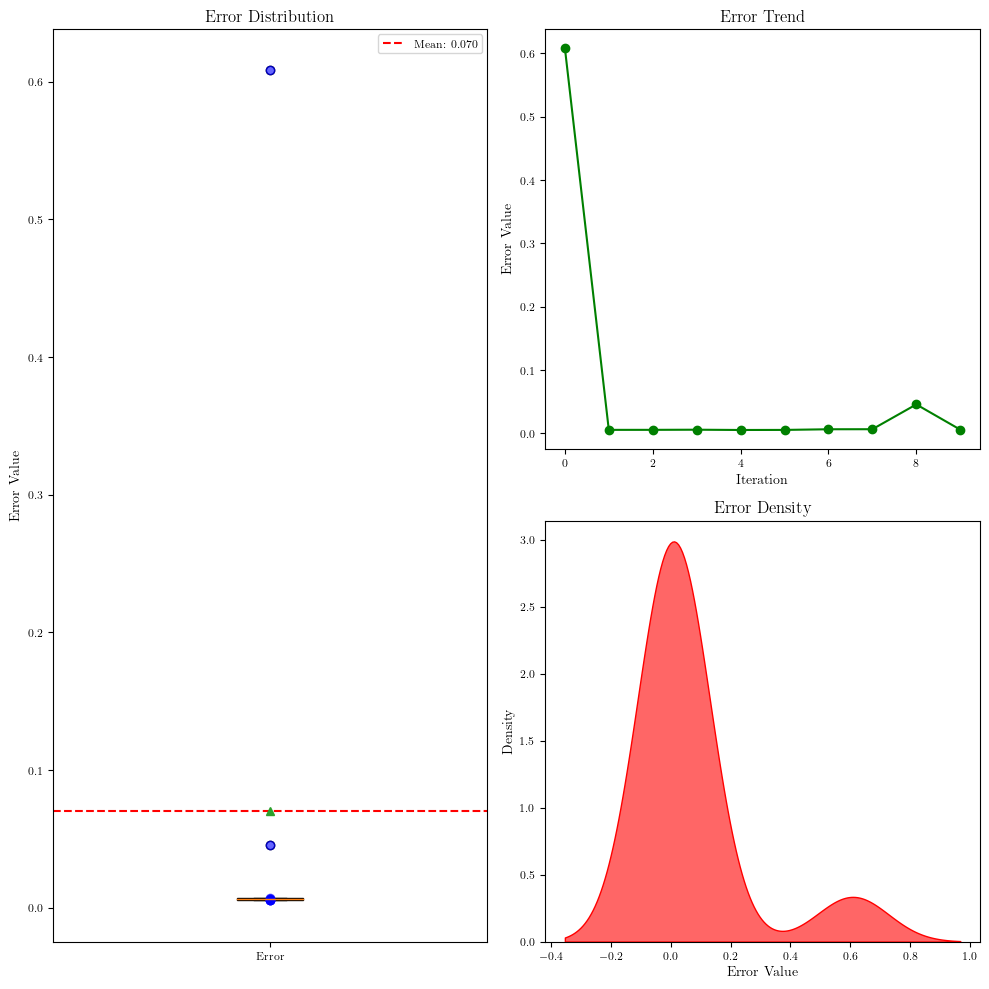

In [10]:

import seaborn as sns  # 导入seaborn库用于绘制密度图



plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列

mean_error = np.mean(error) #计算error数组的均值
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue')) #绘制箱型图，其中error是需要绘制的数据，patch_artist=True表示填充箱体，showmeans=True表示显示均值，meanline=True表示显示均值线，boxprops=dict(facecolor='lightblue')表示箱体的颜色为浅蓝色
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.3f}') #绘制一条水平线，位于mean_error处，颜色为红色，线型为虚线，标签为均值
for i, value in enumerate(error): #遍历error数组，i为索引，value为值
    plt.plot(1, value, 'bo', alpha=0.6) #绘制散点图，横坐标为1，纵坐标为value（即error数组中每个数），颜色为蓝色，点形状为圆圈，透明度为0.6
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error']) #设置x轴刻度标签
plt.legend() #显示图例

# 右侧上方子图：折线图
plt.subplot(2, 2, 2)  # 第二个子图，现在布局为2行2列的第二个位置
plt.plot(error, '-o', color='green') #绘制折线图，横坐标为error数组的索引，纵坐标为error数组的值，颜色为绿色，点形状为圆圈
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

# 右侧下方子图：密度图
plt.subplot(2, 2, 4)  # 第四个子图，现在布局为2行2列的第四个位置
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()  # 自动调整子图参数，使之填充整个图表区域
plt.show()

In [11]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

68906
[7.008488e-01 6.155940e-01 5.398165e-01 ... 8.121917e-06 8.121694e-06
 8.121680e-06]


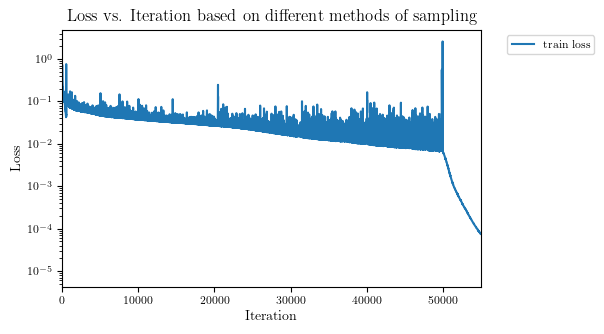

In [12]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

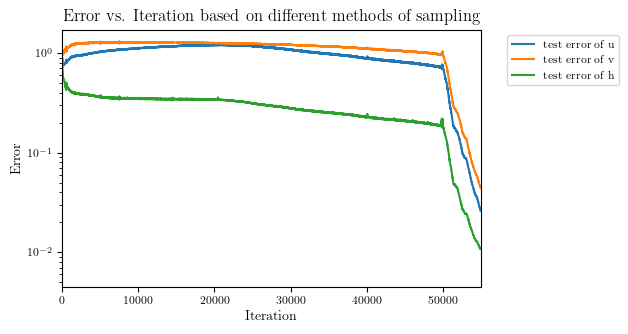

In [13]:
# print(len(trainloss))
# print(trainloss)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

u_error = testerror[:,0]
v_error = testerror[:,1]
h_error = testerror[:,2]

plt.plot(u_error, label='test error of u')
plt.plot(v_error, label='test error of v')
plt.plot(h_error, label='test error of h')


# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

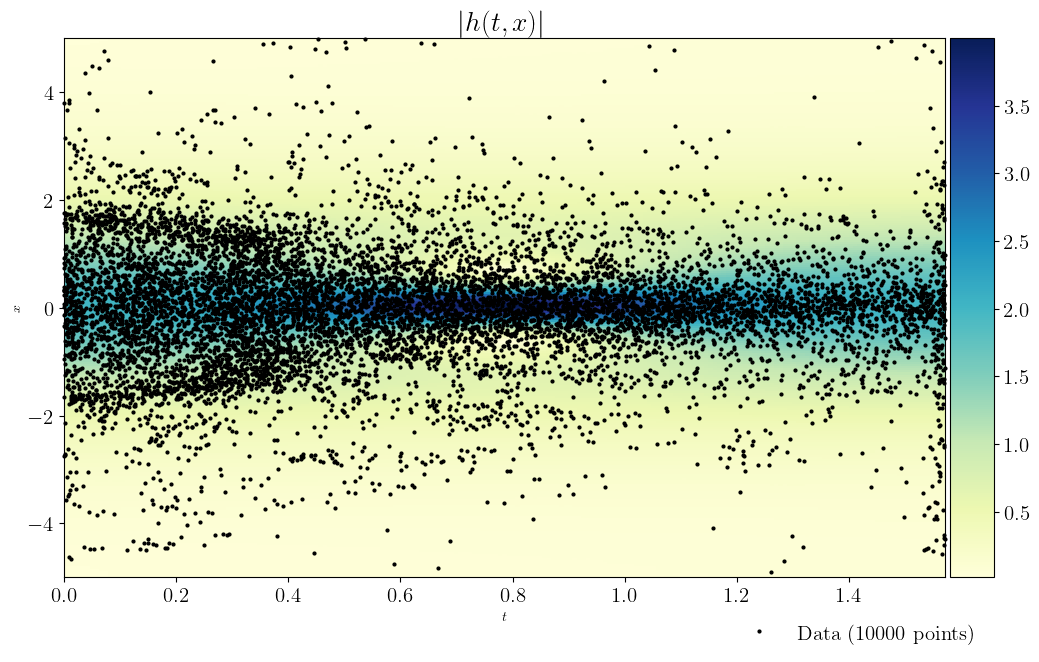

In [14]:


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(12, 7)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘制热图
h = ax.imshow(H_star.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')  #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是H_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                #第三个参数是颜色映射，这里是从黄色Yl到绿色Gn再到蓝色Bu；第四个参数是图像的范围，这里lb和ub分别是数据的下界和上界；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.05) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.05）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的

ax.plot(
    X_f[:,1], 
    X_f[:,0], 
    'ko', label = 'Data (%d points)' % (X_f.shape[0]), 
    markersize = 2,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  

# #绘制三条虚线
# line = np.linspace(x.min(), x.max(), 2)[:,None] #生成了一个包含2个等间距的数值的数组，这些数值在 x.min() 到 x.max() 之间。[:,None] 是一个索引操作，用于将一维数组转换为二维数组。这里其实就是[-5;5]
# #第一个参数是虚线的x坐标，line是虚线y的坐标，第三个参数是虚线的样式，k表示黑色，--表示虚线，最后一个参数表示虚线的参数是1
# ax.plot(t[75]*np.ones((2,1)),line,'k--',linewidth=1) 
# ax.plot(t[100]*np.ones((2,1)),line,'k--',linewidth=1)
# ax.plot(t[125]*np.ones((2,1)),line,'k--',linewidth=1)    

#设置标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

#    plt.setp(leg.get_texts(), color='w')   #用来设置图例中文本的颜色，这里是白色，取消注释后文本会变为白色
ax.set_title('$|h(t,x)|$', fontsize = 20) #设置子图ax的标题为$|h(t,x)|$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为10
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数








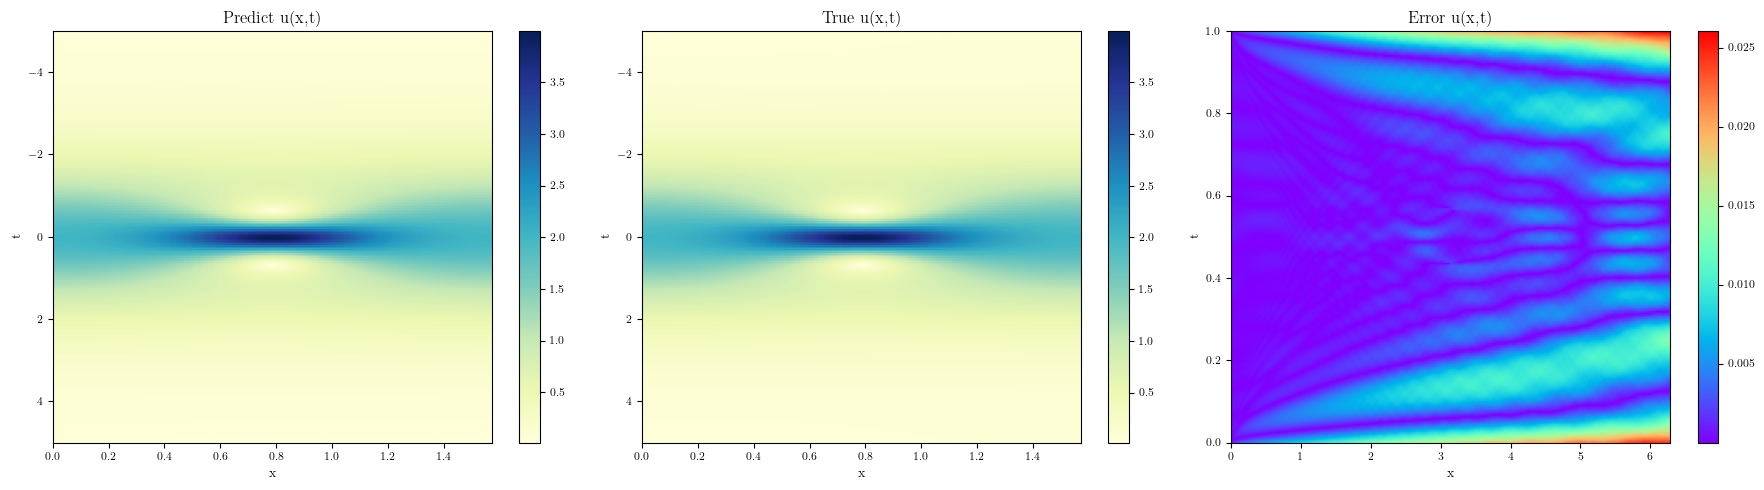

In [15]:


# 创建一个包含两个子图的图形
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1行2列的子图，图形大小为宽18英寸高5英寸

# 绘制第一幅图像
axes[0].imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(H_star.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])


# 绘制第三幅图像
axes[2].imshow(np.abs(H_pred - H_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])


# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [16]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

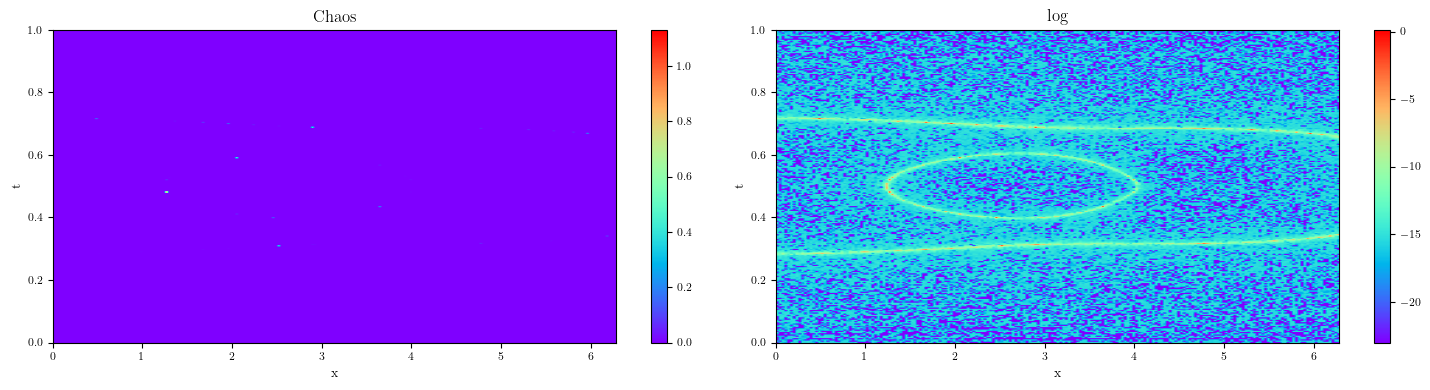

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()